In [1]:
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

In [30]:
print("----------------Reading the Data-------------------------")
PATH = os.getcwd()
os.chdir('Alphabets/')

X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)
np.random.shuffle(X_train.to_numpy())
train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

print("----------------Data Reading completed-------------------")

os.chdir('../')

X_train = X_train/255
X_test = X_test/255
m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features

print("The total number of training samples = {}".format(m))
print("The number of features = {}".format(n))

----------------Reading the Data-------------------------
----------------Data Reading completed-------------------
The total number of training samples = 13000
The number of features = 784


In [31]:
#To get the one hot encoding of each label
print("--------Perform 1-hot encoding of class labels------------")

train_class_enc = pd.get_dummies(train_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()

--------Perform 1-hot encoding of class labels------------


In [32]:
#Add the intercept term to the data samples both in training and test dataset
X_train = np.hstack((np.ones((m,1)),X_train.to_numpy()))
X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test.to_numpy()))

In [53]:
lr = 0.1
arch_test = [1,5,10,50,100] # Only for single layer
arch = [arch_test[3]] #means one hidden layer with #perceptrons 
batch_size = 100 # Mini-Batch Size
r = np.max(train_class) + 1 # Default value of the number of classes = 26

In [54]:
#Mini-Batch formation
mini_batch = [(X_train[i:i+batch_size,:], train_class_enc[i:i+batch_size]) for i in range(0, m, batch_size)]
print("The number of mini-batches formed is = {}".format(len(mini_batch)))

The number of mini-batches formed is = 130


In [55]:
#Theta Initialization 
#np.random.seed(1)
def theta_init(arch=[50]):
    theta = []
    for i in range(len(arch)+1):
        if i == 0:
            dim0=n+1
            dim1=arch[i]
        elif (i == len(arch)):
            dim0=arch[i-1]
            dim1 = r
        else:
            dim0=arch[i-1]
            dim1= arch[i]

        theta.append(0.01*(2*np.random.random((dim0, dim1))-1))
        #theta.append(np.zeros((dim0, dim1)))
    return theta

In [56]:
def activation(x):
    return 1/(1+np.exp(-x))

In [57]:
def forward_prop(data, theta):
    fm = []
    fm.append(data)
    for l in range(len(theta)):
        fm.append(activation(np.dot(fm[l], theta[l])))
    return fm

In [58]:
def cost_total(X, theta, Y, m):
    fm = forward_prop(X, theta)
    cost = (1/(2*m))*np.sum((Y-fm[-1])**2)
    return cost

In [59]:
def calc_accuracy(data, theta, actual_class):
    pred_class = forward_prop(data, theta)
    test_pred_class = pred_class[-1]
    for i in range(len(test_pred_class)):
        test_pred_class[i][test_pred_class[i] == np.max(test_pred_class[i])] = 1
        test_pred_class[i][test_pred_class[i] != np.max(test_pred_class[i])] = 0


    test_acc = 0
    for i in range(len(actual_class)):
        if (np.array_equal(test_pred_class[i], actual_class[i])):
            test_acc+=1
    test_acc /= data.shape[0]

    #print("The Test Accuracy of the model = {}%".format(test_acc*100))
    return (test_acc*100)

In [63]:
epochs = []
train_accuracy = []
test_accuracy = []
train_time = []
costs=[]

In [64]:
lr = 0.1

In [65]:
for i in range(len(arch_test)):
    theta = theta_init([arch_test[i]])
    print(theta[0].shape, theta[1].shape)
    fm = forward_prop(X_train, theta)
    
    epoch = 0
    start = time.time()
    cost_init = cost_total(X_train, theta, train_class_enc, m)

    while(True):
        count = 0

        print("Initial Cost for this epoch {} = {}".format(epoch, cost_init))
        
        for b in mini_batch:
            X_b = b[0]
            Y_b = b[1]
            fm = forward_prop(X_b, theta)
            delta = [None]*len(fm)

            if (count % 60 == 0):
                print("Error = "+str(cost_total(X_b, theta, Y_b, batch_size)))
            #Backward Propagation

            for l in range(len(fm)-1, 0, -1):
                if (l == len(fm)-1):
                    delta[l] = ((1/batch_size)*(Y_b - fm[l])*fm[l]*(1-fm[l]))
                else:
                    delta[l]=(np.dot(delta[l+1], theta[l].T)*fm[l]*(1-fm[l]))

            #delta_l1 = np.dot(delta_l2, theta2.T)*l1*(1-l1)

            for t in range(len(theta)):
                theta[t] += lr*np.dot(fm[t].T, delta[t+1]) 

            count+=1
            
#         if epoch %10 == 0:
#             costs.append(cost_init)
        epoch+=1 #Number of epochs
        
        cost_final = cost_total(X_train, theta, train_class_enc, m)
        
        print("Cost after {} epochs is = {}".format(epoch, cost_final))
        if (abs(cost_final-cost_init) < 1e-07):
            print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
            break
        cost_init = cost_final
    epochs.append(epoch)
    train_time.append(time.time()-start)
    train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
    test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
    print("\n------------------------------------------------------------------------------")
    print("The stats for number of units in the hidden layer = {} are as below:".format(arch_test[i]))
    print("------------------------------------------------------------------------------")
    print("The number of epochs = {}".format(epochs[-1]))
    print("The training time = {}sec".format(train_time[-1]))
    print("The training accuracy is = {}%".format(train_accuracy[-1]))
    print("The test accuracy is = {}%".format(test_accuracy[-1]))
    print("------------------------------------------------------------------------------\n")

(785, 1) (1, 26)
Initial Cost for this epoch 0 = 3.2501174872779033
Error = 3.250011468864357
Error = 1.9727879890472062
Error = 1.3136476865079032
Cost after 1 epochs is = 1.245696688128626
Initial Cost for this epoch 1 = 1.245696688128626
Error = 1.2467838953603967
Error = 0.9754020326411694
Error = 0.8312576129899276
Cost after 2 epochs is = 0.8132112562124484
Initial Cost for this epoch 2 = 0.8132112562124484
Error = 0.8136172571246284
Error = 0.7319964303026384
Error = 0.679350048967442
Cost after 3 epochs is = 0.6719728131963904
Initial Cost for this epoch 3 = 0.6719728131963904
Error = 0.6721926677514793
Error = 0.6365963316172064
Error = 0.6112060427008794
Cost after 4 epochs is = 0.6073956471359149
Initial Cost for this epoch 4 = 0.6073956471359149
Error = 0.6075375923540124
Error = 0.5884931126506295
Error = 0.5741136335817312
Cost after 5 epochs is = 0.5718496626215315
Initial Cost for this epoch 5 = 0.5718496626215315
Error = 0.5719509383107105
Error = 0.5604029350147619
Er

Cost after 48 epochs is = 0.48205920235170113
Initial Cost for this epoch 48 = 0.48205920235170113
Error = 0.4820641071983062
Error = 0.482023311090883
Error = 0.48199879369037024
Cost after 49 epochs is = 0.48199033636993394
Initial Cost for this epoch 49 = 0.48199033636993394
Error = 0.4819951486944599
Error = 0.48195669608529285
Error = 0.4819337976665308
Cost after 50 epochs is = 0.4819258076982403
Initial Cost for this epoch 50 = 0.4819258076982403
Error = 0.48193053257285345
Error = 0.4818942546650668
Error = 0.48187284308872047
Cost after 51 epochs is = 0.4818652896745357
Initial Cost for this epoch 51 = 0.4818652896745357
Error = 0.4818699318241045
Error = 0.48183567466170546
Error = 0.4818156300004827
Cost after 52 epochs is = 0.48180848491666173
Initial Cost for this epoch 52 = 0.48180848491666173
Error = 0.48181304874846254
Error = 0.48178067167290367
Error = 0.4817618849118419
Cost after 53 epochs is = 0.48175512225044015
Initial Cost for this epoch 53 = 0.48175512225044015

Cost after 96 epochs is = 0.48090731145313204
Initial Cost for this epoch 96 = 0.48090731145313204
Error = 0.48091048489956983
Error = 0.48090591346295497
Error = 0.4809022409298706
Cost after 97 epochs is = 0.48090173570077893
Initial Cost for this epoch 97 = 0.48090173570077893
Error = 0.4809048990928726
Error = 0.48090049565600235
Error = 0.48089686062241827
Cost after 98 epochs is = 0.48089640229799596
Initial Cost for this epoch 98 = 0.48089640229799596
Error = 0.48089955605640017
Error = 0.4808953137720961
Error = 0.4808917127394723
Cost after 99 epochs is = 0.48089129974263173
Initial Cost for this epoch 99 = 0.48089129974263173
Error = 0.4808944442712804
Error = 0.4808903566265177
Error = 0.48088678631681037
Cost after 100 epochs is = 0.480886417139321
Initial Cost for this epoch 100 = 0.480886417139321
Error = 0.4808895528261811
Error = 0.480885613623055
Error = 0.4808820709647173
Cost after 101 epochs is = 0.4808817441635197
Initial Cost for this epoch 101 = 0.480881744163519

Cost after 141 epochs is = 0.48079331227365724
Initial Cost for this epoch 141 = 0.48079331227365724
Error = 0.48079629002183655
Error = 0.480795415052869
Error = 0.4807917845566961
Cost after 142 epochs is = 0.48079244644289915
Initial Cost for this epoch 142 = 0.48079244644289915
Error = 0.4807954232632919
Error = 0.4807945825064885
Error = 0.48079093873465667
Cost after 143 epochs is = 0.4807916138263552
Initial Cost for this epoch 143 = 0.4807916138263552
Error = 0.48079458979441686
Error = 0.4807937822331181
Error = 0.4807901251049673
Cost after 144 epochs is = 0.4807908130951118
Initial Cost for this epoch 144 = 0.4807908130951118
Error = 0.4807937882834493
Error = 0.48079301293697563
Error = 0.48078934238603666
Cost after 145 epochs is = 0.4807900429764989
Initial Cost for this epoch 145 = 0.4807900429764989
Error = 0.4807930174549682
Error = 0.4807922733771369
Error = 0.4807885893502881
Cost after 146 epochs is = 0.480789302251534
Initial Cost for this epoch 146 = 0.48078930225

Cost after 187 epochs is = 0.48077426252752425
Initial Cost for this epoch 187 = 0.48077426252752425
Error = 0.4807772444828852
Error = 0.4807772649589946
Error = 0.48077306319089697
Cost after 188 epochs is = 0.48077411135226905
Initial Cost for this epoch 188 = 0.48077411135226905
Error = 0.48077709394605417
Error = 0.4807771243869233
Error = 0.48077291252860954
Cost after 189 epochs is = 0.48077396567096975
Initial Cost for this epoch 189 = 0.48077396567096975
Error = 0.48077694891107864
Error = 0.4807769890807549
Error = 0.48077276725294793
Cost after 190 epochs is = 0.48077382527988977
Initial Cost for this epoch 190 = 0.48077382527988977
Error = 0.4807768091736183
Error = 0.480776858842649
Error = 0.48077262716587493
Cost after 191 epochs is = 0.4807736899830544
Initial Cost for this epoch 191 = 0.4807736899830544
Error = 0.48077667453711487
Error = 0.4807767334823378
Error = 0.4807724920768618
Cost after 192 epochs is = 0.480773559591943
Initial Cost for this epoch 192 = 0.48077

Error = 0.4808169438502393
Cost after 30 epochs is = 0.4808229487948751
Initial Cost for this epoch 30 = 0.4808229487948751
Error = 0.4808516330057478
Error = 0.48083308239352596
Error = 0.4808131807459913
Cost after 31 epochs is = 0.4808198994116704
Initial Cost for this epoch 31 = 0.4808198994116704
Error = 0.48084817514899414
Error = 0.4808309129917166
Error = 0.48080999723519974
Cost after 32 epochs is = 0.4808173613232372
Initial Cost for this epoch 32 = 0.4808173613232372
Error = 0.4808452743044056
Error = 0.48082915755812966
Error = 0.4808072945274697
Cost after 33 epochs is = 0.4808152432551795
Initial Cost for this epoch 33 = 0.4808152432551795
Error = 0.4808428334280805
Error = 0.48082773797136114
Error = 0.48080499178738423
Cost after 34 epochs is = 0.48081347087060466
Initial Cost for this epoch 34 = 0.48081347087060466
Error = 0.4808407731949817
Error = 0.4808265908824859
Error = 0.4808030226709392
Cost after 35 epochs is = 0.4808119834736571
Initial Cost for this epoch 35

Error = 0.4813857999442574
Error = 0.4811591345011568
Error = 0.4811960802615101
Cost after 9 epochs is = 0.48114511507989993
Initial Cost for this epoch 9 = 0.48114511507989993
Error = 0.4812632999511011
Error = 0.48108225165537116
Error = 0.48111294568577706
Cost after 10 epochs is = 0.4810764239591074
Initial Cost for this epoch 10 = 0.4810764239591074
Error = 0.48118359068123584
Error = 0.4810340771057661
Error = 0.48105698320363344
Cost after 11 epochs is = 0.48103146861623747
Initial Cost for this epoch 11 = 0.48103146861623747
Error = 0.48113034478222816
Error = 0.48100342660583884
Error = 0.48101834860435033
Cost after 12 epochs is = 0.4810014289769023
Initial Cost for this epoch 12 = 0.4810014289769023
Error = 0.48109396382621705
Error = 0.48098371045209937
Error = 0.48099105465146497
Cost after 13 epochs is = 0.4809809751302953
Initial Cost for this epoch 13 = 0.4809809751302953
Error = 0.48106859352715675
Error = 0.48097092530959634
Error = 0.48097134742538106
Cost after 14 

Cost after 56 epochs is = 0.4808996919813531
Initial Cost for this epoch 56 = 0.4808996919813531
Error = 0.48095997012284486
Error = 0.48092156155476085
Error = 0.48087590125586127
Cost after 57 epochs is = 0.48089898151089255
Initial Cost for this epoch 57 = 0.48089898151089255
Error = 0.4809590414856084
Error = 0.4809208873611334
Error = 0.4808752261934865
Cost after 58 epochs is = 0.48089827841550953
Initial Cost for this epoch 58 = 0.48089827841550953
Error = 0.4809581220667243
Error = 0.48092021975856214
Error = 0.48087455911786137
Cost after 59 epochs is = 0.4808975825861512
Initial Cost for this epoch 59 = 0.4808975825861512
Error = 0.4809572117524041
Error = 0.48091955869938213
Error = 0.48087389981248224
Cost after 60 epochs is = 0.48089689391579127
Initial Cost for this epoch 60 = 0.48089689391579127
Error = 0.4809563104296728
Error = 0.48091890412830884
Error = 0.4808732480783114
Cost after 61 epochs is = 0.4808962122993753
Initial Cost for this epoch 61 = 0.4808962122993753

Error = 0.480896771268298
Error = 0.48085160020371465
Cost after 102 epochs is = 0.48087326656683266
Initial Cost for this epoch 102 = 0.48087326656683266
Error = 0.4809252193902448
Error = 0.4808963262926797
Error = 0.4808511717783561
Cost after 103 epochs is = 0.48087280726520426
Initial Cost for this epoch 103 = 0.48087280726520426
Error = 0.48092461212994403
Error = 0.48089588503176695
Error = 0.4808507472169349
Cost after 104 epochs is = 0.480872351893158
Initial Cost for this epoch 104 = 0.480872351893158
Error = 0.48092400995406914
Error = 0.48089544743937385
Error = 0.4808503264702303
Cost after 105 epochs is = 0.48087190040187167
Initial Cost for this epoch 105 = 0.48087190040187167
Error = 0.4809234128002814
Error = 0.4808950134700642
Error = 0.4808499094898312
Cost after 106 epochs is = 0.480871452743305
Initial Cost for this epoch 106 = 0.480871452743305
Error = 0.4809228206072224
Error = 0.48089458307913674
Error = 0.48084949622811834
Cost after 107 epochs is = 0.480871008

Error = 0.4808798654854393
Error = 0.48083555088852464
Cost after 147 epochs is = 0.4808558959330001
Initial Cost for this epoch 147 = 0.4808558959330001
Error = 0.4809021683402655
Error = 0.4808795507238719
Error = 0.48083525702603913
Cost after 148 epochs is = 0.4808555743236934
Initial Cost for this epoch 148 = 0.4808555743236934
Error = 0.48090173977187906
Error = 0.48087923817169254
Error = 0.48083496542687487
Cost after 149 epochs is = 0.4808552550480586
Initial Cost for this epoch 149 = 0.4808552550480586
Error = 0.48090131424257865
Error = 0.48087892780553093
Error = 0.48083467606625446
Cost after 150 epochs is = 0.48085493808125435
Initial Cost for this epoch 150 = 0.48085493808125435
Error = 0.48090089172041306
Error = 0.48087861960234124
Error = 0.48083438891974817
Cost after 151 epochs is = 0.4808546233987847
Initial Cost for this epoch 151 = 0.4808546233987847
Error = 0.4809004721738693
Error = 0.4808783135393971
Error = 0.4808341039632679
Cost after 152 epochs is = 0.4808

Error = 0.48082404924062644
Cost after 193 epochs is = 0.48084318924484176
Initial Cost for this epoch 193 = 0.48084318924484176
Error = 0.48088517724746027
Error = 0.48086713155943983
Error = 0.48082383829892944
Cost after 194 epochs is = 0.48084295367968455
Initial Cost for this epoch 194 = 0.48084295367968455
Error = 0.4808848610305784
Error = 0.48086689979961467
Error = 0.48082362876697754
Cost after 195 epochs is = 0.4808427195887979
Initial Cost for this epoch 195 = 0.4808427195887979
Error = 0.4808845467447496
Error = 0.4808666694284924
Error = 0.48082342063129396
Cost after 196 epochs is = 0.4808424869585373
Initial Cost for this epoch 196 = 0.4808424869585373
Error = 0.48088423437233163
Error = 0.4808664404334088
Error = 0.4808232138785677
Cost after 197 epochs is = 0.4808422557754233
Initial Cost for this epoch 197 = 0.4808422557754233
Error = 0.4808839238958936
Error = 0.48086621280185254
Error = 0.480823008495651
Cost after 198 epochs is = 0.48084202602613874
Initial Cost f

Cost after 239 epochs is = 0.48083369590713504
Initial Cost for this epoch 239 = 0.48083369590713504
Error = 0.4808723927772674
Error = 0.4808577377999402
Error = 0.4808154665635027
Cost after 240 epochs is = 0.4808335161916754
Initial Cost for this epoch 240 = 0.4808335161916754
Error = 0.48087214989456045
Error = 0.4808575588072817
Error = 0.4808153096147851
Cost after 241 epochs is = 0.4808333374623281
Initial Cost for this epoch 241 = 0.4808333374623281
Error = 0.4808719083104038
Error = 0.48085738074982987
Error = 0.4808151535879381
Cost after 242 epochs is = 0.4808331597110341
Initial Cost for this epoch 242 = 0.4808331597110341
Error = 0.4808716680143292
Error = 0.4808572036200873
Error = 0.480814998475168
Cost after 243 epochs is = 0.48083298292981996
Initial Cost for this epoch 243 = 0.48083298292981996
Error = 0.4808714289959795
Error = 0.48085702741063624
Error = 0.48081484426876586
Cost after 244 epochs is = 0.4808328071107981
Initial Cost for this epoch 244 = 0.48083280711

Error = 0.48085036997745007
Error = 0.48080909520057163
Cost after 286 epochs is = 0.48082619839650226
Initial Cost for this epoch 286 = 0.48082619839650226
Error = 0.48086222907520165
Error = 0.4808502273035069
Error = 0.48080897371696096
Cost after 287 epochs is = 0.480826057535922
Initial Cost for this epoch 287 = 0.480826057535922
Error = 0.4808620374801499
Error = 0.48085008528879514
Error = 0.48080885286990876
Cost after 288 epochs is = 0.4808259173601904
Initial Cost for this epoch 288 = 0.4808259173601904
Error = 0.4808618467915865
Error = 0.4808499439286061
Error = 0.48080873265458074
Cost after 289 epochs is = 0.4808257778643116
Initial Cost for this epoch 289 = 0.4808257778643116
Error = 0.4808616570029954
Error = 0.48084980321827564
Error = 0.48080861306618955
Cost after 290 epochs is = 0.48082563904333725
Initial Cost for this epoch 290 = 0.48082563904333725
Error = 0.4808614681079222
Error = 0.4808496631531843
Error = 0.4808084940999948
Cost after 291 epochs is = 0.480825

Cost after 332 epochs is = 0.4808203588809424
Initial Cost for this epoch 332 = 0.4808203588809424
Error = 0.48085426417547467
Error = 0.4808443078211834
Error = 0.48080400284141994
Cost after 333 epochs is = 0.48082024499552073
Initial Cost for this epoch 333 = 0.48082024499552073
Error = 0.48085410836647774
Error = 0.4808441916823717
Error = 0.48080390672651363
Cost after 334 epochs is = 0.480820131607149
Initial Cost for this epoch 334 = 0.480820131607149
Error = 0.480853953218603
Error = 0.48084407602243434
Error = 0.48080381106411196
Cost after 335 epochs is = 0.4808200187125464
Initial Cost for this epoch 335 = 0.4808200187125464
Error = 0.4808537987275557
Error = 0.48084396083829584
Error = 0.48080371585109943
Cost after 336 epochs is = 0.480819906308461
Initial Cost for this epoch 336 = 0.480819906308461
Error = 0.480853644889078
Error = 0.480843846126907
Error = 0.48080362108438823
Cost after 337 epochs is = 0.48081979439166816
Initial Cost for this epoch 337 = 0.4808197943916

Cost after 10 epochs is = 0.48170969117376655
Initial Cost for this epoch 10 = 0.48170969117376655
Error = 0.4819364200267502
Error = 0.4816532632808393
Error = 0.48170030541790765
Cost after 11 epochs is = 0.4817043725640221
Initial Cost for this epoch 11 = 0.4817043725640221
Error = 0.48193239208761457
Error = 0.4816469599360212
Error = 0.48169156516141953
Cost after 12 epochs is = 0.481699131561773
Initial Cost for this epoch 12 = 0.481699131561773
Error = 0.48192819257793323
Error = 0.48164084549415903
Error = 0.48168355701195226
Cost after 13 epochs is = 0.48169391636261616
Initial Cost for this epoch 13 = 0.48169391636261616
Error = 0.48192372866055944
Error = 0.4816349346965733
Error = 0.4816760491713042
Cost after 14 epochs is = 0.4816886983926801
Initial Cost for this epoch 14 = 0.4816886983926801
Error = 0.48191897358196584
Error = 0.48162921584312784
Error = 0.4816688845677243
Cost after 15 epochs is = 0.48168346029938774
Initial Cost for this epoch 15 = 0.48168346029938774


Error = 0.4812937406907068
Error = 0.4812780581254728
Cost after 56 epochs is = 0.4813279680018868
Initial Cost for this epoch 56 = 0.4813279680018868
Error = 0.48149797893972873
Error = 0.4812763783567877
Error = 0.4812598211185013
Cost after 57 epochs is = 0.4813104359111581
Initial Cost for this epoch 57 = 0.4813104359111581
Error = 0.48147710054611503
Error = 0.48125801804385165
Error = 0.481240650721507
Cost after 58 epochs is = 0.48129196905430477
Initial Cost for this epoch 58 = 0.48129196905430477
Error = 0.4814550753353564
Error = 0.48123858332719494
Error = 0.48122047692831266
Cost after 59 epochs is = 0.4812724975948811
Initial Cost for this epoch 59 = 0.4812724975948811
Error = 0.48143181523370254
Error = 0.48121799129920645
Error = 0.481199223943357
Cost after 60 epochs is = 0.4812519458921504
Initial Cost for this epoch 60 = 0.4812519458921504
Error = 0.481407224780303
Error = 0.48119615194530907
Error = 0.48117680964005305
Cost after 61 epochs is = 0.48123023195436004
In

Cost after 102 epochs is = 0.47560510317128063
Initial Cost for this epoch 102 = 0.47560510317128063
Error = 0.47429851741197027
Error = 0.47426861480495935
Error = 0.4750854456070951
Cost after 103 epochs is = 0.4750947199293124
Initial Cost for this epoch 103 = 0.4750947199293124
Error = 0.4736438087526408
Error = 0.47360485534011704
Error = 0.4745447904564767
Cost after 104 epochs is = 0.4745392439380552
Initial Cost for this epoch 104 = 0.4745392439380552
Error = 0.47293017467361465
Error = 0.47287952102338837
Error = 0.47395902017501146
Cost after 105 epochs is = 0.4739359429504929
Initial Cost for this epoch 105 = 0.4739359429504929
Error = 0.4721542751814522
Error = 0.4720894380063615
Error = 0.47332595735251476
Cost after 106 epochs is = 0.47328250717933384
Initial Cost for this epoch 106 = 0.47328250717933384
Error = 0.471313588254647
Error = 0.47123250921721466
Error = 0.47264390643801274
Cost after 107 epochs is = 0.47257727852841297
Initial Cost for this epoch 107 = 0.47257

Error = 0.41273985929774315
Error = 0.41388681639357655
Cost after 148 epochs is = 0.40965086324450783
Initial Cost for this epoch 148 = 0.40965086324450783
Error = 0.39895821504595175
Error = 0.40998974423837986
Error = 0.41143247681863704
Cost after 149 epochs is = 0.40671157200268404
Initial Cost for this epoch 149 = 0.40671157200268404
Error = 0.3954262170443381
Error = 0.4071632574843102
Error = 0.40893139164345005
Cost after 150 epochs is = 0.4037268187494603
Initial Cost for this epoch 150 = 0.4037268187494603
Error = 0.39177539005033124
Error = 0.4042967166513695
Error = 0.40638939813668273
Cost after 151 epochs is = 0.4007238222924236
Initial Cost for this epoch 151 = 0.4007238222924236
Error = 0.3880548746926691
Error = 0.40142532361549926
Error = 0.4038110005772208
Cost after 152 epochs is = 0.39772666916597604
Initial Cost for this epoch 152 = 0.39772666916597604
Error = 0.38431075306596624
Error = 0.39857790713939983
Error = 0.4011998011502511
Cost after 153 epochs is = 0.

Error = 0.297693521336241
Cost after 193 epochs is = 0.29624203385593406
Initial Cost for this epoch 193 = 0.29624203385593406
Error = 0.26757734996273685
Error = 0.30011292296366315
Error = 0.29540110728326535
Cost after 194 epochs is = 0.2940922259929174
Initial Cost for this epoch 194 = 0.2940922259929174
Error = 0.2657042338228169
Error = 0.2979616630316058
Error = 0.29310590890278465
Cost after 195 epochs is = 0.2919391348737207
Initial Cost for this epoch 195 = 0.2919391348737207
Error = 0.26385560814098286
Error = 0.295809919378034
Error = 0.29080854256316807
Cost after 196 epochs is = 0.28978309997774887
Initial Cost for this epoch 196 = 0.28978309997774887
Error = 0.2620296061283171
Error = 0.29365783665989026
Error = 0.28850997808660783
Cost after 197 epochs is = 0.2876248408088377
Initial Cost for this epoch 197 = 0.2876248408088377
Error = 0.2602246940923775
Error = 0.2915057961622166
Error = 0.28621145032192213
Cost after 198 epochs is = 0.2854654086964972
Initial Cost for

Cost after 238 epochs is = 0.21044355536526405
Initial Cost for this epoch 238 = 0.21044355536526405
Error = 0.19955823738695963
Error = 0.2134071483460662
Error = 0.20397471747475032
Cost after 239 epochs is = 0.20900424338250476
Initial Cost for this epoch 239 = 0.20900424338250476
Error = 0.19835186845474886
Error = 0.2118996878484705
Error = 0.2024627276879736
Cost after 240 epochs is = 0.20758869617574416
Initial Cost for this epoch 240 = 0.20758869617574416
Error = 0.19715821633774677
Error = 0.21041303888858878
Error = 0.20097792853395502
Cost after 241 epochs is = 0.20619676396443307
Initial Cost for this epoch 241 = 0.20619676396443307
Error = 0.19597727233881848
Error = 0.20894706142715577
Error = 0.19951996871565622
Cost after 242 epochs is = 0.2048282674000997
Initial Cost for this epoch 242 = 0.2048282674000997
Error = 0.19480902067988431
Error = 0.20750159434084686
Error = 0.19808846665026011
Cost after 243 epochs is = 0.2034829995421731
Initial Cost for this epoch 243 = 

Error = 0.16263938182860546
Error = 0.15669481207287977
Cost after 284 epochs is = 0.16423992827471015
Initial Cost for this epoch 284 = 0.16423992827471015
Error = 0.15617631663476478
Error = 0.16181957402678876
Error = 0.15599102498470235
Cost after 285 epochs is = 0.16356913847164728
Initial Cost for this epoch 285 = 0.16356913847164728
Error = 0.15546688912682138
Error = 0.16101002562066097
Error = 0.1552976085988923
Cost after 286 epochs is = 0.16290789386825072
Initial Cost for this epoch 286 = 0.16290789386825072
Error = 0.1547651816941755
Error = 0.16021059724565517
Error = 0.15461435139984037
Cost after 287 epochs is = 0.16225597961008284
Initial Cost for this epoch 287 = 0.16225597961008284
Error = 0.15407105818240419
Error = 0.15942115217065006
Error = 0.153941046753371
Cost after 288 epochs is = 0.16161318668814026
Initial Cost for this epoch 288 = 0.16161318668814026
Error = 0.15338438464096604
Error = 0.15864155605316937
Error = 0.15327749270042987
Cost after 289 epochs i

Error = 0.1328645731546178
Cost after 329 epochs is = 0.14115534998663856
Initial Cost for this epoch 329 = 0.14115534998663856
Error = 0.13033118707235572
Error = 0.13367723348838667
Error = 0.13247029069793972
Cost after 330 epochs is = 0.140764213100974
Initial Cost for this epoch 330 = 0.140764213100974
Error = 0.1298689313237043
Error = 0.13320608051152713
Error = 0.13208025117810662
Cost after 331 epochs is = 0.1403769258706668
Initial Cost for this epoch 331 = 0.1403769258706668
Error = 0.12941057355655824
Error = 0.13274007050735764
Error = 0.1316943774533163
Cost after 332 epochs is = 0.13999342132905282
Initial Cost for this epoch 332 = 0.13999342132905282
Error = 0.12895606845253846
Error = 0.1322791173892247
Error = 0.13131259423264247
Cost after 333 epochs is = 0.1396136340624826
Initial Cost for this epoch 333 = 0.1396136340624826
Error = 0.1285053715780785
Error = 0.13182313638150717
Error = 0.13093482803143836
Cost after 334 epochs is = 0.1392375001659094
Initial Cost f

Cost after 374 epochs is = 0.12660168019858442
Initial Cost for this epoch 374 = 0.12660168019858442
Error = 0.11283876567435072
Error = 0.11653662242056934
Error = 0.11819368853936388
Cost after 375 epochs is = 0.12633428546833822
Initial Cost for this epoch 375 = 0.12633428546833822
Error = 0.11251522984888554
Error = 0.11622953051149683
Error = 0.11793631317098527
Cost after 376 epochs is = 0.12606879723245326
Initial Cost for this epoch 376 = 0.12606879723245326
Error = 0.11219405647798167
Error = 0.11592490258870947
Error = 0.11768096878257271
Cost after 377 epochs is = 0.12580518915085223
Initial Cost for this epoch 377 = 0.12580518915085223
Error = 0.11187521874848724
Error = 0.11562270154103425
Error = 0.117427627185196
Cost after 378 epochs is = 0.125543435370099
Initial Cost for this epoch 378 = 0.125543435370099
Error = 0.11155869010585391
Error = 0.11532289095751776
Error = 0.11717626072728056
Cost after 379 epochs is = 0.12528351051315642
Initial Cost for this epoch 379 = 

Error = 0.10471898625655955
Error = 0.10829051240641127
Cost after 420 epochs is = 0.11594240502760335
Initial Cost for this epoch 420 = 0.11594240502760335
Error = 0.10003649547960422
Error = 0.1044941354399404
Error = 0.10810282223304953
Cost after 421 epochs is = 0.11574146352385323
Initial Cost for this epoch 421 = 0.11574146352385323
Error = 0.09979779429680267
Error = 0.10427060575418808
Error = 0.10791629556541278
Cost after 422 epochs is = 0.1155415991369782
Initial Cost for this epoch 422 = 0.1155415991369782
Error = 0.09956048576810832
Error = 0.1040483809324489
Error = 0.10773091976709552
Cost after 423 epochs is = 0.11534280026262235
Initial Cost for this epoch 423 = 0.11534280026262235
Error = 0.09932455435644212
Error = 0.10382744499683239
Error = 0.10754668238764889
Cost after 424 epochs is = 0.11514505549133433
Initial Cost for this epoch 424 = 0.11514505549133433
Error = 0.0990899847262688
Error = 0.1036077822531955
Error = 0.1073635711573441
Cost after 425 epochs is =

Error = 0.10083947220681097
Cost after 465 epochs is = 0.1078265369295434
Initial Cost for this epoch 465 = 0.1078265369295434
Error = 0.09048014979500046
Error = 0.09553701872184994
Error = 0.10069366009501975
Cost after 466 epochs is = 0.1076648417695244
Initial Cost for this epoch 466 = 0.1076648417695244
Error = 0.09029123084700537
Error = 0.09535974021593437
Error = 0.10054857341358
Cost after 467 epochs is = 0.10750384862043783
Initial Cost for this epoch 467 = 0.10750384862043783
Error = 0.09010317160794666
Error = 0.09518326574350333
Error = 0.10040420464371172
Cost after 468 epochs is = 0.10734355166204253
Initial Cost for this epoch 468 = 0.10734355166204253
Error = 0.08991596346480872
Error = 0.09500758788778381
Error = 0.10026054634407432
Cost after 469 epochs is = 0.10718394515189827
Initial Cost for this epoch 469 = 0.10718394515189827
Error = 0.08972959792424628
Error = 0.09483269933807688
Error = 0.10011759115032681
Cost after 470 epochs is = 0.1070250234239075
Initial 

Cost after 510 epochs is = 0.10117273346395388
Initial Cost for this epoch 510 = 0.10117273346395388
Error = 0.08272435863036151
Error = 0.0882628036853498
Error = 0.09478093699729194
Cost after 511 epochs is = 0.10103779225468447
Initial Cost for this epoch 511 = 0.10103779225468447
Error = 0.08256715572903083
Error = 0.08811549099939348
Error = 0.09466182911362608
Cost after 512 epochs is = 0.1009033519981394
Initial Cost for this epoch 512 = 0.1009033519981394
Error = 0.08241052980392435
Error = 0.08796871995664018
Error = 0.09454317543146758
Cost after 513 epochs is = 0.10076940933410664
Initial Cost for this epoch 513 = 0.10076940933410664
Error = 0.08225447666329919
Error = 0.08782248584488585
Error = 0.0944249716097503
Cost after 514 epochs is = 0.10063596093963827
Initial Cost for this epoch 514 = 0.10063596093963827
Error = 0.08209899218986007
Error = 0.0876767839888835
Error = 0.09430721336657275
Cost after 515 epochs is = 0.10050300352849546
Initial Cost for this epoch 515 =

Error = 0.0821087708327952
Error = 0.08981741930285363
Cost after 556 epochs is = 0.09543830449324417
Initial Cost for this epoch 556 = 0.09543830449324417
Error = 0.07603726001970468
Error = 0.08198171515741158
Error = 0.08971522749491097
Cost after 557 epochs is = 0.09532341420934949
Initial Cost for this epoch 557 = 0.09532341420934949
Error = 0.0759032178924077
Error = 0.0818550281896406
Error = 0.08961334702266313
Cost after 558 epochs is = 0.09520890159011146
Initial Cost for this epoch 558 = 0.09520890159011146
Error = 0.07576962118517436
Error = 0.08172870706621507
Error = 0.08951177578981671
Cost after 559 epochs is = 0.09509476451705202
Initial Cost for this epoch 559 = 0.09509476451705202
Error = 0.07563646807816968
Error = 0.0816027489676568
Error = 0.08941051174042769
Cost after 560 epochs is = 0.09498100089000515
Initial Cost for this epoch 560 = 0.09498100089000515
Error = 0.07550375678154948
Error = 0.08147715111811163
Error = 0.08930955285843377
Cost after 561 epochs i

Error = 0.08550265318866154
Cost after 601 epochs is = 0.09061448666471794
Initial Cost for this epoch 601 = 0.09061448666471794
Error = 0.0704240698939601
Error = 0.07660909122060225
Error = 0.08541289171291604
Cost after 602 epochs is = 0.09051471715928791
Initial Cost for this epoch 602 = 0.09051471715928791
Error = 0.07030858746515423
Error = 0.07649664415599135
Error = 0.08532337972349371
Cost after 603 epochs is = 0.09041524478388537
Initial Cost for this epoch 603 = 0.09041524478388537
Error = 0.0701934882930554
Error = 0.07638447395013329
Error = 0.08523411640869523
Cost after 604 epochs is = 0.09031606802983064
Initial Cost for this epoch 604 = 0.09031606802983064
Error = 0.07007877125369612
Error = 0.0762725793326859
Error = 0.08514510097268756
Cost after 605 epochs is = 0.09021718539856535
Initial Cost for this epoch 605 = 0.09021718539856535
Error = 0.06996443522737499
Error = 0.07616095905521403
Error = 0.08505633263500163
Cost after 606 epochs is = 0.0901185954015578
Init

Cost after 646 epochs is = 0.08639901489872973
Initial Cost for this epoch 646 = 0.08639901489872973
Error = 0.06559120552117946
Error = 0.0718076686666482
Error = 0.08162148392530556
Cost after 647 epochs is = 0.08631125402574577
Initial Cost for this epoch 647 = 0.08631125402574577
Error = 0.06549188717399332
Error = 0.07170665796887978
Error = 0.08154252657735432
Cost after 648 epochs is = 0.08622373127996512
Initial Cost for this epoch 648 = 0.08622373127996512
Error = 0.06539290313038644
Error = 0.07160588170744828
Error = 0.08146379124543675
Cost after 649 epochs is = 0.08613644553259904
Initial Cost for this epoch 649 = 0.08613644553259904
Error = 0.06529425230733775
Error = 0.07150533914293987
Error = 0.08138527742753887
Cost after 650 epochs is = 0.08604939566180289
Initial Cost for this epoch 650 = 0.08604939566180289
Error = 0.06519593362158313
Error = 0.07140502953997377
Error = 0.08130698462119879
Cost after 651 epochs is = 0.0859625805526194
Initial Cost for this epoch 65

Cost after 691 epochs is = 0.0826704740357408
Initial Cost for this epoch 691 = 0.0826704740357408
Error = 0.06143746810051102
Error = 0.0674842000005546
Error = 0.07828081510153727
Cost after 692 epochs is = 0.0825924021911362
Initial Cost for this epoch 692 = 0.0825924021911362
Error = 0.061352121894654686
Error = 0.06739304282245934
Error = 0.07821132294717902
Cost after 693 epochs is = 0.08251452383847335
Initial Cost for this epoch 693 = 0.08251452383847335
Error = 0.06126706143582345
Error = 0.06730208898581896
Error = 0.07814202786611059
Cost after 694 epochs is = 0.08243683811419382
Initial Cost for this epoch 694 = 0.08243683811419382
Error = 0.06118228566195039
Error = 0.0672113378297763
Error = 0.07807292922603988
Cost after 695 epochs is = 0.08235934415977121
Initial Cost for this epoch 695 = 0.08235934415977121
Error = 0.06109779351234166
Error = 0.06712078869475127
Error = 0.07800402639121051
Cost after 696 epochs is = 0.08228204112168346
Initial Cost for this epoch 696 =

Error = 0.06357431100646478
Error = 0.07533936709402983
Cost after 737 epochs is = 0.07926711174441067
Initial Cost for this epoch 737 = 0.07926711174441067
Error = 0.05779144819697132
Error = 0.06349167599867316
Error = 0.0752780789180352
Cost after 738 epochs is = 0.07919711917271574
Initial Cost for this epoch 738 = 0.07919711917271574
Error = 0.057718174503762154
Error = 0.06340921663747574
Error = 0.075216957020592
Cost after 739 epochs is = 0.0791272852191012
Initial Cost for this epoch 739 = 0.0791272852191012
Error = 0.057645139722045595
Error = 0.06332693237560422
Error = 0.07515600069494656
Cost after 740 epochs is = 0.07905760922801706
Initial Cost for this epoch 740 = 0.07905760922801706
Error = 0.05757234289223174
Error = 0.06324482266964794
Error = 0.07509520923491782
Cost after 741 epochs is = 0.07898809054796768
Initial Cost for this epoch 741 = 0.07898809054796768
Error = 0.05749978305767821
Error = 0.06316288698010093
Error = 0.0750345819349929
Cost after 742 epochs i

Error = 0.07273617917246257
Cost after 782 epochs is = 0.0762657563993501
Initial Cost for this epoch 782 = 0.0762657563993501
Error = 0.054717491345315804
Error = 0.05994726883553354
Error = 0.07268169481562362
Cost after 783 epochs is = 0.07620230731973014
Initial Cost for this epoch 783 = 0.07620230731973014
Error = 0.05465406202885035
Error = 0.05987221153730692
Error = 0.07262734667969832
Cost after 784 epochs is = 0.07613899109824224
Initial Cost for this epoch 784 = 0.07613899109824224
Error = 0.054590831474590394
Error = 0.05979730919584721
Error = 0.07257313416061295
Cost after 785 epochs is = 0.07607580724244062
Initial Cost for this epoch 785 = 0.07607580724244062
Error = 0.05452779886008471
Error = 0.05972256146910885
Error = 0.07251905665784374
Cost after 786 epochs is = 0.07601275526303254
Initial Cost for this epoch 786 = 0.07601275526303254
Error = 0.05446496336574847
Error = 0.05964796801962655
Error = 0.07246511357444577
Cost after 787 epochs is = 0.07594983467385641


Cost after 827 epochs is = 0.07353553251328157
Initial Cost for this epoch 827 = 0.07353553251328157
Error = 0.05204868165717778
Error = 0.05671889564947838
Error = 0.07036232016360816
Cost after 828 epochs is = 0.07347761599125516
Initial Cost for this epoch 828 = 0.07347761599125516
Error = 0.051993420466765285
Error = 0.05665053375355164
Error = 0.0703135329816159
Cost after 829 epochs is = 0.07341981297598743
Initial Cost for this epoch 829 = 0.07341981297598743
Error = 0.051938323618384866
Error = 0.05658231553625831
Error = 0.07026485806574939
Cost after 830 epochs is = 0.07336212309508122
Initial Cost for this epoch 830 = 0.07336212309508122
Error = 0.05188339040172624
Error = 0.05651424082806839
Error = 0.07021629497948752
Cost after 831 epochs is = 0.07330454597830635
Initial Cost for this epoch 831 = 0.07330454597830635
Error = 0.051828620108641525
Error = 0.056446309462134255
Error = 0.07016784328949777
Cost after 832 epochs is = 0.07324708125757923
Initial Cost for this epo

Error = 0.053782761048641305
Error = 0.06827226689332509
Cost after 873 epochs is = 0.07098352612094705
Initial Cost for this epoch 873 = 0.07098352612094705
Error = 0.04966632134130507
Error = 0.05372072440292948
Error = 0.06822813802084232
Cost after 874 epochs is = 0.070930475268595
Initial Cost for this epoch 874 = 0.070930475268595
Error = 0.049617916436203315
Error = 0.053658825444083326
Error = 0.06818410426924935
Cost after 875 epochs is = 0.07087752275402469
Initial Cost for this epoch 875 = 0.07087752275402469
Error = 0.04956964534488765
Error = 0.053597064050575786
Error = 0.06814016529823193
Cost after 876 epochs is = 0.07082466828619122
Initial Cost for this epoch 876 = 0.07082466828619122
Error = 0.04952150745134177
Error = 0.05353544010015446
Error = 0.06809632076844918
Cost after 877 epochs is = 0.07077191157548311
Initial Cost for this epoch 877 = 0.07077191157548311
Error = 0.04947350214156666
Error = 0.05347395346976491
Error = 0.06805257034148625
Cost after 878 epoc

Error = 0.051125501887182095
Error = 0.06637590170079387
Cost after 918 epochs is = 0.06868966481054632
Initial Cost for this epoch 918 = 0.06868966481054632
Error = 0.04761213704311903
Error = 0.05106952010460058
Error = 0.06633572410409748
Cost after 919 epochs is = 0.06864077006549016
Initial Cost for this epoch 919 = 0.06864077006549016
Error = 0.04756917272109895
Error = 0.05101366886485603
Error = 0.06629562673462114
Cost after 920 epochs is = 0.0685919618623177
Initial Cost for this epoch 920 = 0.0685919618623177
Error = 0.04752631650970104
Error = 0.050957947951873805
Error = 0.06625560926233735
Cost after 921 epochs is = 0.06854323996684233
Initial Cost for this epoch 921 = 0.06854323996684233
Error = 0.0474835678854196
Error = 0.0509023571465573
Error = 0.0662156713571151
Cost after 922 epochs is = 0.06849460414600446
Initial Cost for this epoch 922 = 0.06849460414600446
Error = 0.04744092632688572
Error = 0.050846896226779306
Error = 0.0661758126887302
Cost after 923 epochs 

Error = 0.06464266368516323
Cost after 963 epochs is = 0.06657191453004764
Initial Cost for this epoch 963 = 0.06657191453004764
Error = 0.04577867427948081
Error = 0.048681690734239495
Error = 0.06460577183482906
Cost after 964 epochs is = 0.06652669729472191
Initial Cost for this epoch 964 = 0.06652669729472191
Error = 0.045740088598759485
Error = 0.04863144651455421
Error = 0.06456894566293767
Cost after 965 epochs is = 0.06648155707467365
Initial Cost for this epoch 965 = 0.06648155707467365
Error = 0.045701589754024406
Error = 0.048581320056216876
Error = 0.06453218486842224
Cost after 966 epochs is = 0.0664364936783789
Initial Cost for this epoch 966 = 0.0664364936783789
Error = 0.04566317733112374
Error = 0.04853131103350924
Error = 0.06449548915203755
Cost after 967 epochs is = 0.06639150691500062
Initial Cost for this epoch 967 = 0.06639150691500062
Error = 0.045624850918749724
Error = 0.048481419119806815
Error = 0.06445885821641652
Cost after 968 epochs is = 0.06634659659437

Cost after 1008 epochs is = 0.0646107515519575
Initial Cost for this epoch 1008 = 0.0646107515519575
Error = 0.04412284961211169
Error = 0.0465326334880885
Error = 0.06300940913428059
Cost after 1009 epochs is = 0.06456881808219492
Initial Cost for this epoch 1009 = 0.06456881808219492
Error = 0.04408780368545623
Error = 0.04648736592192784
Error = 0.06297526200971648
Cost after 1010 epochs is = 0.06452695349821974
Initial Cost for this epoch 1010 = 0.06452695349821974
Error = 0.04405282891163073
Error = 0.046442201738018794
Error = 0.06294116923123634
Cost after 1011 epochs is = 0.06448515762687759
Initial Cost for this epoch 1011 = 0.06448515762687759
Error = 0.04401792501012698
Error = 0.046397140646695506
Error = 0.06290713061688141
Cost after 1012 epochs is = 0.06444343029522136
Initial Cost for this epoch 1012 = 0.06444343029522136
Error = 0.043983091703160525
Error = 0.046352182360287104
Error = 0.06287314598735572
Cost after 1013 epochs is = 0.06440177133050791
Initial Cost for

Cost after 1052 epochs is = 0.06282857865942693
Initial Cost for this epoch 1052 = 0.06282857865942693
Error = 0.04264476060569872
Error = 0.04463509667232824
Error = 0.06155625892260814
Cost after 1053 epochs is = 0.06278951502865386
Initial Cost for this epoch 1053 = 0.06278951502865386
Error = 0.04261261186980945
Error = 0.044594130219831885
Error = 0.061524361050170964
Cost after 1054 epochs is = 0.06275051286088502
Initial Cost for this epoch 1054 = 0.06275051286088502
Error = 0.0425805241009701
Error = 0.04455325623441279
Error = 0.06149251152220218
Cost after 1055 epochs is = 0.06271157199284469
Initial Cost for this epoch 1055 = 0.06271157199284469
Error = 0.04254849710821973
Error = 0.04451247450526636
Error = 0.061460710235970634
Cost after 1056 epochs is = 0.06267269226155436
Initial Cost for this epoch 1056 = 0.06267269226155436
Error = 0.04251653070193446
Error = 0.04447178482282377
Error = 0.0614289570896232
Cost after 1057 epochs is = 0.0626338735043371
Initial Cost for 

Cost after 1096 epochs is = 0.0611658048432499
Initial Cost for this epoch 1096 = 0.0611658048432499
Error = 0.04128551947843181
Error = 0.04291739378541884
Error = 0.06019721471120603
Cost after 1097 epochs is = 0.06112929554783178
Initial Cost for this epoch 1097 = 0.06112929554783178
Error = 0.041255887449807974
Error = 0.04288030935485951
Error = 0.060167354815418544
Cost after 1098 epochs is = 0.0610928408574545
Initial Cost for this epoch 1098 = 0.0610928408574545
Error = 0.04122630898149387
Error = 0.04284330896287626
Error = 0.06013753924425274
Cost after 1099 epochs is = 0.06105644062484304
Initial Cost for this epoch 1099 = 0.06105644062484304
Error = 0.04119678392367109
Error = 0.042806392432086594
Error = 0.060107767912667774
Cost after 1100 epochs is = 0.06102009470312819
Initial Cost for this epoch 1100 = 0.06102009470312819
Error = 0.0411673121271658
Error = 0.042769559585561584
Error = 0.060078040735752354
Cost after 1101 epochs is = 0.060983802945846766
Initial Cost fo

Cost after 1140 epochs is = 0.05960915702702122
Initial Cost for this epoch 1140 = 0.05960915702702122
Error = 0.040030473409967106
Error = 0.04136288821952699
Error = 0.058924198739007956
Cost after 1141 epochs is = 0.059574916425520104
Initial Cost for this epoch 1141 = 0.059574916425520104
Error = 0.04000306384622743
Error = 0.04132933931248586
Error = 0.05889621005992181
Cost after 1142 epochs is = 0.059540724333438814
Initial Cost for this epoch 1142 = 0.059540724333438814
Error = 0.03997570176647046
Error = 0.04129586703827052
Error = 0.05886826205818901
Cost after 1143 epochs is = 0.059506580621252476
Initial Cost for this epoch 1143 = 0.059506580621252476
Error = 0.03994838704286018
Error = 0.04126247123798752
Error = 0.058840354652904825
Cost after 1144 epochs is = 0.059472485159825214
Initial Cost for this epoch 1144 = 0.059472485159825214
Error = 0.039921119547935396
Error = 0.041229151753173814
Error = 0.05881248776324943
Cost after 1145 epochs is = 0.05943843782040929
Init

Cost after 1184 epochs is = 0.058146796747933015
Initial Cost for this epoch 1184 = 0.058146796747933015
Error = 0.038867725414170884
Error = 0.03995718503715875
Error = 0.05773011706218779
Cost after 1185 epochs is = 0.058114573043302725
Initial Cost for this epoch 1185 = 0.058114573043302725
Error = 0.03884228857699653
Error = 0.03992686333899016
Error = 0.057703842690088505
Cost after 1186 epochs is = 0.05808239250332793
Initial Cost for this epoch 1186 = 0.05808239250332793
Error = 0.038816893896202825
Error = 0.03989661168324398
Error = 0.057677605506000235
Cost after 1187 epochs is = 0.058050255014617094
Initial Cost for this epoch 1187 = 0.058050255014617094
Error = 0.03879154125648218
Error = 0.03986642992900943
Error = 0.057651405431866386
Cost after 1188 epochs is = 0.05801816046412191
Initial Cost for this epoch 1188 = 0.05801816046412191
Error = 0.038766230542730366
Error = 0.0398363179357118
Error = 0.057625242389657196
Cost after 1189 epochs is = 0.057986108739136406
Init

Cost after 1228 epochs is = 0.05676833134518138
Initial Cost for this epoch 1228 = 0.05676833134518138
Error = 0.037786882055651276
Error = 0.038687462708871426
Error = 0.05660819147132135
Cost after 1229 epochs is = 0.05673790403936993
Initial Cost for this epoch 1229 = 0.05673790403936993
Error = 0.037763193353981296
Error = 0.03866009311040485
Error = 0.056583479510882474
Cost after 1230 epochs is = 0.0567075152219029
Initial Cost for this epoch 1230 = 0.0567075152219029
Error = 0.03773954189394894
Error = 0.03863278757962035
Error = 0.056558801291719335
Cost after 1231 epochs is = 0.05667716479368393
Initial Cost for this epoch 1231 = 0.05667716479368393
Error = 0.03771592756694902
Error = 0.038605545983445934
Error = 0.05653415673414323
Cost after 1232 epochs is = 0.056646852655926165
Initial Cost for this epoch 1232 = 0.056646852655926165
Error = 0.037692350264489416
Error = 0.0385783681887982
Error = 0.05650954575835046
Cost after 1233 epochs is = 0.0566165787101515
Initial Cost

Error = 0.0555750441890854
Cost after 1272 epochs is = 0.055464669057435696
Initial Cost for this epoch 1272 = 0.055464669057435696
Error = 0.03677838584803287
Error = 0.0375420354411408
Error = 0.05555170924977697
Cost after 1273 epochs is = 0.05543584554850075
Initial Cost for this epoch 1273 = 0.05543584554850075
Error = 0.03675623443074807
Error = 0.03751735767616504
Error = 0.05552840447420531
Cost after 1274 epochs is = 0.05540705645678124
Initial Cost for this epoch 1274 = 0.05540705645678124
Error = 0.03673411557450253
Error = 0.03749273800787296
Error = 0.05550512977438489
Cost after 1275 epochs is = 0.05537830169660892
Initial Cost for this epoch 1275 = 0.05537830169660892
Error = 0.036712029175185
Error = 0.03746817629558357
Error = 0.05548188506206977
Cost after 1276 epochs is = 0.055349581182622676
Initial Cost for this epoch 1276 = 0.055349581182622676
Error = 0.03668997512879041
Error = 0.037443672398315545
Error = 0.05545867024875168
Cost after 1277 epochs is = 0.055320

Error = 0.054575640505293184
Cost after 1316 epochs is = 0.05422790084495384
Initial Cost for this epoch 1316 = 0.05422790084495384
Error = 0.035833163402401995
Error = 0.03650926696907502
Error = 0.054553546052131544
Cost after 1317 epochs is = 0.05420051476748625
Initial Cost for this epoch 1317 = 0.05420051476748625
Error = 0.035812347804877624
Error = 0.036487008139543954
Error = 0.054531477648045355
Cost after 1318 epochs is = 0.054173159632960315
Initial Cost for this epoch 1318 = 0.054173159632960315
Error = 0.03579156031153792
Error = 0.03646480091247889
Error = 0.0545094351946279
Cost after 1319 epochs is = 0.05414583536951745
Initial Cost for this epoch 1319 = 0.05414583536951745
Error = 0.035770800824926285
Error = 0.03644264513311862
Error = 0.0544874185933425
Cost after 1320 epochs is = 0.054118541905615006
Initial Cost for this epoch 1320 = 0.054118541905615006
Error = 0.035750069247813265
Error = 0.0364205406464126
Error = 0.05446542774553176
Cost after 1321 epochs is = 

Error = 0.05362681800939668
Cost after 1360 epochs is = 0.05305127598247574
Initial Cost for this epoch 1360 = 0.05305127598247574
Error = 0.034942609552870305
Error = 0.03557660993863949
Error = 0.05360577644985364
Cost after 1361 epochs is = 0.05302518750723176
Initial Cost for this epoch 1361 = 0.05302518750723176
Error = 0.03492294208755246
Error = 0.0355564719582795
Error = 0.05358475664503988
Cost after 1362 epochs is = 0.05299912710157904
Initial Cost for this epoch 1362 = 0.05299912710157904
Error = 0.03490329872654
Error = 0.03553637855588148
Error = 0.053563758502966144
Cost after 1363 epochs is = 0.05297309470665924
Initial Cost for this epoch 1363 = 0.05297309470665924
Error = 0.03488367938777927
Error = 0.03551632956840642
Error = 0.053542781932141924
Cost after 1364 epochs is = 0.05294709026387501
Initial Cost for this epoch 1364 = 0.05294709026387501
Error = 0.034864083989705266
Error = 0.03549632483275303
Error = 0.053521826841592776
Cost after 1365 epochs is = 0.052921

Error = 0.0527204367335295
Cost after 1404 epochs is = 0.051929190642891705
Initial Cost for this epoch 1404 = 0.051929190642891705
Error = 0.034099028882378056
Error = 0.03473054816197349
Error = 0.05270027417883808
Cost after 1405 epochs is = 0.051904284737933945
Initial Cost for this epoch 1405 = 0.051904284737933945
Error = 0.03408035151340953
Error = 0.03471221733769229
Error = 0.05268013001356117
Cost after 1406 epochs is = 0.05187940453407592
Initial Cost for this epoch 1406 = 0.05187940453407592
Error = 0.03406169515986903
Error = 0.034693923934007845
Error = 0.052660004181917026
Cost after 1407 epochs is = 0.05185454998219434
Initial Cost for this epoch 1407 = 0.05185454998219434
Error = 0.03404305976477864
Error = 0.03467566779033289
Error = 0.05263989662920091
Cost after 1408 epochs is = 0.051829721033355265
Initial Cost for this epoch 1408 = 0.051829721033355265
Error = 0.03402444527174629
Error = 0.03465744874624005
Error = 0.05261980730179088
Cost after 1409 epochs is = 0

Error = 0.0518500917417384
Cost after 1448 epochs is = 0.05085701871296285
Initial Cost for this epoch 1448 = 0.05085701871296285
Error = 0.033296424316622525
Error = 0.03395729021396049
Error = 0.051830700184202654
Cost after 1449 epochs is = 0.050833199643576285
Initial Cost for this epoch 1449 = 0.050833199643576285
Error = 0.03327862469240954
Error = 0.03394045653750346
Error = 0.05181132560480618
Cost after 1450 epochs is = 0.05080940428929915
Initial Cost for this epoch 1450 = 0.05080940428929915
Error = 0.03326084404459965
Error = 0.03392365340961611
Error = 0.05179196799553619
Cost after 1451 epochs is = 0.050785632609203164
Initial Cost for this epoch 1451 = 0.050785632609203164
Error = 0.033243082334798064
Error = 0.033906880679794665
Error = 0.051772627349355116
Cost after 1452 epochs is = 0.05076188456255269
Initial Cost for this epoch 1452 = 0.05076188456255269
Error = 0.03322533952477044
Error = 0.033890138197844644
Error = 0.05175330366019136
Cost after 1453 epochs is = 

Error = 0.03325921367901418
Error = 0.051012939197096666
Cost after 1492 epochs is = 0.04983089862876215
Initial Cost for this epoch 1492 = 0.04983089862876215
Error = 0.032530689063728975
Error = 0.03324356221922413
Error = 0.05099429853556835
Cost after 1493 epochs is = 0.04980808689911745
Initial Cost for this epoch 1493 = 0.04980808689911745
Error = 0.03251368811322604
Error = 0.0332279351909487
Error = 0.05097567527440843
Cost after 1494 epochs is = 0.04978529726916773
Initial Cost for this epoch 1494 = 0.04978529726916773
Error = 0.032496704398587324
Error = 0.03321233246293415
Error = 0.05095706943761334
Cost after 1495 epochs is = 0.04976252970657239
Initial Cost for this epoch 1495 = 0.04976252970657239
Error = 0.03247973787425946
Error = 0.03319675390455809
Error = 0.05093848104962632
Cost after 1496 epochs is = 0.0497397841791767
Initial Cost for this epoch 1496 = 0.0497397841791767
Error = 0.032462788494235076
Error = 0.03318119938583894
Error = 0.05091991013532503
Cost aft

Error = 0.032592019306341403
Error = 0.05020957643086201
Cost after 1536 epochs is = 0.04884768411931599
Initial Cost for this epoch 1536 = 0.04884768411931599
Error = 0.03179828196778339
Error = 0.032577328298101234
Error = 0.05019172841277044
Cost after 1537 epochs is = 0.04882581643091502
Initial Cost for this epoch 1537 = 0.04882581643091502
Error = 0.031781989719267545
Error = 0.03256265666482924
Error = 0.05017389912099102
Cost after 1538 epochs is = 0.048803969572942196
Initial Cost for this epoch 1538 = 0.048803969572942196
Error = 0.031765712234032684
Error = 0.03254800431134659
Error = 0.05015608858859127
Cost after 1539 epochs is = 0.048782143519495474
Initial Cost for this epoch 1539 = 0.048782143519495474
Error = 0.03174944944582074
Error = 0.03253337114344675
Error = 0.050138296848620596
Cost after 1540 epochs is = 0.04876033824476365
Initial Cost for this epoch 1540 = 0.04876033824476365
Error = 0.03173320128807704
Error = 0.032518757067899216
Error = 0.05012052393410135

Error = 0.031948901852608146
Error = 0.04942541047837647
Cost after 1581 epochs is = 0.04788390254369328
Initial Cost for this epoch 1581 = 0.04788390254369328
Error = 0.03107878488084284
Error = 0.03193500252556418
Error = 0.04940843632133371
Cost after 1582 epochs is = 0.04786294742060634
Initial Cost for this epoch 1582 = 0.04786294742060634
Error = 0.031063090019033415
Error = 0.03192111926761097
Error = 0.04939148223719096
Cost after 1583 epochs is = 0.04784201200988431
Initial Cost for this epoch 1583 = 0.04784201200988431
Error = 0.0310474069228065
Error = 0.03190725202743044
Error = 0.04937454824964978
Cost after 1584 epochs is = 0.04782109628683407
Initial Cost for this epoch 1584 = 0.04782109628683407
Error = 0.03103173553246139
Error = 0.03189340075460311
Error = 0.04935763438201246
Cost after 1585 epochs is = 0.04780020022673322
Initial Cost for this epoch 1585 = 0.04780020022673322
Error = 0.03101607578892116
Error = 0.03187956539960182
Error = 0.049340740657174254
Cost af

Error = 0.03135196751215697
Error = 0.04869778866715731
Cost after 1625 epochs is = 0.04698019293496228
Initial Cost for this epoch 1625 = 0.04698019293496228
Error = 0.030398651327912737
Error = 0.03133873760571948
Error = 0.04868171393244232
Cost after 1626 epochs is = 0.046960081289299335
Initial Cost for this epoch 1626 = 0.046960081289299335
Error = 0.030383427850471673
Error = 0.031325522263021786
Error = 0.04866565985026428
Cost after 1627 epochs is = 0.0469399882324908
Initial Cost for this epoch 1627 = 0.0469399882324908
Error = 0.030368214273621713
Error = 0.03131232146507615
Error = 0.04864962642117192
Cost after 1628 epochs is = 0.046919913738159805
Initial Cost for this epoch 1628 = 0.046919913738159805
Error = 0.03035301057557111
Error = 0.03129913519344074
Error = 0.04863361364510723
Cost after 1629 epochs is = 0.0468998577799055
Initial Cost for this epoch 1629 = 0.0468998577799055
Error = 0.03033781673547142
Error = 0.03128596343021098
Error = 0.048617621521404475
Cost

Error = 0.030783442419923573
Error = 0.04800996261562435
Cost after 1669 epochs is = 0.046112514784063176
Initial Cost for this epoch 1669 = 0.046112514784063176
Error = 0.02973801754783067
Error = 0.030770841451411894
Error = 0.047994789112222006
Cost after 1670 epochs is = 0.04609319600381474
Initial Cost for this epoch 1670 = 0.04609319600381474
Error = 0.029723220748937643
Error = 0.030758254618275045
Error = 0.047979635718747894
Cost after 1671 epochs is = 0.04607389465134157
Initial Cost for this epoch 1671 = 0.04607389465134157
Error = 0.02970843369644758
Error = 0.030745681917908878
Error = 0.04796450240996546
Cost after 1672 epochs is = 0.04605461070079367
Initial Cost for this epoch 1672 = 0.04605461070079367
Error = 0.0296936564030612
Error = 0.030733123347918143
Error = 0.047949389160104654
Cost after 1673 epochs is = 0.04603534412636772
Initial Cost for this epoch 1673 = 0.04603534412636772
Error = 0.029678888882040868
Error = 0.030720578906110126
Error = 0.047934295942864

Error = 0.030242359538525814
Error = 0.04736094919627467
Cost after 1713 epochs is = 0.045278640050705345
Initial Cost for this epoch 1713 = 0.045278640050705345
Error = 0.02909641111453414
Error = 0.03023038007140841
Error = 0.0473466300144754
Cost after 1714 epochs is = 0.045260064365763075
Initial Cost for this epoch 1714 = 0.045260064365763075
Error = 0.029082061139247398
Error = 0.030218414751188187
Error = 0.04733232936884641
Cost after 1715 epochs is = 0.04524150502471622
Initial Cost for this epoch 1715 = 0.04524150502471622
Error = 0.029067721858182207
Error = 0.03020646357963722
Error = 0.04731804721362302
Cost after 1716 epochs is = 0.04522296200428665
Initial Cost for this epoch 1716 = 0.04522296200428665
Error = 0.029053393298750105
Error = 0.030194526558539634
Error = 0.047303783502643894
Cost after 1717 epochs is = 0.04520443528125345
Initial Cost for this epoch 1717 = 0.04520443528125345
Error = 0.029039075488476646
Error = 0.030182603689689093
Error = 0.047289538189354

Error = 0.029728668690488562
Error = 0.04674778417190185
Cost after 1757 epochs is = 0.044476469890142666
Initial Cost for this epoch 1757 = 0.044476469890142666
Error = 0.02847549844509286
Error = 0.029717313240815085
Error = 0.04673423250749464
Cost after 1758 epochs is = 0.044458591967762966
Initial Cost for this epoch 1758 = 0.044458591967762966
Error = 0.028461645346933028
Error = 0.029705972001830745
Error = 0.04672069703781038
Cost after 1759 epochs is = 0.04444072940850036
Initial Cost for this epoch 1759 = 0.04444072940850036
Error = 0.028447804151019614
Error = 0.02969464497423091
Error = 0.04670717770318729
Cost after 1760 epochs is = 0.04442288219079919
Initial Cost for this epoch 1760 = 0.04442288219079919
Error = 0.02843397488249747
Error = 0.029683332158667263
Error = 0.04669367444374899
Cost after 1761 epochs is = 0.04440505029312268
Initial Cost for this epoch 1761 = 0.04440505029312268
Error = 0.02842015756631378
Error = 0.029672033555747507
Error = 0.0466801871994097

Error = 0.029242475490090042
Error = 0.046166017930037835
Cost after 1801 epochs is = 0.043704091163262015
Initial Cost for this epoch 1801 = 0.043704091163262015
Error = 0.027877522845240914
Error = 0.02923174539334084
Error = 0.046153120317381814
Cost after 1802 epochs is = 0.043686868990150916
Initial Cost for this epoch 1802 = 0.043686868990150916
Error = 0.027864214009383936
Error = 0.029221029497401296
Error = 0.04614023614688687
Cost after 1803 epochs is = 0.04366966124189076
Initial Cost for this epoch 1803 = 0.04366966124189076
Error = 0.027850917938694906
Error = 0.02921032780115697
Error = 0.04612736535492186
Cost after 1804 epochs is = 0.04365246789729647
Initial Cost for this epoch 1804 = 0.04365246789729647
Error = 0.027837634645896135
Error = 0.02919964030345832
Error = 0.04611450787789943
Cost after 1805 epochs is = 0.0436352889351886
Initial Cost for this epoch 1805 = 0.0436352889351886
Error = 0.027824364143366725
Error = 0.029188967003121135
Error = 0.046101663652281

Error = 0.02878376600173641
Error = 0.04561040841634055
Cost after 1845 epochs is = 0.04295968204009272
Initial Cost for this epoch 1845 = 0.04295968204009272
Error = 0.027304130572283168
Error = 0.028773659261370092
Error = 0.04559804337611898
Cost after 1846 epochs is = 0.04294307464600115
Initial Cost for this epoch 1846 = 0.04294307464600115
Error = 0.02729139074863989
Error = 0.028763566643338817
Error = 0.04558568908953298
Cost after 1847 epochs is = 0.04292648075538205
Initial Cost for this epoch 1847 = 0.04292648075538205
Error = 0.02727866391265806
Error = 0.028753488145240445
Error = 0.0455733454996591
Cost after 1848 epochs is = 0.04290990034772312
Initial Cost for this epoch 1848 = 0.04290990034772312
Error = 0.027265950061230986
Error = 0.02874342376464884
Error = 0.045561012549819535
Cost after 1849 epochs is = 0.04289333340253989
Initial Cost for this epoch 1849 = 0.04289333340253989
Error = 0.027253249190889787
Error = 0.02873337349911415
Error = 0.045548690183585275
Co

Error = 0.028342906399118503
Error = 0.045063859773271625
Cost after 1890 epochs is = 0.042225431476691076
Initial Cost for this epoch 1890 = 0.042225431476691076
Error = 0.026743599035687057
Error = 0.028333432476899612
Error = 0.04505192615429444
Cost after 1891 epochs is = 0.04220941190429305
Initial Cost for this epoch 1891 = 0.04220941190429305
Error = 0.026731435545255172
Error = 0.028323972548084782
Error = 0.04504000100424316
Cost after 1892 epochs is = 0.04219340494693936
Initial Cost for this epoch 1892 = 0.04219340494693936
Error = 0.026719284554989804
Error = 0.02831452660937928
Error = 0.045028084279352065
Cost after 1893 epochs is = 0.04217741058582536
Initial Cost for this epoch 1893 = 0.04217741058582536
Error = 0.026707146046363293
Error = 0.028305094657470446
Error = 0.04501617593617544
Cost after 1894 epochs is = 0.04216142880219138
Initial Cost for this epoch 1894 = 0.04216142880219138
Error = 0.02669502000053682
Error = 0.0282956766890278
Error = 0.0450042759315880

Error = 0.027939245174456957
Error = 0.04454625606234429
Cost after 1934 epochs is = 0.04153226130301419
Initial Cost for this epoch 1934 = 0.04153226130301419
Error = 0.026219945355144374
Error = 0.027930383558305683
Error = 0.044534657917913584
Cost after 1935 epochs is = 0.04151677961312251
Initial Cost for this epoch 1935 = 0.04151677961312251
Error = 0.026208310527586386
Error = 0.027921535767710105
Error = 0.044523066618906024
Cost after 1936 epochs is = 0.04150130975462716
Initial Cost for this epoch 1936 = 0.04150130975462716
Error = 0.026196687121499425
Error = 0.027912701798025515
Error = 0.04451148213547066
Cost after 1937 epochs is = 0.04148585171077238
Initial Cost for this epoch 1937 = 0.04148585171077238
Error = 0.026185075107019198
Error = 0.02790388164454923
Error = 0.04449990443805782
Cost after 1938 epochs is = 0.04147040546484949
Initial Cost for this epoch 1938 = 0.04147040546484949
Error = 0.026173474454093446
Error = 0.02789507530251858
Error = 0.0444883334974179

Error = 0.027562341097966767
Error = 0.04404205764716478
Cost after 1978 epochs is = 0.04086204392487185
Initial Cost for this epoch 1978 = 0.04086204392487185
Error = 0.025718400924779596
Error = 0.027554082313524235
Error = 0.04403073627483082
Cost after 1979 epochs is = 0.04084706758872496
Initial Cost for this epoch 1979 = 0.04084706758872496
Error = 0.025707238445554587
Error = 0.027545837061469767
Error = 0.04401942070147438
Cost after 1980 epochs is = 0.040832102391217616
Initial Cost for this epoch 1980 = 0.040832102391217616
Error = 0.025696085949927974
Error = 0.027537605331987684
Error = 0.04400811090913561
Cost after 1981 epochs is = 0.040817148317660076
Initial Cost for this epoch 1981 = 0.040817148317660076
Error = 0.02568494340371233
Error = 0.027529387115065047
Error = 0.04399680688008555
Cost after 1982 epochs is = 0.04080220535340903
Initial Cost for this epoch 1982 = 0.04080220535340903
Error = 0.02567381077272315
Error = 0.027521182400487364
Error = 0.04398550859682

Error = 0.027211594652226303
Error = 0.043549194398852
Cost after 2022 epochs is = 0.040213433980848846
Initial Cost for this epoch 2022 = 0.040213433980848846
Error = 0.025236248914797726
Error = 0.027203918792952368
Error = 0.043538113977128055
Cost after 2023 epochs is = 0.04019893445558162
Initial Cost for this epoch 2023 = 0.04019893445558162
Error = 0.025225494028074502
Error = 0.027196255788597093
Error = 0.043527038756156655
Cost after 2024 epochs is = 0.040184445465742735
Initial Cost for this epoch 2024 = 0.040184445465742735
Error = 0.02521474768279579
Error = 0.02718860561644609
Error = 0.04351596872628307
Cost after 2025 epochs is = 0.040169966998627495
Initial Cost for this epoch 2025 = 0.040169966998627495
Error = 0.0252040098490176
Error = 0.027180968253394604
Error = 0.04350490387800246
Cost after 2026 epochs is = 0.04015549904157513
Initial Cost for this epoch 2026 = 0.04015549904157513
Error = 0.02519328049697562
Error = 0.027173343675943613
Error = 0.043493844201958

Error = 0.026885660361359136
Error = 0.04306646720380977
Cost after 2066 epochs is = 0.0395852591178572
Initial Cost for this epoch 2066 = 0.0395852591178572
Error = 0.02477074396278399
Error = 0.026878523056925223
Error = 0.043055608349914974
Cost after 2067 epochs is = 0.03957121171999273
Initial Cost for this epoch 2067 = 0.03957121171999273
Error = 0.024760339182357836
Error = 0.026871397202850006
Error = 0.04304475440408835
Cost after 2068 epochs is = 0.039557174340855365
Initial Cost for this epoch 2068 = 0.039557174340855365
Error = 0.024749941814406134
Error = 0.026864282757137325
Error = 0.043033905362789046
Cost after 2069 epochs is = 0.039543146969753216
Initial Cost for this epoch 2069 = 0.039543146969753216
Error = 0.024739551837738627
Error = 0.026857179677349238
Error = 0.04302306122262314
Cost after 2070 epochs is = 0.03952912959604439
Initial Cost for this epoch 2070 = 0.03952912959604439
Error = 0.024729169231337222
Error = 0.026850087920608584
Error = 0.0430122219803

Error = 0.02658183885310831
Error = 0.04259329533758393
Cost after 2110 epochs is = 0.03897651686923507
Initial Cost for this epoch 2110 = 0.03897651686923507
Error = 0.02431968372141418
Error = 0.02657516032507453
Error = 0.04258265124223935
Cost after 2111 epochs is = 0.03896290088788827
Initial Cost for this epoch 2111 = 0.03896290088788827
Error = 0.024309586696895088
Error = 0.02656849103973944
Error = 0.04257201205889936
Cost after 2112 epochs is = 0.03894929450652462
Initial Cost for this epoch 2112 = 0.03894929450652462
Error = 0.02429949625107457
Error = 0.02656183094043842
Error = 0.04256137779200334
Cost after 2113 epochs is = 0.03893569771696783
Initial Cost for this epoch 2113 = 0.03893569771696783
Error = 0.02428941236543712
Error = 0.026555179970340206
Error = 0.04255074844620713
Cost after 2114 epochs is = 0.03892211051110617
Initial Cost for this epoch 2114 = 0.03892211051110617
Error = 0.024279335021391832
Error = 0.02654853807245595
Error = 0.042540124026383776
Cost 

Error = 0.02629596422606317
Error = 0.042129690427781356
Cost after 2154 epochs is = 0.038386396025965296
Initial Cost for this epoch 2154 = 0.038386396025965296
Error = 0.02388137744336219
Error = 0.026289637822608097
Error = 0.04211926954802629
Cost after 2155 epochs is = 0.038373195597336436
Initial Cost for this epoch 2155 = 0.038373195597336436
Error = 0.02387155075884631
Error = 0.026283318132433352
Error = 0.04210885397890129
Cost after 2156 epochs is = 0.0383600044730681
Initial Cost for this epoch 2156 = 0.0383600044730681
Error = 0.0238617297140091
Error = 0.026277005099997384
Error = 0.04209844373381694
Cost after 2157 epochs is = 0.038346822648019856
Initial Cost for this epoch 2157 = 0.038346822648019856
Error = 0.023851914284047555
Error = 0.02627069866995485
Error = 0.04208803882632996
Cost after 2158 epochs is = 0.03833365011712236
Initial Cost for this epoch 2158 = 0.03833365011712236
Error = 0.023842104444027897
Error = 0.02626439878716183
Error = 0.04207763927013804


Error = 0.02602324843079529
Error = 0.041676386693187475
Cost after 2198 epochs is = 0.037814320459388394
Initial Cost for this epoch 2198 = 0.037814320459388394
Error = 0.023453999273484995
Error = 0.026017167945466903
Error = 0.04166621328790693
Cost after 2199 epochs is = 0.037801525471296386
Initial Cost for this epoch 2199 = 0.037801525471296386
Error = 0.02344439646209945
Error = 0.026011091955884497
Error = 0.04165604583878183
Cost after 2200 epochs is = 0.037788739624992664
Initial Cost for this epoch 2200 = 0.037788739624992664
Error = 0.023434798170779744
Error = 0.026005020417370673
Error = 0.04164588435939656
Cost after 2201 epochs is = 0.03777596291811281
Initial Cost for this epoch 2201 = 0.03777596291811281
Error = 0.02342520437632508
Error = 0.02599895328549013
Error = 0.04163572886316616
Cost after 2202 epochs is = 0.03776319534833782
Initial Cost for this epoch 2202 = 0.03776319534833782
Error = 0.02341561505578112
Error = 0.025992890516047567
Error = 0.04162557936332

Error = 0.025753476428855396
Error = 0.04122463863732056
Cost after 2243 epochs is = 0.037247567710655106
Initial Cost for this epoch 2243 = 0.037247567710655106
Error = 0.02302606487671328
Error = 0.02574755708090173
Error = 0.041214743243021046
Cost after 2244 epochs is = 0.037235182172020945
Initial Cost for this epoch 2244 = 0.037235182172020945
Error = 0.023016647135920564
Error = 0.025741640421792434
Error = 0.041204854151896335
Cost after 2245 epochs is = 0.03722280569051444
Initial Cost for this epoch 2245 = 0.03722280569051444
Error = 0.023007233216207037
Error = 0.025735726415233168
Error = 0.04119497136373779
Cost after 2246 epochs is = 0.037210438264105965
Initial Cost for this epoch 2246 = 0.037210438264105965
Error = 0.022997823111603345
Error = 0.02572981502506273
Error = 0.04118509487794414
Cost after 2247 epochs is = 0.03719807989072759
Initial Cost for this epoch 2247 = 0.03719807989072759
Error = 0.022988416816578833
Error = 0.02572390621525151
Error = 0.041175224693

Error = 0.025495104634702465
Error = 0.0407951486303265
Cost after 2287 epochs is = 0.03671113798608726
Initial Cost for this epoch 2287 = 0.03671113798608726
Error = 0.02261527621850815
Error = 0.02548927084097628
Error = 0.0407855252871783
Cost after 2288 epochs is = 0.03669914829245557
Initial Cost for this epoch 2288 = 0.03669914829245557
Error = 0.02260602632032265
Error = 0.025483438248033546
Error = 0.040775907881875184
Cost after 2289 epochs is = 0.0366871675079819
Initial Cost for this epoch 2289 = 0.0366871675079819
Error = 0.022596780347080073
Error = 0.025477606824306852
Error = 0.040766296398533165
Cost after 2290 epochs is = 0.036675195627491115
Initial Cost for this epoch 2290 = 0.036675195627491115
Error = 0.02258753830814835
Error = 0.025471776538314977
Error = 0.040756690820990676
Cost after 2291 epochs is = 0.03666323264571613
Initial Cost for this epoch 2291 = 0.03666323264571613
Error = 0.022578300213112374
Error = 0.025465947358662068
Error = 0.04074709113281296
C

Error = 0.02523914611047212
Error = 0.040377095599157135
Cost after 2331 epochs is = 0.036191938621882656
Initial Cost for this epoch 2331 = 0.036191938621882656
Error = 0.022212140366496994
Error = 0.025233336279657844
Error = 0.040367715429256004
Cost after 2332 epochs is = 0.03618033483926555
Initial Cost for this epoch 2332 = 0.03618033483926555
Error = 0.022203074055298196
Error = 0.02522752632680933
Error = 0.04035834029456734
Cost after 2333 epochs is = 0.03616873965421755
Initial Cost for this epoch 2333 = 0.03616873965421755
Error = 0.02219401220556736
Error = 0.025221716222965186
Error = 0.040348970171090834
Cost after 2334 epochs is = 0.03615715305784712
Initial Cost for this epoch 2334 = 0.03615715305784712
Error = 0.022184954830651752
Error = 0.025215905939186767
Error = 0.04033960503472679
Cost after 2335 epochs is = 0.036145575041194436
Initial Cost for this epoch 2335 = 0.036145575041194436
Error = 0.022175901943878397
Error = 0.025210095446556315
Error = 0.040330244861

Error = 0.024983015307249713
Error = 0.03996880313801326
Cost after 2375 epochs is = 0.03568937945162186
Initial Cost for this epoch 2375 = 0.03568937945162186
Error = 0.02181761355205606
Error = 0.0249771727147126
Error = 0.039959620870796776
Cost after 2376 epochs is = 0.035678144769304344
Initial Cost for this epoch 2376 = 0.035678144769304344
Error = 0.021808755453916362
Error = 0.024971328717714278
Error = 0.03995044252415817
Cost after 2377 epochs is = 0.035666918240536624
Initial Cost for this epoch 2377 = 0.035666918240536624
Error = 0.02179990234309681
Error = 0.02496548328608369
Error = 0.039941268072137145
Cost after 2378 epochs is = 0.03565569985423939
Initial Cost for this epoch 2378 = 0.03565569985423939
Error = 0.021791054229211796
Error = 0.02495963638956067
Error = 0.03993209748877734
Cost after 2379 epochs is = 0.03564448959930024
Initial Cost for this epoch 2379 = 0.03564448959930024
Error = 0.021782211121737723
Error = 0.02495378799779267
Error = 0.03992293074812786

Error = 0.024724197153136163
Error = 0.03956815090135613
Cost after 2419 epochs is = 0.035202616016000936
Initial Cost for this epoch 2419 = 0.035202616016000936
Error = 0.02143268194334315
Error = 0.024718262561737987
Error = 0.03955911687445174
Cost after 2420 epochs is = 0.035191729238267536
Initial Cost for this epoch 2420 = 0.035191729238267536
Error = 0.02142405032115913
Error = 0.02471232510597327
Error = 0.0395500856529329
Cost after 2421 epochs is = 0.03518085010165488
Initial Cost for this epoch 2421 = 0.03518085010165488
Error = 0.021415423956464962
Error = 0.024706384748172633
Error = 0.039541057212652
Cost after 2422 epochs is = 0.035169978594055386
Initial Cost for this epoch 2422 = 0.035169978594055386
Error = 0.021406802851268426
Error = 0.024700441450398007
Error = 0.039532031529538644
Cost after 2423 epochs is = 0.03515911470334598
Initial Cost for this epoch 2423 = 0.03515911470334598
Error = 0.02139818700737377
Error = 0.02469449517443764
Error = 0.039523008579601
C

Error = 0.02445372401907681
Error = 0.03916406745830174
Cost after 2464 epochs is = 0.0347201019378759
Initial Cost for this epoch 2464 = 0.0347201019378759
Error = 0.02104946090621324
Error = 0.02444761866195352
Error = 0.039155137052363065
Cost after 2465 epochs is = 0.03470954684359748
Initial Cost for this epoch 2465 = 0.03470954684359748
Error = 0.021041064839861186
Error = 0.024441508406240847
Error = 0.03914620845897446
Cost after 2466 epochs is = 0.034698998833986985
Initial Cost for this epoch 2466 = 0.034698998833986985
Error = 0.021032673908190806
Error = 0.024435393197059483
Error = 0.03913728165859633
Cost after 2467 epochs is = 0.03468845789649969
Initial Cost for this epoch 2467 = 0.03468845789649969
Error = 0.021024288103327786
Error = 0.024429272979030508
Error = 0.03912835663181032
Cost after 2468 epochs is = 0.034677924018587714
Initial Cost for this epoch 2468 = 0.034677924018587714
Error = 0.021015907417169202
Error = 0.02442314769627058
Error = 0.03911943335931975

Error = 0.02417965524267751
Error = 0.038772602253204384
Cost after 2508 epochs is = 0.034262213728345724
Initial Cost for this epoch 2508 = 0.034262213728345724
Error = 0.02068475609053241
Error = 0.02417327529551659
Error = 0.03876373475438804
Cost after 2509 epochs is = 0.034251958504652555
Initial Cost for this epoch 2509 = 0.034251958504652555
Error = 0.020676575476833416
Error = 0.024166887515712877
Error = 0.038754868325671515
Cost after 2510 epochs is = 0.03424170981635215
Initial Cost for this epoch 2510 = 0.03424170981635215
Error = 0.020668399435612304
Error = 0.024160491823594747
Error = 0.03874600295295686
Cost after 2511 epochs is = 0.034231467651213356
Initial Cost for this epoch 2511 = 0.034231467651213356
Error = 0.02066022794899298
Error = 0.024154088138918253
Error = 0.03873713862226557
Cost after 2512 epochs is = 0.03422123199702769
Initial Cost for this epoch 2512 = 0.03422123199702769
Error = 0.020652060998874646
Error = 0.02414767638087075
Error = 0.0387282753197

Error = 0.02389040140082029
Error = 0.03838327363727516
Cost after 2552 epochs is = 0.03381700863388617
Initial Cost for this epoch 2552 = 0.03381700863388617
Error = 0.020328867495033973
Error = 0.023883594750880272
Error = 0.03837444140819535
Cost after 2553 epochs is = 0.03380702984876219
Initial Cost for this epoch 2553 = 0.03380702984876219
Error = 0.020320868196164545
Error = 0.023876776320449045
Error = 0.038365609736214015
Cost after 2554 epochs is = 0.03379705709773197
Initial Cost for this epoch 2554 = 0.03379705709773197
Error = 0.02031287247195766
Error = 0.02386994601337681
Error = 0.0383567786121147
Cost after 2555 epochs is = 0.033787090370734185
Initial Cost for this epoch 2555 = 0.033787090370734185
Error = 0.020304880294759135
Error = 0.023863103733506624
Error = 0.03834794802678796
Cost after 2556 epochs is = 0.03377712965779059
Initial Cost for this epoch 2556 = 0.03377712965779059
Error = 0.02029689163669775
Error = 0.023856249384699237
Error = 0.038339117971231546

Cost after 2595 epochs is = 0.033393257315257274
Initial Cost for this epoch 2595 = 0.033393257315257274
Error = 0.019987758273479574
Error = 0.023578520485829473
Error = 0.037995075698977455
Cost after 2596 epochs is = 0.03338353013386445
Initial Cost for this epoch 2596 = 0.03338353013386445
Error = 0.019979885143279575
Error = 0.023571108334168575
Error = 0.037986260775449025
Cost after 2597 epochs is = 0.033373808648117134
Initial Cost for this epoch 2597 = 0.033373808648117134
Error = 0.019972014214919183
Error = 0.02356368055676731
Error = 0.037977446115753856
Cost after 2598 epochs is = 0.033364092852835224
Initial Cost for this epoch 2598 = 0.033364092852835224
Error = 0.019964145452502514
Error = 0.023556237086442038
Error = 0.03796863171638759
Cost after 2599 epochs is = 0.03335438274297227
Initial Cost for this epoch 2599 = 0.03335438274297227
Error = 0.019956278819988568
Error = 0.023548777857449722
Error = 0.037959817574019714
Cost after 2600 epochs is = 0.0333446783136154

Cost after 2639 epochs is = 0.03297059836447405
Initial Cost for this epoch 2639 = 0.03297059836447405
Error = 0.019642932357474333
Error = 0.023236942486890694
Error = 0.037607449087153876
Cost after 2640 epochs is = 0.03296111856975616
Initial Cost for this epoch 2640 = 0.03296111856975616
Error = 0.019635120738118645
Error = 0.02322880226158944
Error = 0.03759864516585318
Cost after 2641 epochs is = 0.03295164435767068
Initial Cost for this epoch 2641 = 0.03295164435767068
Error = 0.019627309655225765
Error = 0.023220645174215754
Error = 0.03758984155804363
Cost after 2642 epochs is = 0.03294217572779224
Initial Cost for this epoch 2642 = 0.03294217572779224
Error = 0.01961949907034808
Error = 0.023212471242928086
Error = 0.03758103827060843
Cost after 2643 epochs is = 0.03293271267975029
Initial Cost for this epoch 2643 = 0.03293271267975029
Error = 0.019611688945082667
Error = 0.023204280487978367
Error = 0.037572235310718405
Cost after 2644 epochs is = 0.032923255213225706
Initia

Cost after 2683 epochs is = 0.0325587667528635
Initial Cost for this epoch 2683 = 0.0325587667528635
Error = 0.019299230126488327
Error = 0.022863322395099517
Error = 0.037220503232963525
Cost after 2684 epochs is = 0.032549532467990354
Initial Cost for this epoch 2684 = 0.032549532467990354
Error = 0.019291406902340127
Error = 0.022854482013278287
Error = 0.037211723384464615
Cost after 2685 epochs is = 0.03254030375571981
Initial Cost for this epoch 2685 = 0.03254030375571981
Error = 0.01928358261902127
Error = 0.022845627215076273
Error = 0.037202944415844985
Cost after 2686 epochs is = 0.032531080615072504
Initial Cost for this epoch 2686 = 0.032531080615072504
Error = 0.019275757243658122
Error = 0.0228367580839979
Error = 0.03719416634550426
Cost after 2687 epochs is = 0.03252186304500134
Initial Cost for this epoch 2687 = 0.03252186304500134
Error = 0.019267930743566565
Error = 0.022827874704189975
Error = 0.0371853891920299
Cost after 2688 epochs is = 0.032512651044390356
Initi

Cost after 2727 epochs is = 0.03215770696585663
Initial Cost for this epoch 2727 = 0.03215770696585663
Error = 0.0189535980778823
Error = 0.022461862446338965
Error = 0.03683528579477008
Cost after 2728 epochs is = 0.03214871597323237
Initial Cost for this epoch 2728 = 0.03214871597323237
Error = 0.018945699832345748
Error = 0.022452470596999168
Error = 0.036826563846012614
Cost after 2729 epochs is = 0.032139730440851014
Initial Cost for this epoch 2729 = 0.032139730440851014
Error = 0.018937799275875772
Error = 0.022443068182489437
Error = 0.036817843695319125
Cost after 2730 epochs is = 0.032130750364666144
Initial Cost for this epoch 2730 = 0.032130750364666144
Error = 0.018929896384910654
Error = 0.022433655286700598
Error = 0.03680912536447633
Cost after 2731 epochs is = 0.03212177574058401
Initial Cost for this epoch 2731 = 0.03212177574058401
Error = 0.01892199113611487
Error = 0.02242423199315199
Error = 0.0368004088752438
Cost after 2732 epochs is = 0.0321128065644653
Initial

Cost after 2771 epochs is = 0.031767210830246084
Initial Cost for this epoch 2771 = 0.031767210830246084
Error = 0.018603608812441684
Error = 0.022039688724701478
Error = 0.03645350280693973
Cost after 2772 epochs is = 0.03175845590618037
Initial Cost for this epoch 2772 = 0.03175845590618037
Error = 0.01859558973299055
Error = 0.022029906786701105
Error = 0.03644487986006555
Cost after 2773 epochs is = 0.031749706246243695
Initial Cost for this epoch 2773 = 0.031749706246243695
Error = 0.018587567535643692
Error = 0.022020117673824596
Error = 0.036436259611515635
Cost after 2774 epochs is = 0.031740961846198755
Initial Cost for this epoch 2774 = 0.031740961846198755
Error = 0.018579542208192523
Error = 0.022010321459115304
Error = 0.03642764207985894
Cost after 2775 epochs is = 0.03173222270184358
Initial Cost for this epoch 2775 = 0.03173222270184358
Error = 0.018571513738749254
Error = 0.02200051821564912
Error = 0.036419027283568356
Cost after 2776 epochs is = 0.03172348880901241
I

Cost after 2815 epochs is = 0.031386923255594536
Initial Cost for this epoch 2815 = 0.031386923255594536
Error = 0.018247707301065032
Error = 0.02160348542231437
Error = 0.036076878157761894
Cost after 2816 epochs is = 0.03137839646252362
Initial Cost for this epoch 2816 = 0.03137839646252362
Error = 0.018239544456118563
Error = 0.021593459503311326
Error = 0.03606839016317359
Cost after 2817 epochs is = 0.03136987478282536
Initial Cost for this epoch 2817 = 0.03136987478282536
Error = 0.01823137833192591
Error = 0.0215834298640305
Error = 0.03605990558527586
Cost after 2818 epochs is = 0.031361358213672814
Initial Cost for this epoch 2818 = 0.031361358213672814
Error = 0.01822320893570189
Error = 0.021573396593450145
Error = 0.03605142443769619
Cost after 2819 epochs is = 0.03135284675224102
Initial Cost for this epoch 2819 = 0.03135284675224102
Error = 0.018215036275229437
Error = 0.02156335978119433
Error = 0.03604294673391612
Cost after 2820 epochs is = 0.031344340395704565
Initial

Cost after 2859 epochs is = 0.03101654207975373
Initial Cost for this epoch 2859 = 0.03101654207975373
Error = 0.01788561503523278
Error = 0.0211600976809804
Error = 0.035706796700090505
Cost after 2860 epochs is = 0.03100823733991423
Initial Cost for this epoch 2860 = 0.03100823733991423
Error = 0.01787732248980704
Error = 0.021150001457612685
Error = 0.035698469682373314
Cost after 2861 epochs is = 0.03099993756431951
Initial Cost for this epoch 2861 = 0.03099993756431951
Error = 0.017869027533614468
Error = 0.021139906091776232
Error = 0.035690146512853085
Cost after 2862 epochs is = 0.03099164274853125
Initial Cost for this epoch 2862 = 0.03099164274853125
Error = 0.017860730198676282
Error = 0.021129811703051664
Error = 0.03568182719674205
Cost after 2863 epochs is = 0.030983352888057248
Initial Cost for this epoch 2863 = 0.030983352888057248
Error = 0.017852430517463918
Error = 0.021119718411626975
Error = 0.03567351173903517
Cost after 2864 epochs is = 0.03097506797835208
Initia

Cost after 2903 epochs is = 0.030655764850783123
Initial Cost for this epoch 2903 = 0.030655764850783123
Error = 0.017518935790467306
Error = 0.02071832810079751
Error = 0.03534408960485493
Cost after 2904 epochs is = 0.03064767379296069
Initial Cost for this epoch 2904 = 0.03064767379296069
Error = 0.01751057191796764
Error = 0.020708389078134645
Error = 0.03533593421068287
Cost after 2905 epochs is = 0.030639587470994472
Initial Cost for this epoch 2905 = 0.030639587470994472
Error = 0.017502207319475084
Error = 0.020698456576154576
Error = 0.03532778271721542
Cost after 2906 epochs is = 0.030631505879494494
Initial Cost for this epoch 2906 = 0.030631505879494494
Error = 0.017493842035861015
Error = 0.020688530728030573
Error = 0.03531963512265117
Cost after 2907 epochs is = 0.030623429013090685
Initial Cost for this epoch 2907 = 0.030623429013090685
Error = 0.017485476107929197
Error = 0.020678611666873604
Error = 0.03531149142513188
Cost after 2908 epochs is = 0.030615356866434427


Cost after 2947 epochs is = 0.030304170981596247
Initial Cost for this epoch 2947 = 0.030304170981596247
Error = 0.01715076026928616
Error = 0.020288916244812737
Error = 0.034988917149732374
Cost after 2948 epochs is = 0.030296283604883956
Initial Cost for this epoch 2948 = 0.030296283604883956
Error = 0.017142400954048377
Error = 0.020279386973325472
Error = 0.03498093172195248
Cost after 2949 epochs is = 0.030288400756798832
Initial Cost for this epoch 2949 = 0.030288400756798832
Error = 0.017134042529558222
Error = 0.02026986980118844
Error = 0.034972950137722524
Cost after 2950 epochs is = 0.030280522433316616
Initial Cost for this epoch 2950 = 0.030280522433316616
Error = 0.017125685026057998
Error = 0.020260364843508707
Error = 0.03496497239793111
Cost after 2951 epochs is = 0.030272648630426214
Initial Cost for this epoch 2951 = 0.030272648630426214
Error = 0.017117328473439043
Error = 0.020250872214676533
Error = 0.034956998503622404
Cost after 2952 epochs is = 0.03026477934412

Cost after 2991 epochs is = 0.02996135605547635
Initial Cost for this epoch 2991 = 0.02996135605547635
Error = 0.01678414622172215
Error = 0.019882492201757862
Error = 0.03464122819811907
Cost after 2992 epochs is = 0.02995366392920354
Initial Cost for this epoch 2992 = 0.02995366392920354
Error = 0.01677585014365482
Error = 0.01987359358746962
Error = 0.034633414876331085
Cost after 2993 epochs is = 0.0299459761288031
Initial Cost for this epoch 2993 = 0.0299459761288031
Error = 0.01676755596992258
Error = 0.01986471135679371
Error = 0.03462560558812999
Cost after 2994 epochs is = 0.029938292647983318
Initial Cost for this epoch 2994 = 0.029938292647983318
Error = 0.016759263717197534
Error = 0.019855845586646683
Error = 0.03461780034096274
Cost after 2995 epochs is = 0.0299306134803287
Initial Cost for this epoch 2995 = 0.0299306134803287
Error = 0.01675097340196233
Error = 0.019846996352968677
Error = 0.03460999914237136
Cost after 2996 epochs is = 0.02992293861929728
Initial Cost f

Cost after 3035 epochs is = 0.029626892842874435
Initial Cost for this epoch 3035 = 0.029626892842874435
Error = 0.016421126760398287
Error = 0.01950733264146459
Error = 0.03430136480720933
Cost after 3036 epochs is = 0.029619383275604753
Initial Cost for this epoch 3036 = 0.029619383275604753
Error = 0.01641292921841502
Error = 0.019499213994788135
Error = 0.03429373669675878
Cost after 3037 epochs is = 0.02961187762778228
Initial Cost for this epoch 3037 = 0.02961187762778228
Error = 0.01640473428879023
Error = 0.01949111411213757
Error = 0.03428611298155493
Cost after 3038 epochs is = 0.029604375887547166
Initial Cost for this epoch 3038 = 0.029604375887547166
Error = 0.016396541991966277
Error = 0.019483033020685457
Error = 0.03427849366921981
Cost after 3039 epochs is = 0.029596878042992283
Initial Cost for this epoch 3039 = 0.029596878042992283
Error = 0.016388352348871493
Error = 0.019474970746199218
Error = 0.03427087876728566
Cost after 3040 epochs is = 0.02958938408217175
Ini

Cost after 3079 epochs is = 0.02930002842266214
Initial Cost for this epoch 3079 = 0.02930002842266214
Error = 0.016063271045745106
Error = 0.01916800984305846
Error = 0.03396997077272643
Cost after 3080 epochs is = 0.029292681077416186
Initial Cost for this epoch 3080 = 0.029292681077416186
Error = 0.016055217784773895
Error = 0.019160721126602446
Error = 0.03396254161189665
Cost after 3081 epochs is = 0.029285337253869784
Initial Cost for this epoch 3081 = 0.029285337253869784
Error = 0.016047168847872925
Error = 0.019153450772729123
Error = 0.03395511705456218
Cost after 3082 epochs is = 0.029277996951374875
Initial Cost for this epoch 3082 = 0.029277996951374875
Error = 0.0160391243022876
Error = 0.019146198728882412
Error = 0.033947697101821106
Cost after 3083 epochs is = 0.029270660169940156
Initial Cost for this epoch 3083 = 0.029270660169940156
Error = 0.016031084216896276
Error = 0.019138964940509613
Error = 0.03394028175461721
Cost after 3084 epochs is = 0.029263326910247973


Cost after 3123 epochs is = 0.028980168798894795
Initial Cost for this epoch 3123 = 0.028980168798894795
Error = 0.015714135953029378
Error = 0.018863755686983938
Error = 0.03364744320110645
Cost after 3124 epochs is = 0.028972985668211156
Initial Cost for this epoch 3124 = 0.028972985668211156
Error = 0.015706358504562527
Error = 0.01885720510626183
Error = 0.03364021652178279
Cost after 3125 epochs is = 0.02896580672675784
Initial Cost for this epoch 3125 = 0.02896580672675784
Error = 0.01569858985673183
Error = 0.018850669395572017
Error = 0.033632994445950144
Cost after 3126 epochs is = 0.028958632003194693
Initial Cost for this epoch 3126 = 0.028958632003194693
Error = 0.01569083013967208
Error = 0.018844148474268952
Error = 0.03362577697536128
Cost after 3127 epochs is = 0.028951461526403738
Initial Cost for this epoch 3127 = 0.028951461526403738
Error = 0.015683079484073027
Error = 0.01883764226305368
Error = 0.033618564111953686
Cost after 3128 epochs is = 0.028944295325453978


Cost after 3167 epochs is = 0.028668449167160014
Initial Cost for this epoch 3167 = 0.028668449167160014
Error = 0.015381972132175419
Error = 0.018588757505284978
Error = 0.03333386896913035
Cost after 3168 epochs is = 0.028661476279415534
Initial Cost for this epoch 3168 = 0.028661476279415534
Error = 0.015374702213717503
Error = 0.018582807469925897
Error = 0.033326848397170046
Cost after 3169 epochs is = 0.028654508679
Initial Cost for this epoch 3169 = 0.028654508679
Error = 0.015367446344881068
Error = 0.01857687035400212
Error = 0.033319832612966456
Cost after 3170 epochs is = 0.028647546381632596
Initial Cost for this epoch 3170 = 0.028647546381632596
Error = 0.015360204608271841
Error = 0.018570946144460657
Error = 0.03331282162027536
Cost after 3171 epochs is = 0.02864058940257696
Initial Cost for this epoch 3171 = 0.02864058940257696
Error = 0.015352977083805473
Error = 0.018565034828863
Error = 0.03330581542267926
Cost after 3172 epochs is = 0.0286336377566494
Initial Cost f

Cost after 3211 epochs is = 0.028366800820259903
Initial Cost for this epoch 3211 = 0.028366800820259903
Error = 0.01507607775837509
Error = 0.018339034512575916
Error = 0.03302951180007287
Cost after 3212 epochs is = 0.028360070739604414
Initial Cost for this epoch 3212 = 0.028360070739604414
Error = 0.01506946434630381
Error = 0.01833364234759649
Error = 0.03302270226724862
Cost after 3213 epochs is = 0.028353346335864484
Initial Cost for this epoch 3213 = 0.028353346335864484
Error = 0.015062865740484429
Error = 0.018328262537488232
Error = 0.03301589744510294
Cost after 3214 epochs is = 0.028346627613590917
Initial Cost for this epoch 3214 = 0.028346627613590917
Error = 0.015056281890188483
Error = 0.01832289506124327
Error = 0.03300909732509957
Cost after 3215 epochs is = 0.02833991457723257
Initial Cost for this epoch 3215 = 0.02833991457723257
Error = 0.015049712742076782
Error = 0.0183175398973401
Error = 0.03300230189840711
Cost after 3216 epochs is = 0.02833320723113807
Initi

Error = 0.032740821214969386
Cost after 3255 epochs is = 0.028076093963628142
Initial Cost for this epoch 3255 = 0.028076093963628142
Error = 0.014798126954465501
Error = 0.018113122712771223
Error = 0.03273420390273815
Cost after 3256 epochs is = 0.02806961656371358
Initial Cost for this epoch 3256 = 0.02806961656371358
Error = 0.014792089959520914
Error = 0.01810824798386192
Error = 0.03272759077832817
Cost after 3257 epochs is = 0.0280631449329876
Initial Cost for this epoch 3257 = 0.0280631449329876
Error = 0.014786063820186298
Error = 0.018103384252314197
Error = 0.032720981829600905
Cost after 3258 epochs is = 0.028056679070148804
Initial Cost for this epoch 3258 = 0.028056679070148804
Error = 0.01478004842622502
Error = 0.018098531478675767
Error = 0.03271437704462144
Cost after 3259 epochs is = 0.028050218973700566
Initial Cost for this epoch 3259 = 0.028050218973700566
Error = 0.014774043667451242
Error = 0.018093689623201317
Error = 0.03270777641167081
Cost after 3260 epochs 

Error = 0.03245349884180741
Cost after 3299 epochs is = 0.02779650157533891
Initial Cost for this epoch 3299 = 0.02779650157533891
Error = 0.014541370781650834
Error = 0.017908483992299915
Error = 0.032447058268267395
Cost after 3300 epochs is = 0.027790274151831114
Initial Cost for this epoch 3300 = 0.027790274151831114
Error = 0.014535714476787948
Error = 0.01790405298678451
Error = 0.03244062165069985
Cost after 3301 epochs is = 0.027784052255796107
Initial Cost for this epoch 3301 = 0.027784052255796107
Error = 0.014530064835695952
Error = 0.017899631070729973
Error = 0.032434188992155985
Cost after 3302 epochs is = 0.027777835877936207
Initial Cost for this epoch 3302 = 0.027777835877936207
Error = 0.014524421789214767
Error = 0.01789521819967408
Error = 0.03242776029603557
Cost after 3303 epochs is = 0.027771625008832193
Initial Cost for this epoch 3303 = 0.027771625008832193
Error = 0.014518785269587062
Error = 0.017890814329253435
Error = 0.03242133556608167
Cost after 3304 epo

Cost after 3342 epochs is = 0.02753358746000743
Initial Cost for this epoch 3342 = 0.02753358746000743
Error = 0.014303481151369453
Error = 0.0177256300577555
Error = 0.032173936720419294
Cost after 3343 epochs is = 0.027527588267127135
Initial Cost for this epoch 3343 = 0.027527588267127135
Error = 0.014298065408158245
Error = 0.017721551965711523
Error = 0.032167676824635956
Cost after 3344 epochs is = 0.0275215941354245
Initial Cost for this epoch 3344 = 0.0275215941354245
Error = 0.014292654519452035
Error = 0.017717481234918224
Error = 0.0321614212603406
Cost after 3345 epochs is = 0.02751560505337138
Initial Cost for this epoch 3345 = 0.02751560505337138
Error = 0.014287248467061649
Error = 0.017713417831406057
Error = 0.032155170039483004
Cost after 3346 epochs is = 0.027509621009442854
Initial Cost for this epoch 3346 = 0.027509621009442854
Error = 0.014281847233619794
Error = 0.01770936172153561
Error = 0.03214892317406356
Cost after 3347 epochs is = 0.027503641992118903
Initi

Cost after 3386 epochs is = 0.02727425996161848
Initial Cost for this epoch 3386 = 0.02727425996161848
Error = 0.01406963254842481
Error = 0.01755275223221108
Error = 0.031902758830803395
Cost after 3387 epochs is = 0.02726847275795547
Initial Cost for this epoch 3387 = 0.02726847275795547
Error = 0.014064421755404566
Error = 0.017548970187915486
Error = 0.031896700870028424
Cost after 3388 epochs is = 0.027262690125676767
Initial Cost for this epoch 3388 = 0.027262690125676767
Error = 0.014059215573421015
Error = 0.017545194310288156
Error = 0.031890647756890336
Cost after 3389 epochs is = 0.027256912054288797
Initial Cost for this epoch 3389 = 0.027256912054288797
Error = 0.014054014005471628
Error = 0.01754142457858089
Error = 0.031884599501858756
Cost after 3390 epochs is = 0.027251138533331814
Initial Cost for this epoch 3390 = 0.027251138533331814
Error = 0.014048817054755199
Error = 0.017537660972280975
Error = 0.03187855611531689
Cost after 3391 epochs is = 0.027245369552379925

Cost after 3430 epochs is = 0.027023813188232423
Initial Cost for this epoch 3430 = 0.027023813188232423
Error = 0.013844778560548072
Error = 0.017391928964059184
Error = 0.031640920731014655
Cost after 3431 epochs is = 0.027018217650320284
Initial Cost for this epoch 3431 = 0.027018217650320284
Error = 0.013839775171196634
Error = 0.017388401224316345
Error = 0.031635084759263014
Cost after 3432 epochs is = 0.027012626254218595
Initial Cost for this epoch 3432 = 0.027012626254218595
Error = 0.013834776624385639
Error = 0.017384878910618407
Error = 0.031629254008987584
Cost after 3433 epochs is = 0.02700703899090837
Initial Cost for this epoch 3433 = 0.02700703899090837
Error = 0.01382978292606102
Error = 0.017381362009019494
Error = 0.031623428486647454
Cost after 3434 epochs is = 0.02700145585140189
Initial Cost for this epoch 3434 = 0.02700145585140189
Error = 0.013824794082144161
Error = 0.017377850505650078
Error = 0.03161760819861772
Cost after 3435 epochs is = 0.0269958768267426

Cost after 3474 epochs is = 0.026781412301023957
Initial Cost for this epoch 3474 = 0.026781412301023957
Error = 0.013629283897752784
Error = 0.017241664157652443
Error = 0.031389152348633334
Cost after 3475 epochs is = 0.026775990863481897
Initial Cost for this epoch 3475 = 0.026775990863481897
Error = 0.013624498643365662
Error = 0.017238362620585652
Error = 0.03138355120888063
Cost after 3476 epochs is = 0.02677057319836531
Initial Cost for this epoch 3476 = 0.02677057319836531
Error = 0.013619718448524484
Error = 0.017235065934128678
Error = 0.0313779555039432
Cost after 3477 epochs is = 0.026765159297875624
Initial Cost for this epoch 3477 = 0.026765159297875624
Error = 0.013614943316750856
Error = 0.017231774085410347
Error = 0.0313723652371792
Cost after 3478 epochs is = 0.02675974915423808
Initial Cost for this epoch 3478 = 0.02675974915423808
Error = 0.013610173251494218
Error = 0.017228487061543042
Error = 0.0313667804118877
Cost after 3479 epochs is = 0.02675434275970156
Ini

Cost after 3518 epochs is = 0.02654633752767158
Initial Cost for this epoch 3518 = 0.02654633752767158
Error = 0.013423555632954783
Error = 0.017100811433380242
Error = 0.031147880181636896
Cost after 3519 epochs is = 0.026541074991767246
Initial Cost for this epoch 3519 = 0.026541074991767246
Error = 0.013418995345440254
Error = 0.017097710801719308
Error = 0.031142520588045022
Cost after 3520 epochs is = 0.02653581590544219
Initial Cost for this epoch 3520 = 0.02653581590544219
Error = 0.013414440201573053
Error = 0.017094614427275383
Error = 0.031137166522501595
Cost after 3521 epochs is = 0.026530560261787527
Initial Cost for this epoch 3521 = 0.026530560261787527
Error = 0.013409890201536063
Error = 0.017091522295740007
Error = 0.03113181798579489
Cost after 3522 epochs is = 0.026525308053911026
Initial Cost for this epoch 3522 = 0.026525308053911026
Error = 0.013405345345433478
Error = 0.017088434392764668
Error = 0.031126474978649343
Cost after 3523 epochs is = 0.026520059274937

Cost after 3562 epochs is = 0.02631795987042606
Initial Cost for this epoch 3562 = 0.02631795987042606
Error = 0.013227760416650363
Error = 0.016968216223262864
Error = 0.03091728875467229
Cost after 3563 epochs is = 0.026312842783810693
Initial Cost for this epoch 3563 = 0.026312842783810693
Error = 0.013223425554485921
Error = 0.016965288870935246
Error = 0.030912172216289103
Cost after 3564 epochs is = 0.026307728856953764
Initial Cost for this epoch 3564 = 0.026307728856953764
Error = 0.013219095766829727
Error = 0.016962365111631666
Error = 0.030907061172246935
Cost after 3565 epochs is = 0.026302618083575757
Initial Cost for this epoch 3565 = 0.026302618083575757
Error = 0.013214771050181507
Error = 0.01695944492957559
Error = 0.030901955619924617
Cost after 3566 epochs is = 0.02629751045741014
Initial Cost for this epoch 3566 = 0.02629751045741014
Error = 0.013210451400949827
Error = 0.01695652830896935
Error = 0.030896855556607133
Cost after 3567 epochs is = 0.02629240597220332

Cost after 3606 epochs is = 0.026095715857897467
Initial Cost for this epoch 3606 = 0.026095715857897467
Error = 0.013041767735246014
Error = 0.016842600861294667
Error = 0.030697310380547106
Cost after 3607 epochs is = 0.026090732042986977
Initial Cost for this epoch 3607 = 0.026090732042986977
Error = 0.01303765157004722
Error = 0.016839816519434322
Error = 0.030692431761015986
Cost after 3608 epochs is = 0.026085751125174785
Initial Cost for this epoch 3608 = 0.026085751125174785
Error = 0.013033540232909644
Error = 0.016837035068764192
Error = 0.030687558420997255
Cost after 3609 epochs is = 0.026080773098887598
Initial Cost for this epoch 3609 = 0.026080773098887598
Error = 0.013029433715872934
Error = 0.01683425649351308
Error = 0.030682690352968254
Cost after 3610 epochs is = 0.026075797958575248
Initial Cost for this epoch 3610 = 0.026075797958575248
Error = 0.0130253320108643
Error = 0.01683148077793768
Error = 0.03067782754927552
Cost after 3611 epochs is = 0.0260708256987112

Cost after 3650 epochs is = 0.025879098687258215
Initial Cost for this epoch 3650 = 0.025879098687258215
Error = 0.01286510269569769
Error = 0.0167226215517482
Error = 0.030487527027099125
Cost after 3651 epochs is = 0.02587423747025172
Initial Cost for this epoch 3651 = 0.02587423747025172
Error = 0.012861189894181745
Error = 0.016719950094807003
Error = 0.030482871714439728
Cost after 3652 epochs is = 0.025869378936472683
Initial Cost for this epoch 3652 = 0.025869378936472683
Error = 0.012857281459427364
Error = 0.016717280883692547
Error = 0.030478221212310367
Cost after 3653 epochs is = 0.0258645230821057
Initial Cost for this epoch 3653 = 0.0258645230821057
Error = 0.012853377378241668
Error = 0.016714613905491133
Error = 0.030473575506381554
Cost after 3654 epochs is = 0.02585966990339873
Initial Cost for this epoch 3654 = 0.02585966990339873
Error = 0.012849477637311799
Error = 0.0167119491473958
Error = 0.030468934582141404
Cost after 3655 epochs is = 0.025854819396664213
Init

Cost after 3694 epochs is = 0.02566770292441847
Initial Cost for this epoch 3694 = 0.02566770292441847
Error = 0.01269688008841509
Error = 0.016607047271562942
Error = 0.03028702834560626
Cost after 3695 epochs is = 0.025662957171354105
Initial Cost for this epoch 3695 = 0.025662957171354105
Error = 0.012693145454757398
Error = 0.01660446404828017
Error = 0.030282568589082213
Cost after 3696 epochs is = 0.025658214010173673
Initial Cost for this epoch 3696 = 0.025658214010173673
Error = 0.012689414505179122
Error = 0.01660188262400818
Error = 0.030278112828058232
Cost after 3697 epochs is = 0.02565347344099267
Initial Cost for this epoch 3697 = 0.02565347344099267
Error = 0.012685687222212567
Error = 0.016599302991848208
Error = 0.03027366103950438
Cost after 3698 epochs is = 0.025648735464036534
Initial Cost for this epoch 3698 = 0.025648735464036534
Error = 0.012681963588336296
Error = 0.016596725145054777
Error = 0.030269213200197886
Cost after 3699 epochs is = 0.0256440000796409
In

Cost after 3738 epochs is = 0.025461357973213174
Initial Cost for this epoch 3738 = 0.025461357973213174
Error = 0.01253580622839944
Error = 0.016495016221909835
Error = 0.030094250313495243
Cost after 3739 epochs is = 0.02545672778828848
Initial Cost for this epoch 3739 = 0.02545672778828848
Error = 0.012532216905466518
Error = 0.016492507581949617
Error = 0.03008994238180326
Cost after 3740 epochs is = 0.025452100298045018
Initial Cost for this epoch 3740 = 0.025452100298045018
Error = 0.0125286304917167
Error = 0.016490000573463046
Error = 0.03008563728902594
Cost after 3741 epochs is = 0.025447475506699603
Initial Cost for this epoch 3741 = 0.025447475506699603
Error = 0.012525046970561114
Error = 0.016487495195490736
Error = 0.030081335006876472
Cost after 3742 epochs is = 0.02544285341851823
Initial Cost for this epoch 3742 = 0.02544285341851823
Error = 0.012521466325507782
Error = 0.016484991447176106
Error = 0.030077035507062692
Cost after 3743 epochs is = 0.025438234037813003


Cost after 3782 epochs is = 0.02526023797967629
Initial Cost for this epoch 3782 = 0.02526023797967629
Error = 0.012380423565557195
Error = 0.016386178802088515
Error = 0.029907018425925802
Cost after 3783 epochs is = 0.02525573055560003
Initial Cost for this epoch 3783 = 0.02525573055560003
Error = 0.012376948059767745
Error = 0.01638374216640805
Error = 0.02990280942655424
Cost after 3784 epochs is = 0.025251226014749894
Initial Cost for this epoch 3784 = 0.025251226014749894
Error = 0.01237347484246465
Error = 0.01638130719457648
Error = 0.02989860209813406
Cost after 3785 epochs is = 0.025246724360430815
Initial Cost for this epoch 3785 = 0.025246724360430815
Error = 0.012370003902072213
Error = 0.016378873888570004
Error = 0.029894396417779367
Cost after 3786 epochs is = 0.02524222559586203
Initial Cost for this epoch 3786 = 0.02524222559586203
Error = 0.012366535227100317
Error = 0.0163764422503971
Error = 0.02989019236283576
Cost after 3787 epochs is = 0.025237729724175033
Initi

Cost after 3826 epochs is = 0.02506466941883761
Initial Cost for this epoch 3826 = 0.02506466941883761
Error = 0.012229520872445849
Error = 0.016280569958270416
Error = 0.029723133823643475
Cost after 3827 epochs is = 0.025060290668475746
Initial Cost for this epoch 3827 = 0.025060290668475746
Error = 0.012226135784284359
Error = 0.016278208651916776
Error = 0.02971898002689804
Cost after 3828 epochs is = 0.02505591485050594
Initial Cost for this epoch 3828 = 0.02505591485050594
Error = 0.012222752511622127
Error = 0.016275849109889974
Error = 0.029714827135323585
Cost after 3829 epochs is = 0.025051541963643825
Initial Cost for this epoch 3829 = 0.025051541963643825
Error = 0.012219371043534157
Error = 0.016273491334404942
Error = 0.02971067513739718
Cost after 3830 epochs is = 0.025047172006503648
Initial Cost for this epoch 3830 = 0.025047172006503648
Error = 0.01221599136905
Error = 0.01627113532765753
Error = 0.029706524021848004
Cost after 3831 epochs is = 0.025042804977599094
In

Cost after 3870 epochs is = 0.024874748682637112
Initial Cost for this epoch 3870 = 0.024874748682637112
Error = 0.01208214290412928
Error = 0.016178367525027687
Error = 0.02954110296742627
Cost after 3871 epochs is = 0.024870496526598108
Initial Cost for this epoch 3871 = 0.024870496526598108
Error = 0.012078826695441929
Error = 0.016176085602707266
Error = 0.029536981220423315
Cost after 3872 epochs is = 0.0248662471628914
Initial Cost for this epoch 3872 = 0.0248662471628914
Error = 0.012075511775115478
Error = 0.016173805516169804
Error = 0.029532860088672723
Cost after 3873 epochs is = 0.024862000586639843
Initial Cost for this epoch 3873 = 0.024862000586639843
Error = 0.012072198130310319
Error = 0.016171527266309646
Error = 0.029528739570189012
Cost after 3874 epochs is = 0.02485775679290226
Initial Cost for this epoch 3874 = 0.02485775679290226
Error = 0.01206888574817306
Error = 0.01616925085398764
Error = 0.029524619663165393
Cost after 3875 epochs is = 0.024853515776674075
I

Cost after 3914 epochs is = 0.024690222520801667
Initial Cost for this epoch 3914 = 0.024690222520801667
Error = 0.011937279201596214
Error = 0.01607970714940167
Error = 0.029360324327813526
Cost after 3915 epochs is = 0.024686087817697752
Initial Cost for this epoch 3915 = 0.024686087817697752
Error = 0.011934007682322117
Error = 0.016077506438061294
Error = 0.029356229918680796
Cost after 3916 epochs is = 0.02468195563642844
Initial Cost for this epoch 3916 = 0.02468195563642844
Error = 0.01193073690624792
Error = 0.016075307573712852
Error = 0.02935213618462294
Cost after 3917 epochs is = 0.024677825969592653
Initial Cost for this epoch 3917 = 0.024677825969592653
Error = 0.011927466862341245
Error = 0.016073110556048778
Error = 0.029348043129916696
Cost after 3918 epochs is = 0.02467369880973652
Initial Cost for this epoch 3918 = 0.02467369880973652
Error = 0.01192419753967502
Error = 0.016070915384741483
Error = 0.029343950758938035
Cost after 3919 epochs is = 0.02466957414935362


Cost after 3958 epochs is = 0.02451057649612255
Initial Cost for this epoch 3958 = 0.02451057649612255
Error = 0.011793907632653571
Error = 0.015984616551035384
Error = 0.029180876195113496
Cost after 3959 epochs is = 0.024506545114882643
Initial Cost for this epoch 3959 = 0.024506545114882643
Error = 0.01179066029210993
Error = 0.01598249657904625
Error = 0.029176816481562555
Cost after 3960 epochs is = 0.02450251588694276
Initial Cost for this epoch 3960 = 0.02450251588694276
Error = 0.01178741336224514
Error = 0.015980378424015947
Error = 0.02917275768777435
Cost after 3961 epochs is = 0.0244984888032217
Initial Cost for this epoch 3961 = 0.0244984888032217
Error = 0.011784166840802267
Error = 0.015978262084897547
Error = 0.02916869981953956
Cost after 3962 epochs is = 0.02449446385463058
Initial Cost for this epoch 3962 = 0.02449446385463058
Error = 0.011780920725857697
Error = 0.0159761475606277
Error = 0.029164642882597926
Cost after 3963 epochs is = 0.02449044103207513
Initial C

Cost after 4002 epochs is = 0.02433511450740768
Initial Cost for this epoch 4002 = 0.02433511450740768
Error = 0.01165143804850318
Error = 0.015893040350234543
Error = 0.029003183514693682
Cost after 4003 epochs is = 0.02433116957950219
Initial Cost for this epoch 4003 = 0.02433116957950219
Error = 0.011648212268573018
Error = 0.015890999092115575
Error = 0.02899916843177722
Cost after 4004 epochs is = 0.02432722643937293
Initial Cost for this epoch 4004 = 0.02432722643937293
Error = 0.01164498723566001
Error = 0.01588895958668957
Error = 0.028995154413337526
Cost after 4005 epochs is = 0.024323285080792796
Initial Cost for this epoch 4005 = 0.024323285080792796
Error = 0.011641762970903687
Error = 0.01588692183195737
Error = 0.02899114145867946
Cost after 4006 epochs is = 0.024319345497693177
Initial Cost for this epoch 4006 = 0.024319345497693177
Error = 0.011638539496175302
Error = 0.015884885825888
Error = 0.028987129566889567
Cost after 4007 epochs is = 0.02431540768416816
Initial

Cost after 4046 epochs is = 0.024163171467327906
Initial Cost for this epoch 4046 = 0.024163171467327906
Error = 0.011510591315959566
Error = 0.015804850913169927
Error = 0.028827491136738548
Cost after 4047 epochs is = 0.024159301804920714
Initial Cost for this epoch 4047 = 0.024159301804920714
Error = 0.011507428132102822
Error = 0.015802884279013076
Error = 0.02882351983001504
Cost after 4048 epochs is = 0.024155433837779034
Initial Cost for this epoch 4048 = 0.024155433837779034
Error = 0.011504267296277714
Error = 0.01580091925929107
Error = 0.028819549412895613
Cost after 4049 epochs is = 0.02415156756797418
Initial Cost for this epoch 4049 = 0.02415156756797418
Error = 0.011501108857119054
Error = 0.015798955848844824
Error = 0.02881557988126341
Cost after 4050 epochs is = 0.02414770299770113
Initial Cost for this epoch 4050 = 0.02414770299770113
Error = 0.0114979528634617
Error = 0.015796994042369172
Error = 0.028811611231224967
Cost after 4051 epochs is = 0.024143840129270688


Cost after 4090 epochs is = 0.023994544827609272
Initial Cost for this epoch 4090 = 0.023994544827609272
Error = 0.011374264255975406
Error = 0.015719752517820998
Error = 0.028653589250575925
Cost after 4091 epochs is = 0.023990752177005
Initial Cost for this epoch 4091 = 0.023990752177005
Error = 0.011371248096231652
Error = 0.015717849411525736
Error = 0.028649658333825122
Cost after 4092 epochs is = 0.023986961316892715
Initial Cost for this epoch 4092 = 0.023986961316892715
Error = 0.011368236133387041
Error = 0.015715947488783175
Error = 0.02864572853339685
Cost after 4093 epochs is = 0.02398317224721168
Initial Cost for this epoch 4093 = 0.02398317224721168
Error = 0.011365228391503588
Error = 0.0157140467336775
Error = 0.0286417998667492
Cost after 4094 epochs is = 0.0239793849677512
Initial Cost for this epoch 4094 = 0.0239793849677512
Error = 0.0113622248934621
Error = 0.015712147129999562
Error = 0.028637872351861313
Cost after 4095 epochs is = 0.023975599478152653
Initial Co

Cost after 4134 epochs is = 0.023829346254146472
Initial Cost for this epoch 4134 = 0.023829346254146472
Error = 0.011245678008890337
Error = 0.015636890833633062
Error = 0.028481969669588693
Cost after 4135 epochs is = 0.02382563108581237
Initial Cost for this epoch 4135 = 0.02382563108581237
Error = 0.011242853387810515
Error = 0.015635021699426314
Error = 0.028478109065303604
Cost after 4136 epochs is = 0.023821917644530677
Initial Cost for this epoch 4136 = 0.023821917644530677
Error = 0.011240032913726479
Error = 0.015633152865964173
Error = 0.028474250614229413
Cost after 4137 epochs is = 0.02381820593019086
Initial Cost for this epoch 4137 = 0.02381820593019086
Error = 0.011237216562975154
Error = 0.015631284312759217
Error = 0.0284703943402495
Cost after 4138 epochs is = 0.023814495942869822
Initial Cost for this epoch 4138 = 0.023814495942869822
Error = 0.011234404311211565
Error = 0.015629416019554938
Error = 0.028466540267005645
Cost after 4139 epochs is = 0.0238107876828375

Cost after 4178 epochs is = 0.023667538650659688
Initial Cost for this epoch 4178 = 0.023667538650659688
Error = 0.011124944869274485
Error = 0.015554715302381115
Error = 0.028314413874191865
Cost after 4179 epochs is = 0.02366390198077369
Initial Cost for this epoch 4179 = 0.02366390198077369
Error = 0.011122275475511437
Error = 0.015552845780975226
Error = 0.028310666299680296
Cost after 4180 epochs is = 0.023660267205097636
Initial Cost for this epoch 4180 = 0.023660267205097636
Error = 0.011119608953229037
Error = 0.015550976134610633
Error = 0.02830692160741018
Cost after 4181 epochs is = 0.023656634329307404
Initial Cost for this epoch 4181 = 0.023656634329307404
Error = 0.011116945278049978
Error = 0.015549106370219534
Error = 0.028303179805639074
Cost after 4182 epochs is = 0.023653003358975647
Initial Cost for this epoch 4182 = 0.023653003358975647
Error = 0.011114284426203564
Error = 0.015547236495614349
Error = 0.028299440902294998
Cost after 4183 epochs is = 0.0236493742995

Error = 0.015474400097072417
Error = 0.028155939086040107
Cost after 4222 epochs is = 0.023509363411816885
Initial Cost for this epoch 4222 = 0.023509363411816885
Error = 0.011009974374021523
Error = 0.015472541243448412
Error = 0.02815231974777027
Cost after 4223 epochs is = 0.023505812316833637
Initial Cost for this epoch 4223 = 0.023505812316833637
Error = 0.011007416880252925
Error = 0.01547068322585097
Error = 0.02814870344118157
Cost after 4224 epochs is = 0.023502263108598376
Initial Cost for this epoch 4224 = 0.023502263108598376
Error = 0.01100486177650775
Error = 0.015468826076779747
Error = 0.028145090167091106
Cost after 4225 epochs is = 0.0234987157786021
Initial Cost for this epoch 4225 = 0.0234987157786021
Error = 0.011002309062030542
Error = 0.015466969828822247
Error = 0.02814147992629394
Cost after 4226 epochs is = 0.023495170317960955
Initial Cost for this epoch 4226 = 0.023495170317960955
Error = 0.010999758736196932
Error = 0.015465114514626224
Error = 0.0281378727

Error = 0.015393814879255315
Error = 0.0279995691832308
Cost after 4266 epochs is = 0.02335474603996929
Initial Cost for this epoch 4266 = 0.02335474603996929
Error = 0.010899689613770684
Error = 0.015392021154539508
Error = 0.027996084360024813
Cost after 4267 epochs is = 0.023351266205830355
Initial Cost for this epoch 4267 = 0.023351266205830355
Error = 0.010897235436236453
Error = 0.015390229438684861
Error = 0.027992602645236623
Cost after 4268 epochs is = 0.023347787661615087
Initial Cost for this epoch 4268 = 0.023347787661615087
Error = 0.010894783476310411
Error = 0.015388439744737942
Error = 0.027989124043056122
Cost after 4269 epochs is = 0.023344310392826983
Initial Cost for this epoch 4269 = 0.023344310392826983
Error = 0.010892333722264115
Error = 0.015386652084852417
Error = 0.0279856485578494
Cost after 4270 epochs is = 0.023340834385175493
Initial Cost for this epoch 4270 = 0.023340834385175493
Error = 0.010889886161922937
Error = 0.0153848664702753
Error = 0.027982176

Error = 0.01531683304731031
Error = 0.027849259602176636
Cost after 4310 epochs is = 0.02320271041908114
Initial Cost for this epoch 4310 = 0.02320271041908114
Error = 0.01079359495256334
Error = 0.015315127172392843
Error = 0.027845918112691177
Cost after 4311 epochs is = 0.023199278938505763
Initial Cost for this epoch 4311 = 0.023199278938505763
Error = 0.010791222422674527
Error = 0.015313422961236759
Error = 0.0278425800977484
Cost after 4312 epochs is = 0.023195848550977023
Initial Cost for this epoch 4312 = 0.023195848550977023
Error = 0.01078885130375176
Error = 0.01531172038601023
Error = 0.02783924556891827
Cost after 4313 epochs is = 0.023192419267489873
Initial Cost for this epoch 4313 = 0.023192419267489873
Error = 0.010786481576968958
Error = 0.01531001941829867
Error = 0.02783591453777792
Cost after 4314 epochs is = 0.023188991099834334
Initial Cost for this epoch 4314 = 0.023188991099834334
Error = 0.010784113223914442
Error = 0.015308320029140357
Error = 0.027832587015

Error = 0.01524294403567646
Error = 0.027705657567963345
Cost after 4354 epochs is = 0.02305299583104143
Initial Cost for this epoch 4354 = 0.02305299583104143
Error = 0.01069037666773002
Error = 0.015241282748337403
Error = 0.027702477811356655
Cost after 4355 epochs is = 0.023049631007792514
Initial Cost for this epoch 4355 = 0.023049631007792514
Error = 0.01068805753998479
Error = 0.01523962187474452
Error = 0.027699301836915442
Cost after 4356 epochs is = 0.023046268251301818
Initial Cost for this epoch 4356 = 0.023046268251301818
Error = 0.010685739696819394
Error = 0.015237961397495548
Error = 0.02769612964271723
Cost after 4357 epochs is = 0.0230429075858686
Initial Cost for this epoch 4357 = 0.0230429075858686
Error = 0.010683423153764983
Error = 0.015236301300015067
Error = 0.027692961226358965
Cost after 4358 epochs is = 0.023039549035420537
Initial Cost for this epoch 4358 = 0.023039549035420537
Error = 0.010681107926908722
Error = 0.015234641566557029
Error = 0.027689796584

Error = 0.015170113827830971
Error = 0.027569243969486457
Cost after 4398 epochs is = 0.02290715308623411
Initial Cost for this epoch 4398 = 0.02290715308623411
Error = 0.010589789288122504
Error = 0.015168464193675226
Error = 0.0275662235776482
Cost after 4399 epochs is = 0.022903895373052027
Initial Cost for this epoch 4399 = 0.022903895373052027
Error = 0.010587543541873547
Error = 0.015166814863690509
Error = 0.027563206547897245
Cost after 4400 epochs is = 0.022900640292791638
Initial Cost for this epoch 4400 = 0.022900640292791638
Error = 0.01058529979814833
Error = 0.015165165845595166
Error = 0.027560192866332996
Cost after 4401 epochs is = 0.022897387846210565
Initial Cost for this epoch 4401 = 0.022897387846210565
Error = 0.010583058064384738
Error = 0.015163517147285767
Error = 0.027557182519016666
Cost after 4402 epochs is = 0.022894138033646493
Initial Cost for this epoch 4402 = 0.022894138033646493
Error = 0.010580818347369063
Error = 0.015161868776821734
Error = 0.027554

Error = 0.015097930348077894
Error = 0.027439343721265143
Cost after 4442 epochs is = 0.022766270276696234
Initial Cost for this epoch 4442 = 0.022766270276696234
Error = 0.010492883966079012
Error = 0.015096302123078272
Error = 0.027436458273663887
Cost after 4443 epochs is = 0.022763125139783805
Initial Cost for this epoch 4443 = 0.022763125139783805
Error = 0.010490725247784839
Error = 0.015094674562291882
Error = 0.027433575598863055
Cost after 4444 epochs is = 0.02275998242071521
Initial Cost for this epoch 4444 = 0.02275998242071521
Error = 0.010488568309056217
Error = 0.015093047671994047
Error = 0.027430695684746282
Cost after 4445 epochs is = 0.022756842111780265
Initial Cost for this epoch 4445 = 0.022756842111780265
Error = 0.010486413135013818
Error = 0.015091421458317102
Error = 0.02742781851926566
Cost after 4446 epochs is = 0.022753704205249185
Initial Cost for this epoch 4446 = 0.022753704205249185
Error = 0.010484259710532443
Error = 0.015089795927249685
Error = 0.0274

Cost after 4485 epochs is = 0.022633118194538213
Initial Cost for this epoch 4485 = 0.022633118194538213
Error = 0.010401463527867898
Error = 0.015026980610760242
Error = 0.027314855711691833
Cost after 4486 epochs is = 0.02263007018597235
Initial Cost for this epoch 4486 = 0.02263007018597235
Error = 0.01039936630095682
Error = 0.015025385694590875
Error = 0.027312081684765704
Cost after 4487 epochs is = 0.0226270242786969
Initial Cost for this epoch 4487 = 0.0226270242786969
Error = 0.010397270131106053
Error = 0.015023791591003997
Error = 0.027309309959559817
Cost after 4488 epochs is = 0.022623980466125695
Initial Cost for this epoch 4488 = 0.022623980466125695
Error = 0.010395175002454888
Error = 0.015022198300899441
Error = 0.027306540526777976
Cost after 4489 epochs is = 0.022620938741712136
Initial Cost for this epoch 4489 = 0.022620938741712136
Error = 0.010393080899292827
Error = 0.015020605825105893
Error = 0.027303773377184985
Cost after 4490 epochs is = 0.02261789909894891

Cost after 4529 epochs is = 0.022500911280290223
Initial Cost for this epoch 4529 = 0.022500911280290223
Error = 0.010309999638529051
Error = 0.014957578470724472
Error = 0.02719486122943981
Cost after 4530 epochs is = 0.0224979499582063
Initial Cost for this epoch 4530 = 0.0224979499582063
Error = 0.01030793634302062
Error = 0.01495601961411686
Error = 0.027192180508026968
Cost after 4531 epochs is = 0.022494990478777975
Initial Cost for this epoch 4531 = 0.022494990478777975
Error = 0.010305873586001638
Error = 0.014954461580367742
Error = 0.02718950173885091
Cost after 4532 epochs is = 0.022492032836720695
Initial Cost for this epoch 4532 = 0.022492032836720695
Error = 0.01030381136027825
Error = 0.014952904369852353
Error = 0.027186824915458794
Cost after 4533 epochs is = 0.022489077026771498
Initial Cost for this epoch 4533 = 0.022489077026771498
Error = 0.010301749658851268
Error = 0.014951347982983544
Error = 0.027184150031468263
Cost after 4534 epochs is = 0.02248612304368886
I

Error = 0.02708128234959764
Cost after 4573 epochs is = 0.022372289192717016
Initial Cost for this epoch 4573 = 0.022372289192717016
Error = 0.01021965273094443
Error = 0.014889778402856489
Error = 0.027078680642675736
Cost after 4574 epochs is = 0.022369404235669264
Initial Cost for this epoch 4574 = 0.022369404235669264
Error = 0.01021760858549653
Error = 0.014888256734546544
Error = 0.027076080676491424
Cost after 4575 epochs is = 0.022366520909681366
Initial Cost for this epoch 4575 = 0.022366520909681366
Error = 0.010215564814367289
Error = 0.014886735952260454
Error = 0.027073482447762576
Cost after 4576 epochs is = 0.02236363921049059
Initial Cost for this epoch 4576 = 0.02236363921049059
Error = 0.01021352141657745
Error = 0.014885216058644629
Error = 0.02707088595328096
Cost after 4577 epochs is = 0.02236075913386155
Initial Cost for this epoch 4577 = 0.02236075913386155
Error = 0.010211478391229807
Error = 0.014883697056396984
Error = 0.027068291189911862
Cost after 4578 epoc

Error = 0.014825185184527172
Error = 0.026968420233479604
Cost after 4617 epochs is = 0.022246841438785244
Initial Cost for this epoch 4617 = 0.022246841438785244
Error = 0.010130060298351331
Error = 0.014823704564755352
Error = 0.026965892951316378
Cost after 4618 epochs is = 0.022244024590060443
Initial Cost for this epoch 4618 = 0.022244024590060443
Error = 0.010128032503226641
Error = 0.014822224983471086
Error = 0.02696336733096976
Cost after 4619 epochs is = 0.02224120921148282
Initial Cost for this epoch 4619 = 0.02224120921148282
Error = 0.010126005090872126
Error = 0.014820746444935105
Error = 0.026960843372050094
Cost after 4620 epochs is = 0.022238395299997767
Initial Cost for this epoch 4620 = 0.022238395299997767
Error = 0.010123978062201989
Error = 0.01481926895342903
Error = 0.026958321074220887
Cost after 4621 epochs is = 0.022235582852573255
Initial Cost for this epoch 4621 = 0.022235582852573255
Error = 0.01012195141814587
Error = 0.0148177925132546
Error = 0.02695580

Error = 0.014761078647901278
Error = 0.02685879311115718
Cost after 4661 epochs is = 0.022124252872638982
Initial Cost for this epoch 4661 = 0.022124252872638982
Error = 0.010041213048470263
Error = 0.014759647909274845
Error = 0.02685633917738101
Cost after 4662 epochs is = 0.022121498044092046
Initial Cost for this epoch 4662 = 0.022121498044092046
Error = 0.010039203097172187
Error = 0.014758218404381136
Error = 0.026853886927884565
Cost after 4663 epochs is = 0.022118744565041207
Initial Cost for this epoch 4663 = 0.022118744565041207
Error = 0.010037193577397263
Error = 0.014756790137502335
Error = 0.02685143636382723
Cost after 4664 epochs is = 0.022115992432860807
Initial Cost for this epoch 4664 = 0.022115992432860807
Error = 0.010035184490356366
Error = 0.014755363112895428
Error = 0.026848987486382536
Cost after 4665 epochs is = 0.02211324164492035
Initial Cost for this epoch 4665 = 0.02211324164492035
Error = 0.010033175837261878
Error = 0.014753937334790957
Error = 0.026846

Error = 0.01469934501142666
Error = 0.02675242948382412
Cost after 4705 epochs is = 0.022004281024369868
Initial Cost for this epoch 4705 = 0.022004281024369868
Error = 0.009953199487235396
Error = 0.01469797208046544
Error = 0.02675005079877869
Cost after 4706 epochs is = 0.022001582954759923
Initial Cost for this epoch 4706 = 0.022001582954759923
Error = 0.009951209668336297
Error = 0.01469660052881133
Error = 0.026747673848310286
Cost after 4707 epochs is = 0.021998886107939312
Initial Cost for this epoch 4707 = 0.021998886107939312
Error = 0.009949220333828253
Error = 0.014695230358282043
Error = 0.02674529863318626
Cost after 4708 epochs is = 0.021996190480636987
Initial Cost for this epoch 4708 = 0.021996190480636987
Error = 0.009947231484875486
Error = 0.014693861570609083
Error = 0.026742925154140486
Cost after 4709 epochs is = 0.021993496069560622
Initial Cost for this epoch 4709 = 0.021993496069560622
Error = 0.009945243122640855
Error = 0.014692494167436749
Error = 0.0267405

Error = 0.014640252430812175
Error = 0.02664941279389274
Cost after 4749 epochs is = 0.021886676425336874
Initial Cost for this epoch 4749 = 0.021886676425336874
Error = 0.009866121346562685
Error = 0.014638940675030425
Error = 0.026647110580632898
Cost after 4750 epochs is = 0.02188402877360424
Initial Cost for this epoch 4750 = 0.02188402877360424
Error = 0.009864153983749529
Error = 0.014637630289430192
Error = 0.026644810091540162
Cost after 4751 epochs is = 0.02188138218005017
Initial Cost for this epoch 4751 = 0.02188138218005017
Error = 0.009862187162109532
Error = 0.014636321271672284
Error = 0.02664251132506828
Cost after 4752 epochs is = 0.021878736640463047
Initial Cost for this epoch 4752 = 0.021878736640463047
Error = 0.009860220883366855
Error = 0.014635013619330998
Error = 0.026640214279604085
Cost after 4753 epochs is = 0.021876092150613296
Initial Cost for this epoch 4753 = 0.021876092150613296
Error = 0.009858255149286283
Error = 0.01463370732989533
Error = 0.02663791

Error = 0.014583790097850933
Error = 0.026549716738011986
Cost after 4793 epochs is = 0.021771123106403847
Initial Cost for this epoch 4793 = 0.021771123106403847
Error = 0.00978010005874067
Error = 0.014582535458193043
Error = 0.02654748802185398
Cost after 4794 epochs is = 0.021768517863734856
Initial Cost for this epoch 4794 = 0.021768517863734856
Error = 0.009778158980948531
Error = 0.014581282022813414
Error = 0.026545260897429673
Cost after 4795 epochs is = 0.02176591348450823
Initial Cost for this epoch 4795 = 0.02176591348450823
Error = 0.009776218589270835
Error = 0.014580029786973392
Error = 0.026543035360234363
Cost after 4796 epochs is = 0.02176330996433575
Initial Cost for this epoch 4796 = 0.02176330996433575
Error = 0.009774278889503883
Error = 0.014578778745916543
Error = 0.026540811405700887
Cost after 4797 epochs is = 0.021760707298846285
Initial Cost for this epoch 4797 = 0.021760707298846285
Error = 0.009772339887596834
Error = 0.01457752889487018
Error = 0.02653858

Error = 0.01452966155581725
Error = 0.02645309124656351
Cost after 4837 epochs is = 0.02165725471726178
Initial Cost for this epoch 4837 = 0.02165725471726178
Error = 0.0096954415813383
Error = 0.014528455372733978
Error = 0.026450927525779214
Cost after 4838 epochs is = 0.021654683696709538
Initial Cost for this epoch 4838 = 0.021654683696709538
Error = 0.009693538478911865
Error = 0.014527250186172782
Error = 0.026448765144173093
Cost after 4839 epochs is = 0.02165211337728834
Initial Cost for this epoch 4839 = 0.02165211337728834
Error = 0.009691636486678834
Error = 0.014526045991794087
Error = 0.026446604094844672
Cost after 4840 epochs is = 0.021649543756315445
Initial Cost for this epoch 4840 = 0.021649543756315445
Error = 0.009689735618537872
Error = 0.01452484278528925
Error = 0.026444444370849668
Cost after 4841 epochs is = 0.021646974831158145
Initial Cost for this epoch 4841 = 0.021646974831158145
Error = 0.009687835888564344
Error = 0.014523640562381306
Error = 0.0264422859

Error = 0.014477479723125962
Error = 0.026359058066054132
Cost after 4881 epochs is = 0.021544763368485147
Initial Cost for this epoch 4881 = 0.021544763368485147
Error = 0.009612958911106919
Error = 0.014476313789054163
Error = 0.026356946295208347
Cost after 4882 epochs is = 0.02154222118405348
Initial Cost for this epoch 4882 = 0.02154222118405348
Error = 0.009611119547664249
Error = 0.014475148699226266
Error = 0.026354835532771206
Cost after 4883 epochs is = 0.02153967961418841
Initial Cost for this epoch 4883 = 0.02153967961418841
Error = 0.009609282009173246
Error = 0.01447398445131958
Error = 0.026352725771081397
Cost after 4884 epochs is = 0.021537138657006995
Initial Cost for this epoch 4884 = 0.021537138657006995
Error = 0.009607446312106449
Error = 0.014472821043071144
Error = 0.026350617002501592
Cost after 4885 epochs is = 0.021534598310588154
Initial Cost for this epoch 4885 = 0.021534598310588154
Error = 0.009605612472818489
Error = 0.014471658472278229
Error = 0.026348

Cost after 4924 epochs is = 0.02143597330806316
Initial Cost for this epoch 4924 = 0.02143597330806316
Error = 0.009535694164541307
Error = 0.014426955100884837
Error = 0.026266998540204495
Cost after 4925 epochs is = 0.021433454978699144
Initial Cost for this epoch 4925 = 0.021433454978699144
Error = 0.009533945582627887
Error = 0.014425824965307851
Error = 0.02626492453927918
Cost after 4926 epochs is = 0.02143093710893867
Initial Cost for this epoch 4926 = 0.02143093710893867
Error = 0.009532199319188568
Error = 0.014424695633770069
Error = 0.026262851264215785
Cost after 4927 epochs is = 0.02142841969244688
Initial Cost for this epoch 4927 = 0.02142841969244688
Error = 0.009530455378110094
Error = 0.014423567106959292
Error = 0.026260778710617133
Cost after 4928 epochs is = 0.02142590272272808
Initial Cost for this epoch 4928 = 0.02142590272272808
Error = 0.009528713762851797
Error = 0.01442243938564175
Error = 0.026258706874202693
Cost after 4929 epochs is = 0.02142338619312392
In

Cost after 4968 epochs is = 0.02132549476239688
Initial Cost for this epoch 4968 = 0.02132549476239688
Error = 0.00946094187812793
Error = 0.014378010783540928
Error = 0.026176387144078536
Cost after 4969 epochs is = 0.021322988422373443
Initial Cost for this epoch 4969 = 0.021322988422373443
Error = 0.009459293199963756
Error = 0.01437691789259838
Error = 0.026174342492151066
Cost after 4970 epochs is = 0.021320482104827232
Initial Cost for this epoch 4970 = 0.021320482104827232
Error = 0.009457646602288039
Error = 0.01437582593052479
Error = 0.026172298482168035
Cost after 4971 epochs is = 0.021317975796521862
Initial Cost for this epoch 4971 = 0.021317975796521862
Error = 0.009456002070760385
Error = 0.014374734903334876
Error = 0.026170255114387295
Cost after 4972 epochs is = 0.021315469484139538
Initial Cost for this epoch 4972 = 0.021315469484139538
Error = 0.009454359590727926
Error = 0.014373644817256987
Error = 0.026168212389118217
Cost after 4973 epochs is = 0.021312963154289

Cost after 5012 epochs is = 0.02121506383651138
Initial Cost for this epoch 5012 = 0.02121506383651138
Error = 0.009390149263621427
Error = 0.014330921348249686
Error = 0.026087033458102968
Cost after 5013 epochs is = 0.021212546642828723
Initial Cost for this epoch 5013 = 0.021212546642828723
Error = 0.009388576216394892
Error = 0.01432987921551966
Error = 0.026085017103030458
Cost after 5014 epochs is = 0.021210029000084965
Initial Cost for this epoch 5014 = 0.021210029000084965
Error = 0.009387004515881923
Error = 0.014328838621752665
Error = 0.02608300135932424
Cost after 5015 epochs is = 0.021207510906650233
Initial Cost for this epoch 5015 = 0.021207510906650233
Error = 0.009385434149991254
Error = 0.014327799593672912
Error = 0.026080986222493645
Cost after 5016 epochs is = 0.02120499236163854
Initial Cost for this epoch 5016 = 0.02120499236163854
Error = 0.009383865107275742
Error = 0.014326762158819114
Error = 0.026078971687741682
Cost after 5017 epochs is = 0.0212024733649260

Cost after 5056 epochs is = 0.021103968218925878
Initial Cost for this epoch 5056 = 0.021103968218925878
Error = 0.009322168514713776
Error = 0.014286992937968479
Error = 0.025998788246113458
Cost after 5057 epochs is = 0.021101439890001954
Initial Cost for this epoch 5057 = 0.021101439890001954
Error = 0.00932065548183169
Error = 0.014286054808521461
Error = 0.025996790293115052
Cost after 5058 epochs is = 0.02109891170376485
Initial Cost for this epoch 5058 = 0.02109891170376485
Error = 0.009319144171660765
Error = 0.014285120119979091
Error = 0.02599479247035813
Cost after 5059 epochs is = 0.021096383680218517
Initial Cost for this epoch 5059 = 0.021096383680218517
Error = 0.00931763461335776
Error = 0.014284188923198915
Error = 0.02599279476328353
Cost after 5060 epochs is = 0.02109385583893121
Initial Cost for this epoch 5060 = 0.02109385583893121
Error = 0.009316126836399407
Error = 0.01428326126847872
Error = 0.0259907971574358
Cost after 5061 epochs is = 0.021091328198985477
In

Cost after 5100 epochs is = 0.020993026230957185
Initial Cost for this epoch 5100 = 0.020993026230957185
Error = 0.009257575394543532
Error = 0.014249490869809218
Error = 0.02591084109356126
Cost after 5101 epochs is = 0.02099051336415862
Initial Cost for this epoch 5101 = 0.02099051336415862
Error = 0.00925616049092678
Error = 0.014248735758874533
Error = 0.025908838613973008
Cost after 5102 epochs is = 0.020988000801306778
Initial Cost for this epoch 5102 = 0.020988000801306778
Error = 0.009254748037906392
Error = 0.014247984999477905
Error = 0.025906835909152864
Cost after 5103 epochs is = 0.020985488530251523
Initial Cost for this epoch 5103 = 0.020985488530251523
Error = 0.009253338027186305
Error = 0.014247238572132368
Error = 0.025904832979839677
Cost after 5104 epochs is = 0.02098297653850469
Initial Cost for this epoch 5104 = 0.02098297653850469
Error = 0.009251930449430045
Error = 0.014246496455726617
Error = 0.025902829827139984
Cost after 5105 epochs is = 0.0209804648132723

Error = 0.014220544948849806
Error = 0.025824575410770323
Cost after 5144 epochs is = 0.02088257348648582
Initial Cost for this epoch 5144 = 0.02088257348648582
Error = 0.009197437037316564
Error = 0.014219943722423307
Error = 0.02582256708019435
Cost after 5145 epochs is = 0.020880062027247334
Initial Cost for this epoch 5145 = 0.020880062027247334
Error = 0.00919611463877299
Error = 0.014219344962365313
Error = 0.025820558741533182
Cost after 5146 epochs is = 0.020877550397163783
Initial Cost for this epoch 5146 = 0.020877550397163783
Error = 0.009194793953707724
Error = 0.01421874860706035
Error = 0.025818550399550583
Cost after 5147 epochs is = 0.020875038595074325
Initial Cost for this epoch 5147 = 0.020875038595074325
Error = 0.0091934749704113
Error = 0.014218154594291018
Error = 0.02581654205873946
Cost after 5148 epochs is = 0.020872526620574785
Initial Cost for this epoch 5148 = 0.020872526620574785
Error = 0.00919215767786227
Error = 0.014217562861244705
Error = 0.0258145337

Error = 0.014195539934550088
Error = 0.02573621653630017
Cost after 5188 epochs is = 0.020772005711007124
Initial Cost for this epoch 5188 = 0.020772005711007124
Error = 0.009140811488008622
Error = 0.014194982948905746
Error = 0.025734207646311444
Cost after 5189 epochs is = 0.020769496672793642
Initial Cost for this epoch 5189 = 0.020769496672793642
Error = 0.009139562238055822
Error = 0.014194425389381133
Error = 0.02573219863121183
Cost after 5190 epochs is = 0.020766988176260014
Initial Cost for this epoch 5190 = 0.020766988176260014
Error = 0.009138314757773025
Error = 0.014193867191087853
Error = 0.02573018948368274
Cost after 5191 epochs is = 0.0207644802504058
Initial Cost for this epoch 5191 = 0.0207644802504058
Error = 0.009137069054276657
Error = 0.014193308290185464
Error = 0.02572818019657301
Cost after 5192 epochs is = 0.02076197292421728
Initial Cost for this epoch 5192 = 0.02076197292421728
Error = 0.009135825134390372
Error = 0.014192748623948866
Error = 0.02572617076

Error = 0.00908871488927114
Error = 0.014169831801071103
Error = 0.025647663039337777
Cost after 5232 epochs is = 0.02066245358919849
Initial Cost for this epoch 5232 = 0.02066245358919849
Error = 0.009087541203233884
Error = 0.014169208867365026
Error = 0.025645647432221478
Cost after 5233 epochs is = 0.02065998989750342
Initial Cost for this epoch 5233 = 0.02065998989750342
Error = 0.009086369042279933
Error = 0.014168584066763681
Error = 0.02564363183302076
Cost after 5234 epochs is = 0.02065752751248716
Initial Cost for this epoch 5234 = 0.02065752751248716
Error = 0.009085198385849617
Error = 0.01416795740956485
Error = 0.025641616257480317
Cost after 5235 epochs is = 0.0206550664346642
Initial Cost for this epoch 5235 = 0.0206550664346642
Error = 0.009084029212895634
Error = 0.014167328907379711
Error = 0.02563960072173705
Cost after 5236 epochs is = 0.020652606663938793
Initial Cost for this epoch 5236 = 0.020652606663938793
Error = 0.009082861501907196
Error = 0.014166698573075

Cost after 5275 epochs is = 0.020557648982417232
Initial Cost for this epoch 5275 = 0.020557648982417232
Error = 0.009038203174877526
Error = 0.014140910337578274
Error = 0.025559220472326904
Cost after 5276 epochs is = 0.020555237305510666
Initial Cost for this epoch 5276 = 0.020555237305510666
Error = 0.009037073914513147
Error = 0.014140224933569015
Error = 0.02555722223561876
Cost after 5277 epochs is = 0.020552826682684096
Initial Cost for this epoch 5277 = 0.020552826682684096
Error = 0.009035945119447844
Error = 0.014139538658274749
Error = 0.0255552247840386
Cost after 5278 epochs is = 0.020550417106637603
Initial Cost for this epoch 5278 = 0.020550417106637603
Error = 0.009034816768241945
Error = 0.014138851533763435
Error = 0.025553228131890714
Cost after 5279 epochs is = 0.020548008570153587
Initial Cost for this epoch 5279 = 0.020548008570153587
Error = 0.009033688839783748
Error = 0.014138163581700922
Error = 0.025551232293190798
Cost after 5280 epochs is = 0.0205456010661

Cost after 5319 epochs is = 0.020452448325236256
Initial Cost for this epoch 5319 = 0.020452448325236256
Error = 0.00898872214210416
Error = 0.014110163144364356
Error = 0.025472191670375018
Cost after 5320 epochs is = 0.02045007735106994
Initial Cost for this epoch 5320 = 0.02045007735106994
Error = 0.008987598055171795
Error = 0.014109454725267102
Error = 0.025470237819640515
Cost after 5321 epochs is = 0.020447707195380457
Initial Cost for this epoch 5321 = 0.020447707195380457
Error = 0.0089864738529139
Error = 0.014108746019677444
Error = 0.025468285129944146
Cost after 5322 epochs is = 0.020445337854473732
Initial Cost for this epoch 5322 = 0.020445337854473732
Error = 0.008985349530982081
Error = 0.014108037033184423
Error = 0.02546633360492515
Cost after 5323 epochs is = 0.020442969324699627
Initial Cost for this epoch 5323 = 0.020442969324699627
Error = 0.00898422508538989
Error = 0.014107327771140248
Error = 0.025464383248067102
Cost after 5324 epochs is = 0.02044060160244994

Cost after 5363 epochs is = 0.020348854874809367
Initial Cost for this epoch 5363 = 0.020348854874809367
Error = 0.00893913963015639
Error = 0.014078770422616462
Error = 0.0253873510372466
Cost after 5364 epochs is = 0.020346516772413163
Initial Cost for this epoch 5364 = 0.020346516772413163
Error = 0.008938010495655336
Error = 0.014078052377201318
Error = 0.02538545005950878
Cost after 5365 epochs is = 0.02034417934669062
Initial Cost for this epoch 5365 = 0.02034417934669062
Error = 0.008936881331796398
Error = 0.014077334143528223
Error = 0.02538355029284686
Cost after 5366 epochs is = 0.02034184259457168
Initial Cost for this epoch 5366 = 0.02034184259457168
Error = 0.008935752145396825
Error = 0.014076615721672386
Error = 0.025381651736435633
Cost after 5367 epochs is = 0.020339506512986195
Initial Cost for this epoch 5367 = 0.020339506512986195
Error = 0.008934622943411246
Error = 0.014075897111648458
Error = 0.02537975438938371
Cost after 5368 epochs is = 0.02033717109886418
In

Cost after 5407 epochs is = 0.02024657837223018
Initial Cost for this epoch 5407 = 0.02024657837223018
Error = 0.008889534498135971
Error = 0.014046990559120221
Error = 0.025304835075129317
Cost after 5408 epochs is = 0.02024426721649958
Initial Cost for this epoch 5408 = 0.02024426721649958
Error = 0.008888411811005139
Error = 0.014046263401225865
Error = 0.02530298589563058
Cost after 5409 epochs is = 0.020241956611548876
Initial Cost for this epoch 5409 = 0.020241956611548876
Error = 0.00888728947539232
Error = 0.014045535987204228
Error = 0.025301137845728353
Cost after 5410 epochs is = 0.020239646555165153
Initial Cost for this epoch 5410 = 0.020239646555165153
Error = 0.008886167500962027
Error = 0.014044808312967947
Error = 0.02529929092307079
Cost after 5411 epochs is = 0.020237337045194814
Initial Cost for this epoch 5411 = 0.020237337045194814
Error = 0.008885045897394434
Error = 0.014044080374253465
Error = 0.025297445125318906
Cost after 5412 epochs is = 0.02023502807954635

Cost after 5451 epochs is = 0.020145390755589195
Initial Cost for this epoch 5451 = 0.020145390755589195
Error = 0.008840597623498198
Error = 0.014014668714942356
Error = 0.02522451369518202
Cost after 5452 epochs is = 0.020143102968517113
Initial Cost for this epoch 5452 = 0.020143102968517113
Error = 0.008839499586600581
Error = 0.014013923263484048
Error = 0.025222712581135332
Cost after 5453 epochs is = 0.02014081573543723
Initial Cost for this epoch 5453 = 0.02014081573543723
Error = 0.00883840232412573
Error = 0.014013177128923594
Error = 0.02522091254626274
Cost after 5454 epochs is = 0.02013852906003839
Initial Cost for this epoch 5454 = 0.02013852906003839
Error = 0.008837305845050403
Error = 0.014012430293791362
Error = 0.025219113591675335
Cost after 5455 epochs is = 0.020136242946225232
Initial Cost for this epoch 5455 = 0.020136242946225232
Error = 0.008836210158283215
Error = 0.01401168274021063
Error = 0.025217315718623637
Cost after 5456 epochs is = 0.02013395739812094


Cost after 5495 epochs is = 0.02004533176142924
Initial Cost for this epoch 5495 = 0.02004533176142924
Error = 0.008793121659005849
Error = 0.01398093955786712
Error = 0.02514631994485359
Cost after 5496 epochs is = 0.02004307481919593
Initial Cost for this epoch 5496 = 0.02004307481919593
Error = 0.008792064706884784
Error = 0.013980142709628898
Error = 0.025144569271678758
Cost after 5497 epochs is = 0.020040818800816883
Initial Cost for this epoch 5497 = 0.020040818800816883
Error = 0.008791008802808583
Error = 0.013979344100792717
Error = 0.025142819859646757
Cost after 5498 epochs is = 0.020038563718661022
Initial Cost for this epoch 5498 = 0.020038563718661022
Error = 0.008789953948752151
Error = 0.013978543703822526
Error = 0.025141071715536666
Cost after 5499 epochs is = 0.02003630958517314
Initial Cost for this epoch 5499 = 0.02003630958517314
Error = 0.008788900146456944
Error = 0.013977741491357467
Error = 0.025139324846195535
Cost after 5500 epochs is = 0.02003405641286401


Cost after 5539 epochs is = 0.0199470631925237
Initial Cost for this epoch 5539 = 0.0199470631925237
Error = 0.008747603081590973
Error = 0.013943899170483692
Error = 0.025070577232821342
Cost after 5540 epochs is = 0.019944858216830383
Initial Cost for this epoch 5540 = 0.019944858216830383
Error = 0.008746591248490405
Error = 0.013943004469484797
Error = 0.02506888872403888
Cost after 5541 epochs is = 0.01994265464815461
Initial Cost for this epoch 5541 = 0.01994265464815461
Error = 0.008745580359141842
Error = 0.013942107273859163
Error = 0.02506720177757768
Cost after 5542 epochs is = 0.01994045249321653
Initial Cost for this epoch 5542 = 0.01994045249321653
Error = 0.008744570408146888
Error = 0.013941207583931315
Error = 0.02506551639899655
Cost after 5543 epochs is = 0.019938251758463078
Initial Cost for this epoch 5543 = 0.019938251758463078
Error = 0.00874356139006554
Error = 0.0139403054008916
Error = 0.02506383259374995
Cost after 5544 epochs is = 0.019936052450066515
Initia

Cost after 5583 epochs is = 0.019851427843506176
Initial Cost for this epoch 5583 = 0.019851427843506176
Error = 0.008703903820358972
Error = 0.013902283017911752
Error = 0.0249978192611152
Cost after 5584 epochs is = 0.01984928764385802
Initial Cost for this epoch 5584 = 0.01984928764385802
Error = 0.0087029285393702
Error = 0.013901288793954277
Error = 0.02499620326674372
Cost after 5585 epochs is = 0.019847148907528013
Initial Cost for this epoch 5585 = 0.019847148907528013
Error = 0.008701953987006537
Error = 0.013900292742409592
Error = 0.024994588973178404
Cost after 5586 epochs is = 0.019845011631237405
Initial Cost for this epoch 5586 = 0.019845011631237405
Error = 0.008700980159842678
Error = 0.013899294888210761
Error = 0.024992976381162043
Cost after 5587 epochs is = 0.019842875811573957
Initial Cost for this epoch 5587 = 0.019842875811573957
Error = 0.00870000705453336
Error = 0.013898295256430705
Error = 0.024991365491346437
Cost after 5588 epochs is = 0.01984074144499654


Cost after 5627 epochs is = 0.019758586502084768
Initial Cost for this epoch 5627 = 0.019758586502084768
Error = 0.00866164514534849
Error = 0.013857140353363984
Error = 0.02492832354814662
Cost after 5628 epochs is = 0.019756506392967933
Initial Cost for this epoch 5628 = 0.019756506392967933
Error = 0.008660699598401942
Error = 0.013856089087900876
Error = 0.024926782083705225
Cost after 5629 epochs is = 0.019754427530885122
Initial Cost for this epoch 5629 = 0.019754427530885122
Error = 0.008659754689868739
Error = 0.013855037033131668
Error = 0.02492524228552017
Cost after 5630 epochs is = 0.01975234991035499
Initial Cost for this epoch 5630 = 0.01975234991035499
Error = 0.008658810418666464
Error = 0.013853984207727042
Error = 0.02492370415162389
Cost after 5631 epochs is = 0.019750273525915435
Initial Cost for this epoch 5631 = 0.019750273525915435
Error = 0.008657866783733353
Error = 0.013852930630029415
Error = 0.024922167680011906
Cost after 5632 epochs is = 0.0197481983721260

Cost after 5671 epochs is = 0.019668173893296677
Initial Cost for this epoch 5671 = 0.019668173893296677
Error = 0.008620632278549211
Error = 0.013810337542783125
Error = 0.024862044934751863
Cost after 5672 epochs is = 0.019666144029067793
Initial Cost for this epoch 5672 = 0.019666144029067793
Error = 0.008619713926410887
Error = 0.013809264498028334
Error = 0.024860574508362578
Cost after 5673 epochs is = 0.019664115218125618
Initial Cost for this epoch 5673 = 0.019664115218125618
Error = 0.008618796171374876
Error = 0.01380819114356985
Error = 0.024859105633375206
Cost after 5674 epochs is = 0.01966208745784761
Initial Cost for this epoch 5674 = 0.01966208745784761
Error = 0.008617879012436302
Error = 0.013807117481870992
Error = 0.024857638306625095
Cost after 5675 epochs is = 0.019660060745716215
Initial Cost for this epoch 5675 = 0.019660060745716215
Error = 0.008616962448583254
Error = 0.013806043515026819
Error = 0.024856172524927715
Cost after 5676 epochs is = 0.0196580350793

Cost after 5715 epochs is = 0.019579836688895447
Initial Cost for this epoch 5715 = 0.019579836688895447
Error = 0.00858077584095886
Error = 0.013762816374683249
Error = 0.02479876977101011
Cost after 5716 epochs is = 0.019577852174699577
Initial Cost for this epoch 5716 = 0.019577852174699577
Error = 0.008579882782106677
Error = 0.013761727583538105
Error = 0.024797364427318808
Cost after 5717 epochs is = 0.019575868704654383
Initial Cost for this epoch 5717 = 0.019575868704654383
Error = 0.008578990276761326
Error = 0.013760638289492063
Error = 0.02479596048537954
Cost after 5718 epochs is = 0.019573886280948978
Initial Cost for this epoch 5718 = 0.019573886280948978
Error = 0.008578098324235716
Error = 0.013759548482763817
Error = 0.02479455794184708
Cost after 5719 epochs is = 0.01957190490585663
Initial Cost for this epoch 5719 = 0.01957190490585663
Error = 0.008577206923873369
Error = 0.013758458153445547
Error = 0.02479315679339701
Cost after 5720 epochs is = 0.01956992458173218

Cost after 5759 epochs is = 0.019493543024561393
Initial Cost for this epoch 5759 = 0.019493543024561393
Error = 0.00854200113037119
Error = 0.013714297477590547
Error = 0.02473822067003086
Cost after 5760 epochs is = 0.01949160722794573
Initial Cost for this epoch 5760 = 0.01949160722794573
Error = 0.008541132326413806
Error = 0.013713176926357632
Error = 0.0247368742905536
Cost after 5761 epochs is = 0.01948967261054044
Initial Cost for this epoch 5761 = 0.01948967261054044
Error = 0.008540264087965287
Error = 0.013712055447799415
Error = 0.024735529201750345
Cost after 5762 epochs is = 0.01948773917526918
Initial Cost for this epoch 5762 = 0.01948773917526918
Error = 0.008539396416517235
Error = 0.013710933035325114
Error = 0.024734185402255627
Cost after 5763 epochs is = 0.0194858069250039
Initial Cost for this epoch 5763 = 0.0194858069250039
Error = 0.008538529313618504
Error = 0.013709809682588597
Error = 0.024732842890761653
Cost after 5764 epochs is = 0.01948387586256268
Initia

Cost after 5803 epochs is = 0.019409513467420696
Initial Cost for this epoch 5803 = 0.019409513467420696
Error = 0.008504335721015863
Error = 0.013664064454489522
Error = 0.024680190126174555
Cost after 5804 epochs is = 0.01940763143823715
Initial Cost for this epoch 5804 = 0.01940763143823715
Error = 0.008503493896774947
Error = 0.013662900367444938
Error = 0.024678899928187094
Cost after 5805 epochs is = 0.019405750651277094
Initial Cost for this epoch 5805 = 0.019405750651277094
Error = 0.008502652750115133
Error = 0.013661735311726462
Error = 0.024677611006308196
Cost after 5806 epochs is = 0.01940387110629966
Initial Cost for this epoch 5806 = 0.01940387110629966
Error = 0.00850181228442522
Error = 0.013660569291807187
Error = 0.024676323360937866
Cost after 5807 epochs is = 0.019401992802996548
Initial Cost for this epoch 5807 = 0.019401992802996548
Error = 0.008500972503117354
Error = 0.013659402312341458
Error = 0.024675036992488665
Cost after 5808 epochs is = 0.019400115740993

Cost after 5847 epochs is = 0.01932786821535267
Initial Cost for this epoch 5847 = 0.01932786821535267
Error = 0.008467983505761301
Error = 0.013612006042060303
Error = 0.024624634199895898
Cost after 5848 epochs is = 0.019326039877875484
Initial Cost for this epoch 5848 = 0.019326039877875484
Error = 0.008467174887452024
Error = 0.013610805210701548
Error = 0.024623400522056835
Cost after 5849 epochs is = 0.019324212723360334
Initial Cost for this epoch 5849 = 0.019324212723360334
Error = 0.008466367106143862
Error = 0.01360960370613655
Error = 0.024622168133460926
Cost after 5850 epochs is = 0.019322386749670326
Initial Cost for this epoch 5850 = 0.019322386749670326
Error = 0.008465560165436474
Error = 0.013608401535759556
Error = 0.024620937033965812
Cost after 5851 epochs is = 0.019320561954648596
Initial Cost for this epoch 5851 = 0.019320561954648596
Error = 0.008464754068917347
Error = 0.013607198706930355
Error = 0.024619707223398152
Cost after 5852 epochs is = 0.0193187383361

Cost after 5891 epochs is = 0.01924851017157927
Initial Cost for this epoch 5891 = 0.01924851017157927
Error = 0.008433241513350304
Error = 0.013558623173240166
Error = 0.024571565591891872
Cost after 5892 epochs is = 0.019246731687104744
Initial Cost for this epoch 5892 = 0.019246731687104744
Error = 0.00843247289265409
Error = 0.013557398941404827
Error = 0.02457038806094942
Cost after 5893 epochs is = 0.019244954280868476
Initial Cost for this epoch 5893 = 0.019244954280868476
Error = 0.008431705248844732
Error = 0.013556174300627014
Error = 0.024569211780937482
Cost after 5894 epochs is = 0.019243177950388168
Initial Cost for this epoch 5894 = 0.019243177950388168
Error = 0.008430938584521848
Error = 0.013554949255036086
Error = 0.02456803675022831
Cost after 5895 epochs is = 0.019241402693181957
Initial Cost for this epoch 5895 = 0.019241402693181957
Error = 0.008430172902254507
Error = 0.013553723808669758
Error = 0.02456686296716373
Cost after 5896 epochs is = 0.0192396285067685

Error = 0.024522037907624278
Cost after 5935 epochs is = 0.019171244236048386
Initial Cost for this epoch 5935 = 0.019171244236048386
Error = 0.008400376485990237
Error = 0.01350441263253276
Error = 0.02452091237354291
Cost after 5936 epochs is = 0.01916951087360029
Initial Cost for this epoch 5936 = 0.01916951087360029
Error = 0.008399652888056058
Error = 0.013503173137951002
Error = 0.024519787998281264
Cost after 5937 epochs is = 0.01916777848258842
Initial Cost for this epoch 5937 = 0.01916777848258842
Error = 0.008398930351307324
Error = 0.0135019333336868
Error = 0.024518664779308908
Cost after 5938 epochs is = 0.019166047060677302
Initial Cost for this epoch 5938 = 0.019166047060677302
Error = 0.008398208876946416
Error = 0.013500693220196622
Error = 0.024517542714085173
Cost after 5939 epochs is = 0.019164316605536563
Initial Cost for this epoch 5939 = 0.019164316605536563
Error = 0.008397488466145513
Error = 0.013499452797865788
Error = 0.024516421800059685
Cost after 5940 epo

Error = 0.024473576260730164
Cost after 5979 epochs is = 0.019095865048008337
Initial Cost for this epoch 5979 = 0.019095865048008337
Error = 0.008369554120693219
Error = 0.01344957890134113
Error = 0.024472499248559924
Cost after 5980 epochs is = 0.019094172289121566
Initial Cost for this epoch 5980 = 0.019094172289121566
Error = 0.008368877982993333
Error = 0.01344832534434249
Error = 0.024471423280236503
Cost after 5981 epochs is = 0.01909248040390388
Initial Cost for this epoch 5981 = 0.01909248040390388
Error = 0.008368202933919338
Error = 0.013447071437466745
Error = 0.024470348353196933
Cost after 5982 epochs is = 0.01909078939025091
Initial Cost for this epoch 5982 = 0.01909078939025091
Error = 0.008367528973579553
Error = 0.013445817178516442
Error = 0.02446927446488591
Cost after 5983 epochs is = 0.019089099246063203
Initial Cost for this epoch 5983 = 0.019089099246063203
Error = 0.008366856102064026
Error = 0.01344456256524266
Error = 0.02446820161275636
Cost after 5984 epoc

Cost after 6022 epochs is = 0.0190238399311506
Initial Cost for this epoch 6022 = 0.0190238399311506
Error = 0.008341462615537002
Error = 0.013395326747273372
Error = 0.024427142620468852
Cost after 6023 epochs is = 0.01902218289451922
Initial Cost for this epoch 6023 = 0.01902218289451922
Error = 0.008340833200048099
Error = 0.013394055551233708
Error = 0.024426109253061542
Cost after 6024 epochs is = 0.019020526644880388
Initial Cost for this epoch 6024 = 0.019020526644880388
Error = 0.008340204865219946
Error = 0.013392783866669897
Error = 0.02442507682756486
Cost after 6025 epochs is = 0.019018871180290994
Initial Cost for this epoch 6025 = 0.019018871180290994
Error = 0.008339577610655608
Error = 0.013391511689317737
Error = 0.024424045341990257
Cost after 6026 epochs is = 0.019017216498810083
Initial Cost for this epoch 6026 = 0.019017216498810083
Error = 0.008338951435952854
Error = 0.01339023901486639
Error = 0.024423014794366357
Cost after 6027 epochs is = 0.019015562598498757

Cost after 6066 epochs is = 0.018951649262366872
Initial Cost for this epoch 6066 = 0.018951649262366872
Error = 0.008314784936118588
Error = 0.013338869108556355
Error = 0.024382541598184183
Cost after 6067 epochs is = 0.018950025029871177
Initial Cost for this epoch 6067 = 0.018950025029871177
Error = 0.008314202657776507
Error = 0.013337571756999051
Error = 0.024381548033236375
Cost after 6068 epochs is = 0.018948401499529494
Initial Cost for this epoch 6068 = 0.018948401499529494
Error = 0.008313621440847636
Error = 0.013336273684168561
Error = 0.024380555340047422
Cost after 6069 epochs is = 0.018946778669391803
Initial Cost for this epoch 6069 = 0.018946778669391803
Error = 0.008313041284925052
Error = 0.013334974883660384
Error = 0.024379563517452633
Cost after 6070 epochs is = 0.018945156537505205
Initial Cost for this epoch 6070 = 0.018945156537505205
Error = 0.008312462189606205
Error = 0.013333675349017781
Error = 0.02437857256430663
Cost after 6071 epochs is = 0.01894353510

Cost after 6110 epochs is = 0.01888082090444089
Initial Cost for this epoch 6110 = 0.01888082090444089
Error = 0.008290164162651414
Error = 0.01328101112679108
Error = 0.024339636601244958
Cost after 6111 epochs is = 0.018879225665120822
Initial Cost for this epoch 6111 = 0.018879225665120822
Error = 0.008289628280590525
Error = 0.01327967525323378
Error = 0.024338680544484338
Cost after 6112 epochs is = 0.01887763103758266
Initial Cost for this epoch 6112 = 0.01887763103758266
Error = 0.008289093448176757
Error = 0.013278338323585506
Error = 0.024337725326104148
Cost after 6113 epochs is = 0.0188760370196158
Initial Cost for this epoch 6113 = 0.0188760370196158
Error = 0.008288559665331329
Error = 0.013277000328868822
Error = 0.02433677094575128
Cost after 6114 epochs is = 0.01887444360900038
Initial Cost for this epoch 6114 = 0.01887444360900038
Error = 0.00828802693198551
Error = 0.01327566126003961
Error = 0.024335817403089398
Cost after 6115 epochs is = 0.018872850803507108
Initia

Error = 0.02429928081648168
Cost after 6154 epochs is = 0.018811178417717914
Initial Cost for this epoch 6154 = 0.018811178417717914
Error = 0.008267578701450529
Error = 0.013221105147292394
Error = 0.02429836068333652
Cost after 6155 epochs is = 0.018809607861913682
Initial Cost for this epoch 6155 = 0.018809607861913682
Error = 0.008267089069814994
Error = 0.013219713361968397
Error = 0.024297441387000795
Cost after 6156 epochs is = 0.018808037809812248
Initial Cost for this epoch 6156 = 0.018808037809812248
Error = 0.008266600494515575
Error = 0.013218320055609318
Error = 0.02429652292772471
Cost after 6157 epochs is = 0.01880646825864871
Initial Cost for this epoch 6157 = 0.01880646825864871
Error = 0.008266112975952325
Error = 0.013216925215786733
Error = 0.024295605305769127
Cost after 6158 epochs is = 0.01880489920564208
Initial Cost for this epoch 6158 = 0.01880489920564208
Error = 0.008265626514535994
Error = 0.013215528829978878
Error = 0.024294688521405323
Cost after 6159 ep

Error = 0.024259591122367967
Cost after 6198 epochs is = 0.01874251149089558
Initial Cost for this epoch 6198 = 0.01874251149089558
Error = 0.008247040856766998
Error = 0.013158249467491579
Error = 0.024258708159234043
Cost after 6199 epochs is = 0.018740960247931596
Initial Cost for this epoch 6199 = 0.018740960247931596
Error = 0.008246598210734916
Error = 0.0131567776416983
Error = 0.024257826051284476
Cost after 6200 epochs is = 0.018739409369714643
Initial Cost for this epoch 6200 = 0.018739409369714643
Error = 0.008246156647294929
Error = 0.013155303647522008
Error = 0.024256944799038983
Cost after 6201 epochs is = 0.018737858852624124
Initial Cost for this epoch 6201 = 0.018737858852624124
Error = 0.008245716167193187
Error = 0.013153827467512065
Error = 0.024256064403018147
Cost after 6202 epochs is = 0.018736308693016557
Initial Cost for this epoch 6202 = 0.018736308693016557
Error = 0.008245276771178773
Error = 0.013152349084077539
Error = 0.024255184863743083
Cost after 6203

Error = 0.01309276875806412
Error = 0.0242215564470292
Cost after 6242 epochs is = 0.018674550640756564
Initial Cost for this epoch 6242 = 0.018674550640756564
Error = 0.0082285984610378
Error = 0.01309118600888477
Error = 0.02422071157710909
Cost after 6243 epochs is = 0.018673011699821586
Initial Cost for this epoch 6243 = 0.018673011699821586
Error = 0.008228204144138941
Error = 0.013089600194254371
Error = 0.024219867582316246
Cost after 6244 epochs is = 0.018671472940924482
Initial Cost for this epoch 6244 = 0.018671472940924482
Error = 0.008227810940340445
Error = 0.013088011289141934
Error = 0.024219024462936604
Cost after 6245 epochs is = 0.018669934359322224
Initial Cost for this epoch 6245 = 0.018669934359322224
Error = 0.008227418850123269
Error = 0.013086419268293705
Error = 0.024218182219243812
Cost after 6246 epochs is = 0.018668395950244793
Initial Cost for this epoch 6246 = 0.018668395950244793
Error = 0.008227027873950092
Error = 0.013084824106230424
Error = 0.02421734

Error = 0.013019862881002634
Error = 0.024185211805941832
Cost after 6286 epochs is = 0.018606943106982337
Initial Cost for this epoch 6286 = 0.018606943106982337
Error = 0.008212304567672864
Error = 0.013018118204776045
Error = 0.02418440550457975
Cost after 6287 epochs is = 0.0186054073531453
Initial Cost for this epoch 6287 = 0.0186054073531453
Error = 0.008211959333417632
Error = 0.013016369108410815
Error = 0.02418360007485525
Cost after 6288 epochs is = 0.018603871549932458
Initial Cost for this epoch 6288 = 0.018603871549932458
Error = 0.00821161520530369
Error = 0.01301461555379452
Error = 0.02418279551618701
Cost after 6289 epochs is = 0.01860233569170733
Initial Cost for this epoch 6289 = 0.01860233569170733
Error = 0.008211272182180792
Error = 0.013012857502414843
Error = 0.024181991827965196
Cost after 6290 epochs is = 0.018600799772830676
Initial Cost for this epoch 6290 = 0.018600799772830676
Error = 0.008210930262836473
Error = 0.013011094915353544
Error = 0.024181189009

Error = 0.012938349286640002
Error = 0.02415054698586589
Cost after 6330 epochs is = 0.01853925038510911
Initial Cost for this epoch 6330 = 0.01853925038510911
Error = 0.008198135227993618
Error = 0.012936367832141618
Error = 0.024149778036337315
Cost after 6331 epochs is = 0.018537707380196788
Initial Cost for this epoch 6331 = 0.018537707380196788
Error = 0.008197836525361782
Error = 0.012934379806972674
Error = 0.02414900989839506
Cost after 6332 epochs is = 0.018536164106217508
Initial Cost for this epoch 6332 = 0.018536164106217508
Error = 0.008197538796396958
Error = 0.012932385148231834
Error = 0.024148242569615938
Cost after 6333 epochs is = 0.018534620559938996
Initial Cost for this epoch 6333 = 0.018534620559938996
Error = 0.008197242035459528
Error = 0.012930383792251697
Error = 0.024147476047515885
Cost after 6334 epochs is = 0.01853307673827278
Initial Cost for this epoch 6334 = 0.01853307673827278
Error = 0.008196946236756366
Error = 0.012928375674589111
Error = 0.0241467

Error = 0.012844002863414595
Error = 0.02411743934048183
Cost after 6374 epochs is = 0.018471085614684163
Initial Cost for this epoch 6374 = 0.018471085614684163
Error = 0.008185815078035443
Error = 0.012841661507053174
Error = 0.024116702843671838
Cost after 6375 epochs is = 0.018469530254660943
Initial Cost for this epoch 6375 = 0.018469530254660943
Error = 0.008185551505272363
Error = 0.012839309984135268
Error = 0.02411596697888037
Cost after 6376 epochs is = 0.018467974677489365
Initial Cost for this epoch 6376 = 0.018467974677489365
Error = 0.008185288480402902
Error = 0.012836948191749648
Error = 0.02411523173993168
Cost after 6377 epochs is = 0.01846641888978672
Initial Cost for this epoch 6377 = 0.01846641888978672
Error = 0.00818502598888455
Error = 0.012834576026045484
Error = 0.02411449712054237
Cost after 6378 epochs is = 0.018464862898400016
Initial Cost for this epoch 6378 = 0.018464862898400016
Error = 0.008184764015941608
Error = 0.012832193382237825
Error = 0.02411376

Error = 0.012729882524790355
Error = 0.024085533697555013
Cost after 6418 epochs is = 0.018402555086002484
Initial Cost for this epoch 6418 = 0.018402555086002484
Error = 0.008174512394232246
Error = 0.012726984965376782
Error = 0.02408481756649079
Cost after 6419 epochs is = 0.018400998416468535
Initial Cost for this epoch 6419 = 0.018400998416468535
Error = 0.008174256151661306
Error = 0.012724071909362476
Error = 0.024084101674071094
Cost after 6420 epochs is = 0.01839944192985959
Initial Cost for this epoch 6420 = 0.01839944192985959
Error = 0.00817399960448049
Error = 0.012721143217867135
Error = 0.024083386007612763
Cost after 6421 epochs is = 0.018397885634790223
Initial Cost for this epoch 6421 = 0.018397885634790223
Error = 0.008173742728591402
Error = 0.012718198751182892
Error = 0.024082670554208558
Cost after 6422 epochs is = 0.018396329539728664
Initial Cost for this epoch 6422 = 0.018396329539728664
Error = 0.008173485499708477
Error = 0.012715238368761546
Error = 0.02408

Error = 0.012585758196673376
Error = 0.024054047855544675
Cost after 6462 epochs is = 0.018334326011443195
Initial Cost for this epoch 6462 = 0.018334326011443195
Error = 0.008162610144889303
Error = 0.012582033758105024
Error = 0.024053326889066903
Cost after 6463 epochs is = 0.018332783296314385
Initial Cost for this epoch 6463 = 0.018332783296314385
Error = 0.008162315952640086
Error = 0.012578286646343693
Error = 0.024052605364806818
Cost after 6464 epochs is = 0.018331240982065202
Initial Cost for this epoch 6464 = 0.018331240982065202
Error = 0.008162020302670586
Error = 0.012574516663761321
Error = 0.024051883259608494
Cost after 6465 epochs is = 0.01832969906994654
Initial Cost for this epoch 6465 = 0.01832969906994654
Error = 0.008161723170306884
Error = 0.012570723610716561
Error = 0.024051160550191252
Cost after 6466 epochs is = 0.018328157561062795
Initial Cost for this epoch 6466 = 0.018328157561062795
Error = 0.008161424531198405
Error = 0.012566907285523525
Error = 0.024

Error = 0.012397512652669227
Error = 0.02402148641032287
Cost after 6506 epochs is = 0.018266822558081645
Initial Cost for this epoch 6506 = 0.018266822558081645
Error = 0.008148025503063325
Error = 0.012392573256905575
Error = 0.02402071887318624
Cost after 6507 epochs is = 0.018265296720896974
Initial Cost for this epoch 6507 = 0.018265296720896974
Error = 0.00814765075232625
Error = 0.01238760024496967
Error = 0.02401994978690714
Cost after 6508 epochs is = 0.018263771198521357
Initial Cost for this epoch 6508 = 0.018263771198521357
Error = 0.008147274008728935
Error = 0.012382593308846732
Error = 0.024019179132557435
Cost after 6509 epochs is = 0.01826224598536957
Initial Cost for this epoch 6509 = 0.01826224598536957
Error = 0.008146895277414476
Error = 0.01237755213779221
Error = 0.024018406891444483
Cost after 6510 epochs is = 0.01826072107567832
Initial Cost for this epoch 6510 = 0.01826072107567832
Error = 0.008146514564360122
Error = 0.012372476418341828
Error = 0.02401763304

Error = 0.012143954701724856
Error = 0.02398602664140114
Cost after 6550 epochs is = 0.01819988436683913
Initial Cost for this epoch 6550 = 0.01819988436683913
Error = 0.008129821164591655
Error = 0.012137212472885364
Error = 0.023985175578326703
Cost after 6551 epochs is = 0.01819836461064452
Initial Cost for this epoch 6551 = 0.01819836461064452
Error = 0.008129373104160034
Error = 0.012130420947805845
Error = 0.023984322287981353
Cost after 6552 epochs is = 0.01819684474211986
Initial Cost for this epoch 6552 = 0.01819684474211986
Error = 0.008128923902109272
Error = 0.012123579741696984
Error = 0.02398346675564199
Cost after 6553 epochs is = 0.018195324746832026
Initial Cost for this epoch 6553 = 0.018195324746832026
Error = 0.008128473587175309
Error = 0.012116688470208586
Error = 0.023982608966430286
Cost after 6554 epochs is = 0.018193804610107844
Initial Cost for this epoch 6554 = 0.018193804610107844
Error = 0.00812802218823165
Error = 0.01210974674959804
Error = 0.02398174890

Error = 0.011795855598730578
Error = 0.023946241666955553
Cost after 6594 epochs is = 0.018132680120708806
Initial Cost for this epoch 6594 = 0.018132680120708806
Error = 0.008109408717475397
Error = 0.011786616314414071
Error = 0.02394527476226871
Cost after 6595 epochs is = 0.01813113792189737
Initial Cost for this epoch 6595 = 0.01813113792189737
Error = 0.008108937345943151
Error = 0.011777314379437045
Error = 0.023944304661832724
Cost after 6596 epochs is = 0.018129594676692215
Initial Cost for this epoch 6596 = 0.018129594676692215
Error = 0.008108466029967768
Error = 0.011767949680412995
Error = 0.02394333133307075
Cost after 6597 epochs is = 0.018128050354158952
Initial Cost for this epoch 6597 = 0.018128050354158952
Error = 0.008107994790780493
Error = 0.011758522118581806
Error = 0.023942354742961993
Cost after 6598 epochs is = 0.01812650492278199
Initial Cost for this epoch 6598 = 0.01812650492278199
Error = 0.008107523649129478
Error = 0.011749031610292502
Error = 0.0239413

Error = 0.01133108427278007
Error = 0.023900250320757724
Cost after 6638 epochs is = 0.018063347391422856
Initial Cost for this epoch 6638 = 0.018063347391422856
Error = 0.008088897640551028
Error = 0.011319242151737302
Error = 0.02389911624184174
Cost after 6639 epochs is = 0.018061723228409446
Initial Cost for this epoch 6639 = 0.018061723228409446
Error = 0.0080884368045373
Error = 0.011307352704912232
Error = 0.023897978384750943
Cost after 6640 epochs is = 0.01806009634368009
Initial Cost for this epoch 6640 = 0.01806009634368009
Error = 0.00808797583352709
Error = 0.011295416903671205
Error = 0.023896836826085927
Cost after 6641 epochs is = 0.018058466718600598
Initial Cost for this epoch 6641 = 0.018058466718600598
Error = 0.008087514663335557
Error = 0.011283435750783775
Error = 0.023895691651830222
Cost after 6642 epochs is = 0.01805683433838127
Initial Cost for this epoch 6642 = 0.01805683433838127
Error = 0.00808705322466698
Error = 0.011271410280295298
Error = 0.02389454295

Error = 0.010781797878720321
Error = 0.023849196536309437
Cost after 6682 epochs is = 0.017989845923801203
Initial Cost for this epoch 6682 = 0.017989845923801203
Error = 0.008066964967219814
Error = 0.010769121466314608
Error = 0.023848094931447142
Cost after 6683 epochs is = 0.017988160451772213
Initial Cost for this epoch 6683 = 0.017988160451772213
Error = 0.00806638062571208
Error = 0.010756460001076072
Error = 0.02384699989869194
Cost after 6684 epochs is = 0.017986476327948326
Initial Cost for this epoch 6684 = 0.017986476327948326
Error = 0.008065790811979452
Error = 0.010743814949574272
Error = 0.023845911577166503
Cost after 6685 epochs is = 0.017984793651655395
Initial Cost for this epoch 6685 = 0.017984793651655395
Error = 0.008065195527220926
Error = 0.01073118776135313
Error = 0.023844830088386094
Cost after 6686 epochs is = 0.01798311251434929
Initial Cost for this epoch 6686 = 0.01798311251434929
Error = 0.0080645947857317
Error = 0.010718579868246337
Error = 0.02384375

Error = 0.010254841040118949
Error = 0.023806966959547884
Cost after 6726 epochs is = 0.017917393564867847
Initial Cost for this epoch 6726 = 0.017917393564867847
Error = 0.008037189481094867
Error = 0.010243933234343684
Error = 0.023806128674072106
Cost after 6727 epochs is = 0.01791578371677528
Initial Cost for this epoch 6727 = 0.01791578371677528
Error = 0.008036452970976406
Error = 0.010233084429519241
Error = 0.02380529408664698
Cost after 6728 epochs is = 0.017914175016500986
Initial Cost for this epoch 6728 = 0.017914175016500986
Error = 0.008035715237427686
Error = 0.010222295090463357
Error = 0.023804463097653685
Cost after 6729 epochs is = 0.01791256743046471
Initial Cost for this epoch 6729 = 0.01791256743046471
Error = 0.008034976331251149
Error = 0.010211565657964541
Error = 0.02380363561008687
Cost after 6730 epochs is = 0.017910960925720563
Initial Cost for this epoch 6730 = 0.017910960925720563
Error = 0.008034236299697297
Error = 0.010200896548947479
Error = 0.0238028

Error = 0.00983389236069377
Error = 0.023772586959418057
Cost after 6770 epochs is = 0.017847285958289317
Initial Cost for this epoch 6770 = 0.017847285958289317
Error = 0.008003960354936779
Error = 0.00982574009730492
Error = 0.023771847560586225
Cost after 6771 epochs is = 0.017845702880834407
Initial Cost for this epoch 6771 = 0.017845702880834407
Error = 0.00800318841718454
Error = 0.009817648555054884
Error = 0.02377110948028852
Cost after 6772 epochs is = 0.017844120019051092
Initial Cost for this epoch 6772 = 0.017844120019051092
Error = 0.008002415729702726
Error = 0.009809617454087875
Error = 0.023770372696255034
Cost after 6773 epochs is = 0.017842537362059645
Initial Cost for this epoch 6773 = 0.017842537362059645
Error = 0.008001642289109653
Error = 0.009801646506550575
Error = 0.023769637186973447
Cost after 6774 epochs is = 0.017840954899337125
Initial Cost for this epoch 6774 = 0.017840954899337125
Error = 0.008000868092132551
Error = 0.009793735416956063
Error = 0.02376

Error = 0.009528186358891817
Error = 0.023741081610321648
Cost after 6814 epochs is = 0.017777734890768237
Initial Cost for this epoch 6814 = 0.017777734890768237
Error = 0.007969274743232328
Error = 0.009522376589881167
Error = 0.023740385959822512
Cost after 6815 epochs is = 0.01777615523135068
Initial Cost for this epoch 6815 = 0.01777615523135068
Error = 0.007968470307263659
Error = 0.009516611486914659
Error = 0.023739691069021306
Cost after 6816 epochs is = 0.017774575596627516
Initial Cost for this epoch 6816 = 0.017774575596627516
Error = 0.007967665279128937
Error = 0.009510890666259108
Error = 0.023738996929985042
Cost after 6817 epochs is = 0.017772995987743827
Initial Cost for this epoch 6817 = 0.017772995987743827
Error = 0.007966859672972114
Error = 0.009505213745517566
Error = 0.023738303534822886
Cost after 6818 epochs is = 0.017771416406015532
Initial Cost for this epoch 6818 = 0.017771416406015532
Error = 0.007966053503473349
Error = 0.009499580343710623
Error = 0.023

Error = 0.009309975202716703
Error = 0.02371108608192571
Cost after 6858 epochs is = 0.017708285828080796
Initial Cost for this epoch 6858 = 0.017708285828080796
Error = 0.007933571223513356
Error = 0.00930579304087907
Error = 0.023710416187920292
Cost after 6859 epochs is = 0.017706709885263024
Initial Cost for this epoch 6859 = 0.017706709885263024
Error = 0.007932760035372759
Error = 0.009301640591645302
Error = 0.02370974668214413
Cost after 6860 epochs is = 0.017705134110215588
Initial Cost for this epoch 6860 = 0.017705134110215588
Error = 0.007931949249380546
Error = 0.009297517569391218
Error = 0.023709077555078593
Cost after 6861 epochs is = 0.017703558506815015
Initial Cost for this epoch 6861 = 0.017703558506815015
Error = 0.007931138891413869
Error = 0.009293423690980058
Error = 0.023708408797181706
Cost after 6862 epochs is = 0.017701983078902764
Initial Cost for this epoch 6862 = 0.017701983078902764
Error = 0.00793032898716684
Error = 0.00928935867575191
Error = 0.023707

Error = 0.023682516056720733
Cost after 6901 epochs is = 0.017640713212458956
Initial Cost for this epoch 6901 = 0.017640713212458956
Error = 0.00789933015054727
Error = 0.009150606099512583
Error = 0.02368185464363946
Cost after 6902 epochs is = 0.01763914731657607
Initial Cost for this epoch 6902 = 0.01763914731657607
Error = 0.007898554892513017
Error = 0.009147491798856044
Error = 0.023681193255172577
Cost after 6903 epochs is = 0.017637581705169377
Initial Cost for this epoch 6903 = 0.017637581705169377
Error = 0.00789778074943654
Error = 0.009144396763540907
Error = 0.023680531885492042
Cost after 6904 epochs is = 0.01763601637995561
Initial Cost for this epoch 6904 = 0.01763601637995561
Error = 0.007897007723743266
Error = 0.009141320799342835
Error = 0.02367987052893026
Cost after 6905 epochs is = 0.01763445134265878
Initial Cost for this epoch 6905 = 0.01763445134265878
Error = 0.007896235817089694
Error = 0.00913826371359872
Error = 0.0236792091799793
Cost after 6906 epochs i

Error = 0.02365337811463422
Cost after 6945 epochs is = 0.017572116162174464
Initial Cost for this epoch 6945 = 0.017572116162174464
Error = 0.007866201332393916
Error = 0.009029419053251166
Error = 0.023652713866050706
Cost after 6946 epochs is = 0.017570565741283233
Initial Cost for this epoch 6946 = 0.017570565741283233
Error = 0.007865467352648876
Error = 0.009026986625705486
Error = 0.023652049475491047
Cost after 6947 epochs is = 0.01756901581371548
Initial Cost for this epoch 6947 = 0.01756901581371548
Error = 0.007864733894260015
Error = 0.009024566136934701
Error = 0.023651384938689617
Cost after 6948 epochs is = 0.01756746639099097
Initial Cost for this epoch 6948 = 0.01756746639099097
Error = 0.007864000929951386
Error = 0.009022157444270689
Error = 0.023650720251211427
Cost after 6949 epochs is = 0.017565917485081177
Initial Cost for this epoch 6949 = 0.017565917485081177
Error = 0.007863268432113242
Error = 0.009019760405939763
Error = 0.023650055408443418
Cost after 6950 

Error = 0.023623931886845806
Cost after 6989 epochs is = 0.01750457601644302
Initial Cost for this epoch 6989 = 0.01750457601644302
Error = 0.007834033973332358
Error = 0.008931918618086067
Error = 0.023623254570658156
Cost after 6990 epochs is = 0.017503063675228248
Initial Cost for this epoch 6990 = 0.017503063675228248
Error = 0.007833297967481426
Error = 0.008929888577678994
Error = 0.023622576733724723
Cost after 6991 epochs is = 0.01750155267867779
Initial Cost for this epoch 6991 = 0.01750155267867779
Error = 0.007832561490439262
Error = 0.008927865085912489
Error = 0.02362189836481729
Cost after 6992 epochs is = 0.017500043048519265
Initial Cost for this epoch 6992 = 0.017500043048519265
Error = 0.007831824537548101
Error = 0.00892584804481225
Error = 0.02362121945280615
Cost after 6993 epochs is = 0.017498534806190447
Initial Cost for this epoch 6993 = 0.017498534806190447
Error = 0.007831087105349575
Error = 0.008923837357731066
Error = 0.023620539986679723
Cost after 6994 ep

Error = 0.02359352146008147
Cost after 7033 epochs is = 0.017439531858501053
Initial Cost for this epoch 7033 = 0.017439531858501053
Error = 0.007801285863942268
Error = 0.008847686151131816
Error = 0.023592814235884635
Cost after 7034 epochs is = 0.01743809294339369
Initial Cost for this epoch 7034 = 0.01743809294339369
Error = 0.0078005378038151505
Error = 0.008845870408003416
Error = 0.023592106298721754
Cost after 7035 epochs is = 0.01743665585124705
Initial Cost for this epoch 7035 = 0.01743665585124705
Error = 0.007799789880514278
Error = 0.008844058251329268
Error = 0.023591397654216816
Cost after 7036 epochs is = 0.0174352205806354
Initial Cost for this epoch 7036 = 0.0174352205806354
Error = 0.0077990421150055745
Error = 0.008842249644542931
Error = 0.02359068830843306
Cost after 7037 epochs is = 0.017433787129705513
Initial Cost for this epoch 7037 = 0.017433787129705513
Error = 0.007798294528018089
Error = 0.008840444552215408
Error = 0.023589978267864305
Cost after 7038 epo

Error = 0.0235618517942624
Cost after 7077 epochs is = 0.017377881682547728
Initial Cost for this epoch 7077 = 0.017377881682547728
Error = 0.007768731425745714
Error = 0.008770830320304915
Error = 0.023561122880470547
Cost after 7078 epochs is = 0.0173765177355854
Initial Cost for this epoch 7078 = 0.0173765177355854
Error = 0.007768004491394475
Error = 0.008769149618956883
Error = 0.02356039377231433
Cost after 7079 epochs is = 0.01737515531013702
Initial Cost for this epoch 7079 = 0.01737515531013702
Error = 0.007767278270687053
Error = 0.008767471660256593
Error = 0.023559664484386678
Cost after 7080 epochs is = 0.017373794396912997
Initial Cost for this epoch 7080 = 0.017373794396912997
Error = 0.007766552768939491
Error = 0.008765796436267482
Error = 0.02355893503125959
Cost after 7081 epochs is = 0.017372434986617495
Initial Cost for this epoch 7081 = 0.017372434986617495
Error = 0.007765827991235731
Error = 0.008764123939292821
Error = 0.023558205427477198
Cost after 7082 epoch

Error = 0.02352978026787934
Cost after 7121 epochs is = 0.017319186410346826
Initial Cost for this epoch 7121 = 0.017319186410346826
Error = 0.007737469391620407
Error = 0.008699391089266522
Error = 0.02352905563620186
Cost after 7122 epochs is = 0.01731788087943652
Initial Cost for this epoch 7122 = 0.01731788087943652
Error = 0.007736776908029153
Error = 0.008697825501997053
Error = 0.023528331370507787
Cost after 7123 epochs is = 0.017316576485228784
Initial Cost for this epoch 7123 = 0.017316576485228784
Error = 0.007736085253551643
Error = 0.008696262423857274
Error = 0.02352760748067464
Cost after 7124 epochs is = 0.017315273219941477
Initial Cost for this epoch 7124 = 0.017315273219941477
Error = 0.007735394429833107
Error = 0.008694701850489005
Error = 0.02352688397643411
Cost after 7125 epochs is = 0.017313971075842573
Initial Cost for this epoch 7125 = 0.017313971075842573
Error = 0.007734704438529675
Error = 0.008693143777527546
Error = 0.023526160867371894
Cost after 7126 e

Error = 0.023498353966968113
Cost after 7165 epochs is = 0.017262722052664468
Initial Cost for this epoch 7165 = 0.017262722052664468
Error = 0.00770780912669798
Error = 0.00863281913320686
Error = 0.02349765289078019
Cost after 7166 epochs is = 0.017261459829367456
Initial Cost for this epoch 7166 = 0.017261459829367456
Error = 0.007707154987196909
Error = 0.008631359605570842
Error = 0.02349695248215019
Cost after 7167 epochs is = 0.017260198446584905
Initial Cost for this epoch 7167 = 0.017260198446584905
Error = 0.00770650177363659
Error = 0.008629902377589534
Error = 0.02349625274500214
Cost after 7168 epochs is = 0.01725893789862555
Initial Cost for this epoch 7168 = 0.01725893789862555
Error = 0.007705849488974798
Error = 0.008628447443940583
Error = 0.02349555368314432
Cost after 7169 epochs is = 0.01725767817984074
Initial Cost for this epoch 7169 = 0.01725767817984074
Error = 0.007705198136206019
Error = 0.008626994799274722
Error = 0.02349485530027045
Cost after 7170 epochs 

Error = 0.023468175676347465
Cost after 7209 epochs is = 0.017207909426447166
Initial Cost for this epoch 7209 = 0.017207909426447166
Error = 0.007679947061351774
Error = 0.008570701353693784
Error = 0.02346750631601783
Cost after 7210 epochs is = 0.017206679323178105
Initial Cost for this epoch 7210 = 0.017206679323178105
Error = 0.007679336943886028
Error = 0.0085693376338421
Error = 0.02346683770277274
Cost after 7211 epochs is = 0.017205449845981217
Initial Cost for this epoch 7211 = 0.017205449845981217
Error = 0.007678727916773312
Error = 0.00856797595556302
Error = 0.02346616983665721
Cost after 7212 epochs is = 0.017204220990711457
Initial Cost for this epoch 7212 = 0.017204220990711457
Error = 0.007678119984539911
Error = 0.008566616312480145
Error = 0.023465502717661582
Cost after 7213 epochs is = 0.017202992753249016
Initial Cost for this epoch 7213 = 0.017202992753249016
Error = 0.0076775131517450666
Error = 0.008565258698197957
Error = 0.02346483634572321
Cost after 7214 e

Error = 0.023439425750450264
Cost after 7253 epochs is = 0.017154324972968735
Initial Cost for this epoch 7253 = 0.017154324972968735
Error = 0.0076541974541226325
Error = 0.008512542362225001
Error = 0.02343878883566291
Cost after 7254 epochs is = 0.01715311873925186
Initial Cost for this epoch 7254 = 0.01715311873925186
Error = 0.007653639985905808
Error = 0.008511262238306182
Error = 0.02343815264365294
Cost after 7255 epochs is = 0.017151912963845557
Initial Cost for this epoch 7255 = 0.017151912963845557
Error = 0.007653083833560678
Error = 0.008509983862724321
Error = 0.023437517173933223
Cost after 7256 epochs is = 0.017150707643005234
Initial Cost for this epoch 7256 = 0.017150707643005234
Error = 0.0076525290026618845
Error = 0.008508707228691435
Error = 0.023436882426053424
Cost after 7257 epochs is = 0.017149502772973963
Initial Cost for this epoch 7257 = 0.017149502772973963
Error = 0.007651975498792585
Error = 0.008507432329424835
Error = 0.02343624839960242
Cost after 725

Error = 0.023412086122707523
Cost after 7297 epochs is = 0.017101631740036042
Initial Cost for this epoch 7297 = 0.017101631740036042
Error = 0.007630987391725725
Error = 0.008457782750184805
Error = 0.023411481322156903
Cost after 7298 epochs is = 0.017100441812038306
Initial Cost for this epoch 7298 = 0.017100441812038306
Error = 0.0076304930452097824
Error = 0.008456573342229337
Error = 0.023410877284619297
Cost after 7299 epochs is = 0.017099252151179967
Initial Cost for this epoch 7299 = 0.017099252151179967
Error = 0.007630000251192059
Error = 0.008455365403151062
Error = 0.0234102740130041
Cost after 7300 epochs is = 0.017098062752179708
Initial Cost for this epoch 7300 = 0.017098062752179708
Error = 0.0076295090143264944
Error = 0.008454158927464615
Error = 0.023409671510323648
Cost after 7301 epochs is = 0.017096873609706704
Initial Cost for this epoch 7301 = 0.017096873609706704
Error = 0.007629019339204983
Error = 0.008452953909743984
Error = 0.02340906977969324
Cost after 7

Error = 0.023386248274519975
Cost after 7341 epochs is = 0.017049452158781345
Initial Cost for this epoch 7341 = 0.017049452158781345
Error = 0.00761075495707178
Error = 0.008405895171878936
Error = 0.023385681014496288
Cost after 7342 epochs is = 0.017048268516210177
Initial Cost for this epoch 7342 = 0.017048268516210177
Error = 0.007610332103565095
Error = 0.008404746160265923
Error = 0.02338511472382459
Cost after 7343 epochs is = 0.017047084884561182
Initial Cost for this epoch 7343 = 0.017047084884561182
Error = 0.007609910907538352
Error = 0.00840359844761794
Error = 0.023384549407987332
Cost after 7344 epochs is = 0.017045901258683497
Initial Cost for this epoch 7344 = 0.017045901258683497
Error = 0.007609491367683549
Error = 0.008402452031980145
Error = 0.023383985072417537
Cost after 7345 epochs is = 0.01704471763355305
Initial Cost for this epoch 7345 = 0.01704471763355305
Error = 0.007609073482449337
Error = 0.00840130691147846
Error = 0.02338342172249041
Cost after 7346 ep

Error = 0.023362260744345553
Cost after 7385 epochs is = 0.016997342617823097
Initial Cost for this epoch 7385 = 0.016997342617823097
Error = 0.007593658970449773
Error = 0.008356549568573372
Error = 0.023361739241014205
Cost after 7386 epochs is = 0.016996157703723522
Initial Cost for this epoch 7386 = 0.016996157703723522
Error = 0.0075933035602602445
Error = 0.008355456522265516
Error = 0.02336121875523725
Cost after 7387 epochs is = 0.016994972835123776
Initial Cost for this epoch 7387 = 0.016994972835123776
Error = 0.00759294941750637
Error = 0.008354364720210889
Error = 0.023360699279152155
Cost after 7388 epochs is = 0.016993788022312436
Initial Cost for this epoch 7388 = 0.016993788022312436
Error = 0.007592596522721809
Error = 0.008353274160216221
Error = 0.023360180804283797
Cost after 7389 epochs is = 0.016992603276094063
Initial Cost for this epoch 7389 = 0.016992603276094063
Error = 0.0075922448558585235
Error = 0.008352184839949399
Error = 0.023359663321532404
Cost after 

Error = 0.023340082544664992
Cost after 7429 epochs is = 0.016945446361123606
Initial Cost for this epoch 7429 = 0.016945446361123606
Error = 0.007578884085778099
Error = 0.00830958011906136
Error = 0.023339589551816226
Cost after 7430 epochs is = 0.01694427864904075
Initial Cost for this epoch 7430 = 0.01694427864904075
Error = 0.007578558619946863
Error = 0.008308537412516505
Error = 0.023339096614359064
Cost after 7431 epochs is = 0.016943111763989833
Initial Cost for this epoch 7431 = 0.016943111763989833
Error = 0.007578233070548547
Error = 0.008307495686215128
Error = 0.023338603698960562
Cost after 7432 epochs is = 0.016941945724975788
Initial Cost for this epoch 7432 = 0.016941945724975788
Error = 0.007577907399773573
Error = 0.008306454930732626
Error = 0.023338110772136718
Cost after 7433 epochs is = 0.016940780550706497
Initial Cost for this epoch 7433 = 0.016940780550706497
Error = 0.007577581569864761
Error = 0.008305415136584433
Error = 0.023337617800287435
Cost after 743

Error = 0.02331801887673374
Cost after 7473 epochs is = 0.016895047078972963
Initial Cost for this epoch 7473 = 0.016895047078972963
Error = 0.007564022844674844
Error = 0.008264504023957366
Error = 0.02331749938269147
Cost after 7474 epochs is = 0.016893928288913673
Initial Cost for this epoch 7474 = 0.016893928288913673
Error = 0.007563662498522617
Error = 0.008263495774079681
Error = 0.023316978763626057
Cost after 7475 epochs is = 0.01689281076170769
Initial Cost for this epoch 7475 = 0.01689281076170769
Error = 0.007563300811538453
Error = 0.008262488127072181
Error = 0.023316457007350397
Cost after 7476 epochs is = 0.01689169449784559
Initial Cost for this epoch 7476 = 0.01689169449784559
Error = 0.007562937770839083
Error = 0.008261481076705317
Error = 0.023315934102493153
Cost after 7477 epochs is = 0.016890579497509568
Initial Cost for this epoch 7477 = 0.016890579497509568
Error = 0.00756257336434264
Error = 0.008260474616878108
Error = 0.023315410038495174
Cost after 7478 ep

Error = 0.023294036605787466
Cost after 7517 epochs is = 0.01684699002135771
Initial Cost for this epoch 7517 = 0.01684699002135771
Error = 0.007546827419579197
Error = 0.008220645164300414
Error = 0.02329346557484032
Cost after 7518 epochs is = 0.016845924439916112
Initial Cost for this epoch 7518 = 0.016845924439916112
Error = 0.007546405177347126
Error = 0.008219659104600553
Error = 0.02329289351273816
Cost after 7519 epochs is = 0.016844859968519775
Initial Cost for this epoch 7519 = 0.016844859968519775
Error = 0.007545981645930499
Error = 0.008218673480644628
Error = 0.0232923204318386
Cost after 7520 epochs is = 0.016843796601740374
Initial Cost for this epoch 7520 = 0.016843796601740374
Error = 0.0075455568368237745
Error = 0.008217688290791962
Error = 0.023291746344722256
Cost after 7521 epochs is = 0.016842734334128428
Initial Cost for this epoch 7521 = 0.016842734334128428
Error = 0.007545130761770357
Error = 0.00821670353348163
Error = 0.023291171264179483
Cost after 7522 e

Error = 0.023268117453455212
Cost after 7561 epochs is = 0.016801081447860872
Initial Cost for this epoch 7561 = 0.016801081447860872
Error = 0.007527203749826538
Error = 0.008177658920369937
Error = 0.023267514223588016
Cost after 7562 epochs is = 0.01680005948646561
Initial Cost for this epoch 7562 = 0.01680005948646561
Error = 0.007526737568737627
Error = 0.008176691421763476
Error = 0.023266910582265914
Cost after 7563 epochs is = 0.016799038393079734
Initial Cost for this epoch 7563 = 0.016799038393079734
Error = 0.007526270711506724
Error = 0.008175724350876126
Error = 0.02326630654300183
Cost after 7564 epochs is = 0.016798018162336
Initial Cost for this epoch 7564 = 0.016798018162336
Error = 0.007525803192229119
Error = 0.008174757708770259
Error = 0.023265702119214512
Cost after 7565 epochs is = 0.016796998788876707
Initial Cost for this epoch 7565 = 0.016796998788876707
Error = 0.0075253350249314946
Error = 0.008173791496550295
Error = 0.023265097324226228
Cost after 7566 epo

Error = 0.02324135071031495
Cost after 7605 epochs is = 0.016756866485371
Initial Cost for this epoch 7605 = 0.016756866485371
Error = 0.0075062272074814355
Error = 0.008135512454664305
Error = 0.0232407407354046
Cost after 7606 epochs is = 0.016755877763156977
Initial Cost for this epoch 7606 = 0.016755877763156977
Error = 0.007505743434129138
Error = 0.008134565222595104
Error = 0.02324013083989009
Cost after 7607 epochs is = 0.016754889681475368
Initial Cost for this epoch 7607 = 0.016754889681475368
Error = 0.007505259516733944
Error = 0.008133618493701752
Error = 0.023239521032373384
Cost after 7608 epochs is = 0.016753902235340245
Initial Cost for this epoch 7608 = 0.016753902235340245
Error = 0.007504775465034703
Error = 0.008132672270127268
Error = 0.023238911321347873
Cost after 7609 epochs is = 0.016752915419772287
Initial Cost for this epoch 7609 = 0.016752915419772287
Error = 0.007504291288665489
Error = 0.008131726554023229
Error = 0.023238301715199007
Cost after 7610 epoc

Error = 0.023214686898028126
Cost after 7649 epochs is = 0.016713903337818335
Initial Cost for this epoch 7649 = 0.016713903337818335
Error = 0.007484920509411288
Error = 0.008094339240035558
Error = 0.023214087215584683
Cost after 7650 epochs is = 0.016712938147014408
Initial Cost for this epoch 7650 = 0.016712938147014408
Error = 0.007484438332529015
Error = 0.008093416221605684
Error = 0.023213487898095117
Cost after 7651 epochs is = 0.01671197338127984
Initial Cost for this epoch 7651 = 0.01671197338127984
Error = 0.007483956352243578
Error = 0.008092493802552671
Error = 0.02321288895008457
Cost after 7652 epochs is = 0.016711009035739924
Initial Cost for this epoch 7652 = 0.016711009035739924
Error = 0.007483474574550757
Error = 0.008091571984991927
Error = 0.02321229037600158
Cost after 7653 epochs is = 0.016710045105516987
Initial Cost for this epoch 7653 = 0.016710045105516987
Error = 0.007482993005386661
Error = 0.008090650771032082
Error = 0.023211692180218634
Cost after 7654

Error = 0.023188696253814586
Cost after 7693 epochs is = 0.01667177172964549
Initial Cost for this epoch 7693 = 0.01667177172964549
Error = 0.007463963361135886
Error = 0.008054320456151697
Error = 0.023188115969554973
Cost after 7694 epochs is = 0.016670820544596163
Initial Cost for this epoch 7694 = 0.016670820544596163
Error = 0.007463494884052872
Error = 0.00805342571338548
Error = 0.02318753618386523
Cost after 7695 epochs is = 0.01666986956264807
Initial Cost for this epoch 7695 = 0.01666986956264807
Error = 0.007463026827218745
Error = 0.00805253165607843
Error = 0.023186956898370675
Cost after 7696 epochs is = 0.016668918778445774
Initial Cost for this epoch 7696 = 0.016668918778445774
Error = 0.007462559195153689
Error = 0.008051638286031346
Error = 0.023186378114639538
Cost after 7697 epochs is = 0.016667968186613032
Initial Cost for this epoch 7697 = 0.016667968186613032
Error = 0.007462091992369988
Error = 0.008050745605039576
Error = 0.023185799834183313
Cost after 7698 ep

Error = 0.023163649505646533
Cost after 7737 epochs is = 0.016630037421295627
Initial Cost for this epoch 7737 = 0.016630037421295627
Error = 0.007443807650367207
Error = 0.008015623477706726
Error = 0.023163091982258983
Cost after 7738 epochs is = 0.01662908976290756
Initial Cost for this epoch 7738 = 0.01662908976290756
Error = 0.007443361946804214
Error = 0.00801476054433604
Error = 0.023162534979147494
Cost after 7739 epochs is = 0.016628142045806274
Initial Cost for this epoch 7739 = 0.016628142045806274
Error = 0.007442916864840933
Error = 0.00801389837208118
Error = 0.023161978495737586
Cost after 7740 epochs is = 0.016627194263286314
Initial Cost for this epoch 7740 = 0.016627194263286314
Error = 0.0074424724092331035
Error = 0.008013036962588385
Error = 0.023161422531413855
Cost after 7741 epochs is = 0.016626246408606046
Initial Cost for this epoch 7741 = 0.016626246408606046
Error = 0.007442028584740809
Error = 0.008012176317498534
Error = 0.0231608670855206
Cost after 7742 

Cost after 7780 epochs is = 0.01658914875365586
Initial Cost for this epoch 7780 = 0.01658914875365586
Error = 0.00742526094961411
Error = 0.007979223503052947
Error = 0.023139598152355598
Cost after 7781 epochs is = 0.016588192205547848
Initial Cost for this epoch 7781 = 0.016588192205547848
Error = 0.007424846037366409
Error = 0.007978394604925321
Error = 0.023139062519149024
Cost after 7782 epochs is = 0.016587235295374002
Initial Cost for this epoch 7782 = 0.016587235295374002
Error = 0.007424431921447714
Error = 0.007977566520432359
Error = 0.023138527350484224
Cost after 7783 epochs is = 0.01658627801672875
Initial Cost for this epoch 7783 = 0.01658627801672875
Error = 0.007424018603645866
Error = 0.00797673924971792
Error = 0.023137992644575733
Cost after 7784 epochs is = 0.016585320363323712
Initial Cost for this epoch 7784 = 0.016585320363323712
Error = 0.007423606085528412
Error = 0.00797591279282798
Error = 0.023137458399622158
Cost after 7785 epochs is = 0.01658436232899712

Cost after 7824 epochs is = 0.01654666195703278
Initial Cost for this epoch 7824 = 0.01654666195703278
Error = 0.007407737732013198
Error = 0.007943504160177403
Error = 0.023116443292423242
Cost after 7825 epochs is = 0.016545686622467137
Initial Cost for this epoch 7825 = 0.016545686622467137
Error = 0.0074073548300452804
Error = 0.007942709119918375
Error = 0.02311592609533544
Cost after 7826 epochs is = 0.016544710922711547
Initial Cost for this epoch 7826 = 0.016544710922711547
Error = 0.007406972416656799
Error = 0.007941914729686791
Error = 0.023115409255576043
Cost after 7827 epochs is = 0.016543734868957754
Initial Cost for this epoch 7827 = 0.016543734868957754
Error = 0.0074065904713773705
Error = 0.007941120979866812
Error = 0.02311489276927232
Cost after 7828 epochs is = 0.016542758473074064
Initial Cost for this epoch 7828 = 0.016542758473074064
Error = 0.0074062089730148484
Error = 0.007940327860531149
Error = 0.023114376632435315
Cost after 7829 epochs is = 0.01654178174

Cost after 7868 epochs is = 0.01650363295061493
Initial Cost for this epoch 7868 = 0.01650363295061493
Error = 0.007390999340844516
Error = 0.007908976359773017
Error = 0.0230939551947766
Cost after 7869 epochs is = 0.01650265964941528
Initial Cost for this epoch 7869 = 0.01650265964941528
Error = 0.007390611372830689
Error = 0.00790819794700955
Error = 0.023093448289989955
Cost after 7870 epochs is = 0.016501686928019805
Initial Cost for this epoch 7870 = 0.016501686928019805
Error = 0.007390222585794081
Error = 0.007907419610092654
Error = 0.02309294145129775
Cost after 7871 epochs is = 0.016500714809145316
Initial Cost for this epoch 7871 = 0.016500714809145316
Error = 0.007389832951822091
Error = 0.007906641338104658
Error = 0.02309243467036524
Cost after 7872 epochs is = 0.016499743315013228
Initial Cost for this epoch 7872 = 0.016499743315013228
Error = 0.007389442443694621
Error = 0.007905863120513912
Error = 0.023091927938906413
Cost after 7873 epochs is = 0.016498772467319255


Cost after 7912 epochs is = 0.01646156978016711
Initial Cost for this epoch 7912 = 0.01646156978016711
Error = 0.007372898387687691
Error = 0.007874712195082742
Error = 0.02307162142426507
Cost after 7913 epochs is = 0.016460634772841955
Initial Cost for this epoch 7913 = 0.016460634772841955
Error = 0.007372459269340647
Error = 0.00787393249546693
Error = 0.02307111153715697
Cost after 7914 epochs is = 0.016459700715982743
Initial Cost for this epoch 7914 = 0.016459700715982743
Error = 0.007372018911580925
Error = 0.007873152785323427
Error = 0.02307060151703062
Cost after 7915 epochs is = 0.016458767604317397
Initial Cost for this epoch 7915 = 0.016458767604317397
Error = 0.007371577322050996
Error = 0.007872373069779537
Error = 0.02307009136505141
Cost after 7916 epochs is = 0.016457835432182023
Initial Cost for this epoch 7916 = 0.016457835432182023
Error = 0.0073711345088823725
Error = 0.007871593354093345
Error = 0.023069581082643516
Cost after 7917 epochs is = 0.0164569041935382

Cost after 7956 epochs is = 0.016421221555375908
Initial Cost for this epoch 7956 = 0.016421221555375908
Error = 0.007352550337613394
Error = 0.007840470140389038
Error = 0.023049105641641955
Cost after 7957 epochs is = 0.01642032009817312
Initial Cost for this epoch 7957 = 0.01642032009817312
Error = 0.00735206773054648
Error = 0.007839695262177258
Error = 0.023048593733302196
Cost after 7958 epochs is = 0.01641941916162706
Initial Cost for this epoch 7958 = 0.01641941916162706
Error = 0.007351584435993645
Error = 0.007838920606688528
Error = 0.023048081918765603
Cost after 7959 epochs is = 0.01641851873403641
Initial Cost for this epoch 7959 = 0.01641851873403641
Error = 0.007351100467004937
Error = 0.007838146177715465
Error = 0.023047570205618685
Cost after 7960 epochs is = 0.016417618803676894
Initial Cost for this epoch 7960 = 0.016417618803676894
Error = 0.0073506158365112305
Error = 0.00783737197895361
Error = 0.023047058601487747
Cost after 7961 epochs is = 0.01641671935880197

Error = 0.023027274493071844
Cost after 8000 epochs is = 0.01638189163475547
Initial Cost for this epoch 8000 = 0.01638189163475547
Error = 0.007330818345735919
Error = 0.007806624426659451
Error = 0.023026773675190473
Cost after 8001 epochs is = 0.016381001660991795
Initial Cost for this epoch 8001 = 0.016381001660991795
Error = 0.007330315851484956
Error = 0.00780586181359979
Error = 0.023026273286553406
Cost after 8002 epochs is = 0.01638011166377998
Initial Cost for this epoch 8002 = 0.01638011166377998
Error = 0.007329813097488124
Error = 0.0078050995163486715
Error = 0.023025773334659487
Cost after 8003 epochs is = 0.01637922162965255
Initial Cost for this epoch 8003 = 0.01637922162965255
Error = 0.007329310089766958
Error = 0.007804337535946316
Error = 0.023025273826967327
Cost after 8004 epochs is = 0.016378331545073958
Initial Cost for this epoch 8004 = 0.016378331545073958
Error = 0.007328806834190908
Error = 0.007803575873425732
Error = 0.02302477477089261
Cost after 8005 ep

Error = 0.007774880808219297
Error = 0.023006210619413575
Cost after 8043 epochs is = 0.01634342785072931
Initial Cost for this epoch 8043 = 0.01634342785072931
Error = 0.007309034292466622
Error = 0.007774132688102339
Error = 0.02300573398418858
Cost after 8044 epochs is = 0.01634252403490367
Initial Cost for this epoch 8044 = 0.01634252403490367
Error = 0.007308524482977198
Error = 0.007773384965465403
Error = 0.023005258001053557
Cost after 8045 epochs is = 0.016341619581444353
Initial Cost for this epoch 8045 = 0.016341619581444353
Error = 0.007308014566198534
Error = 0.007772637644524735
Error = 0.023004782670034165
Cost after 8046 epochs is = 0.01634071447727462
Initial Cost for this epoch 8046 = 0.01634071447727462
Error = 0.007307504544058417
Error = 0.007771890729668829
Error = 0.023004307990724254
Cost after 8047 epochs is = 0.016339808709572152
Initial Cost for this epoch 8047 = 0.016339808709572152
Error = 0.007306994418467324
Error = 0.007771144225462077
Error = 0.02300383

Error = 0.007742419195516524
Error = 0.022985777657962916
Cost after 8087 epochs is = 0.01630294983680123
Initial Cost for this epoch 8087 = 0.01630294983680123
Error = 0.007286530097322652
Error = 0.007741694730161516
Error = 0.022985321670010942
Cost after 8088 epochs is = 0.01630201307072825
Initial Cost for this epoch 8088 = 0.01630201307072825
Error = 0.007286017909690428
Error = 0.007740970974201451
Error = 0.022984865719694013
Cost after 8089 epochs is = 0.01630107574740677
Initial Cost for this epoch 8089 = 0.01630107574740677
Error = 0.007285505761227731
Error = 0.007740247933203194
Error = 0.022984409777201002
Cost after 8090 epochs is = 0.016300137895060286
Initial Cost for this epoch 8090 = 0.016300137895060286
Error = 0.007284993659340956
Error = 0.007739525612232151
Error = 0.02298395381234126
Cost after 8091 epochs is = 0.01629919954338927
Initial Cost for this epoch 8091 = 0.01629919954338927
Error = 0.007284481611777902
Error = 0.007738804015810259
Error = 0.0229834977

Error = 0.0077111820513490964
Error = 0.02296537971153538
Cost after 8131 epochs is = 0.01626172904741248
Initial Cost for this epoch 8131 = 0.01626172904741248
Error = 0.007264185144333587
Error = 0.007710483264647108
Error = 0.022964901629120914
Cost after 8132 epochs is = 0.016260806979067677
Initial Cost for this epoch 8132 = 0.016260806979067677
Error = 0.007263687224567712
Error = 0.007709784639062362
Error = 0.022964422805773474
Cost after 8133 epochs is = 0.016259886213547053
Initial Cost for this epoch 8133 = 0.016259886213547053
Error = 0.007263190056618707
Error = 0.0077090861469547856
Error = 0.022963943251182624
Cost after 8134 epochs is = 0.016258966781273018
Initial Cost for this epoch 8134 = 0.016258966781273018
Error = 0.007262693662694428
Error = 0.007708387760794641
Error = 0.02296346297617771
Cost after 8135 epochs is = 0.016258048711113415
Initial Cost for this epoch 8135 = 0.016258048711113415
Error = 0.007262198064857126
Error = 0.007707689453237494
Error = 0.022

Error = 0.007680300101476074
Error = 0.022943857986706215
Cost after 8175 epochs is = 0.0162225924220357
Initial Cost for this epoch 8175 = 0.0162225924220357
Error = 0.007243227629916412
Error = 0.007679590956209144
Error = 0.022943363285684387
Cost after 8176 epochs is = 0.016221737699798743
Initial Cost for this epoch 8176 = 0.016221737699798743
Error = 0.00724277785581056
Error = 0.0076788814662058945
Error = 0.022942868587380857
Cost after 8177 epochs is = 0.0162208843960201
Initial Cost for this epoch 8177 = 0.0162208843960201
Error = 0.00724232932890049
Error = 0.007678171640347734
Error = 0.02294237390398809
Cost after 8178 epochs is = 0.01622003249627256
Initial Cost for this epoch 8178 = 0.01622003249627256
Error = 0.007241882046146667
Error = 0.0076774614881346395
Error = 0.022941879247311125
Cost after 8179 epochs is = 0.016219181985933383
Initial Cost for this epoch 8179 = 0.016219181985933383
Error = 0.007241436003990778
Error = 0.00767675101965133
Error = 0.0229413846287

Cost after 8218 epochs is = 0.016186935458358205
Initial Cost for this epoch 8218 = 0.016186935458358205
Error = 0.00722492894824551
Error = 0.007648940075826857
Error = 0.022922213541506097
Cost after 8219 epochs is = 0.016186128352868336
Initial Cost for this epoch 8219 = 0.016186128352868336
Error = 0.007224525784853401
Error = 0.007648228367405758
Error = 0.022921726728532113
Cost after 8220 epochs is = 0.016185322052241605
Initial Cost for this epoch 8220 = 0.016185322052241605
Error = 0.0072241234751169725
Error = 0.007647516923996784
Error = 0.02292124021916345
Cost after 8221 epochs is = 0.01618451654457624
Initial Cost for this epoch 8221 = 0.01618451654457624
Error = 0.007223722007723699
Error = 0.007646805758354997
Error = 0.022920754017389147
Cost after 8222 epochs is = 0.016183711818102568
Initial Cost for this epoch 8222 = 0.016183711818102568
Error = 0.007223321371403219
Error = 0.007646094883027622
Error = 0.02292026812715458
Cost after 8223 epochs is = 0.01618290786118

Cost after 8262 epochs is = 0.01615204243714806
Initial Cost for this epoch 8262 = 0.01615204243714806
Error = 0.007207857175737524
Error = 0.007618015407108815
Error = 0.022901129571814977
Cost after 8263 epochs is = 0.016151260967846057
Initial Cost for this epoch 8263 = 0.016151260967846057
Error = 0.0072074818841301345
Error = 0.007617324606513741
Error = 0.022900659504757455
Cost after 8264 epochs is = 0.016150479877682606
Initial Cost for this epoch 8264 = 0.016150479877682606
Error = 0.00720710702714304
Error = 0.007616634435226421
Error = 0.02290018989182482
Cost after 8265 epochs is = 0.016149699158574282
Initial Cost for this epoch 8265 = 0.016149699158574282
Error = 0.007206732597511273
Error = 0.007615944897444346
Error = 0.022899720736014702
Cost after 8266 epochs is = 0.016148918802474873
Initial Cost for this epoch 8266 = 0.016148918802474873
Error = 0.00720635858806902
Error = 0.007615255997226289
Error = 0.022899252040308637
Cost after 8267 epochs is = 0.01614813880137

Cost after 8306 epochs is = 0.016117912387952227
Initial Cost for this epoch 8306 = 0.016117912387952227
Error = 0.007191671626871836
Error = 0.007588255436815587
Error = 0.022880913883818042
Cost after 8307 epochs is = 0.016117140192253684
Initial Cost for this epoch 8307 = 0.016117140192253684
Error = 0.007191309757433801
Error = 0.007587594850246539
Error = 0.02288046644013009
Cost after 8308 epochs is = 0.01611636803083132
Initial Cost for this epoch 8308 = 0.01611636803083132
Error = 0.0071909480826368374
Error = 0.007586934983748705
Error = 0.02288001956928496
Cost after 8309 epochs is = 0.01611559589554398
Initial Cost for this epoch 8309 = 0.01611559589554398
Error = 0.00719058659854805
Error = 0.007586275837978237
Error = 0.02287957327373657
Cost after 8310 epochs is = 0.016114823778212866
Initial Cost for this epoch 8310 = 0.016114823778212866
Error = 0.007190225301285332
Error = 0.007585617413562096
Error = 0.0228791275559318
Cost after 8311 epochs is = 0.016114051670620074


Cost after 8350 epochs is = 0.01608385375429116
Initial Cost for this epoch 8350 = 0.01608385375429116
Error = 0.007175887397427308
Error = 0.007559877400714218
Error = 0.02286180006746537
Cost after 8351 epochs is = 0.016083074680244492
Initial Cost for this epoch 8351 = 0.016083074680244492
Error = 0.0071755309346422415
Error = 0.007559248960052599
Error = 0.022861380087590172
Cost after 8352 epochs is = 0.016082295228998744
Initial Cost for this epoch 8352 = 0.016082295228998744
Error = 0.0071751745314616675
Error = 0.00755862126252514
Error = 0.022860960784677684
Cost after 8353 epochs is = 0.01608151538957326
Initial Cost for this epoch 8353 = 0.01608151538957326
Error = 0.007174818185554899
Error = 0.0075579943090061195
Error = 0.022860542161047707
Cost after 8354 epochs is = 0.016080735150904468
Initial Cost for this epoch 8354 = 0.016080735150904468
Error = 0.007174461894621139
Error = 0.007557368100405971
Error = 0.022860124219018233
Cost after 8355 epochs is = 0.0160799545018

Error = 0.022844769970298363
Cost after 8393 epochs is = 0.016049867974875915
Initial Cost for this epoch 8393 = 0.016049867974875915
Error = 0.007160588586202603
Error = 0.007533541913401865
Error = 0.02284438036457124
Cost after 8394 epochs is = 0.016049061869414214
Initial Cost for this epoch 8394 = 0.016049061869414214
Error = 0.007160232998453615
Error = 0.00753294681066913
Error = 0.022843991527523828
Cost after 8395 epochs is = 0.01604825485727117
Initial Cost for this epoch 8395 = 0.01604825485727117
Error = 0.007159877402363349
Error = 0.007532352535887941
Error = 0.02284360346101752
Cost after 8396 epochs is = 0.016047446925858265
Initial Cost for this epoch 8396 = 0.016047446925858265
Error = 0.007159521797308036
Error = 0.0075317590925320825
Error = 0.02284321616688708
Cost after 8397 epochs is = 0.016046638062673108
Initial Cost for this epoch 8397 = 0.016046638062673108
Error = 0.007159166182712267
Error = 0.007531166484159076
Error = 0.022842829646939757
Cost after 8398 

Error = 0.022828375020138764
Cost after 8437 epochs is = 0.0160134007676785
Initial Cost for this epoch 8437 = 0.0160134007676785
Error = 0.007144931102492352
Error = 0.00750819893679149
Error = 0.022828020602415695
Cost after 8438 epochs is = 0.01601254583312559
Initial Cost for this epoch 8438 = 0.01601254583312559
Error = 0.0071445748862224295
Error = 0.00750764477299912
Error = 0.022827667009583427
Cost after 8439 epochs is = 0.016011689705304723
Initial Cost for this epoch 8439 = 0.016011689705304723
Error = 0.007144218640471461
Error = 0.0075070916800446
Error = 0.022827314242800874
Cost after 8440 epochs is = 0.016010832389161362
Initial Cost for this epoch 8440 = 0.016010832389161362
Error = 0.007143862362780259
Error = 0.007506539665829638
Error = 0.02282696230327661
Cost after 8441 epochs is = 0.01600997389034689
Initial Cost for this epoch 8441 = 0.01600997389034689
Error = 0.0071435060504439745
Error = 0.0075059887383721645
Error = 0.02282661119227432
Cost after 8442 epochs

Error = 0.022813587052352816
Cost after 8481 epochs is = 0.015974809431803943
Initial Cost for this epoch 8481 = 0.015974809431803943
Error = 0.007129153108334586
Error = 0.007484949726045804
Error = 0.02281327105568977
Cost after 8482 epochs is = 0.015973914888083297
Initial Cost for this epoch 8482 = 0.015973914888083297
Error = 0.0071287888674813815
Error = 0.007484451745032685
Error = 0.022812955996174795
Cost after 8483 epochs is = 0.01597301988694555
Initial Cost for this epoch 8483 = 0.01597301988694555
Error = 0.0071284241761846645
Error = 0.007483955293847997
Error = 0.022812641875013022
Cost after 8484 epochs is = 0.015972124449956823
Initial Cost for this epoch 8484 = 0.015972124449956823
Error = 0.007128059019799614
Error = 0.0074834603849554425
Error = 0.022812328693010194
Cost after 8485 epochs is = 0.01597122859852464
Initial Cost for this epoch 8485 = 0.01597122859852464
Error = 0.0071276933838338745
Error = 0.007482967030812719
Error = 0.022812016450536775
Cost after 8

Error = 0.022800493361567226
Cost after 8525 epochs is = 0.015935283162189468
Initial Cost for this epoch 8525 = 0.015935283162189468
Error = 0.0071125707563344034
Error = 0.007464626878901361
Error = 0.022800209876501838
Cost after 8526 epochs is = 0.015934387415724158
Initial Cost for this epoch 8526 = 0.015934387415724158
Error = 0.0071121800980783545
Error = 0.007464204826494431
Error = 0.02279992659443236
Cost after 8527 epochs is = 0.01593349211198995
Initial Cost for this epoch 8527 = 0.01593349211198995
Error = 0.007111788959795342
Error = 0.007463784518507447
Error = 0.022799643475500557
Cost after 8528 epochs is = 0.01593259727597921
Initial Cost for this epoch 8528 = 0.01593259727597921
Error = 0.007111397361073435
Error = 0.007463365941311111
Error = 0.022799360479057913
Cost after 8529 epochs is = 0.01593170293305546
Initial Cost for this epoch 8529 = 0.01593170293305546
Error = 0.007111005322227053
Error = 0.00746294907998382
Error = 0.02279907756371848
Cost after 8530 ep

Error = 0.022787649057937648
Cost after 8569 epochs is = 0.01589663940133721
Initial Cost for this epoch 8569 = 0.01589663940133721
Error = 0.007095230873663691
Error = 0.007447360664655187
Error = 0.022787335511675208
Cost after 8570 epochs is = 0.015895787507632847
Initial Cost for this epoch 8570 = 0.015895787507632847
Error = 0.007094840414804794
Error = 0.0074469873097996854
Error = 0.02278702056938502
Cost after 8571 epochs is = 0.015894937069205844
Initial Cost for this epoch 8571 = 0.015894937069205844
Error = 0.007094450374586874
Error = 0.007446614167327297
Error = 0.022786704219052805
Cost after 8572 epochs is = 0.015894088094724472
Initial Cost for this epoch 8572 = 0.015894088094724472
Error = 0.00709406076179336
Error = 0.007446241197814408
Error = 0.022786386450281186
Cost after 8573 epochs is = 0.015893240591866486
Initial Cost for this epoch 8573 = 0.015893240591866486
Error = 0.007093671584480983
Error = 0.007445868362667008
Error = 0.02278606725428102
Cost after 8574

Error = 0.022772563904427057
Cost after 8613 epochs is = 0.015860530513512727
Initial Cost for this epoch 8613 = 0.015860530513512727
Error = 0.00707848727230764
Error = 0.007430759222602943
Error = 0.022772195029934963
Cost after 8614 epochs is = 0.01585974011693937
Initial Cost for this epoch 8614 = 0.01585974011693937
Error = 0.007078116824446027
Error = 0.007430372581786172
Error = 0.02277182533557867
Cost after 8615 epochs is = 0.015858950875611705
Initial Cost for this epoch 8615 = 0.015858950875611705
Error = 0.007077746778650189
Error = 0.007429985470707896
Error = 0.022771454847178837
Cost after 8616 epochs is = 0.015858162774534366
Initial Cost for this epoch 8616 = 0.015858162774534366
Error = 0.007077377131348649
Error = 0.007429597895864784
Error = 0.02277108359055153
Cost after 8617 epochs is = 0.01585737579867709
Initial Cost for this epoch 8617 = 0.01585737579867709
Error = 0.007077007879011916
Error = 0.007429209864310738
Error = 0.022770711591483597
Cost after 8618 ep

Cost after 8656 epochs is = 0.01582740654550912
Initial Cost for this epoch 8656 = 0.01582740654550912
Error = 0.007062882966000489
Error = 0.007413830920627191
Error = 0.02275588039482825
Cost after 8657 epochs is = 0.01582665294653607
Initial Cost for this epoch 8657 = 0.01582665294653607
Error = 0.007062527156304957
Error = 0.007413433479818219
Error = 0.02275549765331159
Cost after 8658 epochs is = 0.015825899922917715
Initial Cost for this epoch 8658 = 0.015825899922917715
Error = 0.007062171633250564
Error = 0.007413036040898198
Error = 0.022755115038637558
Cost after 8659 epochs is = 0.015825147463825885
Initial Cost for this epoch 8659 = 0.015825147463825885
Error = 0.007061816394608082
Error = 0.007412638614232221
Error = 0.022754732565886213
Cost after 8660 epochs is = 0.015824395558560213
Initial Cost for this epoch 8660 = 0.015824395558560213
Error = 0.0070614614381430164
Error = 0.007412241210021815
Error = 0.022754350249845193
Cost after 8661 epochs is = 0.015823644196546

Cost after 8700 epochs is = 0.01579466496267286
Initial Cost for this epoch 8700 = 0.01579466496267286
Error = 0.007047467493579809
Error = 0.007396459441509875
Error = 0.0227393228016541
Cost after 8701 epochs is = 0.015793927945497863
Initial Cost for this epoch 8701 = 0.015793927945497863
Error = 0.0070471220328925666
Error = 0.007396069646192159
Error = 0.022738956411115837
Cost after 8702 epochs is = 0.015793191130275837
Initial Cost for this epoch 8702 = 0.015793191130275837
Error = 0.007046776749097178
Error = 0.007395680151882619
Error = 0.022738590570818347
Cost after 8703 epochs is = 0.015792454510546346
Initial Cost for this epoch 8703 = 0.015792454510546346
Error = 0.007046431639422459
Error = 0.007395290962111127
Error = 0.022738225285514283
Cost after 8704 epochs is = 0.01579171807992266
Initial Cost for this epoch 8704 = 0.01579171807992266
Error = 0.0070460867010903525
Error = 0.007394902080296039
Error = 0.022737860559771825
Cost after 8705 epochs is = 0.01579098183209

Cost after 8744 epochs is = 0.01576235105592975
Initial Cost for this epoch 8744 = 0.01576235105592975
Error = 0.007032397576183107
Error = 0.007379627239973036
Error = 0.02272376138731485
Cost after 8745 epochs is = 0.01576161771412838
Initial Cost for this epoch 8745 = 0.01576161771412838
Error = 0.007032057267868143
Error = 0.007379252848710894
Error = 0.022723421420075014
Cost after 8746 epochs is = 0.015760884353134472
Initial Cost for this epoch 8746 = 0.015760884353134472
Error = 0.007031717016084837
Error = 0.00737887883637815
Error = 0.022723082052240207
Cost after 8747 epochs is = 0.01576015096933903
Initial Cost for this epoch 8747 = 0.01576015096933903
Error = 0.007031376818348515
Error = 0.007378505203495034
Error = 0.022722743281375753
Cost after 8748 epochs is = 0.015759417559195313
Initial Cost for this epoch 8748 = 0.015759417559195313
Error = 0.007031036672196262
Error = 0.007378131950548214
Error = 0.02272240510489727
Cost after 8749 epochs is = 0.01575868411921905
I

Cost after 8788 epochs is = 0.015730026708396683
Initial Cost for this epoch 8788 = 0.015730026708396683
Error = 0.007017448410818393
Error = 0.007363515862983548
Error = 0.022709317792631606
Cost after 8789 epochs is = 0.015729289957539378
Initial Cost for this epoch 8789 = 0.015729289957539378
Error = 0.007017108638731754
Error = 0.007363158318080863
Error = 0.022708999977448397
Cost after 8790 epochs is = 0.01572855309011617
Initial Cost for this epoch 8790 = 0.01572855309011617
Error = 0.007016768845538082
Error = 0.007362801154986498
Error = 0.022708682519575193
Cost after 8791 epochs is = 0.01572781610544456
Initial Cost for this epoch 8791 = 0.01572781610544456
Error = 0.007016429030532158
Error = 0.0073624443735227875
Error = 0.022708365410520112
Cost after 8792 epochs is = 0.015727079002913064
Initial Cost for this epoch 8792 = 0.015727079002913064
Error = 0.007016089193071168
Error = 0.0073620879735097336
Error = 0.022708048641672293
Cost after 8793 epochs is = 0.015726341781

Cost after 8832 epochs is = 0.015697500091036903
Initial Cost for this epoch 8832 = 0.015697500091036903
Error = 0.007002478631255308
Error = 0.007348142763780992
Error = 0.02269554482014878
Cost after 8833 epochs is = 0.01569675851549014
Initial Cost for this epoch 8833 = 0.01569675851549014
Error = 0.007002138214985285
Error = 0.0073478018609059136
Error = 0.022695233310674637
Cost after 8834 epochs is = 0.015696016861137925
Initial Cost for this epoch 8834 = 0.015696016861137925
Error = 0.007001797817246858
Error = 0.007347461333379193
Error = 0.022694921692009557
Cost after 8835 epochs is = 0.01569527513042816
Initial Cost for this epoch 8835 = 0.01569527513042816
Error = 0.007001457440827596
Error = 0.007347121181111803
Error = 0.02269460995193466
Cost after 8836 epochs is = 0.015694533325876173
Initial Cost for this epoch 8836 = 0.015694533325876173
Error = 0.007001117088602337
Error = 0.007346781404014448
Error = 0.02269429807819165
Cost after 8837 epochs is = 0.0156937914500643

Cost after 8876 epochs is = 0.01566483723704355
Initial Cost for this epoch 8876 = 0.01566483723704355
Error = 0.006987565836132719
Error = 0.007333496055330667
Error = 0.02268157083887017
Cost after 8877 epochs is = 0.015664095328974927
Initial Cost for this epoch 8877 = 0.015664095328974927
Error = 0.006987229918873028
Error = 0.0073331714667015935
Error = 0.022681242813830244
Cost after 8878 epochs is = 0.015663353505693128
Initial Cost for this epoch 8878 = 0.015663353505693128
Error = 0.006986894212933317
Error = 0.0073328472371138554
Error = 0.02268091414170384
Cost after 8879 epochs is = 0.01566261177196141
Initial Cost for this epoch 8879 = 0.01566261177196141
Error = 0.006986558723850318
Error = 0.007332523365477519
Error = 0.02268058481128954
Cost after 8880 epochs is = 0.01566187013257163
Initial Cost for this epoch 8880 = 0.01566187013257163
Error = 0.006986223457179684
Error = 0.007332199850646308
Error = 0.022680254811483582
Cost after 8881 epochs is = 0.01566112859234272

Error = 0.022667121912653396
Cost after 8919 epochs is = 0.015633072494797264
Initial Cost for this epoch 8919 = 0.015633072494797264
Error = 0.006973380430685401
Error = 0.0073198410300932435
Error = 0.022666758566037854
Cost after 8920 epochs is = 0.015632338682477362
Initial Cost for this epoch 8920 = 0.015632338682477362
Error = 0.006973058521304476
Error = 0.007319530012158884
Error = 0.0226663942237842
Cost after 8921 epochs is = 0.015631605164805475
Initial Cost for this epoch 8921 = 0.015631605164805475
Error = 0.006972737047639528
Error = 0.007319219237857844
Error = 0.022666028881464503
Cost after 8922 epochs is = 0.01563087194622368
Initial Cost for this epoch 8922 = 0.01563087194622368
Error = 0.006972416013866039
Error = 0.007318908702555249
Error = 0.02266566253485864
Cost after 8923 epochs is = 0.015630139031127966
Initial Cost for this epoch 8923 = 0.015630139031127966
Error = 0.006972095424085194
Error = 0.007318598401525782
Error = 0.022665295179954935
Cost after 8924

Error = 0.007306925860840792
Error = 0.022650569907142714
Cost after 8962 epochs is = 0.015601832522406957
Initial Cost for this epoch 8962 = 0.015601832522406957
Error = 0.0069599734222773515
Error = 0.007306620208866179
Error = 0.022650162288206283
Cost after 8963 epochs is = 0.015601114670930954
Initial Cost for this epoch 8963 = 0.015601114670930954
Error = 0.0069596730214479775
Error = 0.00730631454625002
Error = 0.02264975366523601
Cost after 8964 epochs is = 0.01560039724954998
Initial Cost for this epoch 8964 = 0.01560039724954998
Error = 0.0069593731623272806
Error = 0.00730600886610749
Error = 0.02264934404197372
Cost after 8965 epochs is = 0.015599680259854528
Initial Cost for this epoch 8965 = 0.015599680259854528
Error = 0.006959073845609698
Error = 0.007305703161552675
Error = 0.02264893342230212
Cost after 8966 epochs is = 0.015598963703362287
Initial Cost for this epoch 8966 = 0.015598963703362287
Error = 0.0069587750719178575
Error = 0.007305397425701214
Error = 0.0226

Error = 0.007293378421233379
Error = 0.022631749960049064
Cost after 9006 epochs is = 0.015570665750544466
Initial Cost for this epoch 9006 = 0.015570665750544466
Error = 0.006947268812822426
Error = 0.0072930660953756336
Error = 0.022631303122863808
Cost after 9007 epochs is = 0.01556996744963313
Initial Cost for this epoch 9007 = 0.01556996744963313
Error = 0.006946992094450114
Error = 0.00729275348493769
Error = 0.022630855536334055
Cost after 9008 epochs is = 0.015569269589075322
Initial Cost for this epoch 9008 = 0.015569269589075322
Error = 0.006946715894304997
Error = 0.007292440584955773
Error = 0.02263040720737644
Cost after 9009 epochs is = 0.015568572167989556
Initial Cost for this epoch 9009 = 0.015568572167989556
Error = 0.006946440210916321
Error = 0.007292127390539046
Error = 0.02262995814291675
Cost after 9010 epochs is = 0.015567875185461185
Initial Cost for this epoch 9010 = 0.015567875185461185
Error = 0.006946165042786792
Error = 0.007291813896870047
Error = 0.02262

Error = 0.007279311150966424
Error = 0.022611471178355946
Cost after 9050 epochs is = 0.0155403420802953
Initial Cost for this epoch 9050 = 0.0155403420802953
Error = 0.0069355611962364574
Error = 0.007278982580415032
Error = 0.022610997805877855
Cost after 9051 epochs is = 0.015539662026617858
Initial Cost for this epoch 9051 = 0.015539662026617858
Error = 0.00693530563835643
Error = 0.0072786535753812595
Error = 0.022610523976265885
Cost after 9052 epochs is = 0.015538982356992737
Initial Cost for this epoch 9052 = 0.015538982356992737
Error = 0.006935050518412249
Error = 0.00727832413395338
Error = 0.022610049695529762
Cost after 9053 epochs is = 0.01553830307003401
Initial Cost for this epoch 9053 = 0.01553830307003401
Error = 0.006934795834404901
Error = 0.007277994254275837
Error = 0.022609574969642905
Cost after 9054 epochs is = 0.01553762416436334
Initial Cost for this epoch 9054 = 0.01553762416436334
Error = 0.006934541584335027
Error = 0.007277663934548403
Error = 0.022609099

Error = 0.007264424461423027
Error = 0.022590285089154487
Cost after 9094 epochs is = 0.015510766307462665
Initial Cost for this epoch 9094 = 0.015510766307462665
Error = 0.006924704789706949
Error = 0.007264075601509155
Error = 0.022589796822704126
Cost after 9095 epochs is = 0.015510102013459507
Initial Cost for this epoch 9095 = 0.015510102013459507
Error = 0.006924466651354618
Error = 0.0072637262658744595
Error = 0.022589308331401933
Cost after 9096 epochs is = 0.015509438056274406
Initial Cost for this epoch 9096 = 0.015509438056274406
Error = 0.006924228867020971
Error = 0.007263376454379614
Error = 0.022588819619890513
Cost after 9097 epochs is = 0.015508774435270819
Initial Cost for this epoch 9097 = 0.015508774435270819
Error = 0.006923991434989994
Error = 0.007263026166912837
Error = 0.022588330692792705
Cost after 9098 epochs is = 0.015508111149834159
Initial Cost for this epoch 9098 = 0.015508111149834159
Error = 0.006923754353558039
Error = 0.007262675403389515
Error = 0.

Error = 0.007248626245227461
Error = 0.022568648176594097
Cost after 9138 epochs is = 0.015481850438091757
Initial Cost for this epoch 9138 = 0.015481850438091757
Error = 0.006914540774351027
Error = 0.00724825665965664
Error = 0.02256815423599036
Cost after 9139 epochs is = 0.01548120063588855
Initial Cost for this epoch 9139 = 0.01548120063588855
Error = 0.006914316780007739
Error = 0.00724788661612208
Error = 0.022567660264700123
Cost after 9140 epochs is = 0.01548055116124668
Initial Cost for this epoch 9140 = 0.01548055116124668
Error = 0.006914093078399819
Error = 0.0072475161155915934
Error = 0.02256716626709013
Cost after 9141 epochs is = 0.015479902014308117
Initial Cost for this epoch 9141 = 0.015479902014308117
Error = 0.006913869668524496
Error = 0.007247145159059696
Error = 0.022566672247532366
Cost after 9142 epochs is = 0.015479253195224333
Initial Cost for this epoch 9142 = 0.015479253195224333
Error = 0.006913646549398109
Error = 0.007246773747547792
Error = 0.02256617

Error = 0.007231947865429883
Error = 0.022546944502180345
Cost after 9182 epochs is = 0.015453571629691973
Initial Cost for this epoch 9182 = 0.015453571629691973
Error = 0.006904951305002237
Error = 0.0072315594196489365
Error = 0.022546453432514334
Cost after 9183 epochs is = 0.01545293643082787
Initial Cost for this epoch 9183 = 0.01545293643082787
Error = 0.006904739499557402
Error = 0.007231170585611834
Error = 0.02254596253072482
Cost after 9184 epochs is = 0.015452301567979367
Initial Cost for this epoch 9184 = 0.015452301567979367
Error = 0.006904527961055974
Error = 0.0072307813655676035
Error = 0.022545471801448086
Cost after 9185 epochs is = 0.015451667041226183
Initial Cost for this epoch 9185 = 0.015451667041226183
Error = 0.006904316689337002
Error = 0.007230391761793843
Error = 0.022544981249321548
Cost after 9186 epochs is = 0.015451032850636095
Initial Cost for this epoch 9186 = 0.015451032850636095
Error = 0.0069041056842571715
Error = 0.007230001776596495
Error = 0.0

Error = 0.0072145222877525615
Error = 0.02252555726503424
Cost after 9226 epochs is = 0.015425939846831669
Initial Cost for this epoch 9226 = 0.015425939846831669
Error = 0.006895884496152747
Error = 0.007214119219916413
Error = 0.022525077914556945
Cost after 9227 epochs is = 0.015425319309586998
Initial Cost for this epoch 9227 = 0.015425319309586998
Error = 0.006895684497173229
Error = 0.00721371588508766
Error = 0.022524598930277778
Cost after 9228 epochs is = 0.015424699096920362
Initial Cost for this epoch 9228 = 0.015424699096920362
Error = 0.006895484772711083
Error = 0.0072133122863963055
Error = 0.02252412031639739
Cost after 9229 epochs is = 0.01542407920815902
Initial Cost for this epoch 9229 = 0.01542407920815902
Error = 0.006895285323232734
Error = 0.007212908426980329
Error = 0.022523642077095455
Cost after 9230 epochs is = 0.015423459642610762
Initial Cost for this epoch 9230 = 0.015423459642610762
Error = 0.006895086149215131
Error = 0.007212504309985089
Error = 0.0225

Cost after 9269 epochs is = 0.015399539180389952
Initial Cost for this epoch 9269 = 0.015399539180389952
Error = 0.006887539355816893
Error = 0.007196576614793794
Error = 0.022504864722302845
Cost after 9270 epochs is = 0.01539893175892343
Initial Cost for this epoch 9270 = 0.01539893175892343
Error = 0.0068873516961049435
Error = 0.007196164785482553
Error = 0.022504405141694526
Cost after 9271 epochs is = 0.015398324616296914
Initial Cost for this epoch 9271 = 0.015398324616296914
Error = 0.0068871643389349655
Error = 0.00719575282673542
Error = 0.022503946088851576
Cost after 9272 epochs is = 0.015397717751067515
Initial Cost for this epoch 9272 = 0.015397717751067515
Error = 0.006886977285122758
Error = 0.007195340741502133
Error = 0.02250348756685191
Cost after 9273 epochs is = 0.015397111161776833
Initial Cost for this epoch 9273 = 0.015397111161776833
Error = 0.00688679053549068
Error = 0.007194928532717879
Error = 0.022503029578747304
Cost after 9274 epochs is = 0.0153965048469

Error = 0.02248604930029403
Cost after 9312 epochs is = 0.015373652239872861
Initial Cost for this epoch 9312 = 0.015373652239872861
Error = 0.00687975405156829
Error = 0.007178785422334487
Error = 0.022485614256632428
Cost after 9313 epochs is = 0.015373055328173083
Initial Cost for this epoch 9313 = 0.015373055328173083
Error = 0.006879580218065493
Error = 0.0071783704799009305
Error = 0.022485179849796123
Cost after 9314 epochs is = 0.015372458620627463
Initial Cost for this epoch 9314 = 0.015372458620627463
Error = 0.006879406728102293
Error = 0.007177955518841042
Error = 0.02248474608195389
Cost after 9315 epochs is = 0.015371862115221603
Initial Cost for this epoch 9315 = 0.015371862115221603
Error = 0.006879233582783424
Error = 0.00717754054129724
Error = 0.02248431295525871
Cost after 9316 epochs is = 0.01537126580992968
Initial Cost for this epoch 9316 = 0.01537126580992968
Error = 0.006879060783221098
Error = 0.007177125549391447
Error = 0.022483880471848194
Cost after 9317 e

Error = 0.007161364153861456
Error = 0.02246794257635657
Cost after 9355 epochs is = 0.015348143175596468
Initial Cost for this epoch 9355 = 0.015348143175596468
Error = 0.0068726040311016855
Error = 0.007160950045783991
Error = 0.02246753671547373
Cost after 9356 epochs is = 0.015347553089646712
Initial Cost for this epoch 9356 = 0.015347553089646712
Error = 0.006872446065693675
Error = 0.007160535992271446
Error = 0.022467131573896917
Cost after 9357 epochs is = 0.015346963111598328
Initial Cost for this epoch 9357 = 0.015346963111598328
Error = 0.0068722884986710375
Error = 0.00716012199468151
Error = 0.022466727153359557
Cost after 9358 epochs is = 0.015346373238992718
Initial Cost for this epoch 9358 = 0.015346373238992718
Error = 0.006872131331500847
Error = 0.007159708054356071
Error = 0.022466323455589795
Cost after 9359 epochs is = 0.015345783469361872
Initial Cost for this epoch 9359 = 0.015345783469361872
Error = 0.006871974565659277
Error = 0.0071592941726214086
Error = 0.0

Error = 0.007143211045591704
Error = 0.022450787545647364
Cost after 9399 epochs is = 0.015322247673656865
Initial Cost for this epoch 9399 = 0.015322247673656865
Error = 0.006866051081065468
Error = 0.007142800437706871
Error = 0.02245041492126627
Cost after 9400 epochs is = 0.015321659890423694
Initial Cost for this epoch 9400 = 0.015321659890423694
Error = 0.006865912151186147
Error = 0.0071423899315681905
Error = 0.022450043089017976
Cost after 9401 epochs is = 0.015321072098549889
Initial Cost for this epoch 9401 = 0.015321072098549889
Error = 0.006865773692593462
Error = 0.007141979528012266
Error = 0.022449672050500295
Cost after 9402 epochs is = 0.015320484295201357
Initial Cost for this epoch 9402 = 0.015320484295201357
Error = 0.006865635707126319
Error = 0.007141569227868373
Error = 0.022449301807309016
Cost after 9403 epochs is = 0.015319896477536418
Initial Cost for this epoch 9403 = 0.015319896477536418
Error = 0.00686549819663047
Error = 0.0071411590319586105
Error = 0.0

Error = 0.007125250889677241
Error = 0.02243516230847382
Cost after 9443 epochs is = 0.015296338500816742
Initial Cost for this epoch 9443 = 0.015296338500816742
Error = 0.00686040912921428
Error = 0.007124845485477691
Error = 0.022434826021432968
Cost after 9444 epochs is = 0.01529574755904922
Initial Cost for this epoch 9444 = 0.01529574755904922
Error = 0.006860292745985086
Error = 0.007124440216182486
Error = 0.0224344905947846
Cost after 9445 epochs is = 0.015295156477013626
Initial Cost for this epoch 9445 = 0.015295156477013626
Error = 0.006860176919383645
Error = 0.007124035082554388
Error = 0.022434156030028914
Cost after 9446 epochs is = 0.015294565251550587
Initial Cost for this epoch 9446 = 0.015294565251550587
Error = 0.0068600616513950375
Error = 0.007123630085361913
Error = 0.022433822328664
Cost after 9447 epochs is = 0.015293973879492401
Initial Cost for this epoch 9447 = 0.015293973879492401
Error = 0.006859946944003148
Error = 0.007123225225379737
Error = 0.022433489

Error = 0.007107552140119287
Error = 0.0224211993029314
Cost after 9487 epochs is = 0.01527016117994461
Initial Cost for this epoch 9487 = 0.01527016117994461
Error = 0.006855840722845266
Error = 0.007107153538227245
Error = 0.02242090228008686
Cost after 9488 epochs is = 0.015269560937723288
Initial Cost for this epoch 9488 = 0.015269560937723288
Error = 0.0068557506630978525
Error = 0.0071067551172803315
Error = 0.02242060618347674
Cost after 9489 epochs is = 0.015268960405051157
Initial Cost for this epoch 9489 = 0.015268960405051157
Error = 0.006855661243279402
Error = 0.007106356878838388
Error = 0.02242031101467999
Cost after 9490 epochs is = 0.015268359578114019
Initial Cost for this epoch 9490 = 0.015268359578114019
Error = 0.006855572465121872
Error = 0.007105958824496458
Error = 0.022420016775286076
Cost after 9491 epochs is = 0.01526775845307024
Initial Cost for this epoch 9491 = 0.01526775845307024
Error = 0.00685548433034789
Error = 0.007105560955885711
Error = 0.022419723

Error = 0.007090211439901698
Error = 0.022409029941088045
Cost after 9531 epochs is = 0.015243420260293886
Initial Cost for this epoch 9531 = 0.015243420260293886
Error = 0.0068525052308538335
Error = 0.007089822891356788
Error = 0.02240877545300051
Cost after 9532 epochs is = 0.01524280310126567
Initial Cost for this epoch 9532 = 0.01524280310126567
Error = 0.006852444859678777
Error = 0.007089434640827813
Error = 0.022408521986870104
Cost after 9533 epochs is = 0.015242185440578909
Initial Cost for this epoch 9533 = 0.015242185440578909
Error = 0.006852385198310165
Error = 0.007089046692565919
Error = 0.022408269546168563
Cost after 9534 epochs is = 0.015241567271803376
Initial Cost for this epoch 9534 = 0.015241567271803376
Error = 0.006852326248365213
Error = 0.007088659050916445
Error = 0.022408018134475603
Cost after 9535 epochs is = 0.015240948588399457
Initial Cost for this epoch 9535 = 0.015240948588399457
Error = 0.006852268011478817
Error = 0.007088271720320745
Error = 0.022

Cost after 9574 epochs is = 0.015216333521744169
Initial Cost for this epoch 9574 = 0.015216333521744169
Error = 0.0068505746422905965
Error = 0.007073468439078208
Error = 0.022398867535649906
Cost after 9575 epochs is = 0.015215687252287655
Initial Cost for this epoch 9575 = 0.015215687252287655
Error = 0.006850546778184217
Error = 0.00707309854343465
Error = 0.022398663756856504
Cost after 9576 epochs is = 0.015215040069864736
Initial Cost for this epoch 9576 = 0.015215040069864736
Error = 0.00685051974216155
Error = 0.007072729249218616
Error = 0.02239846136637416
Cost after 9577 epochs is = 0.015214391961197797
Initial Cost for this epoch 9577 = 0.015214391961197797
Error = 0.006850493539208361
Error = 0.007072360566853687
Error = 0.022398260381798783
Cost after 9578 epochs is = 0.015213742912886123
Initial Cost for this epoch 9578 = 0.015213742912886123
Error = 0.006850468174462046
Error = 0.007071992506955319
Error = 0.02239806082141005
Cost after 9579 epochs is = 0.0152130929114

Error = 0.022391798230495037
Cost after 9617 epochs is = 0.015187565117505682
Initial Cost for this epoch 9617 = 0.015187565117505682
Error = 0.006850201491360094
Error = 0.007058257165728037
Error = 0.02239167749899476
Cost after 9618 epochs is = 0.015186869696571475
Initial Cost for this epoch 9618 = 0.015186869696571475
Error = 0.0068502149957877
Error = 0.007057924635133377
Error = 0.02239155959793101
Cost after 9619 epochs is = 0.015186173111960776
Initial Cost for this epoch 9619 = 0.015186173111960776
Error = 0.0068502295778498055
Error = 0.00705759327756185
Error = 0.02239144457082446
Cost after 9620 epochs is = 0.015185475384946833
Initial Cost for this epoch 9620 = 0.015185475384946833
Error = 0.006850245235562694
Error = 0.007057263104833043
Error = 0.022391332460078846
Cost after 9621 epochs is = 0.01518477653920727
Initial Cost for this epoch 9621 = 0.01518477653920727
Error = 0.0068502619657240015
Error = 0.00705693412827247
Error = 0.022391223306750443
Cost after 9622 ep

Error = 0.022389295498882245
Cost after 9661 epochs is = 0.015156458745036207
Initial Cost for this epoch 9661 = 0.015156458745036207
Error = 0.006851524258495068
Error = 0.00704478970472927
Error = 0.022389290160883205
Cost after 9662 epochs is = 0.015155759779775187
Initial Cost for this epoch 9662 = 0.015155759779775187
Error = 0.006851555794569574
Error = 0.007044509611890673
Error = 0.02238928534910218
Cost after 9663 epochs is = 0.015155062120290585
Initial Cost for this epoch 9663 = 0.015155062120290585
Error = 0.006851586256273299
Error = 0.007044230467034284
Error = 0.022389280889435738
Cost after 9664 epochs is = 0.015154365810723916
Initial Cost for this epoch 9664 = 0.015154365810723916
Error = 0.006851615552648344
Error = 0.007043952251864576
Error = 0.022389276606265943
Cost after 9665 epochs is = 0.015153670892444154
Initial Cost for this epoch 9665 = 0.015153670892444154
Error = 0.006851643593133639
Error = 0.0070436749481284835
Error = 0.022389272323000222
Cost after 9

Error = 0.007033654422033021
Error = 0.02238762889704918
Cost after 9704 epochs is = 0.015127820029335536
Initial Cost for this epoch 9704 = 0.015127820029335536
Error = 0.006851013326633271
Error = 0.007033400869446459
Error = 0.022387520256113715
Cost after 9705 epochs is = 0.015127188368602813
Initial Cost for this epoch 9705 = 0.015127188368602813
Error = 0.006850942047283203
Error = 0.007033147693263062
Error = 0.022387407629977655
Cost after 9706 epochs is = 0.015126558071393915
Initial Cost for this epoch 9706 = 0.015126558071393915
Error = 0.006850867896898863
Error = 0.007032894884811897
Error = 0.022387291019580355
Cost after 9707 epochs is = 0.01512592911900282
Initial Cost for this epoch 9707 = 0.01512592911900282
Error = 0.006850790894339189
Error = 0.0070326424356000165
Error = 0.0223871704293077
Cost after 9708 epochs is = 0.01512530149274703
Initial Cost for this epoch 9708 = 0.01512530149274703
Error = 0.006850711060322995
Error = 0.00703239033731142
Error = 0.02238704

Error = 0.007022763278276525
Error = 0.0223793949354713
Cost after 9748 epochs is = 0.015101089881441496
Initial Cost for this epoch 9748 = 0.015101089881441496
Error = 0.006845570271906796
Error = 0.007022520419422161
Error = 0.022379137907091715
Cost after 9749 epochs is = 0.015100502761174165
Initial Cost for this epoch 9749 = 0.015100502761174165
Error = 0.0068454039999556885
Error = 0.007022277721789216
Error = 0.02237887842196323
Cost after 9750 epochs is = 0.01509991635788233
Initial Cost for this epoch 9750 = 0.01509991635788233
Error = 0.006845236431228864
Error = 0.007022035184313923
Error = 0.02237861652172666
Cost after 9751 epochs is = 0.015099330661620575
Initial Cost for this epoch 9751 = 0.015099330661620575
Error = 0.006845067602358235
Error = 0.007021792806083769
Error = 0.022378352247649995
Cost after 9752 epochs is = 0.015098745662607214
Initial Cost for this epoch 9752 = 0.015098745662607214
Error = 0.006844897549594884
Error = 0.007021550586335418
Error = 0.022378

Error = 0.007012233946425575
Error = 0.022366255317701235
Cost after 9792 epochs is = 0.015075821080337733
Initial Cost for this epoch 9792 = 0.015075821080337733
Error = 0.0068374567251733975
Error = 0.0070119988628414
Error = 0.022365923905346557
Cost after 9793 epochs is = 0.015075257747955897
Initial Cost for this epoch 9793 = 0.015075257747955897
Error = 0.006837262577264103
Error = 0.0070117640057526425
Error = 0.022365591463071134
Cost after 9794 epochs is = 0.015074694801473398
Initial Cost for this epoch 9794 = 0.015074694801473398
Error = 0.006837068356247075
Error = 0.0070115293785269085
Error = 0.022365258014272513
Cost after 9795 epochs is = 0.015074132234961908
Initial Cost for this epoch 9795 = 0.015074132234961908
Error = 0.006836874081374229
Error = 0.007011294984580861
Error = 0.022364923582020114
Cost after 9796 epochs is = 0.015073570042532531
Initial Cost for this epoch 9796 = 0.015073570042532531
Error = 0.006836679771580808
Error = 0.007011060827378093
Error = 0.

Error = 0.007002153561281848
Error = 0.02235097008248871
Cost after 9836 epochs is = 0.01505132520344269
Initial Cost for this epoch 9836 = 0.01505132520344269
Error = 0.006829061725847875
Error = 0.007001932000095883
Error = 0.02235061186462399
Cost after 9837 epochs is = 0.0150507736291529
Initial Cost for this epoch 9837 = 0.0150507736291529
Error = 0.006828878948715644
Error = 0.00700171083272972
Error = 0.022350253404549558
Cost after 9838 epochs is = 0.015050222205191319
Initial Cost for this epoch 9838 = 0.015050222205191319
Error = 0.006828696698983526
Error = 0.00700149006274381
Error = 0.022349894715894908
Cost after 9839 epochs is = 0.015049670926643497
Initial Cost for this epoch 9839 = 0.015049670926643497
Error = 0.006828514985433749
Error = 0.007001269693652798
Error = 0.02234953581215597
Cost after 9840 epochs is = 0.015049119788613258
Initial Cost for this epoch 9840 = 0.015049119788613258
Error = 0.006828333816660914
Error = 0.007001049728922938
Error = 0.022349176706

Error = 0.006993017656194651
Error = 0.022335501986772827
Cost after 9879 epochs is = 0.015027685390490689
Initial Cost for this epoch 9879 = 0.015027685390490689
Error = 0.006821763725062212
Error = 0.006992815330031574
Error = 0.022335144289822247
Cost after 9880 epochs is = 0.015027136141995447
Initial Cost for this epoch 9880 = 0.015027136141995447
Error = 0.006821609216868724
Error = 0.00699261347376598
Error = 0.022334786841657885
Cost after 9881 epochs is = 0.01502658685728752
Initial Cost for this epoch 9881 = 0.01502658685728752
Error = 0.006821455439401998
Error = 0.0069924120863007555
Error = 0.022334429651767223
Cost after 9882 epochs is = 0.01502603753294729
Initial Cost for this epoch 9882 = 0.01502603753294729
Error = 0.006821302392742859
Error = 0.006992211166360105
Error = 0.022334072729554028
Cost after 9883 epochs is = 0.015025488165616009
Initial Cost for this epoch 9883 = 0.015025488165616009
Error = 0.006821150076732294
Error = 0.006992010712486527
Error = 0.02233

Error = 0.006984518411728455
Error = 0.022320111412670523
Cost after 9923 epochs is = 0.015003448631844316
Initial Cost for this epoch 9923 = 0.015003448631844316
Error = 0.006815623298314384
Error = 0.00698433305351679
Error = 0.022319772317422416
Cost after 9924 epochs is = 0.015002895536795997
Initial Cost for this epoch 9924 = 0.015002895536795997
Error = 0.006815497634335044
Error = 0.006984147922434946
Error = 0.02231943378614923
Cost after 9925 epochs is = 0.015002342328615977
Initial Cost for this epoch 9925 = 0.015002342328615977
Error = 0.006815372461295457
Error = 0.006983963008255949
Error = 0.02231909582274909
Cost after 9926 epochs is = 0.01500178900753323
Initial Cost for this epoch 9926 = 0.01500178900753323
Error = 0.006815247768075741
Error = 0.006983778300573882
Error = 0.022318758430929512
Cost after 9927 epochs is = 0.015001235573862992
Initial Cost for this epoch 9927 = 0.015001235573862992
Error = 0.006815123543344229
Error = 0.006983593788808553
Error = 0.022318

Error = 0.0069764241687997166
Error = 0.02230574818701323
Cost after 9967 epochs is = 0.014979018375016643
Initial Cost for this epoch 9967 = 0.014979018375016643
Error = 0.006810389728586367
Error = 0.006976237586764398
Error = 0.022305434810384096
Cost after 9968 epochs is = 0.014978461425179553
Initial Cost for this epoch 9968 = 0.014978461425179553
Error = 0.006810273273345921
Error = 0.0069760506966985
Error = 0.022305121968045825
Cost after 9969 epochs is = 0.014977904429456644
Initial Cost for this epoch 9969 = 0.014977904429456644
Error = 0.006810156713411698
Error = 0.00697586348679004
Error = 0.022304809654568332
Cost after 9970 epochs is = 0.014977347390015378
Initial Cost for this epoch 9970 = 0.014977347390015378
Error = 0.006810040035279026
Error = 0.006975675945348433
Error = 0.022304497864339235
Cost after 9971 epochs is = 0.014976790309020774
Initial Cost for this epoch 9971 = 0.014976790309020774
Error = 0.006809923225553015
Error = 0.00697548806080972
Error = 0.02230

Error = 0.006967787028249124
Error = 0.022292372325972313
Cost after 10011 epochs is = 0.014954497028796176
Initial Cost for this epoch 10011 = 0.014954497028796176
Error = 0.006805005744485353
Error = 0.006967577748899631
Error = 0.022292075396308904
Cost after 10012 epochs is = 0.014953940036360656
Initial Cost for this epoch 10012 = 0.014953940036360656
Error = 0.006804873679578647
Error = 0.006967367789811583
Error = 0.022291778636593068
Cost after 10013 epochs is = 0.014953383090306915
Initial Cost for this epoch 10013 = 0.014953383090306915
Error = 0.006804741042021628
Error = 0.006967157145961447
Error = 0.022291482036602757
Cost after 10014 epochs is = 0.014952826192999197
Initial Cost for this epoch 10014 = 0.014952826192999197
Error = 0.0068046078237854095
Error = 0.006966945812435711
Error = 0.022291185586067765
Cost after 10015 epochs is = 0.014952269346841537
Initial Cost for this epoch 10015 = 0.014952269346841537
Error = 0.006804474016905604
Error = 0.006966733784426429


Error = 0.006957879375124776
Error = 0.022279328537342234
Cost after 10055 epochs is = 0.014930071654105287
Initial Cost for this epoch 10055 = 0.014930071654105287
Error = 0.0067985517585664205
Error = 0.006957636316009208
Error = 0.022279029074567514
Cost after 10056 epochs is = 0.01492951965682857
Initial Cost for this epoch 10056 = 0.01492951965682857
Error = 0.00679838731302142
Error = 0.00695739240686558
Error = 0.022278729317762633
Cost after 10057 epochs is = 0.014928967862733308
Initial Cost for this epoch 10057 = 0.014928967862733308
Error = 0.0067982219649634044
Error = 0.006957147644136028
Error = 0.02227842925715078
Cost after 10058 epochs is = 0.014928416276563048
Initial Cost for this epoch 10058 = 0.014928416276563048
Error = 0.006798055707245041
Error = 0.006956902024267034
Error = 0.02227812888306024
Cost after 10059 epochs is = 0.014927864903084745
Initial Cost for this epoch 10059 = 0.014927864903084745
Error = 0.006797888532766139
Error = 0.006956655543711449
Error

Error = 0.006946337566828886
Error = 0.022265765074426694
Cost after 10099 epochs is = 0.014906037621486604
Initial Cost for this epoch 10099 = 0.014906037621486604
Error = 0.0067903801259154555
Error = 0.0069460542558568966
Error = 0.022265445586853998
Cost after 10100 epochs is = 0.014905498811698137
Initial Cost for this epoch 10100 = 0.014905498811698137
Error = 0.006790170592356468
Error = 0.006945769990232823
Error = 0.022265125546833017
Cost after 10101 epochs is = 0.014904960382179302
Initial Cost for this epoch 10101 = 0.014904960382179302
Error = 0.006789959960909026
Error = 0.00694548477026468
Error = 0.022264804953949432
Cost after 10102 epochs is = 0.014904422334933517
Initial Cost for this epoch 10102 = 0.014904422334933517
Error = 0.00678974823173295
Error = 0.006945198596443266
Error = 0.02226448380806181
Cost after 10103 epochs is = 0.014903884671829792
Initial Cost for this epoch 10103 = 0.014903884671829792
Error = 0.006789535405252171
Error = 0.006944911469444857
Er

Error = 0.006932999186490298
Error = 0.02225121402474181
Cost after 10143 epochs is = 0.014882697584839783
Initial Cost for this epoch 10143 = 0.014882697584839783
Error = 0.0067801596039329315
Error = 0.00693267673058567
Error = 0.02225087309571045
Cost after 10144 epochs is = 0.014882175595168032
Initial Cost for this epoch 10144 = 0.014882175595168032
Error = 0.006779905311981864
Error = 0.00693235351503788
Error = 0.02225053181423226
Cost after 10145 epochs is = 0.014881653947796511
Initial Cost for this epoch 10145 = 0.014881653947796511
Error = 0.006779650162494091
Error = 0.006932029548150628
Error = 0.022250190188508007
Cost after 10146 epochs is = 0.01488113263927989
Initial Cost for this epoch 10146 = 0.01488113263927989
Error = 0.006779394165341345
Error = 0.006931704838354154
Error = 0.022249848226814164
Cost after 10147 epochs is = 0.014880611666090303
Initial Cost for this epoch 10147 = 0.014880611666090303
Error = 0.0067791373305141605
Error = 0.006931379394201258
Error 

Error = 0.006918215344644246
Error = 0.022235992397580527
Cost after 10187 epochs is = 0.014859999760856259
Initial Cost for this epoch 10187 = 0.014859999760856259
Error = 0.006768300396001002
Error = 0.006917868462141832
Error = 0.022235643953618434
Cost after 10188 epochs is = 0.014859488820851231
Initial Cost for this epoch 10188 = 0.014859488820851231
Error = 0.006768018547147932
Error = 0.006917521254008109
Error = 0.02223529551628662
Cost after 10189 epochs is = 0.014858978026467776
Initial Cost for this epoch 10189 = 0.014858978026467776
Error = 0.006767736317617208
Error = 0.006917173730611114
Error = 0.022234947092066384
Cost after 10190 epochs is = 0.014858467372954669
Initial Cost for this epoch 10190 = 0.014858467372954669
Error = 0.006767453717784795
Error = 0.006916825902298365
Error = 0.022234598687298122
Cost after 10191 epochs is = 0.014857956855583785
Initial Cost for this epoch 10191 = 0.014857956855583785
Error = 0.006767170757953045
Error = 0.006916477779394707
Er

Error = 0.0069027769292383445
Error = 0.022220730231523135
Cost after 10231 epochs is = 0.014837599006925016
Initial Cost for this epoch 10231 = 0.014837599006925016
Error = 0.006755664227070939
Error = 0.0069024250011804735
Error = 0.022220385905403487
Cost after 10232 epochs is = 0.014837090618374205
Initial Cost for this epoch 10232 = 0.014837090618374205
Error = 0.006755374215609674
Error = 0.00690207315991533
Error = 0.022220041696952738
Cost after 10233 epochs is = 0.014836582221157574
Initial Cost for this epoch 10233 = 0.014836582221157574
Error = 0.0067550841872923775
Error = 0.006901721413192534
Error = 0.022219697603798792
Cost after 10234 epochs is = 0.014836073813937641
Initial Cost for this epoch 10234 = 0.014836073813937641
Error = 0.006754794147786175
Error = 0.006901369768659895
Error = 0.022219353623334413
Cost after 10235 epochs is = 0.01483556539551422
Initial Cost for this epoch 10235 = 0.01483556539551422
Error = 0.006754504102630672
Error = 0.006901018233861054
E

Error = 0.006887460148514669
Error = 0.022205629973087757
Cost after 10275 epochs is = 0.014815224726096192
Initial Cost for this epoch 10275 = 0.014815224726096192
Error = 0.006742945214459314
Error = 0.006887117656559997
Error = 0.022205285780203414
Cost after 10276 epochs is = 0.01481471674750734
Initial Cost for this epoch 10276 = 0.01481471674750734
Error = 0.006742658101600931
Error = 0.006886775459556233
Error = 0.022204941416255713
Cost after 10277 epochs is = 0.014814208850812251
Initial Cost for this epoch 10277 = 0.014814208850812251
Error = 0.006742371098490928
Error = 0.0068864335581036
Error = 0.022204596872143555
Cost after 10278 epochs is = 0.014813701041613314
Initial Cost for this epoch 10278 = 0.014813701041613314
Error = 0.006742084205165803
Error = 0.006886091952577347
Error = 0.02220425213878104
Cost after 10279 epochs is = 0.014813193325639374
Initial Cost for this epoch 10279 = 0.014813193325639374
Error = 0.006741797421547591
Error = 0.006885750643125973
Error 

Error = 0.006872646277061431
Error = 0.02219021663602479
Cost after 10319 epochs is = 0.01479303671814927
Initial Cost for this epoch 10319 = 0.01479303671814927
Error = 0.00673040304303286
Error = 0.006872314311548695
Error = 0.02218985791442894
Cost after 10320 epochs is = 0.014792538574451843
Initial Cost for this epoch 10320 = 0.014792538574451843
Error = 0.00673011954252641
Error = 0.006871982457094773
Error = 0.022189498768140574
Cost after 10321 epochs is = 0.014792040804071196
Initial Cost for this epoch 10321 = 0.014792040804071196
Error = 0.006729836072482878
Error = 0.006871650705354912
Error = 0.022189139197435145
Cost after 10322 epochs is = 0.014791543412690861
Initial Cost for this epoch 10322 = 0.014791543412690861
Error = 0.0067295526300205815
Error = 0.006871319047874786
Error = 0.022188779202915728
Cost after 10323 epochs is = 0.014791046405868492
Initial Cost for this epoch 10323 = 0.014791046405868492
Error = 0.006729269212253216
Error = 0.006870987476097451
Error 

Error = 0.0068580271602033775
Error = 0.02217407535349529
Cost after 10363 epochs is = 0.014771527158981864
Initial Cost for this epoch 10363 = 0.014771527158981864
Error = 0.006717921712047416
Error = 0.006857691690316153
Error = 0.02217370199824043
Cost after 10364 epochs is = 0.01477104887019768
Initial Cost for this epoch 10364 = 0.01477104887019768
Error = 0.006717637085848217
Error = 0.0068573559520048516
Error = 0.022173328479290825
Cost after 10365 epochs is = 0.014770571064230036
Initial Cost for this epoch 10365 = 0.014770571064230036
Error = 0.006717352388449501
Error = 0.006857019938321305
Error = 0.022172954806233075
Cost after 10366 epochs is = 0.01477009374033787
Initial Cost for this epoch 10366 = 0.01477009374033787
Error = 0.006717067618646126
Error = 0.00685668364245696
Error = 0.022172580988698738
Cost after 10367 epochs is = 0.014769616897665374
Initial Cost for this epoch 10367 = 0.014769616897665374
Error = 0.006716782775294034
Error = 0.0068563470577448875
Error

Error = 0.006842940349853194
Error = 0.022157619613806297
Cost after 10407 epochs is = 0.014750916780579304
Initial Cost for this epoch 10407 = 0.014750916780579304
Error = 0.006705322885076678
Error = 0.006842588421180832
Error = 0.02215724796765353
Cost after 10408 epochs is = 0.014750457881566998
Initial Cost for this epoch 10408 = 0.014750457881566998
Error = 0.00670503475726804
Error = 0.006842236053467988
Error = 0.02215687655415009
Cost after 10409 epochs is = 0.014749999359042374
Initial Cost for this epoch 10409 = 0.014749999359042374
Error = 0.006704746558498676
Error = 0.00684188324566031
Error = 0.022156505380634784
Cost after 10410 epochs is = 0.014749541209569922
Initial Cost for this epoch 10410 = 0.014749541209569922
Error = 0.006704458289845236
Error = 0.006841529996795717
Error = 0.022156134454350076
Cost after 10411 epochs is = 0.014749083429694214
Initial Cost for this epoch 10411 = 0.014749083429694214
Error = 0.006704169952420977
Error = 0.006841176306001725
Error

Error = 0.022141928029746464
Cost after 10450 epochs is = 0.014731479922248472
Initial Cost for this epoch 10450 = 0.014731479922248472
Error = 0.006692886498506414
Error = 0.006827035850589703
Error = 0.022141571890912554
Cost after 10451 epochs is = 0.014731033944261132
Initial Cost for this epoch 10451 = 0.014731033944261132
Error = 0.006692596666380646
Error = 0.00682666447390094
Error = 0.022141216221048223
Cost after 10452 epochs is = 0.01473058818392963
Initial Cost for this epoch 10452 = 0.01473058818392963
Error = 0.006692306835302173
Error = 0.006826292665056597
Error = 0.02214086102403992
Cost after 10453 epochs is = 0.014730142637335573
Initial Cost for this epoch 10453 = 0.014730142637335573
Error = 0.006692017007430311
Error = 0.006825920424716881
Error = 0.022140506303719373
Cost after 10454 epochs is = 0.014729697300547124
Initial Cost for this epoch 10454 = 0.014729697300547124
Error = 0.006691727184942247
Error = 0.006825547753534188
Error = 0.022140152063864944
Cost 

Error = 0.006811071452697063
Error = 0.022127079969817918
Cost after 10493 epochs is = 0.014712448739874963
Initial Cost for this epoch 10493 = 0.014712448739874963
Error = 0.006680453527893589
Error = 0.006810682250878761
Error = 0.022126746986380227
Cost after 10494 epochs is = 0.014712008328524323
Initial Cost for this epoch 10494 = 0.014712008328524323
Error = 0.006680165915755682
Error = 0.006810292622763989
Error = 0.02212641460503109
Cost after 10495 epochs is = 0.014711567944721324
Initial Cost for this epoch 10495 = 0.014711567944721324
Error = 0.006679878414568209
Error = 0.006809902567616999
Error = 0.022126082828415855
Cost after 10496 epochs is = 0.014711127583195456
Initial Cost for this epoch 10496 = 0.014711127583195456
Error = 0.00667959102738233
Error = 0.006809512084647973
Error = 0.02212575165917682
Cost after 10497 epochs is = 0.01471068723861785
Initial Cost for this epoch 10497 = 0.01471068723861785
Error = 0.006679303757278431
Error = 0.0068091211730123
Error = 

Error = 0.006793525418878933
Error = 0.02211303419491713
Cost after 10537 epochs is = 0.01469301685346615
Initial Cost for this epoch 10537 = 0.01469301685346615
Error = 0.006667948792810732
Error = 0.006793115949713927
Error = 0.022112730330054644
Cost after 10538 epochs is = 0.014692571620274292
Initial Cost for this epoch 10538 = 0.014692571620274292
Error = 0.006667669448467999
Error = 0.006792705961289791
Error = 0.022112427197204822
Cost after 10539 epochs is = 0.014692126099149988
Initial Cost for this epoch 10539 = 0.014692126099149988
Error = 0.006667390388642495
Error = 0.006792295449834648
Error = 0.022112124800102426
Cost after 10540 epochs is = 0.014691680280032144
Initial Cost for this epoch 10540 = 0.014691680280032144
Error = 0.0066671116185889065
Error = 0.006791884411493844
Error = 0.02211182314254206
Cost after 10541 epochs is = 0.014691234152677578
Initial Cost for this epoch 10541 = 0.014691234152677578
Error = 0.006666833143641871
Error = 0.0067914728423294725
Err

Cost after 10580 epochs is = 0.014673460314676156
Initial Cost for this epoch 10580 = 0.014673460314676156
Error = 0.006656270370332273
Error = 0.006774956075655848
Error = 0.022100416746337528
Cost after 10581 epochs is = 0.014672990725937201
Initial Cost for this epoch 10581 = 0.014672990725937201
Error = 0.006656009217011963
Error = 0.0067745190679946166
Error = 0.022100149743921545
Cost after 10582 epochs is = 0.014672520185500108
Initial Cost for this epoch 10582 = 0.014672520185500108
Error = 0.006655748668777337
Error = 0.006774081295850497
Error = 0.022099883728245638
Cost after 10583 epochs is = 0.01467204867031696
Initial Cost for this epoch 10583 = 0.01467204867031696
Error = 0.006655488735907965
Error = 0.0067736427519839775
Error = 0.022099618708312948
Cost after 10584 epochs is = 0.014671576156892746
Initial Cost for this epoch 10584 = 0.014671576156892746
Error = 0.0066552294288258805
Error = 0.006773203429111379
Error = 0.02209935469333086
Cost after 10585 epochs is = 0

Error = 0.022090182387179084
Cost after 10623 epochs is = 0.01465206589970916
Initial Cost for this epoch 10623 = 0.01465206589970916
Error = 0.006645728129068324
Error = 0.006755385771332773
Error = 0.02208996742373093
Cost after 10624 epochs is = 0.014651528808399488
Initial Cost for this epoch 10624 = 0.014651528808399488
Error = 0.00664550346800719
Error = 0.006754909679793715
Error = 0.02208975404782468
Cost after 10625 epochs is = 0.014650989372802795
Initial Cost for this epoch 10625 = 0.014650989372802795
Error = 0.0066452799050933644
Error = 0.006754432573234941
Error = 0.022089542279695368
Cost after 10626 epochs is = 0.014650447555066717
Initial Cost for this epoch 10626 = 0.014650447555066717
Error = 0.006645057447981748
Error = 0.006753954451702844
Error = 0.022089332139772017
Cost after 10627 epochs is = 0.014649903317663608
Initial Cost for this epoch 10627 = 0.014649903317663608
Error = 0.0066448361036792886
Error = 0.006753475315832284
Error = 0.022089123648658626
Cost

Error = 0.006734609060446843
Error = 0.022082613168375932
Cost after 10666 epochs is = 0.014626530882561484
Initial Cost for this epoch 10666 = 0.014626530882561484
Error = 0.006637009512582046
Error = 0.006734100571125712
Error = 0.022082482435062795
Cost after 10667 epochs is = 0.014625876760840383
Initial Cost for this epoch 10667 = 0.014625876760840383
Error = 0.006636822605312934
Error = 0.006733591908842611
Error = 0.022082353797567934
Cost after 10668 epochs is = 0.014625220421821718
Initial Cost for this epoch 10668 = 0.014625220421821718
Error = 0.006636635703179856
Error = 0.006733083119444822
Error = 0.02208222723821702
Cost after 10669 epochs is = 0.014624561950537613
Initial Cost for this epoch 10669 = 0.014624561950537613
Error = 0.006636448729264598
Error = 0.0067325742497822815
Error = 0.02208210273696592
Cost after 10670 epochs is = 0.01462390143661192
Initial Cost for this epoch 10670 = 0.01462390143661192
Error = 0.0066362616044668265
Error = 0.006732065347648077
Err

Error = 0.0067127289395393485
Error = 0.022078325802348135
Cost after 10710 epochs is = 0.014597139763653871
Initial Cost for this epoch 10710 = 0.014597139763653871
Error = 0.006627694646215092
Error = 0.0067122584941777955
Error = 0.02207824565820017
Cost after 10711 epochs is = 0.014596494701765569
Initial Cost for this epoch 10711 = 0.014596494701765569
Error = 0.0066274341640205885
Error = 0.006711789761859446
Error = 0.022078165437413113
Cost after 10712 epochs is = 0.014595851973192997
Initial Cost for this epoch 10712 = 0.014595851973192997
Error = 0.006627170936644003
Error = 0.006711322758268244
Error = 0.022078085096950945
Cost after 10713 epochs is = 0.014595211613629895
Initial Cost for this epoch 10713 = 0.014595211613629895
Error = 0.006626904968218223
Error = 0.006710857497326428
Error = 0.02207800459572175
Cost after 10714 epochs is = 0.014594573654051172
Initial Cost for this epoch 10714 = 0.014594573654051172
Error = 0.006626636266063346
Error = 0.006710393991209251


Error = 0.0066936506475820815
Error = 0.022074413083748964
Cost after 10754 epochs is = 0.014570947277058863
Initial Cost for this epoch 10754 = 0.014570947277058863
Error = 0.006613959740645162
Error = 0.0066932513339427605
Error = 0.022074312893711374
Cost after 10755 epochs is = 0.014570395040872684
Initial Cost for this epoch 10755 = 0.014570395040872684
Error = 0.006613604583792755
Error = 0.006692853194481854
Error = 0.02207421232204076
Cost after 10756 epochs is = 0.014569844057105938
Initial Cost for this epoch 10756 = 0.014569844057105938
Error = 0.006613248022419118
Error = 0.006692456199816897
Error = 0.02207411138677221
Cost after 10757 epochs is = 0.014569294275105777
Initial Cost for this epoch 10757 = 0.014569294275105777
Error = 0.006612890081944865
Error = 0.0066920603202606154
Error = 0.02207401010651463
Cost after 10758 epochs is = 0.01456874564397837
Initial Cost for this epoch 10758 = 0.01456874564397837
Error = 0.006612530786843682
Error = 0.0066916655258392336
Er

Error = 0.006676778201798698
Error = 0.022069946980537977
Cost after 10798 epochs is = 0.014547119136337763
Initial Cost for this epoch 10798 = 0.014547119136337763
Error = 0.006597219059143411
Error = 0.00667640089773236
Error = 0.022069853018404535
Cost after 10799 epochs is = 0.014546569205643378
Initial Cost for this epoch 10799 = 0.014546569205643378
Error = 0.0065968147734817364
Error = 0.006676023413888826
Error = 0.02206975984616834
Cost after 10800 epochs is = 0.014546017871521818
Initial Cost for this epoch 10800 = 0.014546017871521818
Error = 0.006596409468793847
Error = 0.00667564572711436
Error = 0.02206966749262111
Cost after 10801 epochs is = 0.014545465056977033
Initial Cost for this epoch 10801 = 0.014545465056977033
Error = 0.006596003147170074
Error = 0.006675267815455219
Error = 0.022069575985830498
Cost after 10802 epochs is = 0.014544910684367094
Initial Cost for this epoch 10802 = 0.014544910684367094
Error = 0.006595595811414093
Error = 0.006674889658270396
Erro

Error = 0.006660035848720565
Error = 0.022066622503115262
Cost after 10842 epochs is = 0.014520750911203532
Initial Cost for this epoch 10842 = 0.014520750911203532
Error = 0.00657877329345379
Error = 0.006659666769440881
Error = 0.022066552132984297
Cost after 10843 epochs is = 0.014520095735588944
Initial Cost for this epoch 10843 = 0.014520095735588944
Error = 0.006578358642649441
Error = 0.0066592997527149846
Error = 0.022066480302401197
Cost after 10844 epochs is = 0.014519439433981662
Initial Cost for this epoch 10844 = 0.014519439433981662
Error = 0.006577945895472617
Error = 0.0066589349522130584
Error = 0.022066406838477617
Cost after 10845 epochs is = 0.014518782234643384
Initial Cost for this epoch 10845 = 0.014518782234643384
Error = 0.006577535201814984
Error = 0.006658572522174191
Error = 0.02206633156841523
Cost after 10846 epochs is = 0.014518124374804146
Initial Cost for this epoch 10846 = 0.014518124374804146
Error = 0.006577126710128792
Error = 0.006658212616574309
E

Cost after 10885 epochs is = 0.014494129807158022
Initial Cost for this epoch 10885 = 0.014494129807158022
Error = 0.006563700293380384
Error = 0.006647101665357392
Error = 0.02206075489843146
Cost after 10886 epochs is = 0.014493583642752852
Initial Cost for this epoch 10886 = 0.014493583642752852
Error = 0.006563416539551118
Error = 0.00664689230977428
Error = 0.022060551450879498
Cost after 10887 epochs is = 0.014493040760592596
Initial Cost for this epoch 10887 = 0.014493040760592596
Error = 0.006563134825402832
Error = 0.006646685767718378
Error = 0.022060345755589336
Cost after 10888 epochs is = 0.014492501084988129
Initial Cost for this epoch 10888 = 0.014492501084988129
Error = 0.006562855065562978
Error = 0.006646481933956547
Error = 0.022060137889677575
Cost after 10889 epochs is = 0.014491964539483329
Initial Cost for this epoch 10889 = 0.014491964539483329
Error = 0.006562577176792206
Error = 0.0066462807036900984
Error = 0.0220599279285428
Cost after 10890 epochs is = 0.01

Error = 0.022050955603513413
Cost after 10928 epochs is = 0.014472777506839115
Initial Cost for this epoch 10928 = 0.014472777506839115
Error = 0.006552573532501833
Error = 0.006639546086076187
Error = 0.02205070379808926
Cost after 10929 epochs is = 0.014472316547975294
Initial Cost for this epoch 10929 = 0.014472316547975294
Error = 0.006552327986557522
Error = 0.006639384731478989
Error = 0.022050451552438146
Cost after 10930 epochs is = 0.014471856677370032
Initial Cost for this epoch 10930 = 0.014471856677370032
Error = 0.006552082669500514
Error = 0.006639223377899142
Error = 0.02205019888410261
Cost after 10931 epochs is = 0.014471397873665741
Initial Cost for this epoch 10931 = 0.014471397873665741
Error = 0.006551837567670982
Error = 0.006639062001508448
Error = 0.022049945809910772
Cost after 10932 epochs is = 0.01447094011634145
Initial Cost for this epoch 10932 = 0.01447094011634145
Error = 0.006551592667972468
Error = 0.006638900579696222
Error = 0.022049692345998118
Cost 

Error = 0.006632599017939163
Error = 0.022039876543307125
Cost after 10971 epochs is = 0.01445375169868688
Initial Cost for this epoch 10971 = 0.01445375169868688
Error = 0.006542104102105527
Error = 0.006632426916902137
Error = 0.02203961503226311
Cost after 10972 epochs is = 0.014453325293383177
Initial Cost for this epoch 10972 = 0.014453325293383177
Error = 0.006541860788018601
Error = 0.006632254456947087
Error = 0.022039353399168956
Cost after 10973 epochs is = 0.01445289950980855
Initial Cost for this epoch 10973 = 0.01445289950980855
Error = 0.006541617422104223
Error = 0.006632081638121911
Error = 0.02203909164490579
Cost after 10974 epochs is = 0.014452474343053634
Initial Cost for this epoch 10974 = 0.014452474343053634
Error = 0.006541374002290572
Error = 0.00663190846064541
Error = 0.022038829770205454
Cost after 10975 epochs is = 0.014452049788333718
Initial Cost for this epoch 10975 = 0.014452049788333718
Error = 0.006541130526626997
Error = 0.006631734924898218
Error = 

Error = 0.006624703216602841
Error = 0.022028252360133928
Cost after 11015 epochs is = 0.014435525515117141
Initial Cost for this epoch 11015 = 0.014435525515117141
Error = 0.006531335383043727
Error = 0.006624516726117016
Error = 0.022027985096612728
Cost after 11016 epochs is = 0.014435122951615493
Initial Cost for this epoch 11016 = 0.014435122951615493
Error = 0.0065310890851858205
Error = 0.006624329959000778
Error = 0.022027717678191998
Cost after 11017 epochs is = 0.014434720864966956
Initial Cost for this epoch 11017 = 0.014434720864966956
Error = 0.0065308427265818245
Error = 0.006624142917732575
Error = 0.02202745010363622
Cost after 11018 epochs is = 0.014434319252830827
Initial Cost for this epoch 11018 = 0.014434319252830827
Error = 0.006530596308346198
Error = 0.006623955604782509
Error = 0.022027182371724026
Cost after 11019 epochs is = 0.014433918112888381
Initial Cost for this epoch 11019 = 0.014433918112888381
Error = 0.006530349831628114
Error = 0.006623768022611201


Error = 0.006616266749894032
Error = 0.022016332747414068
Cost after 11059 epochs is = 0.014418235242836105
Initial Cost for this epoch 11059 = 0.014418235242836105
Error = 0.006520459058991219
Error = 0.0066160702197129995
Error = 0.02201605779690617
Cost after 11060 epochs is = 0.014417851671177366
Initial Cost for this epoch 11060 = 0.014417851671177366
Error = 0.006520211453027678
Error = 0.006615873505256243
Error = 0.02201578265990648
Cost after 11061 epochs is = 0.014417468488241143
Initial Cost for this epoch 11061 = 0.014417468488241143
Error = 0.006519963854170471
Error = 0.0066156766081287765
Error = 0.02201550733632879
Cost after 11062 epochs is = 0.01441708569228864
Initial Cost for this epoch 11062 = 0.01441708569228864
Error = 0.006519716264122641
Error = 0.006615479529913262
Error = 0.02201523182611425
Cost after 11063 epochs is = 0.014416703281590547
Initial Cost for this epoch 11063 = 0.014416703281590547
Error = 0.006519468684583893
Error = 0.006615282272170171
Error

Error = 0.006607463531617198
Error = 0.022004060741872583
Cost after 11103 epochs is = 0.014401704026544898
Initial Cost for this epoch 11103 = 0.014401704026544898
Error = 0.006509592758949866
Error = 0.006607260142945
Error = 0.02200377782377646
Cost after 11104 epochs is = 0.014401336032988868
Initial Cost for this epoch 11104 = 0.014401336032988868
Error = 0.006509346977204051
Error = 0.006607056622241215
Error = 0.022003494736993777
Cost after 11105 epochs is = 0.01440096836003737
Initial Cost for this epoch 11105 = 0.01440096836003737
Error = 0.00650910126928811
Error = 0.0066068529703345
Error = 0.022003211482326646
Cost after 11106 epochs is = 0.01440060100633128
Initial Cost for this epoch 11106 = 0.01440060100633128
Error = 0.006508855636436545
Error = 0.006606649188041298
Error = 0.02200292806058941
Cost after 11107 epochs is = 0.014400233970519451
Initial Cost for this epoch 11107 = 0.014400233970519451
Error = 0.006508610079868923
Error = 0.006606445276166097
Error = 0.022

Cost after 11146 epochs is = 0.014386153995861748
Initial Cost for this epoch 11146 = 0.014386153995861748
Error = 0.006499104182992063
Error = 0.006598399083038143
Error = 0.021991464726570795
Cost after 11147 epochs is = 0.01438579865611373
Initial Cost for this epoch 11147 = 0.01438579865611373
Error = 0.006498862504489702
Error = 0.006598190536338025
Error = 0.021991175267057288
Cost after 11148 epochs is = 0.014385443585382757
Initial Cost for this epoch 11148 = 0.014385443585382757
Error = 0.006498620939345991
Error = 0.0065979818852819365
Error = 0.021990885681921292
Cost after 11149 epochs is = 0.01438508878262581
Initial Cost for this epoch 11149 = 0.01438508878262581
Error = 0.006498379488161927
Error = 0.006597773130349324
Error = 0.0219905959722446
Cost after 11150 epochs is = 0.014384734246806488
Initial Cost for this epoch 11150 = 0.014384734246806488
Error = 0.006498138151525148
Error = 0.006597564272015311
Error = 0.021990306139110433
Cost after 11151 epochs is = 0.0143

Error = 0.021979211726685627
Cost after 11189 epochs is = 0.014371105213359776
Initial Cost for this epoch 11189 = 0.014371105213359776
Error = 0.0064888202421778075
Error = 0.006589342823261794
Error = 0.02197891792371246
Cost after 11190 epochs is = 0.014370760576060548
Initial Cost for this epoch 11190 = 0.014370760576060548
Error = 0.006488583829350025
Error = 0.006589130181141199
Error = 0.021978624040294877
Cost after 11191 epochs is = 0.01437041616840216
Initial Cost for this epoch 11191 = 0.01437041616840216
Error = 0.006488347545018486
Error = 0.006588917452556672
Error = 0.021978330077471235
Cost after 11192 epochs is = 0.014370071989590056
Initial Cost for this epoch 11192 = 0.014370071989590056
Error = 0.0064881113893106085
Error = 0.006588704637881917
Error = 0.021978036036277012
Cost after 11193 epochs is = 0.014369728038834599
Initial Cost for this epoch 11193 = 0.014369728038834599
Error = 0.0064878753623453835
Error = 0.006588491737489548
Error = 0.021977741917744806
C

Error = 0.006580341605785283
Error = 0.021966517977564243
Cost after 11232 epochs is = 0.014356483943873566
Initial Cost for this epoch 11232 = 0.014356483943873566
Error = 0.006478771153848504
Error = 0.00658012564502445
Error = 0.021966221612766373
Cost after 11233 epochs is = 0.01435614852013344
Initial Cost for this epoch 11233 = 0.01435614852013344
Error = 0.006478540290094228
Error = 0.006579909612897643
Error = 0.02196592520912137
Cost after 11234 epochs is = 0.01435581329588782
Initial Cost for this epoch 11234 = 0.01435581329588782
Error = 0.006478309553967919
Error = 0.006579693509755248
Error = 0.021965628767514414
Cost after 11235 epochs is = 0.014355478270522972
Initial Cost for this epoch 11235 = 0.014355478270522972
Error = 0.006478078945325525
Error = 0.006579477335947366
Error = 0.02196533228882678
Cost after 11236 epochs is = 0.014355143443428682
Initial Cost for this epoch 11236 = 0.014355143443428682
Error = 0.006477848464018672
Error = 0.0065792610918238405
Error =

Error = 0.006570776427180845
Error = 0.021953452366992865
Cost after 11276 epochs is = 0.014341906337244479
Initial Cost for this epoch 11276 = 0.014341906337244479
Error = 0.006468731471951091
Error = 0.006570557654516028
Error = 0.02195315507837356
Cost after 11277 epochs is = 0.014341579153227318
Initial Cost for this epoch 11277 = 0.014341579153227318
Error = 0.006468506040291746
Error = 0.006570338825665036
Error = 0.021952857786164074
Cost after 11278 epochs is = 0.014341252144646878
Initial Cost for this epoch 11278 = 0.014341252144646878
Error = 0.006468280726775351
Error = 0.006570119940966475
Error = 0.021952560491080263
Cost after 11279 epochs is = 0.014340925311018103
Initial Cost for this epoch 11279 = 0.014340925311018103
Error = 0.006468055531131568
Error = 0.0065699010007585915
Error = 0.021952263193834257
Cost after 11280 epochs is = 0.0143405986518583
Initial Cost for this epoch 11280 = 0.0143405986518583
Error = 0.006467830453088467
Error = 0.00656968200537927
Error 

Error = 0.006561322595002202
Error = 0.0219406741145466
Cost after 11319 epochs is = 0.014327990131935444
Initial Cost for this epoch 11319 = 0.014327990131935444
Error = 0.006459141094163518
Error = 0.006561101706887745
Error = 0.021940377274983304
Cost after 11320 epochs is = 0.014327670080582378
Initial Cost for this epoch 11320 = 0.014327670080582378
Error = 0.00645892048316735
Error = 0.006560880776743668
Error = 0.021940080459520655
Cost after 11321 epochs is = 0.014327350185713399
Initial Cost for this epoch 11321 = 0.014327350185713399
Error = 0.006458699977676851
Error = 0.0065606598048872
Error = 0.021939783668732563
Cost after 11322 epochs is = 0.014327030446928334
Initial Cost for this epoch 11322 = 0.014327030446928334
Error = 0.006458479577383333
Error = 0.006560438791634917
Error = 0.021939486903190027
Cost after 11323 epochs is = 0.014326710863828591
Initial Cost for this epoch 11323 = 0.014326710863828591
Error = 0.006458259281977848
Error = 0.006560217737302742
Error 

Error = 0.006551567864806811
Error = 0.02192764319575354
Cost after 11363 epochs is = 0.014314050805598166
Initial Cost for this epoch 11363 = 0.014314050805598166
Error = 0.006449529911617104
Error = 0.006551345418094652
Error = 0.021927347923179744
Cost after 11364 epochs is = 0.01431373727997568
Initial Cost for this epoch 11364 = 0.01431373727997568
Error = 0.006449313649473749
Error = 0.00655112294262018
Error = 0.02192705269742439
Cost after 11365 epochs is = 0.014313423894535675
Initial Cost for this epoch 11365 = 0.014313423894535675
Error = 0.006449097479206653
Error = 0.006550900438666748
Error = 0.021926757518949312
Cost after 11366 epochs is = 0.014313110648934119
Initial Cost for this epoch 11366 = 0.014313110648934119
Error = 0.00644888140050924
Error = 0.006550677906516798
Error = 0.021926462388214222
Cost after 11367 epochs is = 0.014312797542827974
Initial Cost for this epoch 11367 = 0.014312797542827974
Error = 0.006448665413075248
Error = 0.006550455346451933
Error =

Error = 0.006541756629694299
Error = 0.02191470133538215
Cost after 11407 epochs is = 0.014300383853984739
Initial Cost for this epoch 11407 = 0.014300383853984739
Error = 0.0064400972779143995
Error = 0.006541533173368445
Error = 0.02191440853348579
Cost after 11408 epochs is = 0.014300076182245458
Initial Cost for this epoch 11408 = 0.014300076182245458
Error = 0.0064398847729108515
Error = 0.006541309699871687
Error = 0.021914115796913648
Cost after 11409 epochs is = 0.014299768636317713
Initial Cost for this epoch 11409 = 0.014299768636317713
Error = 0.006439672346636005
Error = 0.00654108620944576
Error = 0.021913823126048577
Cost after 11410 epochs is = 0.014299461215889335
Initial Cost for this epoch 11410 = 0.014299461215889335
Error = 0.0064394599988001275
Error = 0.0065408627023313915
Error = 0.021913530521271953
Cost after 11411 epochs is = 0.014299153920648637
Initial Cost for this epoch 11411 = 0.014299153920648637
Error = 0.006439247729113921
Error = 0.006540639178768345


Error = 0.006531911372852999
Error = 0.021901884741924792
Cost after 11451 epochs is = 0.014286961233164829
Initial Cost for this epoch 11451 = 0.014286961233164829
Error = 0.006430817754296359
Error = 0.006531687376360616
Error = 0.021901595159652662
Cost after 11452 epochs is = 0.01428665880660505
Initial Cost for this epoch 11452 = 0.01428665880660505
Error = 0.006430608444718191
Error = 0.006531463372379273
Error = 0.02190130565840449
Cost after 11453 epochs is = 0.014286356492424435
Initial Cost for this epoch 11453 = 0.014286356492424435
Error = 0.0064303992015026035
Error = 0.006531239361106162
Error = 0.021901016238515005
Cost after 11454 epochs is = 0.01428605429032131
Initial Cost for this epoch 11454 = 0.01428605429032131
Error = 0.006430190024376845
Error = 0.006531015342737454
Error = 0.021900726900318163
Cost after 11455 epochs is = 0.01428575219999398
Initial Cost for this epoch 11455 = 0.01428575219999398
Error = 0.006429980913068496
Error = 0.00653079131746829
Error = 

Error = 0.006522050916829212
Error = 0.021889224119472472
Cost after 11495 epochs is = 0.014273756765879565
Initial Cost for this epoch 11495 = 0.014273756765879565
Error = 0.006421667338324175
Error = 0.006521826763986535
Error = 0.021888938411161307
Cost after 11496 epochs is = 0.014273458996900036
Initial Cost for this epoch 11496 = 0.014273458996900036
Error = 0.006421460694316131
Error = 0.006521602611379046
Error = 0.021888652798105694
Cost after 11497 epochs is = 0.014273161326860134
Initial Cost for this epoch 11497 = 0.014273161326860134
Error = 0.006421254104911987
Error = 0.006521378459159982
Error = 0.02188836728062254
Cost after 11498 epochs is = 0.014272863755446367
Initial Cost for this epoch 11498 = 0.014272863755446367
Error = 0.006421047569848553
Error = 0.006521154307481636
Error = 0.02188808185902882
Cost after 11499 epochs is = 0.014272566282344691
Initial Cost for this epoch 11499 = 0.014272566282344691
Error = 0.0064208410888627636
Error = 0.006520930156495317
Er

Error = 0.0065121903143461335
Error = 0.021876747277743504
Cost after 11539 epochs is = 0.014260744283503738
Initial Cost for this epoch 11539 = 0.014260744283503738
Error = 0.00641262317774415
Error = 0.0065119663042521175
Error = 0.021876466062470987
Cost after 11540 epochs is = 0.014260450561833381
Initial Cost for this epoch 11540 = 0.014260450561833381
Error = 0.006412418687731328
Error = 0.006511742300246084
Error = 0.021876184956605527
Cost after 11541 epochs is = 0.014260156924575293
Initial Cost for this epoch 11541 = 0.014260156924575293
Error = 0.006412214240746672
Error = 0.006511518302440658
Error = 0.02187590396047992
Cost after 11542 epochs is = 0.01425986337137631
Initial Cost for this epoch 11542 = 0.01425986337137631
Error = 0.006412009836524932
Error = 0.006511294310947632
Error = 0.02187562307442779
Cost after 11543 epochs is = 0.014259569901881973
Initial Cost for this epoch 11543 = 0.014259569901881973
Error = 0.00641180547480065
Error = 0.0065110703258779
Error =

Error = 0.006502341008127247
Error = 0.021864481847405397
Cost after 11583 epochs is = 0.014247895505835977
Initial Cost for this epoch 11583 = 0.014247895505835977
Error = 0.0064036627723556205
Error = 0.006502117361549019
Error = 0.021864205774770926
Cost after 11584 epochs is = 0.01424760514390881
Initial Cost for this epoch 11584 = 0.01424760514390881
Error = 0.006403459920854916
Error = 0.0065018937252507795
Error = 0.021863929827268848
Cost after 11585 epochs is = 0.014247314849317714
Initial Cost for this epoch 11585 = 0.014247314849317714
Error = 0.006403257100411055
Error = 0.0065016700993111645
Error = 0.021863654005290962
Cost after 11586 epochs is = 0.01424702462162955
Initial Cost for this epoch 11586 = 0.01424702462162955
Error = 0.006403054310742081
Error = 0.0065014464838081465
Error = 0.02186337830923105
Cost after 11587 epochs is = 0.014246734460408758
Initial Cost for this epoch 11587 = 0.014246734460408758
Error = 0.006402851551565481
Error = 0.0065012228788190575
E

Error = 0.006492511244434082
Error = 0.021852458521788683
Cost after 11627 epochs is = 0.01423517717387951
Initial Cost for this epoch 11627 = 0.01423517717387951
Error = 0.006394762864627248
Error = 0.006492288116963253
Error = 0.021852188356604473
Cost after 11628 epochs is = 0.01423488932767486
Initial Cost for this epoch 11628 = 0.01423488932767486
Error = 0.006394561104105285
Error = 0.00649206500272217
Error = 0.021851918336143417
Cost after 11629 epochs is = 0.014234601526939466
Initial Cost for this epoch 11629 = 0.014234601526939466
Error = 0.0063943593615726395
Error = 0.006491841901769063
Error = 0.021851648460920293
Cost after 11630 epochs is = 0.014234313771095436
Initial Cost for this epoch 11630 = 0.014234313771095436
Error = 0.006394157636713471
Error = 0.006491618814161996
Error = 0.021851378731453694
Cost after 11631 epochs is = 0.014234026059560515
Initial Cost for this epoch 11631 = 0.014234026059560515
Error = 0.006393955929210932
Error = 0.006491395739958796
Error

Error = 0.006482706914794692
Error = 0.021840715560518906
Cost after 11671 epochs is = 0.014222546643448838
Initial Cost for this epoch 11671 = 0.014222546643448838
Error = 0.006385898091794653
Error = 0.006482484424405857
Error = 0.021840452308731894
Cost after 11672 epochs is = 0.014222260185013281
Initial Cost for this epoch 11672 = 0.014222260185013281
Error = 0.006385696809609678
Error = 0.006482261949879471
Error = 0.021840189228741588
Cost after 11673 epochs is = 0.014221973741640423
Initial Cost for this epoch 11673 = 0.014221973741640423
Error = 0.006385495530454151
Error = 0.006482039491285162
Error = 0.021839926321292086
Cost after 11674 epochs is = 0.01422168731249587
Initial Cost for this epoch 11674 = 0.01422168731249587
Error = 0.006385294253959679
Error = 0.006481817048693453
Error = 0.02183966358713443
Cost after 11675 epochs is = 0.014221400896737504
Initial Cost for this epoch 11675 = 0.014221400896737504
Error = 0.00638509297975649
Error = 0.006481594622175824
Error

Error = 0.00647293343876629
Error = 0.021829305921583993
Cost after 11715 epochs is = 0.014209944501417935
Initial Cost for this epoch 11715 = 0.014209944501417935
Error = 0.006377039465015528
Error = 0.006472711730665051
Error = 0.02182905104021409
Cost after 11716 epochs is = 0.014209657798622786
Initial Cost for this epoch 11716 = 0.014209657798622786
Error = 0.006376837948176113
Error = 0.006472490043012179
Error = 0.021828796371495124
Cost after 11717 epochs is = 0.01420937106530494
Initial Cost for this epoch 11717 = 0.01420937106530494
Error = 0.0063766364167484
Error = 0.006472268375969068
Error = 0.021828541916592347
Cost after 11718 epochs is = 0.014209084300171716
Initial Cost for this epoch 11718 = 0.014209084300171716
Error = 0.00637643487029709
Error = 0.006472046729700883
Error = 0.021828287676683936
Cost after 11719 epochs is = 0.014208797501916514
Initial Cost for this epoch 11719 = 0.014208797501916514
Error = 0.006376233308385321
Error = 0.006471825104376681
Error = 

Error = 0.006463200406761583
Error = 0.021818309716697716
Cost after 11759 epochs is = 0.01419728147257153
Initial Cost for this epoch 11759 = 0.01419728147257153
Error = 0.006368152953874049
Error = 0.006462979817944095
Error = 0.021818065493736855
Cost after 11760 epochs is = 0.014196991991104805
Initial Cost for this epoch 11760 = 0.014196991991104805
Error = 0.006367950363763755
Error = 0.006462759261985612
Error = 0.02181782154978762
Cost after 11761 epochs is = 0.01419670240618711
Initial Cost for this epoch 11761 = 0.01419670240618711
Error = 0.006367747738565314
Error = 0.0064625387393494865
Error = 0.02181757788680136
Cost after 11762 epochs is = 0.01419641271569472
Initial Cost for this epoch 11762 = 0.01419641271569472
Error = 0.006367545077787131
Error = 0.0064623182505103675
Error = 0.021817334506753813
Cost after 11763 epochs is = 0.014196122917478637
Initial Cost for this epoch 11763 = 0.014196122917478637
Error = 0.00636734238093694
Error = 0.006462097795954492
Error = 

Error = 0.006453533591814193
Error = 0.02180785742135578
Cost after 11803 epochs is = 0.014184414451499287
Initial Cost for this epoch 11803 = 0.014184414451499287
Error = 0.006359199261348195
Error = 0.006453315080459661
Error = 0.02180762769721664
Cost after 11804 epochs is = 0.014184118021648545
Initial Cost for this epoch 11804 = 0.014184118021648545
Error = 0.0063589946623209504
Error = 0.0064530966375255655
Error = 0.02180739836641762
Cost after 11805 epochs is = 0.014183821365696743
Initial Cost for this epoch 11805 = 0.014183821365696743
Error = 0.006358790006882616
Error = 0.0064528782643208564
Error = 0.021807169432391024
Cost after 11806 epochs is = 0.014183524480011336
Initial Cost for this epoch 11806 = 0.014183524480011336
Error = 0.006358585294589182
Error = 0.006452659962184865
Error = 0.02180694089861453
Cost after 11807 epochs is = 0.014183227360914269
Initial Cost for this epoch 11807 = 0.014183227360914269
Error = 0.006358380525000603
Error = 0.006452441732487894
Er

Error = 0.006444006067377803
Error = 0.02179817395921421
Cost after 11847 epochs is = 0.014171102685847316
Initial Cost for this epoch 11847 = 0.014171102685847316
Error = 0.006350138456623053
Error = 0.0064437923085313865
Error = 0.021797965475493425
Cost after 11848 epochs is = 0.014170792183370619
Initial Cost for this epoch 11848 = 0.014170792183370619
Error = 0.00634993104203641
Error = 0.006443578714716414
Error = 0.021797757587388916
Cost after 11849 epochs is = 0.0141704812434895
Initial Cost for this epoch 11849 = 0.0141704812434895
Error = 0.006349723558825661
Error = 0.006443365289357356
Error = 0.02179755030091479
Cost after 11850 epochs is = 0.014170169859955919
Initial Cost for this epoch 11850 = 0.014170169859955919
Error = 0.006349516007009123
Error = 0.0064431520359491765
Error = 0.02179734362215548
Cost after 11851 epochs is = 0.01416985802644722
Initial Cost for this epoch 11851 = 0.01416985802644722
Error = 0.006349308386625926
Error = 0.006442938958058483
Error = 0

Error = 0.006434812922306382
Error = 0.02178965310771456
Cost after 11891 epochs is = 0.01415693339096647
Initial Cost for this epoch 11891 = 0.01415693339096647
Error = 0.006340951251198852
Error = 0.00643461074502049
Error = 0.021789477405798004
Cost after 11892 epochs is = 0.014156596686016617
Initial Cost for this epoch 11892 = 0.014156596686016617
Error = 0.006340741225984349
Error = 0.00643440896386004
Error = 0.021789302622997532
Cost after 11893 epochs is = 0.014156259193858323
Initial Cost for this epoch 11893 = 0.014156259193858323
Error = 0.006340531164714334
Error = 0.006434207586229434
Error = 0.021789128767421825
Cost after 11894 epochs is = 0.014155920904857514
Initial Cost for this epoch 11894 = 0.014155920904857514
Error = 0.006340321069282941
Error = 0.006434006619629962
Error = 0.02178895584714854
Cost after 11895 epochs is = 0.014155581809327576
Initial Cost for this epoch 11895 = 0.014155581809327576
Error = 0.0063401109416595745
Error = 0.006433806071658677
Error 

Error = 0.006426400388216739
Error = 0.02178288260788682
Cost after 11935 epochs is = 0.014141245434629381
Initial Cost for this epoch 11935 = 0.014141245434629381
Error = 0.006331713617983665
Error = 0.006426223537020507
Error = 0.021782752941231793
Cost after 11936 epochs is = 0.014140865196048527
Initial Cost for this epoch 11936 = 0.014140865196048527
Error = 0.006331505079817846
Error = 0.00642604745234813
Error = 0.021782624338629635
Cost after 11937 epochs is = 0.014140483802131188
Initial Cost for this epoch 11937 = 0.014140483802131188
Error = 0.006331296687489891
Error = 0.006425872141324327
Error = 0.021782496791318655
Cost after 11938 epochs is = 0.014140101250636144
Initial Cost for this epoch 11938 = 0.014140101250636144
Error = 0.006331088448029059
Error = 0.006425697610833245
Error = 0.02178237028955464
Cost after 11939 epochs is = 0.014139717539948764
Initial Cost for this epoch 11939 = 0.014139717539948764
Error = 0.0063308803685988855
Error = 0.006425523867500749
Err

Error = 0.006419384693797785
Error = 0.02177790454506359
Cost after 11979 epochs is = 0.014123511887416404
Initial Cost for this epoch 11979 = 0.014123511887416404
Error = 0.006322781267313781
Error = 0.00641924250751863
Error = 0.021777797109774722
Cost after 11980 epochs is = 0.014123091099813969
Initial Cost for this epoch 11980 = 0.014123091099813969
Error = 0.006322586729680699
Error = 0.0064191009265080895
Error = 0.02177768918190939
Cost after 11981 epochs is = 0.01412267000944786
Initial Cost for this epoch 11981 = 0.01412267000944786
Error = 0.0063223926780946104
Error = 0.006418959931574994
Error = 0.021777580703505075
Cost after 11982 epochs is = 0.01412224866028026
Initial Cost for this epoch 11982 = 0.01412224866028026
Error = 0.006322199117237244
Error = 0.006418819502875115
Error = 0.021777471616585116
Cost after 11983 epochs is = 0.0141218270968806
Initial Cost for this epoch 11983 = 0.0141218270968806
Error = 0.00632200605146368
Error = 0.006418679619938524
Error = 0.0

Error = 0.006413399609076891
Error = 0.02177205650432195
Cost after 12023 epochs is = 0.014105286209443497
Initial Cost for this epoch 12023 = 0.014105286209443497
Error = 0.006314699572115945
Error = 0.0064132625508959585
Error = 0.021771885963486493
Cost after 12024 epochs is = 0.014104890862570111
Initial Cost for this epoch 12024 = 0.014104890862570111
Error = 0.006314526788001717
Error = 0.006413125160115887
Error = 0.02177171356432977
Cost after 12025 epochs is = 0.014104496722174144
Initial Cost for this epoch 12025 = 0.014104496722174144
Error = 0.006314354438302809
Error = 0.0064129874252666945
Error = 0.0217715393165705
Cost after 12026 epochs is = 0.014104103797098054
Initial Cost for this epoch 12026 = 0.014104103797098054
Error = 0.006314182519285658
Error = 0.006412849335610735
Error = 0.0217713632313809
Cost after 12027 epochs is = 0.01410371209499538
Initial Cost for this epoch 12027 = 0.01410371209499538
Error = 0.006314011027270014
Error = 0.006412710881137106
Error =

Error = 0.006406987673248948
Error = 0.02176304980068463
Cost after 12067 epochs is = 0.014089028622370891
Initial Cost for this epoch 12067 = 0.014089028622370891
Error = 0.00630746653728968
Error = 0.006406832929095199
Error = 0.021762817346230846
Cost after 12068 epochs is = 0.014088684003002167
Initial Cost for this epoch 12068 = 0.014088684003002167
Error = 0.006307310060293022
Error = 0.006406677842680019
Error = 0.021762584043537356
Cost after 12069 epochs is = 0.014088340331389365
Initial Cost for this epoch 12069 = 0.014088340331389365
Error = 0.0063071538975329345
Error = 0.006406522419879922
Error = 0.02176234991559194
Cost after 12070 epochs is = 0.01408799759593997
Initial Cost for this epoch 12070 = 0.01408799759593997
Error = 0.006306998046530835
Error = 0.006406366666621432
Error = 0.021762114985050693
Cost after 12071 epochs is = 0.01408765578509904
Initial Cost for this epoch 12071 = 0.01408765578509904
Error = 0.006306842504789126
Error = 0.006406210588872167
Error =

Error = 0.006399932786823667
Error = 0.021752278137735042
Cost after 12111 epochs is = 0.014074619349357085
Initial Cost for this epoch 12111 = 0.014074619349357085
Error = 0.006300843923082974
Error = 0.006399768397198111
Error = 0.021752025717375695
Cost after 12112 epochs is = 0.014074306615432044
Initial Cost for this epoch 12112 = 0.014074306615432044
Error = 0.006300698754081135
Error = 0.00639960390119216
Error = 0.021751773157335435
Cost after 12113 epochs is = 0.014073994408520042
Initial Cost for this epoch 12113 = 0.014073994408520042
Error = 0.006300553781552165
Error = 0.006399439302808573
Error = 0.02175152046777204
Cost after 12114 epochs is = 0.014073682721519702
Initial Cost for this epoch 12114 = 0.014073682721519702
Error = 0.006300409002982929
Error = 0.00639927460598138
Error = 0.02175126765865447
Cost after 12115 epochs is = 0.01407337154742728
Initial Cost for this epoch 12115 = 0.01407337154742728
Error = 0.006300264415884668
Error = 0.006399109814576562
Error =

Error = 0.006392643597461634
Error = 0.021741153093324687
Cost after 12155 epochs is = 0.014061275032758589
Initial Cost for this epoch 12155 = 0.014061275032758589
Error = 0.006294613020151368
Error = 0.006392477520710644
Error = 0.021740902208461914
Cost after 12156 epochs is = 0.014060979840521723
Initial Cost for this epoch 12156 = 0.014060979840521723
Error = 0.006294474515886889
Error = 0.006392311460577325
Error = 0.021740651506180764
Cost after 12157 epochs is = 0.014060684933683554
Initial Cost for this epoch 12157 = 0.014060684933683554
Error = 0.0062943361270101
Error = 0.006392145418929344
Error = 0.021740400991961152
Cost after 12158 epochs is = 0.014060390307926166
Initial Cost for this epoch 12158 = 0.014060390307926166
Error = 0.006294197852449072
Error = 0.006391979397608936
Error = 0.021740150671243862
Cost after 12159 epochs is = 0.014060095958961825
Initial Cost for this epoch 12159 = 0.014060095958961825
Error = 0.0062940596911662105
Error = 0.006391813398433932
Er

Cost after 12198 epochs is = 0.014048788674504853
Initial Cost for this epoch 12198 = 0.014048788674504853
Error = 0.006288752417551148
Error = 0.006385374246284396
Error = 0.02173035651714294
Cost after 12199 epochs is = 0.014048502068381829
Initial Cost for this epoch 12199 = 0.014048502068381829
Error = 0.006288618315288809
Error = 0.006385210457376526
Error = 0.02173011862535526
Cost after 12200 epochs is = 0.014048215573270326
Initial Cost for this epoch 12200 = 0.014048215573270326
Error = 0.0062884843118515416
Error = 0.006385046755416335
Error = 0.02172988114859783
Cost after 12201 epochs is = 0.014047929184970144
Initial Cost for this epoch 12201 = 0.014047929184970144
Error = 0.006288350407548309
Error = 0.006384883142010784
Error = 0.0217296440926321
Cost after 12202 epochs is = 0.014047642899252833
Initial Cost for this epoch 12202 = 0.014047642899252833
Error = 0.006288216602719543
Error = 0.006384719618780545
Error = 0.021729407463273606
Cost after 12203 epochs is = 0.014

Error = 0.006378590795092273
Error = 0.021720796821766197
Cost after 12241 epochs is = 0.014036507668193766
Initial Cost for this epoch 12241 = 0.014036507668193766
Error = 0.0062830831381207805
Error = 0.0063784323119915436
Error = 0.02172058224392581
Cost after 12242 epochs is = 0.014036221445828681
Initial Cost for this epoch 12242 = 0.014036221445828681
Error = 0.0062829539788730685
Error = 0.006378274007197861
Error = 0.021720368401996024
Cost after 12243 epochs is = 0.01403593510199446
Initial Cost for this epoch 12243 = 0.01403593510199446
Error = 0.0062828249632125065
Error = 0.006378115883868181
Error = 0.021720155306637477
Cost after 12244 epochs is = 0.014035648629132421
Initial Cost for this epoch 12244 = 0.014035648629132421
Error = 0.006282696093082804
Error = 0.0063779579452292135
Error = 0.0217199429687164
Cost after 12245 epochs is = 0.014035362019528609
Initial Cost for this epoch 12245 = 0.014035362019528609
Error = 0.006282567370478657
Error = 0.0063778001945795785


Error = 0.006371840482726396
Error = 0.021712228224368937
Cost after 12285 epochs is = 0.014023670387624271
Initial Cost for this epoch 12285 = 0.014023670387624271
Error = 0.006277569935852295
Error = 0.006371694151773267
Error = 0.02171205982331743
Cost after 12286 epochs is = 0.014023368628578356
Initial Cost for this epoch 12286 = 0.014023368628578356
Error = 0.006277449780842718
Error = 0.0063715482464372225
Error = 0.0217118929251027
Cost after 12287 epochs is = 0.014023066162791552
Initial Cost for this epoch 12287 = 0.014023066162791552
Error = 0.006277329921391404
Error = 0.006371402776489612
Error = 0.021711727557704355
Cost after 12288 epochs is = 0.014022762966990782
Initial Cost for this epoch 12288 = 0.014022762966990782
Error = 0.006277210363167147
Error = 0.006371257751995686
Error = 0.02171156374978438
Cost after 12289 epochs is = 0.014022459017183847
Initial Cost for this epoch 12289 = 0.014022459017183847
Error = 0.006277091111977626
Error = 0.006371113183325312
Erro

Error = 0.0063659894867423815
Error = 0.021706724325538197
Cost after 12329 epochs is = 0.014009280451119233
Initial Cost for this epoch 12329 = 0.014009280451119233
Error = 0.006272661133438632
Error = 0.006365877116493255
Error = 0.021706660128531327
Cost after 12330 epochs is = 0.014008910994296119
Initial Cost for this epoch 12330 = 0.014008910994296119
Error = 0.006272561761725423
Error = 0.006365766107334372
Error = 0.021706599549006025
Cost after 12331 epochs is = 0.014008538588471686
Initial Cost for this epoch 12331 = 0.014008538588471686
Error = 0.0062724631244882815
Error = 0.0063656565012071235
Error = 0.021706542658635176
Cost after 12332 epochs is = 0.014008163135164325
Initial Cost for this epoch 12332 = 0.014008163135164325
Error = 0.006272365237770589
Error = 0.006365548341546849
Error = 0.0217064895297365
Cost after 12333 epochs is = 0.01400778453275673
Initial Cost for this epoch 12333 = 0.01400778453275673
Error = 0.006272268117940322
Error = 0.0063654416733309295
E

Error = 0.006363120787133615
Error = 0.021708054217812224
Cost after 12373 epochs is = 0.013988574909125208
Initial Cost for this epoch 12373 = 0.013988574909125208
Error = 0.006269226591442083
Error = 0.006363129609728716
Error = 0.021708180087392396
Cost after 12374 epochs is = 0.013987956945621162
Initial Cost for this epoch 12374 = 0.013987956945621162
Error = 0.006269176770000327
Error = 0.006363142853953337
Error = 0.02170830777208392
Cost after 12375 epochs is = 0.013987331547374382
Initial Cost for this epoch 12375 = 0.013987331547374382
Error = 0.006269128387077228
Error = 0.0063631605492284115
Error = 0.02170843684747768
Cost after 12376 epochs is = 0.013986698856278523
Initial Cost for this epoch 12376 = 0.013986698856278523
Error = 0.00626908143906102
Error = 0.006363182714255714
Error = 0.021708566859166716
Cost after 12377 epochs is = 0.013986059045889851
Initial Cost for this epoch 12377 = 0.013986059045889851
Error = 0.006269035919961576
Error = 0.006363209356000884
Err

Error = 0.006366148135615463
Error = 0.021708309201445668
Cost after 12417 epochs is = 0.013959456732074903
Initial Cost for this epoch 12417 = 0.013959456732074903
Error = 0.0062679534332268465
Error = 0.006366203578606684
Error = 0.021708072033092437
Cost after 12418 epochs is = 0.01395888765373284
Initial Cost for this epoch 12418 = 0.01395888765373284
Error = 0.006267925196386371
Error = 0.006366254761566865
Error = 0.021707824324175094
Cost after 12419 epochs is = 0.013958326097028273
Initial Cost for this epoch 12419 = 0.013958326097028273
Error = 0.006267895692618978
Error = 0.006366301564062299
Error = 0.02170756643571446
Cost after 12420 epochs is = 0.013957771988454045
Initial Cost for this epoch 12420 = 0.013957771988454045
Error = 0.006267864843398918
Error = 0.006366343880723395
Error = 0.02170729873591756
Cost after 12421 epochs is = 0.01395722523937441
Initial Cost for this epoch 12421 = 0.01395722523937441
Error = 0.006267832573930092
Error = 0.006366381620802905
Error 

Error = 0.006364372416290593
Error = 0.021692238337599725
Cost after 12461 epochs is = 0.013939820505268251
Initial Cost for this epoch 12461 = 0.013939820505268251
Error = 0.006265024786178139
Error = 0.006364247808146457
Error = 0.02169181985886427
Cost after 12462 epochs is = 0.013939460542846666
Initial Cost for this epoch 12462 = 0.013939460542846666
Error = 0.006264917743913843
Error = 0.00636412057840672
Error = 0.021691401374337956
Cost after 12463 epochs is = 0.01393910289121742
Initial Cost for this epoch 12463 = 0.01393910289121742
Error = 0.006264809236351392
Error = 0.006363990798574496
Error = 0.02169098296201363
Cost after 12464 epochs is = 0.013938747485032685
Initial Cost for this epoch 12464 = 0.013938747485032685
Error = 0.006264699294041106
Error = 0.006363858538841258
Error = 0.021690564695622673
Cost after 12465 epochs is = 0.013938394261265358
Initial Cost for this epoch 12465 = 0.013938394261265358
Error = 0.0062645879473375845
Error = 0.00636372386805797
Error 

Error = 0.006357174420270018
Error = 0.02167443886778773
Cost after 12505 epochs is = 0.013925542502060075
Initial Cost for this epoch 12505 = 0.013925542502060075
Error = 0.006259281215236912
Error = 0.0063569846744381845
Error = 0.021674056948127043
Cost after 12506 epochs is = 0.013925244143938139
Initial Cost for this epoch 12506 = 0.013925244143938139
Error = 0.0062591332778655666
Error = 0.006356794261503294
Error = 0.021673676172493214
Cost after 12507 epochs is = 0.013924946598401912
Initial Cost for this epoch 12507 = 0.013924946598401912
Error = 0.006258984825899812
Error = 0.0063566032035831934
Error = 0.02167329654033669
Cost after 12508 epochs is = 0.013924649850232576
Initial Cost for this epoch 12508 = 0.013924649850232576
Error = 0.006258835871835886
Error = 0.006356411522135045
Error = 0.021672918050664926
Cost after 12509 epochs is = 0.013924353884642537
Initial Cost for this epoch 12509 = 0.013924353884642537
Error = 0.00625868642787715
Error = 0.006356219237973994
E

Error = 0.006348415168480708
Error = 0.021658669619051666
Cost after 12549 epochs is = 0.013913027445159983
Initial Cost for this epoch 12549 = 0.013913027445159983
Error = 0.006252418199027082
Error = 0.006348210342472637
Error = 0.021658334049104333
Cost after 12550 epochs is = 0.0139127546102183
Initial Cost for this epoch 12550 = 0.0139127546102183
Error = 0.006252256438943849
Error = 0.006348005391565566
Error = 0.02165799939419114
Cost after 12551 epochs is = 0.013912482186058495
Initial Cost for this epoch 12551 = 0.013912482186058495
Error = 0.006252094517706227
Error = 0.006347800321462303
Error = 0.021657665647494887
Cost after 12552 epochs is = 0.01391221016755096
Initial Cost for this epoch 12552 = 0.01391221016755096
Error = 0.006251932440140976
Error = 0.00634759513769221
Error = 0.021657332802210758
Cost after 12553 epochs is = 0.01391193854967191
Initial Cost for this epoch 12553 = 0.01391193854967191
Error = 0.006251770210979272
Error = 0.006347389845616562
Error = 0.0

Error = 0.006339341465654854
Error = 0.021644683521293673
Cost after 12593 epochs is = 0.013901355094023887
Initial Cost for this epoch 12593 = 0.013901355094023887
Error = 0.00624520107410252
Error = 0.006339134819607089
Error = 0.021644382154827602
Cost after 12594 epochs is = 0.013901096565450086
Initial Cost for this epoch 12594 = 0.013901096565450086
Error = 0.006245035742744086
Error = 0.006338928188581818
Error = 0.021644081434846255
Cost after 12595 epochs is = 0.013900838292964846
Initial Cost for this epoch 12595 = 0.013900838292964846
Error = 0.006244870392460814
Error = 0.006338721574081915
Error = 0.021643781356226834
Cost after 12596 epochs is = 0.013900580274212978
Initial Cost for this epoch 12596 = 0.013900580274212978
Error = 0.006244705025201817
Error = 0.006338514977567029
Error = 0.02164348191389277
Cost after 12597 epochs is = 0.013900322506873385
Initial Cost for this epoch 12597 = 0.013900322506873385
Error = 0.006244539642872836
Error = 0.006338308400454994
Err

Error = 0.006330278515112683
Error = 0.021631973150205236
Cost after 12637 epochs is = 0.013890194793632316
Initial Cost for this epoch 12637 = 0.013890194793632316
Error = 0.006237929190388762
Error = 0.0063300735265471265
Error = 0.021631695962194285
Cost after 12638 epochs is = 0.013889945667159372
Initial Cost for this epoch 12638 = 0.013889945667159372
Error = 0.006237764377899371
Error = 0.006329868591746885
Error = 0.021631419235575017
Cost after 12639 epochs is = 0.013889696717104357
Initial Cost for this epoch 12639 = 0.013889696717104357
Error = 0.006237599598954555
Error = 0.006329663711184333
Error = 0.021631142966994765
Cost after 12640 epochs is = 0.013889447942065435
Initial Cost for this epoch 12640 = 0.013889447942065435
Error = 0.006237434854117317
Error = 0.006329458885321555
Error = 0.021630867153133556
Cost after 12641 epochs is = 0.01388919934065315
Initial Cost for this epoch 12641 = 0.01388919934065315
Error = 0.006237270143929032
Error = 0.006329254114610665
Er

Error = 0.006321315040576659
Error = 0.02162017304093141
Cost after 12681 epochs is = 0.013879382952972988
Initial Cost for this epoch 12681 = 0.013879382952972988
Error = 0.006230714023391984
Error = 0.00632111276436537
Error = 0.021619913372286814
Cost after 12682 epochs is = 0.013879140392229516
Initial Cost for this epoch 12682 = 0.013879140392229516
Error = 0.00623055097334845
Error = 0.006320910556278382
Error = 0.021619654044286667
Cost after 12683 epochs is = 0.013878897954675062
Initial Cost for this epoch 12683 = 0.013878897954675062
Error = 0.00623038796497525
Error = 0.0063207084165484775
Error = 0.021619395054727743
Cost after 12684 epochs is = 0.013878655639231154
Initial Cost for this epoch 12684 = 0.013878655639231154
Error = 0.006230224998141718
Error = 0.006320506345406184
Error = 0.021619136401426917
Cost after 12685 epochs is = 0.013878413444822307
Initial Cost for this epoch 12685 = 0.013878413444822307
Error = 0.006230062072706246
Error = 0.006320304343079842
Erro

Error = 0.006312482183448347
Error = 0.021609043178601083
Cost after 12725 epochs is = 0.01386881276851901
Initial Cost for this epoch 12725 = 0.01386881276851901
Error = 0.006223576177222544
Error = 0.006312283103931626
Error = 0.02160879665081851
Cost after 12726 epochs is = 0.013868574626058899
Initial Cost for this epoch 12726 = 0.013868574626058899
Error = 0.006223414710531389
Error = 0.006312084101468428
Error = 0.021608550382963308
Cost after 12727 epochs is = 0.013868336560075654
Initial Cost for this epoch 12727 = 0.013868336560075654
Error = 0.006223253271123599
Error = 0.006311885176245939
Error = 0.02160830437352623
Cost after 12728 epochs is = 0.013868098569472957
Initial Cost for this epoch 12728 = 0.013868098569472957
Error = 0.006223091858500217
Error = 0.006311686328451187
Error = 0.02160805862100997
Cost after 12729 epochs is = 0.013867860653150432
Initial Cost for this epoch 12729 = 0.013867860653150432
Error = 0.006222930472155801
Error = 0.006311487558271088
Error 

Error = 0.006303798065991405
Error = 0.02159842334335718
Cost after 12769 epochs is = 0.01385839157815505
Initial Cost for this epoch 12769 = 0.01385839157815505
Error = 0.006216490004505031
Error = 0.0063036025556520445
Error = 0.021598186965891487
Cost after 12770 epochs is = 0.013858155684501576
Initial Cost for this epoch 12770 = 0.013858155684501576
Error = 0.006216329185112682
Error = 0.006303407130824444
Error = 0.021597950791629208
Cost after 12771 epochs is = 0.013857919812707488
Initial Cost for this epoch 12771 = 0.013857919812707488
Error = 0.00621616836533321
Error = 0.006303211791715393
Error = 0.021597714819475873
Cost after 12772 epochs is = 0.013857683961307526
Initial Cost for this epoch 12772 = 0.013857683961307526
Error = 0.006216007544407103
Error = 0.006303016538532797
Error = 0.021597479048344276
Cost after 12773 epochs is = 0.013857448128822603
Initial Cost for this epoch 12773 = 0.013857448128822603
Error = 0.006215846721569055
Error = 0.006302821371485723
Erro

Error = 0.006295279439213567
Error = 0.021588201392470294
Cost after 12813 epochs is = 0.013848011295770834
Initial Cost for this epoch 12813 = 0.013848011295770834
Error = 0.006209402723590935
Error = 0.006295087907440078
Error = 0.02158797300929528
Cost after 12814 epochs is = 0.013847774748841666
Initial Cost for this epoch 12814 = 0.013847774748841666
Error = 0.006209241089831661
Error = 0.006294896471910406
Error = 0.02158774478738165
Cost after 12815 epochs is = 0.013847538141578552
Initial Cost for this epoch 12815 = 0.013847538141578552
Error = 0.006209079416569445
Error = 0.006294705132925234
Error = 0.021587516725917362
Cost after 12816 epochs is = 0.013847301471554878
Initial Cost for this epoch 12816 = 0.013847301471554878
Error = 0.006208917702773791
Error = 0.006294513890788832
Error = 0.02158728882409691
Cost after 12817 epochs is = 0.01384706473631167
Initial Cost for this epoch 12817 = 0.01384706473631167
Error = 0.006208755947407698
Error = 0.006294322745809132
Error 

Error = 0.0062869476682286774
Error = 0.021578295366004304
Cost after 12857 epochs is = 0.013837508928538302
Initial Cost for this epoch 12857 = 0.013837508928538302
Error = 0.006202238959999269
Error = 0.006286760717631231
Error = 0.0215780734170657
Cost after 12858 epochs is = 0.01383726691427849
Initial Cost for this epoch 12858 = 0.01383726691427849
Error = 0.0062020745307519365
Error = 0.006286573881405462
Error = 0.021577851602150103
Cost after 12859 epochs is = 0.013837024693447754
Initial Cost for this epoch 12859 = 0.013837024693447754
Error = 0.0062019100109988795
Error = 0.006286387160128808
Error = 0.02157762992094239
Cost after 12860 epochs is = 0.013836782261538894
Initial Cost for this epoch 12860 = 0.013836782261538894
Error = 0.0062017453994778985
Error = 0.0062862005543890195
Error = 0.021577408373148744
Cost after 12861 epochs is = 0.013836539613979976
Initial Cost for this epoch 12861 = 0.013836539613979976
Error = 0.006201580694925077
Error = 0.006286014064784367
E

Cost after 12900 epochs is = 0.013826851530224662
Initial Cost for this epoch 12900 = 0.013826851530224662
Error = 0.0061950714176414335
Error = 0.006278839394926345
Error = 0.021568656272769486
Cost after 12901 epochs is = 0.013826595688514508
Initial Cost for this epoch 12901 = 0.013826595688514508
Error = 0.006194901995202904
Error = 0.006278658199558615
Error = 0.02156844035937344
Cost after 12902 epochs is = 0.013826339381446378
Initial Cost for this epoch 12902 = 0.013826339381446378
Error = 0.006194732433076182
Error = 0.006278477157818817
Error = 0.02156822460293422
Cost after 12903 epochs is = 0.013826082601419688
Initial Cost for this epoch 12903 = 0.013826082601419688
Error = 0.006194562730503718
Error = 0.006278296271051718
Error = 0.021568009005468618
Cost after 12904 epochs is = 0.0138258253407763
Initial Cost for this epoch 12904 = 0.0138258253407763
Error = 0.006194392886763762
Error = 0.006278115540628697
Error = 0.02156779356910118
Cost after 12905 epochs is = 0.01382

Error = 0.021559761888270836
Cost after 12943 epochs is = 0.013815333267042923
Initial Cost for this epoch 12943 = 0.013815333267042923
Error = 0.006187657103198596
Error = 0.006271206933370894
Error = 0.021559556027650424
Cost after 12944 epochs is = 0.0138150504182484
Initial Cost for this epoch 12944 = 0.0138150504182484
Error = 0.0061874816851472305
Error = 0.006271033924368562
Error = 0.021559350552621634
Cost after 12945 epochs is = 0.01381476679218403
Initial Cost for this epoch 12945 = 0.01381476679218403
Error = 0.006187306153418318
Error = 0.006270861153669975
Error = 0.021559145473627687
Cost after 12946 epochs is = 0.013814482384871634
Initial Cost for this epoch 12946 = 0.013814482384871634
Error = 0.0061871305107989985
Error = 0.006270688623821706
Error = 0.02155894080139962
Cost after 12947 epochs is = 0.013814197192689125
Initial Cost for this epoch 12947 = 0.013814197192689125
Error = 0.006186954760209981
Error = 0.006270516337379877
Error = 0.021558736546957058
Cost a

Error = 0.00626417287046719
Error = 0.021551418732641853
Cost after 12986 epochs is = 0.013802481702043989
Initial Cost for this epoch 12986 = 0.013802481702043989
Error = 0.006180062487654068
Error = 0.006264011724345134
Error = 0.02155124178440933
Cost after 12987 epochs is = 0.013802168475764525
Initial Cost for this epoch 12987 = 0.013802168475764525
Error = 0.0061798863141893905
Error = 0.006263850881179365
Error = 0.021551065838554526
Cost after 12988 epochs is = 0.013801854833730896
Initial Cost for this epoch 12988 = 0.013801854833730896
Error = 0.006179710256508893
Error = 0.006263690339626207
Error = 0.02155089090767992
Cost after 12989 epochs is = 0.01380154080033511
Initial Cost for this epoch 12989 = 0.01380154080033511
Error = 0.006179534321360395
Error = 0.006263530098108706
Error = 0.02155071700385721
Cost after 12990 epochs is = 0.013801226400612411
Initial Cost for this epoch 12990 = 0.013801226400612411
Error = 0.00617935851544894
Error = 0.006263370154811232
Error =

Error = 0.0062573174851385865
Error = 0.021544642208934733
Cost after 13030 epochs is = 0.013788676206654728
Initial Cost for this epoch 13030 = 0.013788676206654728
Error = 0.006172495799490998
Error = 0.0062571651732882105
Error = 0.021544510388052843
Cost after 13031 epochs is = 0.013788371061074283
Initial Cost for this epoch 13031 = 0.013788371061074283
Error = 0.0061723295985457605
Error = 0.00625701288980915
Error = 0.021544379304266857
Cost after 13032 epochs is = 0.013788066661050803
Initial Cost for this epoch 13032 = 0.013788066661050803
Error = 0.006172163690740623
Error = 0.006256860625567334
Error = 0.02154424893193223
Cost after 13033 epochs is = 0.01378776302238413
Initial Cost for this epoch 13033 = 0.01378776302238413
Error = 0.006171998076851833
Error = 0.0062567083714788994
Error = 0.021544119244938258
Cost after 13034 epochs is = 0.013787460160029784
Initial Cost for this epoch 13034 = 0.013787460160029784
Error = 0.006171832757564155
Error = 0.006256556118523228
E

Error = 0.006250539408079616
Error = 0.021539184098824844
Cost after 13074 epochs is = 0.013776059758826798
Initial Cost for this epoch 13074 = 0.013776059758826798
Error = 0.006165463873219095
Error = 0.006250381634863034
Error = 0.021539060011045708
Cost after 13075 epochs is = 0.01377579263910815
Initial Cost for this epoch 13075 = 0.01377579263910815
Error = 0.00616531076704307
Error = 0.006250223643932382
Error = 0.0215389356142726
Cost after 13076 epochs is = 0.013775526327669308
Initial Cost for this epoch 13076 = 0.013775526327669308
Error = 0.006165157960728068
Error = 0.006250065434337205
Error = 0.021538810894964754
Cost after 13077 epochs is = 0.013775260817039184
Initial Cost for this epoch 13077 = 0.013775260817039184
Error = 0.006165005454458478
Error = 0.0062499070053053055
Error = 0.02153868584016329
Cost after 13078 epochs is = 0.013774996099630272
Initial Cost for this epoch 13078 = 0.013774996099630272
Error = 0.006164853248418718
Error = 0.00624974835623784
Error =

Error = 0.0062433976350518595
Error = 0.021533321496611992
Cost after 13118 epochs is = 0.013764967125152416
Initial Cost for this epoch 13118 = 0.013764967125152416
Error = 0.006159011859366003
Error = 0.006243231076224285
Error = 0.021533177402441844
Cost after 13119 epochs is = 0.013764728214932785
Initial Cost for this epoch 13119 = 0.013764728214932785
Error = 0.006158871946736041
Error = 0.006243064362844651
Error = 0.021533032821592187
Cost after 13120 epochs is = 0.013764489784350083
Initial Cost for this epoch 13120 = 0.013764489784350083
Error = 0.0061587323261750775
Error = 0.006242897497490279
Error = 0.021532887756388765
Cost after 13121 epochs is = 0.013764251827377387
Initial Cost for this epoch 13121 = 0.013764251827377387
Error = 0.0061585929968845455
Error = 0.0062427304827423835
Error = 0.021532742209292115
Cost after 13122 epochs is = 0.013764014338074724
Initial Cost for this epoch 13122 = 0.013764014338074724
Error = 0.006158453958035511
Error = 0.0062425633211841

Error = 0.006235955969839041
Error = 0.021526563624520163
Cost after 13162 epochs is = 0.013754840092188947
Initial Cost for this epoch 13162 = 0.013754840092188947
Error = 0.006153117814879014
Error = 0.006235784921524249
Error = 0.02152640133601259
Cost after 13163 epochs is = 0.0137546176421732
Initial Cost for this epoch 13163 = 0.0137546176421732
Error = 0.006152989662492237
Error = 0.0062356138200263395
Error = 0.021526238721232077
Cost after 13164 epochs is = 0.01375439547898096
Initial Cost for this epoch 13164 = 0.01375439547898096
Error = 0.0061528617451596344
Error = 0.00623544266715816
Error = 0.021526075784055673
Cost after 13165 epochs is = 0.01375417359964334
Initial Cost for this epoch 13165 = 0.01375417359964334
Error = 0.006152734061263405
Error = 0.00623527146470771
Error = 0.021525912528339148
Cost after 13166 epochs is = 0.013753952001239664
Initial Cost for this epoch 13166 = 0.013753952001239664
Error = 0.006152606609180611
Error = 0.006235100214438178
Error = 0.

Error = 0.006228400331565844
Error = 0.021519162029024267
Cost after 13206 epochs is = 0.0137452900064459
Initial Cost for this epoch 13206 = 0.0137452900064459
Error = 0.0061476798452607395
Error = 0.006228228350849216
Error = 0.021518988690105715
Cost after 13207 epochs is = 0.013745077903449348
Initial Cost for this epoch 13207 = 0.013745077903449348
Error = 0.006147560496973418
Error = 0.00622805637551567
Error = 0.021518815168611947
Cost after 13208 epochs is = 0.0137448659925427
Initial Cost for this epoch 13208 = 0.0137448659925427
Error = 0.006147441313275516
Error = 0.006227884406466437
Error = 0.021518641467112826
Cost after 13209 epochs is = 0.01374465427222575
Initial Cost for this epoch 13209 = 0.01374465427222575
Error = 0.006147322292687181
Error = 0.006227712444587392
Error = 0.021518467588148286
Cost after 13210 epochs is = 0.01374444274101981
Initial Cost for this epoch 13210 = 0.01374444274101981
Error = 0.006147203433737282
Error = 0.00622754049074927
Error = 0.0215

Error = 0.0062208483644072225
Error = 0.021511392620268324
Cost after 13250 epochs is = 0.013736121870654263
Initial Cost for this epoch 13250 = 0.013736121870654263
Error = 0.006142565900268075
Error = 0.006220677299369465
Error = 0.02151121331429918
Cost after 13251 epochs is = 0.013735917040089295
Initial Cost for this epoch 13251 = 0.013735917040089295
Error = 0.0061424525201793125
Error = 0.006220506267664348
Error = 0.02151103391366259
Cost after 13252 epochs is = 0.013735712351725554
Initial Cost for this epoch 13252 = 0.013735712351725554
Error = 0.006142339248726405
Error = 0.0062203352697105165
Error = 0.021510854419841654
Cost after 13253 epochs is = 0.013735507804727395
Initial Cost for this epoch 13253 = 0.013735507804727395
Error = 0.006142226084863402
Error = 0.0062201643059194255
Error = 0.021510674834300424
Cost after 13254 epochs is = 0.013735303398269264
Initial Cost for this epoch 13254 = 0.013735303398269264
Error = 0.006142113027554159
Error = 0.006219993376695486

Error = 0.006213357732319055
Error = 0.021503430901681404
Cost after 13294 epochs is = 0.013727233993621853
Initial Cost for this epoch 13294 = 0.013727233993621853
Error = 0.006137667376705777
Error = 0.006213188450370163
Error = 0.021503248610987593
Cost after 13295 epochs is = 0.013727034743898404
Initial Cost for this epoch 13295 = 0.013727034743898404
Error = 0.006137557910725345
Error = 0.006213019214840832
Error = 0.02150306627571238
Cost after 13296 epochs is = 0.013726835607356973
Initial Cost for this epoch 13296 = 0.013726835607356973
Error = 0.00613744851598872
Error = 0.006212850025931764
Error = 0.02150288389669636
Cost after 13297 epochs is = 0.013726636583485408
Initial Cost for this epoch 13297 = 0.013726636583485408
Error = 0.0061373391918320445
Error = 0.0062126808838405
Error = 0.021502701474769452
Cost after 13298 epochs is = 0.013726437671776703
Initial Cost for this epoch 13298 = 0.013726437671776703
Error = 0.0061372299375987765
Error = 0.006212511788761475
Erro

Cost after 13336 epochs is = 0.013718957595398233
Initial Cost for this epoch 13336 = 0.013718957595398233
Error = 0.006133124290397442
Error = 0.006206122661348639
Error = 0.021495561330203174
Cost after 13337 epochs is = 0.013718762710204523
Initial Cost for this epoch 13337 = 0.013718762710204523
Error = 0.00613301732204789
Error = 0.006205955523823548
Error = 0.02149537776602238
Cost after 13338 epochs is = 0.013718567920394274
Initial Cost for this epoch 13338 = 0.013718567920394274
Error = 0.006132910402649317
Error = 0.006205788439087442
Error = 0.021495194185337962
Cost after 13339 epochs is = 0.0137183732256203
Initial Cost for this epoch 13339 = 0.0137183732256203
Error = 0.006132803531793043
Error = 0.006205621407245877
Error = 0.021495010588641016
Cost after 13340 epochs is = 0.013718178625538311
Initial Cost for this epoch 13340 = 0.013718178625538311
Error = 0.006132696709075263
Error = 0.006205454428402983
Error = 0.021494826976416703
Cost after 13341 epochs is = 0.01371

Error = 0.021487842459689804
Cost after 13379 epochs is = 0.013710659703757417
Initial Cost for this epoch 13379 = 0.013710659703757417
Error = 0.006128564367995938
Error = 0.006198984561484338
Error = 0.021487658564985367
Cost after 13380 epochs is = 0.01371046863820347
Initial Cost for this epoch 13380 = 0.01371046863820347
Error = 0.006128459190044297
Error = 0.006198819773999177
Error = 0.021487474670085965
Cost after 13381 epochs is = 0.013710277655321604
Initial Cost for this epoch 13381 = 0.013710277655321604
Error = 0.006128354047319286
Error = 0.006198655042791906
Error = 0.021487290775290265
Cost after 13382 epochs is = 0.013710086754861352
Initial Cost for this epoch 13382 = 0.013710086754861352
Error = 0.006128248939582549
Error = 0.006198490367923606
Error = 0.021487106880893527
Cost after 13383 epochs is = 0.013709895936573947
Initial Cost for this epoch 13383 = 0.013709895936573947
Error = 0.00612814386659882
Error = 0.006198325749454661
Error = 0.02148692298718764
Cost 

Error = 0.00619211257473025
Error = 0.021479938114722843
Cost after 13422 epochs is = 0.013702515637173219
Initial Cost for this epoch 13422 = 0.013702515637173219
Error = 0.006124070940048306
Error = 0.0061919501966855965
Error = 0.02147975444407299
Cost after 13423 epochs is = 0.013702327918902328
Initial Cost for this epoch 13423 = 0.013702327918902328
Error = 0.006123967096436544
Error = 0.006191787877001352
Error = 0.02147957078346043
Cost after 13424 epochs is = 0.013702140273834611
Initial Cost for this epoch 13424 = 0.013702140273834611
Error = 0.006123863280261186
Error = 0.0061916256157176774
Error = 0.02147938713306985
Cost after 13425 epochs is = 0.013701952701776448
Initial Cost for this epoch 13425 = 0.013701952701776448
Error = 0.006123759491392869
Error = 0.006191463412874412
Error = 0.021479203493083996
Cost after 13426 epochs is = 0.013701765202535235
Initial Cost for this epoch 13426 = 0.013701765202535235
Error = 0.0061236557297042514
Error = 0.006191301268511063
Er

Error = 0.006185023643808836
Error = 0.021471868300046784
Cost after 13466 epochs is = 0.013694322841362764
Initial Cost for this epoch 13466 = 0.013694322841362764
Error = 0.006119526317184119
Error = 0.006184863868098588
Error = 0.02147168522219674
Cost after 13467 epochs is = 0.013694138172455019
Initial Cost for this epoch 13467 = 0.013694138172455019
Error = 0.006119423582739158
Error = 0.0061847041522846355
Error = 0.021471502160894218
Cost after 13468 epochs is = 0.013693953569020083
Initial Cost for this epoch 13468 = 0.013693953569020083
Error = 0.006119320871721792
Error = 0.00618454449639819
Error = 0.02147131911625458
Cost after 13469 epochs is = 0.013693769030897548
Initial Cost for this epoch 13469 = 0.013693769030897548
Error = 0.006119218184076097
Error = 0.006184384900470352
Error = 0.02147113608839198
Cost after 13470 epochs is = 0.013693584557927541
Initial Cost for this epoch 13470 = 0.013693584557927541
Error = 0.006119115519747522
Error = 0.006184225364532161
Erro

Error = 0.006178050580864103
Error = 0.02146382990474853
Cost after 13510 epochs is = 0.013686257284904049
Initial Cost for this epoch 13510 = 0.013686257284904049
Error = 0.0061150275997513635
Error = 0.006177893469578782
Error = 0.021463647649643196
Cost after 13511 epochs is = 0.013686075350910688
Initial Cost for this epoch 13511 = 0.013686075350910688
Error = 0.006114925860175006
Error = 0.0061777364195411116
Error = 0.021463465415164237
Cost after 13512 epochs is = 0.013685893475720438
Initial Cost for this epoch 13512 = 0.013685893475720438
Error = 0.006114824142749793
Error = 0.006177579430782811
Error = 0.02146328320138389
Cost after 13513 epochs is = 0.013685711659188183
Initial Cost for this epoch 13513 = 0.013685711659188183
Error = 0.006114722447472569
Error = 0.006177422503335703
Error = 0.021463101008373644
Cost after 13514 epochs is = 0.013685529901168962
Initial Cost for this epoch 13514 = 0.013685529901168962
Error = 0.006114620774341266
Error = 0.006177265637231735
E

Error = 0.006171196065382932
Error = 0.021455831052088734
Cost after 13554 epochs is = 0.013678305907725775
Initial Cost for this epoch 13554 = 0.013678305907725775
Error = 0.006110572113596877
Error = 0.006171041681170319
Error = 0.021455649763578454
Cost after 13555 epochs is = 0.013678126424772914
Initial Cost for this epoch 13555 = 0.013678126424772914
Error = 0.0061104713594804325
Error = 0.006170887359773954
Error = 0.02145546849823087
Cost after 13556 epochs is = 0.013677946994277363
Initial Cost for this epoch 13556 = 0.013677946994277363
Error = 0.006110370628356073
Error = 0.006170733101235293
Error = 0.02145528725609039
Cost after 13557 epochs is = 0.013677767616092878
Initial Cost for this epoch 13557 = 0.013677767616092878
Error = 0.006110269920265921
Error = 0.006170578905596151
Error = 0.021455106037200893
Cost after 13558 epochs is = 0.013677588290073
Initial Cost for this epoch 13558 = 0.013677588290073
Error = 0.006110169235253127
Error = 0.006170424772898686
Error = 

Error = 0.006164463186716814
Error = 0.021447876795084607
Cost after 13598 epochs is = 0.01367045630161662
Initial Cost for this epoch 13598 = 0.01367045630161662
Error = 0.006106161384593589
Error = 0.006164311611047495
Error = 0.021447696561795664
Cost after 13599 epochs is = 0.013670278983795227
Initial Cost for this epoch 13599 = 0.013670278983795227
Error = 0.006106061696133686
Error = 0.00616416010042894
Error = 0.021447516353217465
Cost after 13600 epochs is = 0.013670101711620957
Initial Cost for this epoch 13600 = 0.013670101711620957
Error = 0.0061059620335481655
Error = 0.006164008654924036
Error = 0.021447336169377298
Cost after 13601 epochs is = 0.013669924484925823
Initial Cost for this epoch 13601 = 0.013669924484925823
Error = 0.006105862396928923
Error = 0.006163857274596329
Error = 0.021447156010302188
Cost after 13602 epochs is = 0.01366974730354101
Initial Cost for this epoch 13602 = 0.01366974730354101
Error = 0.006105762786369138
Error = 0.006163705959510035
Error

Error = 0.006157856328157411
Error = 0.021439970238931596
Cost after 13642 epochs is = 0.01366269514352488
Initial Cost for this epoch 13642 = 0.01366269514352488
Error = 0.006101800975052484
Error = 0.006157707684278632
Error = 0.021439791116089343
Cost after 13643 epochs is = 0.013662519661826097
Initial Cost for this epoch 13643 = 0.013662519661826097
Error = 0.0061017025308000095
Error = 0.006157559108975029
Error = 0.02143961201899591
Cost after 13644 epochs is = 0.013662344217345027
Initial Cost for this epoch 13644 = 0.013662344217345027
Error = 0.006101604117860873
Error = 0.006157410602348499
Error = 0.021439432947673646
Cost after 13645 epochs is = 0.013662168809857564
Initial Cost for this epoch 13645 = 0.013662168809857564
Error = 0.006101505736397243
Error = 0.006157262164502109
Error = 0.021439253902144947
Cost after 13646 epochs is = 0.013661993439137671
Initial Cost for this epoch 13646 = 0.013661993439137671
Error = 0.006101407386573331
Error = 0.006157113795540109
Err

Error = 0.006151382396181501
Error = 0.021432113514428038
Cost after 13686 epochs is = 0.013655005889858357
Initial Cost for this epoch 13686 = 0.013655005889858357
Error = 0.006097501503932812
Error = 0.0061512368838273
Error = 0.021431935548697392
Cost after 13687 epochs is = 0.013654831803260707
Initial Cost for this epoch 13687 = 0.013654831803260707
Error = 0.006097404621681345
Error = 0.006151091445873183
Error = 0.021431757609974067
Cost after 13688 epochs is = 0.013654657741675624
Initial Cost for this epoch 13688 = 0.013654657741675624
Error = 0.006097307780201552
Error = 0.006150946082490266
Error = 0.021431579698299327
Cost after 13689 epochs is = 0.01365448370475279
Initial Cost for this epoch 13689 = 0.01365448370475279
Error = 0.0060972109797761765
Error = 0.0061508007938517574
Error = 0.021431401813715372
Cost after 13690 epochs is = 0.013654309692137663
Initial Cost for this epoch 13690 = 0.013654309692137663
Error = 0.006097114220691685
Error = 0.006150655580132975
Err

Error = 0.0061450528204967285
Error = 0.02142430928312808
Cost after 13730 epochs is = 0.013647364425381935
Initial Cost for this epoch 13730 = 0.013647364425381935
Error = 0.006093281579182937
Error = 0.006144910775836373
Error = 0.021424132562193072
Cost after 13731 epochs is = 0.013647191038671161
Initial Cost for this epoch 13731 = 0.013647191038671161
Error = 0.006093186817220515
Error = 0.006144768815541335
Error = 0.021423955871494756
Cost after 13732 epochs is = 0.013647017656192919
Initial Cost for this epoch 13732 = 0.013647017656192919
Error = 0.006093092112968594
Error = 0.006144626939909649
Error = 0.02142377921115788
Cost after 13733 epochs is = 0.013646844277303881
Initial Cost for this epoch 13733 = 0.013646844277303881
Error = 0.006092997466949335
Error = 0.006144485149243289
Error = 0.021423602581310583
Cost after 13734 epochs is = 0.013646670901350527
Initial Cost for this epoch 13734 = 0.013646670901350527
Error = 0.006092902879692781
Error = 0.0061443434438482325
E

Error = 0.0061388872219004876
Error = 0.0214165644022239
Cost after 13774 epochs is = 0.013639729225316083
Initial Cost for this epoch 13774 = 0.013639729225316083
Error = 0.00608917481622004
Error = 0.0061387492330700335
Error = 0.021416389190910205
Cost after 13775 epochs is = 0.01363955524411364
Initial Cost for this epoch 13775 = 0.01363955524411364
Error = 0.00608908321578123
Error = 0.006138611346429076
Error = 0.02141621402024279
Cost after 13776 epochs is = 0.013639381225328843
Initial Cost for this epoch 13776 = 0.013639381225328843
Error = 0.006088991705959964
Error = 0.006138473562524893
Error = 0.021416038890634002
Cost after 13777 epochs is = 0.013639207167561729
Initial Cost for this epoch 13777 = 0.013639207167561729
Error = 0.006088900287820319
Error = 0.006138335881912818
Error = 0.021415863802507772
Cost after 13778 epochs is = 0.01363903306938434
Initial Cost for this epoch 13778 = 0.01363903306938434
Error = 0.0060888089624452245
Error = 0.006138198305156376
Error =

Error = 0.0061329209047674815
Error = 0.02140890103302179
Cost after 13818 epochs is = 0.013632015220118062
Initial Cost for this epoch 13818 = 0.013632015220118062
Error = 0.006085247301177713
Error = 0.006132788059813364
Error = 0.021408728212214387
Cost after 13819 epochs is = 0.013631837766729743
Initial Cost for this epoch 13819 = 0.013631837766729743
Error = 0.006085161013003991
Error = 0.006132655351133433
Error = 0.021408555467355476
Cost after 13820 epochs is = 0.013631660174655636
Initial Cost for this epoch 13820 = 0.013631660174655636
Error = 0.006085074887246775
Error = 0.006132522779816283
Error = 0.021408382799873622
Cost after 13821 epochs is = 0.01363148244020356
Initial Cost for this epoch 13821 = 0.01363148244020356
Error = 0.006084988926366417
Error = 0.006132390346969067
Error = 0.021408210211239384
Cost after 13822 epochs is = 0.013631304559589684
Initial Cost for this epoch 13822 = 0.013631304559589684
Error = 0.006084903132874393
Error = 0.006132258053717803
Err

Error = 0.006127222080665849
Error = 0.02140139511474469
Cost after 13862 epochs is = 0.013624011005458488
Initial Cost for this epoch 13862 = 0.013624011005458488
Error = 0.006081645354971908
Error = 0.006127096573320731
Error = 0.021401227770437983
Cost after 13863 epochs is = 0.0136238222496282
Initial Cost for this epoch 13863 = 0.0136238222496282
Error = 0.006081569419804997
Error = 0.006126971274643574
Error = 0.021401060628512106
Cost after 13864 epochs is = 0.013623633053425177
Initial Cost for this epoch 13864 = 0.013623633053425177
Error = 0.0060814938243789205
Error = 0.006126846187102689
Error = 0.02140089369415792
Cost after 13865 epochs is = 0.01362344340479522
Initial Cost for this epoch 13865 = 0.01362344340479522
Error = 0.006081418574994887
Error = 0.006126721313218713
Error = 0.02140072697271788
Cost after 13866 epochs is = 0.01362325329132894
Initial Cost for this epoch 13866 = 0.01362325329132894
Error = 0.006081343678088053
Error = 0.006126596655566037
Error = 0.0

Error = 0.006121939071461086
Error = 0.02139431643545312
Cost after 13906 epochs is = 0.013615067077033128
Initial Cost for this epoch 13906 = 0.013615067077033128
Error = 0.006078728272999778
Error = 0.006121826058704032
Error = 0.021394165327020823
Cost after 13907 epochs is = 0.013614841025508924
Initial Cost for this epoch 13907 = 0.013614841025508924
Error = 0.006078675078829455
Error = 0.006121713443811329
Error = 0.02139401482273863
Cost after 13908 epochs is = 0.01361461348824478
Initial Cost for this epoch 13908 = 0.01361461348824478
Error = 0.006078622620397338
Error = 0.006121601234219425
Error = 0.02139386493470165
Cost after 13909 epochs is = 0.013614384425197478
Initial Cost for this epoch 13909 = 0.013614384425197478
Error = 0.0060785709070909156
Error = 0.006121489437589875
Error = 0.021393715674864082
Cost after 13910 epochs is = 0.013614153795576263
Initial Cost for this epoch 13910 = 0.013614153795576263
Error = 0.006078519947983139
Error = 0.00612137806181713
Error 

Error = 0.006117478091927673
Error = 0.021388289235354862
Cost after 13950 epochs is = 0.013603178243649637
Initial Cost for this epoch 13950 = 0.013603178243649637
Error = 0.006077084614807121
Error = 0.006117393130991307
Error = 0.02138816185421012
Cost after 13951 epochs is = 0.013602853143362948
Initial Cost for this epoch 13951 = 0.013602853143362948
Error = 0.00607705781793633
Error = 0.006117309110144027
Error = 0.021388034145463215
Cost after 13952 epochs is = 0.013602525788776087
Initial Cost for this epoch 13952 = 0.013602525788776087
Error = 0.006077030780284719
Error = 0.0061172260383332245
Error = 0.02138790601569374
Cost after 13953 epochs is = 0.013602196261262165
Initial Cost for this epoch 13953 = 0.013602196261262165
Error = 0.006077003422512829
Error = 0.006117143923188865
Error = 0.02138777736838977
Cost after 13954 epochs is = 0.013601864649833501
Initial Cost for this epoch 13954 = 0.013601864649833501
Error = 0.0060769756634644545
Error = 0.006117062770886495
Err

Error = 0.006114536961588539
Error = 0.021381481384756405
Cost after 13993 epochs is = 0.013588705135936891
Initial Cost for this epoch 13993 = 0.013588705135936891
Error = 0.00607489084994043
Error = 0.006114475866379788
Error = 0.02138127961500164
Cost after 13994 epochs is = 0.013588395357921262
Initial Cost for this epoch 13994 = 0.013588395357921262
Error = 0.006074805573656988
Error = 0.00611441444218093
Error = 0.021381076371014496
Cost after 13995 epochs is = 0.01358808796883521
Initial Cost for this epoch 13995 = 0.01358808796883521
Error = 0.006074719031858632
Error = 0.00611435264898279
Error = 0.021380871740374886
Cost after 13996 epochs is = 0.01358778297966688
Initial Cost for this epoch 13996 = 0.01358778297966688
Error = 0.006074631277191387
Error = 0.006114290448549691
Error = 0.021380665811443097
Cost after 13997 epochs is = 0.013587480396599873
Initial Cost for this epoch 13997 = 0.013587480396599873
Error = 0.006074542362441551
Error = 0.006114227804485101
Error = 0

Error = 0.006111248189895833
Error = 0.02137219495429957
Cost after 14037 epochs is = 0.013577102580032245
Initial Cost for this epoch 14037 = 0.013577102580032245
Error = 0.006070515367232794
Error = 0.006111157052921372
Error = 0.021371990969451457
Cost after 14038 epochs is = 0.013576877017896862
Initial Cost for this epoch 14038 = 0.013576877017896862
Error = 0.006070410905373024
Error = 0.006111065254187961
Error = 0.021371787693871765
Cost after 14039 epochs is = 0.013576652653144556
Initial Cost for this epoch 14039 = 0.013576652653144556
Error = 0.006070306474470439
Error = 0.006110972803644203
Error = 0.021371585132799943
Cost after 14040 epochs is = 0.01357642945817364
Initial Cost for this epoch 14040 = 0.01357642945817364
Error = 0.006070202081068272
Error = 0.006110879711341244
Error = 0.021371383290407546
Cost after 14041 epochs is = 0.013576207406005165
Initial Cost for this epoch 14041 = 0.013576207406005165
Error = 0.00607009773120764
Error = 0.006110785987409998
Error

Error = 0.006106741921073474
Error = 0.021363868047394985
Cost after 14081 epochs is = 0.013568021733692993
Initial Cost for this epoch 14081 = 0.013568021733692993
Error = 0.006065989497844124
Error = 0.0061066306338445585
Error = 0.021363692326351266
Cost after 14082 epochs is = 0.01356782994417902
Initial Cost for this epoch 14082 = 0.01356782994417902
Error = 0.006065888595903774
Error = 0.006106519067700913
Error = 0.02136351709102449
Cost after 14083 epochs is = 0.013567638616845963
Initial Cost for this epoch 14083 = 0.013567638616845963
Error = 0.0060657877736806165
Error = 0.006106407228642834
Error = 0.021363342333705255
Cost after 14084 epochs is = 0.013567447743140025
Initial Cost for this epoch 14084 = 0.013567447743140025
Error = 0.006065687030029784
Error = 0.006106295122548085
Error = 0.02136316804675269
Cost after 14085 epochs is = 0.013567257314734436
Initial Cost for this epoch 14085 = 0.013567257314734436
Error = 0.006065586363789728
Error = 0.006106182755173547
Err

Error = 0.00610164617000625
Error = 0.02135650524783731
Cost after 14125 epochs is = 0.013559931659346752
Initial Cost for this epoch 14125 = 0.013559931659346752
Error = 0.006061609615313047
Error = 0.006101526901935973
Error = 0.021356344753669983
Cost after 14126 epochs is = 0.01355975438917421
Initial Cost for this epoch 14126 = 0.01355975438917421
Error = 0.0060615111272501335
Error = 0.006101407526095666
Error = 0.021356184489325313
Cost after 14127 epochs is = 0.013559577352371134
Initial Cost for this epoch 14127 = 0.013559577352371134
Error = 0.006061412671030346
Error = 0.0061012880447050815
Error = 0.021356024450936727
Cost after 14128 epochs is = 0.013559400546028486
Initial Cost for this epoch 14128 = 0.013559400546028486
Error = 0.006061314245849381
Error = 0.006101168459931512
Error = 0.02135586463471073
Cost after 14129 epochs is = 0.013559223967299713
Initial Cost for this epoch 14129 = 0.013559223967299713
Error = 0.006061215850918888
Error = 0.006101048773890963
Erro

Error = 0.00609631981625194
Error = 0.021349618402968843
Cost after 14169 epochs is = 0.013552320960334293
Initial Cost for this epoch 14169 = 0.013552320960334293
Error = 0.006057297649089655
Error = 0.0060961973469491676
Error = 0.021349465180118984
Cost after 14170 epochs is = 0.013552151849944854
Initial Cost for this epoch 14170 = 0.013552151849944854
Error = 0.0060571999953569515
Error = 0.00609607483060283
Error = 0.021349312071713467
Cost after 14171 epochs is = 0.013551982887126822
Initial Cost for this epoch 14171 = 0.013551982887126822
Error = 0.00605710235135537
Error = 0.006095952267969411
Error = 0.02134915907611786
Cost after 14172 epochs is = 0.013551814070625813
Initial Cost for this epoch 14172 = 0.013551814070625813
Error = 0.006057004716840218
Error = 0.006095829659786992
Error = 0.021349006191729386
Cost after 14173 epochs is = 0.013551645399208173
Initial Cost for this epoch 14173 = 0.013551645399208173
Error = 0.006056907091575431
Error = 0.006095707006775689
Err

Error = 0.0060910186065801265
Error = 0.02134311635714124
Cost after 14212 epochs is = 0.013545169167797229
Initial Cost for this epoch 14212 = 0.013545169167797229
Error = 0.006053105208931671
Error = 0.006090894618442284
Error = 0.02134296690244184
Cost after 14213 epochs is = 0.013545005479006353
Initial Cost for this epoch 14213 = 0.013545005479006353
Error = 0.006053007838891634
Error = 0.006090770603766116
Error = 0.02134281751398698
Cost after 14214 epochs is = 0.013544841898097964
Initial Cost for this epoch 14214 = 0.013544841898097964
Error = 0.0060529104738940576
Error = 0.006090646562828614
Error = 0.02134266819105873
Cost after 14215 epochs is = 0.013544678424408665
Initial Cost for this epoch 14215 = 0.013544678424408665
Error = 0.006052813113929902
Error = 0.006090522495901078
Error = 0.021342518932952394
Cost after 14216 epochs is = 0.0135445150572837
Initial Cost for this epoch 14216 = 0.0135445150572837
Error = 0.006052715758993029
Error = 0.006090398403249284
Error =

Error = 0.006085541076000808
Error = 0.02133659505684038
Cost after 14256 epochs is = 0.013538061157991041
Initial Cost for this epoch 14256 = 0.013538061157991041
Error = 0.006048825889265096
Error = 0.006085416125764025
Error = 0.021336447982743523
Cost after 14257 epochs is = 0.013537901685064892
Initial Cost for this epoch 14257 = 0.013537901685064892
Error = 0.006048728761007557
Error = 0.006085291157544981
Error = 0.0213363009529918
Cost after 14258 epochs is = 0.013537742297339752
Initial Cost for this epoch 14258 = 0.013537742297339752
Error = 0.00604863163921241
Error = 0.006085166171484967
Error = 0.021336153967261247
Cost after 14259 epochs is = 0.013537582994421623
Initial Cost for this epoch 14259 = 0.013537582994421623
Error = 0.006048534523937096
Error = 0.006085041167724015
Error = 0.021336007025233552
Cost after 14260 epochs is = 0.013537423775920656
Initial Cost for this epoch 14260 = 0.013537423775920656
Error = 0.006048437415239558
Error = 0.0060849161464009965
Erro

Error = 0.00608002800390718
Error = 0.02133016212228486
Cost after 14300 epochs is = 0.013531120237960595
Initial Cost for this epoch 14300 = 0.013531120237960595
Error = 0.006044559159620711
Error = 0.006079902385264385
Error = 0.02133001675544524
Cost after 14301 epochs is = 0.013530964189133621
Initial Cost for this epoch 14301 = 0.013530964189133621
Error = 0.006044462373296482
Error = 0.006079776754192361
Error = 0.0213298714228922
Cost after 14302 epochs is = 0.013530808211434021
Initial Cost for this epoch 14302 = 0.013530808211434021
Error = 0.006044365596128068
Error = 0.006079651110810435
Error = 0.021329726124473786
Cost after 14303 epochs is = 0.013530652304605349
Initial Cost for this epoch 14303 = 0.013530652304605349
Error = 0.0060442688281753055
Error = 0.0060795254552378965
Error = 0.021329580860040585
Cost after 14304 epochs is = 0.01353049646839344
Initial Cost for this epoch 14304 = 0.01353049646839344
Error = 0.006044172069497754
Error = 0.006079399787594017
Error 

Error = 0.006074490609081666
Error = 0.02132379670661447
Cost after 14344 epochs is = 0.01352431826057081
Initial Cost for this epoch 14344 = 0.01352431826057081
Error = 0.006040309978005658
Error = 0.006074364556887514
Error = 0.021323652733129604
Cost after 14345 epochs is = 0.013524165125455349
Initial Cost for this epoch 14345 = 0.013524165125455349
Error = 0.006040213647409972
Error = 0.006074238497560727
Error = 0.021323508789163895
Cost after 14346 epochs is = 0.013524012052011761
Initial Cost for this epoch 14346 = 0.013524012052011761
Error = 0.0060401173283258025
Error = 0.006074112431223659
Error = 0.02132336487464459
Cost after 14347 epochs is = 0.013523859040061741
Initial Cost for this epoch 14347 = 0.013523859040061741
Error = 0.006040021020799337
Error = 0.006073986357998756
Error = 0.02132322098950016
Cost after 14348 epochs is = 0.013523706089428305
Initial Cost for this epoch 14348 = 0.013523706089428305
Error = 0.006039924724876431
Error = 0.006073860278008556
Error

Error = 0.006068939194856008
Error = 0.021317488978862764
Cost after 14388 epochs is = 0.013517636464545266
Initial Cost for this epoch 14388 = 0.013517636464545266
Error = 0.00603608288844628
Error = 0.0060688129453907586
Error = 0.021317346248970335
Cost after 14389 epochs is = 0.013517485890433402
Initial Cost for this epoch 14389 = 0.013517485890433402
Error = 0.006035987103700386
Error = 0.006068686694223375
Error = 0.02131720354631175
Cost after 14390 epochs is = 0.013517335371257377
Initial Cost for this epoch 14390 = 0.013517335371257377
Error = 0.006035891332192204
Error = 0.006068560441477271
Error = 0.02131706087085224
Cost after 14391 epochs is = 0.013517184906886786
Initial Cost for this epoch 14391 = 0.013517184906886786
Error = 0.006035795573954167
Error = 0.0060684341872757975
Error = 0.021316918222557588
Cost after 14392 epochs is = 0.013517034497192089
Initial Cost for this epoch 14392 = 0.013517034497192089
Error = 0.006035699829018458
Error = 0.006068307931742243
Er

Error = 0.006063384230612996
Error = 0.021311234236206192
Cost after 14432 epochs is = 0.013511061554327457
Initial Cost for this epoch 14432 = 0.013511061554327457
Error = 0.006031881277248463
Error = 0.006063258021719884
Error = 0.021311092678306824
Cost after 14433 epochs is = 0.013510913284399274
Initial Cost for this epoch 14433 = 0.013510913284399274
Error = 0.0060317861023059536
Error = 0.0060631318164504466
Error = 0.021310951146557122
Cost after 14434 epochs is = 0.013510765064385317
Initial Cost for this epoch 14434 = 0.013510765064385317
Error = 0.006031690941796794
Error = 0.006063005614922103
Error = 0.021310809640940814
Cost after 14435 epochs is = 0.013510616894186346
Initial Cost for this epoch 14435 = 0.013510616894186346
Error = 0.006031595795743291
Error = 0.0060628794172520395
Error = 0.021310668161441955
Cost after 14436 epochs is = 0.013510468773703686
Initial Cost for this epoch 14436 = 0.013510468773703686
Error = 0.006031500664167601
Error = 0.00606275322355724

Error = 0.006057835990768863
Error = 0.021305030244974363
Cost after 14476 epochs is = 0.013504583654748064
Initial Cost for this epoch 14476 = 0.013504583654748064
Error = 0.00602770750617989
Error = 0.006057710049240991
Error = 0.021304889825492942
Cost after 14477 epochs is = 0.013504437494134913
Initial Cost for this epoch 14477 = 0.013504437494134913
Error = 0.006027612985210473
Error = 0.006057584116269971
Error = 0.02130474943166249
Cost after 14478 epochs is = 0.013504291379552618
Initial Cost for this epoch 14478 = 0.013504291379552618
Error = 0.006027518479504573
Error = 0.006057458191961664
Error = 0.021304609063475727
Cost after 14479 epochs is = 0.0135041453109231
Initial Cost for this epoch 14479 = 0.0135041453109231
Error = 0.006027423989077967
Error = 0.0060573322764216385
Error = 0.021304468720925503
Cost after 14480 epochs is = 0.013503999288168683
Initial Cost for this epoch 14480 = 0.013503999288168683
Error = 0.006027329513946338
Error = 0.0060572063697551404
Error

Error = 0.006052304017670539
Error = 0.021298875973040445
Cost after 14520 epochs is = 0.013498195149755223
Initial Cost for this epoch 14520 = 0.013498195149755223
Error = 0.0060235632178191854
Error = 0.0060521785485912905
Error = 0.021298736676808937
Cost after 14521 epochs is = 0.013498050945517131
Initial Cost for this epoch 14521 = 0.013498050945517131
Error = 0.0060234693820416544
Error = 0.006052053092423364
Error = 0.021298597406008642
Cost after 14522 epochs is = 0.013497906784213407
Initial Cost for this epoch 14522 = 0.013497906784213407
Error = 0.006023375562130906
Error = 0.006051927649258204
Error = 0.02129845816063641
Cost after 14523 epochs is = 0.013497762665780903
Initial Cost for this epoch 14523 = 0.013497762665780903
Error = 0.006023281758098831
Error = 0.00605180221918694
Error = 0.02129831894068915
Cost after 14524 epochs is = 0.013497618590156735
Initial Cost for this epoch 14524 = 0.013497618590156735
Error = 0.006023187969957279
Error = 0.00605167680230034
Er

Cost after 14563 epochs is = 0.013492032391075872
Initial Cost for this epoch 14563 = 0.013492032391075872
Error = 0.006019542746826526
Error = 0.006046796756911053
Error = 0.02129277096192193
Cost after 14564 epochs is = 0.013491889979260867
Initial Cost for this epoch 14564 = 0.013491889979260867
Error = 0.006019449603373304
Error = 0.006046671937895756
Error = 0.021292632782325342
Cost after 14565 epochs is = 0.01349174760789837
Initial Cost for this epoch 14565 = 0.01349174760789837
Error = 0.006019356476250188
Error = 0.006046547135490639
Error = 0.02129249462806398
Cost after 14566 epochs is = 0.013491605276935815
Initial Cost for this epoch 14566 = 0.013491605276935815
Error = 0.006019263365466996
Error = 0.0060464223497720395
Error = 0.02129235649913639
Cost after 14567 epochs is = 0.013491462986320863
Initial Cost for this epoch 14567 = 0.013491462986320863
Error = 0.0060191702710334985
Error = 0.006046297580815975
Error = 0.021292218395541133
Cost after 14568 epochs is = 0.01

Error = 0.02128698921777875
Cost after 14606 epochs is = 0.01348594458778147
Initial Cost for this epoch 14606 = 0.01348594458778147
Error = 0.006015552441790084
Error = 0.0060414454390444764
Error = 0.021286852101199637
Cost after 14607 epochs is = 0.013485803870405365
Initial Cost for this epoch 14607 = 0.013485803870405365
Error = 0.006015460009031347
Error = 0.006041321399082276
Error = 0.021286715009907434
Cost after 14608 epochs is = 0.013485663191396262
Initial Cost for this epoch 14608 = 0.013485663191396262
Error = 0.006015367592999722
Error = 0.006041197378713087
Error = 0.021286577943901187
Cost after 14609 epochs is = 0.013485522550709535
Initial Cost for this epoch 14609 = 0.013485522550709535
Error = 0.00601527519370396
Error = 0.0060410733779991625
Error = 0.021286440903179923
Cost after 14610 epochs is = 0.01348538194830072
Initial Cost for this epoch 14610 = 0.01348538194830072
Error = 0.0060151828111528055
Error = 0.006040949397002428
Error = 0.021286303887742695
Cost

Error = 0.006036253310358976
Error = 0.02128111602725166
Cost after 14649 epochs is = 0.013479927854048947
Initial Cost for this epoch 14649 = 0.013479927854048947
Error = 0.00601159304412344
Error = 0.006036130143385446
Error = 0.021280979997151984
Cost after 14650 epochs is = 0.013479788748009078
Initial Cost for this epoch 14650 = 0.013479788748009078
Error = 0.006011501338375945
Error = 0.00603600699835849
Error = 0.021280843992297988
Cost after 14651 epochs is = 0.013479649678549921
Initial Cost for this epoch 14651 = 0.013479649678549921
Error = 0.006011409649721078
Error = 0.0060358838753278975
Error = 0.021280708012688665
Cost after 14652 epochs is = 0.013479510645632908
Initial Cost for this epoch 14652 = 0.013479510645632908
Error = 0.006011317978167155
Error = 0.006035760774343166
Error = 0.021280572058322976
Cost after 14653 epochs is = 0.013479371649219588
Initial Cost for this epoch 14653 = 0.013479371649219588
Error = 0.00601122632372247
Error = 0.0060356376954535254
Err

Error = 0.006030855347568391
Error = 0.021275154571046312
Cost after 14693 epochs is = 0.013473841298655422
Initial Cost for this epoch 14693 = 0.013473841298655422
Error = 0.006007574270263443
Error = 0.006030733189781881
Error = 0.02127501965071707
Cost after 14694 epochs is = 0.013473703767206809
Initial Cost for this epoch 14694 = 0.013473703767206809
Error = 0.006007483324394081
Error = 0.0060306110558816075
Error = 0.02127488475558292
Cost after 14695 epochs is = 0.013473566270748815
Initial Cost for this epoch 14695 = 0.013473566270748815
Error = 0.006007392395979324
Error = 0.006030488945906
Error = 0.02127474988564256
Cost after 14696 epochs is = 0.013473428809247644
Initial Cost for this epoch 14696 = 0.013473428809247644
Error = 0.006007301485027352
Error = 0.006030366859893237
Error = 0.021274615040894642
Cost after 14697 epochs is = 0.0134732913826696
Initial Cost for this epoch 14697 = 0.0134732913826696
Error = 0.006007210591546361
Error = 0.006030244797881277
Error = 0.

Error = 0.0060255034790190985
Error = 0.021269241892604908
Cost after 14737 epochs is = 0.013467822580929056
Initial Cost for this epoch 14737 = 0.013467822580929056
Error = 0.0060035892724834995
Error = 0.006025382405558208
Error = 0.021269108079507684
Cost after 14738 epochs is = 0.013467686558298364
Initial Cost for this epoch 14738 = 0.013467686558298364
Error = 0.00600349910236334
Error = 0.006025261357461856
Error = 0.021268974291539875
Cost after 14739 epochs is = 0.013467550569255308
Initial Cost for this epoch 14739 = 0.013467550569255308
Error = 0.006003408950058423
Error = 0.0060251403347588856
Error = 0.021268840528699803
Cost after 14740 epochs is = 0.013467414613769832
Initial Cost for this epoch 14740 = 0.013467414613769832
Error = 0.006003318815576963
Error = 0.006025019337477941
Error = 0.021268706790985803
Cost after 14741 epochs is = 0.013467278691811994
Initial Cost for this epoch 14741 = 0.013467278691811994
Error = 0.00600322869892721
Error = 0.006024898365647476


Error = 0.006020200597681985
Error = 0.021263377865343904
Cost after 14781 epochs is = 0.013461868970984218
Initial Cost for this epoch 14781 = 0.013461868970984218
Error = 0.0059996387496833075
Error = 0.006020080665043316
Error = 0.021263245156239525
Cost after 14782 epochs is = 0.013461734398733646
Initial Cost for this epoch 14782 = 0.013461734398733646
Error = 0.005999549371247377
Error = 0.006019960758862424
Error = 0.02126311247218274
Cost after 14783 epochs is = 0.01346159985881506
Initial Cost for this epoch 14783 = 0.01346159985881506
Error = 0.0059994600109909545
Error = 0.006019840879160236
Error = 0.02126297981317152
Cost after 14784 epochs is = 0.013461465351201383
Initial Cost for this epoch 14784 = 0.013461465351201383
Error = 0.005999370668922364
Error = 0.006019721025957524
Error = 0.021262847179203806
Cost after 14785 epochs is = 0.013461330875865608
Initial Cost for this epoch 14785 = 0.013461330875865608
Error = 0.005999281345049956
Error = 0.006019601199274902
Err

Error = 0.006014948846734052
Error = 0.02125756233178818
Cost after 14825 epochs is = 0.013455978027262146
Initial Cost for this epoch 14825 = 0.013455978027262146
Error = 0.005995723407133104
Error = 0.006014830095999753
Error = 0.02125743072275375
Cost after 14826 epochs is = 0.013455844852761169
Initial Cost for this epoch 14826 = 0.013455844852761169
Error = 0.005995634836521374
Error = 0.006014711372501118
Error = 0.021257299138670475
Cost after 14827 epochs is = 0.013455711709453845
Initial Cost for this epoch 14827 = 0.013455711709453845
Error = 0.005995546284458761
Error = 0.006014592676252662
Error = 0.021257167579536024
Cost after 14828 epochs is = 0.013455578597315474
Initial Cost for this epoch 14828 = 0.013455578597315474
Error = 0.005995457750953726
Error = 0.006014474007268769
Error = 0.02125703604534804
Cost after 14829 epochs is = 0.01345544551632142
Initial Cost for this epoch 14829 = 0.01345544551632142
Error = 0.005995369236014743
Error = 0.0060143553655636756
Error

Error = 0.0060098673225876895
Error = 0.021251925644576147
Cost after 14868 epochs is = 0.013450279392508518
Initial Cost for this epoch 14868 = 0.013450279392508518
Error = 0.005991931725500783
Error = 0.006009749754561733
Error = 0.02125179510625504
Cost after 14869 epochs is = 0.01345014753759855
Initial Cost for this epoch 14869 = 0.01345014753759855
Error = 0.005991843960180091
Error = 0.006009632214285618
Error = 0.021251664592779246
Cost after 14870 epochs is = 0.01345001571286096
Initial Cost for this epoch 14870 = 0.01345001571286096
Error = 0.005991756213775064
Error = 0.006009514701768817
Error = 0.021251534104146194
Cost after 14871 epochs is = 0.013449883918272933
Initial Cost for this epoch 14871 = 0.013449883918272933
Error = 0.005991668486294279
Error = 0.006009397217020706
Error = 0.021251403640353304
Cost after 14872 epochs is = 0.013449752153811683
Initial Cost for this epoch 14872 = 0.013449752153811683
Error = 0.005991580777746323
Error = 0.00600927976005055
Error 

Error = 0.0060047206927499605
Error = 0.021246205427406673
Cost after 14912 epochs is = 0.013444506022407396
Initial Cost for this epoch 14912 = 0.013444506022407396
Error = 0.005988088059647861
Error = 0.006004604353375784
Error = 0.021246075979785575
Cost after 14913 epochs is = 0.013444375473986902
Initial Cost for this epoch 14913 = 0.013444375473986902
Error = 0.005988001134771187
Error = 0.006004488042077001
Error = 0.021245946556892492
Cost after 14914 epochs is = 0.013444244954769329
Initial Cost for this epoch 14914 = 0.013444244954769329
Error = 0.0059879142291903095
Error = 0.0060043717588590196
Error = 0.021245817158724686
Cost after 14915 epochs is = 0.013444114464733408
Initial Cost for this epoch 14915 = 0.013444114464733408
Error = 0.00598782734291392
Error = 0.006004255503727144
Error = 0.021245687785279372
Cost after 14916 epochs is = 0.013443984003857913
Initial Cost for this epoch 14916 = 0.013443984003857913
Error = 0.005987740475950718
Error = 0.006004139276686604

Error = 0.0059996283804750195
Error = 0.02124053308796883
Cost after 14956 epochs is = 0.0134387892404223
Initial Cost for this epoch 14956 = 0.0134387892404223
Error = 0.005984281734380354
Error = 0.005999513280501923
Error = 0.021240404725741575
Cost after 14957 epochs is = 0.01343865995721726
Initial Cost for this epoch 14957 = 0.01343865995721726
Error = 0.0059841956667759134
Error = 0.005999398208770258
Error = 0.02124027638811876
Cost after 14958 epochs is = 0.013438530702307763
Initial Cost for this epoch 14958 = 0.013438530702307763
Error = 0.005984109618852108
Error = 0.005999283165282259
Error = 0.02124014807509755
Cost after 14959 epochs is = 0.013438401475673822
Initial Cost for this epoch 14959 = 0.013438401475673822
Error = 0.0059840235906177324
Error = 0.005999168150040062
Error = 0.021240019786675064
Cost after 14960 epochs is = 0.013438272277295464
Initial Cost for this epoch 14960 = 0.013438272277295464
Error = 0.005983937582081586
Error = 0.00599905316304576
Error = 

Error = 0.0059945907192470865
Error = 0.021234908387693846
Cost after 15000 epochs is = 0.013433127285530023
Initial Cost for this epoch 15000 = 0.013433127285530023
Error = 0.005980513494508544
Error = 0.00599447686320798
Error = 0.0212347811053373
Cost after 15001 epochs is = 0.013432999228738148
Initial Cost for this epoch 15001 = 0.013432999228738148
Error = 0.005980428301206348
Error = 0.0059943630354529435
Error = 0.021234653847458065
Cost after 15002 epochs is = 0.013432871199384832
Initial Cost for this epoch 15002 = 0.013432871199384832
Error = 0.005980343127974133
Error = 0.0059942492359817525
Error = 0.021234526614053232
Cost after 15003 epochs is = 0.013432743197451106
Initial Cost for this epoch 15003 = 0.013432743197451106
Error = 0.005980257974820812
Error = 0.005994135464794139
Error = 0.021234399405119876
Cost after 15004 epochs is = 0.013432615222918016
Initial Cost for this epoch 15004 = 0.013432615222918016
Error = 0.005980172841755277
Error = 0.005994021721889785
E

Cost after 15043 epochs is = 0.013427645388862116
Initial Cost for this epoch 15043 = 0.013427645388862116
Error = 0.005976868415873511
Error = 0.005989607801125652
Error = 0.0212293310809368
Cost after 15044 epochs is = 0.013427518495043107
Initial Cost for this epoch 15044 = 0.013427518495043107
Error = 0.005976784093649622
Error = 0.005989495188780487
Error = 0.02122920487282415
Cost after 15045 epochs is = 0.013427391627864542
Initial Cost for this epoch 15045 = 0.013427391627864542
Error = 0.005976699791880748
Error = 0.005989382604668143
Error = 0.021229078689060547
Cost after 15046 epochs is = 0.013427264787308262
Initial Cost for this epoch 15046 = 0.013427264787308262
Error = 0.005976615510575902
Error = 0.005989270048786566
Error = 0.0212289525296431
Cost after 15047 epochs is = 0.013427137973356122
Initial Cost for this epoch 15047 = 0.013427137973356122
Error = 0.005976531249744092
Error = 0.005989157521133657
Error = 0.02122882639456888
Cost after 15048 epochs is = 0.01342

Error = 0.021224051271430892
Cost after 15086 epochs is = 0.013422212788825367
Initial Cost for this epoch 15086 = 0.013422212788825367
Error = 0.005973261142665114
Error = 0.005984790934954511
Error = 0.02122392608348343
Cost after 15087 epochs is = 0.013422087024342314
Initial Cost for this epoch 15087 = 0.013422087024342314
Error = 0.005973177708177687
Error = 0.00598467953435186
Error = 0.02122380091976366
Cost after 15088 epochs is = 0.013421961285732876
Initial Cost for this epoch 15088 = 0.013421961285732876
Error = 0.005973094294535265
Error = 0.0059845681618642815
Error = 0.021223675780268708
Cost after 15089 epochs is = 0.013421835572979535
Initial Cost for this epoch 15089 = 0.013421835572979535
Error = 0.005973010901746982
Error = 0.005984456817488389
Error = 0.02122355066499573
Cost after 15090 epochs is = 0.013421709886064786
Initial Cost for this epoch 15090 = 0.013421709886064786
Error = 0.005972927529821977
Error = 0.005984345501220787
Error = 0.02122342557394185
Cost 

Error = 0.00598013627519239
Error = 0.0212186900322113
Cost after 15129 epochs is = 0.013416828065335869
Initial Cost for this epoch 15129 = 0.013416828065335869
Error = 0.005969692395864263
Error = 0.0059800260522376485
Error = 0.021218565883494418
Cost after 15130 epochs is = 0.013416703397756453
Initial Cost for this epoch 15130 = 0.013416703397756453
Error = 0.005969609865999956
Error = 0.005979915857235966
Error = 0.021218441758884016
Cost after 15131 epochs is = 0.013416578755308568
Initial Cost for this epoch 15131 = 0.013416578755308568
Error = 0.005969527357376372
Error = 0.005979805690183047
Error = 0.02121831765837731
Cost after 15132 epochs is = 0.013416454137975205
Initial Cost for this epoch 15132 = 0.013416454137975205
Error = 0.005969444870002791
Error = 0.0059796955510745655
Error = 0.021218193581971558
Cost after 15133 epochs is = 0.013416329545739352
Initial Cost for this epoch 15133 = 0.013416329545739352
Error = 0.005969362403888493
Error = 0.005979585439906184
Err

Error = 0.005975312849500527
Error = 0.021213250257141995
Cost after 15173 epochs is = 0.013411366242292307
Initial Cost for this epoch 15173 = 0.013411366242292307
Error = 0.005966081298953073
Error = 0.005975203852190995
Error = 0.02121312716653166
Cost after 15174 epochs is = 0.01341124266453427
Initial Cost for this epoch 15174 = 0.01341124266453427
Error = 0.005965999712508178
Error = 0.005975094882630099
Error = 0.02121300409990894
Cost after 15175 epochs is = 0.013411119111168074
Initial Cost for this epoch 15175 = 0.013411119111168074
Error = 0.005965918147715885
Error = 0.005974985940812887
Error = 0.021212881057271208
Cost after 15176 epochs is = 0.013410995582177097
Initial Cost for this epoch 15176 = 0.013410995582177097
Error = 0.0059658366045856545
Error = 0.0059748770267343985
Error = 0.02121275803861585
Cost after 15177 epochs is = 0.013410872077544727
Initial Cost for this epoch 15177 = 0.013410872077544727
Error = 0.005965755083126937
Error = 0.005974768140389644
Erro

Error = 0.005970543151034983
Error = 0.0212078569283435
Cost after 15217 epochs is = 0.013405951676399418
Initial Cost for this epoch 15217 = 0.013405951676399418
Error = 0.005962512104521304
Error = 0.005970435369842051
Error = 0.021207734890758126
Cost after 15218 epochs is = 0.01340582915624647
Initial Cost for this epoch 15218 = 0.01340582915624647
Error = 0.005962431479791228
Error = 0.005970327616170465
Error = 0.021207612877048736
Cost after 15219 epochs is = 0.013405706659760147
Initial Cost for this epoch 15219 = 0.013405706659760147
Error = 0.005962350877133877
Error = 0.005970219890014882
Error = 0.021207490887212917
Cost after 15220 epochs is = 0.013405584186924085
Initial Cost for this epoch 15220 = 0.013405584186924085
Error = 0.005962270296558914
Error = 0.005970112191369946
Error = 0.021207368921248217
Cost after 15221 epochs is = 0.013405461737721936
Initial Cost for this epoch 15221 = 0.013405461737721936
Error = 0.005962189738075989
Error = 0.005970004520230303
Error

Error = 0.005965826742209623
Error = 0.021202509829680173
Cost after 15261 epochs is = 0.01340058296229166
Initial Cost for this epoch 15261 = 0.01340058296229166
Error = 0.005958985625736915
Error = 0.0059657201668305605
Error = 0.021202388840400092
Cost after 15262 epochs is = 0.013400461468055404
Initial Cost for this epoch 15262 = 0.013400461468055404
Error = 0.005958905981406457
Error = 0.005965613618733109
Error = 0.02120226787489364
Cost after 15263 epochs is = 0.013400339996770039
Initial Cost for this epoch 15263 = 0.013400339996770039
Error = 0.005958826359578346
Error = 0.005965507097911749
Error = 0.02120214693315863
Cost after 15264 epochs is = 0.01340021854841936
Initial Cost for this epoch 15264 = 0.01340021854841936
Error = 0.005958746760262454
Error = 0.005965400604360942
Error = 0.02120202601519285
Cost after 15265 epochs is = 0.01340009712298718
Initial Cost for this epoch 15265 = 0.01340009712298718
Error = 0.005958667183468672
Error = 0.005965294138075186
Error = 0

Error = 0.005961163160622061
Error = 0.02119720876287529
Cost after 15305 epochs is = 0.013395258713249201
Initial Cost for this epoch 15305 = 0.013395258713249201
Error = 0.005955502694074529
Error = 0.005961057780395501
Error = 0.021197088817633176
Cost after 15306 epochs is = 0.013395138213558786
Initial Cost for this epoch 15306 = 0.013395138213558786
Error = 0.0059554240492720205
Error = 0.005960952427206872
Error = 0.0211969688960737
Cost after 15307 epochs is = 0.013395017736108407
Initial Cost for this epoch 15307 = 0.013395017736108407
Error = 0.005955345427412135
Error = 0.005960847101050643
Error = 0.021196848998194934
Cost after 15308 epochs is = 0.013394897280881932
Initial Cost for this epoch 15308 = 0.013394897280881932
Error = 0.005955266828505013
Error = 0.005960741801921291
Error = 0.021196729123994985
Cost after 15309 epochs is = 0.013394776847863225
Initial Cost for this epoch 15309 = 0.013394776847863225
Error = 0.005955188252560807
Error = 0.005960636529813287
Err

Error = 0.005956551935640691
Error = 0.021191953551560207
Cost after 15349 epochs is = 0.013389977552253431
Initial Cost for this epoch 15349 = 0.013389977552253431
Error = 0.005952064161603381
Error = 0.00595644773988647
Error = 0.021191834646635113
Cost after 15350 epochs is = 0.013389858015858822
Initial Cost for this epoch 15350 = 0.013389858015858822
Error = 0.005951986535949522
Error = 0.005956343570929527
Error = 0.021191715765315214
Cost after 15351 epochs is = 0.013389738500993939
Initial Cost for this epoch 15351 = 0.013389738500993939
Error = 0.00595190893369027
Error = 0.005956239428764477
Error = 0.021191596907598916
Cost after 15352 epochs is = 0.013389619007642626
Initial Cost for this epoch 15352 = 0.013389619007642626
Error = 0.005951831354836035
Error = 0.0059561353133859365
Error = 0.021191478073484645
Cost after 15353 epochs is = 0.013389499535788699
Initial Cost for this epoch 15353 = 0.013389499535788699
Error = 0.005951753799397233
Error = 0.00595603122478852
Err

Cost after 15392 epochs is = 0.013384856728793798
Initial Cost for this epoch 15392 = 0.013384856728793798
Error = 0.005948747513130937
Error = 0.005951992602037472
Error = 0.02118674404552545
Cost after 15393 epochs is = 0.013384738103546354
Initial Cost for this epoch 15393 = 0.013384738103546354
Error = 0.0059486709029287635
Error = 0.005951889580337693
Error = 0.02118662617784249
Cost after 15394 epochs is = 0.013384619499130994
Initial Cost for this epoch 15394 = 0.013384619499130994
Error = 0.005948594316574854
Error = 0.005951786585203387
Error = 0.021186508333703166
Cost after 15395 epochs is = 0.013384500915531419
Initial Cost for this epoch 15395 = 0.013384500915531419
Error = 0.0059485177540799005
Error = 0.005951683616629433
Error = 0.021186390513106276
Cost after 15396 epochs is = 0.013384382352731337
Initial Cost for this epoch 15396 = 0.013384382352731337
Error = 0.005948441215454609
Error = 0.0059515806746107056
Error = 0.021186272716050655
Cost after 15397 epochs is = 

Error = 0.0059475865952612885
Error = 0.021181696981528417
Cost after 15436 epochs is = 0.013379656708638405
Initial Cost for this epoch 15436 = 0.013379656708638405
Error = 0.005945399367210145
Error = 0.005947484711344291
Error = 0.02118158012526489
Cost after 15437 epochs is = 0.01337953898452722
Initial Cost for this epoch 15437 = 0.01337953898452722
Error = 0.005945323816534465
Error = 0.005947382853779535
Error = 0.021181463292502648
Cost after 15438 epochs is = 0.013379421280526693
Initial Cost for this epoch 15438 = 0.013379421280526693
Error = 0.005945248290183749
Error = 0.005947281022562244
Error = 0.021181346483240934
Cost after 15439 epochs is = 0.013379303596620295
Initial Cost for this epoch 15439 = 0.013379303596620295
Error = 0.005945172788168974
Error = 0.00594717921768767
Error = 0.021181229697479015
Cost after 15440 epochs is = 0.013379185932791516
Initial Cost for this epoch 15440 = 0.013379185932791516
Error = 0.005945097310501119
Error = 0.005947077439151054
Erro

Error = 0.005943229325250492
Error = 0.021176693375932518
Cost after 15479 epochs is = 0.013374612527155919
Initial Cost for this epoch 15479 = 0.013374612527155919
Error = 0.0059421727898619795
Error = 0.005943128570294823
Error = 0.02117657752968254
Cost after 15480 epochs is = 0.013374495652807968
Initial Cost for this epoch 15480 = 0.013374495652807968
Error = 0.005942098295150834
Error = 0.005943027841495363
Error = 0.021176461706911755
Cost after 15481 epochs is = 0.013374378797854424
Initial Cost for this epoch 15481 = 0.013374378797854424
Error = 0.005942023825242346
Error = 0.0059429271388477915
Error = 0.02117634590761988
Cost after 15482 epochs is = 0.01337426196227845
Initial Cost for this epoch 15482 = 0.01337426196227845
Error = 0.005941949380147767
Error = 0.005942826462347786
Error = 0.021176230131806705
Cost after 15483 epochs is = 0.013374145146063235
Initial Cost for this epoch 15483 = 0.013374145146063235
Error = 0.00594187495987833
Error = 0.005942725811991054
Erro

Error = 0.005938820795286843
Error = 0.021171618350662526
Cost after 15523 epochs is = 0.013369488179041504
Initial Cost for this epoch 15523 = 0.013369488179041504
Error = 0.005938918635533867
Error = 0.005938721187269362
Error = 0.02117150353743085
Cost after 15524 epochs is = 0.013369372142022403
Initial Cost for this epoch 15524 = 0.013369372142022403
Error = 0.005938845242847818
Error = 0.005938621605229103
Error = 0.021171388747679733
Cost after 15525 epochs is = 0.013369256123649387
Initial Cost for this epoch 15525 = 0.013369256123649387
Error = 0.005938771875464211
Error = 0.0059385220491622774
Error = 0.021171273981409503
Cost after 15526 epochs is = 0.013369140123905216
Initial Cost for this epoch 15526 = 0.013369140123905216
Error = 0.005938698533394526
Error = 0.005938422519065118
Error = 0.021171159238620525
Cost after 15527 epochs is = 0.013369024142772657
Initial Cost for this epoch 15527 = 0.013369024142772657
Error = 0.005938625216650241
Error = 0.0059383230149338585


Error = 0.00593446256867492
Error = 0.021166588787573607
Cost after 15567 epochs is = 0.013364399959892113
Initial Cost for this epoch 15567 = 0.013364399959892113
Error = 0.005935713445996701
Error = 0.005934364100254884
Error = 0.021166475008004376
Cost after 15568 epochs is = 0.01336428472686902
Initial Cost for this epoch 15568 = 0.01336428472686902
Error = 0.005935641177527885
Error = 0.005934265657658565
Error = 0.021166361251944855
Cost after 15569 epochs is = 0.013364169511724078
Initial Cost for this epoch 15569 = 0.013364169511724078
Error = 0.005935568934870195
Error = 0.005934167240882795
Error = 0.021166247519396074
Cost after 15570 epochs is = 0.013364054314439572
Initial Cost for this epoch 15570 = 0.013364054314439572
Error = 0.005935496718035281
Error = 0.0059340688499244275
Error = 0.02116613381035905
Cost after 15571 epochs is = 0.013363939134997782
Initial Cost for this epoch 15571 = 0.013363939134997782
Error = 0.00593542452703479
Error = 0.005933970484780329
Error

Error = 0.005930154347609105
Error = 0.02116160474247797
Cost after 15611 epochs is = 0.013359346383307033
Initial Cost for this epoch 15611 = 0.013359346383307033
Error = 0.005932558205184269
Error = 0.005930057012644219
Error = 0.021161491998523442
Cost after 15612 epochs is = 0.013359231919997742
Initial Cost for this epoch 15612 = 0.013359231919997742
Error = 0.005932487083446631
Error = 0.005929959703378617
Error = 0.021161379278139658
Cost after 15613 epochs is = 0.013359117473775025
Initial Cost for this epoch 15613 = 0.013359117473775025
Error = 0.005932415988034222
Error = 0.005929862419809849
Error = 0.021161266581328414
Cost after 15614 epochs is = 0.01335900304462057
Initial Cost for this epoch 15614 = 0.01335900304462057
Error = 0.005932344918958747
Error = 0.005929765161935468
Error = 0.021161153908091507
Cost after 15615 epochs is = 0.013358888632516084
Initial Cost for this epoch 15615 = 0.013358888632516084
Error = 0.005932273876231917
Error = 0.005929667929753041
Erro

Error = 0.005925895890441273
Error = 0.02115666633278673
Cost after 15655 epochs is = 0.013354325917252186
Initial Cost for this epoch 15655 = 0.013354325917252186
Error = 0.005929453907422019
Error = 0.005925799684147938
Error = 0.021156554627900354
Cost after 15656 epochs is = 0.013354212188245151
Initial Cost for this epoch 15656 = 0.013354212188245151
Error = 0.005929383955064067
Error = 0.0059257035034622745
Error = 0.02115644294668236
Cost after 15657 epochs is = 0.013354098475505321
Initial Cost for this epoch 15657 = 0.013354098475505321
Error = 0.005929314029545737
Error = 0.005925607348382607
Error = 0.021156331289135424
Cost after 15658 epochs is = 0.013353984779013733
Initial Cost for this epoch 15658 = 0.013353984779013733
Error = 0.005929244130878672
Error = 0.005925511218907286
Error = 0.021156219655262282
Cost after 15659 epochs is = 0.013353871098751384
Initial Cost for this epoch 15659 = 0.013353871098751384
Error = 0.0059291742590745
Error = 0.005925415115034678
Erro

Error = 0.005921687018910458
Error = 0.021151773746705207
Cost after 15699 epochs is = 0.013349336976090326
Initial Cost for this epoch 15699 = 0.013349336976090326
Error = 0.005926401547568391
Error = 0.005921591938033905
Error = 0.021151663086068816
Cost after 15700 epochs is = 0.01334922394466226
Initial Cost for this epoch 15700 = 0.01334922394466226
Error = 0.005926332787108004
Error = 0.005921496882710253
Error = 0.021151552449240683
Cost after 15701 epochs is = 0.013349110928650092
Initial Cost for this epoch 15701 = 0.013349110928650092
Error = 0.00592626405399487
Error = 0.00592140185293872
Error = 0.021151441836224555
Cost after 15702 epochs is = 0.013348997928034073
Initial Cost for this epoch 15702 = 0.013348997928034073
Error = 0.00592619534824038
Error = 0.005921306848718547
Error = 0.02115133124702416
Cost after 15703 epochs is = 0.013348884942794435
Initial Cost for this epoch 15703 = 0.013348884942794435
Error = 0.005926126669855917
Error = 0.005921211870048998
Error =

Error = 0.021147036887348314
Cost after 15742 epochs is = 0.013344490299115885
Initial Cost for this epoch 15742 = 0.013344490299115885
Error = 0.005923469681747649
Error = 0.005917527626015571
Error = 0.021146927254152063
Cost after 15743 epochs is = 0.013344377912497582
Initial Cost for this epoch 15743 = 0.013344377912497582
Error = 0.005923402107384872
Error = 0.005917433669019891
Error = 0.021146817644948145
Cost after 15744 epochs is = 0.013344265540428267
Initial Cost for this epoch 15744 = 0.013344265540428267
Error = 0.005923334560849916
Error = 0.0059173397375638535
Error = 0.02114670805974145
Cost after 15745 epochs is = 0.013344153182887357
Initial Cost for this epoch 15745 = 0.013344153182887357
Error = 0.00592326704215369
Error = 0.00591724583164767
Error = 0.021146598498536916
Cost after 15746 epochs is = 0.013344040839854202
Initial Cost for this epoch 15746 = 0.013344040839854202
Error = 0.005923199551307092
Error = 0.005917151951271587
Error = 0.02114648896133949
Cost

Error = 0.005913510543307955
Error = 0.021142235792461345
Cost after 15786 epochs is = 0.013339558775480391
Initial Cost for this epoch 15786 = 0.013339558775480391
Error = 0.005920522877212651
Error = 0.005913417685026718
Error = 0.021142127219968204
Cost after 15787 epochs is = 0.013339447009242006
Initial Cost for this epoch 15787 = 0.013339447009242006
Error = 0.0059204565373775055
Error = 0.005913324852317583
Error = 0.021142018671712417
Cost after 15788 epochs is = 0.01333933525662554
Initial Cost for this epoch 15788 = 0.01333933525662554
Error = 0.005920390225834125
Error = 0.00591323204518188
Error = 0.021141910147700293
Cost after 15789 epochs is = 0.013339223517609411
Initial Cost for this epoch 15789 = 0.013339223517609411
Error = 0.005920323942592627
Error = 0.005913139263620976
Error = 0.021141801647938184
Cost after 15790 epochs is = 0.013339111792172027
Initial Cost for this epoch 15790 = 0.013339111792172027
Error = 0.005920257687663092
Error = 0.0059130465076362715
Er

Error = 0.005909448991740352
Error = 0.021137481619812024
Cost after 15830 epochs is = 0.013334653658369661
Initial Cost for this epoch 15830 = 0.013334653658369661
Error = 0.00591763081904431
Error = 0.005909357260278761
Error = 0.02113737412021761
Cost after 15831 epochs is = 0.013334542470770299
Initial Cost for this epoch 15831 = 0.013334542470770299
Error = 0.00591756573328106
Error = 0.005909265554475747
Error = 0.02113726664517339
Cost after 15832 epochs is = 0.013334431295820834
Initial Cost for this epoch 15832 = 0.013334431295820834
Error = 0.005917500676230183
Error = 0.005909173874333968
Error = 0.021137159194687363
Cost after 15833 epochs is = 0.013334320133498608
Initial Cost for this epoch 15833 = 0.013334320133498608
Error = 0.005917435647900589
Error = 0.00590908221985611
Error = 0.021137051768767564
Cost after 15834 epochs is = 0.013334208983780953
Initial Cost for this epoch 15834 = 0.013334208983780953
Error = 0.005917370648301159
Error = 0.005908990591044901
Error 

Cost after 15873 epochs is = 0.013329883731690155
Initial Cost for this epoch 15873 = 0.013329883731690155
Error = 0.005914858164272883
Error = 0.005905437120153225
Error = 0.021132774973970238
Cost after 15874 epochs is = 0.013329773067258043
Initial Cost for this epoch 15874 = 0.013329773067258043
Error = 0.005914794320760852
Error = 0.005905346520627689
Error = 0.0211326685627325
Cost after 15875 epochs is = 0.013329662414477887
Initial Cost for this epoch 15875 = 0.013329662414477887
Error = 0.0059147305063121484
Error = 0.005905255946909933
Error = 0.02113256217643916
Cost after 15876 epochs is = 0.01332955177332587
Initial Cost for this epoch 15876 = 0.01332955177332587
Error = 0.005914666720934066
Error = 0.005905165399004156
Error = 0.021132455815100273
Cost after 15877 epochs is = 0.013329441143778155
Initial Cost for this epoch 15877 = 0.013329441143778155
Error = 0.005914602964633844
Error = 0.005905074876914603
Error = 0.021132349478725915
Cost after 15878 epochs is = 0.013

Error = 0.021128327300269714
Cost after 15916 epochs is = 0.013325135385394576
Initial Cost for this epoch 15916 = 0.013325135385394576
Error = 0.005912139221676549
Error = 0.005901564701784878
Error = 0.021128221945953724
Cost after 15917 epochs is = 0.013325025200135635
Initial Cost for this epoch 15917 = 0.013325025200135635
Error = 0.005912076633889355
Error = 0.0059014752162868936
Error = 0.02112811661705067
Cost after 15918 epochs is = 0.013324915025478236
Initial Cost for this epoch 15918 = 0.013324915025478236
Error = 0.005912014075435421
Error = 0.005901385756814387
Error = 0.021128011313572982
Cost after 15919 epochs is = 0.013324804861397291
Initial Cost for this epoch 15919 = 0.013324804861397291
Error = 0.005911951546319866
Error = 0.005901296323373373
Error = 0.021127906035533113
Cost after 15920 epochs is = 0.01332469470786767
Initial Cost for this epoch 15920 = 0.01332469470786767
Error = 0.0059118890465477405
Error = 0.005901206915969927
Error = 0.021127800782943615
Co

Error = 0.0058978287933177
Error = 0.021123820173861087
Cost after 15959 epochs is = 0.013320406678754426
Initial Cost for this epoch 15959 = 0.013320406678754426
Error = 0.005909474490427421
Error = 0.005897740406633087
Error = 0.021123715924330152
Cost after 15960 epochs is = 0.013320296926298929
Initial Cost for this epoch 15960 = 0.013320296926298929
Error = 0.005909413167833189
Error = 0.005897652046269568
Error = 0.021123611700807055
Cost after 15961 epochs is = 0.013320187183336205
Initial Cost for this epoch 15961 = 0.013320187183336205
Error = 0.00590935187473559
Error = 0.005897563712235324
Error = 0.02112350750330725
Cost after 15962 epochs is = 0.013320077449839712
Initial Cost for this epoch 15962 = 0.013320077449839712
Error = 0.005909290611136929
Error = 0.005897475404538595
Error = 0.02112340333184625
Cost after 15963 epochs is = 0.01331996772578288
Initial Cost for this epoch 15963 = 0.01331996772578288
Error = 0.005909229377039424
Error = 0.0058973871231876845
Error =

Error = 0.005893964795461548
Error = 0.021119258013672388
Cost after 16003 epochs is = 0.01331558619445745
Initial Cost for this epoch 16003 = 0.01331558619445745
Error = 0.005906804220105795
Error = 0.005893877575449963
Error = 0.02111915492420585
Cost after 16004 epochs is = 0.013315476834092083
Initial Cost for this epoch 16004 = 0.013315476834092083
Error = 0.005906744196506483
Error = 0.005893790382178152
Error = 0.02111905186150777
Cost after 16005 epochs is = 0.013315367482016565
Initial Cost for this epoch 16005 = 0.013315367482016565
Error = 0.005906684202429699
Error = 0.005893703215657147
Error = 0.02111894882559752
Cost after 16006 epochs is = 0.013315258138202658
Initial Cost for this epoch 16006 = 0.013315258138202658
Error = 0.005906624237874107
Error = 0.005893616075898049
Error = 0.02111884581649459
Cost after 16007 epochs is = 0.013315148802622103
Initial Cost for this epoch 16007 = 0.013315148802622103
Error = 0.005906564302838258
Error = 0.005893528962912037
Error =

Error = 0.005890152567279087
Error = 0.021114747671453233
Cost after 16047 epochs is = 0.013310781800963942
Initial Cost for this epoch 16047 = 0.013310781800963942
Error = 0.0059041910791598476
Error = 0.005890066535283389
Error = 0.021114645779582508
Cost after 16048 epochs is = 0.013310672778079234
Initial Cost for this epoch 16048 = 0.013310672778079234
Error = 0.0059041323519897675
Error = 0.0058899805305882595
Error = 0.021114543915438877
Cost after 16049 epochs is = 0.01331056376220094
Initial Cost for this epoch 16049 = 0.01331056376220094
Error = 0.005904073654189244
Error = 0.005889894553208405
Error = 0.021114442079046888
Cost after 16050 epochs is = 0.013310454753298813
Initial Cost for this epoch 16050 = 0.013310454753298813
Error = 0.005904014985752416
Error = 0.005889808603158643
Error = 0.021114340270431204
Cost after 16051 epochs is = 0.013310345751342602
Initial Cost for this epoch 16051 = 0.013310345751342602
Error = 0.005903956346673312
Error = 0.005889722680453874


Error = 0.005886393194437927
Error = 0.021110291003310088
Cost after 16091 epochs is = 0.013305991014684496
Initial Cost for this epoch 16091 = 0.013305991014684496
Error = 0.0059016347736605594
Error = 0.005886308378950575
Error = 0.021110190356561278
Cost after 16092 epochs is = 0.013305882270786185
Initial Cost for this epoch 16092 = 0.013305882270786185
Error = 0.0059015773316320064
Error = 0.005886223591511235
Error = 0.02111008973875969
Cost after 16093 epochs is = 0.01330577353251313
Initial Cost for this epoch 16093 = 0.01330577353251313
Error = 0.005901519918600925
Error = 0.00588613883213952
Error = 0.021109989149936753
Cost after 16094 epochs is = 0.013305664799832615
Initial Cost for this epoch 16094 = 0.013305664799832615
Error = 0.005901462534555979
Error = 0.005886054100855183
Error = 0.021109888590124054
Cost after 16095 epochs is = 0.013305556072711855
Initial Cost for this epoch 16095 = 0.013305556072711855
Error = 0.005901405179485699
Error = 0.0058859693976780906
Er

Cost after 16134 epochs is = 0.013301319694610932
Initial Cost for this epoch 16134 = 0.013301319694610932
Error = 0.005899190793931906
Error = 0.005882688124892957
Error = 0.02110589037271139
Cost after 16135 epochs is = 0.013301211162212175
Initial Cost for this epoch 16135 = 0.013301211162212175
Error = 0.005899134586812447
Error = 0.005882604563928652
Error = 0.02110579103195877
Cost after 16136 epochs is = 0.013301102633968479
Initial Cost for this epoch 16136 = 0.013301102633968479
Error = 0.005899078408073561
Error = 0.005882521032011674
Error = 0.021105691721726556
Cost after 16137 epochs is = 0.013300994109843941
Initial Cost for this epoch 16137 = 0.013300994109843941
Error = 0.005899022257697582
Error = 0.005882437529168343
Error = 0.021105592442055565
Cost after 16138 epochs is = 0.013300885589802589
Initial Cost for this epoch 16138 = 0.013300885589802589
Error = 0.005898966135666689
Error = 0.005882354055425164
Error = 0.02110549319298685
Cost after 16139 epochs is = 0.01

Error = 0.021101744837451225
Cost after 16177 epochs is = 0.01329665609914435
Initial Cost for this epoch 16177 = 0.01329665609914435
Error = 0.005896799277317913
Error = 0.005879121581565728
Error = 0.021101646816801645
Cost after 16178 epochs is = 0.013296547711844546
Initial Cost for this epoch 16178 = 0.013296547711844546
Error = 0.0058967442725842804
Error = 0.005879039295804435
Error = 0.021101548828626533
Cost after 16179 epochs is = 0.013296439327069235
Initial Cost for this epoch 16179 = 0.013296439327069235
Error = 0.0058966892953215425
Error = 0.005878957040403237
Error = 0.021101450872979124
Cost after 16180 epochs is = 0.013296330944778126
Initial Cost for this epoch 16180 = 0.013296330944778126
Error = 0.005896634345504716
Error = 0.005878874815397628
Error = 0.02110135294991296
Cost after 16181 epochs is = 0.013296222564930791
Initial Cost for this epoch 16181 = 0.013296222564930791
Error = 0.005896579423108647
Error = 0.005878792620823315
Error = 0.02110125505948197
Cos

Error = 0.005875611180115378
Error = 0.02109746340517387
Cost after 16221 epochs is = 0.013291888894526732
Initial Cost for this epoch 16221 = 0.013291888894526732
Error = 0.005894404700458297
Error = 0.005875530235269806
Error = 0.02109736686878148
Cost after 16222 epochs is = 0.013291780578400091
Initial Cost for this epoch 16222 = 0.013291780578400091
Error = 0.005894350878337642
Error = 0.005875449322566572
Error = 0.021097270367576703
Cost after 16223 epochs is = 0.013291672262892873
Initial Cost for this epoch 16223 = 0.013291672262892873
Error = 0.005894297082410113
Error = 0.005875368442054199
Error = 0.0210971739016312
Cost after 16224 epochs is = 0.013291563947958192
Initial Cost for this epoch 16224 = 0.013291563947958192
Error = 0.0058942433126422476
Error = 0.005875287593781585
Error = 0.021097077471017127
Cost after 16225 epochs is = 0.013291455633548978
Initial Cost for this epoch 16225 = 0.013291455633548978
Error = 0.005894189569000392
Error = 0.0058752067777979675
Err

Error = 0.005872080709458497
Error = 0.021093250113854253
Cost after 16265 epochs is = 0.013287122922766638
Initial Cost for this epoch 16265 = 0.013287122922766638
Error = 0.005892060834510646
Error = 0.005872001230085836
Error = 0.021093155200820442
Cost after 16266 epochs is = 0.01328701458682417
Initial Cost for this epoch 16266 = 0.01328701458682417
Error = 0.005892008130469224
Error = 0.005871921785383313
Error = 0.021093060326668304
Cost after 16267 epochs is = 0.013286906249236322
Initial Cost for this epoch 16267 = 0.013286906249236322
Error = 0.0058919554509494635
Error = 0.005871842375419056
Error = 0.021092965491496446
Cost after 16268 epochs is = 0.01328679790994605
Initial Cost for this epoch 16268 = 0.01328679790994605
Error = 0.00589190279590847
Error = 0.005871763000261738
Error = 0.02109287069540427
Cost after 16269 epochs is = 0.013286689568896011
Initial Cost for this epoch 16269 = 0.013286689568896011
Error = 0.005891850165303157
Error = 0.0058716836599805875
Error

Error = 0.005868617397286268
Error = 0.021089112138243257
Cost after 16309 epochs is = 0.013282353786238214
Initial Cost for this epoch 16309 = 0.013282353786238214
Error = 0.00588976445528145
Error = 0.005868539515830773
Error = 0.02108901904023503
Cost after 16310 epochs is = 0.013282245319626991
Initial Cost for this epoch 16310 = 0.013282245319626991
Error = 0.00588971278659248
Error = 0.005868461672635237
Error = 0.02108892598625835
Cost after 16311 epochs is = 0.013282136848539072
Initial Cost for this epoch 16311 = 0.013282136848539072
Error = 0.005889661140320088
Error = 0.005868383867797486
Error = 0.021088832976452428
Cost after 16312 epochs is = 0.013282028372901109
Initial Cost for this epoch 16312 = 0.013282028372901109
Error = 0.005889609516411099
Error = 0.005868306101416195
Error = 0.02108874001095763
Cost after 16313 epochs is = 0.013281919892639276
Initial Cost for this epoch 16313 = 0.013281919892639276
Error = 0.005889557914812087
Error = 0.00586822837359088
Error =

Error = 0.005865228226459545
Error = 0.021085059491561187
Cost after 16353 epochs is = 0.013277575978292343
Initial Cost for this epoch 16353 = 0.013277575978292343
Error = 0.005887511501157734
Error = 0.005865152133347967
Error = 0.021084968479434925
Cost after 16354 epochs is = 0.0132774672382265
Initial Cost for this epoch 16354 = 0.0132774672382265
Error = 0.005887460765199838
Error = 0.005865076083720431
Error = 0.021084877518714847
Cost after 16355 epochs is = 0.013277358489925513
Initial Cost for this epoch 16355 = 0.013277358489925513
Error = 0.0058874100490818775
Error = 0.005865000077721162
Error = 0.021084786609603143
Cost after 16356 epochs is = 0.013277249733288884
Initial Cost for this epoch 16356 = 0.013277249733288884
Error = 0.005887359352739497
Error = 0.005864924115495725
Error = 0.021084695752303786
Cost after 16357 epochs is = 0.01327714096821534
Initial Cost for this epoch 16357 = 0.01327714096821534
Error = 0.0058873086761080775
Error = 0.005864848197191027
Error

Error = 0.005861923373193307
Error = 0.021081106533086626
Cost after 16397 epochs is = 0.013272782173470585
Initial Cost for this epoch 16397 = 0.013272782173470585
Error = 0.005885296998557744
Error = 0.005861849349613466
Error = 0.021081018000851156
Cost after 16398 epochs is = 0.013272672963864513
Initial Cost for this epoch 16398 = 0.013272672963864513
Error = 0.0058852470710739685
Error = 0.0058617753773419655
Error = 0.021080929530915053
Cost after 16399 epochs is = 0.013272563740689797
Initial Cost for this epoch 16399 = 0.013272563740689797
Error = 0.0058851971603385116
Error = 0.005861701456598192
Error = 0.021080841123581957
Cost after 16400 epochs is = 0.013272454503799021
Initial Cost for this epoch 16400 = 0.013272454503799021
Error = 0.005885147266274667
Error = 0.005861627587603704
Error = 0.021080752779158423
Cost after 16401 epochs is = 0.013272345253043334
Initial Cost for this epoch 16401 = 0.013272345253043334
Error = 0.005885097388805419
Error = 0.00586155377058229

Error = 0.005858718107809658
Error = 0.021077274513943395
Cost after 16441 epochs is = 0.013267961947456865
Initial Cost for this epoch 16441 = 0.013267961947456865
Error = 0.005883114975097994
Error = 0.005858646582381889
Error = 0.021077189054587248
Cost after 16442 epochs is = 0.013267851979694687
Initial Cost for this epoch 16442 = 0.013267851979694687
Error = 0.005883065707817808
Error = 0.005858575120395336
Error = 0.02107710367422625
Cost after 16443 epochs is = 0.013267741990240781
Initial Cost for this epoch 16443 = 0.013267741990240781
Error = 0.005883016453608418
Error = 0.005858503722196623
Error = 0.021077018373335112
Cost after 16444 epochs is = 0.01326763197886273
Initial Cost for this epoch 16444 = 0.01326763197886273
Error = 0.005882967212378499
Error = 0.005858432388136203
Error = 0.02107693315239362
Cost after 16445 epochs is = 0.013267521945325478
Initial Cost for this epoch 16445 = 0.013267521945325478
Error = 0.005882917984036351
Error = 0.005858361118568372
Error

Error = 0.005855636172827376
Error = 0.021073596093089054
Cost after 16485 epochs is = 0.01326309936415422
Initial Cost for this epoch 16485 = 0.01326309936415422
Error = 0.005880958315851768
Error = 0.005855567824963365
Error = 0.021073514636654092
Cost after 16486 epochs is = 0.013262988181273753
Initial Cost for this epoch 16486 = 0.013262988181273753
Error = 0.005880909531885264
Error = 0.0058554995601881885
Error = 0.02107343328599222
Cost after 16487 epochs is = 0.013262876963373882
Initial Cost for this epoch 16487 = 0.013262876963373882
Error = 0.005880860756571911
Error = 0.005855431379076727
Error = 0.021073352041883823
Cost after 16488 epochs is = 0.013262765710059066
Initial Cost for this epoch 16488 = 0.013262765710059066
Error = 0.005880811989800472
Error = 0.005855363282210882
Error = 0.021073270905118707
Cost after 16489 epochs is = 0.013262654420928591
Initial Cost for this epoch 16489 = 0.013262654420928591
Error = 0.00588076323145914
Error = 0.0058552952701797145
Err

Error = 0.005852716167197728
Error = 0.02107012385572237
Cost after 16529 epochs is = 0.013258168138986597
Initial Cost for this epoch 16529 = 0.013258168138986597
Error = 0.00587881844974212
Error = 0.005852652128946209
Error = 0.021070047938271618
Cost after 16530 epochs is = 0.013258054958509548
Initial Cost for this epoch 16530 = 0.013258054958509548
Error = 0.005878769932810694
Error = 0.005852588207437958
Error = 0.021069972172088437
Cost after 16531 epochs is = 0.013257941719281418
Initial Cost for this epoch 16531 = 0.013257941719281418
Error = 0.00587872141900019
Error = 0.005852524403688821
Error = 0.021069896558541076
Cost after 16532 epochs is = 0.013257828420568139
Initial Cost for this epoch 16532 = 0.013257828420568139
Error = 0.005878672908166357
Error = 0.005852460718728831
Error = 0.02106982109901664
Cost after 16533 epochs is = 0.013257715061624388
Initial Cost for this epoch 16533 = 0.013257715061624388
Error = 0.005878624400163912
Error = 0.005852397153602408
Error

Error = 0.005850024603756807
Error = 0.021066947661004455
Cost after 16573 epochs is = 0.013253121100063894
Initial Cost for this epoch 16573 = 0.013253121100063894
Error = 0.005876684587872336
Error = 0.005849966890155886
Error = 0.021066879994466794
Cost after 16574 epochs is = 0.013253004455981885
Initial Cost for this epoch 16574 = 0.013253004455981885
Error = 0.0058766360556641506
Error = 0.005849909355449363
Error = 0.021066812562502014
Cost after 16575 epochs is = 0.013252887706569499
Initial Cost for this epoch 16575 = 0.013252887706569499
Error = 0.00587658751899548
Error = 0.005849852001593436
Error = 0.021066745367719797
Cost after 16576 epochs is = 0.01325277085031064
Initial Cost for this epoch 16576 = 0.01325277085031064
Error = 0.0058765389776562395
Error = 0.005849794830576108
Error = 0.021066678412771506
Cost after 16577 epochs is = 0.013252653885661712
Initial Cost for this epoch 16577 = 0.013252653885661712
Error = 0.005876490431434185
Error = 0.0058497378444178185
E

Error = 0.005847685487636905
Error = 0.021064233506092416
Cost after 16617 epochs is = 0.013247864507623915
Initial Cost for this epoch 16617 = 0.013247864507623915
Error = 0.005874541824759615
Error = 0.005847638024415726
Error = 0.02106417931753952
Cost after 16618 epochs is = 0.013247741326059211
Initial Cost for this epoch 16618 = 0.013247741326059211
Error = 0.005874492862440216
Error = 0.005847590867398091
Error = 0.021064125531902258
Cost after 16619 epochs is = 0.013247617935497807
Initial Cost for this epoch 16619 = 0.013247617935497807
Error = 0.005874443883713534
Error = 0.005847544020825828
Error = 0.02106407215473684
Cost after 16620 epochs is = 0.013247494332333567
Initial Cost for this epoch 16620 = 0.013247494332333567
Error = 0.005874394888224129
Error = 0.005847497489023438
Error = 0.021064019191704225
Cost after 16621 epochs is = 0.013247370512881248
Initial Cost for this epoch 16621 = 0.013247370512881248
Error = 0.005874345875611717
Error = 0.00584745127640004
Erro

Error = 0.005845985936271476
Error = 0.021062351445787372
Cost after 16660 epochs is = 0.013242322197919274
Initial Cost for this epoch 16660 = 0.013242322197919274
Error = 0.005872416571152832
Error = 0.00584595680173002
Error = 0.021062321256152778
Cost after 16661 epochs is = 0.013242185457139299
Initial Cost for this epoch 16661 = 0.013242185457139299
Error = 0.0058723665132019084
Error = 0.005845928263927367
Error = 0.021062291841679216
Cost after 16662 epochs is = 0.013242048244015984
Initial Cost for this epoch 16662 = 0.013242048244015984
Error = 0.005872316418281992
Error = 0.005845900333428319
Error = 0.021062263215574157
Cost after 16663 epochs is = 0.013241910548452264
Initial Cost for this epoch 16663 = 0.013241910548452264
Error = 0.005872266285771182
Error = 0.005845873021047423
Error = 0.021062235391332677
Cost after 16664 epochs is = 0.013241772360080572
Initial Cost for this epoch 16664 = 0.013241772360080572
Error = 0.005872216115041398
Error = 0.005845846337855974
E

Error = 0.005845451749867304
Error = 0.021061978875589332
Cost after 16704 epochs is = 0.013235676632875018
Initial Cost for this epoch 16704 = 0.013235676632875018
Error = 0.005870170437768056
Error = 0.005845463407265722
Error = 0.021062000180103603
Cost after 16705 epochs is = 0.013235504429669307
Initial Cost for this epoch 16705 = 0.013235504429669307
Error = 0.005870118153965256
Error = 0.005845476491850572
Error = 0.021062023220694896
Cost after 16706 epochs is = 0.013235330890262645
Initial Cost for this epoch 16706 = 0.013235330890262645
Error = 0.005870065809169971
Error = 0.005845491035526182
Error = 0.0210620480309288
Cost after 16707 epochs is = 0.013235155979327782
Initial Cost for this epoch 16707 = 0.013235155979327782
Error = 0.005870013403490192
Error = 0.005845507071032732
Error = 0.021062074644970598
Cost after 16708 epochs is = 0.013234979660487653
Initial Cost for this epoch 16708 = 0.013234979660487653
Error = 0.005869960937119867
Error = 0.005845524631965666
Err

Error = 0.00584786563560364
Error = 0.02106505374468715
Cost after 16748 epochs is = 0.013226202603091625
Initial Cost for this epoch 16748 = 0.013226202603091625
Error = 0.005867838037842227
Error = 0.005847982719771152
Error = 0.021065186041592705
Cost after 16749 epochs is = 0.013225922082609216
Initial Cost for this epoch 16749 = 0.013225922082609216
Error = 0.0058677860697629305
Error = 0.005848103464232537
Error = 0.021065321404601902
Cost after 16750 epochs is = 0.013225637592218724
Initial Cost for this epoch 16750 = 0.013225637592218724
Error = 0.005867734324401341
Error = 0.005848227923595405
Error = 0.021065459810355982
Cost after 16751 epochs is = 0.01322534906681576
Initial Cost for this epoch 16751 = 0.01322534906681576
Error = 0.005867682822758958
Error = 0.005848356150134122
Error = 0.021065601228340683
Cost after 16752 epochs is = 0.013225056444330585
Initial Cost for this epoch 16752 = 0.013225056444330585
Error = 0.005867631586917874
Error = 0.005848488193410999
Erro

Error = 0.0058563638062718235
Error = 0.021072119733362864
Cost after 16792 epochs is = 0.013210214075828213
Initial Cost for this epoch 16792 = 0.013210214075828213
Error = 0.005866131745861731
Error = 0.005856599635660417
Error = 0.021072236505491487
Cost after 16793 epochs is = 0.013209801170831828
Initial Cost for this epoch 16793 = 0.013209801170831828
Error = 0.0058661147536950035
Error = 0.005856833916393839
Error = 0.02107234749097453
Cost after 16794 epochs is = 0.013209389184330067
Initial Cost for this epoch 16794 = 0.013209389184330067
Error = 0.005866098798407799
Error = 0.005857066367156081
Error = 0.021072452550030825
Cost after 16795 epochs is = 0.013208978329275789
Initial Cost for this epoch 16795 = 0.013208978329275789
Error = 0.005866083851199655
Error = 0.005857296713438394
Error = 0.021072551564185967
Cost after 16796 epochs is = 0.013208568808597464
Initial Cost for this epoch 16796 = 0.013208568808597464
Error = 0.0058660698807529955
Error = 0.005857524688932135

Error = 0.005863156863831648
Error = 0.0210721090309152
Cost after 16836 epochs is = 0.013194284387227353
Initial Cost for this epoch 16836 = 0.013194284387227353
Error = 0.005865893632279655
Error = 0.005863213990511452
Error = 0.02107202277930154
Cost after 16837 epochs is = 0.013193981419364398
Initial Cost for this epoch 16837 = 0.013193981419364398
Error = 0.005865890795132007
Error = 0.0058632675493897925
Error = 0.021071934547876606
Cost after 16838 epochs is = 0.013193680643750087
Initial Cost for this epoch 16838 = 0.013193680643750087
Error = 0.005865887820011482
Error = 0.0058633176223553945
Error = 0.02107184441934686
Cost after 16839 epochs is = 0.013193382022739364
Initial Cost for this epoch 16839 = 0.013193382022739364
Error = 0.005865884701401332
Error = 0.005863364290388607
Error = 0.02107175247247404
Cost after 16840 epochs is = 0.013193085519690867
Initial Cost for this epoch 16840 = 0.013193085519690867
Error = 0.005865881434221121
Error = 0.005863407633404217
Erro

Error = 0.005863187004371784
Error = 0.0210671493780356
Cost after 16880 epochs is = 0.013182659571330633
Initial Cost for this epoch 16880 = 0.013182659571330633
Error = 0.0058655935726526845
Error = 0.005863145607687086
Error = 0.021067019957919656
Cost after 16881 epochs is = 0.01318242943585742
Initial Cost for this epoch 16881 = 0.01318242943585742
Error = 0.00586558176632368
Error = 0.005863102910441988
Error = 0.021066890115198626
Cost after 16882 epochs is = 0.013182200595679604
Initial Cost for this epoch 16882 = 0.013182200595679604
Error = 0.005865569706189977
Error = 0.005863058938428376
Error = 0.021066759863857202
Cost after 16883 epochs is = 0.01318197303935162
Initial Cost for this epoch 16883 = 0.01318197303935162
Error = 0.005865557390561006
Error = 0.00586301371677336
Error = 0.021066629217600257
Cost after 16884 epochs is = 0.013181746755492892
Initial Cost for this epoch 16884 = 0.013181746755492892
Error = 0.00586554481780503
Error = 0.005862967269963534
Error = 0

Error = 0.0058604070531941615
Error = 0.021061210471298095
Cost after 16924 epochs is = 0.013173611800910978
Initial Cost for this epoch 16924 = 0.013173611800910978
Error = 0.005864821413257304
Error = 0.005860326450025931
Error = 0.021061072890426226
Cost after 16925 epochs is = 0.013173428240119954
Initial Cost for this epoch 16925 = 0.013173428240119954
Error = 0.005864797815685222
Error = 0.005860245270168807
Error = 0.02106093531354166
Cost after 16926 epochs is = 0.013173245500620467
Initial Cost for this epoch 16926 = 0.013173245500620467
Error = 0.0058647739603403986
Error = 0.00586016352378088
Error = 0.021060797746600236
Cost after 16927 epochs is = 0.013173063572676764
Initial Cost for this epoch 16927 = 0.013173063572676764
Error = 0.005864749848696747
Error = 0.005860081220839468
Error = 0.021060660195411873
Cost after 16928 epochs is = 0.013172882446631827
Initial Cost for this epoch 16928 = 0.013172882446631827
Error = 0.005864725482276343
Error = 0.005859998371144968
E

Error = 0.005856428443946438
Error = 0.02105522175745126
Cost after 16968 epochs is = 0.013166194994476865
Initial Cost for this epoch 16968 = 0.013166194994476865
Error = 0.005863563334039364
Error = 0.005856330101742061
Error = 0.021055088307671256
Cost after 16969 epochs is = 0.013166039533596236
Initial Cost for this epoch 16969 = 0.013166039533596236
Error = 0.005863530182844607
Error = 0.00585623149764848
Error = 0.02105495501105573
Cost after 16970 epochs is = 0.01316588455049968
Initial Cost for this epoch 16970 = 0.01316588455049968
Error = 0.005863496861332845
Error = 0.005856132636420648
Error = 0.0210548218689579
Cost after 16971 epochs is = 0.013165730039405563
Initial Cost for this epoch 16971 = 0.013165730039405563
Error = 0.005863463371565354
Error = 0.0058560335227336585
Error = 0.021054688882668576
Cost after 16972 epochs is = 0.013165575994614013
Initial Cost for this epoch 16972 = 0.013165575994614013
Error = 0.005863429715591215
Error = 0.005855934161184088
Error =

Error = 0.00585190710186044
Error = 0.02104950581441765
Cost after 17012 epochs is = 0.013159740234639379
Initial Cost for this epoch 17012 = 0.013159740234639379
Error = 0.0058619687413150635
Error = 0.005851800839263899
Error = 0.021049379740020486
Cost after 17013 epochs is = 0.013159601285685526
Initial Cost for this epoch 17013 = 0.013159601285685526
Error = 0.005861929831172863
Error = 0.0058516944637294465
Error = 0.021049253836327164
Cost after 17014 epochs is = 0.013159462625413816
Initial Cost for this epoch 17014 = 0.013159462625413816
Error = 0.005861890825286745
Error = 0.005851587977528031
Error = 0.021049128103073557
Cost after 17015 epochs is = 0.013159324250789533
Initial Cost for this epoch 17015 = 0.013159324250789533
Error = 0.005861851724921822
Error = 0.005851481382893346
Error = 0.021049002539977973
Cost after 17016 epochs is = 0.013159186158821804
Initial Cost for this epoch 17016 = 0.013159186158821804
Error = 0.0058618125313243665
Error = 0.005851374682022429


Error = 0.005847150356550424
Error = 0.02104411466534117
Cost after 17056 epochs is = 0.013153864644554019
Initial Cost for this epoch 17056 = 0.013153864644554019
Error = 0.005860180483684993
Error = 0.00584704085642739
Error = 0.021043995682323444
Cost after 17057 epochs is = 0.0131537360231284
Initial Cost for this epoch 17057 = 0.0131537360231284
Error = 0.005860138329201641
Error = 0.00584693131527961
Error = 0.021043876847597124
Cost after 17058 epochs is = 0.013153607590375633
Initial Cost for this epoch 17058 = 0.013153607590375633
Error = 0.005860096118939777
Error = 0.005846821734225576
Error = 0.021043758160506826
Cost after 17059 epochs is = 0.01315347934465245
Initial Cost for this epoch 17059 = 0.01315347934465245
Error = 0.005860053853492926
Error = 0.005846712114366551
Error = 0.021043639620394416
Cost after 17060 epochs is = 0.013153351284337141
Initial Cost for this epoch 17060 = 0.013153351284337141
Error = 0.005860011533443397
Error = 0.00584660245678686
Error = 0.0

Error = 0.005842306301802503
Error = 0.021039010811484415
Cost after 17100 epochs is = 0.013148364616465224
Initial Cost for this epoch 17100 = 0.013148364616465224
Error = 0.0058582794361133695
Error = 0.005842195861318258
Error = 0.0210388977170277
Cost after 17101 epochs is = 0.013148242987038278
Initial Cost for this epoch 17101 = 0.013148242987038278
Error = 0.005858235262235423
Error = 0.005842085415994891
Error = 0.021038784741271944
Cost after 17102 epochs is = 0.013148121490557768
Initial Cost for this epoch 17102 = 0.013148121490557768
Error = 0.005858191050174158
Error = 0.005841974966412123
Error = 0.021038671883560376
Cost after 17103 epochs is = 0.013148000126072376
Initial Cost for this epoch 17103 = 0.013148000126072376
Error = 0.005858146800173007
Error = 0.005841864513141423
Error = 0.02103855914323801
Cost after 17104 epochs is = 0.013147878892641825
Initial Cost for this epoch 17104 = 0.013147878892641825
Error = 0.005858102512470349
Error = 0.0058417540567461314
Er

Error = 0.005837449025755337
Error = 0.021034138538535276
Cost after 17144 epochs is = 0.013143127426273202
Initial Cost for this epoch 17144 = 0.013143127426273202
Error = 0.005856302297018944
Error = 0.005837338826793729
Error = 0.02103403007489574
Cost after 17145 epochs is = 0.013143010873090617
Initial Cost for this epoch 17145 = 0.013143010873090617
Error = 0.005856256618163156
Error = 0.00583722864213613
Error = 0.021033921703252516
Cost after 17146 epochs is = 0.013142894419599779
Initial Cost for this epoch 17146 = 0.013142894419599779
Error = 0.00585621090817211
Error = 0.005837118472096139
Error = 0.021033813423058798
Cost after 17147 epochs is = 0.013142778065211828
Initial Cost for this epoch 17147 = 0.013142778065211828
Error = 0.00585616516714303
Error = 0.005837008316983074
Error = 0.021033705233770645
Cost after 17148 epochs is = 0.013142661809343852
Initial Cost for this epoch 17148 = 0.013142661809343852
Error = 0.005856119395171282
Error = 0.005836898177102066
Error

Cost after 17187 epochs is = 0.013138199061117567
Initial Cost for this epoch 17187 = 0.013138199061117567
Error = 0.0058543110006098525
Error = 0.005832617435686126
Error = 0.021029446319013424
Cost after 17188 epochs is = 0.01313808632790827
Initial Cost for this epoch 17188 = 0.01313808632790827
Error = 0.005854264052721946
Error = 0.005832508113407104
Error = 0.02102934142436277
Cost after 17189 epochs is = 0.013137973673619248
Initial Cost for this epoch 17189 = 0.013137973673619248
Error = 0.005854217076679494
Error = 0.0058323988158679105
Error = 0.021029236600388516
Cost after 17190 epochs is = 0.013137861097860047
Initial Cost for this epoch 17190 = 0.013137861097860047
Error = 0.005854170072532871
Error = 0.005832289543239856
Error = 0.02102913184667027
Cost after 17191 epochs is = 0.013137748600243665
Initial Cost for this epoch 17191 = 0.013137748600243665
Error = 0.005854123040331984
Error = 0.005832180295691892
Error = 0.02102902716279036
Cost after 17192 epochs is = 0.01

Error = 0.02102509706910058
Cost after 17230 epochs is = 0.013133418371442529
Initial Cost for this epoch 17230 = 0.013133418371442529
Error = 0.005852267398155123
Error = 0.005827940764469785
Error = 0.021024994811322556
Cost after 17231 epochs is = 0.01313330871747849
Initial Cost for this epoch 17231 = 0.01313330871747849
Error = 0.005852219281376334
Error = 0.005827832634618767
Error = 0.021024892608812535
Cost after 17232 epochs is = 0.013133199128334208
Initial Cost for this epoch 17232 = 0.013133199128334208
Error = 0.005852171138382185
Error = 0.005827724535043796
Error = 0.021024790461256375
Cost after 17233 epochs is = 0.013133089603737408
Initial Cost for this epoch 17233 = 0.013133089603737408
Error = 0.00585212296921623
Error = 0.005827616465836029
Error = 0.02102468836834223
Cost after 17234 epochs is = 0.01313298014341791
Initial Cost for this epoch 17234 = 0.01313298014341791
Error = 0.005852074773922085
Error = 0.0058275084270852295
Error = 0.021024586329760512
Cost af

Error = 0.005823426278697328
Error = 0.021020746283791313
Cost after 17273 epochs is = 0.013128758664453559
Initial Cost for this epoch 17273 = 0.013128758664453559
Error = 0.005850175255938339
Error = 0.005823319484273688
Error = 0.021020646145421353
Cost after 17274 epochs is = 0.013128651575483192
Initial Cost for this epoch 17274 = 0.013128651575483192
Error = 0.005850126052780641
Error = 0.005823212722897022
Error = 0.021020546050712845
Cost after 17275 epochs is = 0.013128544541289845
Initial Cost for this epoch 17275 = 0.013128544541289845
Error = 0.005850076825408097
Error = 0.005823105994610723
Error = 0.021020445999438312
Cost after 17276 epochs is = 0.013128437561674883
Initial Cost for this epoch 17276 = 0.013128437561674883
Error = 0.005850027573871482
Error = 0.005822999299457303
Error = 0.021020345991371998
Cost after 17277 epochs is = 0.01312833063644103
Initial Cost for this epoch 17277 = 0.01312833063644103
Error = 0.005849978298221815
Error = 0.005822892637478387
Err

Error = 0.0058187590507663214
Error = 0.021016378711107644
Cost after 17317 epochs is = 0.013124096108225142
Initial Cost for this epoch 17317 = 0.013124096108225142
Error = 0.005847988114100909
Error = 0.005818653740935577
Error = 0.02101628030023368
Cost after 17318 epochs is = 0.013123991257782958
Initial Cost for this epoch 17318 = 0.013123991257782958
Error = 0.005847937896641063
Error = 0.005818548465338139
Error = 0.021016181924515726
Cost after 17319 epochs is = 0.01312388645449828
Initial Cost for this epoch 17319 = 0.01312388645449828
Error = 0.00584788765742364
Error = 0.00581844322398634
Error = 0.021016083583792727
Cost after 17320 epochs is = 0.013123781698221058
Initial Cost for this epoch 17320 = 0.013123781698221058
Error = 0.0058478373965097745
Error = 0.005818338016891934
Error = 0.021015985277904915
Cost after 17321 epochs is = 0.013123676988802116
Initial Cost for this epoch 17321 = 0.013123676988802116
Error = 0.00584778711396082
Error = 0.005818232844066157
Error

Error = 0.005814157897820361
Error = 0.02101207992105924
Cost after 17361 epochs is = 0.013119525423842886
Initial Cost for this epoch 17361 = 0.013119525423842886
Error = 0.005845758802570945
Error = 0.005814054099405766
Error = 0.021011982920413397
Cost after 17362 epochs is = 0.013119422517035363
Initial Cost for this epoch 17362 = 0.013119422517035363
Error = 0.0058457076884757065
Error = 0.005813950335319908
Error = 0.021011885948929613
Cost after 17363 epochs is = 0.013119319651519572
Initial Cost for this epoch 17363 = 0.013119319651519572
Error = 0.005845656555513309
Error = 0.005813846605555933
Error = 0.021011789006494898
Cost after 17364 epochs is = 0.01311921682717752
Initial Cost for this epoch 17364 = 0.01311921682717752
Error = 0.005845605403753802
Error = 0.00581374291010662
Error = 0.021011692092997195
Cost after 17365 epochs is = 0.01311911404389183
Initial Cost for this epoch 17365 = 0.01311911404389183
Error = 0.0058455542332674125
Error = 0.005813639248964435
Error

Error = 0.005809623109679461
Error = 0.021007838100244387
Cost after 17405 epochs is = 0.013115035098695682
Initial Cost for this epoch 17405 = 0.013115035098695682
Error = 0.005843492883972606
Error = 0.005809520811239279
Error = 0.02100774228703708
Cost after 17406 epochs is = 0.013114933904287421
Initial Cost for this epoch 17406 = 0.013114933904287421
Error = 0.005843441008110658
Error = 0.005809418546551663
Error = 0.021007646498797636
Cost after 17407 epochs is = 0.013114832746476082
Initial Cost for this epoch 17407 = 0.013114832746476082
Error = 0.0058433891166102606
Error = 0.005809316315597996
Error = 0.021007550735447196
Cost after 17408 epochs is = 0.013114731625165356
Initial Cost for this epoch 17408 = 0.013114731625165356
Error = 0.005843337209547814
Error = 0.005809214118359455
Error = 0.021007454996907555
Cost after 17409 epochs is = 0.013114630540259319
Initial Cost for this epoch 17409 = 0.013114630540259319
Error = 0.005843285286999847
Error = 0.005809111954817024
E

Error = 0.481197204676146
Error = 0.4812119088427237
Cost after 4 epochs is = 0.48120831725436164
Initial Cost for this epoch 4 = 0.48120831725436164
Error = 0.4813678941440415
Error = 0.481177915417439
Error = 0.4811803950526122
Cost after 5 epochs is = 0.48119272881779107
Initial Cost for this epoch 5 = 0.48119272881779107
Error = 0.4813521092279319
Error = 0.4811650328133293
Error = 0.481159393807667
Cost after 6 epochs is = 0.4811808946134114
Initial Cost for this epoch 6 = 0.4811808946134114
Error = 0.4813421133966489
Error = 0.48115325534558323
Error = 0.48114291497102785
Cost after 7 epochs is = 0.4811699038707728
Initial Cost for this epoch 7 = 0.4811699038707728
Error = 0.48133286743132986
Error = 0.48114193168036923
Error = 0.48112872874200835
Cost after 8 epochs is = 0.48115908964118226
Initial Cost for this epoch 8 = 0.48115908964118226
Error = 0.481323132066669
Error = 0.4811310029962979
Error = 0.4811157808314413
Cost after 9 epochs is = 0.4811482655726171
Initial Cost fo

Error = 0.48025376618311266
Error = 0.4802039548425347
Cost after 50 epochs is = 0.48023001266412585
Initial Cost for this epoch 50 = 0.48023001266412585
Error = 0.48021418956686635
Error = 0.48019494026071896
Error = 0.48014730562728447
Cost after 51 epochs is = 0.4801723877722878
Initial Cost for this epoch 51 = 0.4801723877722878
Error = 0.4801430410836515
Error = 0.4801315671458532
Error = 0.4800865094366202
Cost after 52 epochs is = 0.4801105540763683
Initial Cost for this epoch 52 = 0.4801105540763683
Error = 0.48006653494162765
Error = 0.4800632277008488
Error = 0.4800211925654018
Cost after 53 epochs is = 0.4800441330615521
Initial Cost for this epoch 53 = 0.4800441330615521
Error = 0.4799841788005593
Error = 0.4799894602440166
Error = 0.47995094499702967
Cost after 54 epochs is = 0.47997270906700085
Initial Cost for this epoch 54 = 0.47997270906700085
Error = 0.4798954308939048
Error = 0.4799097555663353
Error = 0.47987531642812303
Cost after 55 epochs is = 0.47989582512862805

Error = 0.4504401694643601
Error = 0.4538632145465578
Cost after 96 epochs is = 0.4523972699148637
Initial Cost for this epoch 96 = 0.4523972699148637
Error = 0.44430044244773015
Error = 0.4489313641751456
Error = 0.4522007989962333
Cost after 97 epochs is = 0.4506032654894019
Initial Cost for this epoch 97 = 0.4506032654894019
Error = 0.44212972796608285
Error = 0.4473858928278424
Error = 0.4504628111118767
Cost after 98 epochs is = 0.4487244105212485
Initial Cost for this epoch 98 = 0.4487244105212485
Error = 0.43990543927475045
Error = 0.4457815402201364
Error = 0.4486343311545752
Cost after 99 epochs is = 0.4467461859125033
Initial Cost for this epoch 99 = 0.4467461859125033
Error = 0.4376280499459506
Error = 0.44409352089700177
Error = 0.446698417774966
Cost after 100 epochs is = 0.4446520984311379
Initial Cost for this epoch 100 = 0.4446520984311379
Error = 0.4352958449474851
Error = 0.4422951870148769
Error = 0.44463739944458935
Cost after 101 epochs is = 0.4424248780786492
Init

Error = 0.32628237282221456
Error = 0.32493863976741344
Cost after 142 epochs is = 0.321858985572207
Initial Cost for this epoch 142 = 0.321858985572207
Error = 0.2967139952441523
Error = 0.3233932201570179
Error = 0.3217556185580586
Cost after 143 epochs is = 0.31883923113568485
Initial Cost for this epoch 143 = 0.31883923113568485
Error = 0.29382980020075417
Error = 0.32053361977329886
Error = 0.3186210797667162
Cost after 144 epochs is = 0.31585394914679404
Initial Cost for this epoch 144 = 0.31585394914679404
Error = 0.2910359568754728
Error = 0.3177046730414496
Error = 0.31553581402812947
Cost after 145 epochs is = 0.3129036724609301
Initial Cost for this epoch 145 = 0.3129036724609301
Error = 0.2883282146772484
Error = 0.314906318385277
Error = 0.31249948463677785
Cost after 146 epochs is = 0.3099880899925349
Initial Cost for this epoch 146 = 0.3099880899925349
Error = 0.2857011771890859
Error = 0.3121375853898449
Error = 0.30951088894598167
Cost after 147 epochs is = 0.307106333

Error = 0.21896638977250824
Error = 0.2116221305210269
Cost after 187 epochs is = 0.2140465725268789
Initial Cost for this epoch 187 = 0.2140465725268789
Error = 0.20560598935283406
Error = 0.21722944587939202
Error = 0.20971482601166114
Cost after 188 epochs is = 0.21237822284187136
Initial Cost for this epoch 188 = 0.21237822284187136
Error = 0.20406321840123767
Error = 0.21552664284457534
Error = 0.20784608660238177
Cost after 189 epochs is = 0.2107448002152415
Initial Cost for this epoch 189 = 0.2107448002152415
Error = 0.20254027297178945
Error = 0.21385755300194098
Error = 0.20601631012343669
Cost after 190 epochs is = 0.20914591500777405
Initial Cost for this epoch 190 = 0.20914591500777405
Error = 0.2010371533131468
Error = 0.21222168114520026
Error = 0.20422569329642812
Cost after 191 epochs is = 0.20758112711442284
Initial Cost for this epoch 191 = 0.20758112711442284
Error = 0.19955385046802626
Error = 0.2106184694972621
Error = 0.20247423313569385
Cost after 192 epochs is =

Error = 0.16558551924394585
Error = 0.15605869517797252
Cost after 232 epochs is = 0.16475398652963982
Initial Cost for this epoch 232 = 0.16475398652963982
Error = 0.15356601678514623
Error = 0.16478762301989444
Error = 0.15529283290552728
Cost after 233 epochs is = 0.16405370962617477
Initial Cost for this epoch 233 = 0.16405370962617477
Error = 0.15272618335686017
Error = 0.16400084211267976
Error = 0.1545396717772996
Cost after 234 epochs is = 0.16336384776684346
Initial Cost for this epoch 234 = 0.16336384776684346
Error = 0.15189613699343948
Error = 0.16322494064734877
Error = 0.15379890998890447
Cost after 235 epochs is = 0.1626841358338381
Initial Cost for this epoch 235 = 0.1626841358338381
Error = 0.15107568229723417
Error = 0.1624596884138586
Error = 0.15307025487390366
Cost after 236 epochs is = 0.16201431786551937
Initial Cost for this epoch 236 = 0.16201431786551937
Error = 0.15026462971329158
Error = 0.16170486063261494
Error = 0.15235342244525343
Cost after 237 epochs i

Error = 0.13089560825697638
Cost after 277 epochs is = 0.14078419513302518
Initial Cost for this epoch 277 = 0.14078419513302518
Error = 0.12339229945676591
Error = 0.13753899228556557
Error = 0.13049262907240697
Cost after 278 epochs is = 0.1403778943288388
Initial Cost for this epoch 278 = 0.1403778943288388
Error = 0.12286190198300133
Error = 0.13707312949803463
Error = 0.13009444288779043
Cost after 279 epochs is = 0.1399755036873736
Initial Cost for this epoch 279 = 0.1399755036873736
Error = 0.12233637056766568
Error = 0.1366116146851925
Error = 0.12970095770642454
Cost after 280 epochs is = 0.13957695252653946
Initial Cost for this epoch 280 = 0.13957695252653946
Error = 0.12181564621162513
Error = 0.13615436703558514
Error = 0.12931208357896729
Cost after 281 epochs is = 0.13918217194305146
Initial Cost for this epoch 281 = 0.13918217194305146
Error = 0.12129967085926122
Error = 0.13570130768104743
Error = 0.12892773253387485
Cost after 282 epochs is = 0.13879109475613882
Initi

Error = 0.11644405478845109
Cost after 322 epochs is = 0.12557825245798387
Initial Cost for this epoch 322 = 0.12557825245798387
Error = 0.10361006745469166
Error = 0.11997389998842455
Error = 0.11618763096516897
Cost after 323 epochs is = 0.12529671599912592
Initial Cost for this epoch 323 = 0.12529671599912592
Error = 0.10324973605289264
Error = 0.1196454785696869
Error = 0.11593327070043706
Cost after 324 epochs is = 0.1250170964661941
Initial Cost for this epoch 324 = 0.1250170964661941
Error = 0.1028922300771098
Error = 0.11931916118569155
Error = 0.11568093695293723
Cost after 325 epochs is = 0.1247393675788625
Initial Cost for this epoch 325 = 0.1247393675788625
Error = 0.10253751550891496
Error = 0.11899491984581383
Error = 0.11543059343629006
Cost after 326 epochs is = 0.12446350355427704
Initial Cost for this epoch 326 = 0.12446350355427704
Error = 0.10218555879002969
Error = 0.11867272716039173
Error = 0.11518220460590023
Cost after 327 epochs is = 0.12418947909545108
Initia

Error = 0.10721226588814077
Error = 0.10651990998138951
Cost after 367 epochs is = 0.11449618220894107
Initial Cost for this epoch 367 = 0.11449618220894107
Error = 0.08977454733478567
Error = 0.10695642159656422
Error = 0.10632861010944986
Cost after 368 epochs is = 0.11428055164983927
Initial Cost for this epoch 368 = 0.11428055164983927
Error = 0.08951373796350201
Error = 0.10670188259617057
Error = 0.10613828999562959
Cost after 369 epochs is = 0.11406602182699488
Initial Cost for this epoch 369 = 0.11406602182699488
Error = 0.0892546296990354
Error = 0.10644863852219957
Error = 0.1059489356942806
Cost after 370 epochs is = 0.11385258079375983
Initial Cost for this epoch 370 = 0.11385258079375983
Error = 0.0889972054523708
Error = 0.10619667926072963
Error = 0.10576053357449024
Cost after 371 epochs is = 0.11364021679401058
Initial Cost for this epoch 371 = 0.11364021679401058
Error = 0.08874144840342137
Error = 0.10594599494274767
Error = 0.10557307031390131
Cost after 372 epochs 

Error = 0.09687416020503563
Error = 0.09872387125222055
Cost after 412 epochs is = 0.10573757011664803
Initial Cost for this epoch 412 = 0.10573757011664803
Error = 0.07951494413196557
Error = 0.09666941001042595
Error = 0.0985665515948604
Cost after 413 epochs is = 0.10556189762343275
Initial Cost for this epoch 413 = 0.10556189762343275
Error = 0.07931700309235143
Error = 0.09646565618561778
Error = 0.0984098258528859
Cost after 414 epochs is = 0.10538693602241786
Initial Cost for this epoch 414 = 0.10538693602241786
Error = 0.07912020687805682
Error = 0.09626289324451331
Error = 0.09825368971492417
Cost after 415 epochs is = 0.10521267931990819
Initial Cost for this epoch 415 = 0.10521267931990819
Error = 0.07892454694485229
Error = 0.0960611156636422
Error = 0.0980981390038086
Cost after 416 epochs is = 0.10503912161223845
Initial Cost for this epoch 416 = 0.10503912161223845
Error = 0.07873001486932937
Error = 0.09586031787729882
Error = 0.09794316967351994
Cost after 417 epochs i

Error = 0.08855951925179097
Error = 0.09218719131603742
Cost after 457 epochs is = 0.09846301311139714
Initial Cost for this epoch 457 = 0.09846301311139714
Error = 0.07163460979248087
Error = 0.08839323730902385
Error = 0.09205372421778042
Cost after 458 epochs is = 0.0983144992653988
Initial Cost for this epoch 458 = 0.0983144992653988
Error = 0.07148106535685131
Error = 0.08822763857383761
Error = 0.09192073988139106
Cost after 459 epochs is = 0.09816649903857458
Initial Cost for this epoch 459 = 0.09816649903857458
Error = 0.07132836583309446
Error = 0.08806271492569806
Error = 0.09178823641312128
Cost after 460 epochs is = 0.09801900931711556
Initial Cost for this epoch 460 = 0.09801900931711556
Error = 0.0711765057811557
Error = 0.08789845825602516
Error = 0.09165621188455197
Cost after 461 epochs is = 0.09787202702293774
Initial Cost for this epoch 461 = 0.09787202702293774
Error = 0.0710254797885096
Error = 0.08773486047391259
Error = 0.09152466432979775
Cost after 462 epochs i

Error = 0.08164577205932476
Error = 0.08662524470284325
Cost after 502 epochs is = 0.09224826752262158
Initial Cost for this epoch 502 = 0.09224826752262158
Error = 0.06548764972550346
Error = 0.08150305649352876
Error = 0.08651095598528087
Cost after 503 epochs is = 0.0921201468808471
Initial Cost for this epoch 503 = 0.0921201468808471
Error = 0.06536703776689348
Error = 0.08136073013865393
Error = 0.08639701925983444
Cost after 504 epochs is = 0.09199242250892795
Initial Cost for this epoch 504 = 0.09199242250892795
Error = 0.06524704524108088
Error = 0.0812187888171734
Error = 0.08628343089628347
Cost after 505 epochs is = 0.09186509214906592
Initial Cost for this epoch 505 = 0.09186509214906592
Error = 0.0651276674889658
Error = 0.08107722845206725
Error = 0.08617018726538826
Cost after 506 epochs is = 0.09173815355572698
Initial Cost for this epoch 506 = 0.09173815355572698
Error = 0.0650088998648458
Error = 0.08093604506522749
Error = 0.08605728474119033
Cost after 507 epochs is

Error = 0.07556257939594731
Error = 0.08178168429947227
Cost after 547 epochs is = 0.08684499905028556
Initial Cost for this epoch 547 = 0.08684499905028556
Error = 0.060609287077676356
Error = 0.07543442689326957
Error = 0.08167992440812989
Cost after 548 epochs is = 0.08673265720461128
Initial Cost for this epoch 548 = 0.08673265720461128
Error = 0.06051213547337948
Error = 0.07530655261721134
Error = 0.08157837770473161
Cost after 549 epochs is = 0.0866206229010305
Initial Cost for this epoch 549 = 0.0866206229010305
Error = 0.06041540792428624
Error = 0.07517895541950509
Error = 0.08147704201756314
Cost after 550 epochs is = 0.08650889448058556
Initial Cost for this epoch 550 = 0.08650889448058556
Error = 0.06031910046822425
Error = 0.07505163419220973
Error = 0.08137591522067782
Cost after 551 epochs is = 0.08639747029815495
Initial Cost for this epoch 551 = 0.08639747029815495
Error = 0.060223209162220306
Error = 0.07492458786685795
Error = 0.08127499523380305
Cost after 552 epoc

Error = 0.070059887596239
Error = 0.07738925106172426
Cost after 592 epochs is = 0.08207258005678908
Initial Cost for this epoch 592 = 0.08207258005678908
Error = 0.056604088624897714
Error = 0.06994357128744881
Error = 0.0772955438192868
Cost after 593 epochs is = 0.08197262836743359
Initial Cost for this epoch 593 = 0.08197262836743359
Error = 0.056522389461700275
Error = 0.06982751022217362
Error = 0.0772019929828922
Cost after 594 epochs is = 0.08187292290810444
Initial Cost for this epoch 594 = 0.08187292290810444
Error = 0.05644095685620126
Error = 0.06971170429969116
Error = 0.07710859808198953
Cost after 595 epochs is = 0.08177346261084609
Initial Cost for this epoch 595 = 0.08177346261084609
Error = 0.05635978782287194
Error = 0.06959615342646204
Error = 0.07701535867163986
Cost after 596 epochs is = 0.08167424641936058
Initial Cost for this epoch 596 = 0.08167424641936058
Error = 0.056278879399618946
Error = 0.06948085751555612
Error = 0.07692227433192077
Cost after 597 epoch

Error = 0.06507740084880104
Error = 0.07332371886145461
Cost after 637 epochs is = 0.07780492846429052
Initial Cost for this epoch 637 = 0.07780492846429052
Error = 0.05315275073937753
Error = 0.06497250465721173
Error = 0.07323686516361222
Cost after 638 epochs is = 0.07771514298984428
Initial Cost for this epoch 638 = 0.07771514298984428
Error = 0.05308043690400581
Error = 0.06486786026317418
Error = 0.07315016443401472
Cost after 639 epochs is = 0.07762556500356813
Initial Cost for this epoch 639 = 0.07762556500356813
Error = 0.05300827981178196
Error = 0.06476346751921724
Error = 0.07306361684914828
Cost after 640 epochs is = 0.07753619379779822
Initial Cost for this epoch 640 = 0.07753619379779822
Error = 0.05293627762898938
Error = 0.0646593262723178
Error = 0.07297722259040856
Cost after 641 epochs is = 0.0774470286686805
Initial Cost for this epoch 641 = 0.0774470286686805
Error = 0.0528644285496462
Error = 0.06455543636382405
Error = 0.07289098184376426
Cost after 642 epochs i

Error = 0.06060336122519938
Error = 0.06956957960739063
Cost after 682 epochs is = 0.07396038842145444
Initial Cost for this epoch 682 = 0.07396038842145444
Error = 0.050031856166949905
Error = 0.0605095631765758
Error = 0.06948980593186585
Cost after 683 epochs is = 0.07387927839470886
Initial Cost for this epoch 683 = 0.07387927839470886
Error = 0.04996516432745324
Error = 0.06041600413294832
Error = 0.06941019354774607
Cost after 684 epochs is = 0.07379834651904219
Initial Cost for this epoch 684 = 0.07379834651904219
Error = 0.04989857292861194
Error = 0.06032268366328847
Error = 0.06933074255243785
Cost after 685 epochs is = 0.0737175921874908
Initial Cost for this epoch 685 = 0.0737175921874908
Error = 0.04983208126238224
Error = 0.06022960133070277
Error = 0.06925145303611122
Cost after 686 epochs is = 0.07363701479502563
Initial Cost for this epoch 686 = 0.07363701479502563
Error = 0.049765688640038656
Error = 0.06013675669251292
Error = 0.06917232508156625
Cost after 687 epoch

Error = 0.0566121912017442
Error = 0.06613964495257099
Cost after 727 epochs is = 0.07047850731204655
Initial Cost for this epoch 727 = 0.07047850731204655
Error = 0.047122599746620183
Error = 0.05652865306315725
Error = 0.06606711224300688
Cost after 728 epochs is = 0.07040484367659078
Initial Cost for this epoch 728 = 0.07040484367659078
Error = 0.04705995363203364
Error = 0.05644533015391952
Error = 0.06599473720980431
Cost after 729 epochs is = 0.07033133307747672
Initial Cost for this epoch 729 = 0.07033133307747672
Error = 0.04699739079200592
Error = 0.05636222188093652
Error = 0.06592251958802982
Cost after 730 epochs is = 0.07025797501363754
Initial Cost for this epoch 730 = 0.07025797501363754
Error = 0.04693491108887329
Error = 0.05627932764989967
Error = 0.06585045910551475
Cost after 731 epochs is = 0.07018476898668286
Initial Cost for this epoch 731 = 0.07018476898668286
Error = 0.04687251439179619
Error = 0.056196646865376225
Error = 0.06577855548293725
Cost after 732 epo

Error = 0.05305755936407899
Error = 0.063027047801215
Cost after 772 epochs is = 0.06730844104490472
Initial Cost for this epoch 772 = 0.06730844104490472
Error = 0.04438482655138896
Error = 0.052983114815311726
Error = 0.06296125964539322
Cost after 773 epochs is = 0.06724120614553586
Initial Cost for this epoch 773 = 0.06724120614553586
Error = 0.04432586433644453
Error = 0.05290885880847599
Error = 0.06289561146975307
Cost after 774 epochs is = 0.06717410437912137
Initial Cost for this epoch 774 = 0.06717410437912137
Error = 0.04426698377620463
Error = 0.05283479078043054
Error = 0.06283010278640865
Cost after 775 epochs is = 0.06710713536209255
Initial Cost for this epoch 775 = 0.06710713536209255
Error = 0.044208184899282674
Error = 0.05276091017081624
Error = 0.06276473310543054
Cost after 776 epochs is = 0.06704029871318648
Initial Cost for this epoch 776 = 0.06704029871318648
Error = 0.04414946773563031
Error = 0.052687216422162064
Error = 0.06269950193499475
Cost after 777 epo

Error = 0.049886764622725135
Error = 0.06019811657094013
Cost after 817 epochs is = 0.06440953999810345
Initial Cost for this epoch 817 = 0.06440953999810345
Error = 0.0418128910497875
Error = 0.04982030208510361
Error = 0.060138137664288306
Cost after 818 epochs is = 0.06434794497409858
Initial Cost for this epoch 818 = 0.06434794497409858
Error = 0.0417576411944846
Error = 0.04975400695491572
Error = 0.06007827683324116
Cost after 819 epochs is = 0.06428646770577627
Initial Cost for this epoch 819 = 0.06428646770577627
Error = 0.04170247474706123
Error = 0.049687878889098605
Error = 0.06001853363657924
Cost after 820 epochs is = 0.06422510788467971
Initial Cost for this epoch 820 = 0.06422510788467971
Error = 0.04164739174081021
Error = 0.04962191755083128
Error = 0.059958907636548674
Cost after 821 epochs is = 0.06416386520333055
Initial Cost for this epoch 821 = 0.06416386520333055
Error = 0.041592392208242596
Error = 0.04955612260952771
Error = 0.05989939839890713
Cost after 822 e

Error = 0.047057695227016964
Error = 0.057610236390262165
Cost after 862 epochs is = 0.06175008458491602
Initial Cost for this epoch 862 = 0.06175008458491602
Error = 0.03940956161347327
Error = 0.0469985077451944
Error = 0.057555184852811116
Cost after 863 epochs is = 0.06169349403785068
Initial Cost for this epoch 863 = 0.06169349403785068
Error = 0.03935808527712537
Error = 0.0469394775828911
Error = 0.05750023500210752
Cost after 864 epochs is = 0.06163700806773889
Initial Cost for this epoch 864 = 0.06163700806773889
Error = 0.03930669293924459
Error = 0.046880604605202096
Error = 0.057445386543225736
Cost after 865 epochs is = 0.061580626394144466
Initial Cost for this epoch 865 = 0.061580626394144466
Error = 0.039255384591638735
Error = 0.0468218886790571
Error = 0.05739063918338103
Cost after 866 epochs is = 0.061524348737107895
Initial Cost for this epoch 866 = 0.061524348737107895
Error = 0.039204160225281115
Error = 0.04676332967307859
Error = 0.05733599263186523
Cost after 

Error = 0.04454820143039521
Error = 0.05522964841729541
Cost after 907 epochs is = 0.05930313693722119
Initial Cost for this epoch 907 = 0.05930313693722119
Error = 0.0371760568508873
Error = 0.04449596641069142
Error = 0.05517890255003616
Cost after 908 epochs is = 0.05925098202467576
Initial Cost for this epoch 908 = 0.05925098202467576
Error = 0.03712834200596472
Error = 0.044443882674067126
Error = 0.055128246428514
Cost after 909 epochs is = 0.059198919596479015
Initial Cost for this epoch 909 = 0.059198919596479015
Error = 0.03708071010669848
Error = 0.044391950052052875
Error = 0.05507767980320656
Cost after 910 epochs is = 0.059146949397786454
Initial Cost for this epoch 910 = 0.059146949397786454
Error = 0.037033161116907805
Error = 0.04434016837354637
Error = 0.055027202424801115
Cost after 911 epochs is = 0.059095071174429276
Initial Cost for this epoch 911 = 0.059095071174429276
Error = 0.03698569499996904
Error = 0.04428853746477127
Error = 0.05497681404417689
Cost after 9

Error = 0.04234458166261344
Error = 0.05303140794006895
Cost after 952 epochs is = 0.0570442135567237
Initial Cost for this epoch 952 = 0.0570442135567237
Error = 0.03511042987228066
Error = 0.04229894690424597
Error = 0.052984454874431534
Cost after 953 epochs is = 0.056995978167902216
Initial Cost for this epoch 953 = 0.056995978167902216
Error = 0.03506640595242282
Error = 0.04225345298950949
Error = 0.05293758039210854
Cost after 954 epochs is = 0.05694782450301734
Initial Cost for this epoch 954 = 0.05694782450301734
Error = 0.0350224629509228
Error = 0.042208099620995705
Error = 0.052890784245370755
Cost after 955 epochs is = 0.05689975234001727
Initial Cost for this epoch 955 = 0.05689975234001727
Error = 0.03497860081377219
Error = 0.042162886498762174
Error = 0.05284406618652925
Cost after 956 epochs is = 0.056851761457609576
Initial Cost for this epoch 956 = 0.056851761457609576
Error = 0.03493481948656352
Error = 0.04211781332036479
Error = 0.05279742596794089
Cost after 957

Error = 0.04042589785527781
Error = 0.050992816592159804
Cost after 997 epochs is = 0.054951490499568684
Initial Cost for this epoch 997 = 0.054951490499568684
Error = 0.03320863470628286
Error = 0.04038627594869599
Error = 0.05094915615482453
Cost after 998 epochs is = 0.05490672368864358
Initial Cost for this epoch 998 = 0.05490672368864358
Error = 0.03316819273019793
Error = 0.040346779501222
Error = 0.05090556329835523
Cost after 999 epochs is = 0.05486202936550442
Initial Cost for this epoch 999 = 0.05486202936550442
Error = 0.03312782882431363
Error = 0.04030740813702825
Error = 0.050862037784664034
Cost after 1000 epochs is = 0.054817407342446244
Initial Cost for this epoch 1000 = 0.054817407342446244
Error = 0.033087542915283215
Error = 0.04026816147934882
Error = 0.05081857937609376
Cost after 1001 epochs is = 0.054772857432516336
Initial Cost for this epoch 1001 = 0.054772857432516336
Error = 0.03304733492932441
Error = 0.04022903915050969
Error = 0.0507751878354281
Cost afte

Error = 0.038796142687238626
Error = 0.049132605074505724
Cost after 1041 epochs is = 0.05304793792457738
Initial Cost for this epoch 1041 = 0.05304793792457738
Error = 0.03150201468977441
Error = 0.038761676579636736
Error = 0.0490917000376342
Cost after 1042 epochs is = 0.05300619263320897
Initial Cost for this epoch 1042 = 0.05300619263320897
Error = 0.03146493306096407
Error = 0.0387273188403255
Error = 0.0490508526459482
Cost after 1043 epochs is = 0.05296451224565422
Initial Cost for this epoch 1043 = 0.05296451224565422
Error = 0.031427925907781554
Error = 0.03869306907440951
Error = 0.04901006268967269
Cost after 1044 epochs is = 0.05292289660425242
Initial Cost for this epoch 1044 = 0.05292289660425242
Error = 0.031390993141401625
Error = 0.038658926886952966
Error = 0.04896932995988535
Cost after 1045 epochs is = 0.05288134555191281
Initial Cost for this epoch 1045 = 0.05288134555191281
Error = 0.03135413467277419
Error = 0.03862489188299267
Error = 0.048928654248525244
Cost 

Error = 0.03737692822551065
Error = 0.04738466227939741
Cost after 1085 epochs is = 0.051270525959189135
Initial Cost for this epoch 1085 = 0.051270525959189135
Error = 0.029939676516415697
Error = 0.037346857878667275
Error = 0.04734610759337656
Cost after 1086 epochs is = 0.05123149390115607
Initial Cost for this epoch 1086 = 0.05123149390115607
Error = 0.029905785590248552
Error = 0.03731687864823763
Error = 0.047307602237166936
Cost after 1087 epochs is = 0.05119252025766374
Initial Cost for this epoch 1087 = 0.05119252025766374
Error = 0.029871965090296007
Error = 0.037286990149128146
Error = 0.04726914604613947
Cost after 1088 epochs is = 0.051153604889642705
Initial Cost for this epoch 1088 = 0.051153604889642705
Error = 0.029838214922308672
Error = 0.03725719199675393
Error = 0.04723073885686434
Cost after 1089 epochs is = 0.05111474765830166
Initial Cost for this epoch 1089 = 0.05111474765830166
Error = 0.02980453499194833
Error = 0.03722748380705234
Error = 0.0471923805071178

Error = 0.03613501287051766
Error = 0.045732910955248944
Cost after 1129 epochs is = 0.049606566231577186
Initial Cost for this epoch 1129 = 0.049606566231577186
Error = 0.028513833069245015
Error = 0.03610859594002837
Error = 0.045696387669061624
Cost after 1130 epochs is = 0.0495699758975294
Initial Cost for this epoch 1130 = 0.0495699758975294
Error = 0.028482949797343532
Error = 0.03608225384251515
Error = 0.04565990766656107
Cost after 1131 epochs is = 0.04953343806204611
Initial Cost for this epoch 1131 = 0.04953343806204611
Error = 0.02845213263741499
Error = 0.03605598622781522
Error = 0.04562347083903383
Cost after 1132 epochs is = 0.049496952594281676
Initial Cost for this epoch 1132 = 0.049496952594281676
Error = 0.02842138148439125
Error = 0.03602979274682199
Error = 0.04558707707895552
Cost after 1133 epochs is = 0.04946051936350642
Initial Cost for this epoch 1133 = 0.04946051936350642
Error = 0.028390696232718657
Error = 0.03600367305149391
Error = 0.04555072627997662
Co

Error = 0.035038973606582195
Error = 0.044165533036323125
Cost after 1173 epochs is = 0.048044536446436054
Initial Cost for this epoch 1173 = 0.048044536446436054
Error = 0.027216041590800075
Error = 0.03501553299269129
Error = 0.044130824319036914
Cost after 1174 epochs is = 0.04801013363269402
Initial Cost for this epoch 1174 = 0.04801013363269402
Error = 0.027187959974144867
Error = 0.034992152887229136
Error = 0.04409615493070188
Cost after 1175 epochs is = 0.047975777656504036
Initial Cost for this epoch 1175 = 0.047975777656504036
Error = 0.027159939254853608
Error = 0.03496883299159501
Error = 0.04406152479150888
Cost after 1176 epochs is = 0.04794146839157568
Initial Cost for this epoch 1176 = 0.04794146839157568
Error = 0.027131979298239177
Error = 0.03494557300840244
Error = 0.04402693382158304
Cost after 1177 epochs is = 0.04790720571175071
Initial Cost for this epoch 1177 = 0.04790720571175071
Error = 0.027104079968873318
Error = 0.034922372641477704
Error = 0.0439923819409

Error = 0.04267445568956003
Cost after 1217 epochs is = 0.04657347093196796
Initial Cost for this epoch 1217 = 0.04657347093196796
Error = 0.02603618329429529
Error = 0.034039990238167624
Error = 0.042641397088464025
Cost after 1218 epochs is = 0.04654101185028055
Initial Cost for this epoch 1218 = 0.04654101185028055
Error = 0.026010645067603037
Error = 0.034018993746595255
Error = 0.0426083738761764
Cost after 1219 epochs is = 0.04650859423613532
Initial Cost for this epoch 1219 = 0.04650859423613532
Error = 0.025985161234866508
Error = 0.0339980454901755
Error = 0.04257538594674323
Cost after 1220 epochs is = 0.04647621797381118
Initial Cost for this epoch 1220 = 0.04647621797381118
Error = 0.025959731639114116
Error = 0.03397714522202267
Error = 0.04254243319335781
Cost after 1221 epochs is = 0.04644388294796722
Initial Cost for this epoch 1221 = 0.04644388294796722
Error = 0.025934356123236815
Error = 0.03395629269632157
Error = 0.0425095155083647
Cost after 1222 epochs is = 0.046

Error = 0.03317778131373297
Error = 0.041251846502817456
Cost after 1261 epochs is = 0.04518302601684036
Initial Cost for this epoch 1261 = 0.04518302601684036
Error = 0.02496188366141708
Error = 0.03315864905880536
Error = 0.041220234952954175
Cost after 1262 epochs is = 0.04515228798898053
Initial Cost for this epoch 1262 = 0.04515228798898053
Error = 0.02493859137510941
Error = 0.033139555380017775
Error = 0.04118865348906171
Cost after 1263 epochs is = 0.04512158678555301
Initial Cost for this epoch 1263 = 0.04512158678555301
Error = 0.024915346732756197
Error = 0.03312050007645746
Error = 0.04115710198196244
Cost after 1264 epochs is = 0.04509092231382292
Initial Cost for this epoch 1264 = 0.04509092231382292
Error = 0.024892149591927166
Error = 0.03310148294834007
Error = 0.041125580302487225
Cost after 1265 epochs is = 0.04506029448171605
Initial Cost for this epoch 1265 = 0.04506029448171605
Error = 0.024868999811006938
Error = 0.03308250379701485
Error = 0.04109408832150468
Co

Error = 0.03236995397245039
Error = 0.03988772161742424
Cost after 1305 epochs is = 0.043864255641567
Initial Cost for this epoch 1305 = 0.043864255641567
Error = 0.02398033683186285
Error = 0.03235234478937426
Error = 0.03985731569635339
Cost after 1306 epochs is = 0.04383505956841176
Initial Cost for this epoch 1306 = 0.04383505956841176
Error = 0.023959019124995803
Error = 0.032334766494831295
Error = 0.03982693456543017
Cost after 1307 epochs is = 0.0438058969247152
Initial Cost for this epoch 1307 = 0.0438058969247152
Error = 0.023937743764784854
Error = 0.032317218944000255
Error = 0.03979657812238127
Cost after 1308 epochs is = 0.04377676765058468
Initial Cost for this epoch 1308 = 0.04377676765058468
Error = 0.023916510656905716
Error = 0.03229970199352242
Error = 0.03976624626610345
Cost after 1309 epochs is = 0.04374767168689838
Initial Cost for this epoch 1309 = 0.04374767168689838
Error = 0.023895319708219644
Error = 0.03228221550151147
Error = 0.039735938896683656
Cost aft

Error = 0.0316226621907055
Error = 0.03857213604592504
Cost after 1349 epochs is = 0.042610556119078165
Initial Cost for this epoch 1349 = 0.042610556119078165
Error = 0.023081317166564502
Error = 0.03160629586194468
Error = 0.038542741947807636
Cost after 1350 epochs is = 0.0425827833828612
Initial Cost for this epoch 1350 = 0.0425827833828612
Error = 0.023061787530293403
Error = 0.03158995556600981
Error = 0.03851336945956437
Cost after 1351 epochs is = 0.042555042045847195
Initial Cost for this epoch 1351 = 0.042555042045847195
Error = 0.023042297033224905
Error = 0.03157364123134518
Error = 0.03848401854402455
Cost after 1352 epochs is = 0.04252733207137209
Initial Cost for this epoch 1352 = 0.04252733207137209
Error = 0.023022845618556272
Error = 0.0315573527881807
Error = 0.03845468916565906
Cost after 1353 epochs is = 0.042499653422894766
Initial Cost for this epoch 1353 = 0.042499653422894766
Error = 0.02300343322984536
Error = 0.03154109016852841
Error = 0.03842538129057831
Co

Error = 0.030926455378461403
Error = 0.037298961600916114
Cost after 1393 epochs is = 0.0414177690548344
Initial Cost for this epoch 1393 = 0.0414177690548344
Error = 0.022258310403863345
Error = 0.03091118900501334
Error = 0.0372705038154395
Cost after 1394 epochs is = 0.04139134225143684
Initial Cost for this epoch 1394 = 0.04139134225143684
Error = 0.02224045086681889
Error = 0.030895947038145632
Error = 0.03724206742949822
Cost after 1395 epochs is = 0.04136494511567563
Initial Cost for this epoch 1395 = 0.04136494511567563
Error = 0.02222262802324924
Error = 0.030880729470002644
Error = 0.03721365246677118
Cost after 1396 epochs is = 0.04133857760176057
Initial Cost for this epoch 1396 = 0.04133857760176057
Error = 0.022204841813191097
Error = 0.030865536293574858
Error = 0.03718525895187256
Cost after 1397 epochs is = 0.04131223966357928
Initial Cost for this epoch 1397 = 0.04131223966357928
Error = 0.0221870921763089
Error = 0.030850367502663928
Error = 0.0371568869103285
Cost a

Error = 0.03027779511900326
Error = 0.036067480335416936
Cost after 1437 epochs is = 0.04028241520633994
Initial Cost for this epoch 1437 = 0.04028241520633994
Error = 0.02150635268026657
Error = 0.030263601475709168
Error = 0.03603999609596011
Cost after 1438 epochs is = 0.04025724748844621
Initial Cost for this epoch 1438 = 0.04025724748844621
Error = 0.021490045323786545
Error = 0.030249432209856392
Error = 0.036012534920026734
Cost after 1439 epochs is = 0.040232107246726496
Initial Cost for this epoch 1439 = 0.040232107246726496
Error = 0.02147377160303697
Error = 0.03023528731615431
Error = 0.03598509685514958
Cost after 1440 epochs is = 0.04020699443014325
Initial Cost for this epoch 1440 = 0.04020699443014325
Error = 0.021457531436532108
Error = 0.030221166788573103
Error = 0.035957681949109914
Cost after 1441 epochs is = 0.04018190898767704
Initial Cost for this epoch 1441 = 0.04018190898767704
Error = 0.02144132474212472
Error = 0.030207070620314812
Error = 0.0359302902499251

Error = 0.03488063615409046
Cost after 1481 epochs is = 0.03920035054041946
Initial Cost for this epoch 1481 = 0.03920035054041946
Error = 0.020819471473816766
Error = 0.0296630056147157
Error = 0.034854212358896346
Cost after 1482 epochs is = 0.03917634324713943
Initial Cost for this epoch 1482 = 0.03917634324713943
Error = 0.020804557398717227
Error = 0.029649890672215178
Error = 0.03482781366269845
Cost after 1483 epochs is = 0.039152361162013836
Initial Cost for this epoch 1483 = 0.039152361162013836
Error = 0.020789672689712022
Error = 0.029636798948219436
Error = 0.03480144009851364
Cost after 1484 epochs is = 0.039128404233688435
Initial Cost for this epoch 1484 = 0.039128404233688435
Error = 0.02077481723518207
Error = 0.029623730397367546
Error = 0.03477509169797061
Cost after 1485 epochs is = 0.039104472411035165
Initial Cost for this epoch 1485 = 0.039104472411035165
Error = 0.02075999092311201
Error = 0.029610684973799116
Error = 0.034748768491243864
Cost after 1486 epochs 

Error = 0.02911943060991449
Error = 0.03374191093933978
Cost after 1525 epochs is = 0.038167268396756465
Initial Cost for this epoch 1525 = 0.038167268396756465
Error = 0.02018952492447063
Error = 0.029107269451828878
Error = 0.03371659573657341
Cost after 1526 epochs is = 0.0381443298677224
Initial Cost for this epoch 1526 = 0.0381443298677224
Error = 0.020175794975400604
Error = 0.029095129298341335
Error = 0.03369130497686384
Cost after 1527 epochs is = 0.03812141500097005
Initial Cost for this epoch 1527 = 0.03812141500097005
Error = 0.020162089350531515
Error = 0.02908301008804403
Error = 0.03366603858263897
Cost after 1528 epochs is = 0.03809852378805919
Initial Cost for this epoch 1528 = 0.03809852378805919
Error = 0.020148407933616923
Error = 0.029070911758497353
Error = 0.03364079647358807
Cost after 1529 epochs is = 0.03807565622178758
Initial Cost for this epoch 1529 = 0.03807565622178758
Error = 0.020134750608156584
Error = 0.029058834246175395
Error = 0.033615578566724
Cos

Error = 0.03264986716335804
Cost after 1569 epochs is = 0.037180350273428656
Initial Cost for this epoch 1569 = 0.037180350273428656
Error = 0.019606835951430823
Error = 0.02859190279664902
Error = 0.032625531092624754
Cost after 1570 epochs is = 0.03715845303339322
Initial Cost for this epoch 1570 = 0.03715845303339322
Error = 0.01959406257897826
Error = 0.028580606746573433
Error = 0.0326012148301018
Cost after 1571 epochs is = 0.03713657942210616
Initial Cost for this epoch 1571 = 0.03713657942210616
Error = 0.01958130823750583
Error = 0.02856932759548803
Error = 0.03257691828028361
Cost after 1572 epochs is = 0.03711472942568199
Initial Cost for this epoch 1572 = 0.03711472942568199
Error = 0.019568572815666187
Error = 0.028558065227271858
Error = 0.0325526413496113
Cost after 1573 epochs is = 0.03709290302899881
Initial Cost for this epoch 1573 = 0.03709290302899881
Error = 0.019555856203595647
Error = 0.028546819525517412
Error = 0.03252838394651944
Cost after 1574 epochs is = 0.

Error = 0.028120006195776395
Error = 0.03159683257276346
Cost after 1613 epochs is = 0.03623888281449573
Initial Cost for this epoch 1613 = 0.03623888281449573
Error = 0.019061600346232995
Error = 0.028109333377318097
Error = 0.03157330447672502
Cost after 1614 epochs is = 0.036217997293604386
Initial Cost for this epoch 1614 = 0.036217997293604386
Error = 0.01904958568772757
Error = 0.02809867263959538
Error = 0.03154979381383739
Cost after 1615 epochs is = 0.036197133810699944
Initial Cost for this epoch 1615 = 0.036197133810699944
Error = 0.019037587132019945
Error = 0.02808802387881028
Error = 0.03152630056230208
Cost after 1616 epochs is = 0.036176292314287165
Initial Cost for this epoch 1616 = 0.036176292314287165
Error = 0.01902560465974243
Error = 0.028077386991483304
Error = 0.03150282470098591
Cost after 1617 epochs is = 0.03615547275257748
Initial Cost for this epoch 1617 = 0.03615547275257748
Error = 0.01901363825307024
Error = 0.028066761874441088
Error = 0.031479366209371

Error = 0.027660485123235583
Error = 0.030577843310070355
Cost after 1657 epochs is = 0.03534006644181695
Initial Cost for this epoch 1657 = 0.03534006644181695
Error = 0.018548074715348552
Error = 0.027650248107796597
Error = 0.030555064869663213
Cost after 1658 epochs is = 0.03532010049839522
Initial Cost for this epoch 1658 = 0.03532010049839522
Error = 0.018536762369854663
Error = 0.02764001872895733
Error = 0.030532303016595402
Cost after 1659 epochs is = 0.03530015428835994
Initial Cost for this epoch 1659 = 0.03530015428835994
Error = 0.018525465929796644
Error = 0.02762979688337777
Error = 0.03050955772482384
Cost after 1660 epochs is = 0.03528022776389458
Initial Cost for this epoch 1660 = 0.03528022776389458
Error = 0.018514185387342584
Error = 0.027619582467299876
Error = 0.03048682896769727
Cost after 1661 epochs is = 0.0352603208776454
Initial Cost for this epoch 1661 = 0.0352603208776454
Error = 0.018502920733711733
Error = 0.0276093753765204
Error = 0.030464116717944238


Error = 0.029590849523762185
Cost after 1701 epochs is = 0.03447968309869475
Initial Cost for this epoch 1701 = 0.03447968309869475
Error = 0.018065099340183383
Error = 0.02720581334385964
Error = 0.02956876765767421
Cost after 1702 epochs is = 0.03446054890705999
Initial Cost for this epoch 1702 = 0.03446054890705999
Error = 0.01805446126719915
Error = 0.027195807072105005
Error = 0.029546700640638583
Cost after 1703 epochs is = 0.0344414330301531
Initial Cost for this epoch 1703 = 0.0344414330301531
Error = 0.01804383734256183
Error = 0.02718580292181039
Error = 0.029524648423947097
Cost after 1704 epochs is = 0.03442233545713515
Initial Cost for this epoch 1704 = 0.03442233545713515
Error = 0.018033227484294714
Error = 0.02717580073931604
Error = 0.029502610959053835
Cost after 1705 epochs is = 0.034403256178232575
Initial Cost for this epoch 1705 = 0.034403256178232575
Error = 0.018022631608485832
Error = 0.02716580036922399
Error = 0.029480588197640493
Cost after 1706 epochs is = 

Error = 0.028632754703102368
Cost after 1745 epochs is = 0.03365508641357485
Initial Cost for this epoch 1745 = 0.03365508641357485
Error = 0.017609111867547957
Error = 0.02676528423684391
Error = 0.028611292826795386
Cost after 1746 epochs is = 0.033636759235872976
Initial Cost for this epoch 1746 = 0.033636759235872976
Error = 0.01759900020759089
Error = 0.02675520484583747
Error = 0.028589844851655936
Cost after 1747 epochs is = 0.03361845060009678
Initial Cost for this epoch 1747 = 0.03361845060009678
Error = 0.017588898026708554
Error = 0.026745119435585468
Error = 0.028568410809650377
Cost after 1748 epochs is = 0.03360016051643853
Initial Cost for this epoch 1748 = 0.03360016051643853
Error = 0.01757880522065228
Error = 0.026735027803388125
Error = 0.028546990735929745
Cost after 1749 epochs is = 0.0335818889946946
Initial Cost for this epoch 1749 = 0.0335818889946946
Error = 0.017568721686672867
Error = 0.026724929746740872
Error = 0.028525584668837728
Cost after 1750 epochs is

Error = 0.02770241543987603
Cost after 1789 epochs is = 0.03286628699470541
Initial Cost for this epoch 1789 = 0.03286628699470541
Error = 0.01717205640076103
Error = 0.02631349816776027
Error = 0.02768163401610395
Cost after 1790 epochs is = 0.03284877721961821
Initial Cost for this epoch 1790 = 0.03284877721961821
Error = 0.017162290802772765
Error = 0.02630297170238898
Error = 0.027660870460743805
Cost after 1791 epochs is = 0.03283128583264253
Initial Cost for this epoch 1791 = 0.03283128583264253
Error = 0.017152532169804374
Error = 0.026292431088638074
Error = 0.0276401249037957
Cost after 1792 epochs is = 0.032813812815808883
Initial Cost for this epoch 1792 = 0.032813812815808883
Error = 0.017142780498561296
Error = 0.026281876167014887
Error = 0.027619397475858985
Cost after 1793 epochs is = 0.032796358150700124
Initial Cost for this epoch 1793 = 0.032796358150700124
Error = 0.017133035787851525
Error = 0.02627130677907084
Error = 0.02759868830806156
Cost after 1794 epochs is 

Error = 0.026806677021292313
Cost after 1833 epochs is = 0.03211297366114311
Initial Cost for this epoch 1833 = 0.03211297366114311
Error = 0.016749148516471288
Error = 0.02583495112014865
Error = 0.02678680534298821
Cost after 1834 epochs is = 0.03209625250717212
Initial Cost for this epoch 1834 = 0.03209625250717212
Error = 0.01673970752872207
Error = 0.025823661604393224
Error = 0.02676695715921605
Cost after 1835 epochs is = 0.032079548756160044
Initial Cost for this epoch 1835 = 0.032079548756160044
Error = 0.01673027470527329
Error = 0.02581235157033956
Error = 0.02674713258591645
Cost after 1836 epochs is = 0.03206286238518361
Initial Cost for this epoch 1836 = 0.03206286238518361
Error = 0.01672085008954227
Error = 0.02580102088003379
Error = 0.026727331738324294
Cost after 1837 epochs is = 0.03204619337139317
Initial Cost for this epoch 1837 = 0.03204619337139317
Error = 0.01671143372501224
Error = 0.025789669395407847
Error = 0.026707554730970712
Cost after 1838 epochs is = 0

Error = 0.02595599304564538
Cost after 1877 epochs is = 0.03139341013284682
Initial Cost for this epoch 1877 = 0.03139341013284682
Error = 0.01634202219985204
Error = 0.02531691772411684
Error = 0.025937256018506636
Cost after 1878 epochs is = 0.03137743365130062
Initial Cost for this epoch 1878 = 0.03137743365130062
Error = 0.01633297878910207
Error = 0.025304587935034272
Error = 0.025918546974387432
Cost after 1879 epochs is = 0.03136147359309591
Initial Cost for this epoch 1879 = 0.03136147359309591
Error = 0.016323945190859956
Error = 0.025292230885591183
Error = 0.02589986600175653
Cost after 1880 epochs is = 0.031345529935019927
Initial Cost for this epoch 1880 = 0.031345529935019927
Error = 0.016314921431353168
Error = 0.02527984638886565
Error = 0.02588121318847073
Cost after 1881 epochs is = 0.03132960265373506
Initial Cost for this epoch 1881 = 0.03132960265373506
Error = 0.016305907536216194
Error = 0.025267434255485322
Error = 0.025862588621767966
Cost after 1882 epochs is 

Error = 0.024759458072327302
Error = 0.025159113770738574
Cost after 1921 epochs is = 0.03070565397678732
Initial Cost for this epoch 1921 = 0.03070565397678732
Error = 0.015953667278731647
Error = 0.024745750590072692
Error = 0.02514168216996253
Cost after 1922 epochs is = 0.03069037617736906
Initial Cost for this epoch 1922 = 0.03069037617736906
Error = 0.015945073359501058
Error = 0.024732005015066755
Error = 0.02512428171666504
Cost after 1923 epochs is = 0.030675113637121807
Initial Cost for this epoch 1923 = 0.030675113637121807
Error = 0.01593648993222309
Error = 0.0247182210216018
Error = 0.025106912460568398
Cost after 1924 epochs is = 0.030659866326504862
Initial Cost for this epoch 1924 = 0.030659866326504862
Error = 0.01592791700420138
Error = 0.02470439828098221
Error = 0.025089574450154563
Cost after 1925 epochs is = 0.030644634215900652
Initial Cost for this epoch 1925 = 0.030644634215900652
Error = 0.015919354582546133
Error = 0.02469053646160587
Error = 0.0250722677326

Error = 0.024422064203817043
Cost after 1965 epochs is = 0.03004747294996308
Initial Cost for this epoch 1965 = 0.03004747294996308
Error = 0.015585540309719686
Error = 0.02409999213451046
Error = 0.024406031956115397
Cost after 1966 epochs is = 0.030032838695533203
Initial Cost for this epoch 1966 = 0.030032838695533203
Error = 0.015577413513070409
Error = 0.024084225295842195
Error = 0.024390031716515763
Cost after 1967 epochs is = 0.030018218438422162
Initial Cost for this epoch 1967 = 0.030018218438422162
Error = 0.01556929744531982
Error = 0.024068404823722044
Error = 0.024374063471401634
Cost after 1968 epochs is = 0.030003612153813065
Initial Cost for this epoch 1968 = 0.030003612153813065
Error = 0.015561192110781686
Error = 0.024052530425319265
Error = 0.024358127205748828
Cost after 1969 epochs is = 0.029989019817186196
Initial Cost for this epoch 1969 = 0.029989019817186196
Error = 0.015553097513674773
Error = 0.024036601814307945
Error = 0.024342222903141524
Cost after 1970

Error = 0.02374657829611391
Cost after 2009 epochs is = 0.029416521083148628
Initial Cost for this epoch 2009 = 0.029416521083148628
Error = 0.015238140915730792
Error = 0.023352836977754064
Error = 0.023731926151783395
Cost after 2010 epochs is = 0.029402483321746456
Initial Cost for this epoch 2010 = 0.029402483321746456
Error = 0.0152304871908748
Error = 0.023334558249615975
Error = 0.023717304426803334
Cost after 2011 epochs is = 0.029388458743391667
Initial Cost for this epoch 2011 = 0.029388458743391667
Error = 0.015222844111072855
Error = 0.023316222787393235
Error = 0.023702713072198667
Cost after 2012 epochs is = 0.029374447333911934
Initial Cost for this epoch 2012 = 0.029374447333911934
Error = 0.015215211663069531
Error = 0.023297830821033247
Error = 0.023688152038929544
Cost after 2013 epochs is = 0.029360449079123958
Initial Cost for this epoch 2013 = 0.029360449079123958
Error = 0.015207589832934217
Error = 0.023279382595445187
Error = 0.02367362127791719
Cost after 2014

Error = 0.023143407489974812
Cost after 2052 epochs is = 0.028824608987628016
Initial Cost for this epoch 2052 = 0.028824608987628016
Error = 0.014918400725558372
Error = 0.02252024223702139
Error = 0.023130019991925002
Cost after 2053 epochs is = 0.028811123122880197
Initial Cost for this epoch 2053 = 0.028811123122880197
Error = 0.014911185187957792
Error = 0.02249990701914406
Error = 0.02311666086826736
Cost after 2054 epochs is = 0.028797649628486792
Initial Cost for this epoch 2054 = 0.028797649628486792
Error = 0.014903979217260182
Error = 0.022479537385964053
Error = 0.02310333007081861
Cost after 2055 epochs is = 0.028784188477223204
Initial Cost for this epoch 2055 = 0.028784188477223204
Error = 0.014896782781450126
Error = 0.022459134114952987
Error = 0.023090027551063954
Cost after 2056 epochs is = 0.028770739641433264
Initial Cost for this epoch 2056 = 0.028770739641433264
Error = 0.014889595848535598
Error = 0.022438697992670557
Error = 0.023076753260129413
Cost after 2057

Error = 0.022580489289751773
Cost after 2096 epochs is = 0.028242524027109736
Initial Cost for this epoch 2096 = 0.028242524027109736
Error = 0.014609566743674475
Error = 0.02160422122500712
Error = 0.022568297014375044
Cost after 2097 epochs is = 0.02822955234393439
Initial Cost for this epoch 2097 = 0.02822955234393439
Error = 0.014602744554532164
Error = 0.021583196189504914
Error = 0.022556130382068586
Cost after 2098 epochs is = 0.0282165915742903
Initial Cost for this epoch 2098 = 0.0282165915742903
Error = 0.014595930756614743
Error = 0.021562176368155297
Error = 0.022543989311770447
Cost after 2099 epochs is = 0.02820364168453945
Initial Cost for this epoch 2099 = 0.02820364168453945
Error = 0.014589125331483883
Error = 0.02154116269774453
Error = 0.022531873721547857
Cost after 2100 epochs is = 0.028190702641357826
Initial Cost for this epoch 2100 = 0.028190702641357826
Error = 0.01458232826109066
Error = 0.021520156111739994
Error = 0.02251978352860917
Cost after 2101 epochs 

Error = 0.020715682737571822
Error = 0.022067117083804533
Cost after 2140 epochs is = 0.02768171889585417
Initial Cost for this epoch 2140 = 0.02768171889585417
Error = 0.014317134603693455
Error = 0.02069564636740513
Error = 0.02205596779583174
Cost after 2141 epochs is = 0.027669203144086565
Initial Cost for this epoch 2141 = 0.027669203144086565
Error = 0.014310669081888487
Error = 0.020675648574487573
Error = 0.022044840078342568
Cost after 2142 epochs is = 0.027656697444297062
Initial Cost for this epoch 2142 = 0.027656697444297062
Error = 0.014304211493456554
Error = 0.02065568988455802
Error = 0.022033733838478783
Cost after 2143 epochs is = 0.027644201797990684
Initial Cost for this epoch 2143 = 0.027644201797990684
Error = 0.014297761837482626
Error = 0.020635770809400537
Error = 0.02202264898405069
Cost after 2144 epochs is = 0.027631716207768702
Initial Cost for this epoch 2144 = 0.027631716207768702
Error = 0.014291320113611615
Error = 0.02061589184677921
Error = 0.02201158

Error = 0.01987563793365633
Error = 0.02159585987537837
Cost after 2184 epochs is = 0.02714069253776152
Initial Cost for this epoch 2184 = 0.02714069253776152
Error = 0.014040234894777619
Error = 0.01985761224208342
Error = 0.021585586011746715
Cost after 2185 epochs is = 0.027128633379157194
Initial Cost for this epoch 2185 = 0.027128633379157194
Error = 0.014034126689357907
Error = 0.019839635358535203
Error = 0.021575330737132116
Cost after 2186 epochs is = 0.027116585182580585
Initial Cost for this epoch 2186 = 0.027116585182580585
Error = 0.014028027053923529
Error = 0.019821707240886402
Error = 0.021565094015798265
Cost after 2187 epochs is = 0.027104547980156195
Initial Cost for this epoch 2187 = 0.027104547980156195
Error = 0.014021936019924821
Error = 0.019803827837188422
Error = 0.021554875813368984
Cost after 2188 epochs is = 0.02709252180396057
Initial Cost for this epoch 2188 = 0.02709252180396057
Error = 0.014015853619400848
Error = 0.019785997085861914
Error = 0.02154467

Error = 0.01912699738559073
Error = 0.021161070953326692
Cost after 2228 epochs is = 0.0266208323901194
Initial Cost for this epoch 2228 = 0.0266208323901194
Error = 0.01378003909990456
Error = 0.019110975185860486
Error = 0.021151594622393823
Cost after 2229 epochs is = 0.0266092796777625
Initial Cost for this epoch 2229 = 0.0266092796777625
Error = 0.013774340569793772
Error = 0.019094993129748487
Error = 0.021142136127942242
Cost after 2230 epochs is = 0.026597738770508663
Initial Cost for this epoch 2230 = 0.026597738770508663
Error = 0.013768652050372636
Error = 0.019079050913368114
Error = 0.021132695459148924
Cost after 2231 epochs is = 0.026586209664591926
Initial Cost for this epoch 2231 = 0.026586209664591926
Error = 0.013762973562201623
Error = 0.0190631482301198
Error = 0.021123272604872276
Cost after 2232 epochs is = 0.026574692355058237
Initial Cost for this epoch 2232 = 0.026574692355058237
Error = 0.013757305124747866
Error = 0.01904728477078271
Error = 0.02111386755362

Error = 0.020769500482597514
Cost after 2271 epochs is = 0.026134548544575628
Initial Cost for this epoch 2271 = 0.026134548544575628
Error = 0.013544149333870782
Error = 0.018455682407960552
Error = 0.020760774884711192
Cost after 2272 epochs is = 0.02612348755756069
Initial Cost for this epoch 2272 = 0.02612348755756069
Error = 0.013538885147353788
Error = 0.018441112490240642
Error = 0.020752066154214252
Cost after 2273 epochs is = 0.02611243737395527
Initial Cost for this epoch 2273 = 0.02611243737395527
Error = 0.013533630788650691
Error = 0.018426567626342528
Error = 0.020743374255117582
Cost after 2274 epochs is = 0.02610139795733375
Initial Cost for this epoch 2274 = 0.02610139795733375
Error = 0.013528386229836625
Error = 0.018412047446573022
Error = 0.02073469915094304
Cost after 2275 epochs is = 0.026090369271014754
Initial Cost for this epoch 2275 = 0.026090369271014754
Error = 0.013523151442171375
Error = 0.018397551580489748
Error = 0.020726040804739766
Cost after 2276 ep

Error = 0.0204010059606702
Cost after 2315 epochs is = 0.025657584632822958
Initial Cost for this epoch 2315 = 0.025657584632822958
Error = 0.013321364882464938
Error = 0.017833333017945888
Error = 0.020392984267630115
Cost after 2316 epochs is = 0.025646963140450046
Initial Cost for this epoch 2316 = 0.025646963140450046
Error = 0.0133164987393623
Error = 0.0178195088846431
Error = 0.02038497761206372
Cost after 2317 epochs is = 0.025636350788844964
Initial Cost for this epoch 2317 = 0.025636350788844964
Error = 0.013311640690869613
Error = 0.017805693141414426
Error = 0.020376985951170767
Cost after 2318 epochs is = 0.025625747542017612
Initial Cost for this epoch 2318 = 0.025625747542017612
Error = 0.013306790690965178
Error = 0.017791885409604274
Error = 0.020369009242255084
Cost after 2319 epochs is = 0.02561515336416263
Initial Cost for this epoch 2319 = 0.02561515336416263
Error = 0.013301948693509905
Error = 0.01777808531112373
Error = 0.020361047442730387
Cost after 2320 epoch

Error = 0.01724191808418675
Error = 0.020061728086398296
Cost after 2359 epochs is = 0.02519843968959834
Initial Cost for this epoch 2359 = 0.02519843968959834
Error = 0.013114292272692419
Error = 0.017228126275319833
Error = 0.020054329360810134
Cost after 2360 epochs is = 0.025188189424158985
Initial Cost for this epoch 2360 = 0.025188189424158985
Error = 0.013109737870695089
Error = 0.01721432775158037
Error = 0.0200469439221525
Cost after 2361 epochs is = 0.02517794695121979
Initial Cost for this epoch 2361 = 0.02517794695121979
Error = 0.013105189488467582
Error = 0.017200522209240638
Error = 0.02003957173383903
Cost after 2362 epochs is = 0.02516771224707955
Initial Cost for this epoch 2362 = 0.02516771224707955
Error = 0.013100647078844917
Error = 0.0171867093476911
Error = 0.020032212759402243
Cost after 2363 epochs is = 0.025157485288396435
Initial Cost for this epoch 2363 = 0.025157485288396435
Error = 0.013096110594718767
Error = 0.017172888869505923
Error = 0.02002486696249

Error = 0.01662519753232035
Error = 0.019748282766404234
Cost after 2403 epochs is = 0.024754535743914972
Initial Cost for this epoch 2403 = 0.024754535743914972
Error = 0.01291898288316231
Error = 0.016610873047273964
Error = 0.019741435331155046
Cost after 2404 epochs is = 0.024744610793788372
Initial Cost for this epoch 2404 = 0.024744610793788372
Error = 0.0129146503305928
Error = 0.016596532290632033
Error = 0.019734599656974498
Cost after 2405 epochs is = 0.024734692938500977
Initial Cost for this epoch 2405 = 0.024734692938500977
Error = 0.012910321862346584
Error = 0.016582175157012928
Error = 0.019727775710531747
Cost after 2406 epochs is = 0.02472478216992251
Initial Cost for this epoch 2406 = 0.02472478216992251
Error = 0.012905997440242184
Error = 0.0165678015470068
Error = 0.019720963458526586
Cost after 2407 epochs is = 0.024714878480216373
Initial Cost for this epoch 2407 = 0.024714878480216373
Error = 0.012901677026473022
Error = 0.016553411367243708
Error = 0.019714162

Error = 0.015979018308455297
Error = 0.019457681579226824
Cost after 2447 epochs is = 0.02432447672317745
Initial Cost for this epoch 2447 = 0.02432447672317745
Error = 0.012731764810699348
Error = 0.015963966799626618
Error = 0.019451320154196546
Cost after 2448 epochs is = 0.024314859510883826
Initial Cost for this epoch 2448 = 0.024314859510883826
Error = 0.012727581412131914
Error = 0.015948900960602534
Error = 0.019444969017057185
Cost after 2449 epochs is = 0.02430524925321953
Initial Cost for this epoch 2449 = 0.02430524925321953
Error = 0.012723400822227162
Error = 0.015933821014285053
Error = 0.019438628133166058
Cost after 2450 epochs is = 0.024295645950917343
Initial Cost for this epoch 2450 = 0.024295645950917343
Error = 0.012719223021800763
Error = 0.015918727192389102
Error = 0.019432297467783924
Cost after 2451 epochs is = 0.024286049604846528
Initial Cost for this epoch 2451 = 0.024286049604846528
Error = 0.012715047992063775
Error = 0.015903619735474283
Error = 0.01942

Error = 0.015322705038077287
Error = 0.019192990212215207
Cost after 2490 epochs is = 0.023917242484053164
Initial Cost for this epoch 2490 = 0.023917242484053164
Error = 0.01255422111452623
Error = 0.01530734683015895
Error = 0.019187038663832322
Cost after 2491 epochs is = 0.02390792667561763
Initial Cost for this epoch 2491 = 0.02390792667561763
Error = 0.012550145294070742
Error = 0.015291991627654551
Error = 0.019181095831602095
Cost after 2492 epochs is = 0.023898617978698227
Initial Cost for this epoch 2492 = 0.023898617978698227
Error = 0.012546071739420349
Error = 0.01527663999746003
Error = 0.019175161678139225
Cost after 2493 epochs is = 0.023889316400100908
Initial Cost for this epoch 2493 = 0.023889316400100908
Error = 0.012542000443029933
Error = 0.015261292511613048
Error = 0.019169236166134924
Cost after 2494 epochs is = 0.02388002194676675
Initial Cost for this epoch 2494 = 0.02388002194676675
Error = 0.012537931397521187
Error = 0.015245949747061019
Error = 0.01916331

Error = 0.014657708145490125
Error = 0.018938897242038313
Cost after 2534 epochs is = 0.023514177887643657
Initial Cost for this epoch 2534 = 0.023514177887643657
Error = 0.012376950782781978
Error = 0.014643050348378634
Error = 0.018933296675535616
Cost after 2535 epochs is = 0.023505182530466042
Initial Cost for this epoch 2535 = 0.023505182530466042
Error = 0.012372969721165026
Error = 0.014628421765127644
Error = 0.018927703432208086
Cost after 2536 epochs is = 0.023496194637271466
Initial Cost for this epoch 2536 = 0.023496194637271466
Error = 0.012368990756002467
Error = 0.014613822927601047
Error = 0.01892211749079216
Cost after 2537 epochs is = 0.02348721421458784
Initial Cost for this epoch 2537 = 0.02348721421458784
Error = 0.012365013888007495
Error = 0.014599254360787343
Error = 0.018916538830649726
Cost after 2538 epochs is = 0.023478241268723537
Initial Cost for this epoch 2538 = 0.023478241268723537
Error = 0.0123610391181411
Error = 0.014584716582593499
Error = 0.018910

Error = 0.01404634462756154
Error = 0.018699204496899515
Cost after 2578 epochs is = 0.023125490610244194
Initial Cost for this epoch 2578 = 0.023125490610244194
Error = 0.01220381196512652
Error = 0.01403336504721652
Error = 0.018693914337138975
Cost after 2579 epochs is = 0.023116825858396212
Initial Cost for this epoch 2579 = 0.023116825858396212
Error = 0.012199927259618557
Error = 0.014020429935917202
Error = 0.018688631140581943
Cost after 2580 epochs is = 0.02310816855490843
Initial Cost for this epoch 2580 = 0.02310816855490843
Error = 0.012196044925648115
Error = 0.014007539433190557
Error = 0.018683354910346565
Cost after 2581 epochs is = 0.023099518691091746
Initial Cost for this epoch 2581 = 0.023099518691091746
Error = 0.012192164974794868
Error = 0.013994693669904846
Error = 0.01867808564986847
Cost after 2582 epochs is = 0.023090876257897498
Initial Cost for this epoch 2582 = 0.023090876257897498
Error = 0.012188287418822105
Error = 0.013981892768367334
Error = 0.0186728

Error = 0.01351810628037089
Error = 0.018473092858774645
Cost after 2622 epochs is = 0.02275113015612161
Initial Cost for this epoch 2622 = 0.02275113015612161
Error = 0.012035300787263642
Error = 0.013507116329011302
Error = 0.01846811422410344
Cost after 2623 epochs is = 0.022742780972992097
Initial Cost for this epoch 2623 = 0.022742780972992097
Error = 0.012031533076755911
Error = 0.013496170358681616
Error = 0.01846314279651441
Cost after 2624 epochs is = 0.02273443859931856
Initial Cost for this epoch 2624 = 0.02273443859931856
Error = 0.012027768348957746
Error = 0.013485268242392698
Error = 0.01845817857961476
Cost after 2625 epochs is = 0.02272610301685263
Initial Cost for this epoch 2625 = 0.02272610301685263
Error = 0.012024006618431303
Error = 0.013474409849908189
Error = 0.018453221576740637
Cost after 2626 epochs is = 0.02271777420729255
Initial Cost for this epoch 2626 = 0.02271777420729255
Error = 0.012020247899694563
Error = 0.013463595047857688
Error = 0.0184482717909

Error = 0.013083385281828397
Error = 0.01826552143022185
Cost after 2665 epochs is = 0.022398038530818964
Initial Cost for this epoch 2665 = 0.022398038530818964
Error = 0.011876152920659211
Error = 0.013074144307249016
Error = 0.018260851458024786
Cost after 2666 epochs is = 0.022389965787560615
Initial Cost for this epoch 2666 = 0.022389965787560615
Error = 0.011872525561082764
Error = 0.013064940132994026
Error = 0.018256188491676272
Cost after 2667 epochs is = 0.022381899096235374
Initial Cost for this epoch 2667 = 0.022381899096235374
Error = 0.011868901718870273
Error = 0.013055772576034417
Error = 0.018251532515451977
Cost after 2668 epochs is = 0.022373838441632987
Initial Cost for this epoch 2668 = 0.022373838441632987
Error = 0.011865281402780132
Error = 0.013046641453589913
Error = 0.018246883513040872
Cost after 2669 epochs is = 0.022365783808730322
Initial Cost for this epoch 2669 = 0.022365783808730322
Error = 0.011861664621321788
Error = 0.013037546583176893
Error = 0.01

Error = 0.012717063308848054
Error = 0.018070770663503
Cost after 2708 epochs is = 0.022056215884052058
Initial Cost for this epoch 2708 = 0.022056215884052058
Error = 0.011723422896046205
Error = 0.012709247068405984
Error = 0.01806638032248012
Cost after 2709 epochs is = 0.02204839259531443
Initial Cost for this epoch 2709 = 0.02204839259531443
Error = 0.011719950697286876
Error = 0.01270146039699736
Error = 0.018061995770661986
Cost after 2710 epochs is = 0.022040574938171333
Initial Cost for this epoch 2710 = 0.022040574938171333
Error = 0.011716482074340019
Error = 0.012693703148012327
Error = 0.01805761696723909
Cost after 2711 epochs is = 0.022032762910157846
Initial Cost for this epoch 2711 = 0.022032762910157846
Error = 0.011713017018397772
Error = 0.01268597517588919
Error = 0.01805324387091407
Cost after 2712 epochs is = 0.022024956509208896
Initial Cost for this epoch 2712 = 0.022024956509208896
Error = 0.011709555520090871
Error = 0.01267827633610534
Error = 0.018048876439

Error = 0.017886660626289567
Cost after 2751 epochs is = 0.021724920074392955
Initial Cost for this epoch 2751 = 0.021724920074392955
Error = 0.011577168192274601
Error = 0.012399305929217015
Error = 0.017882477793484414
Cost after 2752 epochs is = 0.021717341769879987
Initial Cost for this epoch 2752 = 0.021717341769879987
Error = 0.011573834817199908
Error = 0.012392663831216875
Error = 0.017878298707360282
Cost after 2753 epochs is = 0.02170976935493191
Initial Cost for this epoch 2753 = 0.02170976935493191
Error = 0.011570504140828938
Error = 0.012386045624451
Error = 0.017874123318279006
Cost after 2754 epochs is = 0.02170220284336615
Initial Cost for this epoch 2754 = 0.02170220284336615
Error = 0.011567176132590307
Error = 0.012379451191459967
Error = 0.017869951576774366
Cost after 2755 epochs is = 0.021694642249245045
Initial Cost for this epoch 2755 = 0.021694642249245045
Error = 0.01156385076163196
Error = 0.01237288041497985
Error = 0.017865783433571536
Cost after 2756 epoc

Error = 0.012133832424352524
Error = 0.017705546408434362
Cost after 2795 epochs is = 0.02139724847422906
Initial Cost for this epoch 2795 = 0.02139724847422906
Error = 0.011432630154341285
Error = 0.01212811264215436
Error = 0.0177014862166195
Cost after 2796 epochs is = 0.02138994385279369
Initial Cost for this epoch 2796 = 0.02138994385279369
Error = 0.011429385456064232
Error = 0.012122411761956456
Error = 0.01769742798244912
Cost after 2797 epochs is = 0.021382645784943716
Initial Cost for this epoch 2797 = 0.021382645784943716
Error = 0.011426142096779968
Error = 0.012116729668695718
Error = 0.017693371679268856
Cost after 2798 epochs is = 0.02137535428258884
Initial Cost for this epoch 2798 = 0.02137535428258884
Error = 0.011422900051237792
Error = 0.01211106624742938
Error = 0.017689317281180165
Cost after 2799 epochs is = 0.02136806935730574
Initial Cost for this epoch 2799 = 0.02136806935730574
Error = 0.011419659294670526
Error = 0.01210542138334489
Error = 0.017685264763042

Error = 0.017532488653046376
Cost after 2838 epochs is = 0.021089166540624753
Initial Cost for this epoch 2838 = 0.021089166540624753
Error = 0.011294071745552765
Error = 0.011898546906830763
Error = 0.01752849759934849
Cost after 2839 epochs is = 0.02108214954359379
Initial Cost for this epoch 2839 = 0.02108214954359379
Error = 0.011290868525761798
Error = 0.0118935529384668
Error = 0.0175245079962195
Cost after 2840 epochs is = 0.021075139239590396
Initial Cost for this epoch 2840 = 0.021075139239590396
Error = 0.011287666056135829
Error = 0.011888573054859262
Error = 0.017520519844810335
Cost after 2841 epochs is = 0.02106813562219528
Initial Cost for this epoch 2841 = 0.02106813562219528
Error = 0.011284464335098294
Error = 0.011883607155125708
Error = 0.01751653314668013
Cost after 2842 epochs is = 0.021061138684579574
Initial Cost for this epoch 2842 = 0.021061138684579574
Error = 0.01128126336156163
Error = 0.011878655138852414
Error = 0.017512547903782018
Cost after 2843 epochs

Error = 0.01735830992709601
Cost after 2882 epochs is = 0.020786616596437615
Initial Cost for this epoch 2882 = 0.020786616596437615
Error = 0.011153876652620796
Error = 0.011690864913452273
Error = 0.017354387303992504
Cost after 2883 epochs is = 0.020779883485899944
Initial Cost for this epoch 2883 = 0.020779883485899944
Error = 0.011150710341872257
Error = 0.011686401520788297
Error = 0.01735046638713009
Cost after 2884 epochs is = 0.02077315648819195
Initial Cost for this epoch 2884 = 0.02077315648819195
Error = 0.011147545067769063
Error = 0.011681948219608695
Error = 0.017346547183155554
Cost after 2885 epochs is = 0.02076643558553463
Initial Cost for this epoch 2885 = 0.02076643558553463
Error = 0.011144380842568151
Error = 0.011677504929302963
Error = 0.017342629698599017
Cost after 2886 epochs is = 0.02075972076006159
Initial Cost for this epoch 2886 = 0.02075972076006159
Error = 0.011141217678661131
Error = 0.011673071569678853
Error = 0.017338713939866954
Cost after 2887 epo

Error = 0.01718739506047337
Cost after 2926 epochs is = 0.02049590183054805
Initial Cost for this epoch 2926 = 0.02049590183054805
Error = 0.011015713087814374
Error = 0.0115030097835476
Error = 0.01718355159507775
Cost after 2927 epochs is = 0.02048942051547585
Initial Cost for this epoch 2927 = 0.02048942051547585
Error = 0.01101260488637336
Error = 0.011498919524675428
Error = 0.017179709962299682
Cost after 2928 epochs is = 0.020482944522686706
Initial Cost for this epoch 2928 = 0.020482944522686706
Error = 0.011009498304315853
Error = 0.011494836192582488
Error = 0.017175870160705223
Cost after 2929 epochs is = 0.02047647383533496
Initial Cost for this epoch 2929 = 0.02047647383533496
Error = 0.01100639335405635
Error = 0.011490759724499831
Error = 0.01717203218870258
Cost after 2930 epochs is = 0.02047000843665867
Initial Cost for this epoch 2930 = 0.02047000843665867
Error = 0.011003290047894876
Error = 0.0114866900580861
Error = 0.017168196044547477
Cost after 2931 epochs is = 

Error = 0.011332663309478934
Error = 0.01701998338809149
Cost after 2970 epochs is = 0.020215546861324915
Initial Cost for this epoch 2970 = 0.020215546861324915
Error = 0.010880628264191988
Error = 0.011328819688077134
Error = 0.01701621809734063
Cost after 2971 epochs is = 0.02020928485459636
Initial Cost for this epoch 2971 = 0.02020928485459636
Error = 0.01087760095429768
Error = 0.011324980695829266
Error = 0.017012454528517403
Cost after 2972 epochs is = 0.02020302750208763
Initial Cost for this epoch 2972 = 0.02020302750208763
Error = 0.010874575645438811
Error = 0.011321146288951416
Error = 0.017008692681082536
Cost after 2973 epochs is = 0.020196774790068334
Initial Cost for this epoch 2973 = 0.020196774790068334
Error = 0.010871552341136266
Error = 0.011317316424056057
Error = 0.01700493255474511
Cost after 2974 epochs is = 0.020190526704861232
Initial Cost for this epoch 2974 = 0.020190526704861232
Error = 0.010868531044635725
Error = 0.011313491058146512
Error = 0.017001174

Error = 0.011167389612424247
Error = 0.01685597671932426
Cost after 3014 epochs is = 0.019944247359542238
Initial Cost for this epoch 3014 = 0.019944247359542238
Error = 0.01074932776264812
Error = 0.011163712545562579
Error = 0.016852291260240366
Cost after 3015 epochs is = 0.01993817793646726
Initial Cost for this epoch 3015 = 0.01993817793646726
Error = 0.010746388075736064
Error = 0.011160038460168725
Error = 0.01684860785374307
Cost after 3016 epochs is = 0.01993211262409141
Initial Cost for this epoch 3016 = 0.01993211262409141
Error = 0.010743450278544328
Error = 0.01115636732287055
Error = 0.01684492651791777
Cost after 3017 epochs is = 0.019926051411993446
Initial Cost for this epoch 3017 = 0.019926051411993446
Error = 0.010740514362645085
Error = 0.011152699100373278
Error = 0.016841247271365507
Cost after 3018 epochs is = 0.01991999428986626
Initial Cost for this epoch 3018 = 0.01991999428986626
Error = 0.010737580319399396
Error = 0.011149033759455503
Error = 0.016837570133

Error = 0.011007985988993073
Error = 0.016696063016459883
Cost after 3058 epochs is = 0.01968096024126211
Initial Cost for this epoch 3058 = 0.01968096024126211
Error = 0.010621636277820486
Error = 0.011004409435885392
Error = 0.016692491120923
Cost after 3059 epochs is = 0.019675063485544656
Initial Cost for this epoch 3059 = 0.019675063485544656
Error = 0.0106187699229946
Error = 0.011000834469003662
Error = 0.016688922481146833
Cost after 3060 epochs is = 0.019669170501149844
Initial Cost for this epoch 3060 = 0.019669170501149844
Error = 0.010615904985337743
Error = 0.010997261059796249
Error = 0.01668535713063225
Cost after 3061 epochs is = 0.01966328128314921
Initial Cost for this epoch 3061 = 0.01966328128314921
Error = 0.010613041454688983
Error = 0.010993689179979036
Error = 0.016681795102924
Cost after 3062 epochs is = 0.01965739582672259
Initial Cost for this epoch 3062 = 0.01965739582672259
Error = 0.01061017932107291
Error = 0.010990118801546713
Error = 0.01667823643159237

Error = 0.010851788940544232
Error = 0.016542408859546765
Cost after 3102 epochs is = 0.0194250192338766
Initial Cost for this epoch 3102 = 0.0194250192338766
Error = 0.010496759640328429
Error = 0.010848260270383462
Error = 0.01653900995535636
Cost after 3103 epochs is = 0.019419285110141706
Initial Cost for this epoch 3103 = 0.019419285110141706
Error = 0.010493949927636699
Error = 0.010844732332417577
Error = 0.016535615577354747
Cost after 3104 epochs is = 0.019413554640363706
Initial Cost for this epoch 3104 = 0.019413554640363706
Error = 0.010491141497274396
Error = 0.010841205120070732
Error = 0.016532225743887196
Cost after 3105 epochs is = 0.019407827824781225
Initial Cost for this epoch 3105 = 0.019407827824781225
Error = 0.010488334356451292
Error = 0.010837678627450735
Error = 0.016528840472607383
Cost after 3106 epochs is = 0.019402104663821567
Initial Cost for this epoch 3106 = 0.019402104663821567
Error = 0.01048552851292695
Error = 0.01083415284935301
Error = 0.01652545

Error = 0.010700722588717345
Error = 0.016400476134700578
Cost after 3145 epochs is = 0.01918178300391213
Initial Cost for this epoch 3145 = 0.01918178300391213
Error = 0.010377257341546072
Error = 0.010697228121258966
Error = 0.016397278931888172
Cost after 3146 epochs is = 0.0191762091948273
Initial Cost for this epoch 3146 = 0.0191762091948273
Error = 0.010374516083899925
Error = 0.010693734735938347
Error = 0.016394086335749927
Cost after 3147 epochs is = 0.019170639279092183
Initial Cost for this epoch 3147 = 0.019170639279092183
Error = 0.01037177690936904
Error = 0.01069024245598618
Error = 0.0163908983302554
Cost after 3148 epochs is = 0.019165073268409757
Initial Cost for this epoch 3148 = 0.019165073268409757
Error = 0.010369039847573196
Error = 0.010686751305282245
Error = 0.016387714898615117
Cost after 3149 epochs is = 0.01915951117472314
Initial Cost for this epoch 3149 = 0.01915951117472314
Error = 0.010366304928567006
Error = 0.010683261308352662
Error = 0.0163845360232

Error = 0.010548383577199809
Error = 0.016263855895516374
Cost after 3189 epochs is = 0.018940400220508337
Initial Cost for this epoch 3189 = 0.018940400220508337
Error = 0.010259061403097177
Error = 0.010544967082065052
Error = 0.016260837974183377
Cost after 3190 epochs is = 0.018935011339156836
Initial Cost for this epoch 3190 = 0.018935011339156836
Error = 0.010256445254773731
Error = 0.010541553287081607
Error = 0.016257823415349933
Cost after 3191 epochs is = 0.01892962704939347
Initial Cost for this epoch 3191 = 0.01892962704939347
Error = 0.010253832865896192
Error = 0.010538142242787676
Error = 0.016254812182299162
Cost after 3192 epochs is = 0.018924247372702454
Initial Cost for this epoch 3192 = 0.018924247372702454
Error = 0.010251224280697802
Error = 0.01053473400025795
Error = 0.016251804238083326
Cost after 3193 epochs is = 0.01891887233098852
Initial Cost for this epoch 3193 = 0.01891887233098852
Error = 0.010248619543298358
Error = 0.010531328611087649
Error = 0.016248

Error = 0.010404573299927949
Error = 0.01613664757239056
Cost after 3232 epochs is = 0.01871314112384459
Initial Cost for this epoch 3232 = 0.01871314112384459
Error = 0.010150416171934334
Error = 0.010401321009311246
Error = 0.016133739433029724
Cost after 3233 epochs is = 0.01870797374931526
Initial Cost for this epoch 3233 = 0.01870797374931526
Error = 0.01014798988364264
Error = 0.010398073599937116
Error = 0.016130833028532073
Cost after 3234 epochs is = 0.018702812146960145
Initial Cost for this epoch 3234 = 0.018702812146960145
Error = 0.010145568081960961
Error = 0.010394831104088672
Error = 0.016127928329442535
Cost after 3235 epochs is = 0.018697656339021547
Initial Cost for this epoch 3235 = 0.018697656339021547
Error = 0.01014315072719713
Error = 0.010391593552209767
Error = 0.016125025307445463
Cost after 3236 epochs is = 0.018692506346677754
Initial Cost for this epoch 3236 = 0.018692506346677754
Error = 0.010140737776361944
Error = 0.010388360972855781
Error = 0.01612212

Error = 0.010266249331332562
Error = 0.01601014295099755
Cost after 3276 epochs is = 0.01849135406118344
Initial Cost for this epoch 3276 = 0.01849135406118344
Error = 0.010047029280436486
Error = 0.010263216646481704
Error = 0.016007303628896637
Cost after 3277 epochs is = 0.018486444149248975
Initial Cost for this epoch 3277 = 0.018486444149248975
Error = 0.01004473259223222
Error = 0.010260188528095628
Error = 0.01600446622960342
Cost after 3278 epochs is = 0.018481539738548953
Initial Cost for this epoch 3278 = 0.018481539738548953
Error = 0.010042436953484913
Error = 0.01025716494224819
Error = 0.016001630790213876
Cost after 3279 epochs is = 0.0184766407971742
Initial Cost for this epoch 3279 = 0.0184766407971742
Error = 0.01004014229011736
Error = 0.010254145854879214
Error = 0.015998797348664422
Cost after 3280 epochs is = 0.018471747292533394
Initial Cost for this epoch 3280 = 0.018471747292533394
Error = 0.010037848529981925
Error = 0.010251131231862292
Error = 0.015995965943

Error = 0.010136720272660271
Error = 0.01588758416435702
Cost after 3320 epochs is = 0.018280034577472414
Initial Cost for this epoch 3320 = 0.018280034577472414
Error = 0.009946275292033697
Error = 0.010133861234232069
Error = 0.01588486934064611
Cost after 3321 epochs is = 0.018275330748186894
Initial Cost for this epoch 3321 = 0.018275330748186894
Error = 0.009943982746045502
Error = 0.010131005714720854
Error = 0.015882158293487807
Cost after 3322 epochs is = 0.01827063065801912
Initial Cost for this epoch 3322 = 0.01827063065801912
Error = 0.009941689946396524
Error = 0.010128153707113756
Error = 0.015879451061206182
Cost after 3323 epochs is = 0.01826593426225895
Initial Cost for this epoch 3323 = 0.01826593426225895
Error = 0.009939396901807956
Error = 0.010125305205113592
Error = 0.0158767476817619
Cost after 3324 epochs is = 0.01826124151604705
Initial Cost for this epoch 3324 = 0.01826124151604705
Error = 0.009937103622010796
Error = 0.01012246020312143
Error = 0.015874048192

Error = 0.01577468365296895
Cost after 3363 epochs is = 0.018080574941544966
Initial Cost for this epoch 3363 = 0.018080574941544966
Error = 0.00984765116177581
Error = 0.010014232432775487
Error = 0.015772161109614928
Cost after 3364 epochs is = 0.018075989555128073
Initial Cost for this epoch 3364 = 0.018075989555128073
Error = 0.009845362018552952
Error = 0.010011528050720786
Error = 0.015769643627788522
Cost after 3365 epochs is = 0.018071405845216586
Initial Cost for this epoch 3365 = 0.018071405845216586
Error = 0.009843073322670108
Error = 0.010008827246543887
Error = 0.015767131225522472
Cost after 3366 epochs is = 0.018066823761625002
Initial Cost for this epoch 3366 = 0.018066823761625002
Error = 0.009840785085540565
Error = 0.010006130020884872
Error = 0.015764623919950566
Cost after 3367 epochs is = 0.01806224325426979
Initial Cost for this epoch 3367 = 0.01806224325426979
Error = 0.009838497317854269
Error = 0.010003436373825671
Error = 0.015762121727258768
Cost after 3368

Error = 0.015668519446411126
Cost after 3407 epochs is = 0.017879811887715494
Initial Cost for this epoch 3407 = 0.017879811887715494
Error = 0.009747375800303064
Error = 0.009898505644146946
Error = 0.015666214467749996
Cost after 3408 epochs is = 0.017875262276895728
Initial Cost for this epoch 3408 = 0.017875262276895728
Error = 0.00974510387834613
Error = 0.009895945391781298
Error = 0.015663913411083082
Cost after 3409 epochs is = 0.017870713137735673
Initial Cost for this epoch 3409 = 0.017870713137735673
Error = 0.009742831858756011
Error = 0.009893387578423864
Error = 0.015661616171916894
Cost after 3410 epochs is = 0.017866164501574345
Initial Cost for this epoch 3410 = 0.017866164501574345
Error = 0.009740559695051288
Error = 0.009890832136142112
Error = 0.01565932264123022
Cost after 3411 epochs is = 0.017861616404197544
Initial Cost for this epoch 3411 = 0.017861616404197544
Error = 0.00973828733891788
Error = 0.009888278994943423
Error = 0.0156570327055333
Cost after 3412 

Error = 0.015571297339175462
Cost after 3450 epochs is = 0.017685495539453575
Initial Cost for this epoch 3450 = 0.017685495539453575
Error = 0.009648850824725462
Error = 0.00978964884010671
Error = 0.015569039693361509
Cost after 3451 epochs is = 0.01768104031864336
Initial Cost for this epoch 3451 = 0.01768104031864336
Error = 0.009646518688744263
Error = 0.009787123996707338
Error = 0.015566780693013236
Cost after 3452 epochs is = 0.017676589566282517
Initial Cost for this epoch 3452 = 0.017676589566282517
Error = 0.009644183856609114
Error = 0.009784598694152949
Error = 0.015564520310305642
Cost after 3453 epochs is = 0.017672143359963872
Initial Cost for this epoch 3453 = 0.017672143359963872
Error = 0.009641846299461054
Error = 0.009782072922474757
Error = 0.015562258525341148
Cost after 3454 epochs is = 0.01766770177258158
Initial Cost for this epoch 3454 = 0.01766770177258158
Error = 0.00963950599207454
Error = 0.009779546675990318
Error = 0.015559995326049587
Cost after 3455 e

Error = 0.015471123168615682
Cost after 3494 epochs is = 0.01749410273124164
Initial Cost for this epoch 3494 = 0.01749410273124164
Error = 0.009543771908503404
Error = 0.009678454254020587
Error = 0.015468849764361334
Cost after 3495 epochs is = 0.017489860254334424
Initial Cost for this epoch 3495 = 0.017489860254334424
Error = 0.009541337098250094
Error = 0.009675940999544544
Error = 0.01546657773567013
Cost after 3496 epochs is = 0.017485621987040633
Initial Cost for this epoch 3496 = 0.017485621987040633
Error = 0.009538901082040372
Error = 0.009673429297717688
Error = 0.015464307149403712
Cost after 3497 epochs is = 0.01748138787888433
Initial Cost for this epoch 3497 = 0.01748138787888433
Error = 0.009536463925311638
Error = 0.009670919208851056
Error = 0.015462038070126872
Cost after 3498 epochs is = 0.01747715787930116
Initial Cost for this epoch 3498 = 0.01747715787930116
Error = 0.009534025693324278
Error = 0.00966841079240614
Error = 0.015459770560081862
Cost after 3499 epo

Error = 0.015375160791484608
Cost after 3537 epochs is = 0.017314890960192425
Initial Cost for this epoch 3537 = 0.017314890960192425
Error = 0.0094387277062969
Error = 0.009572402228335254
Error = 0.015372980515454372
Cost after 3538 epochs is = 0.017310788349983296
Initial Cost for this epoch 3538 = 0.017310788349983296
Error = 0.009436292808874458
Error = 0.009569997096292809
Error = 0.015370802690382861
Cost after 3539 epochs is = 0.017306688178098474
Initial Cost for this epoch 3539 = 0.017306688178098474
Error = 0.009433858917897388
Error = 0.009567595134961995
Error = 0.015368627311706483
Cost after 3540 epochs is = 0.017302590417497127
Initial Cost for this epoch 3540 = 0.017302590417497127
Error = 0.009431426066753387
Error = 0.009565196358337507
Error = 0.015366454374280152
Cost after 3541 epochs is = 0.01729849504174388
Initial Cost for this epoch 3541 = 0.01729849504174388
Error = 0.009428994288112526
Error = 0.009562800779483542
Error = 0.015364283872423177
Cost after 3542

Error = 0.009471914778534617
Error = 0.015281450203588703
Cost after 3581 epochs is = 0.017136391303612008
Initial Cost for this epoch 3581 = 0.017136391303612008
Error = 0.009332906641250624
Error = 0.009469648700705767
Error = 0.015279370797456683
Cost after 3582 epochs is = 0.017132376466497016
Initial Cost for this epoch 3582 = 0.017132376466497016
Error = 0.009330540225107316
Error = 0.009467385710713908
Error = 0.015277293546345395
Cost after 3583 epochs is = 0.017128363260816532
Initial Cost for this epoch 3583 = 0.017128363260816532
Error = 0.009328175799089358
Error = 0.009465125793937934
Error = 0.015275218447938171
Cost after 3584 epochs is = 0.017124351672990236
Initial Cost for this epoch 3584 = 0.017124351672990236
Error = 0.009325813377085495
Error = 0.009462868935378765
Error = 0.015273145500175996
Cost after 3585 epochs is = 0.017120341689505335
Initial Cost for this epoch 3585 = 0.017120341689505335
Error = 0.009323452972658646
Error = 0.009460615119673782
Error = 0.0

Error = 0.009377049293485784
Error = 0.01519396753888042
Cost after 3624 epochs is = 0.01696506647867405
Initial Cost for this epoch 3624 = 0.01696506647867405
Error = 0.009233080918489029
Error = 0.009374900011824575
Error = 0.015191979569523853
Cost after 3625 epochs is = 0.016961110331062762
Initial Cost for this epoch 3625 = 0.016961110331062762
Error = 0.009230808961302366
Error = 0.009372753037653734
Error = 0.015189993647428892
Cost after 3626 epochs is = 0.016957155297178703
Initial Cost for this epoch 3626 = 0.016957155297178703
Error = 0.009228539353321902
Error = 0.009370608353983822
Error = 0.015188009763286603
Cost after 3627 epochs is = 0.016953201367587826
Initial Cost for this epoch 3627 = 0.016953201367587826
Error = 0.009226272101166309
Error = 0.009368465944091575
Error = 0.015186027907231248
Cost after 3628 epochs is = 0.01694924853303978
Initial Cost for this epoch 3628 = 0.01694924853303978
Error = 0.009224007211715774
Error = 0.009366325791531533
Error = 0.015184

Error = 0.009284485183751865
Error = 0.015108235472925504
Cost after 3668 epochs is = 0.016791953291692176
Initial Cost for this epoch 3668 = 0.016791953291692176
Error = 0.009135494479801868
Error = 0.009282426098794172
Error = 0.015106321705864763
Cost after 3669 epochs is = 0.01678804009572287
Initial Cost for this epoch 3669 = 0.01678804009572287
Error = 0.00913333982273148
Error = 0.00928036893398031
Error = 0.015104409108292903
Cost after 3670 epochs is = 0.0167841278109259
Initial Cost for this epoch 3670 = 0.0167841278109259
Error = 0.009131188452043661
Error = 0.00927831369063025
Error = 0.015102497653712386
Cost after 3671 epochs is = 0.016780216438196684
Initial Cost for this epoch 3671 = 0.016780216438196684
Error = 0.009129040412390824
Error = 0.009276260370540279
Error = 0.015100587315650152
Cost after 3672 epochs is = 0.01677630597866459
Initial Cost for this epoch 3672 = 0.01677630597866459
Error = 0.009126895749683424
Error = 0.009274208975982457
Error = 0.015098678067

Error = 0.01502669665814912
Cost after 3711 epochs is = 0.016624543549975956
Initial Cost for this epoch 3711 = 0.016624543549975956
Error = 0.009046514633844855
Error = 0.009195783223846161
Error = 0.01502481219230842
Cost after 3712 epochs is = 0.016620672530603946
Initial Cost for this epoch 3712 = 0.016620672530603946
Error = 0.009044556555169394
Error = 0.009193816075263737
Error = 0.015022928031424979
Cost after 3713 epochs is = 0.016616802594025613
Initial Cost for this epoch 3713 = 0.016616802594025613
Error = 0.009042604742405133
Error = 0.009191851344516017
Error = 0.015021044167057579
Cost after 3714 epochs is = 0.016612933744513326
Initial Cost for this epoch 3714 = 0.016612933744513326
Error = 0.00904065928675274
Error = 0.00918988905303629
Error = 0.015019160591441804
Cost after 3715 epochs is = 0.016609065986170877
Initial Cost for this epoch 3715 = 0.016609065986170877
Error = 0.00903872028016242
Error = 0.009187929222687382
Error = 0.015017277297492873
Cost after 3716 

Error = 0.014944047985969957
Cost after 3755 epochs is = 0.01645526265656487
Initial Cost for this epoch 3755 = 0.01645526265656487
Error = 0.00896757284004549
Error = 0.009111854191847442
Error = 0.014942177707011681
Cost after 3756 epochs is = 0.016451439392260125
Initial Cost for this epoch 3756 = 0.016451439392260125
Error = 0.008965983569104684
Error = 0.009110018836081925
Error = 0.01494030796409931
Cost after 3757 epochs is = 0.016447617084813182
Initial Cost for this epoch 3757 = 0.016447617084813182
Error = 0.008964404954991016
Error = 0.009108187182656609
Error = 0.014938438773728087
Cost after 3758 epochs is = 0.016443795721756378
Initial Cost for this epoch 3758 = 0.016443795721756378
Error = 0.00896283709364863
Error = 0.009106359265790238
Error = 0.01493657015262668
Cost after 3759 epochs is = 0.016439975290237278
Initial Cost for this epoch 3759 = 0.016439975290237278
Error = 0.008961280079841158
Error = 0.009104535119675681
Error = 0.0149347021177289
Cost after 3760 epo

Error = 0.014864305515261527
Cost after 3798 epochs is = 0.016291553110324025
Initial Cost for this epoch 3798 = 0.016291553110324025
Error = 0.008909745744256164
Error = 0.009036663024415663
Error = 0.014862470999220419
Cost after 3799 epochs is = 0.016287758943953547
Initial Cost for this epoch 3799 = 0.016287758943953547
Error = 0.008908666251800186
Error = 0.009035012956889557
Error = 0.014860637382031045
Cost after 3800 epochs is = 0.016283965298312948
Initial Cost for this epoch 3800 = 0.016283965298312948
Error = 0.008907598231912834
Error = 0.009033367556031815
Error = 0.014858804643268983
Cost after 3801 epochs is = 0.016280172182846765
Initial Cost for this epoch 3801 = 0.016280172182846765
Error = 0.008906541544757477
Error = 0.009031726815769801
Error = 0.01485697275998179
Cost after 3802 epochs is = 0.016276379608852583
Initial Cost for this epoch 3802 = 0.016276379608852583
Error = 0.008905496039146392
Error = 0.009030090727880727
Error = 0.014855141706608057
Cost after 3

Error = 0.014785631815650091
Cost after 3841 epochs is = 0.016129237135519607
Initial Cost for this epoch 3841 = 0.016129237135519607
Error = 0.008870545327997272
Error = 0.008969564434986508
Error = 0.014783783332247443
Cost after 3842 epochs is = 0.01612549784059732
Initial Cost for this epoch 3842 = 0.01612549784059732
Error = 0.008869697380882191
Error = 0.008968081500297171
Error = 0.014781932577222281
Cost after 3843 epochs is = 0.01612176107710701
Initial Cost for this epoch 3843 = 0.01612176107710701
Error = 0.008868846089942881
Error = 0.00896660102672819
Error = 0.014780079457695928
Cost after 3844 epochs is = 0.01611802690882972
Initial Cost for this epoch 3844 = 0.01611802690882972
Error = 0.008867991048552456
Error = 0.008965122933460632
Error = 0.014778223883385988
Cost after 3845 epochs is = 0.016114295398624506
Initial Cost for this epoch 3845 = 0.016114295398624506
Error = 0.008867131858432409
Error = 0.008963647139907932
Error = 0.01477636576688361
Cost after 3846 epo

Error = 0.01470345651551565
Cost after 3884 epochs is = 0.015971340728080884
Initial Cost for this epoch 3884 = 0.015971340728080884
Error = 0.008827518308560515
Error = 0.008907147282403797
Error = 0.0147014795942206
Cost after 3885 epochs is = 0.015967749106331385
Initial Cost for this epoch 3885 = 0.015967749106331385
Error = 0.008826311312371084
Error = 0.008905711437682597
Error = 0.014699500435733781
Cost after 3886 epochs is = 0.015964161334600387
Initial Cost for this epoch 3886 = 0.015964161334600387
Error = 0.008825094803901723
Error = 0.008904275796419212
Error = 0.014697519133105394
Cost after 3887 epochs is = 0.01596057740959954
Initial Cost for this epoch 3887 = 0.01596057740959954
Error = 0.008823868889484218
Error = 0.00890284034586018
Error = 0.014695535781546596
Cost after 3888 epochs is = 0.015956997326980894
Initial Cost for this epoch 3888 = 0.015956997326980894
Error = 0.0088226336817661
Error = 0.008901405074853484
Error = 0.014693550478251965
Cost after 3889 epo

Error = 0.008845583714697004
Error = 0.014615721361977545
Cost after 3928 epochs is = 0.01581679982927661
Initial Cost for this epoch 3928 = 0.01581679982927661
Error = 0.008767312664893247
Error = 0.008844158977364546
Error = 0.014613743706947272
Cost after 3929 epochs is = 0.015813364734496457
Initial Cost for this epoch 3929 = 0.015813364734496457
Error = 0.00876582805995179
Error = 0.008842734761936012
Error = 0.014611768256506974
Cost after 3930 epochs is = 0.015809932731661647
Initial Cost for this epoch 3930 = 0.015809932731661647
Error = 0.0087643407014173
Error = 0.008841311083887592
Error = 0.0146097950948076
Cost after 3931 epochs is = 0.015806503795581156
Initial Cost for this epoch 3931 = 0.015806503795581156
Error = 0.008762850732913082
Error = 0.008839887958591126
Error = 0.014607824304756725
Cost after 3932 epochs is = 0.015803077900903104
Initial Cost for this epoch 3932 = 0.015803077900903104
Error = 0.008761358296352797
Error = 0.008838465401294706
Error = 0.01460585

Error = 0.008783565098853068
Error = 0.01453173396855377
Cost after 3972 epochs is = 0.015668231175428555
Initial Cost for this epoch 3972 = 0.015668231175428555
Error = 0.008701057800986027
Error = 0.008782174908137536
Error = 0.014529916227120479
Cost after 3973 epochs is = 0.01566490686698854
Initial Cost for this epoch 3973 = 0.01566490686698854
Error = 0.008699565874092265
Error = 0.008780785680363041
Error = 0.014528103191548365
Cost after 3974 epochs is = 0.01566158445147888
Initial Cost for this epoch 3974 = 0.01566158445147888
Error = 0.008698075989898746
Error = 0.008779397418754433
Error = 0.014526294888779994
Cost after 3975 epochs is = 0.015658263900232776
Initial Cost for this epoch 3975 = 0.015658263900232776
Error = 0.008696588226559247
Error = 0.008778010126269284
Error = 0.014524491344302485
Cost after 3976 epochs is = 0.015654945184519813
Initial Cost for this epoch 3976 = 0.015654945184519813
Error = 0.00869510266112611
Error = 0.008776623805603536
Error = 0.0145226

Error = 0.008724668343874305
Error = 0.014457963014990647
Cost after 4015 epochs is = 0.015526630995974422
Initial Cost for this epoch 4015 = 0.015526630995974422
Error = 0.008639586712055322
Error = 0.008723319791330343
Error = 0.014456352749103276
Cost after 4016 epochs is = 0.015523361072388886
Initial Cost for this epoch 4016 = 0.015523361072388886
Error = 0.008638240570822627
Error = 0.008721972154146114
Error = 0.014454746923850157
Cost after 4017 epochs is = 0.015520091717670938
Initial Cost for this epoch 4017 = 0.015520091717670938
Error = 0.008636898913323763
Error = 0.008720625427019237
Error = 0.01445314549778601
Cost after 4018 epochs is = 0.01551682289814392
Initial Cost for this epoch 4018 = 0.01551682289814392
Error = 0.008635561772901187
Error = 0.008719279604382608
Error = 0.014451548427988244
Cost after 4019 epochs is = 0.015513554580018591
Initial Cost for this epoch 4019 = 0.015513554580018591
Error = 0.008634229181584296
Error = 0.008717934680389889
Error = 0.0144

Error = 0.008667386181718171
Error = 0.014392056781402079
Cost after 4058 epochs is = 0.015386133322552035
Initial Cost for this epoch 4058 = 0.015386133322552035
Error = 0.00858594048987995
Error = 0.008666065691033061
Error = 0.01439058410909118
Cost after 4059 epochs is = 0.015382859912251355
Initial Cost for this epoch 4059 = 0.015382859912251355
Error = 0.008584792404536627
Error = 0.008664745276421
Error = 0.014389112961682066
Cost after 4060 epochs is = 0.015379586018016788
Initial Cost for this epoch 4060 = 0.015379586018016788
Error = 0.008583648043364468
Error = 0.008663424888193102
Error = 0.014387643244086406
Cost after 4061 epochs is = 0.015376311653113765
Initial Cost for this epoch 4061 = 0.015376311653113765
Error = 0.008582507291647069
Error = 0.008662104474350802
Error = 0.014386174859660516
Cost after 4062 epochs is = 0.015373036834792032
Initial Cost for this epoch 4062 = 0.015373036834792032
Error = 0.008581370027417814
Error = 0.008660783980528481
Error = 0.014384

Error = 0.008609767284769112
Error = 0.014328750999785549
Cost after 4101 epochs is = 0.015245728535685453
Initial Cost for this epoch 4101 = 0.015245728535685453
Error = 0.008537579763229677
Error = 0.008608377537121141
Error = 0.014327241558848569
Cost after 4102 epochs is = 0.015242509130297855
Initial Cost for this epoch 4102 = 0.015242509130297855
Error = 0.008536398658441042
Error = 0.008606984022579627
Error = 0.01432572869145015
Cost after 4103 epochs is = 0.015239294198263954
Initial Cost for this epoch 4103 = 0.015239294198263954
Error = 0.00853521068199496
Error = 0.008605586655229322
Error = 0.014324212306690516
Cost after 4104 epochs is = 0.015236083906022036
Initial Cost for this epoch 4104 = 0.015236083906022036
Error = 0.008534015578854394
Error = 0.008604185352686566
Error = 0.014322692317755072
Cost after 4105 epochs is = 0.015232878416205029
Initial Cost for this epoch 4105 = 0.015232878416205029
Error = 0.008532813103236479
Error = 0.008602780036307081
Error = 0.014

Error = 0.014260160715368295
Cost after 4144 epochs is = 0.015112679514349503
Initial Cost for this epoch 4144 = 0.015112679514349503
Error = 0.008478788976848797
Error = 0.008544512213905597
Error = 0.014258473489794633
Cost after 4145 epochs is = 0.015109730673743717
Initial Cost for this epoch 4145 = 0.015109730673743717
Error = 0.00847721532962699
Error = 0.008542933686191466
Error = 0.014256782448113368
Cost after 4146 epochs is = 0.015106788256783053
Initial Cost for this epoch 4146 = 0.015106788256783053
Error = 0.008475633119208742
Error = 0.008541351664521066
Error = 0.01425508763565407
Cost after 4147 epochs is = 0.01510385221244611
Initial Cost for this epoch 4147 = 0.01510385221244611
Error = 0.008474042460858892
Error = 0.008539766227339226
Error = 0.014253389098474801
Cost after 4148 epochs is = 0.01510092248832836
Initial Cost for this epoch 4148 = 0.01510092248832836
Error = 0.008472443472144412
Error = 0.008538177454138082
Error = 0.014251686883277109
Cost after 4149 e

Error = 0.008474472230071797
Error = 0.014182943835130475
Cost after 4188 epochs is = 0.014988269463482147
Initial Cost for this epoch 4188 = 0.014988269463482147
Error = 0.008403100511689297
Error = 0.008472814540149093
Error = 0.014181133289792038
Cost after 4189 epochs is = 0.01498555108370742
Initial Cost for this epoch 4189 = 0.01498555108370742
Error = 0.008401267919390849
Error = 0.008471156529731178
Error = 0.014179320915906733
Cost after 4190 epochs is = 0.014982836806976782
Initial Cost for this epoch 4190 = 0.014982836806976782
Error = 0.00839943210839487
Error = 0.00846949825241505
Error = 0.014177506749550081
Cost after 4191 epochs is = 0.014980126591768589
Initial Cost for this epoch 4191 = 0.014980126591768589
Error = 0.008397593181145515
Error = 0.008467839760672892
Error = 0.014175690826265583
Cost after 4192 epochs is = 0.01497742039716385
Initial Cost for this epoch 4192 = 0.01497742039716385
Error = 0.008395751238733469
Error = 0.008466181105861168
Error = 0.0141738

Error = 0.01410382514991448
Cost after 4231 epochs is = 0.014874637220546003
Initial Cost for this epoch 4231 = 0.014874637220546003
Error = 0.0083224901884688
Error = 0.008401801636793887
Error = 0.01410196285010894
Cost after 4232 epochs is = 0.014872064075152406
Initial Cost for this epoch 4232 = 0.014872064075152406
Error = 0.008320595182885998
Error = 0.008400167433999399
Error = 0.014100099884046417
Cost after 4233 epochs is = 0.014869493678896869
Initial Cost for this epoch 4233 = 0.014869493678896869
Error = 0.008318700178474811
Error = 0.008398534384975337
Error = 0.014098236272058515
Cost after 4234 epochs is = 0.014866926008195636
Initial Cost for this epoch 4234 = 0.014866926008195636
Error = 0.008316805224086675
Error = 0.00839690250709613
Error = 0.01409637203430297
Cost after 4235 epochs is = 0.014864361039724048
Initial Cost for this epoch 4235 = 0.014864361039724048
Error = 0.008314910367579085
Error = 0.008395271817231487
Error = 0.01409450719077113
Cost after 4236 ep

Error = 0.01402338028206796
Cost after 4274 epochs is = 0.01476621157685037
Initial Cost for this epoch 4274 = 0.01476621157685037
Error = 0.00824149954777593
Error = 0.008332734767231217
Error = 0.014021506311809458
Cost after 4275 epochs is = 0.014763738081973333
Initial Cost for this epoch 4275 = 0.014763738081973333
Error = 0.008239638132627666
Error = 0.008331160866744099
Error = 0.014019632464612186
Cost after 4276 epochs is = 0.014761266512894179
Initial Cost for this epoch 4276 = 0.014761266512894179
Error = 0.008237778088506066
Error = 0.0083295885292941
Error = 0.01401775875807609
Cost after 4277 epochs is = 0.01475879685436901
Initial Cost for this epoch 4277 = 0.01475879685436901
Error = 0.008235919433371411
Error = 0.0083280177585995
Error = 0.014015885209804957
Cost after 4278 epochs is = 0.014756329091310005
Initial Cost for this epoch 4278 = 0.014756329091310005
Error = 0.008234062184715731
Error = 0.008326448558206478
Error = 0.014014011837407534
Cost after 4279 epochs

Error = 0.013943128801838414
Cost after 4317 epochs is = 0.01466142087609732
Initial Cost for this epoch 4317 = 0.01466142087609732
Error = 0.008162868443818387
Error = 0.008266497244061059
Error = 0.013941276104756055
Cost after 4318 epochs is = 0.01465901828199544
Initial Cost for this epoch 4318 = 0.01465901828199544
Error = 0.008161077401281061
Error = 0.008264992304884634
Error = 0.01393942429297904
Cost after 4319 epochs is = 0.014656617092279604
Initial Cost for this epoch 4319 = 0.014656617092279604
Error = 0.00815928817310301
Error = 0.008263488983204654
Error = 0.013937573384174175
Cost after 4320 epochs is = 0.014654217297902285
Initial Cost for this epoch 4320 = 0.014654217297902285
Error = 0.008157500763499432
Error = 0.008261987278800403
Error = 0.01393572339598724
Cost after 4321 epochs is = 0.014651818889943179
Initial Cost for this epoch 4321 = 0.014651818889943179
Error = 0.00815571517647799
Error = 0.008260487191426902
Error = 0.013933874346041115
Cost after 4322 epo

Error = 0.008203241812006998
Error = 0.013862676824214009
Cost after 4361 epochs is = 0.014556930940770573
Initial Cost for this epoch 4361 = 0.014556930940770573
Error = 0.008085809600684264
Error = 0.00820180618436898
Error = 0.013860879272873232
Cost after 4362 epochs is = 0.014554583031567297
Initial Cost for this epoch 4362 = 0.014554583031567297
Error = 0.0080840999892987
Error = 0.008200372167455876
Error = 0.013859083340618566
Cost after 4363 epochs is = 0.014552236224713985
Initial Cost for this epoch 4363 = 0.014552236224713985
Error = 0.008082392214760847
Error = 0.008198939761660086
Error = 0.01385728904250489
Cost after 4364 epochs is = 0.014549890514864662
Initial Cost for this epoch 4364 = 0.014549890514864662
Error = 0.008080686274351583
Error = 0.008197508967414129
Error = 0.01385549639348931
Cost after 4365 epochs is = 0.01454754589669979
Initial Cost for this epoch 4365 = 0.01454754589669979
Error = 0.008078982165233551
Error = 0.008196079785191056
Error = 0.01385370

Error = 0.013787016498052616
Cost after 4404 epochs is = 0.014456901075059805
Initial Cost for this epoch 4404 = 0.014456901075059805
Error = 0.00801390864364757
Error = 0.00814160863143584
Error = 0.013785300780083339
Cost after 4405 epochs is = 0.01445459575698378
Initial Cost for this epoch 4405 = 0.01445459575698378
Error = 0.008012274342194106
Error = 0.008140244772058356
Error = 0.01378358722292601
Cost after 4406 epochs is = 0.01445229130591902
Initial Cost for this epoch 4406 = 0.01445229130591902
Error = 0.00801064167923398
Error = 0.008138882576256161
Error = 0.013781875836174993
Cost after 4407 epochs is = 0.014449987715724387
Initial Cost for this epoch 4407 = 0.014449987715724387
Error = 0.00800901064899369
Error = 0.008137522045806454
Error = 0.013780166629266939
Cost after 4408 epochs is = 0.014447684980217044
Initial Cost for this epoch 4408 = 0.014447684980217044
Error = 0.008007381245696481
Error = 0.008136163182489031
Error = 0.013778459611479166
Cost after 4409 epoc

Error = 0.008084484635878577
Error = 0.013713672840886648
Cost after 4448 epochs is = 0.01435620151981609
Initial Cost for this epoch 4448 = 0.01435620151981609
Error = 0.007943477327615404
Error = 0.008083193615349923
Error = 0.013712058950165987
Cost after 4449 epochs is = 0.014353928166664361
Initial Cost for this epoch 4449 = 0.014353928166664361
Error = 0.007941910231178729
Error = 0.008081904302406772
Error = 0.013710447469561826
Cost after 4450 epochs is = 0.014351655391594753
Initial Cost for this epoch 4450 = 0.014351655391594753
Error = 0.007940344577760848
Error = 0.00808061669620987
Error = 0.013708838399970287
Cost after 4451 epochs is = 0.01434938318850396
Initial Cost for this epoch 4451 = 0.01434938318850396
Error = 0.007938780366008273
Error = 0.00807933079577647
Error = 0.01370723174204261
Cost after 4452 epochs is = 0.014347111551369467
Initial Cost for this epoch 4452 = 0.014347111551369467
Error = 0.007937217594788014
Error = 0.008078046599976074
Error = 0.01370562

Error = 0.008030480661166923
Error = 0.013646430829632388
Cost after 4491 epochs is = 0.0142589091982321
Initial Cost for this epoch 4491 = 0.0142589091982321
Error = 0.00787741049770798
Error = 0.008029260038664278
Error = 0.01364491812907567
Cost after 4492 epochs is = 0.01425665686205456
Initial Cost for this epoch 4492 = 0.01425665686205456
Error = 0.007875907540579872
Error = 0.008028040910088623
Error = 0.013643407634509637
Cost after 4493 epochs is = 0.014254404982451981
Initial Cost for this epoch 4493 = 0.014254404982451981
Error = 0.007874406222991986
Error = 0.00802682326522892
Error = 0.013641899334970687
Cost after 4494 epochs is = 0.0142521535617834
Initial Cost for this epoch 4494 = 0.0142521535617834
Error = 0.007872906556645213
Error = 0.008025607093618586
Error = 0.013640393219216885
Cost after 4495 epochs is = 0.014249902602717874
Initial Cost for this epoch 4495 = 0.014249902602717874
Error = 0.00787140855357258
Error = 0.008024392384536954
Error = 0.013638889275730

Error = 0.013583210513036927
Cost after 4534 epochs is = 0.014162540106423642
Initial Cost for this epoch 4534 = 0.014162540106423642
Error = 0.007814444260615746
Error = 0.007978020480178412
Error = 0.01358177982105004
Cost after 4535 epochs is = 0.014160313522331686
Initial Cost for this epoch 4535 = 0.014160313522331686
Error = 0.007813025762922803
Error = 0.007976853096079867
Error = 0.013580350667472239
Cost after 4536 epochs is = 0.014158087783934454
Initial Cost for this epoch 4536 = 0.014158087783934454
Error = 0.0078116096272863094
Error = 0.007975686577741566
Error = 0.01357892303420036
Cost after 4537 epochs is = 0.014155862906404871
Initial Cost for this epoch 4537 = 0.014155862906404871
Error = 0.0078101958726264535
Error = 0.007974520909238713
Error = 0.013577496903153588
Cost after 4538 epochs is = 0.014153638905095888
Initial Cost for this epoch 4538 = 0.014153638905095888
Error = 0.007808784517757923
Error = 0.00797335607473295
Error = 0.013576072256284374
Cost after 4

Error = 0.007929571705676637
Error = 0.013522869303656518
Cost after 4577 epochs is = 0.014067759393773221
Initial Cost for this epoch 4577 = 0.014067759393773221
Error = 0.00775578777160389
Error = 0.007928429119759156
Error = 0.013521489942652731
Cost after 4578 epochs is = 0.014065583709898936
Initial Cost for this epoch 4578 = 0.014065583709898936
Error = 0.007754484801466592
Error = 0.007927286916896205
Error = 0.013520111480889116
Cost after 4579 epochs is = 0.014063409547032397
Initial Cost for this epoch 4579 = 0.014063409547032397
Error = 0.0077531847356809335
Error = 0.007926145092221917
Error = 0.013518733909053173
Cost after 4580 epochs is = 0.014061236917910263
Initial Cost for this epoch 4580 = 0.014061236917910263
Error = 0.007751887576709303
Error = 0.007925003641214958
Error = 0.013517357218124944
Cost after 4581 epochs is = 0.01405906583499036
Initial Cost for this epoch 4581 = 0.01405906583499036
Error = 0.007750593326455301
Error = 0.007923862559696418
Error = 0.013

Error = 0.007880765068559628
Error = 0.01346428575129525
Cost after 4620 epochs is = 0.013975697038939068
Initial Cost for this epoch 4620 = 0.013975697038939068
Error = 0.007702347047421584
Error = 0.00787963828335602
Error = 0.013462939676082008
Cost after 4621 epochs is = 0.013973594343194194
Initial Cost for this epoch 4621 = 0.013973594343194194
Error = 0.007701164754087884
Error = 0.007878511925002767
Error = 0.013461594300435403
Cost after 4622 epochs is = 0.013971493425817523
Initial Cost for this epoch 4622 = 0.013971493425817523
Error = 0.0076999850246292105
Error = 0.00787738599869663
Error = 0.013460249622538969
Cost after 4623 epochs is = 0.013969394285775217
Initial Cost for this epoch 4623 = 0.013969394285775217
Error = 0.007698807843042137
Error = 0.007876260509723147
Error = 0.013458905640609158
Cost after 4624 epochs is = 0.013967296921758498
Initial Cost for this epoch 4624 = 0.013967296921758498
Error = 0.0076976331931283845
Error = 0.007875135463450514
Error = 0.01

Error = 0.007832768842721542
Error = 0.013407014654326144
Cost after 4663 epochs is = 0.013886845199521063
Initial Cost for this epoch 4663 = 0.013886845199521063
Error = 0.007653612992639978
Error = 0.007831665585872775
Error = 0.013405697051703021
Cost after 4664 epochs is = 0.01388481527420103
Initial Cost for this epoch 4664 = 0.01388481527420103
Error = 0.00765252545363318
Error = 0.007830563001929292
Error = 0.01340438006817329
Cost after 4665 epochs is = 0.013882786896780196
Initial Cost for this epoch 4665 = 0.013882786896780196
Error = 0.007651439744862586
Error = 0.007829461096152242
Error = 0.013403063701594343
Cost after 4666 epochs is = 0.01388076005885594
Initial Cost for this epoch 4666 = 0.01388076005885594
Error = 0.0076503558507331265
Error = 0.007828359873753948
Error = 0.0134017479498235
Cost after 4667 epochs is = 0.01387873475194786
Initial Cost for this epoch 4667 = 0.01387873475194786
Error = 0.007649273755797578
Error = 0.007827259339897195
Error = 0.0134004328

Error = 0.00778599495761512
Error = 0.013350892110912874
Cost after 4706 epochs is = 0.013800845464058565
Initial Cost for this epoch 4706 = 0.013800845464058565
Error = 0.007608328759194305
Error = 0.007784924742891387
Error = 0.013349599421474567
Cost after 4707 epochs is = 0.01379887387313161
Initial Cost for this epoch 4707 = 0.01379887387313161
Error = 0.007607307821708925
Error = 0.007783855380057538
Error = 0.013348307281582924
Cost after 4708 epochs is = 0.013796903429310559
Initial Cost for this epoch 4708 = 0.013796903429310559
Error = 0.007606288189511881
Error = 0.007782786872140076
Error = 0.013347015690719657
Cost after 4709 epochs is = 0.013794934122942937
Initial Cost for this epoch 4709 = 0.013794934122942937
Error = 0.007605269853842168
Error = 0.007781719222116773
Error = 0.013345724648439668
Cost after 4710 epochs is = 0.013792965944386693
Initial Cost for this epoch 4710 = 0.013792965944386693
Error = 0.007604252806076916
Error = 0.00778065243291682
Error = 0.01334

Error = 0.007740776427192391
Error = 0.01329580652470153
Cost after 4749 epochs is = 0.013716986748544383
Initial Cost for this epoch 4749 = 0.013716986748544383
Error = 0.007565514298544494
Error = 0.0077397449868681556
Error = 0.013294538050524074
Cost after 4750 epochs is = 0.013715056117863842
Initial Cost for this epoch 4750 = 0.013715056117863842
Error = 0.0075645430585976675
Error = 0.007738714485335258
Error = 0.013293270184345576
Cost after 4751 epochs is = 0.013713126251715859
Initial Cost for this epoch 4751 = 0.013713126251715859
Error = 0.0075635728498671265
Error = 0.007737684923530901
Error = 0.013292002929830682
Cost after 4752 epochs is = 0.01371119714269619
Initial Cost for this epoch 4752 = 0.01371119714269619
Error = 0.007562603667958954
Error = 0.007736656302338947
Error = 0.01329073629076304
Cost after 4753 epochs is = 0.013709268783508317
Initial Cost for this epoch 4753 = 0.013709268783508317
Error = 0.007561635508548126
Error = 0.007735628622589496
Error = 0.01

Error = 0.007697276736784299
Error = 0.013241871616341836
Cost after 4792 epochs is = 0.013634585118111584
Initial Cost for this epoch 4792 = 0.013634585118111584
Error = 0.007524635600717794
Error = 0.007696285791833773
Error = 0.013240634125703395
Cost after 4793 epochs is = 0.013632682418921124
Initial Cost for this epoch 4793 = 0.013632682418921124
Error = 0.007523705482476087
Error = 0.0076952957717075455
Error = 0.013239397512899658
Cost after 4794 epochs is = 0.013630780304824824
Initial Cost for this epoch 4794 = 0.013630780304824824
Error = 0.00752277625917105
Error = 0.007694306674609944
Error = 0.013238161786869394
Cost after 4795 epochs is = 0.01362887877611525
Initial Cost for this epoch 4795 = 0.01362887877611525
Error = 0.0075218479287587885
Error = 0.007693318498673456
Error = 0.013236926956655537
Cost after 4796 epochs is = 0.013626977833335744
Initial Cost for this epoch 4796 = 0.013626977833335744
Error = 0.00752092048924239
Error = 0.007692331241958659
Error = 0.013

Cost after 4835 epochs is = 0.013553333622720593
Initial Cost for this epoch 4835 = 0.013553333622720593
Error = 0.007485429109054765
Error = 0.007654516826015951
Error = 0.013188381370934055
Cost after 4836 epochs is = 0.01355145962721886
Initial Cost for this epoch 4836 = 0.01355145962721886
Error = 0.00748453619314978
Error = 0.007653563975346421
Error = 0.01318719185747641
Cost after 4837 epochs is = 0.013549586469815977
Initial Cost for this epoch 4837 = 0.013549586469815977
Error = 0.007483644125300972
Error = 0.007652611909543877
Error = 0.013186003661962816
Cost after 4838 epochs is = 0.013547714162001637
Initial Cost for this epoch 4838 = 0.013547714162001637
Error = 0.007482752905382219
Error = 0.007651660624396101
Error = 0.013184816793679102
Cost after 4839 epochs is = 0.013545842715471603
Initial Cost for this epoch 4839 = 0.013545842715471603
Error = 0.007481862533310216
Error = 0.007650710115677927
Error = 0.013183631261770395
Cost after 4840 epochs is = 0.01354397214212

Cost after 4878 epochs is = 0.013473668495099582
Initial Cost for this epoch 4878 = 0.013473668495099582
Error = 0.0074478034604008704
Error = 0.007614202692487691
Error = 0.013138511870191518
Cost after 4879 epochs is = 0.013471842478905476
Initial Cost for this epoch 4879 = 0.013471842478905476
Error = 0.007446947457404187
Error = 0.007613280054661767
Error = 0.013137384702109569
Cost after 4880 epochs is = 0.013470017878577469
Initial Cost for this epoch 4880 = 0.013470017878577469
Error = 0.007446092339563022
Error = 0.00761235805202654
Error = 0.013136259030465045
Cost after 4881 epochs is = 0.01346819470652271
Initial Cost for this epoch 4881 = 0.01346819470652271
Error = 0.007445238108944854
Error = 0.007611436682967886
Error = 0.01313513485222495
Cost after 4882 epochs is = 0.013466372974951025
Initial Cost for this epoch 4882 = 0.013466372974951025
Error = 0.007444384767681251
Error = 0.007610515946000518
Error = 0.013134012163991442
Cost after 4883 epochs is = 0.0134645526958

Cost after 4921 epochs is = 0.013396550374362513
Initial Cost for this epoch 4921 = 0.013396550374362513
Error = 0.00741182812701731
Error = 0.007575099533491043
Error = 0.013091316639957953
Cost after 4922 epochs is = 0.013394793206629835
Initial Cost for this epoch 4922 = 0.013394793206629835
Error = 0.007411012841018602
Error = 0.007574204403891151
Error = 0.01309024717452379
Cost after 4923 epochs is = 0.013393037738786825
Initial Cost for this epoch 4923 = 0.013393037738786825
Error = 0.007410198584814013
Error = 0.007573309958522354
Error = 0.013089178813999035
Cost after 4924 epochs is = 0.013391283970627037
Initial Cost for this epoch 4924 = 0.013391283970627037
Error = 0.007409385362840359
Error = 0.007572416200985971
Error = 0.013088111545574795
Cost after 4925 epochs is = 0.013389531901650582
Initial Cost for this epoch 4925 = 0.013389531901650582
Error = 0.007408573179559104
Error = 0.007571523134956274
Error = 0.013087045356424085
Cost after 4926 epochs is = 0.013387781531

Error = 0.013047208795237773
Cost after 4964 epochs is = 0.013322492854603903
Initial Cost for this epoch 4964 = 0.013322492854603903
Error = 0.007377756467453437
Error = 0.007537277115401333
Error = 0.013046175442730226
Cost after 4965 epochs is = 0.013320805555347533
Initial Cost for this epoch 4965 = 0.013320805555347533
Error = 0.007376989512002566
Error = 0.007536415162545499
Error = 0.013045142732400759
Cost after 4966 epochs is = 0.013319119741279873
Initial Cost for this epoch 4966 = 0.013319119741279873
Error = 0.00737622377387306
Error = 0.007535554076088348
Error = 0.01304411065673583
Cost after 4967 epochs is = 0.013317435403964233
Initial Cost for this epoch 4967 = 0.013317435403964233
Error = 0.007375459256789467
Error = 0.0075346938601157055
Error = 0.013043079208424511
Cost after 4968 epochs is = 0.013315752534876624
Initial Cost for this epoch 4968 = 0.013315752534876624
Error = 0.007374695964427971
Error = 0.0075338345186788756
Error = 0.013042048380358615
Cost after 

Error = 0.0075018635528627
Error = 0.013003285959767352
Cost after 5007 epochs is = 0.013251168426470844
Initial Cost for this epoch 5007 = 0.013251168426470844
Error = 0.007345916197526519
Error = 0.00750104104545921
Error = 0.013002275805706096
Cost after 5008 epochs is = 0.013249536691959968
Initial Cost for this epoch 5008 = 0.013249536691959968
Error = 0.007345204305957241
Error = 0.00750021954079959
Error = 0.013001266137508417
Cost after 5009 epochs is = 0.013247906038795746
Initial Cost for this epoch 5009 = 0.013247906038795746
Error = 0.00734449374441719
Error = 0.007499399041227444
Error = 0.013000256954859879
Cost after 5010 epochs is = 0.013246276457325313
Initial Cost for this epoch 5010 = 0.013246276457325313
Error = 0.007343784514380059
Error = 0.007498579549047204
Error = 0.012999248257551896
Cost after 5011 epochs is = 0.013244647937909953
Initial Cost for this epoch 5011 = 0.013244647937909953
Error = 0.007343076617271329
Error = 0.007497761066524392
Error = 0.012998

Cost after 5050 epochs is = 0.013181864016277436
Initial Cost for this epoch 5050 = 0.013181864016277436
Error = 0.007316518475322221
Error = 0.007466647795941715
Error = 0.012959305482777725
Cost after 5051 epochs is = 0.01318027037599104
Initial Cost for this epoch 5051 = 0.01318027037599104
Error = 0.007315864556209042
Error = 0.00746587113599373
Error = 0.01295831737311304
Cost after 5052 epochs is = 0.01317867742826625
Initial Cost for this epoch 5052 = 0.01317867742826625
Error = 0.007315211991329999
Error = 0.0074650955471308655
Error = 0.01295732979339772
Cost after 5053 epochs is = 0.013177085165018322
Initial Cost for this epoch 5053 = 0.013177085165018322
Error = 0.007314560780380175
Error = 0.007464321030068952
Error = 0.012956342745028347
Cost after 5054 epochs is = 0.013175493578220822
Initial Cost for this epoch 5054 = 0.013175493578220822
Error = 0.007313910923017549
Error = 0.007463547585481946
Error = 0.012955356229377489
Cost after 5055 epochs is = 0.0131739026599065

Cost after 5093 epochs is = 0.013113871319500625
Initial Cost for this epoch 5093 = 0.013113871319500625
Error = 0.007289614410493729
Error = 0.007434221521271194
Error = 0.012917307451741009
Cost after 5094 epochs is = 0.013112301011886809
Initial Cost for this epoch 5094 = 0.013112301011886809
Error = 0.0072890179784445034
Error = 0.007433490946867687
Error = 0.012916342826845369
Cost after 5095 epochs is = 0.013110731115368538
Initial Cost for this epoch 5095 = 0.013110731115368538
Error = 0.007288422852510887
Error = 0.00743276142586785
Error = 0.012915378744325606
Cost after 5096 epochs is = 0.013109161625375232
Initial Cost for this epoch 5096 = 0.013109161625375232
Error = 0.007287829030644576
Error = 0.0074320329563472955
Error = 0.012914415202754199
Cost after 5097 epochs is = 0.013107592537443426
Initial Cost for this epoch 5097 = 0.013107592537443426
Error = 0.007287236510749806
Error = 0.007431305536295642
Error = 0.01291345220060518
Cost after 5098 epochs is = 0.0131060238

Cost after 5136 epochs is = 0.01304667700766316
Initial Cost for this epoch 5136 = 0.01304667700766316
Error = 0.007265115698065196
Error = 0.007403722861949497
Error = 0.01287628809196367
Cost after 5137 epochs is = 0.013045121678622413
Initial Cost for this epoch 5137 = 0.013045121678622413
Error = 0.0072645729398212325
Error = 0.007403034688883087
Error = 0.01287534423401806
Cost after 5138 epochs is = 0.013043566670481961
Initial Cost for this epoch 5138 = 0.013043566670481961
Error = 0.00726403135143506
Error = 0.007402347400773536
Error = 0.012874400764809764
Cost after 5139 epochs is = 0.013042011983832279
Initial Cost for this epoch 5139 = 0.013042011983832279
Error = 0.007263490928440618
Error = 0.007401660991626471
Error = 0.012873457678656972
Cost after 5140 epochs is = 0.013040457619380576
Initial Cost for this epoch 5140 = 0.013040457619380576
Error = 0.007262951666308401
Error = 0.007400975455367997
Error = 0.012872514969800991
Cost after 5141 epochs is = 0.01303890357794

Cost after 5179 epochs is = 0.012980107533483092
Initial Cost for this epoch 5179 = 0.012980107533483092
Error = 0.007242770568150061
Error = 0.007374849576803348
Error = 0.012835976158032588
Cost after 5180 epochs is = 0.012978567729913888
Initial Cost for this epoch 5180 = 0.012978567729913888
Error = 0.007242273308549255
Error = 0.007374193443936612
Error = 0.012835043272793546
Cost after 5181 epochs is = 0.012977028350779345
Initial Cost for this epoch 5181 = 0.012977028350779345
Error = 0.0072417769714452655
Error = 0.007373537907153865
Error = 0.012834110497786395
Cost after 5182 epochs is = 0.012975489399393171
Initial Cost for this epoch 5182 = 0.012975489399393171
Error = 0.007241281549909271
Error = 0.007372882960289531
Error = 0.01283317782677144
Cost after 5183 epochs is = 0.012973950879050143
Initial Cost for this epoch 5183 = 0.012973950879050143
Error = 0.0072407870369744914
Error = 0.007372228597271795
Error = 0.01283224525357536
Cost after 5184 epochs is = 0.0129724127

Error = 0.012796828607961124
Cost after 5222 epochs is = 0.012914313501218336
Initial Cost for this epoch 5222 = 0.012914313501218336
Error = 0.007222133047673043
Error = 0.007347112843886478
Error = 0.012795896117755447
Cost after 5223 epochs is = 0.012912794165271317
Initial Cost for this epoch 5223 = 0.012912794165271317
Error = 0.007221668969641647
Error = 0.007346478311073788
Error = 0.012794963569955591
Cost after 5224 epochs is = 0.012911275326807256
Initial Cost for this epoch 5224 = 0.012911275326807256
Error = 0.007221205506547941
Error = 0.007345844225968714
Error = 0.012794030963702352
Cost after 5225 epochs is = 0.012909756984779709
Initial Cost for this epoch 5225 = 0.012909756984779709
Error = 0.007220742651689605
Error = 0.00734521058800984
Error = 0.012793098298310235
Cost after 5226 epochs is = 0.01290823913799011
Initial Cost for this epoch 5226 = 0.01290823913799011
Error = 0.007220280398414716
Error = 0.007344577396722604
Error = 0.012792165573268812
Cost after 522

Error = 0.01275669142491642
Cost after 5265 epochs is = 0.012849401325357288
Initial Cost for this epoch 5265 = 0.012849401325357288
Error = 0.007202657024117519
Error = 0.007320228053500796
Error = 0.01275575796258925
Cost after 5266 epochs is = 0.012847900822009631
Initial Cost for this epoch 5266 = 0.012847900822009631
Error = 0.007202214002820449
Error = 0.007319612277580319
Error = 0.012754824576364024
Cost after 5267 epochs is = 0.012846400666083965
Initial Cost for this epoch 5267 = 0.012846400666083965
Error = 0.007201771354614396
Error = 0.007318996892367458
Error = 0.012753891273908156
Cost after 5268 epochs is = 0.012844900853039768
Initial Cost for this epoch 5268 = 0.012844900853039768
Error = 0.007201329074597085
Error = 0.0073183818923744474
Error = 0.012752958063121827
Cost after 5269 epochs is = 0.012843401378385215
Initial Cost for this epoch 5269 = 0.012843401378385215
Error = 0.007200887157862557
Error = 0.007317767271760595
Error = 0.012752024952140258
Cost after 5

Error = 0.012716746891775495
Cost after 5308 epochs is = 0.012785148802540705
Initial Cost for this epoch 5308 = 0.012785148802540705
Error = 0.007183881228776077
Error = 0.0072939858124701955
Error = 0.01271582678181014
Cost after 5309 epochs is = 0.012783660374274088
Initial Cost for this epoch 5309 = 0.012783660374274088
Error = 0.007183449588714195
Error = 0.007293376959075575
Error = 0.012714907314210107
Cost after 5310 epochs is = 0.012782172195579745
Initial Cost for this epoch 5310 = 0.012782172195579745
Error = 0.007183018096229455
Error = 0.007292767905215545
Error = 0.012713988508196734
Cost after 5311 epochs is = 0.012780684266539763
Initial Cost for this epoch 5311 = 0.012780684266539763
Error = 0.00718258674647348
Error = 0.007292158630194481
Error = 0.012713070383238899
Cost after 5312 epochs is = 0.012779196587258929
Initial Cost for this epoch 5312 = 0.012779196587258929
Error = 0.007182155534717055
Error = 0.007291549113229561
Error = 0.012712152959046492
Cost after 5

Error = 0.012678020110594664
Cost after 5351 epochs is = 0.012721364285600171
Initial Cost for this epoch 5351 = 0.012721364285600171
Error = 0.007165420393453593
Error = 0.007267383026452635
Error = 0.012677146664986148
Cost after 5352 epochs is = 0.012719885532222988
Initial Cost for this epoch 5352 = 0.012719885532222988
Error = 0.007164993655300924
Error = 0.007266748969016926
Error = 0.012676274759845469
Cost after 5353 epochs is = 0.012718406919381909
Initial Cost for this epoch 5353 = 0.012718406919381909
Error = 0.007164567105411384
Error = 0.007266114050810765
Error = 0.01267540441221534
Cost after 5354 epochs is = 0.012716928439828055
Initial Cost for this epoch 5354 = 0.012716928439828055
Error = 0.007164140753479513
Error = 0.007265478268112558
Error = 0.012674535638636695
Cost after 5355 epochs is = 0.012715450086133962
Initial Cost for this epoch 5355 = 0.012715450086133962
Error = 0.007163714609631871
Error = 0.007264841617842303
Error = 0.012673668455124963
Cost after 5

Error = 0.012641980169126146
Cost after 5394 epochs is = 0.012657813327448714
Initial Cost for this epoch 5394 = 0.012657813327448714
Error = 0.007147402612851017
Error = 0.007239359685424714
Error = 0.012641179520995447
Cost after 5395 epochs is = 0.012656334583068217
Initial Cost for this epoch 5395 = 0.012656334583068217
Error = 0.007146996524361835
Error = 0.007238691129134124
Error = 0.012640380443547228
Cost after 5396 epochs is = 0.012654855796832435
Initial Cost for this epoch 5396 = 0.012654855796832435
Error = 0.007146591260901439
Error = 0.007238021910293652
Error = 0.012639582916175675
Cost after 5397 epochs is = 0.012653376976773198
Initial Cost for this epoch 5397 = 0.012653376976773198
Error = 0.00714618683639856
Error = 0.007237352035259521
Error = 0.012638786917281047
Cost after 5398 epochs is = 0.012651898131893663
Initial Cost for this epoch 5398 = 0.012651898131893663
Error = 0.007145783264378417
Error = 0.007236681510170553
Error = 0.012637992424285198
Cost after 5

Error = 0.012608619804185196
Cost after 5437 epochs is = 0.012594408375049403
Initial Cost for this epoch 5437 = 0.012594408375049403
Error = 0.007130782594359023
Error = 0.0072100620374360245
Error = 0.01260785944045157
Cost after 5438 epochs is = 0.012592946564423422
Initial Cost for this epoch 5438 = 0.012592946564423422
Error = 0.0071304164021712135
Error = 0.007209367837699629
Error = 0.01260709925984589
Cost after 5439 epochs is = 0.012591485812584274
Initial Cost for this epoch 5439 = 0.012591485812584274
Error = 0.007130050965255434
Error = 0.0072086730556932144
Error = 0.012606339231019796
Cost after 5440 epochs is = 0.012590026152399816
Initial Cost for this epoch 5440 = 0.012590026152399816
Error = 0.007129686260180949
Error = 0.007207977691086794
Error = 0.012605579323261291
Cost after 5441 epochs is = 0.012588567616290139
Initial Cost for this epoch 5441 = 0.012588567616290139
Error = 0.0071293222624681345
Error = 0.0072072817436082005
Error = 0.012604819506518554
Cost aft

Error = 0.00718041093299991
Error = 0.012575792096066985
Cost after 5480 epochs is = 0.012532822557790282
Initial Cost for this epoch 5480 = 0.012532822557790282
Error = 0.007115327669540815
Error = 0.007179693120026114
Error = 0.012575020266008938
Cost after 5481 epochs is = 0.012531426475013785
Initial Cost for this epoch 5481 = 0.012531426475013785
Error = 0.007114963697589916
Error = 0.007178974800897119
Error = 0.012574247919454067
Cost after 5482 epochs is = 0.012530032131127106
Initial Cost for this epoch 5482 = 0.012530032131127106
Error = 0.007114598944461341
Error = 0.007178255980025499
Error = 0.012573475054076052
Cost after 5483 epochs is = 0.012528639523228729
Initial Cost for this epoch 5483 = 0.012528639523228729
Error = 0.0071142333752283815
Error = 0.007177536661951002
Error = 0.012572701668020665
Cost after 5484 epochs is = 0.012527248647794625
Initial Cost for this epoch 5484 = 0.012527248647794625
Error = 0.007113866955642045
Error = 0.007176816851341042
Error = 0.0

Error = 0.007149158188630089
Error = 0.012542158065339894
Cost after 5523 epochs is = 0.012474269452268214
Initial Cost for this epoch 5523 = 0.012474269452268214
Error = 0.00709864394200473
Error = 0.007148424165239731
Error = 0.012541366688815864
Cost after 5524 epochs is = 0.01247294043308956
Initial Cost for this epoch 5524 = 0.01247294043308956
Error = 0.007098225467282944
Error = 0.007147689937846922
Error = 0.012540575019234118
Cost after 5525 epochs is = 0.012471612712522005
Initial Cost for this epoch 5525 = 0.012471612712522005
Error = 0.007097805507336398
Error = 0.007146955515842735
Error = 0.012539783067386331
Cost after 5526 epochs is = 0.012470286277340023
Initial Cost for this epoch 5526 = 0.012470286277340023
Error = 0.0070973840654383015
Error = 0.007146220908692466
Error = 0.012538990844219068
Cost after 5527 epochs is = 0.012468961114327
Initial Cost for this epoch 5527 = 0.012468961114327
Error = 0.007096961145601229
Error = 0.007145486125932625
Error = 0.012538198

Error = 0.00711753309846975
Error = 0.012508011192379705
Cost after 5566 epochs is = 0.012418135589321679
Initial Cost for this epoch 5566 = 0.012418135589321679
Error = 0.007079423943941522
Error = 0.007116799326111633
Error = 0.012507218202672811
Cost after 5567 epochs is = 0.01241685098437481
Initial Cost for this epoch 5567 = 0.01241685098437481
Error = 0.007078951645140053
Error = 0.0071160657837424845
Error = 0.012506425459672777
Cost after 5568 epochs is = 0.012415567153467536
Initial Cost for this epoch 5568 = 0.012415567153467536
Error = 0.0070784784693977134
Error = 0.007115332481324612
Error = 0.012505632976469266
Cost after 5569 epochs is = 0.012414284085905055
Initial Cost for this epoch 5569 = 0.012414284085905055
Error = 0.007078004437722152
Error = 0.007114599428779317
Error = 0.012504840766130728
Cost after 5570 epochs is = 0.012413001771065147
Initial Cost for this epoch 5570 = 0.012413001771065147
Error = 0.007077529571258441
Error = 0.007113866635985055
Error = 0.01

Error = 0.012474292790453657
Cost after 5609 epochs is = 0.012363472954857591
Initial Cost for this epoch 5609 = 0.012363472954857591
Error = 0.007058592578084907
Error = 0.00708558934460463
Error = 0.01247352177863742
Cost after 5610 epochs is = 0.012362212797477899
Initial Cost for this epoch 5610 = 0.012362212797477899
Error = 0.007058102392246227
Error = 0.00708487436605694
Error = 0.01247275153959477
Cost after 5611 epochs is = 0.012360953011869125
Initial Cost for this epoch 5611 = 0.012360953011869125
Error = 0.007057612277269363
Error = 0.0070841599978759785
Error = 0.012471982084342475
Cost after 5612 epochs is = 0.012359693589826921
Initial Cost for this epoch 5612 = 0.012359693589826921
Error = 0.007057122254777305
Error = 0.007083446246964556
Error = 0.012471213423830237
Cost after 5613 epochs is = 0.012358434523185953
Initial Cost for this epoch 5613 = 0.012358434523185953
Error = 0.007056632346321149
Error = 0.007082733120135779
Error = 0.012470445568939907
Cost after 561

Error = 0.01244196389648404
Cost after 5652 epochs is = 0.012309524672464815
Initial Cost for this epoch 5652 = 0.012309524672464815
Error = 0.007037833908484512
Error = 0.0070554701583109905
Error = 0.012441235114230864
Cost after 5653 epochs is = 0.012308273476674961
Initial Cost for this epoch 5653 = 0.012308273476674961
Error = 0.007037365066089713
Error = 0.007054786506191176
Error = 0.012440507504673471
Cost after 5654 epochs is = 0.012307022325986088
Initial Cost for this epoch 5654 = 0.012307022325986088
Error = 0.007036897124603126
Error = 0.007054103676346353
Error = 0.012439781074801237
Cost after 5655 epochs is = 0.012305771213299158
Initial Cost for this epoch 5655 = 0.012305771213299158
Error = 0.007036430099902673
Error = 0.00705342167162055
Error = 0.012439055831461526
Cost after 5656 epochs is = 0.012304520131538552
Initial Cost for this epoch 5656 = 0.012304520131538552
Error = 0.007035964007654073
Error = 0.007052740494767573
Error = 0.012438331781355965
Cost after 5

Error = 0.007027488235927874
Error = 0.012411749552827063
Cost after 5695 epochs is = 0.01225568066968334
Initial Cost for this epoch 5695 = 0.01225568066968334
Error = 0.007018651945410856
Error = 0.007026840665674637
Error = 0.012411075166297476
Cost after 5696 epochs is = 0.01225442549432285
Initial Cost for this epoch 5696 = 0.01225442549432285
Error = 0.007018232901167006
Error = 0.007026193974732998
Error = 0.01241040206174499
Cost after 5697 epochs is = 0.012253170103614357
Initial Cost for this epoch 5697 = 0.012253170103614357
Error = 0.007017815180689488
Error = 0.007025548163507826
Error = 0.012409730234943078
Cost after 5698 epochs is = 0.012251914493632839
Initial Cost for this epoch 5698 = 0.012251914493632839
Error = 0.007017398785485862
Error = 0.007024903232400215
Error = 0.012409059681235075
Cost after 5699 epochs is = 0.012250658660623326
Initial Cost for this epoch 5699 = 0.012250658660623326
Error = 0.00701698371658372
Error = 0.0070242591818109965
Error = 0.012408

Error = 0.007000444853359544
Error = 0.012383795178372944
Cost after 5738 epochs is = 0.012201492833002533
Initial Cost for this epoch 5738 = 0.012201492833002533
Error = 0.007001782925406161
Error = 0.006999835872976391
Error = 0.012383165793418933
Cost after 5739 epochs is = 0.012200227797916156
Initial Cost for this epoch 5739 = 0.012200227797916156
Error = 0.007001415682072886
Error = 0.006999227831598837
Error = 0.012382537028655357
Cost after 5740 epochs is = 0.012198962615586464
Initial Cost for this epoch 5740 = 0.012198962615586464
Error = 0.007001049348716567
Error = 0.006998620732696883
Error = 0.012381908855927966
Cost after 5741 epochs is = 0.01219769729517162
Initial Cost for this epoch 5741 = 0.01219769729517162
Error = 0.007000683904422806
Error = 0.006998014579868201
Error = 0.012381281246553681
Cost after 5742 epochs is = 0.012196431846217373
Initial Cost for this epoch 5742 = 0.012196431846217373
Error = 0.007000319327887359
Error = 0.006997409376838193
Error = 0.012

Error = 0.006975163639940554
Error = 0.012356897199242248
Cost after 5781 epochs is = 0.012147118424598938
Initial Cost for this epoch 5781 = 0.012147118424598938
Error = 0.006986528005047787
Error = 0.006974599497796849
Error = 0.012356265012766052
Cost after 5782 epochs is = 0.012145859263630996
Initial Cost for this epoch 5782 = 0.012145859263630996
Error = 0.006986178986284907
Error = 0.006974036527427654
Error = 0.01235563202476444
Cost after 5783 epochs is = 0.012144600599692315
Initial Cost for this epoch 5783 = 0.012144600599692315
Error = 0.006985829916651062
Error = 0.006973474734699289
Error = 0.012354998205625379
Cost after 5784 epochs is = 0.012143342449728815
Initial Cost for this epoch 5784 = 0.012143342449728815
Error = 0.006985480780584288
Error = 0.006972914125398857
Error = 0.01235436352631747
Cost after 5785 epochs is = 0.01214208483053529
Initial Cost for this epoch 5785 = 0.01214208483053529
Error = 0.006985131563189575
Error = 0.006972354705227422
Error = 0.01235

Error = 0.0069520209239158385
Error = 0.01232871154949488
Cost after 5824 epochs is = 0.012093601706710375
Initial Cost for this epoch 5824 = 0.012093601706710375
Error = 0.006971372076521816
Error = 0.006951510849602547
Error = 0.012328027170229721
Cost after 5825 epochs is = 0.012092375902730223
Initial Cost for this epoch 5825 = 0.012092375902730223
Error = 0.006971015805820601
Error = 0.00695100207108729
Error = 0.012327341396330321
Cost after 5826 epochs is = 0.012091151057585283
Initial Cost for this epoch 5826 = 0.012091151057585283
Error = 0.006970659462651917
Error = 0.006950494587565081
Error = 0.012326654231202622
Cost after 5827 epochs is = 0.01208992717397746
Initial Cost for this epoch 5827 = 0.01208992717397746
Error = 0.00697030306002433
Error = 0.006949988398078651
Error = 0.012325965678928132
Cost after 5828 epochs is = 0.012088704254251617
Initial Cost for this epoch 5828 = 0.012088704254251617
Error = 0.006969946611330629
Error = 0.006949483501521773
Error = 0.01232

Cost after 5867 epochs is = 0.01204175274132186
Initial Cost for this epoch 5867 = 0.01204175274132186
Error = 0.006956177263713785
Error = 0.006930776031676998
Error = 0.012297401613261094
Cost after 5868 epochs is = 0.012040566918131455
Initial Cost for this epoch 5868 = 0.012040566918131455
Error = 0.006955832148191855
Error = 0.006930320678017687
Error = 0.012296666209593497
Cost after 5869 epochs is = 0.012039381920662067
Initial Cost for this epoch 5869 = 0.012039381920662067
Error = 0.006955487653119357
Error = 0.006929866487130215
Error = 0.012295930024584917
Cost after 5870 epochs is = 0.012038197741703569
Initial Cost for this epoch 5870 = 0.012038197741703569
Error = 0.00695514379351193
Error = 0.006929413454667877
Error = 0.012295193079290048
Cost after 5871 epochs is = 0.012037014373947637
Initial Cost for this epoch 5871 = 0.012037014373947637
Error = 0.0069548005841903425
Error = 0.0069289615762559795
Error = 0.01229445539493459
Cost after 5872 epochs is = 0.012035831809

Error = 0.01226609792239752
Cost after 5910 epochs is = 0.011991411582862809
Initial Cost for this epoch 5910 = 0.011991411582862809
Error = 0.006942055038353734
Error = 0.006912188769789615
Error = 0.012265349176519898
Cost after 5911 epochs is = 0.011990254137181012
Initial Cost for this epoch 5911 = 0.011990254137181012
Error = 0.006941747308194294
Error = 0.00691177913746976
Error = 0.012264600620405694
Cost after 5912 epochs is = 0.011989097176491981
Initial Cost for this epoch 5912 = 0.011989097176491981
Error = 0.006941440628425301
Error = 0.006911370452954007
Error = 0.012263852278051313
Cost after 5913 epochs is = 0.01198794069344019
Initial Cost for this epoch 5913 = 0.01198794069344019
Error = 0.006941135003315207
Error = 0.006910962710272587
Error = 0.012263104173436299
Cost after 5914 epochs is = 0.011986784680751487
Initial Cost for this epoch 5914 = 0.011986784680751487
Error = 0.0069408304368666195
Error = 0.0069105559033921776
Error = 0.012262356330519078
Cost after 59

Error = 0.00689572372987934
Error = 0.012234362703414645
Cost after 5953 epochs is = 0.011942001535963627
Initial Cost for this epoch 5953 = 0.011942001535963627
Error = 0.006929791294836203
Error = 0.006895347927292678
Error = 0.012233642976613454
Cost after 5954 epochs is = 0.011940859671027364
Initial Cost for this epoch 5954 = 0.011940859671027364
Error = 0.006929529340827474
Error = 0.006894972757484368
Error = 0.012232924393584518
Cost after 5955 epochs is = 0.01193971808338957
Initial Cost for this epoch 5955 = 0.01193971808338957
Error = 0.006929268384165589
Error = 0.00689459821130858
Error = 0.012232206972729706
Cost after 5956 epochs is = 0.011938576771596255
Initial Cost for this epoch 5956 = 0.011938576771596255
Error = 0.006929008417923716
Error = 0.0068942242795539755
Error = 0.01223149073217805
Cost after 5957 epochs is = 0.011937435734371556
Initial Cost for this epoch 5957 = 0.011937435734371556
Error = 0.006928749434918379
Error = 0.006893850952945451
Error = 0.01223

Error = 0.012204634564750889
Cost after 5996 epochs is = 0.011893155967836402
Initial Cost for this epoch 5996 = 0.011893155967836402
Error = 0.006919310900203839
Error = 0.0068796594457756835
Error = 0.012203976509139035
Cost after 5997 epochs is = 0.011892026917929122
Initial Cost for this epoch 5997 = 0.011892026917929122
Error = 0.006919082436996094
Error = 0.006879302283589856
Error = 0.012203320070589961
Cost after 5998 epochs is = 0.011890898241543216
Initial Cost for this epoch 5998 = 0.011890898241543216
Error = 0.006918854444941558
Error = 0.006878945322397799
Error = 0.012202665251161843
Cost after 5999 epochs is = 0.01188976994440056
Initial Cost for this epoch 5999 = 0.01188976994440056
Error = 0.0069186269064315225
Error = 0.006878588552651543
Error = 0.012202012052491044
Cost after 6000 epochs is = 0.01188864203234706
Initial Cost for this epoch 6000 = 0.01188864203234706
Error = 0.00691839980363006
Error = 0.006878231964861016
Error = 0.012201360475794626
Cost after 600

Error = 0.006864730267867079
Error = 0.012177775928480423
Cost after 6039 epochs is = 0.011845026567013724
Initial Cost for this epoch 6039 = 0.011845026567013724
Error = 0.0069096694943487505
Error = 0.006864374198297245
Error = 0.012177184645767246
Cost after 6040 epochs is = 0.011843919826493925
Initial Cost for this epoch 6040 = 0.011843919826493925
Error = 0.006909442914148125
Error = 0.006864017996979419
Error = 0.012176594752963817
Cost after 6041 epochs is = 0.01184281377200047
Initial Cost for this epoch 6041 = 0.01184281377200047
Error = 0.006909215878540913
Error = 0.006863661657821101
Error = 0.012176006239479831
Cost after 6042 epochs is = 0.011841708411222177
Initial Cost for this epoch 6042 = 0.011841708411222177
Error = 0.0069089883631461456
Error = 0.006863305174802876
Error = 0.012175419094618509
Cost after 6043 epochs is = 0.011840603751813205
Initial Cost for this epoch 6043 = 0.011840603751813205
Error = 0.006908760343536464
Error = 0.006862948541976523
Error = 0.0

Error = 0.012153470214135912
Cost after 6082 epochs is = 0.011798144266632683
Initial Cost for this epoch 6082 = 0.011798144266632683
Error = 0.006899216124295064
Error = 0.006848865562021412
Error = 0.012152928840151497
Cost after 6083 epochs is = 0.011797073225092243
Initial Cost for this epoch 6083 = 0.011797073225092243
Error = 0.00689894834018871
Error = 0.006848498621291458
Error = 0.012152388401681346
Cost after 6084 epochs is = 0.01179600313905033
Initial Cost for this epoch 6084 = 0.01179600313905033
Error = 0.0068986791091224745
Error = 0.00684813132331475
Error = 0.012151848890032966
Cost after 6085 epochs is = 0.01179493401272017
Initial Cost for this epoch 6085 = 0.01179493401272017
Error = 0.0068984084121256175
Error = 0.006847763663447264
Error = 0.012151310296651532
Cost after 6086 epochs is = 0.011793865850203459
Initial Cost for this epoch 6086 = 0.011793865850203459
Error = 0.006898136230540937
Error = 0.0068473956370548915
Error = 0.012150772613120924
Cost after 608

Error = 0.012130945586550455
Cost after 6125 epochs is = 0.01175299004294384
Initial Cost for this epoch 6125 = 0.01175299004294384
Error = 0.006886205424041042
Error = 0.006832709461102881
Error = 0.012130438261413379
Cost after 6126 epochs is = 0.011751962459644109
Initial Cost for this epoch 6126 = 0.011751962459644109
Error = 0.0068858628915556995
Error = 0.006832323233873375
Error = 0.012129931616295636
Cost after 6127 epochs is = 0.01175093590751765
Initial Cost for this epoch 6127 = 0.01175093590751765
Error = 0.0068855184460198254
Error = 0.006831936475143269
Error = 0.012129425647645915
Cost after 6128 epochs is = 0.011749910385735026
Initial Cost for this epoch 6128 = 0.011749910385735026
Error = 0.006885172085966079
Error = 0.006831549182086278
Error = 0.012128920351989479
Cost after 6129 epochs is = 0.011748885893353175
Initial Cost for this epoch 6129 = 0.011748885893353175
Error = 0.006884823810348981
Error = 0.006831161351963932
Error = 0.012128415725925885
Cost after 61

Error = 0.012109708392106412
Cost after 6168 epochs is = 0.011709711578328445
Initial Cost for this epoch 6168 = 0.011709711578328445
Error = 0.006869778717623676
Error = 0.006815599195860709
Error = 0.012109227811954672
Cost after 6169 epochs is = 0.011708726280906868
Initial Cost for this epoch 6169 = 0.011708726280906868
Error = 0.006869357230775565
Error = 0.006815188825128889
Error = 0.012108747806210697
Cost after 6170 epochs is = 0.011707741886548948
Initial Cost for this epoch 6170 = 0.011707741886548948
Error = 0.006868934087841862
Error = 0.006814777896796097
Error = 0.01210826837316815
Cost after 6171 epochs is = 0.011706758390336743
Initial Cost for this epoch 6171 = 0.011706758390336743
Error = 0.0068685093006941944
Error = 0.006814366412771231
Error = 0.012107789511143812
Cost after 6172 epochs is = 0.011705775787280886
Initial Cost for this epoch 6172 = 0.011705775787280886
Error = 0.006868082881374585
Error = 0.006813954375076068
Error = 0.012107311218477293
Cost after 

Error = 0.012089543757576487
Cost after 6211 epochs is = 0.011668090899093988
Initial Cost for this epoch 6211 = 0.011668090899093988
Error = 0.0068503212406007125
Error = 0.006797486339757753
Error = 0.012089086600179308
Cost after 6212 epochs is = 0.011667139258793799
Initial Cost for this epoch 6212 = 0.011667139258793799
Error = 0.0068498406589348115
Error = 0.00679705499107027
Error = 0.012088629962602786
Cost after 6213 epochs is = 0.01166618826041953
Initial Cost for this epoch 6213 = 0.01166618826041953
Error = 0.006849359017425592
Error = 0.0067966232565061955
Error = 0.01208817384396797
Cost after 6214 epochs is = 0.011665237897077095
Initial Cost for this epoch 6214 = 0.011665237897077095
Error = 0.00684887633060317
Error = 0.006796191141882115
Error = 0.012087718243407264
Cost after 6215 epochs is = 0.011664288161854624
Initial Cost for this epoch 6215 = 0.011664288161854624
Error = 0.006848392612976562
Error = 0.006795758653079754
Error = 0.012087263160063665
Cost after 62

Error = 0.012070344841102119
Cost after 6254 epochs is = 0.011627664254807496
Initial Cost for this epoch 6254 = 0.011627664254807496
Error = 0.00682887420869054
Error = 0.006778668695945166
Error = 0.012069909230832246
Cost after 6255 epochs is = 0.011626733969852305
Initial Cost for this epoch 6255 = 0.011626733969852305
Error = 0.006828360710752304
Error = 0.0067782266807215295
Error = 0.012069474096076433
Cost after 6256 epochs is = 0.011625804034763326
Initial Cost for this epoch 6256 = 0.011625804034763326
Error = 0.006827846740380058
Error = 0.006777784575705798
Error = 0.012069039435017368
Cost after 6257 epochs is = 0.01162487444346843
Initial Cost for this epoch 6257 = 0.01162487444346843
Error = 0.00682733231008531
Error = 0.006777342388587786
Error = 0.01206860524576188
Cost after 6258 epochs is = 0.011623945189962313
Initial Cost for this epoch 6258 = 0.011623945189962313
Error = 0.006826817432325548
Error = 0.006776900127078216
Error = 0.012068171526337523
Cost after 6259

Error = 0.012052007794943894
Cost after 6297 epochs is = 0.011587913797414983
Initial Cost for this epoch 6297 = 0.011587913797414983
Error = 0.00680651550645729
Error = 0.006759677069774359
Error = 0.012051589617288107
Cost after 6298 epochs is = 0.0115869942246582
Initial Cost for this epoch 6298 = 0.0115869942246582
Error = 0.006805992403492077
Error = 0.006759238212327074
Error = 0.012051171724963504
Cost after 6299 epochs is = 0.011586074833243105
Initial Cost for this epoch 6299 = 0.011586074833243105
Error = 0.006805469325704072
Error = 0.006758799595142357
Error = 0.012050754109787216
Cost after 6300 epochs is = 0.011585155622240481
Initial Cost for this epoch 6300 = 0.011585155622240481
Error = 0.006804946283952041
Error = 0.006758361225232802
Error = 0.012050336763369987
Cost after 6301 epochs is = 0.011584236590881319
Initial Cost for this epoch 6301 = 0.011584236590881319
Error = 0.006804423289076128
Error = 0.0067579231095420845
Error = 0.012049919677115549
Cost after 6302

Error = 0.012034158484239553
Cost after 6340 epochs is = 0.011548543519054667
Initial Cost for this epoch 6340 = 0.011548543519054667
Error = 0.006784177116549577
Error = 0.0067410981990335605
Error = 0.012033742840803541
Cost after 6341 epochs is = 0.011547632758267045
Initial Cost for this epoch 6341 = 0.011547632758267045
Error = 0.006783664739548378
Error = 0.006740674774848449
Error = 0.012033326973191575
Cost after 6342 epochs is = 0.011546722266174984
Initial Cost for this epoch 6342 = 0.011546722266174984
Error = 0.006783152843251168
Error = 0.006740251793157668
Error = 0.012032910867508571
Cost after 6343 epochs is = 0.01154581204687509
Initial Cost for this epoch 6343 = 0.01154581204687509
Error = 0.006782641437929985
Error = 0.006739829255460864
Error = 0.01203249450990271
Cost after 6344 epochs is = 0.011544902104483048
Initial Cost for this epoch 6344 = 0.011544902104483048
Error = 0.006782130533829058
Error = 0.006739407163090376
Error = 0.012032077886577295
Cost after 63

Error = 0.012015928712415885
Cost after 6383 epochs is = 0.011509670676906645
Initial Cost for this epoch 6383 = 0.011509670676906645
Error = 0.006762700332518304
Error = 0.006723289506662244
Error = 0.012015492865997995
Cost after 6384 epochs is = 0.011508774694056733
Initial Cost for this epoch 6384 = 0.011508774694056733
Error = 0.006762217298144619
Error = 0.006722884569190043
Error = 0.012015056377804298
Cost after 6385 epochs is = 0.011507879105134091
Initial Cost for this epoch 6385 = 0.011507879105134091
Error = 0.006761735134428443
Error = 0.00672248000842415
Error = 0.012014619245413081
Cost after 6386 epochs is = 0.011506983910492024
Initial Cost for this epoch 6386 = 0.011506983910492024
Error = 0.006761253848463885
Error = 0.006722075820608099
Error = 0.012014181466814836
Cost after 6387 epochs is = 0.01150608911033343
Initial Cost for this epoch 6387 = 0.01150608911033343
Error = 0.006760773447225826
Error = 0.006721672001942124
Error = 0.012013743040412606
Cost after 638

Error = 0.011996626501053015
Cost after 6426 epochs is = 0.011471485776204052
Initial Cost for this epoch 6426 = 0.011471485776204052
Error = 0.006742788318108058
Error = 0.006706169186904947
Error = 0.011996165601891068
Cost after 6427 epochs is = 0.011470605324971595
Initial Cost for this epoch 6427 = 0.011470605324971595
Error = 0.006742347600540237
Error = 0.006705776958177335
Error = 0.011995704284442568
Cost after 6428 epochs is = 0.01146972516289112
Initial Cost for this epoch 6428 = 0.01146972516289112
Error = 0.006741907947984183
Error = 0.0067053849467867055
Error = 0.011995242559796096
Cost after 6429 epochs is = 0.011468845285302037
Initial Cost for this epoch 6429 = 0.011468845285302037
Error = 0.00674146936248487
Error = 0.006704993149825873
Error = 0.011994780439181325
Cost after 6430 epochs is = 0.011467965687483022
Initial Cost for this epoch 6430 = 0.011467965687483022
Error = 0.006741031845997567
Error = 0.006704601564443429
Error = 0.011994317933960054
Cost after 64

Error = 0.011976576463227938
Cost after 6469 epochs is = 0.011433824883421926
Initial Cost for this epoch 6469 = 0.011433824883421926
Error = 0.006724815411162629
Error = 0.006689470549693055
Error = 0.01197610834158039
Cost after 6470 epochs is = 0.011432952210347517
Initial Cost for this epoch 6470 = 0.011432952210347517
Error = 0.006724421494405407
Error = 0.006689085714389278
Error = 0.011975640310705861
Cost after 6471 epochs is = 0.011432079600330304
Initial Cost for this epoch 6471 = 0.011432079600330304
Error = 0.0067240286759860605
Error = 0.006688701019335629
Error = 0.011975172381293425
Cost after 6472 epochs is = 0.011431207048093585
Initial Cost for this epoch 6472 = 0.011431207048093585
Error = 0.006723636955985083
Error = 0.006688316463755934
Error = 0.011974704563914472
Cost after 6473 epochs is = 0.011430334548381695
Initial Cost for this epoch 6473 = 0.011430334548381695
Error = 0.0067232463344776726
Error = 0.006687932046911788
Error = 0.011974236869020152
Cost after

Error = 0.006673423274557558
Error = 0.011956644896586797
Cost after 6512 epochs is = 0.011396295107933548
Initial Cost for this epoch 6512 = 0.011396295107933548
Error = 0.006708870236873347
Error = 0.006673044064408726
Error = 0.011956188680417531
Cost after 6513 epochs is = 0.011395420730905399
Initial Cost for this epoch 6513 = 0.011395420730905399
Error = 0.006708523691375315
Error = 0.006672664991937309
Error = 0.011955732891379633
Cost after 6514 epochs is = 0.011394546217095772
Initial Cost for this epoch 6514 = 0.011394546217095772
Error = 0.00670817825545799
Error = 0.006672286057848198
Error = 0.011955277534164957
Cost after 6515 epochs is = 0.01139367156261377
Initial Cost for this epoch 6515 = 0.01139367156261377
Error = 0.006707833929775721
Error = 0.0066719072628867605
Error = 0.011954822613328031
Cost after 6516 epochs is = 0.011392796763602608
Initial Cost for this epoch 6516 = 0.011392796763602608
Error = 0.006707490715004664
Error = 0.0066715286078393565
Error = 0.01

Error = 0.006657255867246889
Error = 0.011937454998033701
Cost after 6555 epochs is = 0.011358529205189408
Initial Cost for this epoch 6555 = 0.011358529205189408
Error = 0.006694981138350621
Error = 0.006656883792485911
Error = 0.011937019781630013
Cost after 6556 epochs is = 0.011357645806556271
Initial Cost for this epoch 6556 = 0.011357645806556271
Error = 0.006694683111130635
Error = 0.006656511930222923
Error = 0.011936585078439938
Cost after 6557 epochs is = 0.011356762129975554
Initial Cost for this epoch 6557 = 0.011356762129975554
Error = 0.0066943862347819015
Error = 0.006656140283477747
Error = 0.011936150887738145
Cost after 6558 epochs is = 0.011355878172714193
Initial Cost for this epoch 6558 = 0.011355878172714193
Error = 0.006694090510268459
Error = 0.006655768855335466
Error = 0.011935717208669691
Cost after 6559 epochs is = 0.011354993932064803
Initial Cost for this epoch 6559 = 0.011354993932064803
Error = 0.006693795938530981
Error = 0.006655397648946579
Error = 0.

Error = 0.006641493770270216
Error = 0.011919177380016813
Cost after 6598 epochs is = 0.011320262615857788
Initial Cost for this epoch 6598 = 0.011320262615857788
Error = 0.006683211692842475
Error = 0.006641134344797335
Error = 0.01191876173273955
Cost after 6599 epochs is = 0.011319365270357087
Initial Cost for this epoch 6599 = 0.011319365270357087
Error = 0.006682963401275886
Error = 0.006640775317165505
Error = 0.011918346424110656
Cost after 6600 epochs is = 0.011318467570407725
Initial Cost for this epoch 6600 = 0.011318467570407725
Error = 0.006682716246086683
Error = 0.006640416692769656
Error = 0.011917931445721116
Cost after 6601 epochs is = 0.011317569515948393
Initial Cost for this epoch 6601 = 0.011317569515948393
Error = 0.006682470224524851
Error = 0.006640058477031315
Error = 0.011917516788922366
Cost after 6602 epochs is = 0.011316671107040632
Initial Cost for this epoch 6602 = 0.011316671107040632
Error = 0.006682225333675972
Error = 0.006639700675396332
Error = 0.01

Error = 0.011901476403360887
Cost after 6641 epochs is = 0.011281373957505912
Initial Cost for this epoch 6641 = 0.011281373957505912
Error = 0.006673504022909626
Error = 0.006626127628324583
Error = 0.011901064740748476
Cost after 6642 epochs is = 0.01128046317996673
Initial Cost for this epoch 6642 = 0.01128046317996673
Error = 0.006673299711070702
Error = 0.006625790799923092
Error = 0.011900652844097262
Cost after 6643 epochs is = 0.011279552187952159
Initial Cost for this epoch 6643 = 0.011279552187952159
Error = 0.006673096234893307
Error = 0.006625454595294682
Error = 0.01190024069611898
Cost after 6644 epochs is = 0.011278640988544138
Initial Cost for this epoch 6644 = 0.011278640988544138
Error = 0.006672893582517955
Error = 0.006625119018290037
Error = 0.011899828279459018
Cost after 6645 epochs is = 0.011277729588983688
Initial Cost for this epoch 6645 = 0.011277729588983688
Error = 0.006672691741873577
Error = 0.006624784072656014
Error = 0.011899415576708025
Cost after 664

Error = 0.006612548769524182
Error = 0.011883354215063624
Cost after 6684 epochs is = 0.011242119152646834
Initial Cost for this epoch 6684 = 0.011242119152646834
Error = 0.00666530500158842
Error = 0.00661224005331941
Error = 0.011882917630892333
Cost after 6685 epochs is = 0.011241206875455125
Initial Cost for this epoch 6685 = 0.011241206875455125
Error = 0.006665123880448456
Error = 0.006611932014251381
Error = 0.011882480166889068
Cost after 6686 epochs is = 0.011240294764640085
Initial Cost for this epoch 6686 = 0.011240294764640085
Error = 0.006664942956026609
Error = 0.006611624650702776
Error = 0.011882041814265262
Cost after 6687 epochs is = 0.011239382828842372
Initial Cost for this epoch 6687 = 0.011239382828842372
Error = 0.006664762212341828
Error = 0.006611317960927596
Error = 0.011881602564661793
Cost after 6688 epochs is = 0.01123847107659224
Initial Cost for this epoch 6688 = 0.01123847107659224
Error = 0.006664581633464839
Error = 0.00661101194305231
Error = 0.011881

Error = 0.011863733641189825
Cost after 6727 epochs is = 0.011203130576148133
Initial Cost for this epoch 6727 = 0.011203130576148133
Error = 0.006657507712279336
Error = 0.006599568110750246
Error = 0.011863256831923475
Cost after 6728 epochs is = 0.01120223144083163
Initial Cost for this epoch 6728 = 0.01120223144083163
Error = 0.006657321728182705
Error = 0.006599286094114042
Error = 0.011862779166229043
Cost after 6729 epochs is = 0.01120133270588159
Initial Cost for this epoch 6729 = 0.01120133270588159
Error = 0.006657135338441363
Error = 0.006599004574166026
Error = 0.011862300653546733
Cost after 6730 epochs is = 0.011200434373329076
Initial Cost for this epoch 6730 = 0.011200434373329076
Error = 0.0066569485309636535
Error = 0.006598723544343246
Error = 0.011861821303633526
Cost after 6731 epochs is = 0.011199536445091609
Initial Cost for this epoch 6731 = 0.011199536445091609
Error = 0.006656761293681272
Error = 0.006598442997968397
Error = 0.01186134112655538
Cost after 6732

Error = 0.011842605338957247
Cost after 6770 epochs is = 0.011164846243706098
Initial Cost for this epoch 6770 = 0.011164846243706098
Error = 0.00664899001676732
Error = 0.0065877937096161165
Error = 0.01184210314173904
Cost after 6771 epochs is = 0.011163965522250144
Initial Cost for this epoch 6771 = 0.011163965522250144
Error = 0.006648774976212021
Error = 0.0065875255785200915
Error = 0.011841600680294582
Cost after 6772 epochs is = 0.011163085263124714
Initial Cost for this epoch 6772 = 0.011163085263124714
Error = 0.006648558935513182
Error = 0.006587257546397474
Error = 0.011841097970374827
Cost after 6773 epochs is = 0.01116220546908819
Initial Cost for this epoch 6773 = 0.01116220546908819
Error = 0.00664834187712621
Error = 0.0065869896010912485
Error = 0.01184059502770039
Cost after 6774 epochs is = 0.0111613261430332
Initial Cost for this epoch 6774 = 0.0111613261430332
Error = 0.0066481237833035615
Error = 0.0065867217303290804
Error = 0.011840091867953628
Cost after 6775 

Error = 0.006576469022268513
Error = 0.011820955635613292
Cost after 6813 epochs is = 0.011127444024813962
Initial Cost for this epoch 6813 = 0.011127444024813962
Error = 0.006638605635216161
Error = 0.006576193828264095
Error = 0.011820455008969588
Cost after 6814 epochs is = 0.011126587367662585
Initial Cost for this epoch 6814 = 0.011126587367662585
Error = 0.006638330244660338
Error = 0.00657591818705354
Error = 0.011819954679019142
Cost after 6815 epochs is = 0.011125731408322561
Initial Cost for this epoch 6815 = 0.011125731408322561
Error = 0.006638053030485016
Error = 0.006575642086982759
Error = 0.011819454654096822
Cost after 6816 epochs is = 0.011124876154075926
Initial Cost for this epoch 6816 = 0.011124876154075926
Error = 0.0066377739762641455
Error = 0.006575365516585814
Error = 0.011818954942265002
Cost after 6817 epochs is = 0.011124021612200352
Initial Cost for this epoch 6817 = 0.011124021612200352
Error = 0.006637493065945488
Error = 0.006575088464593387
Error = 0.0

Error = 0.011799766671377923
Cost after 6856 epochs is = 0.011091320664968573
Initial Cost for this epoch 6856 = 0.011091320664968573
Error = 0.006624973273409216
Error = 0.006563816200939985
Error = 0.011799283121526751
Cost after 6857 epochs is = 0.011090499718643128
Initial Cost for this epoch 6857 = 0.011090499718643128
Error = 0.0066246107740890615
Error = 0.006563513687531355
Error = 0.01179880000307712
Cost after 6858 epochs is = 0.011089679701630838
Initial Cost for this epoch 6858 = 0.011089679701630838
Error = 0.006624246218289774
Error = 0.006563210470341263
Error = 0.011798317315032896
Cost after 6859 epochs is = 0.011088860615897547
Initial Cost for this epoch 6859 = 0.011088860615897547
Error = 0.00662387961349371
Error = 0.006562906550503525
Error = 0.011797835056297038
Cost after 6860 epochs is = 0.011088042463220335
Initial Cost for this epoch 6860 = 0.011088042463220335
Error = 0.006623510967726643
Error = 0.006562601929447036
Error = 0.011797353225677884
Cost after 6

Error = 0.006550546271417548
Error = 0.011779344335801467
Cost after 6899 epochs is = 0.011056861284194662
Initial Cost for this epoch 6899 = 0.011056861284194662
Error = 0.006607677448057522
Error = 0.006550217961513295
Error = 0.011778877874364616
Cost after 6900 epochs is = 0.011056079915641852
Initial Cost for this epoch 6900 = 0.011056079915641852
Error = 0.0066072385764196955
Error = 0.006549889185989501
Error = 0.011778411775198769
Cost after 6901 epochs is = 0.011055299410422603
Initial Cost for this epoch 6901 = 0.011055299410422603
Error = 0.006606798317119762
Error = 0.006549559953461467
Error = 0.011777946037268344
Cost after 6902 epochs is = 0.011054519764125121
Initial Cost for this epoch 6902 = 0.011054519764125121
Error = 0.0066063566903186
Error = 0.006549230272596405
Error = 0.011777480659598107
Cost after 6903 epochs is = 0.01105374097225062
Initial Cost for this epoch 6903 = 0.01105374097225062
Error = 0.006605913716217747
Error = 0.006548900152108495
Error = 0.0117

Error = 0.011759608543763829
Cost after 6942 epochs is = 0.01102397943195357
Initial Cost for this epoch 6942 = 0.01102397943195357
Error = 0.006587799538507981
Error = 0.006535776710248036
Error = 0.011759157490099226
Cost after 6943 epochs is = 0.011023230454207335
Initial Cost for this epoch 6943 = 0.011023230454207335
Error = 0.006587318825364227
Error = 0.00653543619856312
Error = 0.01175870680913387
Cost after 6944 epochs is = 0.011022482102995057
Initial Cost for this epoch 6944 = 0.011022482102995057
Error = 0.0065868375465779104
Error = 0.0065350955988196695
Error = 0.011758256502296517
Cost after 6945 epochs is = 0.011021734372341031
Initial Cost for this epoch 6945 = 0.011021734372341031
Error = 0.0065863557188196266
Error = 0.006534754918675349
Error = 0.011757806571058103
Cost after 6946 epochs is = 0.011020987256274569
Initial Cost for this epoch 6946 = 0.011020987256274569
Error = 0.006585873358615428
Error = 0.0065344141657216635
Error = 0.011757357016930906
Cost after 

Error = 0.011740571823482602
Cost after 6985 epochs is = 0.010992267208780089
Initial Cost for this epoch 6985 = 0.010992267208780089
Error = 0.006566805969158608
Error = 0.00652114112201403
Error = 0.01174013850600383
Cost after 6986 epochs is = 0.010991539986500242
Initial Cost for this epoch 6986 = 0.010991539986500242
Error = 0.00656631421138746
Error = 0.006520802877288445
Error = 0.011739705650957864
Cost after 6987 epochs is = 0.010990813152688718
Initial Cost for this epoch 6987 = 0.010990813152688718
Error = 0.006565822476606656
Error = 0.00652046481056519
Error = 0.011739273260904745
Cost after 6988 epochs is = 0.010990086702577749
Initial Cost for this epoch 6988 = 0.010990086702577749
Error = 0.006565330775594536
Error = 0.006520126926513468
Error = 0.011738841338417443
Cost after 6989 epochs is = 0.010989360631446702
Initial Cost for this epoch 6989 = 0.010989360631446702
Error = 0.006564839119011177
Error = 0.0065197892297383375
Error = 0.011738409886081463
Cost after 699

Error = 0.011722389537731883
Cost after 7028 epochs is = 0.010961294953344766
Initial Cost for this epoch 7028 = 0.010961294953344766
Error = 0.006545800478931741
Error = 0.006506807557306246
Error = 0.011721978525734294
Cost after 7029 epochs is = 0.01096058077765456
Initial Cost for this epoch 7029 = 0.01096058077765456
Error = 0.006545318098080715
Error = 0.006506480458390683
Error = 0.011721568093016643
Cost after 7030 epochs is = 0.010959866834128402
Initial Cost for this epoch 7030 = 0.010959866834128402
Error = 0.006544836108082223
Error = 0.006506153687157923
Error = 0.011721158242351188
Cost after 7031 epochs is = 0.010959153120415193
Initial Cost for this epoch 7031 = 0.010959153120415193
Error = 0.006544354515410146
Error = 0.006505827246032297
Error = 0.011720748976508138
Cost after 7032 epochs is = 0.010958439634223232
Initial Cost for this epoch 7032 = 0.010958439634223232
Error = 0.0065438733264539676
Error = 0.006505501137399601
Error = 0.011720340298255437
Cost after 7

Error = 0.01170527286430491
Cost after 7071 epochs is = 0.010930772974438216
Initial Cost for this epoch 7071 = 0.010930772974438216
Error = 0.00652548112968446
Error = 0.006493064021359744
Error = 0.01170488921394112
Cost after 7072 epochs is = 0.010930067337190685
Initial Cost for this epoch 7072 = 0.010930067337190685
Error = 0.006525020439397595
Error = 0.0064927528110491775
Error = 0.01170450625783607
Cost after 7073 epochs is = 0.010929361878387889
Initial Cost for this epoch 7073 = 0.010929361878387889
Error = 0.006524560350344592
Error = 0.006492442006393011
Error = 0.011704123998521752
Cost after 7074 epochs is = 0.010928656597679873
Initial Cost for this epoch 7074 = 0.010928656597679873
Error = 0.0065241008660095355
Error = 0.0064921316087882186
Error = 0.011703742438523117
Cost after 7075 epochs is = 0.01092795149474115
Initial Cost for this epoch 7075 = 0.01092795149474115
Error = 0.006523641989826996
Error = 0.006491821619623618
Error = 0.011703361580358049
Cost after 707

Error = 0.011689433272523949
Cost after 7114 epochs is = 0.010900589057767519
Initial Cost for this epoch 7114 = 0.010900589057767519
Error = 0.006506252518010381
Error = 0.0064800651597823715
Error = 0.011689081686106495
Cost after 7115 epochs is = 0.010899890905554733
Initial Cost for this epoch 7115 = 0.010899890905554733
Error = 0.006505820381560894
Error = 0.0064797726345823085
Error = 0.011688730897743513
Cost after 7116 epochs is = 0.010899192921364164
Initial Cost for this epoch 7116 = 0.010899192921364164
Error = 0.006505388968413849
Error = 0.006479480575659314
Error = 0.0116883809097729
Cost after 7117 epochs is = 0.010898495104620506
Initial Cost for this epoch 7117 = 0.010898495104620506
Error = 0.006504958281205729
Error = 0.006479188984611993
Error = 0.011688031724531816
Cost after 7118 epochs is = 0.010897797454713356
Initial Cost for this epoch 7118 = 0.010897797454713356
Error = 0.006504528322587169
Error = 0.006478897863054159
Error = 0.011687683344356882
Cost after 

Error = 0.006468200821624763
Error = 0.011675064642631532
Cost after 7157 epochs is = 0.010870707790559334
Initial Cost for this epoch 7157 = 0.010870707790559334
Error = 0.006488359404050431
Error = 0.006467929455757259
Error = 0.011674749497943265
Cost after 7158 epochs is = 0.010870015784065297
Initial Cost for this epoch 7158 = 0.010870015784065297
Error = 0.006487961091167077
Error = 0.006467658638672991
Error = 0.011674435253522013
Cost after 7159 epochs is = 0.010869323877020587
Initial Cost for this epoch 7159 = 0.010869323877020587
Error = 0.006487563643698762
Error = 0.006467388372749037
Error = 0.01167412191184848
Cost after 7160 epochs is = 0.01086863206651355
Initial Cost for this epoch 7160 = 0.01086863206651355
Error = 0.0064871670659736045
Error = 0.006467118660381855
Error = 0.011673809475411428
Cost after 7161 epochs is = 0.010867940349563524
Initial Cost for this epoch 7161 = 0.010867940349563524
Error = 0.006486771362376758
Error = 0.006466849503987291
Error = 0.011

Error = 0.0064570593285791615
Error = 0.01166235826439258
Cost after 7200 epochs is = 0.010840996474906646
Initial Cost for this epoch 7200 = 0.010840996474906646
Error = 0.006472074049975114
Error = 0.006456813941104673
Error = 0.011662084209679915
Cost after 7201 epochs is = 0.010840305214843441
Initial Cost for this epoch 7201 = 0.010840305214843441
Error = 0.006471717580471523
Error = 0.006456569221657307
Error = 0.011661811173280736
Cost after 7202 epochs is = 0.010839613861942907
Initial Cost for this epoch 7202 = 0.010839613861942907
Error = 0.006471362215189977
Error = 0.0064563251734179065
Error = 0.011661539158346721
Cost after 7203 epochs is = 0.010838922409990766
Initial Cost for this epoch 7203 = 0.010838922409990766
Error = 0.006471007960924672
Error = 0.006456081799585924
Error = 0.011661268168055296
Cost after 7204 epochs is = 0.010838230852688813
Initial Cost for this epoch 7204 = 0.010838230852688813
Error = 0.006470654824521026
Error = 0.006455839103379439
Error = 0.

Error = 0.006447152472455329
Error = 0.011651536063836324
Cost after 7243 epochs is = 0.010811101145403965
Initial Cost for this epoch 7243 = 0.010811101145403965
Error = 0.006457832525904959
Error = 0.006446938914815747
Error = 0.01165130902955897
Cost after 7244 epochs is = 0.010810399212909098
Initial Cost for this epoch 7244 = 0.010810399212909098
Error = 0.006457530222654692
Error = 0.006446726178940314
Error = 0.011651083179213562
Cost after 7245 epochs is = 0.01080969684143906
Initial Cost for this epoch 7245 = 0.01080969684143906
Error = 0.006457229353195256
Error = 0.006446514268801807
Error = 0.01165085851754499
Cost after 7246 epochs is = 0.010808994020968793
Initial Cost for this epoch 7246 = 0.010808994020968793
Error = 0.006456929925798272
Error = 0.006446303188388434
Error = 0.011650635049344773
Cost after 7247 epochs is = 0.010808290741383307
Initial Cost for this epoch 7247 = 0.010808290741383307
Error = 0.006456631948743153
Error = 0.006446092941703451
Error = 0.01165

Error = 0.0064387619173676405
Error = 0.011642907019052533
Cost after 7286 epochs is = 0.01078038732115038
Initial Cost for this epoch 7286 = 0.01078038732115038
Error = 0.006446229056522455
Error = 0.00643858739454237
Error = 0.011642735751128949
Cost after 7287 epochs is = 0.010779656421995657
Initial Cost for this epoch 7287 = 0.010779656421995657
Error = 0.006445995676628274
Error = 0.006438413869267519
Error = 0.011642565911976956
Cost after 7288 epochs is = 0.010778924580299042
Initial Cost for this epoch 7288 = 0.010778924580299042
Error = 0.006445764061348816
Error = 0.006438241345379429
Error = 0.011642397508115947
Cost after 7289 epochs is = 0.010778191783015648
Initial Cost for this epoch 7289 = 0.010778191783015648
Error = 0.006445534216644507
Error = 0.006438069826676689
Error = 0.011642230546086325
Cost after 7290 epochs is = 0.010777458017074115
Initial Cost for this epoch 7290 = 0.010777458017074115
Error = 0.006445306148324684
Error = 0.006437899316917692
Error = 0.011

Error = 0.006432198138414808
Error = 0.011636913487773995
Cost after 7329 epochs is = 0.01074794746144789
Initial Cost for this epoch 7329 = 0.01074794746144789
Error = 0.006437835159557896
Error = 0.00643206914166705
Error = 0.011636809500850172
Cost after 7330 epochs is = 0.010747164487366642
Initial Cost for this epoch 7330 = 0.010747164487366642
Error = 0.006437680265920141
Error = 0.006431941234967235
Error = 0.011636707209435661
Cost after 7331 epochs is = 0.010746380045785263
Initial Cost for this epoch 7331 = 0.010746380045785263
Error = 0.006437527162631348
Error = 0.006431814417530402
Error = 0.011636606618284922
Cost after 7332 epochs is = 0.010745594127356328
Initial Cost for this epoch 7332 = 0.010745594127356328
Error = 0.006437375841936912
Error = 0.006431688688376001
Error = 0.011636507732019373
Cost after 7333 epochs is = 0.010744806722976362
Initial Cost for this epoch 7333 = 0.010744806722976362
Error = 0.0064372262955656855
Error = 0.006431564046323605
Error = 0.011

Error = 0.00642759820721796
Error = 0.011634009979080422
Cost after 7372 epochs is = 0.01071287669422343
Initial Cost for this epoch 7372 = 0.01071287669422343
Error = 0.006432625600480864
Error = 0.006427512528284386
Error = 0.011633980861076502
Cost after 7373 epochs is = 0.010712026116792004
Initial Cost for this epoch 7373 = 0.010712026116792004
Error = 0.006432533572221621
Error = 0.006427427690125212
Error = 0.01163395345419233
Cost after 7374 epochs is = 0.010711173976819864
Initial Cost for this epoch 7374 = 0.010711173976819864
Error = 0.006432442472405522
Error = 0.006427343681314614
Error = 0.011633927752527268
Cost after 7375 epochs is = 0.010710320280837774
Initial Cost for this epoch 7375 = 0.010710320280837774
Error = 0.0064323522681916726
Error = 0.0064272604901970554
Error = 0.011633903749830851
Cost after 7376 epochs is = 0.010709465035762656
Initial Cost for this epoch 7376 = 0.010709465035762656
Error = 0.006432262926264575
Error = 0.006427178104892933
Error = 0.011

Error = 0.006424511462351872
Error = 0.011634185922747588
Cost after 7415 epochs is = 0.010675009358245426
Initial Cost for this epoch 7415 = 0.010675009358245426
Error = 0.006429060250539939
Error = 0.006424449809118993
Error = 0.011634220637358141
Cost after 7416 epochs is = 0.010674100934347886
Initial Cost for this epoch 7416 = 0.010674100934347886
Error = 0.0064289749088754875
Error = 0.006424388407311603
Error = 0.011634256490270523
Cost after 7417 epochs is = 0.010673191437266449
Initial Cost for this epoch 7417 = 0.010673191437266449
Error = 0.006428888888366072
Error = 0.006424327244292363
Error = 0.011634293461139963
Cost after 7418 epochs is = 0.010672280879187169
Initial Cost for this epoch 7418 = 0.010672280879187169
Error = 0.006428802153211273
Error = 0.0064242663076409965
Error = 0.011634331529378497
Cost after 7419 epochs is = 0.010671369272138487
Initial Cost for this epoch 7419 = 0.010671369272138487
Error = 0.006428714667955925
Error = 0.0064242055851634755
Error = 

Error = 0.006421964207620982
Error = 0.011636433561572297
Cost after 7458 epochs is = 0.010635102944001489
Initial Cost for this epoch 7458 = 0.010635102944001489
Error = 0.006424389009218803
Error = 0.0064219053089007725
Error = 0.011636496907373573
Cost after 7459 epochs is = 0.010634156738939827
Initial Cost for this epoch 7459 = 0.010634156738939827
Error = 0.00642424770932981
Error = 0.0064218463684803445
Error = 0.011636560404792502
Cost after 7460 epochs is = 0.010633209784549468
Initial Cost for this epoch 7460 = 0.010633209784549468
Error = 0.006424104623478251
Error = 0.0064217873854315564
Error = 0.011636624031080674
Cost after 7461 epochs is = 0.01063226208328917
Initial Cost for this epoch 7461 = 0.01063226208328917
Error = 0.006423959738474322
Error = 0.006421728359012869
Error = 0.011636687763633973
Cost after 7462 epochs is = 0.010631313637423747
Initial Cost for this epoch 7462 = 0.010631313637423747
Error = 0.00642381304175145
Error = 0.006421669288660094
Error = 0.01

Error = 0.006419395860159453
Error = 0.011639037327506343
Cost after 7501 epochs is = 0.010593750947968597
Initial Cost for this epoch 7501 = 0.010593750947968597
Error = 0.006416612449193976
Error = 0.006419335389292994
Error = 0.01163908913354701
Cost after 7502 epochs is = 0.010592773022041486
Initial Cost for this epoch 7502 = 0.010592773022041486
Error = 0.006416389788778651
Error = 0.006419274880022945
Error = 0.011639140304496925
Cost after 7503 epochs is = 0.010591794348743092
Initial Cost for this epoch 7503 = 0.010591794348743092
Error = 0.006416165291616277
Error = 0.006419214330265837
Error = 0.011639190827118685
Cost after 7504 epochs is = 0.010590814927940166
Initial Cost for this epoch 7504 = 0.010590814927940166
Error = 0.006415938966476235
Error = 0.006419153737700081
Error = 0.011639240688357215
Cost after 7505 epochs is = 0.010589834759633225
Initial Cost for this epoch 7505 = 0.010589834759633225
Error = 0.006415710822388562
Error = 0.006419093099758425
Error = 0.01

Error = 0.00641670025345443
Error = 0.011640541357704171
Cost after 7544 epochs is = 0.01055105144672243
Initial Cost for this epoch 7544 = 0.01055105144672243
Error = 0.0064055039069898
Error = 0.006416632654807684
Error = 0.011640554932291974
Cost after 7545 epochs is = 0.010550044353272973
Initial Cost for this epoch 7545 = 0.010550044353272973
Error = 0.00640521136986555
Error = 0.006416564656900039
Error = 0.011640567342265103
Cost after 7546 epochs is = 0.010549036768111914
Initial Cost for this epoch 7546 = 0.010549036768111914
Error = 0.006404917408365572
Error = 0.006416496244519179
Error = 0.0116405785729593
Cost after 7547 epochs is = 0.01054802870651018
Initial Cost for this epoch 7547 = 0.01054802870651018
Error = 0.0064046220284019045
Error = 0.006416427402203698
Error = 0.011640588609475793
Cost after 7548 epochs is = 0.010547020184237851
Initial Cost for this epoch 7548 = 0.010547020184237851
Error = 0.006404325235558672
Error = 0.006416358114252545
Error = 0.0116405974

Error = 0.006413225810746107
Error = 0.01163986405407347
Cost after 7587 epochs is = 0.010507546081266781
Initial Cost for this epoch 7587 = 0.010507546081266781
Error = 0.00639166997591054
Error = 0.006413125730992555
Error = 0.011639811610521416
Cost after 7588 epochs is = 0.010506536848402599
Initial Cost for this epoch 7588 = 0.010506536848402599
Error = 0.006391317454597295
Error = 0.006413024528634358
Error = 0.011639757198202805
Cost after 7589 epochs is = 0.01050552811882825
Initial Cost for this epoch 7589 = 0.01050552811882825
Error = 0.00639096348127693
Error = 0.006412922189630085
Error = 0.01163970079733092
Cost after 7590 epochs is = 0.010504519919104605
Initial Cost for this epoch 7590 = 0.010504519919104605
Error = 0.006390608050812474
Error = 0.006412818700266494
Error = 0.011639642388306778
Cost after 7591 epochs is = 0.010503512275659493
Initial Cost for this epoch 7591 = 0.010503512275659493
Error = 0.006390251158060391
Error = 0.0064127140471686985
Error = 0.011639

Error = 0.011635627640731613
Cost after 7630 epochs is = 0.010464898429537689
Initial Cost for this epoch 7630 = 0.010464898429537689
Error = 0.006375152129137658
Error = 0.006407626108999739
Error = 0.011635477163338218
Cost after 7631 epochs is = 0.01046393116596816
Initial Cost for this epoch 7631 = 0.01046393116596816
Error = 0.006374734444985827
Error = 0.00640746848665705
Error = 0.011635324241668795
Cost after 7632 epochs is = 0.010462965241581412
Initial Cost for this epoch 7632 = 0.010462965241581412
Error = 0.006374315272083507
Error = 0.006407309495193929
Error = 0.011635168877420816
Cost after 7633 epochs is = 0.010462000665563928
Initial Cost for this epoch 7633 = 0.010462000665563928
Error = 0.006373894617525314
Error = 0.0064071491375092965
Error = 0.011635011072934395
Cost after 7634 epochs is = 0.010461037446606914
Initial Cost for this epoch 7634 = 0.010461037446606914
Error = 0.006373472488830519
Error = 0.006406987416789303
Error = 0.011634850831188084
Cost after 76

Error = 0.006399884396787708
Error = 0.011627042580058937
Cost after 7673 epochs is = 0.010424574406880011
Initial Cost for this epoch 7673 = 0.010424574406880011
Error = 0.00635598006205815
Error = 0.0063996739948625515
Error = 0.011626795404343396
Cost after 7674 epochs is = 0.010423667828003993
Initial Cost for this epoch 7674 = 0.010423667828003993
Error = 0.006355509003078783
Error = 0.006399462485020046
Error = 0.011626546320847158
Cost after 7675 epochs is = 0.010422762633839627
Initial Cost for this epoch 7675 = 0.010422762633839627
Error = 0.006355037033949256
Error = 0.006399249874475068
Error = 0.011626295349254941
Cost after 7676 epochs is = 0.010421858820001378
Initial Cost for this epoch 7676 = 0.010421858820001378
Error = 0.006354564171128995
Error = 0.006399036170398496
Error = 0.011626042509363619
Cost after 7677 epochs is = 0.01042095638200811
Initial Cost for this epoch 7677 = 0.01042095638200811
Error = 0.006354090431037562
Error = 0.006398821379913822
Error = 0.011

Error = 0.011614936570678787
Cost after 7716 epochs is = 0.010386783513263395
Initial Cost for this epoch 7716 = 0.010386783513263395
Error = 0.0063350941948194205
Error = 0.006389666358770106
Error = 0.011614625099242113
Cost after 7717 epochs is = 0.010385932260495806
Initial Cost for this epoch 7717 = 0.010385932260495806
Error = 0.006334597584327563
Error = 0.006389413266771194
Error = 0.011614312533851185
Cost after 7718 epochs is = 0.010385082203634549
Initial Cost for this epoch 7718 = 0.010385082203634549
Error = 0.006334100666985399
Error = 0.0063891593310893505
Error = 0.011613998890223678
Cost after 7719 epochs is = 0.010384233339714881
Initial Cost for this epoch 7719 = 0.010384233339714881
Error = 0.0063336034537044015
Error = 0.006388904556863906
Error = 0.011613684183866511
Cost after 7720 epochs is = 0.010383385665867053
Initial Cost for this epoch 7720 = 0.010383385665867053
Error = 0.006333105955274532
Error = 0.006388648949237129
Error = 0.011613368430074763
Cost aft

Error = 0.006378372063111387
Error = 0.011600723562083755
Cost after 7759 epochs is = 0.010351233375051366
Initial Cost for this epoch 7759 = 0.010351233375051366
Error = 0.00631358615470559
Error = 0.006378088331363737
Error = 0.011600376690977013
Cost after 7760 epochs is = 0.010350431852198805
Initial Cost for this epoch 7760 = 0.010350431852198805
Error = 0.006313085165951794
Error = 0.006377804006657653
Error = 0.011600029220446862
Cost after 7761 epochs is = 0.010349631461705536
Initial Cost for this epoch 7761 = 0.010349631461705536
Error = 0.0063125842752287335
Error = 0.006377519096382756
Error = 0.011599681158252176
Cost after 7762 epochs is = 0.010348832202789275
Initial Cost for this epoch 7762 = 0.010348832202789275
Error = 0.006312083491379111
Error = 0.006377233608002868
Error = 0.011599332512027619
Cost after 7763 epochs is = 0.010348034074650481
Initial Cost for this epoch 7763 = 0.010348034074650481
Error = 0.006311582823251491
Error = 0.006376947549055183
Error = 0.0

Error = 0.011585350314322507
Cost after 7802 epochs is = 0.010317775712961684
Initial Cost for this epoch 7802 = 0.010317775712961684
Error = 0.006292242131215461
Error = 0.006365433333677442
Error = 0.011584983525213127
Cost after 7803 epochs is = 0.010317021598645651
Initial Cost for this epoch 7803 = 0.010317021598645651
Error = 0.006291753414602411
Error = 0.006365131279440164
Error = 0.01158461639502175
Cost after 7804 epochs is = 0.010316268532733323
Initial Cost for this epoch 7804 = 0.010316268532733323
Error = 0.006291265179310335
Error = 0.0063648290057720285
Error = 0.011584248928662671
Cost after 7805 epochs is = 0.010315516511366217
Initial Cost for this epoch 7805 = 0.010315516511366217
Error = 0.006290777434035992
Error = 0.0063645265216048475
Error = 0.011583881131023962
Cost after 7806 epochs is = 0.010314765530578088
Initial Cost for this epoch 7806 = 0.010314765530578088
Error = 0.006290290187445532
Error = 0.006364223835855041
Error = 0.011583513006968226
Cost after

Error = 0.011569328192962688
Cost after 7845 epochs is = 0.010286234279653255
Initial Cost for this epoch 7845 = 0.010286234279653255
Error = 0.006271764169303996
Error = 0.006352353486048888
Error = 0.011568950894714386
Cost after 7846 epochs is = 0.010285520400445421
Initial Cost for this epoch 7846 = 0.010285520400445421
Error = 0.006271303460142286
Error = 0.006352049663376348
Error = 0.011568573446373546
Cost after 7847 epochs is = 0.010284807304240645
Initial Cost for this epoch 7847 = 0.010284807304240645
Error = 0.00627084356305137
Error = 0.006351745971982176
Error = 0.011568195851873091
Cost after 7848 epochs is = 0.010284094982497709
Initial Cost for this epoch 7848 = 0.010284094982497709
Error = 0.00627038448439055
Error = 0.0063514424188774975
Error = 0.011567818115120093
Cost after 7849 epochs is = 0.010283383426573525
Initial Cost for this epoch 7849 = 0.010283383426573525
Error = 0.006269926230451868
Error = 0.006351139011013014
Error = 0.011567440239995655
Cost after 7

Error = 0.006339779611577491
Error = 0.011553014181836792
Cost after 7888 epochs is = 0.010256126958236333
Initial Cost for this epoch 7888 = 0.010256126958236333
Error = 0.006252757379492255
Error = 0.006339486635416626
Error = 0.01155263366657712
Cost after 7889 epochs is = 0.010255437829496502
Initial Cost for this epoch 7889 = 0.010255437829496502
Error = 0.006252336535688047
Error = 0.00633919403184937
Error = 0.01155225314814121
Cost after 7890 epochs is = 0.010254749029398111
Initial Cost for this epoch 7890 = 0.010254749029398111
Error = 0.006251916720776311
Error = 0.00633890180523443
Error = 0.011551872629521202
Cost after 7891 epochs is = 0.010254060545353431
Initial Cost for this epoch 7891 = 0.010254060545353431
Error = 0.006251497938602678
Error = 0.006338609959858841
Error = 0.011551492113700157
Cost after 7892 epochs is = 0.010253372364687093
Initial Cost for this epoch 7892 = 0.010253372364687093
Error = 0.006251080192969605
Error = 0.00633831849993693
Error = 0.011551

Error = 0.0063275615905898355
Error = 0.011536686085002707
Cost after 7931 epochs is = 0.01022662556137097
Initial Cost for this epoch 7931 = 0.01022662556137097
Error = 0.006235633052383571
Error = 0.00632728748633934
Error = 0.011536308171483527
Cost after 7932 epochs is = 0.01022593819369873
Initial Cost for this epoch 7932 = 0.01022593819369873
Error = 0.0062352594825856355
Error = 0.006327013854798072
Error = 0.011535930390768582
Cost after 7933 epochs is = 0.01022525054357474
Initial Cost for this epoch 7933 = 0.01022525054357474
Error = 0.006234887076813755
Error = 0.006326740695272465
Error = 0.011535552746672973
Cost after 7934 epochs is = 0.010224562595546997
Initial Cost for this epoch 7934 = 0.010224562595546997
Error = 0.006234515837637439
Error = 0.006326468006871789
Error = 0.011535175243067327
Cost after 7935 epochs is = 0.010223874334145235
Initial Cost for this epoch 7935 = 0.010223874334145235
Error = 0.006234145767603802
Error = 0.00632619578850301
Error = 0.0115347

Error = 0.0063161638834774644
Error = 0.011520611456719466
Cost after 7974 epochs is = 0.010196625752813899
Initial Cost for this epoch 7974 = 0.010196625752813899
Error = 0.006220649331115418
Error = 0.006315906385936516
Error = 0.011520243611244034
Cost after 7975 epochs is = 0.010195912734154787
Initial Cost for this epoch 7975 = 0.010195912734154787
Error = 0.006220327817877961
Error = 0.006315649088864514
Error = 0.011519876134846207
Cost after 7976 epochs is = 0.01019519882400483
Initial Cost for this epoch 7976 = 0.01019519882400483
Error = 0.006220007554331334
Error = 0.006315391978752781
Error = 0.011519509035236025
Cost after 7977 epochs is = 0.01019448401190442
Initial Cost for this epoch 7977 = 0.01019448401190442
Error = 0.006219688541694571
Error = 0.006315135041752457
Error = 0.011519142320235539
Cost after 7978 epochs is = 0.010193768287690972
Initial Cost for this epoch 7978 = 0.010193768287690972
Error = 0.00621937078114381
Error = 0.006314878263679345
Error = 0.01151

Error = 0.006305073594567595
Error = 0.011505235050254064
Cost after 8017 epochs is = 0.010165075124002925
Initial Cost for this epoch 8017 = 0.010165075124002925
Error = 0.006207962429081697
Error = 0.006304809730102073
Error = 0.011504891223197337
Cost after 8018 epochs is = 0.010164318774015144
Initial Cost for this epoch 8018 = 0.010164318774015144
Error = 0.006207695219465772
Error = 0.006304545341769011
Error = 0.011504548173818033
Cost after 8019 epochs is = 0.010163561418618381
Initial Cost for this epoch 8019 = 0.010163561418618381
Error = 0.006207429272751001
Error = 0.0063042804159864916
Error = 0.011504205912348629
Cost after 8020 epochs is = 0.010162803063699662
Initial Cost for this epoch 8020 = 0.010162803063699662
Error = 0.006207164588194534
Error = 0.006304014939724639
Error = 0.011503864448976433
Cost after 8021 epochs is = 0.01016204371547824
Initial Cost for this epoch 8021 = 0.01016204371547824
Error = 0.006206901164983318
Error = 0.0063037489005322005
Error = 0.0

Error = 0.00629317323206737
Error = 0.011491267183179443
Cost after 8060 epochs is = 0.010131750575418725
Initial Cost for this epoch 8060 = 0.010131750575418725
Error = 0.006197588727114809
Error = 0.006292883471248673
Error = 0.01149096468458787
Cost after 8061 epochs is = 0.010130959509652204
Initial Cost for this epoch 8061 = 0.010130959509652204
Error = 0.006197373414836266
Error = 0.006292593266962632
Error = 0.011490663285084609
Cost after 8062 epochs is = 0.010130167907668674
Initial Cost for this epoch 8062 = 0.010130167907668674
Error = 0.006197159173457463
Error = 0.006292302636226062
Error = 0.011490362987556749
Cost after 8063 epochs is = 0.010129375784373434
Initial Cost for this epoch 8063 = 0.010129375784373434
Error = 0.00619694599110801
Error = 0.0062920115964414745
Error = 0.011490063794629626
Cost after 8064 epochs is = 0.010128583154849907
Initial Cost for this epoch 8064 = 0.010128583154849907
Error = 0.00619673385539065
Error = 0.006291720165364372
Error = 0.0114

Error = 0.006280540663118948
Error = 0.011479256092687773
Cost after 8103 epochs is = 0.010097460451331936
Initial Cost for this epoch 8103 = 0.010097460451331936
Error = 0.006189080129221658
Error = 0.006280248244088165
Error = 0.011479000321367503
Cost after 8104 epochs is = 0.01009666248848206
Initial Cost for this epoch 8104 = 0.01009666248848206
Error = 0.006188893102956929
Error = 0.006279956113651829
Error = 0.011478745547476507
Cost after 8105 epochs is = 0.010095864838694889
Initial Cost for this epoch 8105 = 0.010095864838694889
Error = 0.006188706136883426
Error = 0.006279664283347848
Error = 0.011478491763373047
Cost after 8106 epochs is = 0.010095067527398943
Initial Cost for this epoch 8106 = 0.010095067527398943
Error = 0.006188519198500207
Error = 0.006279372764420501
Error = 0.011478238961151386
Cost after 8107 epochs is = 0.010094270580240112
Initial Cost for this epoch 8107 = 0.010094270580240112
Error = 0.006188332255250979
Error = 0.006279081567831641
Error = 0.011

Error = 0.0062683455999320336
Error = 0.011469025772463955
Cost after 8146 epochs is = 0.010063758187646172
Initial Cost for this epoch 8146 = 0.010063758187646172
Error = 0.006180718036771344
Error = 0.006268073909418124
Error = 0.011468802001883558
Cost after 8147 epochs is = 0.010062997563136755
Initial Cost for this epoch 8147 = 0.010062997563136755
Error = 0.006180507775338341
Error = 0.006267802881086287
Error = 0.01146857859635387
Cost after 8148 epochs is = 0.010062238355445634
Initial Cost for this epoch 8148 = 0.010062238355445634
Error = 0.006180296527801108
Error = 0.006267532522576121
Error = 0.011468355533473126
Cost after 8149 epochs is = 0.010061480585013544
Initial Cost for this epoch 8149 = 0.010061480585013544
Error = 0.00618008428559373
Error = 0.006267262841438144
Error = 0.011468132790597664
Cost after 8150 epochs is = 0.010060724271801344
Initial Cost for this epoch 8150 = 0.010060724271801344
Error = 0.006179871040986779
Error = 0.0062669938451223395
Error = 0.0

Error = 0.006257332934085979
Error = 0.011459446111934715
Cost after 8189 epochs is = 0.010032516702429587
Initial Cost for this epoch 8189 = 0.010032516702429587
Error = 0.0061707696697693186
Error = 0.006257094126525099
Error = 0.011459217296650453
Cost after 8190 epochs is = 0.010031828747541374
Initial Cost for this epoch 8190 = 0.010031828747541374
Error = 0.006170517667636759
Error = 0.006256856099449371
Error = 0.011458987911424105
Cost after 8191 epochs is = 0.010031142593083233
Initial Cost for this epoch 8191 = 0.010031142593083233
Error = 0.006170264860967821
Error = 0.006256618848592315
Error = 0.011458757940956552
Cost after 8192 epochs is = 0.010030458236307615
Initial Cost for this epoch 8192 = 0.010030458236307615
Error = 0.006170011261081849
Error = 0.0062563823693758186
Error = 0.011458527370428982
Cost after 8193 epochs is = 0.010029775674039315
Initial Cost for this epoch 8193 = 0.010029775674039315
Error = 0.006169756879334404
Error = 0.006256146656917152
Error = 0

Error = 0.006247686059388675
Error = 0.011448962891397144
Cost after 8232 epochs is = 0.01000448489885975
Initial Cost for this epoch 8232 = 0.01000448489885975
Error = 0.006159340471155702
Error = 0.006247474180980589
Error = 0.011448701592045217
Cost after 8233 epochs is = 0.01000386803104855
Initial Cost for this epoch 8233 = 0.01000386803104855
Error = 0.006159063255183097
Error = 0.00624726272633197
Error = 0.011448439477256605
Cost after 8234 epochs is = 0.01000325260086386
Initial Cost for this epoch 8234 = 0.01000325260086386
Error = 0.006158785638927778
Error = 0.006247051685688311
Error = 0.01144817654953391
Cost after 8235 epochs is = 0.0100026385972474
Initial Cost for this epoch 8235 = 0.0100026385972474
Error = 0.00615850762838014
Error = 0.006246841049339214
Error = 0.011447912811632446
Cost after 8236 epochs is = 0.010002026009151637
Initial Cost for this epoch 8236 = 0.010002026009151637
Error = 0.006158229229368684
Error = 0.006246630807623449
Error = 0.01144764826655

Error = 0.011437045261903788
Cost after 8275 epochs is = 0.009979127003332602
Initial Cost for this epoch 8275 = 0.009979127003332602
Error = 0.0061471153947953465
Error = 0.006238645181586792
Error = 0.011436753340088304
Cost after 8276 epochs is = 0.00997856262563647
Initial Cost for this epoch 8276 = 0.00997856262563647
Error = 0.006146824733173219
Error = 0.006238443781509999
Error = 0.011436460848457739
Cost after 8277 epochs is = 0.009977999266942903
Initial Cost for this epoch 8277 = 0.009977999266942903
Error = 0.006146533818860145
Error = 0.006238242459299893
Error = 0.011436167794221774
Cost after 8278 epochs is = 0.009977436919502364
Initial Cost for this epoch 8278 = 0.009977436919502364
Error = 0.006146242653568931
Error = 0.0062380412095772286
Error = 0.011435874184591537
Cost after 8279 epochs is = 0.009976875575660588
Initial Cost for this epoch 8279 = 0.009976875575660588
Error = 0.006145951238976021
Error = 0.006237840027076951
Error = 0.011435580026776524
Cost after 

Error = 0.006230203724782429
Error = 0.011424064886421661
Cost after 8318 epochs is = 0.009955693987743692
Initial Cost for this epoch 8318 = 0.009955693987743692
Error = 0.006134407290900023
Error = 0.006230002175172159
Error = 0.011423754704810211
Cost after 8319 epochs is = 0.009955167464734713
Initial Cost for this epoch 8319 = 0.009955167464734713
Error = 0.006134107092726929
Error = 0.006229800565092161
Error = 0.01142344423825468
Cost after 8320 epochs is = 0.009954641698862251
Initial Cost for this epoch 8320 = 0.009954641698862251
Error = 0.006133806704449314
Error = 0.0062295988930990065
Error = 0.011423133492334687
Cost after 8321 epochs is = 0.009954116685344941
Initial Cost for this epoch 8321 = 0.009954116685344941
Error = 0.006133506127649393
Error = 0.00622939715781757
Error = 0.011422822472571528
Cost after 8322 epochs is = 0.00995359241944038
Initial Cost for this epoch 8322 = 0.00995359241944038
Error = 0.006133205363926827
Error = 0.006229195357939836
Error = 0.0114

Error = 0.0062214719736648424
Error = 0.011410531418328138
Cost after 8361 epochs is = 0.009933681931689666
Initial Cost for this epoch 8361 = 0.009933681931689666
Error = 0.006121348935478911
Error = 0.006221267220090742
Error = 0.011410213305482052
Cost after 8362 epochs is = 0.009933183996328603
Initial Cost for this epoch 8362 = 0.009933183996328603
Error = 0.0061210422219061264
Error = 0.006221062391579906
Error = 0.011409895095862056
Cost after 8363 epochs is = 0.009932686634993776
Initial Cost for this epoch 8363 = 0.009932686634993776
Error = 0.006120735402906534
Error = 0.006220857488629149
Error = 0.01140957679267641
Cost after 8364 epochs is = 0.009932189843716367
Initial Cost for this epoch 8364 = 0.009932189843716367
Error = 0.0061204284808085395
Error = 0.006220652511759596
Error = 0.011409258399087166
Cost after 8365 epochs is = 0.009931693618531415
Initial Cost for this epoch 8365 = 0.009931693618531415
Error = 0.006120121457952133
Error = 0.006220447461515951
Error = 0

Error = 0.006212608397894579
Error = 0.011396799622518303
Cost after 8404 epochs is = 0.009912740182747152
Initial Cost for this epoch 8404 = 0.009912740182747152
Error = 0.006108094791722577
Error = 0.006212401091649503
Error = 0.011396479746186182
Cost after 8405 epochs is = 0.009912263348026557
Initial Cost for this epoch 8405 = 0.009912263348026557
Error = 0.0061077857360107
Error = 0.006212193746246224
Error = 0.011396159876405272
Cost after 8406 epochs is = 0.009911786915708327
Initial Cost for this epoch 8406 = 0.009911786915708327
Error = 0.00610747668005803
Error = 0.006211986362719587
Error = 0.011395840014912815
Cost after 8407 epochs is = 0.009911310881682378
Initial Cost for this epoch 8407 = 0.009911310881682378
Error = 0.006107167626303731
Error = 0.006211778942108697
Error = 0.011395520163423744
Cost after 8408 epochs is = 0.00991083524182918
Initial Cost for this epoch 8408 = 0.00991083524182918
Error = 0.006106858577181247
Error = 0.006211571485456713
Error = 0.011395

Error = 0.006203672041326983
Error = 0.011383069965682075
Cost after 8447 epochs is = 0.009892547500657763
Initial Cost for this epoch 8447 = 0.009892547500657763
Error = 0.006094834357677813
Error = 0.0062034640240889
Error = 0.011382751717708526
Cost after 8448 epochs is = 0.009892084106187653
Initial Cost for this epoch 8448 = 0.009892084106187653
Error = 0.0060945273974042135
Error = 0.006203256014878448
Error = 0.01138243353600933
Cost after 8449 epochs is = 0.009891620925277319
Initial Cost for this epoch 8449 = 0.009891620925277319
Error = 0.006094220534233442
Error = 0.0062030480148603006
Error = 0.011382115421721599
Cost after 8450 epochs is = 0.009891157953139055
Initial Cost for this epoch 8450 = 0.009891157953139055
Error = 0.00609391377021458
Error = 0.006202840025203794
Error = 0.011381797375975465
Cost after 8451 epochs is = 0.009890695184961832
Initial Cost for this epoch 8451 = 0.009890695184961832
Error = 0.006093607107386934
Error = 0.006202632047083102
Error = 0.011

Error = 0.0061947497553725165
Error = 0.011369458532809233
Cost after 8490 epochs is = 0.009872752033058927
Initial Cost for this epoch 8490 = 0.009872752033058927
Error = 0.006081746978569606
Error = 0.0061945432275119314
Error = 0.01136914410181664
Cost after 8491 epochs is = 0.009872293161040312
Initial Cost for this epoch 8491 = 0.009872293161040312
Error = 0.006081445943727469
Error = 0.0061943367657579405
Error = 0.01136882978223906
Cost after 8492 epochs is = 0.00987183427072543
Initial Cost for this epoch 8492 = 0.00987183427072543
Error = 0.00608114508751734
Error = 0.006194130371789947
Error = 0.011368515575088183
Cost after 8493 epochs is = 0.009871375355969837
Initial Cost for this epoch 8493 = 0.009871375355969837
Error = 0.00608084441175815
Error = 0.006193924047310756
Error = 0.011368201481375994
Cost after 8494 epochs is = 0.009870916410590097
Initial Cost for this epoch 8494 = 0.009870916410590097
Error = 0.006080543918270535
Error = 0.00619371779404729
Error = 0.01136

Error = 0.006185953178193956
Error = 0.011356051215810237
Cost after 8533 epochs is = 0.009852923328901966
Initial Cost for this epoch 8533 = 0.009852923328901966
Error = 0.006068986896519816
Error = 0.00618575140592065
Error = 0.011355742503344963
Cost after 8534 epochs is = 0.009852457640144379
Initial Cost for this epoch 8534 = 0.009852457640144379
Error = 0.006068695265478317
Error = 0.006185549804395432
Error = 0.011355433947027236
Cost after 8535 epochs is = 0.009851991634531083
Initial Cost for this epoch 8535 = 0.009851991634531083
Error = 0.006068403898857761
Error = 0.006185348377195012
Error = 0.01135512554794153
Cost after 8536 epochs is = 0.00985152530442811
Initial Cost for this epoch 8536 = 0.00985152530442811
Error = 0.006068112799004651
Error = 0.006185147127968041
Error = 0.01135481730717444
Cost after 8537 epochs is = 0.009851058642185393
Initial Cost for this epoch 8537 = 0.009851058642185393
Error = 0.0060678219682895485
Error = 0.006184946060436612
Error = 0.01135

Error = 0.006177485658970772
Error = 0.011342931189559199
Cost after 8576 epochs is = 0.009832518611456734
Initial Cost for this epoch 8576 = 0.009832518611456734
Error = 0.006056717832359274
Error = 0.00617729553526993
Error = 0.011342630192107019
Cost after 8577 epochs is = 0.009832032505514721
Initial Cost for this epoch 8577 = 0.009832032505514721
Error = 0.006056440030386493
Error = 0.006177105819579824
Error = 0.01134232939889276
Cost after 8578 epochs is = 0.009831545772172628
Initial Cost for this epoch 8578 = 0.009831545772172628
Error = 0.006056162619022651
Error = 0.006176916519849501
Error = 0.01134202881106751
Cost after 8579 epochs is = 0.009831058405728824
Initial Cost for this epoch 8579 = 0.009831058405728824
Error = 0.006055885601801939
Error = 0.006176727644149151
Error = 0.011341728429785211
Cost after 8580 epochs is = 0.00983057040061267
Initial Cost for this epoch 8580 = 0.00983057040061267
Error = 0.006055608982277352
Error = 0.006176539200669807
Error = 0.011341

Error = 0.006169790624036621
Error = 0.01133018781386584
Cost after 8619 epochs is = 0.00981099902230378
Initial Cost for this epoch 8619 = 0.00981099902230378
Error = 0.00604516933310522
Error = 0.006169626533185729
Error = 0.011329896749908015
Cost after 8620 epochs is = 0.009810482856446858
Initial Cost for this epoch 8620 = 0.009810482856446858
Error = 0.0060449115238241724
Error = 0.006169463278309923
Error = 0.01132960595127745
Cost after 8621 epochs is = 0.009809965977150727
Initial Cost for this epoch 8621 = 0.009809965977150727
Error = 0.00604465424959357
Error = 0.006169300870268714
Error = 0.011329315420079566
Cost after 8622 epochs is = 0.009809448386760834
Initial Cost for this epoch 8622 = 0.009809448386760834
Error = 0.00604439751276349
Error = 0.006169139319875402
Error = 0.01132902515847889
Cost after 8623 epochs is = 0.009808930087807604
Initial Cost for this epoch 8623 = 0.009808930087807604
Error = 0.00604414131559299
Error = 0.006168978637889273
Error = 0.011328735

Error = 0.01131794702873895
Cost after 8662 epochs is = 0.009788208300501334
Initial Cost for this epoch 8662 = 0.009788208300501334
Error = 0.006034582022195152
Error = 0.006163489761396284
Error = 0.01131767026049117
Cost after 8663 epochs is = 0.009787665474295064
Initial Cost for this epoch 8663 = 0.009787665474295064
Error = 0.006034347923763926
Error = 0.006163370941322564
Error = 0.011317393924624561
Cost after 8664 epochs is = 0.009787122167928538
Initial Cost for this epoch 8664 = 0.009787122167928538
Error = 0.006034114352341032
Error = 0.006163253274583561
Error = 0.011317118027090763
Cost after 8665 epochs is = 0.009786578389774897
Initial Cost for this epoch 8665 = 0.009786578389774897
Error = 0.006033881304725893
Error = 0.006163136761433081
Error = 0.011316842573912972
Cost after 8666 epochs is = 0.009786034148373944
Initial Cost for this epoch 8666 = 0.009786034148373944
Error = 0.006033648777581221
Error = 0.006163021401663907
Error = 0.011316567571181402
Cost after 86

Error = 0.011306512538371338
Cost after 8705 epochs is = 0.009764561313770048
Initial Cost for this epoch 8705 = 0.009764561313770048
Error = 0.006024936748255965
Error = 0.006159360411518434
Error = 0.011306259782379159
Cost after 8706 epochs is = 0.00976400793155708
Initial Cost for this epoch 8706 = 0.00976400793155708
Error = 0.006024720930103077
Error = 0.0061592848050069735
Error = 0.0113060076894171
Cost after 8707 epochs is = 0.009763454614492623
Initial Cost for this epoch 8707 = 0.009763454614492623
Error = 0.006024505399303964
Error = 0.006159209868324376
Error = 0.01130575626133577
Cost after 8708 epochs is = 0.009762901378791487
Initial Cost for this epoch 8708 = 0.009762901378791487
Error = 0.006024290148581027
Error = 0.006159135578216412
Error = 0.01130550549968313
Cost after 8709 epochs is = 0.009762348240653779
Initial Cost for this epoch 8709 = 0.009762348240653779
Error = 0.006024075170630566
Error = 0.006159061911031165
Error = 0.011305255405696877
Cost after 8710 

Error = 0.011296223891370952
Cost after 8748 epochs is = 0.009741002467401094
Initial Cost for this epoch 8748 = 0.009741002467401094
Error = 0.006015827855139114
Error = 0.006156403848194836
Error = 0.011295997121121636
Cost after 8749 epochs is = 0.009740463763270603
Initial Cost for this epoch 8749 = 0.009740463763270603
Error = 0.006015618124099294
Error = 0.006156334495148312
Error = 0.011295770788570312
Cost after 8750 epochs is = 0.009739925560444116
Initial Cost for this epoch 8750 = 0.009739925560444116
Error = 0.0060154084064026675
Error = 0.006156264793187815
Error = 0.011295544881965332
Cost after 8751 epochs is = 0.009739387858142722
Initial Cost for this epoch 8751 = 0.009739387858142722
Error = 0.006015198698123986
Error = 0.0061561947266827385
Error = 0.011295319389376507
Cost after 8752 epochs is = 0.009738850655013698
Initial Cost for this epoch 8752 = 0.009738850655013698
Error = 0.006014988995501305
Error = 0.00615612428066785
Error = 0.011295094298706232
Cost after

Error = 0.011286711482691126
Cost after 8791 epochs is = 0.009718218656807514
Initial Cost for this epoch 8791 = 0.009718218656807514
Error = 0.00600679294447648
Error = 0.006152996016450145
Error = 0.011286492048689372
Cost after 8792 epochs is = 0.009717694830952852
Initial Cost for this epoch 8792 = 0.009717694830952852
Error = 0.006006582189596677
Error = 0.006152905616431325
Error = 0.011286272515397969
Cost after 8793 epochs is = 0.009717171071761548
Initial Cost for this epoch 8793 = 0.009717171071761548
Error = 0.0060063714144858605
Error = 0.006152814759543504
Error = 0.011286052872384194
Cost after 8794 epochs is = 0.009716647362857374
Initial Cost for this epoch 8794 = 0.009716647362857374
Error = 0.006006160620738823
Error = 0.0061527234537276975
Error = 0.01128583310941532
Cost after 8795 epochs is = 0.009716123687743767
Initial Cost for this epoch 8795 = 0.009716123687743767
Error = 0.00600594980999223
Error = 0.0061526317071807215
Error = 0.011285613216464247
Cost after 

Error = 0.011277087543743304
Cost after 8834 epochs is = 0.009695547940265638
Initial Cost for this epoch 8834 = 0.009695547940265638
Error = 0.005997731398742128
Error = 0.006148811233587226
Error = 0.011276857598425213
Cost after 8835 epochs is = 0.009695012107873418
Initial Cost for this epoch 8835 = 0.009695012107873418
Error = 0.005997520991498866
Error = 0.006148709653573245
Error = 0.011276627359063375
Cost after 8836 epochs is = 0.009694475677868025
Initial Cost for this epoch 8836 = 0.009694475677868025
Error = 0.0059973105945049275
Error = 0.006148608003704798
Error = 0.011276396829494571
Cost after 8837 epochs is = 0.009693938640854213
Initial Cost for this epoch 8837 = 0.009693938640854213
Error = 0.00599710020535732
Error = 0.006148506289333439
Error = 0.01127616601405598
Cost after 8838 epochs is = 0.009693400988046554
Initial Cost for this epoch 8838 = 0.009693400988046554
Error = 0.005996889821396935
Error = 0.006148404515400112
Error = 0.011275934917593359
Cost after 8

Error = 0.011267048401828461
Cost after 8877 epochs is = 0.009671955052455649
Initial Cost for this epoch 8877 = 0.009671955052455649
Error = 0.005988626012311251
Error = 0.006144377271424695
Error = 0.011266815938159275
Cost after 8878 epochs is = 0.0096713960508012
Initial Cost for this epoch 8878 = 0.0096713960508012
Error = 0.005988410051993867
Error = 0.006144270152634431
Error = 0.011266583820645524
Cost after 8879 epochs is = 0.009670836918051129
Initial Cost for this epoch 8879 = 0.009670836918051129
Error = 0.005988193716769108
Error = 0.0061441626050103065
Error = 0.01126635207276415
Cost after 8880 epochs is = 0.009670277689437949
Initial Cost for this epoch 8880 = 0.009670277689437949
Error = 0.005987976991834765
Error = 0.006144054602557542
Error = 0.011266120718004284
Cost after 8881 epochs is = 0.009669718401004638
Initial Cost for this epoch 8881 = 0.009669718401004638
Error = 0.005987759862334834
Error = 0.006143946118568705
Error = 0.011265889779825336
Cost after 8882

Error = 0.006139171030116756
Error = 0.011257615570746707
Cost after 8920 epochs is = 0.009648266214267152
Initial Cost for this epoch 8920 = 0.009648266214267152
Error = 0.005978839540652251
Error = 0.006139020850068892
Error = 0.011257414273153063
Cost after 8921 epochs is = 0.009647734661703758
Initial Cost for this epoch 8921 = 0.009647734661703758
Error = 0.005978596920879034
Error = 0.006138869125400584
Error = 0.011257213865674845
Cost after 8922 epochs is = 0.009647204370773144
Initial Cost for this epoch 8922 = 0.009647204370773144
Error = 0.00597835357593703
Error = 0.006138715845472538
Error = 0.011257014342260337
Cost after 8923 epochs is = 0.009646675353878654
Initial Cost for this epoch 8923 = 0.009646675353878654
Error = 0.005978109510565532
Error = 0.006138561000966821
Error = 0.011256815696009712
Cost after 8924 epochs is = 0.009646147622219695
Initial Cost for this epoch 8924 = 0.009646147622219695
Error = 0.005977864730140197
Error = 0.006138404583894006
Error = 0.01

Error = 0.006131339769887083
Error = 0.011249611730030721
Cost after 8963 epochs is = 0.009626581589410986
Initial Cost for this epoch 8963 = 0.009626581589410986
Error = 0.0059678708434012274
Error = 0.006131128149915063
Error = 0.011249436321771078
Cost after 8964 epochs is = 0.009626104363132272
Initial Cost for this epoch 8964 = 0.009626104363132272
Error = 0.0059676067871235715
Error = 0.006130915501153228
Error = 0.0112492611300068
Cost after 8965 epochs is = 0.009625628225163359
Initial Cost for this epoch 8965 = 0.009625628225163359
Error = 0.00596734254182623
Error = 0.0061307018492639965
Error = 0.011249086137110818
Cost after 8966 epochs is = 0.00962515316386038
Initial Cost for this epoch 8966 = 0.00962515316386038
Error = 0.005967078122004572
Error = 0.006130487220015249
Error = 0.011248911325640687
Cost after 8967 epochs is = 0.009624679167579508
Initial Cost for this epoch 8967 = 0.009624679167579508
Error = 0.005966813542026261
Error = 0.006130271639253053
Error = 0.011

Error = 0.011242075020359857
Cost after 9006 epochs is = 0.00960690834251746
Initial Cost for this epoch 9006 = 0.00960690834251746
Error = 0.00595650434866037
Error = 0.006121386973862758
Error = 0.011241895854162298
Cost after 9007 epochs is = 0.009606468389545448
Initial Cost for this epoch 9007 = 0.009606468389545448
Error = 0.005956243169040491
Error = 0.0061211531379209965
Error = 0.01124171635918593
Cost after 9008 epochs is = 0.009606029110830042
Initial Cost for this epoch 9008 = 0.009606029110830042
Error = 0.005955982267053559
Error = 0.006120919271982392
Error = 0.011241536527932075
Cost after 9009 epochs is = 0.009605590499752185
Initial Cost for this epoch 9009 = 0.009605590499752185
Error = 0.005955721649681936
Error = 0.006120685392711183
Error = 0.011241356353103485
Cost after 9010 epochs is = 0.009605152549831934
Initial Cost for this epoch 9010 = 0.009605152549831934
Error = 0.0059554613237582064
Error = 0.006120451516465315
Error = 0.011241175827601028
Cost after 90

Error = 0.006111699029866622
Error = 0.011234003218742022
Cost after 9049 epochs is = 0.009588533153670163
Initial Cost for this epoch 9049 = 0.009588533153670163
Error = 0.005945594310084179
Error = 0.006111475034908649
Error = 0.011233805239899182
Cost after 9050 epochs is = 0.00958811773089014
Initial Cost for this epoch 9050 = 0.00958811773089014
Error = 0.005945349813583648
Error = 0.006111251474936886
Error = 0.011233606753734691
Cost after 9051 epochs is = 0.009587702802571162
Initial Cost for this epoch 9051 = 0.009587702802571162
Error = 0.005945105787532149
Error = 0.0061110283560127
Error = 0.011233407758764597
Cost after 9052 epochs is = 0.009587288366506306
Initial Cost for this epoch 9052 = 0.009587288366506306
Error = 0.005944862234379327
Error = 0.006110805684005774
Error = 0.01123320825359426
Cost after 9053 epochs is = 0.009586874420550435
Initial Cost for this epoch 9053 = 0.009586874420550435
Error = 0.005944619156503412
Error = 0.006110583464596733
Error = 0.011233

Error = 0.006102513546334901
Error = 0.011225023426956667
Cost after 9092 epochs is = 0.00957109522965016
Initial Cost for this epoch 9092 = 0.00957109522965016
Error = 0.005935528016103622
Error = 0.006102311662727006
Error = 0.011224803234284202
Cost after 9093 epochs is = 0.009570699632258485
Initial Cost for this epoch 9093 = 0.009570699632258485
Error = 0.005935305182354255
Error = 0.006102110331096504
Error = 0.011224582535747596
Cost after 9094 epochs is = 0.009570304470112598
Initial Cost for this epoch 9094 = 0.009570304470112598
Error = 0.005935082869822007
Error = 0.006101909551366412
Error = 0.01122436133265794
Cost after 9095 epochs is = 0.009569909742255198
Initial Cost for this epoch 9095 = 0.009569909742255198
Error = 0.005934861078576493
Error = 0.00610170932336431
Error = 0.011224139626372157
Cost after 9096 epochs is = 0.00956951544773033
Initial Cost for this epoch 9096 = 0.00956951544773033
Error = 0.005934639808646511
Error = 0.006101509646824367
Error = 0.0112239

Error = 0.006094320180430731
Error = 0.011215119494669865
Cost after 9135 epochs is = 0.0095544651865277
Initial Cost for this epoch 9135 = 0.0095544651865277
Error = 0.005926413301712882
Error = 0.006094141029526268
Error = 0.011214879211173949
Cost after 9136 epochs is = 0.009554087366780987
Initial Cost for this epoch 9136 = 0.009554087366780987
Error = 0.005926212524269245
Error = 0.006093962365379325
Error = 0.011214638510757196
Cost after 9137 epochs is = 0.009553709933910965
Initial Cost for this epoch 9137 = 0.009553709933910965
Error = 0.00592601224276712
Error = 0.006093784185553529
Error = 0.011214397396055188
Cost after 9138 epochs is = 0.009553332886470593
Initial Cost for this epoch 9138 = 0.009553332886470593
Error = 0.005925812456161107
Error = 0.006093606487596602
Error = 0.011214155869718464
Cost after 9139 epochs is = 0.009552956222994138
Initial Cost for this epoch 9139 = 0.009552956222994138
Error = 0.005925613163396351
Error = 0.00609342926904191
Error = 0.0112139

Error = 0.011204444524995123
Cost after 9178 epochs is = 0.009538548068329223
Initial Cost for this epoch 9178 = 0.009538548068329223
Error = 0.005918214356472461
Error = 0.006086865123475509
Error = 0.011204188793168257
Cost after 9179 epochs is = 0.009538185341125074
Initial Cost for this epoch 9179 = 0.009538185341125074
Error = 0.005918033935135934
Error = 0.006086705062313539
Error = 0.011203932762864788
Cost after 9180 epochs is = 0.00953782292126395
Initial Cost for this epoch 9180 = 0.00953782292126395
Error = 0.005917853965266606
Error = 0.006086545383373303
Error = 0.011203676436767234
Cost after 9181 epochs is = 0.009537460806478118
Initial Cost for this epoch 9181 = 0.009537460806478118
Error = 0.005917674446057127
Error = 0.006086386084710276
Error = 0.011203419817546616
Cost after 9182 epochs is = 0.009537098994481276
Initial Cost for this epoch 9182 = 0.009537098994481276
Error = 0.00591749537671981
Error = 0.006086227164412704
Error = 0.01120316290786199
Cost after 9183

Error = 0.006080453471793206
Error = 0.011193209832516008
Cost after 9221 epochs is = 0.009523198059355364
Initial Cost for this epoch 9221 = 0.009523198059355364
Error = 0.005910856871814171
Error = 0.006080308226656825
Error = 0.011192943498918858
Cost after 9222 epochs is = 0.009522846271249824
Initial Cost for this epoch 9222 = 0.009522846271249824
Error = 0.0059106954395743375
Error = 0.006080163316171895
Error = 0.011192676967301201
Cost after 9223 epochs is = 0.009522494676126607
Initial Cost for this epoch 9223 = 0.009522494676126607
Error = 0.005910534447922809
Error = 0.006080018740170522
Error = 0.011192410239552935
Cost after 9224 epochs is = 0.009522143270900466
Initial Cost for this epoch 9224 = 0.009522143270900466
Error = 0.005910373897323964
Error = 0.006079874498533414
Error = 0.011192143317541288
Cost after 9225 epochs is = 0.009521792052465417
Initial Cost for this epoch 9225 = 0.009521792052465417
Error = 0.005910213788280397
Error = 0.006079730591190012
Error = 0.

Error = 0.006074514135078368
Error = 0.011181599223283323
Cost after 9264 epochs is = 0.00950820465374828
Initial Cost for this epoch 9264 = 0.00950820465374828
Error = 0.005904323854787722
Error = 0.0060743837378750675
Error = 0.011181325806457644
Cost after 9265 epochs is = 0.009507858103063876
Initial Cost for this epoch 9265 = 0.009507858103063876
Error = 0.005904182292371205
Error = 0.0060742537127243335
Error = 0.01118105225319511
Cost after 9266 epochs is = 0.00950751159206121
Initial Cost for this epoch 9266 = 0.00950751159206121
Error = 0.005904041228191316
Error = 0.006074124061570468
Error = 0.011180778564507275
Cost after 9267 epochs is = 0.00950716511662455
Initial Cost for this epoch 9267 = 0.00950716511662455
Error = 0.005903900664562692
Error = 0.006073994786404126
Error = 0.011180504741391576
Cost after 9268 epochs is = 0.009506818672611436
Initial Cost for this epoch 9268 = 0.009506818672611436
Error = 0.005903760603845252
Error = 0.006073865889261908
Error = 0.011180

Error = 0.006069272235783462
Error = 0.011169730451277823
Cost after 9307 epochs is = 0.009493284795070979
Initial Cost for this epoch 9307 = 0.009493284795070979
Error = 0.005898720481074835
Error = 0.006069160094882906
Error = 0.01116945198965076
Cost after 9308 epochs is = 0.009492935918992036
Initial Cost for this epoch 9308 = 0.009492935918992036
Error = 0.005898602953914588
Error = 0.006069048443563329
Error = 0.011169173431275584
Cost after 9309 epochs is = 0.00949258688369532
Initial Cost for this epoch 9309 = 0.00949258688369532
Error = 0.005898486060681457
Error = 0.006068937285049238
Error = 0.011168894777296871
Cost after 9310 epochs is = 0.009492237684181712
Initial Cost for this epoch 9310 = 0.009492237684181712
Error = 0.0058983698051612975
Error = 0.006068826622562663
Error = 0.01116861602888928
Cost after 9311 epochs is = 0.009491888315450002
Initial Cost for this epoch 9311 = 0.009491888315450002
Error = 0.005898254191147913
Error = 0.00606871645932065
Error = 0.01116

Error = 0.011157689012923978
Cost after 9350 epochs is = 0.009478079523083896
Initial Cost for this epoch 9350 = 0.009478079523083896
Error = 0.005894284240550356
Error = 0.006064840173008786
Error = 0.011157408051945872
Cost after 9351 epochs is = 0.009477719550071635
Initial Cost for this epoch 9351 = 0.009477719550071635
Error = 0.005894197121665445
Error = 0.006064752147550449
Error = 0.011157127097321019
Cost after 9352 epochs is = 0.009477359232519746
Initial Cost for this epoch 9352 = 0.009477359232519746
Error = 0.005894110766926134
Error = 0.00606466470469671
Error = 0.011156846153572233
Cost after 9353 epochs is = 0.00947699856796386
Initial Cost for this epoch 9353 = 0.00947699856796386
Error = 0.005894025177177742
Error = 0.006064577843855265
Error = 0.01115656522536249
Cost after 9354 epochs is = 0.009476637554092148
Initial Cost for this epoch 9354 = 0.009476637554092148
Error = 0.00589394035308186
Error = 0.0060644915642240164
Error = 0.011156284317497964
Cost after 9355

Error = 0.006061608971200927
Error = 0.01114568910408815
Cost after 9393 epochs is = 0.009462282981391304
Initial Cost for this epoch 9393 = 0.009462282981391304
Error = 0.005891209536683114
Error = 0.006061541797402821
Error = 0.011145414540152507
Cost after 9394 epochs is = 0.009461908473372662
Initial Cost for this epoch 9394 = 0.009461908473372662
Error = 0.005891152970433585
Error = 0.006061474933060612
Error = 0.011145140331302414
Cost after 9395 epochs is = 0.00946153371127348
Initial Cost for this epoch 9395 = 0.00946153371127348
Error = 0.005891096961837959
Error = 0.006061408364366774
Error = 0.011144866489613854
Cost after 9396 epochs is = 0.009461158702897406
Initial Cost for this epoch 9396 = 0.009461158702897406
Error = 0.005891041498761774
Error = 0.006061342077177792
Error = 0.011144593027314026
Cost after 9397 epochs is = 0.00946078345630107
Initial Cost for this epoch 9397 = 0.00946078345630107
Error = 0.005890986568720114
Error = 0.006061276057020169
Error = 0.011144

Error = 0.006058797366099098
Error = 0.011134363349414367
Cost after 9436 epochs is = 0.009446069528386173
Initial Cost for this epoch 9436 = 0.009446069528386173
Error = 0.005889094733814012
Error = 0.006058728165028231
Error = 0.011134115757383097
Cost after 9437 epochs is = 0.009445693211516146
Initial Cost for this epoch 9437 = 0.009445693211516146
Error = 0.0058890478431520375
Error = 0.006058658516390364
Error = 0.011133869060961086
Cost after 9438 epochs is = 0.009445317090837978
Initial Cost for this epoch 9438 = 0.009445317090837978
Error = 0.0058890007811970915
Error = 0.006058588403378721
Error = 0.011133623269423527
Cost after 9439 epochs is = 0.00944494117590843
Initial Cost for this epoch 9439 = 0.00944494117590843
Error = 0.0058889535299217945
Error = 0.006058517809466508
Error = 0.011133378391701159
Cost after 9440 epochs is = 0.0094445654760624
Initial Cost for this epoch 9440 = 0.0094445654760624
Error = 0.005888906071463235
Error = 0.00605844671842071
Error = 0.01113

Error = 0.006055254377581068
Error = 0.011124590214730886
Cost after 9479 epochs is = 0.009430149337727747
Initial Cost for this epoch 9479 = 0.009430149337727747
Error = 0.005886731484411274
Error = 0.006055155338013155
Error = 0.011124384422197361
Cost after 9480 epochs is = 0.009429786626155115
Initial Cost for this epoch 9480 = 0.009429786626155115
Error = 0.005886664165046164
Error = 0.0060550554773219625
Error = 0.011124179545791955
Cost after 9481 epochs is = 0.009429424261168537
Initial Cost for this epoch 9481 = 0.009429424261168537
Error = 0.005886596153726149
Error = 0.006054954795850308
Error = 0.01112397557702792
Cost after 9482 epochs is = 0.009429062239757062
Initial Cost for this epoch 9482 = 0.009429062239757062
Error = 0.005886527445745281
Error = 0.0060548532942961844
Error = 0.011123772507111272
Cost after 9483 epochs is = 0.00942870055865831
Initial Cost for this epoch 9483 = 0.00942870055865831
Error = 0.005886458036724642
Error = 0.006054750973705287
Error = 0.01

Error = 0.006050294794316238
Error = 0.01111643698397932
Cost after 9522 epochs is = 0.009414802373540983
Initial Cost for this epoch 9522 = 0.009414802373540983
Error = 0.005883189612857627
Error = 0.006050164185027141
Error = 0.011116260567986947
Cost after 9523 epochs is = 0.00941444935953979
Initial Cost for this epoch 9523 = 0.00941444935953979
Error = 0.005883091729858643
Error = 0.006050032995743434
Error = 0.011116084568493301
Cost after 9524 epochs is = 0.00941409639615583
Initial Cost for this epoch 9524 = 0.00941409639615583
Error = 0.005882993187564855
Error = 0.006049901235390473
Error = 0.011115908974004924
Cost after 9525 epochs is = 0.009413743473851065
Initial Cost for this epoch 9525 = 0.009413743473851065
Error = 0.005882893990913696
Error = 0.006049768912959455
Error = 0.01111573377317231
Cost after 9526 epochs is = 0.009413390583026352
Initial Cost for this epoch 9526 = 0.009413390583026352
Error = 0.0058827941449679025
Error = 0.006049636037503345
Error = 0.011115

Error = 0.006044270010618909
Error = 0.011109109183359658
Cost after 9565 epochs is = 0.009399547458436205
Initial Cost for this epoch 9565 = 0.009399547458436205
Error = 0.005878459195300513
Error = 0.006044122951799775
Error = 0.011108942830426616
Cost after 9566 epochs is = 0.009399187821468362
Initial Cost for this epoch 9566 = 0.009399187821468362
Error = 0.005878338663393516
Error = 0.006043975720525047
Error = 0.011108776602243138
Cost after 9567 epochs is = 0.009398827830816853
Initial Cost for this epoch 9567 = 0.009398827830816853
Error = 0.005878217769564169
Error = 0.006043828326191555
Error = 0.011108610498455625
Cost after 9568 epochs is = 0.009398467479379067
Initial Cost for this epoch 9568 = 0.009398467479379067
Error = 0.005878096522331537
Error = 0.006043680778165987
Error = 0.01110844451905802
Cost after 9569 epochs is = 0.009398106760298968
Initial Cost for this epoch 9569 = 0.009398106760298968
Error = 0.005877974930271716
Error = 0.0060435330857827735
Error = 0.0

Error = 0.006037900191659958
Error = 0.011102107730773487
Cost after 9608 epochs is = 0.00938371920008322
Initial Cost for this epoch 9608 = 0.00938371920008322
Error = 0.005873059769660197
Error = 0.006037753441326829
Error = 0.011101950713281192
Cost after 9609 epochs is = 0.009383342602968314
Initial Cost for this epoch 9609 = 0.009383342602968314
Error = 0.0058729317966394095
Error = 0.006037606851920092
Error = 0.011101794107836264
Cost after 9610 epochs is = 0.00938296572687623
Initial Cost for this epoch 9610 = 0.00938296572687623
Error = 0.005872803847184403
Error = 0.0060374604277991465
Error = 0.011101637926611636
Cost after 9611 epochs is = 0.009382588585840176
Initial Cost for this epoch 9611 = 0.009382588585840176
Error = 0.005872675929274909
Error = 0.006037314173064764
Error = 0.011101482181837484
Cost after 9612 epochs is = 0.009382211194479753
Initial Cost for this epoch 9612 = 0.009382211194479753
Error = 0.005872548050744056
Error = 0.006037168091551418
Error = 0.011

Error = 0.006031751448130678
Error = 0.011095863125133979
Cost after 9651 epochs is = 0.009367500496020838
Initial Cost for this epoch 9651 = 0.009367500496020838
Error = 0.005867651303712294
Error = 0.0060316117124380765
Error = 0.011095732673137243
Cost after 9652 epochs is = 0.009367129244850107
Initial Cost for this epoch 9652 = 0.009367129244850107
Error = 0.005867528856678727
Error = 0.006031472039466697
Error = 0.011095602926866904
Cost after 9653 epochs is = 0.009366758569556398
Initial Cost for this epoch 9653 = 0.009366758569556398
Error = 0.005867406564477951
Error = 0.006031332420367105
Error = 0.011095473881482165
Cost after 9654 epochs is = 0.009366388487288158
Initial Cost for this epoch 9654 = 0.009366388487288158
Error = 0.005867284424233612
Error = 0.006031192846107718
Error = 0.011095345531468634
Cost after 9655 epochs is = 0.009366019014688129
Initial Cost for this epoch 9655 = 0.009366019014688129
Error = 0.005867162432843739
Error = 0.006031053307488321
Error = 0.

Error = 0.011090760263984221
Cost after 9694 epochs is = 0.009352200599427382
Initial Cost for this epoch 9694 = 0.009352200599427382
Error = 0.005862471548421061
Error = 0.006025535316250904
Error = 0.011090649182918662
Cost after 9695 epochs is = 0.009351862874880245
Initial Cost for this epoch 9695 = 0.009351862874880245
Error = 0.00586235153203878
Error = 0.006025389375261207
Error = 0.011090538180532438
Cost after 9696 epochs is = 0.009351525986510636
Initial Cost for this epoch 9696 = 0.009351525986510636
Error = 0.005862231457467394
Error = 0.006025243105954048
Error = 0.011090427238503127
Cost after 9697 epochs is = 0.009351189931078432
Initial Cost for this epoch 9697 = 0.009351189931078432
Error = 0.005862111320180003
Error = 0.006025096502621385
Error = 0.011090316338642553
Cost after 9698 epochs is = 0.00935085470510163
Initial Cost for this epoch 9698 = 0.00935085470510163
Error = 0.005861991115755657
Error = 0.006024949559774217
Error = 0.01109020546291207
Cost after 9699

Error = 0.011085855870799891
Cost after 9737 epochs is = 0.009338373734499326
Initial Cost for this epoch 9737 = 0.009338373734499326
Error = 0.0058572166009721515
Error = 0.006018918501111738
Error = 0.011085734531323702
Cost after 9738 epochs is = 0.009338067289875882
Initial Cost for this epoch 9738 = 0.009338067289875882
Error = 0.005857091411161773
Error = 0.006018755771155848
Error = 0.011085612712661326
Cost after 9739 epochs is = 0.009337761439181207
Initial Cost for this epoch 9739 = 0.009337761439181207
Error = 0.005856966070866142
Error = 0.0060185926391883296
Error = 0.011085490408433946
Cost after 9740 epochs is = 0.009337456176284002
Initial Cost for this epoch 9740 = 0.009337456176284002
Error = 0.0058568405801655565
Error = 0.006018429106633198
Error = 0.011085367612543447
Cost after 9741 epochs is = 0.009337151495086014
Initial Cost for this epoch 9741 = 0.009337151495086014
Error = 0.0058567149392168665
Error = 0.006018265175002009
Error = 0.01108524431916825
Cost aft

Error = 0.011080157096346594
Cost after 9780 epochs is = 0.009325662299260214
Initial Cost for this epoch 9780 = 0.009325662299260214
Error = 0.005851706262962012
Error = 0.00601158362334367
Error = 0.011080012289214507
Cost after 9781 epochs is = 0.00932537637360464
Initial Cost for this epoch 9781 = 0.00932537637360464
Error = 0.005851575402769899
Error = 0.006011405619192318
Error = 0.011079866925203777
Cost after 9782 epochs is = 0.009325090817114856
Initial Cost for this epoch 9782 = 0.009325090817114856
Error = 0.005851444443712695
Error = 0.006011227319619247
Error = 0.011079721005868714
Cost after 9783 epochs is = 0.009324805625548488
Initial Cost for this epoch 9783 = 0.009324805625548488
Error = 0.00585131338772013
Error = 0.006011048727548894
Error = 0.011079574532855456
Cost after 9784 epochs is = 0.009324520794703786
Initial Cost for this epoch 9784 = 0.009324520794703786
Error = 0.005851182236738801
Error = 0.0060108698459036035
Error = 0.011079427507898617
Cost after 978

Error = 0.011073455237299001
Cost after 9823 epochs is = 0.00931365300214324
Initial Cost for this epoch 9823 = 0.00931365300214324
Error = 0.005846015300520899
Error = 0.0060036977701322415
Error = 0.01107328867310969
Cost after 9824 epochs is = 0.009313379555470925
Initial Cost for this epoch 9824 = 0.009313379555470925
Error = 0.005845882067166218
Error = 0.006003509587736762
Error = 0.01107312166867815
Cost after 9825 epochs is = 0.009313106325623715
Initial Cost for this epoch 9825 = 0.009313106325623715
Error = 0.0058457488264134815
Error = 0.006003321225471929
Error = 0.01107295422728094
Cost after 9826 epochs is = 0.009312833309620697
Initial Cost for this epoch 9826 = 0.009312833309620697
Error = 0.005845615580484207
Error = 0.006003132685641744
Error = 0.01107278635219788
Cost after 9827 epochs is = 0.00931256050449851
Initial Cost for this epoch 9827 = 0.00931256050449851
Error = 0.005845482331601271
Error = 0.006002943970529305
Error = 0.011072618046711028
Cost after 9828 e

Error = 0.005995663317170812
Error = 0.011065935501638528
Cost after 9866 epochs is = 0.00930205549556309
Initial Cost for this epoch 9866 = 0.00930205549556309
Error = 0.0058403071591509904
Error = 0.005995469320423909
Error = 0.011065752911302977
Cost after 9867 epochs is = 0.00930178883700738
Initial Cost for this epoch 9867 = 0.00930178883700738
Error = 0.005840175630368549
Error = 0.005995275222348185
Error = 0.011065570015756681
Cost after 9868 epochs is = 0.009301522276961098
Initial Cost for this epoch 9868 = 0.009301522276961098
Error = 0.005840044191099162
Error = 0.0059950810243681076
Error = 0.01106538681784725
Cost after 9869 epochs is = 0.009301255812764062
Initial Cost for this epoch 9869 = 0.009301255812764062
Error = 0.00583991284365374
Error = 0.005994886727888449
Error = 0.011065203320404796
Cost after 9870 epochs is = 0.009300989441753296
Initial Cost for this epoch 9870 = 0.009300989441753296
Error = 0.005839781590347677
Error = 0.005994692334294355
Error = 0.01106

Error = 0.005987245205209519
Error = 0.011057841425525069
Cost after 9909 epochs is = 0.009290644499185083
Initial Cost for this epoch 9909 = 0.009290644499185083
Error = 0.005834761499231987
Error = 0.0059870479075277636
Error = 0.011057648058971825
Cost after 9910 epochs is = 0.009290379580852208
Initial Cost for this epoch 9910 = 0.009290379580852208
Error = 0.005834635984371601
Error = 0.005986850553315327
Error = 0.011057454493275156
Cost after 9911 epochs is = 0.009290114638160882
Initial Cost for this epoch 9911 = 0.009290114638160882
Error = 0.00583451066476243
Error = 0.005986653143251251
Error = 0.011057260730508292
Cost after 9912 epochs is = 0.009289849667887594
Initial Cost for this epoch 9912 = 0.009289849667887594
Error = 0.005834385543082212
Error = 0.005986455678000099
Error = 0.011057066772727631
Cost after 9913 epochs is = 0.009289584666784109
Initial Cost for this epoch 9913 = 0.009289584666784109
Error = 0.00583426062202171
Error = 0.005986258158212147
Error = 0.01

Error = 0.005978717123505306
Error = 0.011049370482000127
Cost after 9952 epochs is = 0.009279187609682549
Initial Cost for this epoch 9952 = 0.009279187609682549
Error = 0.005829575490559373
Error = 0.005978517852310936
Error = 0.011049170234773292
Cost after 9953 epochs is = 0.009278918354085836
Initial Cost for this epoch 9953 = 0.009278918354085836
Error = 0.005829460970348488
Error = 0.005978318543110417
Error = 0.011048969864261718
Cost after 9954 epochs is = 0.009278648905752376
Initial Cost for this epoch 9954 = 0.009278648905752376
Error = 0.005829346774120506
Error = 0.005978119196152816
Error = 0.011048769371967897
Cost after 9955 epochs is = 0.009278379259847746
Initial Cost for this epoch 9955 = 0.009278379259847746
Error = 0.005829232905219877
Error = 0.005977919811683892
Error = 0.011048568759386217
Cost after 9956 epochs is = 0.009278109411486895
Initial Cost for this epoch 9956 = 0.009278109411486895
Error = 0.005829119367005783
Error = 0.005977720389946534
Error = 0.0

Error = 0.005970117337211061
Error = 0.011040666442326194
Cost after 9995 epochs is = 0.009267369330203577
Initial Cost for this epoch 9995 = 0.009267369330203577
Error = 0.005824986260996685
Error = 0.005969916687219412
Error = 0.011040462200780284
Cost after 9996 epochs is = 0.009267086759500165
Initial Cost for this epoch 9996 = 0.009267086759500165
Error = 0.005824888800333816
Error = 0.005969716014648089
Error = 0.011040257898591841
Cost after 9997 epochs is = 0.009266803739822646
Initial Cost for this epoch 9997 = 0.009266803739822646
Error = 0.005824791812053221
Error = 0.005969515320242413
Error = 0.011040053537350632
Cost after 9998 epochs is = 0.009266520264124717
Initial Cost for this epoch 9998 = 0.009266520264124717
Error = 0.0058246952993086555
Error = 0.005969314604782779
Error = 0.011039849118663693
Cost after 9999 epochs is = 0.009266236325327273
Initial Cost for this epoch 9999 = 0.009266236325327273
Error = 0.005824599265208361
Error = 0.005969113869086209
Error = 0.

Error = 0.011031852084875445
Cost after 10038 epochs is = 0.009254725776334991
Initial Cost for this epoch 10038 = 0.009254725776334991
Error = 0.00582125128607567
Error = 0.005961283950559459
Error = 0.011031647019821024
Cost after 10039 epochs is = 0.009254417609764904
Initial Cost for this epoch 10039 = 0.009254417609764904
Error = 0.005821175879378204
Error = 0.005961083726070367
Error = 0.011031441991883635
Cost after 10040 epochs is = 0.009254108715599264
Initial Cost for this epoch 10040 = 0.009254108715599264
Error = 0.005821100980896969
Error = 0.005960883570215868
Error = 0.011031237004420215
Cost after 10041 epochs is = 0.009253799090131635
Initial Cost for this epoch 10041 = 0.009253799090131635
Error = 0.005821026587022127
Error = 0.005960683487176181
Error = 0.011031032060851842
Cost after 10042 epochs is = 0.009253488729929031
Initial Cost for this epoch 10042 = 0.009253488729929031
Error = 0.0058209526938228185
Error = 0.005960483481259188
Error = 0.011030827164664178
C

Error = 0.005952996712596459
Error = 0.011023116752362077
Cost after 10081 epochs is = 0.00924081799691923
Initial Cost for this epoch 10081 = 0.00924081799691923
Error = 0.005818375805118477
Error = 0.0059528045125987515
Error = 0.011022917024146588
Cost after 10082 epochs is = 0.009240480130189063
Initial Cost for this epoch 10082 = 0.009240480130189063
Error = 0.00581831409364112
Error = 0.005952612669470558
Error = 0.011022717522074567
Cost after 10083 epochs is = 0.009240141772252367
Initial Cost for this epoch 10083 = 0.009240141772252367
Error = 0.0058182523619831365
Error = 0.0059524211922413655
Error = 0.011022518250633218
Cost after 10084 epochs is = 0.00923980294075865
Initial Cost for this epoch 10084 = 0.00923980294075865
Error = 0.005818190588232844
Error = 0.005952230089964431
Error = 0.011022319214229841
Cost after 10085 epochs is = 0.009239463653901249
Initial Cost for this epoch 10085 = 0.009239463653901249
Error = 0.0058181287501417175
Error = 0.00595203937170807
Err

Error = 0.0059451594798645615
Error = 0.011014770832429816
Cost after 10124 epochs is = 0.0092261106061224
Initial Cost for this epoch 10124 = 0.0092261106061224
Error = 0.005815415133916106
Error = 0.005944989884500388
Error = 0.011014582985870758
Cost after 10125 epochs is = 0.009225771483528267
Initial Cost for this epoch 10125 = 0.009225771483528267
Error = 0.005815331685003112
Error = 0.005944820938254215
Error = 0.011014395401491075
Cost after 10126 epochs is = 0.009225432822577284
Initial Cost for this epoch 10126 = 0.009225432822577284
Error = 0.005815247289032219
Error = 0.005944652642991555
Error = 0.011014208075090693
Cost after 10127 epochs is = 0.009225094641084342
Initial Cost for this epoch 10127 = 0.009225094641084342
Error = 0.005815161933721633
Error = 0.005944485000284423
Error = 0.011014021002254109
Cost after 10128 epochs is = 0.009224756956282892
Initial Cost for this epoch 10128 = 0.009224756956282892
Error = 0.0058150756075625075
Error = 0.005944318011412182
Err

Error = 0.005938443324446092
Error = 0.011006859462992444
Cost after 10167 epochs is = 0.009212088002835425
Initial Cost for this epoch 10167 = 0.009212088002835425
Error = 0.005810917385355429
Error = 0.0059383002107163295
Error = 0.011006677445048378
Cost after 10168 epochs is = 0.009211777174082413
Initial Cost for this epoch 10168 = 0.009211777174082413
Error = 0.005810791682820334
Error = 0.0059381576197090604
Error = 0.011006495416137248
Cost after 10169 epochs is = 0.00921146702995385
Initial Cost for this epoch 10169 = 0.00921146702995385
Error = 0.005810665174069865
Error = 0.005938015545675479
Error = 0.011006313370208153
Cost after 10170 epochs is = 0.009211157564957752
Initial Cost for this epoch 10170 = 0.009211157564957752
Error = 0.005810537874635262
Error = 0.005937873982852897
Error = 0.011006131301316797
Cost after 10171 epochs is = 0.009210848773316484
Initial Cost for this epoch 10171 = 0.009210848773316484
Error = 0.0058104098003223725
Error = 0.0059377329254712355

Error = 0.010998962834360446
Cost after 10210 epochs is = 0.00919924905236903
Initial Cost for this epoch 10210 = 0.00919924905236903
Error = 0.005804993141472854
Error = 0.005932568364986096
Error = 0.010998776361857605
Cost after 10211 epochs is = 0.009198960590951495
Initial Cost for this epoch 10211 = 0.009198960590951495
Error = 0.005804848141362624
Error = 0.005932443285136123
Error = 0.01099858972620778
Cost after 10212 epochs is = 0.009198672452233356
Initial Cost for this epoch 10212 = 0.009198672452233356
Error = 0.005804703058901993
Error = 0.005932318520292787
Error = 0.010998402926298681
Cost after 10213 epochs is = 0.009198384627025177
Initial Cost for this epoch 10213 = 0.009198384627025177
Error = 0.005804557908902167
Error = 0.00593219406762817
Error = 0.010998215961104155
Cost after 10214 epochs is = 0.009198097106163533
Initial Cost for this epoch 10214 = 0.009198097106163533
Error = 0.005804412705992709
Error = 0.005932069924411376
Error = 0.01099802882968218
Cost a

Error = 0.005927564053336574
Error = 0.01099079232358225
Cost after 10253 epochs is = 0.009187027064428754
Initial Cost for this epoch 10253 = 0.009187027064428754
Error = 0.005798843724059191
Error = 0.005927450801829948
Error = 0.010990598672055965
Cost after 10254 epochs is = 0.00918674456843692
Initial Cost for this epoch 10254 = 0.00918674456843692
Error = 0.005798706292167599
Error = 0.005927337821071417
Error = 0.010990404865935647
Cost after 10255 epochs is = 0.009186462027802995
Initial Cost for this epoch 10255 = 0.009186462027802995
Error = 0.005798569252488391
Error = 0.005927225111557697
Error = 0.010990210906354953
Cost after 10256 epochs is = 0.009186179434528308
Initial Cost for this epoch 10256 = 0.009186179434528308
Error = 0.0057984326125698205
Error = 0.0059271126738408
Error = 0.01099001679447519
Cost after 10257 epochs is = 0.009185896780625504
Initial Cost for this epoch 10257 = 0.009185896780625504
Error = 0.005798296379835486
Error = 0.005927000508526882
Error 

Error = 0.010982342768082107
Cost after 10296 epochs is = 0.009174741052493721
Initial Cost for this epoch 10296 = 0.009174741052493721
Error = 0.005793368395736198
Error = 0.0059228499432567895
Error = 0.010982143795798711
Cost after 10297 epochs is = 0.009174449420124499
Initial Cost for this epoch 10297 = 0.009174449420124499
Error = 0.005793253396117143
Error = 0.005922749649848006
Error = 0.010981944739705077
Cost after 10298 epochs is = 0.009174157396378719
Initial Cost for this epoch 10298 = 0.009174157396378719
Error = 0.005793139028637726
Error = 0.005922649686006774
Error = 0.01098174560201455
Cost after 10299 epochs is = 0.009173864972846077
Initial Cost for this epoch 10299 = 0.009173864972846077
Error = 0.005793025297387254
Error = 0.005922550053558798
Error = 0.010981546384972707
Cost after 10300 epochs is = 0.009173572141091595
Initial Cost for this epoch 10300 = 0.009173572141091595
Error = 0.0057929122064052565
Error = 0.005922450754332151
Error = 0.010981347090858058


Error = 0.005918941243503227
Error = 0.01097374346256452
Cost after 10339 epochs is = 0.009161740871665129
Initial Cost for this epoch 10339 = 0.009161740871665129
Error = 0.005789038362601232
Error = 0.005918856206886472
Error = 0.010973543401409254
Cost after 10340 epochs is = 0.00916142455954785
Initial Cost for this epoch 10340 = 0.00916142455954785
Error = 0.005788953578981351
Error = 0.005918771558776248
Error = 0.010973343393179626
Cost after 10341 epochs is = 0.009161107479414501
Initial Cost for this epoch 10341 = 0.009161107479414501
Error = 0.005788869550904789
Error = 0.005918687299493238
Error = 0.010973143442449594
Cost after 10342 epochs is = 0.009160789622657638
Initial Cost for this epoch 10342 = 0.009160789622657638
Error = 0.005788786279374827
Error = 0.0059186034292690705
Error = 0.010972943553875887
Cost after 10343 epochs is = 0.009160470980722858
Initial Cost for this epoch 10343 = 0.009160470980722858
Error = 0.005788703765258367
Error = 0.005918519948243078
Err

Error = 0.005915624997795416
Error = 0.010965255937143887
Cost after 10382 epochs is = 0.00914735237223391
Initial Cost for this epoch 10382 = 0.00914735237223391
Error = 0.005786064224116244
Error = 0.005915555406239363
Error = 0.010965063365329597
Cost after 10383 epochs is = 0.009146996741035014
Initial Cost for this epoch 10383 = 0.009146996741035014
Error = 0.005786010321227937
Error = 0.005915486090475678
Error = 0.010964871120284492
Cost after 10384 epochs is = 0.009146640107651063
Initial Cost for this epoch 10384 = 0.009146640107651063
Error = 0.005785957006822375
Error = 0.005915417043547125
Error = 0.010964679209768277
Cost after 10385 epochs is = 0.009146282472846448
Initial Cost for this epoch 10385 = 0.009146282472846448
Error = 0.005785904269271664
Error = 0.005915348258243321
Error = 0.01096448764153947
Cost after 10386 epochs is = 0.009145923837827172
Initial Cost for this epoch 10386 = 0.009145923837827172
Error = 0.005785852096468832
Error = 0.005915279727098017
Erro

Error = 0.005912763554632175
Error = 0.010957356015160274
Cost after 10425 epochs is = 0.009131226819136381
Initial Cost for this epoch 10425 = 0.009131226819136381
Error = 0.005784072742749656
Error = 0.00591269635620497
Error = 0.010957183155630568
Cost after 10426 epochs is = 0.009130835101316513
Initial Cost for this epoch 10426 = 0.009130835101316513
Error = 0.005784027571333763
Error = 0.005912628909776163
Error = 0.010957010817171951
Cost after 10427 epochs is = 0.009130442881290494
Initial Cost for this epoch 10427 = 0.009130442881290494
Error = 0.0057839820639259375
Error = 0.005912561199087178
Error = 0.010956838997094527
Cost after 10428 epochs is = 0.009130050181319505
Initial Cost for this epoch 10428 = 0.009130050181319505
Error = 0.0057839361920505004
Error = 0.005912493207832592
Error = 0.01095666769224437
Cost after 10429 epochs is = 0.009129657023963775
Initial Cost for this epoch 10429 = 0.009129657023963775
Error = 0.005783889927245993
Error = 0.005912424919673982
E

Error = 0.005909457522999637
Error = 0.010950309894165075
Cost after 10468 epochs is = 0.009114218484975829
Initial Cost for this epoch 10468 = 0.009114218484975829
Error = 0.0057815075849476935
Error = 0.005909366161940534
Error = 0.01095015234981949
Cost after 10469 epochs is = 0.009113826094991935
Initial Cost for this epoch 10469 = 0.009113826094991935
Error = 0.005781426201971846
Error = 0.005909273983127215
Error = 0.010949994924857523
Cost after 10470 epochs is = 0.009113434150611107
Initial Cost for this epoch 10470 = 0.009113434150611107
Error = 0.005781343628474381
Error = 0.005909180980029764
Error = 0.010949837609009295
Cost after 10471 epochs is = 0.009113042667898249
Initial Cost for this epoch 10471 = 0.009113042667898249
Error = 0.005781259859633348
Error = 0.005909087146519399
Error = 0.010949680392283953
Cost after 10472 epochs is = 0.009112651662495292
Initial Cost for this epoch 10472 = 0.009112651662495292
Error = 0.005781174891381128
Error = 0.005908992476868482
E

Error = 0.005904756775847024
Error = 0.010943559109952096
Cost after 10511 epochs is = 0.009097896886959791
Initial Cost for this epoch 10511 = 0.009097896886959791
Error = 0.0057769518097760975
Error = 0.005904628897420724
Error = 0.01094340171960544
Cost after 10512 epochs is = 0.009097533355957572
Initial Cost for this epoch 10512 = 0.009097533355957572
Error = 0.005776822219765223
Error = 0.005904500233917416
Error = 0.010943244317279015
Cost after 10513 epochs is = 0.009097170628061025
Initial Cost for this epoch 10513 = 0.009097170628061025
Error = 0.005776691709232813
Error = 0.00590437079169906
Error = 0.010943086906061954
Cost after 10514 epochs is = 0.009096808705378432
Initial Cost for this epoch 10514 = 0.009096808705378432
Error = 0.005776560290500107
Error = 0.005904240577270566
Error = 0.01094292948916847
Cost after 10515 epochs is = 0.009096447589830813
Initial Cost for this epoch 10515 = 0.009096447589830813
Error = 0.005776427975932803
Error = 0.0059041095972727255
Er

Error = 0.010936824444226317
Cost after 10554 epochs is = 0.009082997491040683
Initial Cost for this epoch 10554 = 0.009082997491040683
Error = 0.005770698069971011
Error = 0.005898484365456054
Error = 0.01093666969739478
Cost after 10555 epochs is = 0.009082668620515455
Initial Cost for this epoch 10555 = 0.009082668620515455
Error = 0.005770539652502222
Error = 0.005898329041104511
Error = 0.010936515075854799
Cost after 10556 epochs is = 0.00908234052519265
Initial Cost for this epoch 10556 = 0.00908234052519265
Error = 0.005770380801613049
Error = 0.005898173271532481
Error = 0.010936360581212648
Cost after 10557 epochs is = 0.009082013202502974
Initial Cost for this epoch 10557 = 0.009082013202502974
Error = 0.005770221526478784
Error = 0.005898017064497274
Error = 0.010936206214970623
Cost after 10558 epochs is = 0.009081686649823617
Initial Cost for this epoch 10558 = 0.009081686649823617
Error = 0.0057700618361593604
Error = 0.005897860427714677
Error = 0.01093605197852749
Cost

Error = 0.005891660866903688
Error = 0.01093029155044657
Cost after 10597 epochs is = 0.009069519148337032
Initial Cost for this epoch 10597 = 0.009069519148337032
Error = 0.005763594371577804
Error = 0.005891492930507991
Error = 0.010930142510298842
Cost after 10598 epochs is = 0.009069220804926004
Initial Cost for this epoch 10598 = 0.009069220804926004
Error = 0.005763424265539479
Error = 0.005891324828499041
Error = 0.010929993587302208
Cost after 10599 epochs is = 0.009068923094617829
Initial Cost for this epoch 10599 = 0.009068923094617829
Error = 0.005763254025810466
Error = 0.005891156566260344
Error = 0.010929844779947047
Cost after 10600 epochs is = 0.009068626013685686
Initial Cost for this epoch 10600 = 0.009068626013685686
Error = 0.005763083657353317
Error = 0.005890988149115939
Error = 0.01092969608669131
Cost after 10601 epochs is = 0.009068329558396824
Initial Cost for this epoch 10601 = 0.009068329558396824
Error = 0.005762913165054527
Error = 0.005890819582330684
Err

Error = 0.005884349463279478
Error = 0.010923967343394039
Cost after 10640 epochs is = 0.009057215916113045
Initial Cost for this epoch 10640 = 0.009057215916113045
Error = 0.005756211831239941
Error = 0.0058841785741511245
Error = 0.010923821746330133
Cost after 10641 epochs is = 0.009056941427800969
Initial Cost for this epoch 10641 = 0.009056941427800969
Error = 0.005756039631052164
Error = 0.005884007701498057
Error = 0.010923676188244132
Cost after 10642 epochs is = 0.009056667413631274
Initial Cost for this epoch 10642 = 0.009056667413631274
Error = 0.005755867452852395
Error = 0.005883836848478651
Error = 0.010923530667300691
Cost after 10643 epochs is = 0.009056393870064948
Initial Cost for this epoch 10643 = 0.009056393870064948
Error = 0.005755695299107164
Error = 0.005883666018208817
Error = 0.010923385181673574
Cost after 10644 epochs is = 0.009056120793574207
Initial Cost for this epoch 10644 = 0.009056120793574207
Error = 0.005755523172241145
Error = 0.005883495213762424


Error = 0.01091772060826286
Cost after 10683 epochs is = 0.009045798876218106
Initial Cost for this epoch 10683 = 0.009045798876218106
Error = 0.0057488529027924255
Error = 0.005876882448221085
Error = 0.010917575174125744
Cost after 10684 epochs is = 0.009045541729909845
Initial Cost for this epoch 10684 = 0.009045541729909845
Error = 0.005748683428106784
Error = 0.005876714766013318
Error = 0.010917429711095605
Cost after 10685 epochs is = 0.009045284916623106
Initial Cost for this epoch 10685 = 0.009045284916623106
Error = 0.0057485140504158466
Error = 0.005876547204533595
Error = 0.010917284217895734
Cost after 10686 epochs is = 0.009045028433347358
Initial Cost for this epoch 10686 = 0.009045028433347358
Error = 0.005748344770857711
Error = 0.005876379765453434
Error = 0.010917138693263204
Cost after 10687 epochs is = 0.009044772277083614
Initial Cost for this epoch 10687 = 0.009044772277083614
Error = 0.005748175590549073
Error = 0.005876212450418789
Error = 0.01091699313594883
C

Error = 0.010911426708912346
Cost after 10726 epochs is = 0.009035006455383297
Initial Cost for this epoch 10726 = 0.009035006455383297
Error = 0.005741664789227285
Error = 0.005869798908980276
Error = 0.010911279038140802
Cost after 10727 epochs is = 0.009034761037127081
Initial Cost for this epoch 10727 = 0.009034761037127081
Error = 0.005741500287544644
Error = 0.005869637650464232
Error = 0.010911131294821335
Cost after 10728 epochs is = 0.00903451583121019
Initial Cost for this epoch 10728 = 0.00903451583121019
Error = 0.005741335916219363
Error = 0.005869476565234374
Error = 0.010910983478176104
Cost after 10729 epochs is = 0.00903427083498919
Initial Cost for this epoch 10729 = 0.00903427083498919
Error = 0.0057411716757303334
Error = 0.005869315654129503
Error = 0.010910835587436137
Cost after 10730 epochs is = 0.009034026045825283
Initial Cost for this epoch 10730 = 0.009034026045825283
Error = 0.005741007566546294
Error = 0.005869154917974742
Error = 0.010910687621841258
Cost

Error = 0.005863183532891185
Error = 0.010905002732012392
Cost after 10769 epochs is = 0.009024612951159031
Initial Cost for this epoch 10769 = 0.009024612951159031
Error = 0.005734713751495907
Error = 0.005863030141450394
Error = 0.0109048513336208
Cost after 10770 epochs is = 0.009024374306227852
Initial Cost for this epoch 10770 = 0.009024374306227852
Error = 0.005734555183076579
Error = 0.005862876949153049
Error = 0.010904699835740576
Cost after 10771 epochs is = 0.00902413576135017
Initial Cost for this epoch 10771 = 0.00902413576135017
Error = 0.0057343967584578505
Error = 0.005862723956438664
Error = 0.010904548237867217
Cost after 10772 epochs is = 0.009023897313869387
Initial Cost for this epoch 10772 = 0.009023897313869387
Error = 0.005734238477823168
Error = 0.005862571163741159
Error = 0.010904396539500172
Cost after 10773 epochs is = 0.009023658961122684
Initial Cost for this epoch 10773 = 0.009023658961122684
Error = 0.005734080341351948
Error = 0.005862418571489041
Erro

Error = 0.005856772415381763
Error = 0.010898396944943503
Cost after 10812 epochs is = 0.00901440769377708
Initial Cost for this epoch 10812 = 0.00901440769377708
Error = 0.005728027025228482
Error = 0.005856627934619386
Error = 0.010898240851767813
Cost after 10813 epochs is = 0.009014170833553636
Initial Cost for this epoch 10813 = 0.009014170833553636
Error = 0.005727874768417811
Error = 0.005856483668801304
Error = 0.010898084640018709
Cost after 10814 epochs is = 0.009013933949219096
Initial Cost for this epoch 10814 = 0.009013933949219096
Error = 0.005727722660855425
Error = 0.0058563396182682035
Error = 0.010897928309296472
Cost after 10815 epochs is = 0.009013697037517818
Initial Cost for this epoch 10815 = 0.009013697037517818
Error = 0.005727570702636104
Error = 0.005856195783361904
Error = 0.010897771859202765
Cost after 10816 epochs is = 0.009013460095170494
Initial Cost for this epoch 10816 = 0.009013460095170494
Error = 0.0057274188938543705
Error = 0.005856052164425477
E

Cost after 10854 epochs is = 0.009004398265667807
Initial Cost for this epoch 10854 = 0.009004398265667807
Error = 0.0057217618610105846
Error = 0.005850758339976854
Error = 0.010891573107895276
Cost after 10855 epochs is = 0.009004157248476386
Initial Cost for this epoch 10855 = 0.009004157248476386
Error = 0.005721615959090962
Error = 0.005850623444153039
Error = 0.010891411573251124
Cost after 10856 epochs is = 0.009003916042653371
Initial Cost for this epoch 10856 = 0.009003916042653371
Error = 0.005721470210971732
Error = 0.0058504887810774744
Error = 0.010891249904299008
Cost after 10857 epochs is = 0.009003674643355983
Initial Cost for this epoch 10857 = 0.009003674643355983
Error = 0.005721324616795336
Error = 0.005850354351303313
Error = 0.010891088100726634
Cost after 10858 epochs is = 0.009003433045684727
Initial Cost for this epoch 10858 = 0.009003433045684727
Error = 0.005721179176706725
Error = 0.005850220155393503
Error = 0.010890926162225823
Cost after 10859 epochs is =

Error = 0.0058453008256896125
Error = 0.010884670088942613
Cost after 10897 epochs is = 0.00899379617981572
Initial Cost for this epoch 10897 = 0.00899379617981572
Error = 0.005715629083763956
Error = 0.005845176330427782
Error = 0.010884502719615347
Cost after 10898 epochs is = 0.008993541813103368
Initial Cost for this epoch 10898 = 0.008993541813103368
Error = 0.005715489962042499
Error = 0.005845052103514339
Error = 0.010884335209527442
Cost after 10899 epochs is = 0.008993286980914008
Initial Cost for this epoch 10899 = 0.008993286980914008
Error = 0.005715351003233562
Error = 0.005844928146235709
Error = 0.010884167558808205
Cost after 10900 epochs is = 0.008993031674581198
Initial Cost for this epoch 10900 = 0.008993031674581198
Error = 0.005715212207640865
Error = 0.00584480445990678
Error = 0.010883999767607897
Cost after 10901 epochs is = 0.00899277588530377
Initial Cost for this epoch 10901 = 0.00899277588530377
Error = 0.005715073575573311
Error = 0.005844681045871582
Error

Error = 0.005840210023323697
Error = 0.01087735109107639
Cost after 10940 epochs is = 0.008982311310908904
Initial Cost for this epoch 10940 = 0.008982311310908904
Error = 0.005709798466691221
Error = 0.0058400986847090145
Error = 0.010877178151730102
Cost after 10941 epochs is = 0.008982027014497627
Initial Cost for this epoch 10941 = 0.008982027014497627
Error = 0.005709666705466037
Error = 0.005839987706539338
Error = 0.010877005107395614
Cost after 10942 epochs is = 0.00898174171318284
Initial Cost for this epoch 10942 = 0.00898174171318284
Error = 0.0057095351269209095
Error = 0.0058398770922124055
Error = 0.010876831959996931
Cost after 10943 epochs is = 0.00898145538887264
Initial Cost for this epoch 10943 = 0.00898145538887264
Error = 0.005709403731782329
Error = 0.0058397668452044105
Error = 0.01087665871152773
Cost after 10944 epochs is = 0.008981168023132927
Initial Cost for this epoch 10944 = 0.008981168023132927
Error = 0.005709272520798595
Error = 0.00583965696907173
Erro

Error = 0.005835801299606686
Error = 0.010869853592367137
Cost after 10983 epochs is = 0.00896890602883632
Initial Cost for this epoch 10983 = 0.00896890602883632
Error = 0.005704311296031554
Error = 0.005835709718049356
Error = 0.01086967890335897
Cost after 10984 epochs is = 0.008968556999134718
Initial Cost for this epoch 10984 = 0.008968556999134718
Error = 0.00570418859688294
Error = 0.005835618735410079
Error = 0.010869504270557105
Cost after 10985 epochs is = 0.008968205785736075
Initial Cost for this epoch 10985 = 0.008968205785736075
Error = 0.005704066165046081
Error = 0.005835528359876143
Error = 0.010869329699813026
Cost after 10986 epochs is = 0.008967852350213657
Initial Cost for this epoch 10986 = 0.008967852350213657
Error = 0.005703944005452266
Error = 0.005835438599749708
Error = 0.01086915519706295
Cost after 10987 epochs is = 0.00896749665374802
Initial Cost for this epoch 10987 = 0.00896749665374802
Error = 0.005703822123305955
Error = 0.0058353494634437566
Error =

Error = 0.005832509952837208
Error = 0.010862470617651667
Cost after 11026 epochs is = 0.008951476439858344
Initial Cost for this epoch 11026 = 0.008951476439858344
Error = 0.005699387471287254
Error = 0.005832451516448734
Error = 0.010862304029406227
Cost after 11027 epochs is = 0.0089510049193748
Initial Cost for this epoch 11027 = 0.0089510049193748
Error = 0.005699286131628114
Error = 0.005832393958510808
Error = 0.01086213775910509
Cost after 11028 epochs is = 0.008950530544045564
Initial Cost for this epoch 11028 = 0.008950530544045564
Error = 0.005699185704339442
Error = 0.005832337274991458
Error = 0.010861971811963338
Cost after 11029 epochs is = 0.008950053384245451
Initial Cost for this epoch 11029 = 0.008950053384245451
Error = 0.0056990862153446335
Error = 0.005832281460803885
Error = 0.010861806193295513
Cost after 11030 epochs is = 0.008949573517800758
Initial Cost for this epoch 11030 = 0.008949573517800758
Error = 0.005698987690481732
Error = 0.005832226509774919
Error

Error = 0.010855726398688828
Cost after 11069 epochs is = 0.008930208060120447
Initial Cost for this epoch 11069 = 0.008930208060120447
Error = 0.005696037395348672
Error = 0.005830578955848372
Error = 0.010855586215939522
Cost after 11070 epochs is = 0.008929736403677457
Initial Cost for this epoch 11070 = 0.008929736403677457
Error = 0.005695982229500549
Error = 0.005830543231068637
Error = 0.01085544725322816
Cost after 11071 epochs is = 0.008929267586941368
Initial Cost for this epoch 11071 = 0.008929267586941368
Error = 0.005695927639834771
Error = 0.005830507529581053
Error = 0.010855309545288832
Cost after 11072 epochs is = 0.008928801656306348
Initial Cost for this epoch 11072 = 0.008928801656306348
Error = 0.005695873576325645
Error = 0.005830471835513641
Error = 0.01085517312594953
Cost after 11073 epochs is = 0.008928338650990618
Initial Cost for this epoch 11073 = 0.008928338650990618
Error = 0.005695819988600647
Error = 0.005830436133880361
Error = 0.010855038027981871
Cos

Error = 0.010851033205377862
Cost after 11112 epochs is = 0.008912474827600915
Initial Cost for this epoch 11112 = 0.008912474827600915
Error = 0.00569363895267594
Error = 0.005828958170638994
Error = 0.010850956678346655
Cost after 11113 epochs is = 0.008912115702465301
Initial Cost for this epoch 11113 = 0.008912115702465301
Error = 0.005693572219894046
Error = 0.00582891744040942
Error = 0.010850881389402304
Cost after 11114 epochs is = 0.008911758445159491
Initial Cost for this epoch 11114 = 0.008911758445159491
Error = 0.005693504708013438
Error = 0.005828876575719198
Error = 0.010850807311109567
Cost after 11115 epochs is = 0.008911403021549358
Initial Cost for this epoch 11115 = 0.008911403021549358
Error = 0.005693436411611468
Error = 0.005828835578116455
Error = 0.010850734415698077
Cost after 11116 epochs is = 0.00891104939821111
Initial Cost for this epoch 11116 = 0.00891104939821111
Error = 0.005693367326146413
Error = 0.005828794449121352
Error = 0.01085066267511805
Cost a

Error = 0.010848519427739236
Cost after 11155 epochs is = 0.008898380876422172
Initial Cost for this epoch 11155 = 0.008898380876422172
Error = 0.005690078303039677
Error = 0.0058270958972567975
Error = 0.010848471831205608
Cost after 11156 epochs is = 0.008898079278037358
Initial Cost for this epoch 11156 = 0.008898079278037358
Error = 0.005689980398775966
Error = 0.005827049860395266
Error = 0.010848424398633323
Cost after 11157 epochs is = 0.008897778631959183
Initial Cost for this epoch 11157 = 0.008897778631959183
Error = 0.005689881932134057
Error = 0.005827003683100156
Error = 0.010848377112418988
Cost after 11158 epochs is = 0.008897478926809428
Initial Cost for this epoch 11158 = 0.008897478926809428
Error = 0.005689782912577445
Error = 0.005826957363353247
Error = 0.010848329955340772
Cost after 11159 epochs is = 0.008897180151498877
Initial Cost for this epoch 11159 = 0.008897180151498877
Error = 0.005689683349565804
Error = 0.005826910899076962
Error = 0.010848282910554619


Error = 0.00582501380416476
Error = 0.010846446358417429
Cost after 11198 epochs is = 0.008886160418637204
Initial Cost for this epoch 11198 = 0.008886160418637204
Error = 0.005685471719885249
Error = 0.005824959732622275
Error = 0.01084639406238308
Cost after 11199 epochs is = 0.008885892207411547
Initial Cost for this epoch 11199 = 0.008885892207411547
Error = 0.005685357515786994
Error = 0.005824905413001443
Error = 0.010846341460792715
Cost after 11200 epochs is = 0.00888562463927442
Initial Cost for this epoch 11200 = 0.00888562463927442
Error = 0.005685243098033642
Error = 0.005824850842801031
Error = 0.010846288548238766
Cost after 11201 epochs is = 0.008885357709861898
Initial Cost for this epoch 11201 = 0.008885357709861898
Error = 0.005685128472660676
Error = 0.0058247960195468105
Error = 0.010846235319499383
Cost after 11202 epochs is = 0.008885091414884694
Initial Cost for this epoch 11202 = 0.008885091414884694
Error = 0.005685013645603272
Error = 0.005824740940792737
Erro

Error = 0.005822438037783197
Error = 0.010843874748716174
Cost after 11241 epochs is = 0.008875161422902325
Initial Cost for this epoch 11241 = 0.008875161422902325
Error = 0.005680430975351382
Error = 0.00582237147703783
Error = 0.010843806328879992
Cost after 11242 epochs is = 0.008874917601923205
Initial Cost for this epoch 11242 = 0.008874917601923205
Error = 0.005680311909841476
Error = 0.00582230459442881
Error = 0.01084373750069571
Cost after 11243 epochs is = 0.008874674280977443
Initial Cost for this epoch 11243 = 0.008874674280977443
Error = 0.005680192811438119
Error = 0.005822237389190731
Error = 0.010843668264126295
Cost after 11244 epochs is = 0.008874431457411935
Initial Cost for this epoch 11244 = 0.008874431457411935
Error = 0.005680073682767537
Error = 0.005822169860602799
Error = 0.01084359861921019
Cost after 11245 epochs is = 0.008874189128591321
Initial Cost for this epoch 11245 = 0.008874189128591321
Error = 0.005679954526400573
Error = 0.005822102007988632
Error

Error = 0.01084057132364149
Cost after 11284 epochs is = 0.008865097733755992
Initial Cost for this epoch 11284 = 0.008865097733755992
Error = 0.005675307922138444
Error = 0.005819200510656097
Error = 0.010840486055958307
Cost after 11285 epochs is = 0.008864873193510276
Initial Cost for this epoch 11285 = 0.008864873193510276
Error = 0.0056751892421508625
Error = 0.005819119616046783
Error = 0.010840400428419576
Cost after 11286 epochs is = 0.0088646490512414
Initial Cost for this epoch 11286 = 0.0088646490512414
Error = 0.005675070603036874
Error = 0.005819038404016335
Error = 0.010840314442983206
Cost after 11287 epochs is = 0.008864425304810037
Initial Cost for this epoch 11287 = 0.008864425304810037
Error = 0.005674952005793602
Error = 0.005818956875437842
Error = 0.010840228101629419
Cost after 11288 epochs is = 0.00886420195208617
Initial Cost for this epoch 11288 = 0.00886420195208617
Error = 0.00567483345139474
Error = 0.0058188750312114694
Error = 0.010840141406359884
Cost af

Error = 0.010836606054558275
Cost after 11327 epochs is = 0.008855776613627084
Initial Cost for this epoch 11327 = 0.008855776613627084
Error = 0.005670251421960345
Error = 0.0058154490547802275
Error = 0.0108365072658733
Cost after 11328 epochs is = 0.008855567368364238
Initial Cost for this epoch 11328 = 0.008855567368364238
Error = 0.005670135162680856
Error = 0.0058153555734325015
Error = 0.010836408212965994
Cost after 11329 epochs is = 0.00885535843740813
Initial Cost for this epoch 11329 = 0.00885535843740813
Error = 0.005670018970967373
Error = 0.005815261830710599
Error = 0.010836308898157834
Cost after 11330 epochs is = 0.008855149819015544
Initial Cost for this epoch 11330 = 0.008855149819015544
Error = 0.005669902847148561
Error = 0.005815167828226926
Error = 0.01083620932376791
Cost after 11331 epochs is = 0.008854941511452488
Initial Cost for this epoch 11331 = 0.008854941511452488
Error = 0.0056697867915436176
Error = 0.005815073567601851
Error = 0.010836109492112611
Cos

Error = 0.005811316922935121
Error = 0.010832147625509467
Cost after 11370 epochs is = 0.008847042496197593
Initial Cost for this epoch 11370 = 0.008847042496197593
Error = 0.005665316335966944
Error = 0.005811213908345741
Error = 0.010832039507791187
Cost after 11371 epochs is = 0.008846845303805142
Initial Cost for this epoch 11371 = 0.008846845303805142
Error = 0.005665203182276209
Error = 0.005811110703468574
Error = 0.010831931220275474
Cost after 11372 epochs is = 0.008846648358875053
Initial Cost for this epoch 11372 = 0.008846648358875053
Error = 0.005665090103676407
Error = 0.005811007310003612
Error = 0.010831822764965866
Cost after 11373 epochs is = 0.00884645166004309
Initial Cost for this epoch 11373 = 0.00884645166004309
Error = 0.005664977100221041
Error = 0.005810903729648187
Error = 0.010831714143855205
Cost after 11374 epochs is = 0.00884625520595317
Initial Cost for this epoch 11374 = 0.00884625520595317
Error = 0.005664864171959575
Error = 0.0058107999640967965
Erro

Error = 0.005806735986904557
Error = 0.01082736859531802
Cost after 11413 epochs is = 0.008838770816951433
Initial Cost for this epoch 11413 = 0.008838770816951433
Error = 0.005660518758608449
Error = 0.005806626276133888
Error = 0.01082725484802978
Cost after 11414 epochs is = 0.008838583129517671
Initial Cost for this epoch 11414 = 0.008838583129517671
Error = 0.0056604088401201015
Error = 0.005806516444254465
Error = 0.010827141006968561
Cost after 11415 epochs is = 0.008838395637766611
Initial Cost for this epoch 11415 = 0.008838395637766611
Error = 0.005660298996131538
Error = 0.005806406492751045
Error = 0.010827027073652724
Cost after 11416 epochs is = 0.008838208340648086
Initial Cost for this epoch 11416 = 0.008838208340648086
Error = 0.005660189226574621
Error = 0.0058062964231018555
Error = 0.010826913049589531
Cost after 11417 epochs is = 0.00883802123711826
Initial Cost for this epoch 11417 = 0.00883802123711826
Error = 0.005660079531379346
Error = 0.00580618623677852
Erro

Error = 0.005801926554787073
Error = 0.010822410193601835
Cost after 11456 epochs is = 0.008830864736306655
Initial Cost for this epoch 11456 = 0.008830864736306655
Error = 0.005655858496744862
Error = 0.005801812893593412
Error = 0.010822293653552462
Cost after 11457 epochs is = 0.008830684587486155
Initial Cost for this epoch 11457 = 0.008830684587486155
Error = 0.005655751701039046
Error = 0.005801699168996128
Error = 0.010822177075560682
Cost after 11458 epochs is = 0.008830504594354385
Initial Cost for this epoch 11458 = 0.008830504594354385
Error = 0.005655644975587074
Error = 0.00580158538218647
Error = 0.01082206046071158
Cost after 11459 epochs is = 0.00883032475609332
Initial Cost for this epoch 11459 = 0.00883032475609332
Error = 0.005655538320265949
Error = 0.005801471534348988
Error = 0.010821943810081449
Cost after 11460 epochs is = 0.008830145071889419
Initial Cost for this epoch 11460 = 0.008830145071889419
Error = 0.005655431734951888
Error = 0.00580135762666153
Error 

Error = 0.005796995764734216
Error = 0.010817377076949198
Cost after 11499 epochs is = 0.008823249342216856
Initial Cost for this epoch 11499 = 0.008823249342216856
Error = 0.005651328121862802
Error = 0.005796880372958746
Error = 0.01081725978458838
Cost after 11500 epochs is = 0.008823075199656291
Initial Cost for this epoch 11500 = 0.008823075199656291
Error = 0.005651224228338378
Error = 0.005796764963247776
Error = 0.0108171424937926
Cost after 11501 epochs is = 0.008822901181167632
Initial Cost for this epoch 11501 = 0.008822901181167632
Error = 0.005651120399266971
Error = 0.005796649536527856
Error = 0.010817025205326373
Cost after 11502 epochs is = 0.00882272728609075
Initial Cost for this epoch 11502 = 0.00882272728609075
Error = 0.005651016634505635
Error = 0.005796534093720091
Error = 0.010816907919948162
Cost after 11503 epochs is = 0.008822553513768426
Initial Cost for this epoch 11503 = 0.008822553513768426
Error = 0.005650912933911242
Error = 0.005796418635740167
Error 

Error = 0.01081234365908356
Cost after 11542 epochs is = 0.008815865429156378
Initial Cost for this epoch 11542 = 0.008815865429156378
Error = 0.0056469171243317485
Error = 0.005791913131628383
Error = 0.010812227056459282
Cost after 11543 epochs is = 0.008815696057422781
Initial Cost for this epoch 11543 = 0.008815696057422781
Error = 0.005646815872155191
Error = 0.00579179776010583
Error = 0.01081211048348872
Cost after 11544 epochs is = 0.008815526783602994
Initial Cost for this epoch 11544 = 0.008815526783602994
Error = 0.005646714678236707
Error = 0.005791682406756422
Error = 0.01081199394072566
Cost after 11545 epochs is = 0.00881535760713346
Initial Cost for this epoch 11545 = 0.00881535760713346
Error = 0.005646613542433639
Error = 0.005791567072302445
Error = 0.01081187742872018
Cost after 11546 epochs is = 0.00881518852745221
Initial Cost for this epoch 11546 = 0.00881518852745221
Error = 0.005646512464603488
Error = 0.005791451757462392
Error = 0.010811760948018645
Cost afte

Error = 0.005787091074269788
Error = 0.010807362941241992
Cost after 11585 epochs is = 0.008808664076947465
Initial Cost for this epoch 11585 = 0.008808664076947465
Error = 0.005642614153171853
Error = 0.005786977048584842
Error = 0.010807248073368341
Cost after 11586 epochs is = 0.008808498422984175
Initial Cost for this epoch 11586 = 0.008808498422984175
Error = 0.005642515279998098
Error = 0.005786863068573922
Error = 0.010807133256151204
Cost after 11587 epochs is = 0.008808332843810163
Initial Cost for this epoch 11587 = 0.008808332843810163
Error = 0.005642416459162815
Error = 0.0057867491348320655
Error = 0.01080701849002441
Cost after 11588 epochs is = 0.008808167338906178
Initial Cost for this epoch 11588 = 0.008808167338906178
Error = 0.005642317690534898
Error = 0.005786635247952055
Error = 0.010806903775419898
Cost after 11589 epochs is = 0.008808001907753422
Initial Cost for this epoch 11589 = 0.008808001907753422
Error = 0.005642218973983597
Error = 0.005786521408524481
E

Error = 0.010802474527698388
Cost after 11628 epochs is = 0.008801602111711744
Initial Cost for this epoch 11628 = 0.008801602111711744
Error = 0.005638408295512392
Error = 0.005782124765314596
Error = 0.010802362211678032
Cost after 11629 epochs is = 0.00880143920691183
Initial Cost for this epoch 11629 = 0.00880143920691183
Error = 0.0056383115590647745
Error = 0.005782013287169299
Error = 0.010802249963769007
Cost after 11630 epochs is = 0.008801276354635934
Initial Cost for this epoch 11630 = 0.008801276354635934
Error = 0.005638214869656764
Error = 0.0057819018792155345
Error = 0.010802137784359905
Cost after 11631 epochs is = 0.008801113554358921
Initial Cost for this epoch 11631 = 0.008801113554358921
Error = 0.005638118227173781
Error = 0.005781790541982349
Error = 0.010802025673839127
Cost after 11632 epochs is = 0.008800950805554889
Initial Cost for this epoch 11632 = 0.008800950805554889
Error = 0.005638021631501638
Error = 0.0057816792759980765
Error = 0.010801913632594837


Error = 0.005777509139808508
Error = 0.01079771124658614
Cost after 11671 epochs is = 0.008794638027919365
Initial Cost for this epoch 11671 = 0.008794638027919365
Error = 0.005634289740205023
Error = 0.005777401060759905
Error = 0.010797602212032489
Cost after 11672 epochs is = 0.008794476893957676
Initial Cost for this epoch 11672 = 0.008794476893957676
Error = 0.0056341949278956825
Error = 0.00577729307389569
Error = 0.010797493262555524
Cost after 11673 epochs is = 0.008794315788838452
Initial Cost for this epoch 11673 = 0.008794315788838452
Error = 0.005634100158054585
Error = 0.00577718517974436
Error = 0.010797384398568168
Cost after 11674 epochs is = 0.008794154711973022
Initial Cost for this epoch 11674 = 0.008794154711973022
Error = 0.005634005430583711
Error = 0.005777077378835186
Error = 0.0107972756204848
Cost after 11675 epochs is = 0.008793993662770387
Initial Cost for this epoch 11675 = 0.008793993662770387
Error = 0.0056339107453853825
Error = 0.005776969671698201
Erro

Error = 0.005772951634495891
Error = 0.010793104901421683
Cost after 11714 epochs is = 0.008787727719976825
Initial Cost for this epoch 11714 = 0.008787727719976825
Error = 0.005630249990329636
Error = 0.005772848010566997
Error = 0.010792999921354835
Cost after 11715 epochs is = 0.008787567260612483
Initial Cost for this epoch 11715 = 0.008787567260612483
Error = 0.005630156919576752
Error = 0.005772744502699012
Error = 0.010792895045985485
Cost after 11716 epochs is = 0.008787406802121141
Initial Cost for this epoch 11716 = 0.008787406802121141
Error = 0.005630063887353027
Error = 0.005772641111487897
Error = 0.010792790275831108
Cost after 11717 epochs is = 0.008787246343771135
Initial Cost for this epoch 11717 = 0.008787246343771135
Error = 0.0056299708935723105
Error = 0.005772537837532086
Error = 0.010792685611412792
Cost after 11718 epochs is = 0.00878708588482625
Initial Cost for this epoch 11718 = 0.00878708588482625
Error = 0.005629877938148628
Error = 0.005772434681432561
Er

Error = 0.005768608315282201
Error = 0.010788692196012369
Cost after 11757 epochs is = 0.00878081909170515
Initial Cost for this epoch 11757 = 0.00878081909170515
Error = 0.005626281691444693
Error = 0.005768510256662163
Error = 0.010788592238123626
Cost after 11758 epochs is = 0.008780657943588045
Initial Cost for this epoch 11758 = 0.008780657943588045
Error = 0.005626190200926599
Error = 0.005768412342569625
Error = 0.010788492411303386
Cost after 11759 epochs is = 0.008780496759809249
Initial Cost for this epoch 11759 = 0.008780496759809249
Error = 0.005626098745299429
Error = 0.00576831457375222
Error = 0.010788392716290405
Cost after 11760 epochs is = 0.008780335539367882
Initial Cost for this epoch 11760 = 0.008780335539367882
Error = 0.005626007324477382
Error = 0.005768216950962297
Error = 0.010788293153830491
Cost after 11761 epochs is = 0.008780174281254667
Initial Cost for this epoch 11761 = 0.008780174281254667
Error = 0.005625915938374436
Error = 0.005768119474957023
Erro

Error = 0.005764532176247539
Error = 0.01078452246538421
Cost after 11800 epochs is = 0.008773844007835777
Initial Cost for this epoch 11800 = 0.008773844007835777
Error = 0.005622378005625317
Error = 0.005764441073955201
Error = 0.01078442891275209
Cost after 11801 epochs is = 0.008773680302537609
Initial Cost for this epoch 11801 = 0.008773680302537609
Error = 0.005622287933357257
Error = 0.005764350153438791
Error = 0.010784335530886813
Cost after 11802 epochs is = 0.00877351650926772
Initial Cost for this epoch 11802 = 0.00877351650926772
Error = 0.005622197891895332
Error = 0.005764259415711709
Error = 0.01078424232095117
Cost after 11803 epochs is = 0.008773352626532994
Initial Cost for this epoch 11803 = 0.008773352626532994
Error = 0.005622107881128638
Error = 0.005764168861795248
Error = 0.010784149284121462
Cost after 11804 epochs is = 0.00877318865282489
Initial Cost for this epoch 11804 = 0.00877318865282489
Error = 0.005622017900945187
Error = 0.0057640784927186555
Error =

Error = 0.010780670145354393
Cost after 11843 epochs is = 0.008766704671305853
Initial Cost for this epoch 11843 = 0.008766704671305853
Error = 0.005618531179154468
Error = 0.005760710224922419
Error = 0.010780585181878284
Cost after 11844 epochs is = 0.008766535612966227
Initial Cost for this epoch 11844 = 0.008766535612966227
Error = 0.005618442313488129
Error = 0.005760628196233897
Error = 0.010780500454440208
Cost after 11845 epochs is = 0.008766366385231834
Initial Cost for this epoch 11845 = 0.008766366385231834
Error = 0.005618353472405756
Error = 0.005760546402596669
Error = 0.01078041596502493
Cost after 11846 epochs is = 0.008766196985688953
Initial Cost for this epoch 11846 = 0.008766196985688953
Error = 0.00561826465571229
Error = 0.005760464845461013
Error = 0.010780331715643902
Cost after 11847 epochs is = 0.00876602741189448
Initial Cost for this epoch 11847 = 0.00876602741189448
Error = 0.005618175863209496
Error = 0.005760383526289469
Error = 0.010780247708335706
Cost 

Error = 0.01077725812980168
Cost after 11886 epochs is = 0.008759248280956543
Initial Cost for this epoch 11886 = 0.008759248280956543
Error = 0.00561472927227048
Error = 0.005757414760948058
Error = 0.01077718550152597
Cost after 11887 epochs is = 0.008759069329922103
Initial Cost for this epoch 11887 = 0.008759069329922103
Error = 0.005614641237332206
Error = 0.005757344314081737
Error = 0.010777113225428812
Cost after 11888 epochs is = 0.008758890072225148
Initial Cost for this epoch 11888 = 0.008758890072225148
Error = 0.005614553214560122
Error = 0.005757274177059904
Error = 0.010777041305171538
Cost after 11889 epochs is = 0.008758710503641822
Initial Cost for this epoch 11889 = 0.008758710503641822
Error = 0.005614465203530006
Error = 0.005757204351957674
Error = 0.010776969744471383
Cost after 11890 epochs is = 0.008758530619888795
Initial Cost for this epoch 11890 = 0.008758530619888795
Error = 0.005614377203809235
Error = 0.005757134840866797
Error = 0.010776898547102612
Cost

Error = 0.005754748488373622
Error = 0.010774506332592082
Cost after 11929 epochs is = 0.008751215866464277
Initial Cost for this epoch 11929 = 0.008751215866464277
Error = 0.005610948280947786
Error = 0.005754693036405281
Error = 0.010774452991680863
Cost after 11930 epochs is = 0.008751019030255781
Initial Cost for this epoch 11930 = 0.008751019030255781
Error = 0.005610860255505694
Error = 0.0057546379959977
Error = 0.010774400226303733
Cost after 11931 epochs is = 0.008750821636246901
Initial Cost for this epoch 11931 = 0.008750821636246901
Error = 0.005610772213580031
Error = 0.005754583369921106
Error = 0.010774348043743293
Cost after 11932 epochs is = 0.008750623676401717
Initial Cost for this epoch 11932 = 0.008750623676401717
Error = 0.005610684154162602
Error = 0.005754529160959628
Error = 0.010774296451405024
Cost after 11933 epochs is = 0.008750425142554696
Initial Cost for this epoch 11933 = 0.008750425142554696
Error = 0.005610596076224654
Error = 0.005754475371911004
Err

Error = 0.005752771158858559
Error = 0.010772839788604304
Cost after 11972 epochs is = 0.008742130317139298
Initial Cost for this epoch 11972 = 0.008742130317139298
Error = 0.005607132935937028
Error = 0.005752736015812719
Error = 0.01077281959663098
Cost after 11973 epochs is = 0.008741900277997454
Initial Cost for this epoch 11973 = 0.008741900277997454
Error = 0.005607042988301488
Error = 0.0057527014090243645
Error = 0.01077280043570823
Cost after 11974 epochs is = 0.008741669180590267
Initial Cost for this epoch 11974 = 0.008741669180590267
Error = 0.005606952957440173
Error = 0.005752667341234465
Error = 0.010772782320741962
Cost after 11975 epochs is = 0.00874143700832223
Initial Cost for this epoch 11975 = 0.00874143700832223
Error = 0.005606862841131484
Error = 0.0057526338151548005
Error = 0.010772765266870748
Cost after 11976 epochs is = 0.008741203744305523
Initial Cost for this epoch 11976 = 0.008741203744305523
Error = 0.0056067726371219
Error = 0.0057526008334657375
Erro

Cost after 12015 epochs is = 0.008731037483221403
Initial Cost for this epoch 12015 = 0.008731037483221403
Error = 0.005603159724534208
Error = 0.005751761266485196
Error = 0.010773154819673694
Cost after 12016 epochs is = 0.008730742775564642
Initial Cost for this epoch 12016 = 0.008730742775564642
Error = 0.00560306396255789
Error = 0.005751751490189081
Error = 0.010773196947184725
Cost after 12017 epochs is = 0.008730445980917878
Initial Cost for this epoch 12017 = 0.008730445980917878
Error = 0.005602968014702652
Error = 0.0057517422958037676
Error = 0.010773240938642658
Cost after 12018 epochs is = 0.008730147067451365
Initial Cost for this epoch 12018 = 0.008730147067451365
Error = 0.005602871879739461
Error = 0.005751733680737179
Error = 0.010773286812966354
Cost after 12019 epochs is = 0.008729846003086331
Initial Cost for this epoch 12019 = 0.008729846003086331
Error = 0.005602775556616167
Error = 0.005751725642104717
Error = 0.010773334588610952
Cost after 12020 epochs is = 0

Error = 0.0057517765212582355
Error = 0.010776621190039151
Cost after 12058 epochs is = 0.008716099756389383
Initial Cost for this epoch 12058 = 0.008716099756389383
Error = 0.005598899498225291
Error = 0.005751783909224449
Error = 0.01077674227655481
Cost after 12059 epochs is = 0.008715689696548167
Initial Cost for this epoch 12059 = 0.008715689696548167
Error = 0.005598799337095648
Error = 0.005751791346835
Error = 0.010776864474389641
Cost after 12060 epochs is = 0.00871527668563219
Initial Cost for this epoch 12060 = 0.00871527668563219
Error = 0.005598699363489834
Error = 0.005751798807511333
Error = 0.010776987688479556
Cost after 12061 epochs is = 0.008714860747208246
Initial Cost for this epoch 12061 = 0.008714860747208246
Error = 0.005598599604198192
Error = 0.005751806264115128
Error = 0.010777111818600936
Cost after 12062 epochs is = 0.008714441908670443
Initial Cost for this epoch 12062 = 0.008714441908670443
Error = 0.005598500087071993
Error = 0.005751813688992762
Error 

Error = 0.005751811895268667
Error = 0.010781212260931825
Cost after 12101 epochs is = 0.008696537501304443
Initial Cost for this epoch 12101 = 0.008696537501304443
Error = 0.005595175713303912
Error = 0.005751799781508844
Error = 0.010781260299291067
Cost after 12102 epochs is = 0.008696062127421366
Initial Cost for this epoch 12102 = 0.008696062127421366
Error = 0.005595113966679215
Error = 0.005751787001350671
Error = 0.01078130407420519
Cost after 12103 epochs is = 0.008695587131931684
Initial Cost for this epoch 12103 = 0.008695587131931684
Error = 0.005595053726629241
Error = 0.00575177356612844
Error = 0.010781343550851799
Cost after 12104 epochs is = 0.008695112577926217
Initial Cost for this epoch 12104 = 0.008695112577926217
Error = 0.005594995000665479
Error = 0.005751759488138182
Error = 0.010781378702073345
Cost after 12105 epochs is = 0.00869463852466743
Initial Cost for this epoch 12105 = 0.00869463852466743
Error = 0.005594937794356997
Error = 0.005751744780522626
Error

Error = 0.010779703890395597
Cost after 12144 epochs is = 0.00867680873542692
Initial Cost for this epoch 12144 = 0.00867680873542692
Error = 0.005593779575655286
Error = 0.005750818310620156
Error = 0.01077960027617455
Cost after 12145 epochs is = 0.008676368994987216
Initial Cost for this epoch 12145 = 0.008676368994987216
Error = 0.005593771640305818
Error = 0.005750787465855345
Error = 0.010779494665485978
Cost after 12146 epochs is = 0.008675929999264975
Initial Cost for this epoch 12146 = 0.008675929999264975
Error = 0.005593764436305446
Error = 0.005750756260941197
Error = 0.010779387132318944
Cost after 12147 epochs is = 0.008675491737488833
Initial Cost for this epoch 12147 = 0.008675491737488833
Error = 0.005593757936579582
Error = 0.005750724689142342
Error = 0.010779277749775861
Cost after 12148 epochs is = 0.008675054199396485
Initial Cost for this epoch 12148 = 0.008675054199396485
Error = 0.0055937521141996415
Error = 0.0057506927434045965
Error = 0.010779166590044255
Co

Error = 0.010774237611397867
Cost after 12187 epochs is = 0.008658524209018276
Initial Cost for this epoch 12187 = 0.008658524209018276
Error = 0.005593787544455707
Error = 0.005749072806908179
Error = 0.010774102755543238
Cost after 12188 epochs is = 0.008658115412144408
Initial Cost for this epoch 12188 = 0.008658115412144408
Error = 0.005593788946633086
Error = 0.0057490198848221446
Error = 0.010773968186143535
Cost after 12189 epochs is = 0.008657707530744506
Initial Cost for this epoch 12189 = 0.008657707530744506
Error = 0.005593790091739163
Error = 0.005748966334289007
Error = 0.010773833934332837
Cost after 12190 epochs is = 0.008657300581871308
Initial Cost for this epoch 12190 = 0.008657300581871308
Error = 0.005593790961584953
Error = 0.005748912153655037
Error = 0.010773700030267577
Cost after 12191 epochs is = 0.008656894582823593
Initial Cost for this epoch 12191 = 0.008656894582823593
Error = 0.005593791538255018
Error = 0.0057488573415195535
Error = 0.01077356650312847


Error = 0.005746314299146757
Error = 0.01076896520420191
Cost after 12230 epochs is = 0.008641983726136183
Initial Cost for this epoch 12230 = 0.008641983726136183
Error = 0.00559343194696458
Error = 0.005746235919118336
Error = 0.010768859329249288
Cost after 12231 epochs is = 0.008641629036306615
Initial Cost for this epoch 12231 = 0.008641629036306615
Error = 0.00559341010548913
Error = 0.005746157001651594
Error = 0.010768754270652839
Cost after 12232 epochs is = 0.00864127586799693
Initial Cost for this epoch 12232 = 0.00864127586799693
Error = 0.005593387551336996
Error = 0.005746077551318637
Error = 0.010768650024427973
Cost after 12233 epochs is = 0.008640924226080366
Initial Cost for this epoch 12233 = 0.008640924226080366
Error = 0.0055933642828978735
Error = 0.005745997572732967
Error = 0.010768546586075085
Cost after 12234 epochs is = 0.00864057411489505
Initial Cost for this epoch 12234 = 0.00864057411489505
Error = 0.005593340298946227
Error = 0.005745917070545776
Error =

Error = 0.005742517345033205
Error = 0.010765053458880642
Cost after 12273 epochs is = 0.008628107553520845
Initial Cost for this epoch 12273 = 0.008628107553520845
Error = 0.0055918688048092755
Error = 0.005742420150017565
Error = 0.010764974806285606
Cost after 12274 epochs is = 0.008627817104524767
Initial Cost for this epoch 12274 = 0.008627817104524767
Error = 0.005591818562917813
Error = 0.005742322619849178
Error = 0.010764896535053168
Cost after 12275 epochs is = 0.008627528012790412
Initial Cost for this epoch 12275 = 0.008627528012790412
Error = 0.0055917677795029345
Error = 0.00574222475887346
Error = 0.010764818632975718
Cost after 12276 epochs is = 0.00862724026880592
Initial Cost for this epoch 12276 = 0.00862724026880592
Error = 0.005591716461578481
Error = 0.005742126571407763
Error = 0.010764741087906036
Cost after 12277 epochs is = 0.008626953862957611
Initial Cost for this epoch 12277 = 0.008626953862957611
Error = 0.005591664616177954
Error = 0.005742028061741128
Er

Error = 0.005738085393631981
Error = 0.010761877296931526
Cost after 12316 epochs is = 0.008616720512027217
Initial Cost for this epoch 12316 = 0.008616720512027217
Error = 0.005589304005430235
Error = 0.005737977356186027
Error = 0.010761805328318986
Cost after 12317 epochs is = 0.00861647938660064
Initial Cost for this epoch 12317 = 0.00861647938660064
Error = 0.005589236524841441
Error = 0.005737869144597273
Error = 0.010761733320955907
Cost after 12318 epochs is = 0.008616239192390285
Initial Cost for this epoch 12318 = 0.008616239192390285
Error = 0.005589168773875691
Error = 0.0057377607620020775
Error = 0.010761661268229934
Cost after 12319 epochs is = 0.008615999920323244
Initial Cost for this epoch 12319 = 0.008615999920323244
Error = 0.0055891007574017364
Error = 0.005737652211511064
Error = 0.010761589163675464
Cost after 12320 epochs is = 0.008615761561397404
Initial Cost for this epoch 12320 = 0.008615761561397404
Error = 0.0055890324802107825
Error = 0.005737543496209233


Error = 0.010758682915682174
Cost after 12359 epochs is = 0.008607090162812797
Initial Cost for this epoch 12359 = 0.008607090162812797
Error = 0.0055862091653545685
Error = 0.005733205210715592
Error = 0.010758604955556335
Cost after 12360 epochs is = 0.008606881801160898
Initial Cost for this epoch 12360 = 0.008606881801160898
Error = 0.005586133562186109
Error = 0.005733092157173095
Error = 0.01075852678763519
Cost after 12361 epochs is = 0.008606674047345607
Initial Cost for this epoch 12361 = 0.008606674047345607
Error = 0.005586057835052483
Error = 0.005732979045106148
Error = 0.01075844841029143
Cost after 12362 epochs is = 0.0086064668954143
Initial Cost for this epoch 12362 = 0.0086064668954143
Error = 0.005585981986070882
Error = 0.005732865876659842
Error = 0.010758369821977776
Cost after 12363 epochs is = 0.008606260339478816
Initial Cost for this epoch 12363 = 0.008606260339478816
Error = 0.005585906017312873
Error = 0.005732752653960147
Error = 0.010758291021225417
Cost a

Error = 0.005728429185999507
Error = 0.010755131381823735
Cost after 12402 epochs is = 0.008598613397187121
Initial Cost for this epoch 12402 = 0.008598613397187121
Error = 0.00558286753616215
Error = 0.005728315318715318
Error = 0.010755043827961837
Cost after 12403 epochs is = 0.008598426517869621
Initial Cost for this epoch 12403 = 0.008598426517869621
Error = 0.00558278804565497
Error = 0.005728201468266571
Error = 0.010754956051404998
Cost after 12404 epochs is = 0.008598240041165455
Initial Cost for this epoch 12404 = 0.008598240041165455
Error = 0.005582708490193959
Error = 0.005728087636124613
Error = 0.010754868052768311
Cost after 12405 epochs is = 0.008598053963352847
Initial Cost for this epoch 12405 = 0.008598053963352847
Error = 0.005582628870572183
Error = 0.005727973823747937
Error = 0.01075477983269545
Cost after 12406 epochs is = 0.008597868280749548
Initial Cost for this epoch 12406 = 0.008597868280749548
Error = 0.005582549187564265
Error = 0.0057278600325822975
Err

Error = 0.005723564799793424
Error = 0.010751175895888608
Cost after 12445 epochs is = 0.008590899642695425
Initial Cost for this epoch 12445 = 0.008590899642695425
Error = 0.005579398650998856
Error = 0.005723452843436267
Error = 0.010751079587754857
Cost after 12446 epochs is = 0.008590727145837375
Initial Cost for this epoch 12446 = 0.008590727145837375
Error = 0.005579316899423196
Error = 0.005723340957266597
Error = 0.010750983100890184
Cost after 12447 epochs is = 0.008590554921686065
Initial Cost for this epoch 12447 = 0.008590554921686065
Error = 0.005579235104493267
Error = 0.005723229142325401
Error = 0.010750886436573655
Cost after 12448 epochs is = 0.008590382967827995
Initial Cost for this epoch 12448 = 0.008590382967827995
Error = 0.005579153266490831
Error = 0.005723117399646479
Error = 0.010750789596089725
Cost after 12449 epochs is = 0.008590211281871988
Initial Cost for this epoch 12449 = 0.008590211281871988
Error = 0.005579071385690691
Error = 0.005723005730256573
E

Error = 0.005718826129665113
Error = 0.01074688944457751
Cost after 12488 epochs is = 0.008583701226874475
Initial Cost for this epoch 12488 = 0.008583701226874475
Error = 0.005575846925174566
Error = 0.005718718057197345
Error = 0.010746786640669546
Cost after 12489 epochs is = 0.008583538517818706
Initial Cost for this epoch 12489 = 0.008583538517818706
Error = 0.005575763493095089
Error = 0.0057186100946255815
Error = 0.010746683714879584
Cost after 12490 epochs is = 0.008583375994461098
Initial Cost for this epoch 12490 = 0.008583375994461098
Error = 0.005575680024936376
Error = 0.005718502242785176
Error = 0.010746580668516812
Cost after 12491 epochs is = 0.008583213655109962
Initial Cost for this epoch 12491 = 0.008583213655109962
Error = 0.005575596520777941
Error = 0.005718394502509054
Error = 0.010746477502887875
Cost after 12492 epochs is = 0.008583051498085468
Initial Cost for this epoch 12492 = 0.008583051498085468
Error = 0.0055755129806962156
Error = 0.005718286874627865


Error = 0.005714288359249392
Error = 0.010742374594728472
Cost after 12531 epochs is = 0.00857685283610581
Initial Cost for this epoch 12531 = 0.00857685283610581
Error = 0.005572227404330379
Error = 0.005714185749402333
Error = 0.01074226769281891
Cost after 12532 epochs is = 0.008576696708939475
Initial Cost for this epoch 12532 = 0.008576696708939475
Error = 0.0055721424592141515
Error = 0.0057140832844404625
Error = 0.010742160722304288
Cost after 12533 epochs is = 0.008576540703292775
Initial Cost for this epoch 12533 = 0.008576540703292775
Error = 0.005572057479091289
Error = 0.005713980965186041
Error = 0.010742053684339262
Cost after 12534 epochs is = 0.008576384817832003
Initial Cost for this epoch 12534 = 0.008576384817832003
Error = 0.005571972463937984
Error = 0.005713878792463185
Error = 0.010741946580074442
Cost after 12535 epochs is = 0.008576229051228526
Initial Cost for this epoch 12535 = 0.008576229051228526
Error = 0.005571887413728498
Error = 0.005713776767097972
Er

Error = 0.010737729624131496
Cost after 12574 epochs is = 0.008570233140198625
Initial Cost for this epoch 12574 = 0.008570233140198625
Error = 0.005568542633248713
Error = 0.005709921837255204
Error = 0.010737620766564563
Cost after 12575 epochs is = 0.008570081080571341
Initial Cost for this epoch 12575 = 0.008570081080571341
Error = 0.005568456139007698
Error = 0.005709826418294071
Error = 0.010737511886576052
Cost after 12576 epochs is = 0.008569929088109747
Initial Cost for this epoch 12576 = 0.008569929088109747
Error = 0.005568369607135088
Error = 0.005709731183472882
Error = 0.010737402985163074
Cost after 12577 epochs is = 0.008569777161584411
Initial Cost for this epoch 12577 = 0.008569777161584411
Error = 0.005568283037533861
Error = 0.0057096361337902555
Error = 0.010737294063319722
Cost after 12578 epochs is = 0.008569625299765697
Initial Cost for this epoch 12578 = 0.008569625299765697
Error = 0.005568196430105484
Error = 0.005709541270251134
Error = 0.010737185122037132


Error = 0.010733040476451636
Cost after 12617 epochs is = 0.008563739920144614
Initial Cost for this epoch 12617 = 0.008563739920144614
Error = 0.005564788026830575
Error = 0.005705998306645306
Error = 0.010732931523285659
Cost after 12618 epochs is = 0.008563589621924644
Initial Cost for this epoch 12618 = 0.008563589621924644
Error = 0.005564699809611649
Error = 0.005705911798621537
Error = 0.010732822588397053
Cost after 12619 epochs is = 0.00856343933641476
Initial Cost for this epoch 12619 = 0.00856343933641476
Error = 0.005564611549373213
Error = 0.0057058255247067835
Error = 0.010732713672694532
Cost after 12620 epochs is = 0.008563289062273617
Initial Cost for this epoch 12620 = 0.008563289062273617
Error = 0.005564523245964965
Error = 0.005705739486268429
Error = 0.0107326047770859
Cost after 12621 epochs is = 0.008563138798154719
Initial Cost for this epoch 12621 = 0.008563138798154719
Error = 0.005564434899235743
Error = 0.005705653684684787
Error = 0.010732495902478077
Cost

Error = 0.00570258354150212
Error = 0.010728383149373277
Cost after 12660 epochs is = 0.008557271276329574
Initial Cost for this epoch 12660 = 0.008557271276329574
Error = 0.005560953909951165
Error = 0.005702508179525737
Error = 0.01072827579828731
Cost after 12661 epochs is = 0.008557120235947754
Initial Cost for this epoch 12661 = 0.008557120235947754
Error = 0.005560863700686444
Error = 0.0057024331195521085
Error = 0.010728168504422413
Cost after 12662 epochs is = 0.00855696914456171
Initial Cost for this epoch 12662 = 0.00855696914456171
Error = 0.005560773441599153
Error = 0.005702358363480637
Error = 0.010728061268699369
Cost after 12663 epochs is = 0.008556818000508356
Initial Cost for this epoch 12663 = 0.008556818000508356
Error = 0.00556068313253727
Error = 0.005702283913224477
Error = 0.010727954092040515
Cost after 12664 epochs is = 0.00855666680211488
Initial Cost for this epoch 12664 = 0.00855666680211488
Error = 0.005560592773349982
Error = 0.005702209770710532
Error =

Cost after 12702 epochs is = 0.008550863425087055
Initial Cost for this epoch 12702 = 0.008550863425087055
Error = 0.005557120690247894
Error = 0.005699640777139136
Error = 0.010723830325578334
Cost after 12703 epochs is = 0.008550708691681105
Initial Cost for this epoch 12703 = 0.008550708691681105
Error = 0.005557028281937355
Error = 0.005699580278725056
Error = 0.010723726291520241
Cost after 12704 epochs is = 0.00855055382839655
Initial Cost for this epoch 12704 = 0.00855055382839655
Error = 0.005556935819605992
Error = 0.005699520175406302
Error = 0.010723622356239087
Cost after 12705 epochs is = 0.008550398833126258
Initial Cost for this epoch 12705 = 0.008550398833126258
Error = 0.005556843303247035
Error = 0.005699460469565772
Error = 0.01072351852075916
Cost after 12706 epochs is = 0.00855024370375319
Initial Cost for this epoch 12706 = 0.00855024370375319
Error = 0.005556750732860393
Error = 0.005699401163591132
Error = 0.010723414786107539
Cost after 12707 epochs is = 0.0085

Error = 0.005697467306103573
Error = 0.01071955797333808
Cost after 12745 epochs is = 0.00854406558365068
Initial Cost for this epoch 12745 = 0.00854406558365068
Error = 0.005553099309914032
Error = 0.005697425423760131
Error = 0.010719458995756699
Cost after 12746 epochs is = 0.008543903269026066
Initial Cost for this epoch 12746 = 0.008543903269026066
Error = 0.00555300468355281
Error = 0.005697384031263174
Error = 0.010719360161610077
Cost after 12747 epochs is = 0.008543740728242544
Initial Cost for this epoch 12747 = 0.008543740728242544
Error = 0.005552910011870317
Error = 0.00569734313038348
Error = 0.010719261471963417
Cost after 12748 epochs is = 0.008543577959060765
Initial Cost for this epoch 12748 = 0.008543577959060765
Error = 0.005552815295376538
Error = 0.005697302722845787
Error = 0.010719162927878906
Cost after 12749 epochs is = 0.008543414959251192
Initial Cost for this epoch 12749 = 0.008543414959251192
Error = 0.0055527205346002795
Error = 0.005697262810326686
Error

Error = 0.005696122511616001
Error = 0.010715443855565745
Cost after 12788 epochs is = 0.008536856469924232
Initial Cost for this epoch 12788 = 0.008536856469924232
Error = 0.005548998416251583
Error = 0.005696102412185781
Error = 0.010715351919748007
Cost after 12789 epochs is = 0.008536682670642231
Initial Cost for this epoch 12789 = 0.008536682670642231
Error = 0.005548902578330928
Error = 0.0056960828046996
Error = 0.010715260165042617
Cost after 12790 epochs is = 0.008536508572650633
Initial Cost for this epoch 12790 = 0.008536508572650633
Error = 0.00554880673840516
Error = 0.005696063686418787
Error = 0.010715168591947866
Cost after 12791 epochs is = 0.008536334175310672
Initial Cost for this epoch 12791 = 0.008536334175310672
Error = 0.005548710898103858
Error = 0.005696045054425458
Error = 0.010715077200934257
Cost after 12792 epochs is = 0.00853615947805742
Initial Cost for this epoch 12792 = 0.00853615947805742
Error = 0.0055486150590884796
Error = 0.005696026905618869
Error

Error = 0.005695643341410483
Error = 0.010711656084839476
Cost after 12831 epochs is = 0.008529116367182706
Initial Cost for this epoch 12831 = 0.008529116367182706
Error = 0.005544899566157265
Error = 0.005695639315782204
Error = 0.010711571942615601
Cost after 12832 epochs is = 0.008528930279877093
Initial Cost for this epoch 12832 = 0.008528930279877093
Error = 0.005544805495162973
Error = 0.005695635465791129
Error = 0.010711487967891533
Cost after 12833 epochs is = 0.008528743954329794
Initial Cost for this epoch 12833 = 0.008528743954329794
Error = 0.005544711519070631
Error = 0.005695631778719279
Error = 0.01071140415927837
Cost after 12834 epochs is = 0.008528557394485195
Initial Cost for this epoch 12834 = 0.008528557394485195
Error = 0.005544617640637643
Error = 0.005695628241610962
Error = 0.010711320515331848
Cost after 12835 epochs is = 0.008528370604409904
Initial Cost for this epoch 12835 = 0.008528370604409904
Error = 0.0055445238626315235
Error = 0.00569562484127609
Er

Error = 0.005695447572816863
Error = 0.010708165550599332
Cost after 12874 epochs is = 0.008520961776797262
Initial Cost for this epoch 12874 = 0.008520961776797262
Error = 0.005540974096157998
Error = 0.005695437377864099
Error = 0.010708086722361804
Cost after 12875 epochs is = 0.008520770304768185
Initial Cost for this epoch 12875 = 0.008520770304768185
Error = 0.005540886538830174
Error = 0.005695426674155773
Error = 0.010708007958320056
Cost after 12876 epochs is = 0.008520578850150708
Initial Cost for this epoch 12876 = 0.008520578850150708
Error = 0.005540799185485641
Error = 0.005695415445236865
Error = 0.010707929255354768
Cost after 12877 epochs is = 0.008520387419991737
Initial Cost for this epoch 12877 = 0.008520387419991737
Error = 0.005540712037919499
Error = 0.005695403674789835
Error = 0.010707850610338325
Cost after 12878 epochs is = 0.008520196021327172
Initial Cost for this epoch 12878 = 0.008520196021327172
Error = 0.005540625097869872
Error = 0.005695391346645967
E

Error = 0.010704796295138213
Cost after 12917 epochs is = 0.008512825779875317
Initial Cost for this epoch 12917 = 0.008512825779875317
Error = 0.005537407552424763
Error = 0.005694329413998372
Error = 0.010704717549722157
Cost after 12918 epochs is = 0.008512640781776385
Initial Cost for this epoch 12918 = 0.008512640781776385
Error = 0.005537329579266267
Error = 0.005694284404749835
Error = 0.010704638750408618
Cost after 12919 epochs is = 0.008512456046323691
Initial Cost for this epoch 12919 = 0.008512456046323691
Error = 0.005537251826873194
Error = 0.005694238412609233
Error = 0.010704559895345807
Cost after 12920 epochs is = 0.008512271576914348
Initial Cost for this epoch 12920 = 0.008512271576914348
Error = 0.005537174294123426
Error = 0.005694191434616664
Error = 0.010704480982739167
Cost after 12921 epochs is = 0.008512087376817593
Initial Cost for this epoch 12921 = 0.008512087376817593
Error = 0.005537096979833178
Error = 0.005694143468184227
Error = 0.010704402010851766
C

Error = 0.005691596879198498
Error = 0.010701345914278472
Cost after 12960 epochs is = 0.008505134649493585
Initial Cost for this epoch 12960 = 0.008505134649493585
Error = 0.005534233710496071
Error = 0.005691511815425296
Error = 0.010701263894197179
Cost after 12961 epochs is = 0.008504962509263074
Initial Cost for this epoch 12961 = 0.008504962509263074
Error = 0.005534163600776632
Error = 0.005691425909906313
Error = 0.010701181792016203
Cost after 12962 epochs is = 0.008504790671581886
Initial Cost for this epoch 12962 = 0.008504790671581886
Error = 0.005534093622634616
Error = 0.005691339170786085
Error = 0.010701099608201054
Cost after 12963 epochs is = 0.008504619135219002
Initial Cost for this epoch 12963 = 0.008504619135219002
Error = 0.005534023773392761
Error = 0.0056912516063345785
Error = 0.010701017343257733
Cost after 12964 epochs is = 0.008504447898870398
Initial Cost for this epoch 12964 = 0.008504447898870398
Error = 0.005533954050364066
Error = 0.005691163224940915


Error = 0.005687289638441014
Error = 0.010697754871874497
Cost after 13003 epochs is = 0.008497983117240789
Initial Cost for this epoch 13003 = 0.008497983117240789
Error = 0.005531304375016434
Error = 0.00568717661143951
Error = 0.010697670142387858
Cost after 13004 epochs is = 0.00849782216070616
Initial Cost for this epoch 13004 = 0.00849782216070616
Error = 0.005531237485004205
Error = 0.005687063142270854
Error = 0.010697585377712846
Cost after 13005 epochs is = 0.008497661405699897
Initial Cost for this epoch 13005 = 0.008497661405699897
Error = 0.005531170611989143
Error = 0.005686949240185468
Error = 0.010697500579383687
Cost after 13006 epochs is = 0.00849750084905173
Initial Cost for this epoch 13006 = 0.00849750084905173
Error = 0.005531103753483388
Error = 0.005686834914391663
Error = 0.010697415748946993
Cost after 13007 epochs is = 0.008497340487565109
Initial Cost for this epoch 13007 = 0.008497340487565109
Error = 0.0055310369070114655
Error = 0.005686720174054154
Error

Error = 0.010694099959841049
Cost after 13046 epochs is = 0.008491201738417109
Initial Cost for this epoch 13046 = 0.008491201738417109
Error = 0.005528414288065169
Error = 0.005682013914158524
Error = 0.010694015228760335
Cost after 13047 epochs is = 0.008491046272998425
Initial Cost for this epoch 13047 = 0.008491046272998425
Error = 0.005528346034620689
Error = 0.005681889508582552
Error = 0.01069393053740244
Cost after 13048 epochs is = 0.008490890849503073
Initial Cost for this epoch 13048 = 0.008490890849503073
Error = 0.005528277702067603
Error = 0.005681765018576668
Error = 0.010693845887721643
Cost after 13049 epochs is = 0.008490735463568037
Initial Cost for this epoch 13049 = 0.008490735463568037
Error = 0.005528209288401134
Error = 0.005681640451072842
Error = 0.010693761281684134
Cost after 13050 epochs is = 0.008490580110792166
Initial Cost for this epoch 13050 = 0.008490580110792166
Error = 0.005528140791624501
Error = 0.005681515812956288
Error = 0.010693676721268332
Co

Cost after 13089 epochs is = 0.008484495045030663
Initial Cost for this epoch 13089 = 0.008484495045030663
Error = 0.00552538404960856
Error = 0.005676668872591685
Error = 0.010690437354358545
Cost after 13090 epochs is = 0.008484336840768651
Initial Cost for this epoch 13090 = 0.008484336840768651
Error = 0.005525310664632625
Error = 0.005676546631384889
Error = 0.01069035644232772
Cost after 13091 epochs is = 0.008484178442601126
Initial Cost for this epoch 13091 = 0.008484178442601126
Error = 0.005525237119947093
Error = 0.005676424573060529
Error = 0.010690275674226571
Cost after 13092 epochs is = 0.008484019843438212
Initial Cost for this epoch 13092 = 0.008484019843438212
Error = 0.0055251634138042335
Error = 0.005676302703396299
Error = 0.010690195053110741
Cost after 13093 epochs is = 0.008483861036093278
Initial Cost for this epoch 13093 = 0.008483861036093278
Error = 0.00552508954446416
Error = 0.005676181028164096
Error = 0.010690114582083006
Cost after 13094 epochs is = 0.0

Error = 0.010687204837687295
Cost after 13132 epochs is = 0.00847741619895005
Initial Cost for this epoch 13132 = 0.00847741619895005
Error = 0.00552206433511427
Error = 0.005671648677139362
Error = 0.010687133349742617
Cost after 13133 epochs is = 0.008477241873525922
Initial Cost for this epoch 13133 = 0.008477241873525922
Error = 0.005521982695504267
Error = 0.005671539490395492
Error = 0.010687062197175063
Cost after 13134 epochs is = 0.008477066945038683
Initial Cost for this epoch 13134 = 0.008477066945038683
Error = 0.0055219008391673655
Error = 0.0056714307320728
Error = 0.010686991386872995
Cost after 13135 epochs is = 0.00847689140129956
Initial Cost for this epoch 13135 = 0.00847689140129956
Error = 0.005521818765724304
Error = 0.005671322407554828
Error = 0.010686920925877865
Cost after 13136 epochs is = 0.008476715230021243
Initial Cost for this epoch 13136 = 0.008476715230021243
Error = 0.005521736474877655
Error = 0.005671214522173558
Error = 0.010686850821387737
Cost af

Error = 0.010684540515874998
Cost after 13175 epochs is = 0.008469221874400584
Initial Cost for this epoch 13175 = 0.008469221874400584
Error = 0.005518368124732011
Error = 0.0056673935334634815
Error = 0.010684491901619778
Cost after 13176 epochs is = 0.00846901066976357
Initial Cost for this epoch 13176 = 0.00846901066976357
Error = 0.005518278441177269
Error = 0.005667306015466768
Error = 0.010684444085527448
Cost after 13177 epochs is = 0.008468798399485345
Initial Cost for this epoch 13177 = 0.008468798399485345
Error = 0.005518188661919783
Error = 0.005667219001813244
Error = 0.010684397082145311
Cost after 13178 epochs is = 0.008468585061131286
Initial Cost for this epoch 13178 = 0.008468585061131286
Error = 0.0055180987949525855
Error = 0.005667132486370529
Error = 0.010684350906085232
Cost after 13179 epochs is = 0.008468370653127727
Initial Cost for this epoch 13179 = 0.008468370653127727
Error = 0.0055180088485797
Error = 0.00566704646240333
Error = 0.010684305572005852
Cost

Error = 0.005664007449384852
Error = 0.010683333193881418
Cost after 13218 epochs is = 0.008459286155821135
Initial Cost for this epoch 13218 = 0.008459286155821135
Error = 0.005514558264924318
Error = 0.005663928344992007
Error = 0.010683329410480525
Cost after 13219 epochs is = 0.00845904125311046
Initial Cost for this epoch 13219 = 0.00845904125311046
Error = 0.005514474808288978
Error = 0.0056638489625007475
Error = 0.010683326741875781
Cost after 13220 epochs is = 0.008458796252171734
Initial Cost for this epoch 13220 = 0.008458796252171734
Error = 0.005514391780248324
Error = 0.005663769277084134
Error = 0.0106833251765689
Cost after 13221 epochs is = 0.008458551198352872
Initial Cost for this epoch 13221 = 0.008458551198352872
Error = 0.005514309191466754
Error = 0.005663689264335637
Error = 0.010683324701759752
Cost after 13222 epochs is = 0.00845830613720101
Initial Cost for this epoch 13222 = 0.00845830613720101
Error = 0.005514227052145845
Error = 0.00566360890033249
Error =

Error = 0.005660145739133041
Error = 0.01068389201744485
Cost after 13261 epochs is = 0.008449168859784001
Initial Cost for this epoch 13261 = 0.008449168859784001
Error = 0.005511418861001263
Error = 0.0056600426288738485
Error = 0.010683912500776136
Cost after 13262 epochs is = 0.008448953249497182
Initial Cost for this epoch 13262 = 0.008448953249497182
Error = 0.00551135652693047
Error = 0.005659938972717827
Error = 0.010683932778817724
Cost after 13263 epochs is = 0.008448738784197496
Initial Cost for this epoch 13263 = 0.008448738784197496
Error = 0.0055112945895498065
Error = 0.005659834782900595
Error = 0.010683952816561376
Cost after 13264 epochs is = 0.008448525466244236
Initial Cost for this epoch 13264 = 0.008448525466244236
Error = 0.005511233039779292
Error = 0.005659730071992267
Error = 0.010683972579609917
Cost after 13265 epochs is = 0.008448313296998446
Initial Cost for this epoch 13265 = 0.008448313296998446
Error = 0.005511171868483941
Error = 0.005659624852853009
E

Error = 0.010684252347228697
Cost after 13304 epochs is = 0.008440875719059921
Initial Cost for this epoch 13304 = 0.008440875719059921
Error = 0.005508992209690962
Error = 0.0056552624754180325
Error = 0.01068424230764469
Cost after 13305 epochs is = 0.008440703906200353
Initial Cost for this epoch 13305 = 0.008440703906200353
Error = 0.00550893973229603
Error = 0.005655147003796753
Error = 0.01068423129309353
Cost after 13306 epochs is = 0.008440532888507287
Initial Cost for this epoch 13306 = 0.008440532888507287
Error = 0.005508887356292769
Error = 0.005655031464482815
Error = 0.010684219302524693
Cost after 13307 epochs is = 0.008440362655088605
Initial Cost for this epoch 13307 = 0.008440362655088605
Error = 0.005508835078319865
Error = 0.005654915862811457
Error = 0.010684206335427595
Cost after 13308 epochs is = 0.00844019319514961
Initial Cost for this epoch 13308 = 0.00844019319514961
Error = 0.005508782895149843
Error = 0.0056548002038704125
Error = 0.010684192391812005
Cost

Error = 0.005650393743771623
Error = 0.0106829767174072
Cost after 13347 epochs is = 0.008434086117057971
Initial Cost for this epoch 13347 = 0.008434086117057971
Error = 0.005506798431155875
Error = 0.005650277935026731
Error = 0.010682928325575358
Cost after 13348 epochs is = 0.008433940159966314
Initial Cost for this epoch 13348 = 0.008433940159966314
Error = 0.00550674845109988
Error = 0.005650162144662464
Error = 0.01068287919646503
Cost after 13349 epochs is = 0.008433794640662216
Initial Cost for this epoch 13349 = 0.008433794640662216
Error = 0.005506698503055494
Error = 0.005650046372916042
Error = 0.010682829338472683
Cost after 13350 epochs is = 0.008433649553454221
Initial Cost for this epoch 13350 = 0.008433649553454221
Error = 0.005506648586354863
Error = 0.005649930619997547
Error = 0.010682778759994387
Cost after 13351 epochs is = 0.008433504892749554
Initial Cost for this epoch 13351 = 0.008433504892749554
Error = 0.005506598700345617
Error = 0.005649814886092266
Error

Error = 0.005645431793328483
Error = 0.01068033014411665
Cost after 13390 epochs is = 0.008428145678171803
Initial Cost for this epoch 13390 = 0.008428145678171803
Error = 0.0055046712154986945
Error = 0.0056453168514265465
Error = 0.010680257204826366
Cost after 13391 epochs is = 0.008428014429761032
Initial Cost for this epoch 13391 = 0.008428014429761032
Error = 0.005504622123060747
Error = 0.005645201931341057
Error = 0.010680183851150795
Cost after 13392 epochs is = 0.008427883444613576
Initial Cost for this epoch 13392 = 0.008427883444613576
Error = 0.005504573041061065
Error = 0.005645087033225949
Error = 0.010680110089179094
Cost after 13393 epochs is = 0.008427752719969133
Initial Cost for this epoch 13393 = 0.008427752719969133
Error = 0.005504523969087532
Error = 0.005644972157242646
Error = 0.01068003592492887
Cost after 13394 epochs is = 0.00842762225311044
Initial Cost for this epoch 13394 = 0.00842762225311044
Error = 0.005504474906730846
Error = 0.005644857303560022
Err

Cost after 13432 epochs is = 0.00842283242419953
Initial Cost for this epoch 13432 = 0.00842283242419953
Error = 0.005502613929219098
Error = 0.005640511723853928
Error = 0.010676886277066396
Cost after 13433 epochs is = 0.008422710271035035
Initial Cost for this epoch 13433 = 0.008422710271035035
Error = 0.005502564956015288
Error = 0.005640397938615271
Error = 0.010676800188489937
Cost after 13434 epochs is = 0.008422588294457927
Initial Cost for this epoch 13434 = 0.008422588294457927
Error = 0.005502515978713504
Error = 0.005640284187151719
Error = 0.010676713888515791
Cost after 13435 epochs is = 0.00842246649296973
Initial Cost for this epoch 13435 = 0.00842246649296973
Error = 0.005502466997045774
Error = 0.005640170469822649
Error = 0.010676627380615571
Cost after 13436 epochs is = 0.008422344865091866
Initial Cost for this epoch 13436 = 0.008422344865091866
Error = 0.005502418010748055
Error = 0.005640056786988711
Error = 0.010676540668213526
Cost after 13437 epochs is = 0.008

Cost after 13475 epochs is = 0.008417722971804997
Initial Cost for this epoch 13475 = 0.008417722971804997
Error = 0.005500501558532683
Error = 0.005635653922030307
Error = 0.010673031138452858
Cost after 13476 epochs is = 0.008417607268406744
Initial Cost for this epoch 13476 = 0.008417607268406744
Error = 0.005500452215378235
Error = 0.0056355419135253725
Error = 0.010672938581361407
Cost after 13477 epochs is = 0.00841749169167376
Initial Cost for this epoch 13477 = 0.00841749169167376
Error = 0.00550040286009701
Error = 0.005635429953894017
Error = 0.010672845926341646
Cost after 13478 epochs is = 0.008417376240726155
Initial Cost for this epoch 13478 = 0.008417376240726155
Error = 0.005500353492582804
Error = 0.00563531804344941
Error = 0.010672753175317946
Cost after 13479 epochs is = 0.00841726091469404
Initial Cost for this epoch 13479 = 0.00841726091469404
Error = 0.0055003041127327425
Error = 0.0056352061825020155
Error = 0.010672660330188734
Cost after 13480 epochs is = 0.00

Error = 0.01066907890255495
Cost after 13518 epochs is = 0.008412852350033523
Initial Cost for this epoch 13518 = 0.008412852350033523
Error = 0.005498367922925521
Error = 0.005630885191174006
Error = 0.010668983628943585
Cost after 13519 epochs is = 0.008412741405892718
Initial Cost for this epoch 13519 = 0.008412741405892718
Error = 0.005498317999704005
Error = 0.005630775530211296
Error = 0.01066888831961238
Cost after 13520 epochs is = 0.008412630558048698
Initial Cost for this epoch 13520 = 0.008412630558048698
Error = 0.0054982680624154415
Error = 0.005630665928842722
Error = 0.010668792975661492
Cost after 13521 epochs is = 0.00841251980594381
Initial Cost for this epoch 13521 = 0.00841251980594381
Error = 0.005498218111069002
Error = 0.005630556387247443
Error = 0.010668697598176817
Cost after 13522 epochs is = 0.008412409149025826
Initial Cost for this epoch 13522 = 0.008412409149025826
Error = 0.005498168145675856
Error = 0.005630446905601443
Error = 0.010668602188230212
Cost

Error = 0.005626332454728933
Error = 0.010664961873996981
Cost after 13561 epochs is = 0.008408162433644863
Initial Cost for this epoch 13561 = 0.008408162433644863
Error = 0.005496208856513376
Error = 0.0056262254161614355
Error = 0.01066486590378484
Cost after 13562 epochs is = 0.008408055185858573
Initial Cost for this epoch 13562 = 0.008408055185858573
Error = 0.005496158358122853
Error = 0.005626118442154008
Error = 0.010664769934403297
Cost after 13563 epochs is = 0.00840794801452984
Initial Cost for this epoch 13563 = 0.00840794801452984
Error = 0.0054961078475427375
Error = 0.0056260115327664405
Error = 0.01066467396648658
Cost after 13564 epochs is = 0.008407840919281321
Initial Cost for this epoch 13564 = 0.008407840919281321
Error = 0.005496057324845027
Error = 0.005625904688056115
Error = 0.010664578000660969
Cost after 13565 epochs is = 0.008407733899738807
Initial Cost for this epoch 13565 = 0.008407733899738807
Error = 0.0054960067901026755
Error = 0.005625797908078012
E

Error = 0.00562178855420097
Error = 0.010660842843210819
Cost after 13604 epochs is = 0.008403615517082484
Initial Cost for this epoch 13604 = 0.008403615517082484
Error = 0.005494027407301364
Error = 0.005621684318512899
Error = 0.010660747394907931
Cost after 13605 epochs is = 0.008403511250747772
Initial Cost for this epoch 13605 = 0.008403511250747772
Error = 0.005493976459344102
Error = 0.005621580148036328
Error = 0.010660651968652806
Cost after 13606 epochs is = 0.008403407047068592
Initial Cost for this epoch 13606 = 0.008403407047068592
Error = 0.005493925502940218
Error = 0.00562147604274623
Error = 0.010660556564816032
Cost after 13607 epochs is = 0.008403302905773851
Initial Cost for this epoch 13607 = 0.008403302905773851
Error = 0.005493874538187734
Error = 0.005621372002616066
Error = 0.010660461183763632
Cost after 13608 epochs is = 0.008403198826594361
Initial Cost for this epoch 13608 = 0.008403198826594361
Error = 0.005493823565184979
Error = 0.005621268027617793
Err

Error = 0.010656762533772539
Cost after 13647 epochs is = 0.008399185511407836
Initial Cost for this epoch 13647 = 0.008399185511407836
Error = 0.005491830255501202
Error = 0.005617263355278629
Error = 0.010656668317961937
Cost after 13648 epochs is = 0.008399083715395786
Initial Cost for this epoch 13648 = 0.008399083715395786
Error = 0.005491779035408695
Error = 0.00561716194745743
Error = 0.010656574136613013
Cost after 13649 epochs is = 0.008398981971854898
Initial Cost for this epoch 13649 = 0.008398981971854898
Error = 0.005491727811243469
Error = 0.005617060602536738
Error = 0.01065647998994233
Cost after 13650 epochs is = 0.008398880280578884
Initial Cost for this epoch 13650 = 0.008398880280578884
Error = 0.00549167658310864
Error = 0.005616959320440571
Error = 0.010656385878163732
Cost after 13651 epochs is = 0.008398778641362618
Initial Cost for this epoch 13651 = 0.008398778641362618
Error = 0.005491625351107295
Error = 0.0056168581010921075
Error = 0.010656291801488393
Cos

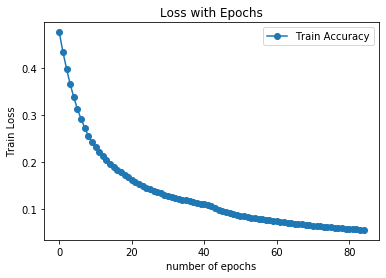

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Loss with Epochs")
x = np.arange(0,len(costs[1:]))
ax.plot(x, costs[1:], marker='o', label='Train Accuracy')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Train Loss")

plt.legend()
#plt.savefig("accuracy_HiddenUnit_val20per.png", dpi=1000, bbox_inches='tight')
plt.show()

In [19]:
test_accuracy

[88.75384615384615,
 3.8461538461538463,
 3.8461538461538463,
 3.8461538461538463,
 91.13846153846154]

In [66]:
train_time


[13.52085542678833,
 5.784939289093018,
 35.933685302734375,
 3147.959664106369,
 5332.827504873276]

In [21]:
train_accuracy

[97.09230769230768,
 3.8461538461538463,
 3.8461538461538463,
 3.8461538461538463,
 97.99230769230769]